# Multilayer perceptron

This software uses cauchyturing/UCR_Time_Series_Classification_Deep_Learning_Baseline 

See MIT License in 
https://github.com/cauchyturing/UCR_Time_Series_Classification_Deep_Learning_Baseline/README.md

Wang, Z., Yan, W. and Oates, T. (2017) ‘Time series classification from scratch with deep neural networks: A strong baseline’, 2017 International Joint Conference on Neural Networks (IJCNN), pp. 1578–1585 [Online.](https://arxiv.org/abs/1611.06455 "Wang et al. (2017)")

## Formatting

Left align the tables in this Notebook.


In [112]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

## Data
Additional datasets are available in the UEA & UCT Time Series Classification Repository at http://www.timeseriesclassification.com/. 

Save additional datasets in deepscent/data. E.g. deepscent/data/Adiac/Adiac_TRAIN.txt

### GunPoint dataset
The GunPoint dataset is from the [UEA & UCR Time Series 
Classification Repository](http://www.timeseriesclassification.com/description.php?Dataset=GunPoint 
"GunPoint description"). The data is from one female and one male either drawing and pointing a gun at a target or pointing their finger at a target. The location of their hand was tracked. This data is the time series of the x-axis location.

|Training set size |Test set size |Number of classes 
|:-----------      |:--------     |:----------     
|50 |150  |2 


## Train MLP
Expected running time for various datasets when using the original training/test split. Running on a single NVIDIA GeForce GTX 1080 Ti Graphics Card -

Dataset   | Training time
:-------  | :--------
Adiac     | 18 minutes
GunPoint  | 11 minutes


### User inputs

In [113]:
flist = ['GunPoint'] # List dataset directory names.
k = 10 # For k-fold cross validation. If k=1, the original test-train split is used.
seed = 35 # seed for initialising random weights in the NN.
k_fold_seed = 87
# Directories
fdir = '../data'  
logs_dir = '../logs'
timestamp = '{:%Y-%m-%dT%H:%M}'.format(datetime.now())
logs_dir = logs_dir +'/' + timestamp

### Set up

In [114]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras import utils
import numpy as np
from tensorflow.keras.callbacks import ReduceLROnPlateau

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

import os
import time
from datetime import datetime
import pathlib

np.random.seed(22)#813306)

      
def readucr(filename):
    data = np.loadtxt(filename)
    Y = data[:,0]
    X = data[:,1:]
    return X, Y
  
nb_epochs = 5000

### Visualise the data

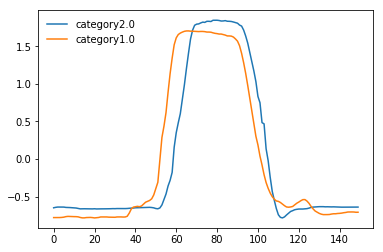

In [115]:
fname = flist[0]
data_a = 0
data_b = 2
x_train, y_train = readucr(fdir+'/'+fname+'/'+fname+'_TRAIN.txt')
plt.plot(x_train[data_a], label='category'+str(y_train[data_a]))
plt.plot(x_train[data_b], label='category'+str(y_train[data_b]))
plt.legend(loc='upper left', frameon=False)

### Function to train the MLP

In [116]:
def train_model(fname, x_train, y_train, x_test, y_test, label="0"):
    print('Running dataset', fname)
    nb_classes =len(np.unique(y_test))
    y_train = (y_train - y_train.min())/(y_train.max()-y_train.min())*(nb_classes-1)
    y_test = (y_test - y_test.min())/(y_test.max()-y_test.min())*(nb_classes-1)
    batch_size = int(min(x_train.shape[0]/10, 16))
    
    Y_train = utils.to_categorical(y_train, nb_classes)
    Y_test = utils.to_categorical(y_test, nb_classes)
     
    x_train_mean = x_train.mean()
    x_train_std = x_train.std()
    x_train = (x_train - x_train_mean)/(x_train_std)
     
   # x_test_min = np.min(x_test, axis = 1, keepdims=1)
   # x_test_max = np.max(x_test, axis = 1, keepdims=1)
    x_test = (x_test - x_train_mean)/(x_train_std)
     
    #x_train = x_train.reshape(x_train.shape + (1,))
    #x_test = x_test.reshape(x_test.shape + (1,))
    
    x = Input(x_train.shape[1:])
    y= Dropout(0.1)(x)
    y = Dense(500, activation='relu', kernel_initializer=RandomUniform(seed=seed))(x)
    y = Dropout(0.2)(y)
    y = Dense(500, activation='relu', kernel_initializer=RandomUniform(seed=seed))(y)
    y = Dropout(0.2)(y)
    y = Dense(500, activation = 'relu', kernel_initializer=RandomUniform(seed=seed))(y)
    y = Dropout(0.3)(y)
    out = Dense(nb_classes, activation='softmax', kernel_initializer=RandomUniform(seed=seed))(y)
     
    model = Model(x, out)
     
    optimizer = keras.optimizers.Adadelta(rho=0.95, epsilon=1e-8)  
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
     
    reduce_lr = ReduceLROnPlateau(monitor = 'loss', factor=0.5,
                      patience=200, min_lr=0.1)
    

    start = time.time()
    hist = model.fit(x_train, Y_train, batch_size=batch_size, epochs=nb_epochs,
              verbose=2, validation_data=(x_test, Y_test), 
                #callbacks = [TestCallback((x_train, Y_train)), reduce_lr, keras.callbacks.TensorBoard(log_dir='./log'+fname, histogram_freq=1)])
                 callbacks=[reduce_lr])
    end = time.time()
    
    log = pd.DataFrame(hist.history)
    # Print results. Print the testing results which has the lowest training loss.
    print('Training complete on', fname)
    duration_minutes = str(round((end-start)/60))
    print('Training time ', end-start, 'seconds, which is about', duration_minutes, 'minutes.')
    print('Selected the test result with the lowest training loss. Loss and accuracy are -')
    loss = log.loc[log['loss'].idxmin]['loss']
    val_acc = log.loc[log['loss'].idxmin]['val_acc']
    print(loss, val_acc)
    summary = '|' + label + '  |'+str(loss)+'  |'+str(val_acc)+' |'+  fname +'  |'+ timestamp + '  |' + duration_minutes + 'mins  |'
    # Save log file.
    pathlib.Path(logs_dir+'/'+fname).mkdir(parents=True, exist_ok=True) 
    print('Saving logs to',logs_dir+'/'+fname+'/history_'+label+'.csv')
    log.to_csv(logs_dir+'/'+fname+'/history_'+label+'.csv')
    return summary
 



# Train

In [117]:
results = []
for each in flist:
    fname = each
    x_train, y_train = readucr(fdir+'/'+fname+'/'+fname+'_TRAIN.txt')
    x_test, y_test = readucr(fdir+'/'+fname+'/'+fname+'_TEST.txt')
    # k-fold cross validation setup
    if k > 1:
        x_all = np.concatenate((x_train, x_test), axis=0)
        y_all = np.concatenate((y_train, y_test), axis=0)
        kfold = KFold(k, True, k_fold_seed)
        count = 0
        for train, test in kfold.split(x_all):
            x_train, y_train, x_test, y_test = x_all[train], y_all[train], x_all[test], y_all[test]
            summary = train_model(fname, x_train, y_train, x_test, y_test, str(count))
            results.append(summary)
            count = count + 1
    else:
        summary = train_model(fname, x_train, y_train, x_test, y_test)
        results.append(summary)
        
print('DONE')
for each in results:
    print(each)
	

Running dataset GunPoint
Train on 180 samples, validate on 20 samples
Epoch 1/5000
 - 2s - loss: 0.6830 - acc: 0.5500 - val_loss: 0.6154 - val_acc: 0.7500
Epoch 2/5000
 - 0s - loss: 0.5734 - acc: 0.7611 - val_loss: 0.4780 - val_acc: 0.7000
Epoch 3/5000
 - 0s - loss: 0.5072 - acc: 0.6778 - val_loss: 0.4260 - val_acc: 0.8500
Epoch 4/5000
 - 0s - loss: 0.4255 - acc: 0.7278 - val_loss: 0.5410 - val_acc: 0.6500
Epoch 5/5000
 - 0s - loss: 0.4249 - acc: 0.7833 - val_loss: 0.4988 - val_acc: 0.6500
Epoch 6/5000
 - 0s - loss: 0.3828 - acc: 0.7667 - val_loss: 0.3668 - val_acc: 0.8000
Epoch 7/5000
 - 0s - loss: 0.3190 - acc: 0.8556 - val_loss: 0.3569 - val_acc: 0.8000
Epoch 8/5000
 - 0s - loss: 0.3890 - acc: 0.7944 - val_loss: 0.3116 - val_acc: 0.9000
Epoch 9/5000
 - 0s - loss: 0.3542 - acc: 0.8000 - val_loss: 0.3284 - val_acc: 0.8000
Epoch 10/5000
 - 0s - loss: 0.3240 - acc: 0.8389 - val_loss: 0.3506 - val_acc: 0.8000
Epoch 11/5000
 - 0s - loss: 0.3190 - acc: 0.8556 - val_loss: 0.4294 - val_acc: 

Epoch 96/5000
 - 0s - loss: 0.0153 - acc: 0.9944 - val_loss: 0.0267 - val_acc: 1.0000
Epoch 97/5000
 - 0s - loss: 0.0084 - acc: 0.9944 - val_loss: 0.0368 - val_acc: 1.0000
Epoch 98/5000
 - 0s - loss: 0.0155 - acc: 0.9944 - val_loss: 0.0247 - val_acc: 1.0000
Epoch 99/5000
 - 0s - loss: 0.0273 - acc: 0.9944 - val_loss: 0.0223 - val_acc: 1.0000
Epoch 100/5000
 - 0s - loss: 0.0164 - acc: 0.9889 - val_loss: 0.0869 - val_acc: 0.9500
Epoch 101/5000
 - 0s - loss: 0.0170 - acc: 0.9944 - val_loss: 0.0248 - val_acc: 1.0000
Epoch 102/5000
 - 0s - loss: 0.0126 - acc: 0.9944 - val_loss: 0.0309 - val_acc: 1.0000
Epoch 103/5000
 - 0s - loss: 0.0207 - acc: 0.9889 - val_loss: 0.0517 - val_acc: 0.9500
Epoch 104/5000
 - 0s - loss: 0.0135 - acc: 0.9889 - val_loss: 0.0369 - val_acc: 1.0000
Epoch 105/5000
 - 0s - loss: 0.0285 - acc: 0.9889 - val_loss: 0.1886 - val_acc: 0.9500
Epoch 106/5000
 - 0s - loss: 0.0220 - acc: 0.9944 - val_loss: 0.0349 - val_acc: 1.0000
Epoch 107/5000
 - 0s - loss: 0.0190 - acc: 0.99

 - 0s - loss: 4.0524e-04 - acc: 1.0000 - val_loss: 0.0127 - val_acc: 1.0000
Epoch 191/5000
 - 0s - loss: 5.0745e-04 - acc: 1.0000 - val_loss: 0.0058 - val_acc: 1.0000
Epoch 192/5000
 - 0s - loss: 0.0070 - acc: 0.9944 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 193/5000
 - 0s - loss: 0.0100 - acc: 0.9944 - val_loss: 0.0030 - val_acc: 1.0000
Epoch 194/5000
 - 0s - loss: 7.7648e-04 - acc: 1.0000 - val_loss: 0.0076 - val_acc: 1.0000
Epoch 195/5000
 - 0s - loss: 4.1944e-04 - acc: 1.0000 - val_loss: 0.0032 - val_acc: 1.0000
Epoch 196/5000
 - 0s - loss: 5.3272e-04 - acc: 1.0000 - val_loss: 0.0043 - val_acc: 1.0000
Epoch 197/5000
 - 0s - loss: 0.0025 - acc: 1.0000 - val_loss: 0.0068 - val_acc: 1.0000
Epoch 198/5000
 - 0s - loss: 9.7085e-04 - acc: 1.0000 - val_loss: 0.0026 - val_acc: 1.0000
Epoch 199/5000
 - 0s - loss: 0.0305 - acc: 0.9889 - val_loss: 0.0061 - val_acc: 1.0000
Epoch 200/5000
 - 0s - loss: 0.0020 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 201/5000
 - 0s - loss: 0.002

Epoch 282/5000
 - 0s - loss: 0.0192 - acc: 0.9889 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 283/5000
 - 0s - loss: 2.3453e-04 - acc: 1.0000 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 284/5000
 - 0s - loss: 0.0075 - acc: 0.9944 - val_loss: 0.1718 - val_acc: 0.9500
Epoch 285/5000
 - 0s - loss: 0.0014 - acc: 1.0000 - val_loss: 0.0096 - val_acc: 1.0000
Epoch 286/5000
 - 0s - loss: 5.7634e-05 - acc: 1.0000 - val_loss: 0.0087 - val_acc: 1.0000
Epoch 287/5000
 - 0s - loss: 2.0256e-04 - acc: 1.0000 - val_loss: 0.0034 - val_acc: 1.0000
Epoch 288/5000
 - 0s - loss: 5.3004e-05 - acc: 1.0000 - val_loss: 0.0040 - val_acc: 1.0000
Epoch 289/5000
 - 0s - loss: 6.4880e-05 - acc: 1.0000 - val_loss: 0.0048 - val_acc: 1.0000
Epoch 290/5000
 - 0s - loss: 1.3102e-04 - acc: 1.0000 - val_loss: 0.0038 - val_acc: 1.0000
Epoch 291/5000
 - 0s - loss: 1.0368e-04 - acc: 1.0000 - val_loss: 0.0043 - val_acc: 1.0000
Epoch 292/5000
 - 0s - loss: 7.4099e-04 - acc: 1.0000 - val_loss: 0.0164 - val_acc: 1.0000
Epoch 293/5

 - 0s - loss: 0.0148 - acc: 0.9944 - val_loss: 0.1360 - val_acc: 0.9500
Epoch 373/5000
 - 0s - loss: 0.0034 - acc: 1.0000 - val_loss: 5.4102e-04 - val_acc: 1.0000
Epoch 374/5000
 - 0s - loss: 2.0598e-05 - acc: 1.0000 - val_loss: 5.5367e-04 - val_acc: 1.0000
Epoch 375/5000
 - 0s - loss: 2.0643e-04 - acc: 1.0000 - val_loss: 0.0037 - val_acc: 1.0000
Epoch 376/5000
 - 0s - loss: 5.5860e-05 - acc: 1.0000 - val_loss: 0.0024 - val_acc: 1.0000
Epoch 377/5000
 - 0s - loss: 6.2995e-05 - acc: 1.0000 - val_loss: 0.0131 - val_acc: 1.0000
Epoch 378/5000
 - 0s - loss: 8.9985e-05 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 379/5000
 - 0s - loss: 7.5215e-05 - acc: 1.0000 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 380/5000
 - 0s - loss: 4.4024e-05 - acc: 1.0000 - val_loss: 6.0043e-04 - val_acc: 1.0000
Epoch 381/5000
 - 0s - loss: 9.2742e-05 - acc: 1.0000 - val_loss: 0.0094 - val_acc: 1.0000
Epoch 382/5000
 - 0s - loss: 5.2342e-05 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 383/

Epoch 462/5000
 - 0s - loss: 2.9684e-04 - acc: 1.0000 - val_loss: 0.1541 - val_acc: 0.9500
Epoch 463/5000
 - 0s - loss: 3.2057e-04 - acc: 1.0000 - val_loss: 0.0658 - val_acc: 0.9500
Epoch 464/5000
 - 0s - loss: 8.1877e-06 - acc: 1.0000 - val_loss: 0.0569 - val_acc: 0.9500
Epoch 465/5000
 - 0s - loss: 9.0780e-06 - acc: 1.0000 - val_loss: 0.0548 - val_acc: 0.9500
Epoch 466/5000
 - 0s - loss: 5.6283e-06 - acc: 1.0000 - val_loss: 0.0469 - val_acc: 0.9500
Epoch 467/5000
 - 0s - loss: 3.4872e-06 - acc: 1.0000 - val_loss: 0.0433 - val_acc: 0.9500
Epoch 468/5000
 - 0s - loss: 6.0547e-06 - acc: 1.0000 - val_loss: 0.0372 - val_acc: 0.9500
Epoch 469/5000
 - 0s - loss: 7.4232e-06 - acc: 1.0000 - val_loss: 0.0192 - val_acc: 1.0000
Epoch 470/5000
 - 0s - loss: 3.6102e-06 - acc: 1.0000 - val_loss: 0.0181 - val_acc: 1.0000
Epoch 471/5000
 - 0s - loss: 1.0709e-05 - acc: 1.0000 - val_loss: 0.0100 - val_acc: 1.0000
Epoch 472/5000
 - 0s - loss: 3.0979e-05 - acc: 1.0000 - val_loss: 0.0878 - val_acc: 0.9500

Epoch 552/5000
 - 0s - loss: 2.2423e-06 - acc: 1.0000 - val_loss: 0.0112 - val_acc: 1.0000
Epoch 553/5000
 - 0s - loss: 7.5143e-06 - acc: 1.0000 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 554/5000
 - 0s - loss: 4.4470e-06 - acc: 1.0000 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 555/5000
 - 0s - loss: 3.3367e-05 - acc: 1.0000 - val_loss: 5.1178e-04 - val_acc: 1.0000
Epoch 556/5000
 - 0s - loss: 5.8138e-06 - acc: 1.0000 - val_loss: 6.2377e-04 - val_acc: 1.0000
Epoch 557/5000
 - 0s - loss: 1.0116e-06 - acc: 1.0000 - val_loss: 6.8927e-04 - val_acc: 1.0000
Epoch 558/5000
 - 0s - loss: 1.0295e-06 - acc: 1.0000 - val_loss: 8.0241e-04 - val_acc: 1.0000
Epoch 559/5000
 - 0s - loss: 5.0461e-06 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 560/5000
 - 0s - loss: 3.5646e-05 - acc: 1.0000 - val_loss: 0.0225 - val_acc: 1.0000
Epoch 561/5000
 - 0s - loss: 9.2562e-06 - acc: 1.0000 - val_loss: 0.0263 - val_acc: 1.0000
Epoch 562/5000
 - 0s - loss: 1.8488e-05 - acc: 1.0000 - val_loss: 0.0030 -

Epoch 642/5000
 - 0s - loss: 4.8914e-05 - acc: 1.0000 - val_loss: 4.0918e-04 - val_acc: 1.0000
Epoch 643/5000
 - 0s - loss: 8.5836e-05 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 644/5000
 - 0s - loss: 2.2773e-06 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 645/5000
 - 0s - loss: 1.4271e-05 - acc: 1.0000 - val_loss: 0.0039 - val_acc: 1.0000
Epoch 646/5000
 - 0s - loss: 3.1832e-06 - acc: 1.0000 - val_loss: 0.0042 - val_acc: 1.0000
Epoch 647/5000
 - 0s - loss: 2.0601e-06 - acc: 1.0000 - val_loss: 0.0041 - val_acc: 1.0000
Epoch 648/5000
 - 0s - loss: 2.6101e-06 - acc: 1.0000 - val_loss: 0.0044 - val_acc: 1.0000
Epoch 649/5000
 - 0s - loss: 1.5352e-06 - acc: 1.0000 - val_loss: 0.0039 - val_acc: 1.0000
Epoch 650/5000
 - 0s - loss: 1.5948e-06 - acc: 1.0000 - val_loss: 0.0035 - val_acc: 1.0000
Epoch 651/5000
 - 0s - loss: 4.4721e-06 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 652/5000
 - 0s - loss: 2.5194e-06 - acc: 1.0000 - val_loss: 0.0022 - val_acc: 1.

Epoch 732/5000
 - 0s - loss: 2.2475e-06 - acc: 1.0000 - val_loss: 0.0039 - val_acc: 1.0000
Epoch 733/5000
 - 0s - loss: 8.4793e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 734/5000
 - 0s - loss: 6.1658e-07 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 735/5000
 - 0s - loss: 1.0207e-05 - acc: 1.0000 - val_loss: 0.0041 - val_acc: 1.0000
Epoch 736/5000
 - 0s - loss: 2.6574e-06 - acc: 1.0000 - val_loss: 0.0029 - val_acc: 1.0000
Epoch 737/5000
 - 0s - loss: 5.8910e-07 - acc: 1.0000 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 738/5000
 - 0s - loss: 7.5368e-07 - acc: 1.0000 - val_loss: 0.0026 - val_acc: 1.0000
Epoch 739/5000
 - 0s - loss: 1.6114e-06 - acc: 1.0000 - val_loss: 0.0033 - val_acc: 1.0000
Epoch 740/5000
 - 0s - loss: 3.4350e-06 - acc: 1.0000 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 741/5000
 - 0s - loss: 2.7467e-06 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 742/5000
 - 0s - loss: 1.4150e-06 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 1.0000

Epoch 822/5000
 - 0s - loss: 6.1672e-06 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 823/5000
 - 0s - loss: 2.3525e-06 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 824/5000
 - 0s - loss: 4.2851e-06 - acc: 1.0000 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 825/5000
 - 0s - loss: 7.5367e-07 - acc: 1.0000 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 826/5000
 - 0s - loss: 1.9657e-06 - acc: 1.0000 - val_loss: 0.0036 - val_acc: 1.0000
Epoch 827/5000
 - 0s - loss: 3.0697e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 828/5000
 - 0s - loss: 2.7426e-06 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 829/5000
 - 0s - loss: 8.6030e-07 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 830/5000
 - 0s - loss: 2.6499e-06 - acc: 1.0000 - val_loss: 0.0024 - val_acc: 1.0000
Epoch 831/5000
 - 0s - loss: 1.3660e-06 - acc: 1.0000 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 832/5000
 - 0s - loss: 2.1787e-05 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000

Epoch 912/5000
 - 0s - loss: 2.7708e-06 - acc: 1.0000 - val_loss: 0.0024 - val_acc: 1.0000
Epoch 913/5000
 - 0s - loss: 1.7627e-06 - acc: 1.0000 - val_loss: 0.0026 - val_acc: 1.0000
Epoch 914/5000
 - 0s - loss: 1.0229e-06 - acc: 1.0000 - val_loss: 0.0026 - val_acc: 1.0000
Epoch 915/5000
 - 0s - loss: 1.7173e-06 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 916/5000
 - 0s - loss: 2.3973e-06 - acc: 1.0000 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 917/5000
 - 0s - loss: 5.4539e-07 - acc: 1.0000 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 918/5000
 - 0s - loss: 1.7014e-06 - acc: 1.0000 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 919/5000
 - 0s - loss: 5.2629e-06 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 920/5000
 - 0s - loss: 8.8011e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 921/5000
 - 0s - loss: 1.5402e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 922/5000
 - 0s - loss: 1.8700e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000

 - 0s - loss: 1.4825e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 1003/5000
 - 0s - loss: 1.9087e-06 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 1004/5000
 - 0s - loss: 1.4756e-06 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 1005/5000
 - 0s - loss: 2.6019e-06 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 1006/5000
 - 0s - loss: 8.0656e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 1007/5000
 - 0s - loss: 6.4842e-04 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 1008/5000
 - 0s - loss: 8.1858e-07 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 1009/5000
 - 0s - loss: 1.0285e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 1010/5000
 - 0s - loss: 2.3095e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 1011/5000
 - 0s - loss: 2.9557e-06 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 1012/5000
 - 0s - loss: 1.1106e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoc

Epoch 1092/5000
 - 0s - loss: 1.6822e-06 - acc: 1.0000 - val_loss: 0.0059 - val_acc: 1.0000
Epoch 1093/5000
 - 0s - loss: 1.6577e-06 - acc: 1.0000 - val_loss: 0.0059 - val_acc: 1.0000
Epoch 1094/5000
 - 0s - loss: 1.1590e-06 - acc: 1.0000 - val_loss: 0.0056 - val_acc: 1.0000
Epoch 1095/5000
 - 0s - loss: 3.3204e-06 - acc: 1.0000 - val_loss: 0.0054 - val_acc: 1.0000
Epoch 1096/5000
 - 0s - loss: 3.9395e-06 - acc: 1.0000 - val_loss: 0.0041 - val_acc: 1.0000
Epoch 1097/5000
 - 0s - loss: 8.9309e-07 - acc: 1.0000 - val_loss: 0.0040 - val_acc: 1.0000
Epoch 1098/5000
 - 0s - loss: 4.5400e-06 - acc: 1.0000 - val_loss: 0.0035 - val_acc: 1.0000
Epoch 1099/5000
 - 0s - loss: 1.1438e-06 - acc: 1.0000 - val_loss: 0.0034 - val_acc: 1.0000
Epoch 1100/5000
 - 0s - loss: 3.2554e-06 - acc: 1.0000 - val_loss: 0.0033 - val_acc: 1.0000
Epoch 1101/5000
 - 0s - loss: 1.1252e-06 - acc: 1.0000 - val_loss: 0.0033 - val_acc: 1.0000
Epoch 1102/5000
 - 0s - loss: 5.4493e-06 - acc: 1.0000 - val_loss: 0.0045 - val_

 - 0s - loss: 3.1305e-06 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 1182/5000
 - 0s - loss: 2.3084e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 1183/5000
 - 0s - loss: 1.0080e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 1184/5000
 - 0s - loss: 2.7391e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 1185/5000
 - 0s - loss: 2.4023e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 1186/5000
 - 0s - loss: 1.9389e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 1187/5000
 - 0s - loss: 5.0945e-06 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 1188/5000
 - 0s - loss: 5.8088e-06 - acc: 1.0000 - val_loss: 9.1749e-04 - val_acc: 1.0000
Epoch 1189/5000
 - 0s - loss: 1.9376e-06 - acc: 1.0000 - val_loss: 9.5850e-04 - val_acc: 1.0000
Epoch 1190/5000
 - 0s - loss: 5.3408e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 1191/5000
 - 0s - loss: 6.0098e-06 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0

Epoch 1270/5000
 - 0s - loss: 1.2448e-06 - acc: 1.0000 - val_loss: 9.9709e-04 - val_acc: 1.0000
Epoch 1271/5000
 - 0s - loss: 1.6820e-06 - acc: 1.0000 - val_loss: 9.5468e-04 - val_acc: 1.0000
Epoch 1272/5000
 - 0s - loss: 3.1336e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 1273/5000
 - 0s - loss: 1.3254e-05 - acc: 1.0000 - val_loss: 0.0030 - val_acc: 1.0000
Epoch 1274/5000
 - 0s - loss: 6.4241e-07 - acc: 1.0000 - val_loss: 0.0030 - val_acc: 1.0000
Epoch 1275/5000
 - 0s - loss: 1.2100e-06 - acc: 1.0000 - val_loss: 0.0029 - val_acc: 1.0000
Epoch 1276/5000
 - 0s - loss: 8.5699e-07 - acc: 1.0000 - val_loss: 0.0029 - val_acc: 1.0000
Epoch 1277/5000
 - 0s - loss: 1.6551e-06 - acc: 1.0000 - val_loss: 0.0030 - val_acc: 1.0000
Epoch 1278/5000
 - 0s - loss: 3.0346e-06 - acc: 1.0000 - val_loss: 0.0033 - val_acc: 1.0000
Epoch 1279/5000
 - 0s - loss: 3.7584e-07 - acc: 1.0000 - val_loss: 0.0033 - val_acc: 1.0000
Epoch 1280/5000
 - 0s - loss: 2.4761e-06 - acc: 1.0000 - val_loss: 0.003

Epoch 1359/5000
 - 0s - loss: 1.4875e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 1360/5000
 - 0s - loss: 1.1998e-05 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 1361/5000
 - 0s - loss: 2.5974e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 1362/5000
 - 0s - loss: 3.1424e-06 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 1363/5000
 - 0s - loss: 1.2292e-06 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 1364/5000
 - 0s - loss: 5.0764e-07 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 1365/5000
 - 0s - loss: 1.9084e-06 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 1366/5000
 - 0s - loss: 1.1971e-06 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 1367/5000
 - 0s - loss: 1.4529e-05 - acc: 1.0000 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 1368/5000
 - 0s - loss: 1.3802e-06 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 1369/5000
 - 0s - loss: 5.1682e-06 - acc: 1.0000 - val_loss: 0.0031 - val_

 - 0s - loss: 1.3166e-06 - acc: 1.0000 - val_loss: 0.0033 - val_acc: 1.0000
Epoch 1449/5000
 - 0s - loss: 3.8219e-06 - acc: 1.0000 - val_loss: 0.0030 - val_acc: 1.0000
Epoch 1450/5000
 - 0s - loss: 9.6792e-07 - acc: 1.0000 - val_loss: 0.0030 - val_acc: 1.0000
Epoch 1451/5000
 - 0s - loss: 2.6327e-06 - acc: 1.0000 - val_loss: 0.0031 - val_acc: 1.0000
Epoch 1452/5000
 - 0s - loss: 9.4806e-07 - acc: 1.0000 - val_loss: 0.0031 - val_acc: 1.0000
Epoch 1453/5000
 - 0s - loss: 2.7723e-06 - acc: 1.0000 - val_loss: 0.0035 - val_acc: 1.0000
Epoch 1454/5000
 - 0s - loss: 1.8312e-06 - acc: 1.0000 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 1455/5000
 - 0s - loss: 9.9144e-07 - acc: 1.0000 - val_loss: 0.0026 - val_acc: 1.0000
Epoch 1456/5000
 - 0s - loss: 1.7346e-06 - acc: 1.0000 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 1457/5000
 - 0s - loss: 1.2570e-06 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 1458/5000
 - 0s - loss: 6.9010e-07 - acc: 1.0000 - val_loss: 0.0026 - val_acc: 1.0000
Epoc

Epoch 1537/5000
 - 0s - loss: 8.3315e-07 - acc: 1.0000 - val_loss: 0.0034 - val_acc: 1.0000
Epoch 1538/5000
 - 0s - loss: 6.9241e-07 - acc: 1.0000 - val_loss: 0.0034 - val_acc: 1.0000
Epoch 1539/5000
 - 0s - loss: 4.6685e-06 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 1540/5000
 - 0s - loss: 8.8547e-07 - acc: 1.0000 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 1541/5000
 - 0s - loss: 1.5514e-06 - acc: 1.0000 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 1542/5000
 - 0s - loss: 1.0057e-05 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 1543/5000
 - 0s - loss: 1.9333e-06 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 1544/5000
 - 0s - loss: 5.5015e-06 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 1545/5000
 - 0s - loss: 1.0938e-06 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 1546/5000
 - 0s - loss: 5.4770e-07 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 1547/5000
 - 0s - loss: 3.6271e-06 - acc: 1.0000 - val_loss: 0.0018 - val_

Epoch 1626/5000
 - 0s - loss: 1.3004e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 1627/5000
 - 0s - loss: 1.2120e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 1628/5000
 - 0s - loss: 9.2687e-07 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 1629/5000
 - 0s - loss: 1.5637e-06 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 1630/5000
 - 0s - loss: 1.4389e-06 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 1631/5000
 - 0s - loss: 2.8192e-06 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 1632/5000
 - 0s - loss: 9.4574e-07 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 1633/5000
 - 0s - loss: 6.6791e-07 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 1634/5000
 - 0s - loss: 5.3346e-07 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 1635/5000
 - 0s - loss: 2.1720e-06 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 1636/5000
 - 0s - loss: 1.5750e-06 - acc: 1.0000 - val_loss: 0.0018 - val_

 - 0s - loss: 7.1438e-06 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 1716/5000
 - 0s - loss: 1.1121e-05 - acc: 1.0000 - val_loss: 0.0029 - val_acc: 1.0000
Epoch 1717/5000
 - 0s - loss: 1.7716e-06 - acc: 1.0000 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 1718/5000
 - 0s - loss: 8.2223e-07 - acc: 1.0000 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 1719/5000
 - 0s - loss: 1.4047e-06 - acc: 1.0000 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 1720/5000
 - 0s - loss: 1.2815e-06 - acc: 1.0000 - val_loss: 0.0026 - val_acc: 1.0000
Epoch 1721/5000
 - 0s - loss: 2.2238e-06 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 1722/5000
 - 0s - loss: 1.4272e-06 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 1723/5000
 - 0s - loss: 2.2363e-06 - acc: 1.0000 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 1724/5000
 - 0s - loss: 9.0666e-07 - acc: 1.0000 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 1725/5000
 - 0s - loss: 6.3189e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoc

Epoch 1804/5000
 - 0s - loss: 2.9985e-06 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 1805/5000
 - 0s - loss: 1.5329e-06 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 1806/5000
 - 0s - loss: 7.2255e-07 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 1807/5000
 - 0s - loss: 5.1940e-06 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 1808/5000
 - 0s - loss: 1.3580e-06 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 1809/5000
 - 0s - loss: 1.6147e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 1810/5000
 - 0s - loss: 2.4167e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 1811/5000
 - 0s - loss: 3.2468e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 1812/5000
 - 0s - loss: 1.1083e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 1813/5000
 - 0s - loss: 6.3513e-07 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 1814/5000
 - 0s - loss: 2.0804e-06 - acc: 1.0000 - val_loss: 0.0015 - val_

 - 0s - loss: 8.6461e-07 - acc: 1.0000 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 1894/5000
 - 0s - loss: 5.3347e-07 - acc: 1.0000 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 1895/5000
 - 0s - loss: 2.3774e-06 - acc: 1.0000 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 1896/5000
 - 0s - loss: 1.7614e-06 - acc: 1.0000 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 1897/5000
 - 0s - loss: 2.5572e-06 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 1898/5000
 - 0s - loss: 3.0593e-06 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 1899/5000
 - 0s - loss: 1.4418e-06 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 1900/5000
 - 0s - loss: 2.3804e-06 - acc: 1.0000 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 1901/5000
 - 0s - loss: 7.8959e-06 - acc: 1.0000 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 1902/5000
 - 0s - loss: 6.6442e-06 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 1903/5000
 - 0s - loss: 0.0210 - acc: 0.9944 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 19

Epoch 1983/5000
 - 0s - loss: 7.7520e-07 - acc: 1.0000 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 1984/5000
 - 0s - loss: 2.2987e-06 - acc: 1.0000 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 1985/5000
 - 0s - loss: 1.0554e-06 - acc: 1.0000 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 1986/5000
 - 0s - loss: 4.6537e-06 - acc: 1.0000 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 1987/5000
 - 0s - loss: 1.8157e-06 - acc: 1.0000 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 1988/5000
 - 0s - loss: 1.1289e-06 - acc: 1.0000 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 1989/5000
 - 0s - loss: 2.1439e-06 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 1990/5000
 - 0s - loss: 7.2586e-07 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 1991/5000
 - 0s - loss: 2.0856e-06 - acc: 1.0000 - val_loss: 0.0026 - val_acc: 1.0000
Epoch 1992/5000
 - 0s - loss: 4.8384e-06 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 1993/5000
 - 0s - loss: 3.7712e-06 - acc: 1.0000 - val_loss: 0.0022 - val_

 - 0s - loss: 4.6063e-06 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 2073/5000
 - 0s - loss: 6.7188e-07 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 2074/5000
 - 0s - loss: 1.2431e-06 - acc: 1.0000 - val_loss: 0.0026 - val_acc: 1.0000
Epoch 2075/5000
 - 0s - loss: 1.0242e-06 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 2076/5000
 - 0s - loss: 1.2507e-06 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 2077/5000
 - 0s - loss: 1.1944e-06 - acc: 1.0000 - val_loss: 0.0026 - val_acc: 1.0000
Epoch 2078/5000
 - 0s - loss: 9.7687e-07 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 2079/5000
 - 0s - loss: 5.7585e-07 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 2080/5000
 - 0s - loss: 7.3844e-07 - acc: 1.0000 - val_loss: 0.0024 - val_acc: 1.0000
Epoch 2081/5000
 - 0s - loss: 1.9606e-06 - acc: 1.0000 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 2082/5000
 - 0s - loss: 6.4506e-07 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoc

Epoch 2161/5000
 - 0s - loss: 1.1106e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 2162/5000
 - 0s - loss: 1.6716e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 2163/5000
 - 0s - loss: 1.2285e-06 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 2164/5000
 - 0s - loss: 2.0250e-06 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 2165/5000
 - 0s - loss: 9.4528e-06 - acc: 1.0000 - val_loss: 0.0030 - val_acc: 1.0000
Epoch 2166/5000
 - 0s - loss: 6.4795e-06 - acc: 1.0000 - val_loss: 0.0038 - val_acc: 1.0000
Epoch 2167/5000
 - 0s - loss: 1.6117e-06 - acc: 1.0000 - val_loss: 0.0037 - val_acc: 1.0000
Epoch 2168/5000
 - 0s - loss: 1.3667e-05 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 2169/5000
 - 0s - loss: 1.1921e-06 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 2170/5000
 - 0s - loss: 1.1226e-06 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 2171/5000
 - 0s - loss: 6.9672e-07 - acc: 1.0000 - val_loss: 0.0018 - val_

Epoch 2249/5000
 - 0s - loss: 3.1855e-07 - acc: 1.0000 - val_loss: 8.9711e-04 - val_acc: 1.0000
Epoch 2250/5000
 - 0s - loss: 4.6624e-07 - acc: 1.0000 - val_loss: 9.1236e-04 - val_acc: 1.0000
Epoch 2251/5000
 - 0s - loss: 2.6142e-06 - acc: 1.0000 - val_loss: 9.5155e-04 - val_acc: 1.0000
Epoch 2252/5000
 - 0s - loss: 1.3816e-05 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 2253/5000
 - 0s - loss: 1.4948e-06 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 2254/5000
 - 0s - loss: 5.6592e-07 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 2255/5000
 - 0s - loss: 7.0997e-07 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 2256/5000
 - 0s - loss: 1.0136e-05 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 2257/5000
 - 0s - loss: 2.8047e-07 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 2258/5000
 - 0s - loss: 1.0083e-06 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 2259/5000
 - 0s - loss: 1.3547e-06 - acc: 1.0000 - val_loss: 0

Epoch 2338/5000
 - 0s - loss: 6.0102e-07 - acc: 1.0000 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 2339/5000
 - 0s - loss: 7.0302e-07 - acc: 1.0000 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 2340/5000
 - 0s - loss: 1.2830e-05 - acc: 1.0000 - val_loss: 0.0039 - val_acc: 1.0000
Epoch 2341/5000
 - 0s - loss: 9.6362e-07 - acc: 1.0000 - val_loss: 0.0038 - val_acc: 1.0000
Epoch 2342/5000
 - 0s - loss: 1.4080e-06 - acc: 1.0000 - val_loss: 0.0038 - val_acc: 1.0000
Epoch 2343/5000
 - 0s - loss: 1.2487e-06 - acc: 1.0000 - val_loss: 0.0037 - val_acc: 1.0000
Epoch 2344/5000
 - 0s - loss: 9.0237e-07 - acc: 1.0000 - val_loss: 0.0036 - val_acc: 1.0000
Epoch 2345/5000
 - 0s - loss: 6.2453e-07 - acc: 1.0000 - val_loss: 0.0035 - val_acc: 1.0000
Epoch 2346/5000
 - 0s - loss: 1.0663e-06 - acc: 1.0000 - val_loss: 0.0034 - val_acc: 1.0000
Epoch 2347/5000
 - 0s - loss: 1.5942e-06 - acc: 1.0000 - val_loss: 0.0030 - val_acc: 1.0000
Epoch 2348/5000
 - 0s - loss: 1.2590e-06 - acc: 1.0000 - val_loss: 0.0028 - val_

Epoch 2427/5000
 - 0s - loss: 3.1756e-06 - acc: 1.0000 - val_loss: 8.4360e-04 - val_acc: 1.0000
Epoch 2428/5000
 - 0s - loss: 4.6161e-07 - acc: 1.0000 - val_loss: 8.4438e-04 - val_acc: 1.0000
Epoch 2429/5000
 - 0s - loss: 2.9422e-06 - acc: 1.0000 - val_loss: 9.3480e-04 - val_acc: 1.0000
Epoch 2430/5000
 - 0s - loss: 1.9081e-06 - acc: 1.0000 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 2431/5000
 - 0s - loss: 3.8750e-06 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 2432/5000
 - 0s - loss: 1.1378e-06 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 2433/5000
 - 0s - loss: 7.7269e-06 - acc: 1.0000 - val_loss: 7.6778e-04 - val_acc: 1.0000
Epoch 2434/5000
 - 0s - loss: 7.9341e-07 - acc: 1.0000 - val_loss: 7.7851e-04 - val_acc: 1.0000
Epoch 2435/5000
 - 0s - loss: 1.0855e-06 - acc: 1.0000 - val_loss: 8.1386e-04 - val_acc: 1.0000
Epoch 2436/5000
 - 0s - loss: 1.2017e-06 - acc: 1.0000 - val_loss: 8.4950e-04 - val_acc: 1.0000
Epoch 2437/5000
 - 0s - loss: 4.1609e-04 - acc: 1.00

Epoch 2516/5000
 - 0s - loss: 8.2553e-07 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 2517/5000
 - 0s - loss: 3.9899e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 2518/5000
 - 0s - loss: 8.2322e-07 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 2519/5000
 - 0s - loss: 2.6211e-06 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 2520/5000
 - 0s - loss: 7.3215e-07 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 2521/5000
 - 0s - loss: 1.4113e-06 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 2522/5000
 - 0s - loss: 4.0465e-07 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 2523/5000
 - 0s - loss: 5.2684e-07 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 2524/5000
 - 0s - loss: 3.6271e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 2525/5000
 - 0s - loss: 1.7124e-06 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 2526/5000
 - 0s - loss: 8.5865e-07 - acc: 1.0000 - val_loss: 0.0019 - val_

Epoch 2605/5000
 - 0s - loss: 8.3548e-07 - acc: 1.0000 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 2606/5000
 - 0s - loss: 4.9353e-06 - acc: 1.0000 - val_loss: 8.5124e-04 - val_acc: 1.0000
Epoch 2607/5000
 - 0s - loss: 4.3454e-06 - acc: 1.0000 - val_loss: 9.9580e-04 - val_acc: 1.0000
Epoch 2608/5000
 - 0s - loss: 5.6154e-06 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 2609/5000
 - 0s - loss: 1.6356e-06 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 2610/5000
 - 0s - loss: 4.7717e-07 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 2611/5000
 - 0s - loss: 5.4075e-07 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 2612/5000
 - 0s - loss: 1.6736e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 2613/5000
 - 0s - loss: 7.0070e-07 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 2614/5000
 - 0s - loss: 7.0903e-06 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 2615/5000
 - 0s - loss: 3.4129e-06 - acc: 1.0000 - val_loss: 0.002

Epoch 2694/5000
 - 0s - loss: 1.1779e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 2695/5000
 - 0s - loss: 5.3015e-07 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 2696/5000
 - 0s - loss: 9.0799e-07 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 2697/5000
 - 0s - loss: 9.3945e-07 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 2698/5000
 - 0s - loss: 7.1791e-07 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 2699/5000
 - 0s - loss: 2.1656e-06 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 2700/5000
 - 0s - loss: 9.1494e-07 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 2701/5000
 - 0s - loss: 3.7198e-06 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 2702/5000
 - 0s - loss: 5.4638e-07 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 2703/5000
 - 0s - loss: 1.0686e-06 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 2704/5000
 - 0s - loss: 1.1064e-06 - acc: 1.0000 - val_loss: 0.0011 - val_

Epoch 2783/5000
 - 0s - loss: 2.3635e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 2784/5000
 - 0s - loss: 9.6164e-07 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 2785/5000
 - 0s - loss: 4.1512e-06 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 2786/5000
 - 0s - loss: 1.5292e-06 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 2787/5000
 - 0s - loss: 1.1041e-06 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 2788/5000
 - 0s - loss: 3.7650e-07 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 2789/5000
 - 0s - loss: 1.3644e-06 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 2790/5000
 - 0s - loss: 2.6855e-06 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 2791/5000
 - 0s - loss: 1.3312e-06 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 2792/5000
 - 0s - loss: 2.7587e-06 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 2793/5000
 - 0s - loss: 3.6260e-07 - acc: 1.0000 - val_loss: 0.0018 - val_

 - 0s - loss: 3.0413e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 2872/5000
 - 0s - loss: 2.1983e-06 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 2873/5000
 - 0s - loss: 7.0169e-07 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 2874/5000
 - 0s - loss: 1.5551e-06 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 2875/5000
 - 0s - loss: 1.0560e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 2876/5000
 - 0s - loss: 5.4042e-07 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 2877/5000
 - 0s - loss: 1.2226e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 2878/5000
 - 0s - loss: 1.4991e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 2879/5000
 - 0s - loss: 1.1318e-05 - acc: 1.0000 - val_loss: 7.9042e-04 - val_acc: 1.0000
Epoch 2880/5000
 - 0s - loss: 3.2922e-06 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 2881/5000
 - 0s - loss: 1.8475e-06 - acc: 1.0000 - val_loss: 9.5897e-04 - val_acc: 1.0

Epoch 2960/5000
 - 0s - loss: 8.6197e-07 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 2961/5000
 - 0s - loss: 6.6394e-07 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 2962/5000
 - 0s - loss: 2.1488e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 2963/5000
 - 0s - loss: 4.2684e-07 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 2964/5000
 - 0s - loss: 8.1494e-07 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 2965/5000
 - 0s - loss: 9.6926e-07 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 2966/5000
 - 0s - loss: 2.1273e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 2967/5000
 - 0s - loss: 2.1194e-06 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 2968/5000
 - 0s - loss: 2.2936e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 2969/5000
 - 0s - loss: 4.5598e-07 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 2970/5000
 - 0s - loss: 3.2007e-06 - acc: 1.0000 - val_loss: 0.0015 - val_

Epoch 3049/5000
 - 0s - loss: 8.4640e-07 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 3050/5000
 - 0s - loss: 1.1401e-06 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 3051/5000
 - 0s - loss: 3.3107e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 3052/5000
 - 0s - loss: 4.0796e-07 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 3053/5000
 - 0s - loss: 1.6439e-06 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 3054/5000
 - 0s - loss: 1.0014e-06 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 3055/5000
 - 0s - loss: 2.3204e-06 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 3056/5000
 - 0s - loss: 4.7452e-07 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 3057/5000
 - 0s - loss: 2.9592e-06 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 3058/5000
 - 0s - loss: 1.5137e-05 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 3059/5000
 - 0s - loss: 2.5981e-06 - acc: 1.0000 - val_loss: 0.0017 - val_

Epoch 3138/5000
 - 0s - loss: 6.0003e-07 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 3139/5000
 - 0s - loss: 1.4690e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 3140/5000
 - 0s - loss: 2.6103e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3141/5000
 - 0s - loss: 3.6368e-06 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 3142/5000
 - 0s - loss: 9.0004e-07 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 3143/5000
 - 0s - loss: 6.8513e-07 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 3144/5000
 - 0s - loss: 1.0703e-06 - acc: 1.0000 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 3145/5000
 - 0s - loss: 2.4348e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 3146/5000
 - 0s - loss: 1.3175e-05 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 3147/5000
 - 0s - loss: 1.3587e-06 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 3148/5000
 - 0s - loss: 2.6424e-06 - acc: 1.0000 - val_loss: 9.9590e-04 - 

Epoch 3227/5000
 - 0s - loss: 1.0385e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3228/5000
 - 0s - loss: 9.8881e-07 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 3229/5000
 - 0s - loss: 2.1455e-06 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 3230/5000
 - 0s - loss: 5.6592e-07 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3231/5000
 - 0s - loss: 5.4809e-06 - acc: 1.0000 - val_loss: 0.0024 - val_acc: 1.0000
Epoch 3232/5000
 - 0s - loss: 2.7119e-06 - acc: 1.0000 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 3233/5000
 - 0s - loss: 3.8144e-06 - acc: 1.0000 - val_loss: 0.0031 - val_acc: 1.0000
Epoch 3234/5000
 - 0s - loss: 2.7845e-06 - acc: 1.0000 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 3235/5000
 - 0s - loss: 1.0050e-06 - acc: 1.0000 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 3236/5000
 - 0s - loss: 3.1351e-06 - acc: 1.0000 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 3237/5000
 - 0s - loss: 1.0054e-06 - acc: 1.0000 - val_loss: 0.0024 - val_

 - 0s - loss: 8.0865e-07 - acc: 1.0000 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 3317/5000
 - 0s - loss: 2.2106e-06 - acc: 1.0000 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 3318/5000
 - 0s - loss: 1.2901e-06 - acc: 1.0000 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 3319/5000
 - 0s - loss: 7.8580e-07 - acc: 1.0000 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 3320/5000
 - 0s - loss: 4.4273e-07 - acc: 1.0000 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 3321/5000
 - 0s - loss: 1.4935e-06 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 3322/5000
 - 0s - loss: 2.8570e-06 - acc: 1.0000 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 3323/5000
 - 0s - loss: 1.1686e-06 - acc: 1.0000 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 3324/5000
 - 0s - loss: 3.5101e-07 - acc: 1.0000 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 3325/5000
 - 0s - loss: 4.3942e-07 - acc: 1.0000 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 3326/5000
 - 0s - loss: 1.1438e-06 - acc: 1.0000 - val_loss: 0.0022 - val_acc: 1.0000
Epoc

Epoch 3406/5000
 - 0s - loss: 5.6923e-07 - acc: 1.0000 - val_loss: 0.0030 - val_acc: 1.0000
Epoch 3407/5000
 - 0s - loss: 1.7862e-06 - acc: 1.0000 - val_loss: 0.0029 - val_acc: 1.0000
Epoch 3408/5000
 - 0s - loss: 6.4804e-07 - acc: 1.0000 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 3409/5000
 - 0s - loss: 6.6957e-07 - acc: 1.0000 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 3410/5000
 - 0s - loss: 3.2028e-06 - acc: 1.0000 - val_loss: 0.0029 - val_acc: 1.0000
Epoch 3411/5000
 - 0s - loss: 1.3902e-06 - acc: 1.0000 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 3412/5000
 - 0s - loss: 4.6260e-07 - acc: 1.0000 - val_loss: 0.0026 - val_acc: 1.0000
Epoch 3413/5000
 - 0s - loss: 6.4340e-07 - acc: 1.0000 - val_loss: 0.0026 - val_acc: 1.0000
Epoch 3414/5000
 - 0s - loss: 1.6806e-06 - acc: 1.0000 - val_loss: 0.0026 - val_acc: 1.0000
Epoch 3415/5000
 - 0s - loss: 2.6875e-06 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 3416/5000
 - 0s - loss: 2.0994e-06 - acc: 1.0000 - val_loss: 0.0019 - val_

 - 0s - loss: 2.3195e-06 - acc: 1.0000 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 3496/5000
 - 0s - loss: 7.6957e-07 - acc: 1.0000 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 3497/5000
 - 0s - loss: 6.7354e-07 - acc: 1.0000 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 3498/5000
 - 0s - loss: 5.5568e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 3499/5000
 - 0s - loss: 8.6693e-07 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 3500/5000
 - 0s - loss: 2.0566e-05 - acc: 1.0000 - val_loss: 0.0026 - val_acc: 1.0000
Epoch 3501/5000
 - 0s - loss: 6.4970e-06 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 3502/5000
 - 0s - loss: 7.3381e-07 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 3503/5000
 - 0s - loss: 2.5856e-06 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 3504/5000
 - 0s - loss: 6.0996e-07 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 3505/5000
 - 0s - loss: 8.8911e-07 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoc

Epoch 3584/5000
 - 0s - loss: 1.0832e-06 - acc: 1.0000 - val_loss: 9.6889e-04 - val_acc: 1.0000
Epoch 3585/5000
 - 0s - loss: 2.0250e-06 - acc: 1.0000 - val_loss: 9.7640e-04 - val_acc: 1.0000
Epoch 3586/5000
 - 0s - loss: 1.7392e-06 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 3587/5000
 - 0s - loss: 1.0285e-06 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 3588/5000
 - 0s - loss: 2.3678e-06 - acc: 1.0000 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 3589/5000
 - 0s - loss: 1.0123e-06 - acc: 1.0000 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 3590/5000
 - 0s - loss: 1.2921e-06 - acc: 1.0000 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 3591/5000
 - 0s - loss: 3.8246e-07 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 3592/5000
 - 0s - loss: 4.7485e-07 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 3593/5000
 - 0s - loss: 1.2653e-06 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 3594/5000
 - 0s - loss: 1.6448e-06 - acc: 1.0000 - val_loss: 0.001

Epoch 3673/5000
 - 0s - loss: 1.2772e-06 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 3674/5000
 - 0s - loss: 4.6293e-07 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 3675/5000
 - 0s - loss: 6.7122e-07 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 3676/5000
 - 0s - loss: 1.0881e-06 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 3677/5000
 - 0s - loss: 1.4816e-06 - acc: 1.0000 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 3678/5000
 - 0s - loss: 2.2232e-06 - acc: 1.0000 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 3679/5000
 - 0s - loss: 6.4063e-06 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 3680/5000
 - 0s - loss: 2.9923e-06 - acc: 1.0000 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 3681/5000
 - 0s - loss: 1.2988e-06 - acc: 1.0000 - val_loss: 0.0024 - val_acc: 1.0000
Epoch 3682/5000
 - 0s - loss: 7.0135e-07 - acc: 1.0000 - val_loss: 0.0024 - val_acc: 1.0000
Epoch 3683/5000
 - 0s - loss: 6.9208e-07 - acc: 1.0000 - val_loss: 0.0025 - val_

Epoch 3762/5000
 - 0s - loss: 1.0173e-06 - acc: 1.0000 - val_loss: 9.7160e-04 - val_acc: 1.0000
Epoch 3763/5000
 - 0s - loss: 6.2221e-07 - acc: 1.0000 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 3764/5000
 - 0s - loss: 2.0233e-06 - acc: 1.0000 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 3765/5000
 - 0s - loss: 5.3777e-07 - acc: 1.0000 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 3766/5000
 - 0s - loss: 4.1286e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3767/5000
 - 0s - loss: 1.9359e-06 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 3768/5000
 - 0s - loss: 1.7816e-06 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 3769/5000
 - 0s - loss: 1.0726e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3770/5000
 - 0s - loss: 6.3447e-07 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 3771/5000
 - 0s - loss: 5.5764e-07 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 3772/5000
 - 0s - loss: 1.7701e-06 - acc: 1.0000 - val_loss: 0.0015 - 

Epoch 3851/5000
 - 0s - loss: 6.7453e-07 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 3852/5000
 - 0s - loss: 2.6297e-06 - acc: 1.0000 - val_loss: 8.3517e-04 - val_acc: 1.0000
Epoch 3853/5000
 - 0s - loss: 4.3787e-06 - acc: 1.0000 - val_loss: 5.9287e-04 - val_acc: 1.0000
Epoch 3854/5000
 - 0s - loss: 7.5732e-07 - acc: 1.0000 - val_loss: 5.7701e-04 - val_acc: 1.0000
Epoch 3855/5000
 - 0s - loss: 2.3394e-06 - acc: 1.0000 - val_loss: 6.3736e-04 - val_acc: 1.0000
Epoch 3856/5000
 - 0s - loss: 2.6756e-07 - acc: 1.0000 - val_loss: 6.3897e-04 - val_acc: 1.0000
Epoch 3857/5000
 - 0s - loss: 5.3346e-07 - acc: 1.0000 - val_loss: 6.3424e-04 - val_acc: 1.0000
Epoch 3858/5000
 - 0s - loss: 8.1262e-07 - acc: 1.0000 - val_loss: 6.3808e-04 - val_acc: 1.0000
Epoch 3859/5000
 - 0s - loss: 1.0818e-06 - acc: 1.0000 - val_loss: 6.5579e-04 - val_acc: 1.0000
Epoch 3860/5000
 - 0s - loss: 7.9408e-07 - acc: 1.0000 - val_loss: 6.5282e-04 - val_acc: 1.0000
Epoch 3861/5000
 - 0s - loss: 7.8116e-07 - a

Epoch 3940/5000
 - 0s - loss: 5.4174e-06 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 3941/5000
 - 0s - loss: 3.3842e-07 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 3942/5000
 - 0s - loss: 1.4388e-06 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 3943/5000
 - 0s - loss: 3.7253e-07 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 3944/5000
 - 0s - loss: 9.7380e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3945/5000
 - 0s - loss: 9.5899e-07 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 3946/5000
 - 0s - loss: 1.5299e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 3947/5000
 - 0s - loss: 8.3737e-06 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 3948/5000
 - 0s - loss: 4.8446e-07 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 3949/5000
 - 0s - loss: 1.2042e-05 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 3950/5000
 - 0s - loss: 1.5150e-06 - acc: 1.0000 - val_loss: 0.0019 - val_

Epoch 4028/5000
 - 0s - loss: 1.7459e-06 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 4029/5000
 - 0s - loss: 3.3743e-07 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 4030/5000
 - 0s - loss: 4.2518e-07 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 4031/5000
 - 0s - loss: 6.7288e-07 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 4032/5000
 - 0s - loss: 1.8797e-06 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 4033/5000
 - 0s - loss: 2.0621e-06 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 4034/5000
 - 0s - loss: 6.1426e-07 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 4035/5000
 - 0s - loss: 3.6529e-06 - acc: 1.0000 - val_loss: 9.8699e-04 - val_acc: 1.0000
Epoch 4036/5000
 - 0s - loss: 7.6030e-07 - acc: 1.0000 - val_loss: 9.8894e-04 - val_acc: 1.0000
Epoch 4037/5000
 - 0s - loss: 1.2855e-06 - acc: 1.0000 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 4038/5000
 - 0s - loss: 5.5764e-07 - acc: 1.0000 - val_loss: 0.001

Epoch 4116/5000
 - 0s - loss: 6.7122e-07 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 4117/5000
 - 0s - loss: 4.1988e-07 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 4118/5000
 - 0s - loss: 4.3015e-07 - acc: 1.0000 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 4119/5000
 - 0s - loss: 1.9969e-06 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 4120/5000
 - 0s - loss: 6.9241e-07 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 4121/5000
 - 0s - loss: 7.2785e-07 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 4122/5000
 - 0s - loss: 5.4009e-07 - acc: 1.0000 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 4123/5000
 - 0s - loss: 4.1412e-05 - acc: 1.0000 - val_loss: 6.2342e-04 - val_acc: 1.0000
Epoch 4124/5000
 - 0s - loss: 1.0755e-06 - acc: 1.0000 - val_loss: 6.3514e-04 - val_acc: 1.0000
Epoch 4125/5000
 - 0s - loss: 5.0863e-07 - acc: 1.0000 - val_loss: 6.3220e-04 - val_acc: 1.0000
Epoch 4126/5000
 - 0s - loss: 5.4925e-06 - acc: 1.0000 - val_loss: 8

Epoch 4204/5000
 - 0s - loss: 3.5399e-07 - acc: 1.0000 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 4205/5000
 - 0s - loss: 7.5997e-07 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 4206/5000
 - 0s - loss: 1.6909e-06 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 4207/5000
 - 0s - loss: 1.1739e-04 - acc: 1.0000 - val_loss: 0.0033 - val_acc: 1.0000
Epoch 4208/5000
 - 0s - loss: 8.1892e-07 - acc: 1.0000 - val_loss: 0.0031 - val_acc: 1.0000
Epoch 4209/5000
 - 0s - loss: 9.1892e-07 - acc: 1.0000 - val_loss: 0.0031 - val_acc: 1.0000
Epoch 4210/5000
 - 0s - loss: 6.6341e-06 - acc: 1.0000 - val_loss: 0.0030 - val_acc: 1.0000
Epoch 4211/5000
 - 0s - loss: 1.0517e-06 - acc: 1.0000 - val_loss: 0.0029 - val_acc: 1.0000
Epoch 4212/5000
 - 0s - loss: 2.0909e-06 - acc: 1.0000 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 4213/5000
 - 0s - loss: 7.1096e-07 - acc: 1.0000 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 4214/5000
 - 0s - loss: 1.3981e-06 - acc: 1.0000 - val_loss: 0.0027 - val_

Epoch 4293/5000
 - 0s - loss: 2.2943e-06 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 4294/5000
 - 0s - loss: 1.0216e-06 - acc: 1.0000 - val_loss: 0.0024 - val_acc: 1.0000
Epoch 4295/5000
 - 0s - loss: 9.3448e-07 - acc: 1.0000 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 4296/5000
 - 0s - loss: 9.3713e-07 - acc: 1.0000 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 4297/5000
 - 0s - loss: 2.0307e-06 - acc: 1.0000 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 4298/5000
 - 0s - loss: 1.0607e-06 - acc: 1.0000 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 4299/5000
 - 0s - loss: 1.4263e-06 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 4300/5000
 - 0s - loss: 1.9049e-06 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 4301/5000
 - 0s - loss: 1.6531e-06 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 4302/5000
 - 0s - loss: 1.7442e-06 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 4303/5000
 - 0s - loss: 5.4505e-07 - acc: 1.0000 - val_loss: 0.0016 - val_

Epoch 4382/5000
 - 0s - loss: 2.9206e-06 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 4383/5000
 - 0s - loss: 1.0686e-06 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 4384/5000
 - 0s - loss: 3.8478e-07 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 4385/5000
 - 0s - loss: 3.3909e-07 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 4386/5000
 - 0s - loss: 5.1412e-06 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 4387/5000
 - 0s - loss: 2.3222e-06 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 4388/5000
 - 0s - loss: 6.9705e-07 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 4389/5000
 - 0s - loss: 1.0080e-06 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 4390/5000
 - 0s - loss: 5.2188e-07 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 4391/5000
 - 0s - loss: 7.0699e-07 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 4392/5000
 - 0s - loss: 2.1367e-06 - acc: 1.0000 - val_loss: 0.0018 - val_

 - 0s - loss: 5.9340e-07 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 4472/5000
 - 0s - loss: 7.0963e-07 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 4473/5000
 - 0s - loss: 2.4709e-06 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 4474/5000
 - 0s - loss: 1.1302e-06 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 4475/5000
 - 0s - loss: 6.2169e-06 - acc: 1.0000 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 4476/5000
 - 0s - loss: 3.4505e-07 - acc: 1.0000 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 4477/5000
 - 0s - loss: 1.1594e-06 - acc: 1.0000 - val_loss: 9.8334e-04 - val_acc: 1.0000
Epoch 4478/5000
 - 0s - loss: 4.7618e-07 - acc: 1.0000 - val_loss: 9.8645e-04 - val_acc: 1.0000
Epoch 4479/5000
 - 0s - loss: 8.4971e-07 - acc: 1.0000 - val_loss: 9.6125e-04 - val_acc: 1.0000
Epoch 4480/5000
 - 0s - loss: 7.4672e-07 - acc: 1.0000 - val_loss: 9.6144e-04 - val_acc: 1.0000
Epoch 4481/5000
 - 0s - loss: 1.4243e-06 - acc: 1.0000 - val_loss: 9.0020e-04 - 

Epoch 4560/5000
 - 0s - loss: 6.3282e-07 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 4561/5000
 - 0s - loss: 1.2256e-06 - acc: 1.0000 - val_loss: 9.2493e-04 - val_acc: 1.0000
Epoch 4562/5000
 - 0s - loss: 6.7453e-07 - acc: 1.0000 - val_loss: 9.3527e-04 - val_acc: 1.0000
Epoch 4563/5000
 - 0s - loss: 6.8546e-07 - acc: 1.0000 - val_loss: 9.3102e-04 - val_acc: 1.0000
Epoch 4564/5000
 - 0s - loss: 7.5270e-07 - acc: 1.0000 - val_loss: 9.1977e-04 - val_acc: 1.0000
Epoch 4565/5000
 - 0s - loss: 3.3842e-07 - acc: 1.0000 - val_loss: 9.2584e-04 - val_acc: 1.0000
Epoch 4566/5000
 - 0s - loss: 1.0792e-06 - acc: 1.0000 - val_loss: 9.2819e-04 - val_acc: 1.0000
Epoch 4567/5000
 - 0s - loss: 1.2153e-06 - acc: 1.0000 - val_loss: 8.9586e-04 - val_acc: 1.0000
Epoch 4568/5000
 - 0s - loss: 1.0636e-06 - acc: 1.0000 - val_loss: 8.7307e-04 - val_acc: 1.0000
Epoch 4569/5000
 - 0s - loss: 1.9119e-05 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 4570/5000
 - 0s - loss: 1.1037e-06 - acc: 

 - 0s - loss: 8.2356e-07 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 4648/5000
 - 0s - loss: 1.5022e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 4649/5000
 - 0s - loss: 7.4937e-07 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 4650/5000
 - 0s - loss: 5.8214e-07 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 4651/5000
 - 0s - loss: 7.5501e-07 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 4652/5000
 - 0s - loss: 2.4362e-06 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 4653/5000
 - 0s - loss: 4.8346e-07 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 4654/5000
 - 0s - loss: 2.6579e-06 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 4655/5000
 - 0s - loss: 4.6558e-07 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 4656/5000
 - 0s - loss: 7.3513e-07 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 4657/5000
 - 0s - loss: 1.1047e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoc

Epoch 4735/5000
 - 0s - loss: 6.0301e-07 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 4736/5000
 - 0s - loss: 2.0777e-06 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 4737/5000
 - 0s - loss: 1.4982e-06 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 4738/5000
 - 0s - loss: 5.6360e-07 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 4739/5000
 - 0s - loss: 1.7889e-06 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 4740/5000
 - 0s - loss: 3.7570e-06 - acc: 1.0000 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 4741/5000
 - 0s - loss: 2.8147e-07 - acc: 1.0000 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 4742/5000
 - 0s - loss: 1.0365e-06 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 4743/5000
 - 0s - loss: 9.5204e-07 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 4744/5000
 - 0s - loss: 1.2183e-06 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 4745/5000
 - 0s - loss: 1.1630e-06 - acc: 1.0000 - val_loss: 0.0011 - val_

Epoch 4823/5000
 - 0s - loss: 5.5002e-07 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 4824/5000
 - 0s - loss: 7.0235e-07 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 4825/5000
 - 0s - loss: 6.3811e-07 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 4826/5000
 - 0s - loss: 5.3148e-07 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 4827/5000
 - 0s - loss: 9.5138e-07 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 4828/5000
 - 0s - loss: 7.8580e-07 - acc: 1.0000 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 4829/5000
 - 0s - loss: 3.7617e-07 - acc: 1.0000 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 4830/5000
 - 0s - loss: 7.0997e-07 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 4831/5000
 - 0s - loss: 3.7021e-07 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 4832/5000
 - 0s - loss: 1.7108e-06 - acc: 1.0000 - val_loss: 9.8212e-04 - val_acc: 1.0000
Epoch 4833/5000
 - 0s - loss: 1.0236e-06 - acc: 1.0000 - val_loss: 9.3872e-0

Epoch 4910/5000
 - 0s - loss: 1.2507e-06 - acc: 1.0000 - val_loss: 8.4588e-04 - val_acc: 1.0000
Epoch 4911/5000
 - 0s - loss: 3.5266e-07 - acc: 1.0000 - val_loss: 8.4831e-04 - val_acc: 1.0000
Epoch 4912/5000
 - 0s - loss: 4.9108e-07 - acc: 1.0000 - val_loss: 8.6736e-04 - val_acc: 1.0000
Epoch 4913/5000
 - 0s - loss: 1.3481e-06 - acc: 1.0000 - val_loss: 9.2194e-04 - val_acc: 1.0000
Epoch 4914/5000
 - 0s - loss: 1.3336e-06 - acc: 1.0000 - val_loss: 8.6794e-04 - val_acc: 1.0000
Epoch 4915/5000
 - 0s - loss: 8.7024e-07 - acc: 1.0000 - val_loss: 8.7762e-04 - val_acc: 1.0000
Epoch 4916/5000
 - 0s - loss: 6.5798e-07 - acc: 1.0000 - val_loss: 8.6748e-04 - val_acc: 1.0000
Epoch 4917/5000
 - 0s - loss: 4.5101e-07 - acc: 1.0000 - val_loss: 8.5110e-04 - val_acc: 1.0000
Epoch 4918/5000
 - 0s - loss: 1.9141e-06 - acc: 1.0000 - val_loss: 9.3404e-04 - val_acc: 1.0000
Epoch 4919/5000
 - 0s - loss: 1.3984e-05 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 4920/5000
 - 0s - loss: 3.7087e-07 - a

Epoch 4998/5000
 - 0s - loss: 1.2885e-06 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 4999/5000
 - 0s - loss: 8.5633e-07 - acc: 1.0000 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 5000/5000
 - 0s - loss: 1.4064e-06 - acc: 1.0000 - val_loss: 0.0022 - val_acc: 1.0000
Training complete on GunPoint
Training time  478.75308895111084 seconds, which is about 8 minutes.
Selected the test result with the lowest training loss. Loss and accuracy are -
2.079541167808606e-07 1.0
Saving logs to ../logs/2018-11-23T14:38/GunPoint/history_0.csv
Running dataset GunPoint
Train on 180 samples, validate on 20 samples
Epoch 1/5000
 - 2s - loss: 0.6820 - acc: 0.5500 - val_loss: 0.6069 - val_acc: 0.8000
Epoch 2/5000
 - 0s - loss: 0.6056 - acc: 0.7056 - val_loss: 0.5863 - val_acc: 0.6500
Epoch 3/5000
 - 0s - loss: 0.5366 - acc: 0.6889 - val_loss: 0.4122 - val_acc: 0.8000
Epoch 4/5000
 - 0s - loss: 0.4697 - acc: 0.7667 - val_loss: 0.3466 - val_acc: 0.8000
Epoch 5/5000
 - 0s - loss: 0.3931 - acc: 0.822

Epoch 89/5000
 - 0s - loss: 0.0155 - acc: 0.9944 - val_loss: 0.0024 - val_acc: 1.0000
Epoch 90/5000
 - 0s - loss: 0.0374 - acc: 0.9889 - val_loss: 9.5944e-05 - val_acc: 1.0000
Epoch 91/5000
 - 0s - loss: 0.0135 - acc: 0.9889 - val_loss: 8.5496e-04 - val_acc: 1.0000
Epoch 92/5000
 - 0s - loss: 0.0553 - acc: 0.9722 - val_loss: 1.0255e-04 - val_acc: 1.0000
Epoch 93/5000
 - 0s - loss: 0.0107 - acc: 0.9944 - val_loss: 8.7669e-05 - val_acc: 1.0000
Epoch 94/5000
 - 0s - loss: 0.0115 - acc: 1.0000 - val_loss: 4.0329e-04 - val_acc: 1.0000
Epoch 95/5000
 - 0s - loss: 0.0237 - acc: 0.9889 - val_loss: 1.1142e-04 - val_acc: 1.0000
Epoch 96/5000
 - 0s - loss: 0.0217 - acc: 0.9944 - val_loss: 9.7955e-05 - val_acc: 1.0000
Epoch 97/5000
 - 0s - loss: 0.0251 - acc: 0.9833 - val_loss: 5.2503e-05 - val_acc: 1.0000
Epoch 98/5000
 - 0s - loss: 0.0095 - acc: 0.9944 - val_loss: 6.7565e-05 - val_acc: 1.0000
Epoch 99/5000
 - 0s - loss: 0.0202 - acc: 0.9889 - val_loss: 8.4942e-05 - val_acc: 1.0000
Epoch 100/5000

Epoch 179/5000
 - 0s - loss: 5.9256e-04 - acc: 1.0000 - val_loss: 9.9540e-07 - val_acc: 1.0000
Epoch 180/5000
 - 0s - loss: 2.6477e-04 - acc: 1.0000 - val_loss: 1.0401e-06 - val_acc: 1.0000
Epoch 181/5000
 - 0s - loss: 0.0148 - acc: 0.9944 - val_loss: 1.1588e-05 - val_acc: 1.0000
Epoch 182/5000
 - 0s - loss: 0.0112 - acc: 0.9944 - val_loss: 1.4752e-06 - val_acc: 1.0000
Epoch 183/5000
 - 0s - loss: 0.0021 - acc: 1.0000 - val_loss: 1.5557e-06 - val_acc: 1.0000
Epoch 184/5000
 - 0s - loss: 0.0012 - acc: 1.0000 - val_loss: 9.2388e-07 - val_acc: 1.0000
Epoch 185/5000
 - 0s - loss: 6.2154e-04 - acc: 1.0000 - val_loss: 9.6560e-07 - val_acc: 1.0000
Epoch 186/5000
 - 0s - loss: 0.0011 - acc: 1.0000 - val_loss: 6.5863e-07 - val_acc: 1.0000
Epoch 187/5000
 - 0s - loss: 0.0011 - acc: 1.0000 - val_loss: 1.4733e-05 - val_acc: 1.0000
Epoch 188/5000
 - 0s - loss: 0.0138 - acc: 0.9889 - val_loss: 1.1474e-06 - val_acc: 1.0000
Epoch 189/5000
 - 0s - loss: 0.0344 - acc: 0.9778 - val_loss: 4.2738e-06 - val

Epoch 267/5000
 - 0s - loss: 1.6963e-04 - acc: 1.0000 - val_loss: 7.0036e-07 - val_acc: 1.0000
Epoch 268/5000
 - 0s - loss: 0.0055 - acc: 1.0000 - val_loss: 1.2904e-06 - val_acc: 1.0000
Epoch 269/5000
 - 0s - loss: 0.0014 - acc: 1.0000 - val_loss: 4.0800e-06 - val_acc: 1.0000
Epoch 270/5000
 - 0s - loss: 0.0306 - acc: 0.9944 - val_loss: 3.8625e-06 - val_acc: 1.0000
Epoch 271/5000
 - 0s - loss: 0.0012 - acc: 1.0000 - val_loss: 7.5400e-07 - val_acc: 1.0000
Epoch 272/5000
 - 0s - loss: 1.3030e-04 - acc: 1.0000 - val_loss: 7.3314e-07 - val_acc: 1.0000
Epoch 273/5000
 - 0s - loss: 1.7262e-04 - acc: 1.0000 - val_loss: 7.0334e-07 - val_acc: 1.0000
Epoch 274/5000
 - 0s - loss: 1.3700e-04 - acc: 1.0000 - val_loss: 6.7651e-07 - val_acc: 1.0000
Epoch 275/5000
 - 0s - loss: 2.6011e-04 - acc: 1.0000 - val_loss: 7.0334e-07 - val_acc: 1.0000
Epoch 276/5000
 - 0s - loss: 4.3262e-04 - acc: 1.0000 - val_loss: 3.5406e-06 - val_acc: 1.0000
Epoch 277/5000
 - 0s - loss: 0.0044 - acc: 0.9944 - val_loss: 5.72

Epoch 354/5000
 - 0s - loss: 7.4734e-06 - acc: 1.0000 - val_loss: 1.3709e-07 - val_acc: 1.0000
Epoch 355/5000
 - 0s - loss: 0.0039 - acc: 1.0000 - val_loss: 1.5497e-07 - val_acc: 1.0000
Epoch 356/5000
 - 0s - loss: 0.0011 - acc: 1.0000 - val_loss: 1.4305e-07 - val_acc: 1.0000
Epoch 357/5000
 - 0s - loss: 2.0729e-05 - acc: 1.0000 - val_loss: 1.3709e-07 - val_acc: 1.0000
Epoch 358/5000
 - 0s - loss: 4.9560e-04 - acc: 1.0000 - val_loss: 2.5630e-07 - val_acc: 1.0000
Epoch 359/5000
 - 0s - loss: 3.0712e-05 - acc: 1.0000 - val_loss: 1.6093e-07 - val_acc: 1.0000
Epoch 360/5000
 - 0s - loss: 2.5150e-04 - acc: 1.0000 - val_loss: 7.7820e-06 - val_acc: 1.0000
Epoch 361/5000
 - 0s - loss: 2.9977e-04 - acc: 1.0000 - val_loss: 4.0531e-07 - val_acc: 1.0000
Epoch 362/5000
 - 0s - loss: 7.5317e-05 - acc: 1.0000 - val_loss: 2.6822e-07 - val_acc: 1.0000
Epoch 363/5000
 - 0s - loss: 6.0157e-05 - acc: 1.0000 - val_loss: 2.6822e-07 - val_acc: 1.0000
Epoch 364/5000
 - 0s - loss: 3.0252e-05 - acc: 1.0000 - va

Epoch 441/5000
 - 0s - loss: 0.0042 - acc: 0.9944 - val_loss: 1.3709e-07 - val_acc: 1.0000
Epoch 442/5000
 - 0s - loss: 0.0029 - acc: 1.0000 - val_loss: 1.7285e-07 - val_acc: 1.0000
Epoch 443/5000
 - 0s - loss: 2.6713e-04 - acc: 1.0000 - val_loss: 1.5199e-07 - val_acc: 1.0000
Epoch 444/5000
 - 0s - loss: 2.0283e-05 - acc: 1.0000 - val_loss: 1.4901e-07 - val_acc: 1.0000
Epoch 445/5000
 - 0s - loss: 1.0044e-05 - acc: 1.0000 - val_loss: 1.4901e-07 - val_acc: 1.0000
Epoch 446/5000
 - 0s - loss: 3.4225e-05 - acc: 1.0000 - val_loss: 1.5497e-07 - val_acc: 1.0000
Epoch 447/5000
 - 0s - loss: 2.4801e-05 - acc: 1.0000 - val_loss: 1.5497e-07 - val_acc: 1.0000
Epoch 448/5000
 - 0s - loss: 1.9060e-05 - acc: 1.0000 - val_loss: 1.4901e-07 - val_acc: 1.0000
Epoch 449/5000
 - 0s - loss: 3.7913e-05 - acc: 1.0000 - val_loss: 1.4305e-07 - val_acc: 1.0000
Epoch 450/5000
 - 0s - loss: 1.1964e-05 - acc: 1.0000 - val_loss: 1.4305e-07 - val_acc: 1.0000
Epoch 451/5000
 - 0s - loss: 2.1237e-05 - acc: 1.0000 - va

Epoch 528/5000
 - 0s - loss: 2.1811e-05 - acc: 1.0000 - val_loss: 1.2815e-07 - val_acc: 1.0000
Epoch 529/5000
 - 0s - loss: 2.9751e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 530/5000
 - 0s - loss: 2.4489e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 531/5000
 - 0s - loss: 4.7755e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 532/5000
 - 0s - loss: 1.2482e-05 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 533/5000
 - 0s - loss: 1.4774e-05 - acc: 1.0000 - val_loss: 1.2815e-07 - val_acc: 1.0000
Epoch 534/5000
 - 0s - loss: 4.2725e-05 - acc: 1.0000 - val_loss: 1.3709e-07 - val_acc: 1.0000
Epoch 535/5000
 - 0s - loss: 1.8372e-06 - acc: 1.0000 - val_loss: 1.3709e-07 - val_acc: 1.0000
Epoch 536/5000
 - 0s - loss: 3.1118e-06 - acc: 1.0000 - val_loss: 1.3411e-07 - val_acc: 1.0000
Epoch 537/5000
 - 0s - loss: 2.8580e-06 - acc: 1.0000 - val_loss: 1.3113e-07 - val_acc: 1.0000
Epoch 538/5000
 - 0s - loss: 5.3854e-06 - acc: 1.0

Epoch 615/5000
 - 0s - loss: 2.4575e-05 - acc: 1.0000 - val_loss: 1.3411e-07 - val_acc: 1.0000
Epoch 616/5000
 - 0s - loss: 2.3493e-06 - acc: 1.0000 - val_loss: 1.3113e-07 - val_acc: 1.0000
Epoch 617/5000
 - 0s - loss: 2.1140e-05 - acc: 1.0000 - val_loss: 1.7285e-07 - val_acc: 1.0000
Epoch 618/5000
 - 0s - loss: 3.0325e-05 - acc: 1.0000 - val_loss: 1.3113e-07 - val_acc: 1.0000
Epoch 619/5000
 - 0s - loss: 1.9528e-06 - acc: 1.0000 - val_loss: 1.3113e-07 - val_acc: 1.0000
Epoch 620/5000
 - 0s - loss: 1.7912e-06 - acc: 1.0000 - val_loss: 1.3113e-07 - val_acc: 1.0000
Epoch 621/5000
 - 0s - loss: 3.8364e-05 - acc: 1.0000 - val_loss: 1.5497e-07 - val_acc: 1.0000
Epoch 622/5000
 - 0s - loss: 8.2097e-06 - acc: 1.0000 - val_loss: 1.3113e-07 - val_acc: 1.0000
Epoch 623/5000
 - 0s - loss: 0.0014 - acc: 1.0000 - val_loss: 2.3842e-07 - val_acc: 1.0000
Epoch 624/5000
 - 0s - loss: 0.0017 - acc: 1.0000 - val_loss: 1.6689e-07 - val_acc: 1.0000
Epoch 625/5000
 - 0s - loss: 7.5272e-06 - acc: 1.0000 - va

Epoch 702/5000
 - 0s - loss: 2.6996e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 703/5000
 - 0s - loss: 3.4041e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 704/5000
 - 0s - loss: 1.1593e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 705/5000
 - 0s - loss: 1.6908e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 706/5000
 - 0s - loss: 5.1173e-06 - acc: 1.0000 - val_loss: 1.2815e-07 - val_acc: 1.0000
Epoch 707/5000
 - 0s - loss: 3.3334e-06 - acc: 1.0000 - val_loss: 1.2815e-07 - val_acc: 1.0000
Epoch 708/5000
 - 0s - loss: 1.6945e-06 - acc: 1.0000 - val_loss: 1.2815e-07 - val_acc: 1.0000
Epoch 709/5000
 - 0s - loss: 4.1446e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 710/5000
 - 0s - loss: 2.9986e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 711/5000
 - 0s - loss: 1.6306e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 712/5000
 - 0s - loss: 3.1053e-06 - acc: 1.0

Epoch 789/5000
 - 0s - loss: 4.7855e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 790/5000
 - 0s - loss: 6.0840e-06 - acc: 1.0000 - val_loss: 1.2815e-07 - val_acc: 1.0000
Epoch 791/5000
 - 0s - loss: 1.9110e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 792/5000
 - 0s - loss: 3.5047e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 793/5000
 - 0s - loss: 2.1425e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 794/5000
 - 0s - loss: 3.9037e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 795/5000
 - 0s - loss: 9.0583e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 796/5000
 - 0s - loss: 5.2726e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 797/5000
 - 0s - loss: 6.4406e-07 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 798/5000
 - 0s - loss: 1.1865e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 799/5000
 - 0s - loss: 1.3743e-06 - acc: 1.0

Epoch 876/5000
 - 0s - loss: 2.4410e-06 - acc: 1.0000 - val_loss: 1.3113e-07 - val_acc: 1.0000
Epoch 877/5000
 - 0s - loss: 2.5389e-06 - acc: 1.0000 - val_loss: 1.3113e-07 - val_acc: 1.0000
Epoch 878/5000
 - 0s - loss: 2.1959e-06 - acc: 1.0000 - val_loss: 1.3113e-07 - val_acc: 1.0000
Epoch 879/5000
 - 0s - loss: 7.9957e-06 - acc: 1.0000 - val_loss: 1.3113e-07 - val_acc: 1.0000
Epoch 880/5000
 - 0s - loss: 1.4196e-06 - acc: 1.0000 - val_loss: 1.3113e-07 - val_acc: 1.0000
Epoch 881/5000
 - 0s - loss: 9.4119e-06 - acc: 1.0000 - val_loss: 1.3113e-07 - val_acc: 1.0000
Epoch 882/5000
 - 0s - loss: 3.6874e-06 - acc: 1.0000 - val_loss: 1.3113e-07 - val_acc: 1.0000
Epoch 883/5000
 - 0s - loss: 2.1651e-05 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 884/5000
 - 0s - loss: 2.4012e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 885/5000
 - 0s - loss: 9.9475e-07 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 886/5000
 - 0s - loss: 2.3197e-06 - acc: 1.0

Epoch 963/5000
 - 0s - loss: 2.9195e-06 - acc: 1.0000 - val_loss: 1.2219e-07 - val_acc: 1.0000
Epoch 964/5000
 - 0s - loss: 1.4872e-06 - acc: 1.0000 - val_loss: 1.2219e-07 - val_acc: 1.0000
Epoch 965/5000
 - 0s - loss: 7.7031e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 966/5000
 - 0s - loss: 2.6576e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 967/5000
 - 0s - loss: 1.1752e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 968/5000
 - 0s - loss: 2.9474e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 969/5000
 - 0s - loss: 9.6635e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 970/5000
 - 0s - loss: 5.7424e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 971/5000
 - 0s - loss: 3.2119e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 972/5000
 - 0s - loss: 8.2356e-07 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 973/5000
 - 0s - loss: 2.3806e-06 - acc: 1.0

Epoch 1049/5000
 - 0s - loss: 1.7733e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 1050/5000
 - 0s - loss: 2.3644e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 1051/5000
 - 0s - loss: 1.4094e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 1052/5000
 - 0s - loss: 3.5779e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 1053/5000
 - 0s - loss: 6.4406e-07 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 1054/5000
 - 0s - loss: 7.0367e-07 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 1055/5000
 - 0s - loss: 1.3371e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 1056/5000
 - 0s - loss: 2.0342e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 1057/5000
 - 0s - loss: 1.7567e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 1058/5000
 - 0s - loss: 8.8249e-07 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 1059/5000
 - 0s - loss: 4.1354e-06

Epoch 1135/5000
 - 0s - loss: 1.7653e-06 - acc: 1.0000 - val_loss: 1.2815e-07 - val_acc: 1.0000
Epoch 1136/5000
 - 0s - loss: 2.6158e-06 - acc: 1.0000 - val_loss: 1.2815e-07 - val_acc: 1.0000
Epoch 1137/5000
 - 0s - loss: 1.5484e-06 - acc: 1.0000 - val_loss: 1.2815e-07 - val_acc: 1.0000
Epoch 1138/5000
 - 0s - loss: 2.6870e-06 - acc: 1.0000 - val_loss: 1.2815e-07 - val_acc: 1.0000
Epoch 1139/5000
 - 0s - loss: 3.2609e-06 - acc: 1.0000 - val_loss: 1.2815e-07 - val_acc: 1.0000
Epoch 1140/5000
 - 0s - loss: 8.8481e-07 - acc: 1.0000 - val_loss: 1.2815e-07 - val_acc: 1.0000
Epoch 1141/5000
 - 0s - loss: 6.3744e-07 - acc: 1.0000 - val_loss: 1.2815e-07 - val_acc: 1.0000
Epoch 1142/5000
 - 0s - loss: 2.8562e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 1143/5000
 - 0s - loss: 1.0219e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 1144/5000
 - 0s - loss: 1.1282e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 1145/5000
 - 0s - loss: 4.1156e-06

Epoch 1221/5000
 - 0s - loss: 1.1520e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 1222/5000
 - 0s - loss: 4.0110e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 1223/5000
 - 0s - loss: 1.1857e-05 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 1224/5000
 - 0s - loss: 1.9654e-06 - acc: 1.0000 - val_loss: 1.2219e-07 - val_acc: 1.0000
Epoch 1225/5000
 - 0s - loss: 1.5607e-06 - acc: 1.0000 - val_loss: 1.2219e-07 - val_acc: 1.0000
Epoch 1226/5000
 - 0s - loss: 1.9663e-06 - acc: 1.0000 - val_loss: 1.2219e-07 - val_acc: 1.0000
Epoch 1227/5000
 - 0s - loss: 2.0450e-05 - acc: 1.0000 - val_loss: 1.2219e-07 - val_acc: 1.0000
Epoch 1228/5000
 - 0s - loss: 3.2732e-06 - acc: 1.0000 - val_loss: 1.2219e-07 - val_acc: 1.0000
Epoch 1229/5000
 - 0s - loss: 2.7768e-06 - acc: 1.0000 - val_loss: 1.2219e-07 - val_acc: 1.0000
Epoch 1230/5000
 - 0s - loss: 1.5969e-05 - acc: 1.0000 - val_loss: 1.2219e-07 - val_acc: 1.0000
Epoch 1231/5000
 - 0s - loss: 1.2014e-06

Epoch 1307/5000
 - 0s - loss: 1.1643e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1308/5000
 - 0s - loss: 8.7520e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1309/5000
 - 0s - loss: 2.4503e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1310/5000
 - 0s - loss: 2.7843e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1311/5000
 - 0s - loss: 1.2852e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1312/5000
 - 0s - loss: 1.6213e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1313/5000
 - 0s - loss: 2.2260e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1314/5000
 - 0s - loss: 1.3458e-05 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1315/5000
 - 0s - loss: 3.4361e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1316/5000
 - 0s - loss: 4.5779e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1317/5000
 - 0s - loss: 5.3211e-06

Epoch 1393/5000
 - 0s - loss: 3.4854e-05 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 1394/5000
 - 0s - loss: 2.1498e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 1395/5000
 - 0s - loss: 1.3365e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 1396/5000
 - 0s - loss: 1.7515e-05 - acc: 1.0000 - val_loss: 1.2815e-07 - val_acc: 1.0000
Epoch 1397/5000
 - 0s - loss: 1.2428e-06 - acc: 1.0000 - val_loss: 1.2815e-07 - val_acc: 1.0000
Epoch 1398/5000
 - 0s - loss: 2.1157e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 1399/5000
 - 0s - loss: 1.3418e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 1400/5000
 - 0s - loss: 5.7104e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 1401/5000
 - 0s - loss: 1.9233e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 1402/5000
 - 0s - loss: 1.6160e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 1403/5000
 - 0s - loss: 4.7154e-07

Epoch 1479/5000
 - 0s - loss: 1.0103e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1480/5000
 - 0s - loss: 1.1126e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1481/5000
 - 0s - loss: 1.5289e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1482/5000
 - 0s - loss: 3.2534e-06 - acc: 1.0000 - val_loss: 1.2219e-07 - val_acc: 1.0000
Epoch 1483/5000
 - 0s - loss: 2.5989e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1484/5000
 - 0s - loss: 2.1038e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1485/5000
 - 0s - loss: 2.7134e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1486/5000
 - 0s - loss: 3.0438e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1487/5000
 - 0s - loss: 1.2752e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1488/5000
 - 0s - loss: 5.5142e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1489/5000
 - 0s - loss: 1.2458e-06

Epoch 1565/5000
 - 0s - loss: 1.1641e-05 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 1566/5000
 - 0s - loss: 3.9505e-07 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 1567/5000
 - 0s - loss: 5.8314e-07 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 1568/5000
 - 0s - loss: 2.0372e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 1569/5000
 - 0s - loss: 8.5666e-07 - acc: 1.0000 - val_loss: 1.2219e-07 - val_acc: 1.0000
Epoch 1570/5000
 - 0s - loss: 1.4143e-06 - acc: 1.0000 - val_loss: 1.2219e-07 - val_acc: 1.0000
Epoch 1571/5000
 - 0s - loss: 8.6758e-07 - acc: 1.0000 - val_loss: 1.2219e-07 - val_acc: 1.0000
Epoch 1572/5000
 - 0s - loss: 5.9837e-07 - acc: 1.0000 - val_loss: 1.2219e-07 - val_acc: 1.0000
Epoch 1573/5000
 - 0s - loss: 6.4879e-06 - acc: 1.0000 - val_loss: 1.2219e-07 - val_acc: 1.0000
Epoch 1574/5000
 - 0s - loss: 1.0514e-06 - acc: 1.0000 - val_loss: 1.2219e-07 - val_acc: 1.0000
Epoch 1575/5000
 - 0s - loss: 1.9783e-06

Epoch 1651/5000
 - 0s - loss: 2.5605e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1652/5000
 - 0s - loss: 4.7938e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1653/5000
 - 0s - loss: 2.0688e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1654/5000
 - 0s - loss: 1.1441e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1655/5000
 - 0s - loss: 1.8051e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1656/5000
 - 0s - loss: 1.6385e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1657/5000
 - 0s - loss: 1.1286e-05 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1658/5000
 - 0s - loss: 1.8703e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1659/5000
 - 0s - loss: 1.0275e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1660/5000
 - 0s - loss: 2.0200e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1661/5000
 - 0s - loss: 5.0598e-07

Epoch 1737/5000
 - 0s - loss: 8.1666e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1738/5000
 - 0s - loss: 8.4010e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1739/5000
 - 0s - loss: 2.1068e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1740/5000
 - 0s - loss: 1.8408e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1741/5000
 - 0s - loss: 9.8051e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1742/5000
 - 0s - loss: 1.7229e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1743/5000
 - 0s - loss: 2.2725e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1744/5000
 - 0s - loss: 6.8844e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1745/5000
 - 0s - loss: 7.8315e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1746/5000
 - 0s - loss: 2.2383e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1747/5000
 - 0s - loss: 1.2832e-06

Epoch 1823/5000
 - 0s - loss: 5.6015e-05 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1824/5000
 - 0s - loss: 1.1282e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1825/5000
 - 0s - loss: 8.0533e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1826/5000
 - 0s - loss: 2.4960e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1827/5000
 - 0s - loss: 2.4318e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1828/5000
 - 0s - loss: 5.4505e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1829/5000
 - 0s - loss: 6.1824e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1830/5000
 - 0s - loss: 2.5563e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1831/5000
 - 0s - loss: 3.4286e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1832/5000
 - 0s - loss: 7.4797e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1833/5000
 - 0s - loss: 2.7287e-06

Epoch 1909/5000
 - 0s - loss: 4.0848e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1910/5000
 - 0s - loss: 1.3802e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1911/5000
 - 0s - loss: 9.7090e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1912/5000
 - 0s - loss: 2.0776e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1913/5000
 - 0s - loss: 6.4646e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1914/5000
 - 0s - loss: 2.0753e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1915/5000
 - 0s - loss: 5.2817e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1916/5000
 - 0s - loss: 7.9275e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1917/5000
 - 0s - loss: 1.0070e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1918/5000
 - 0s - loss: 2.2965e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1919/5000
 - 0s - loss: 4.0531e-07

Epoch 1995/5000
 - 0s - loss: 1.8279e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1996/5000
 - 0s - loss: 1.2991e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1997/5000
 - 0s - loss: 4.5054e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1998/5000
 - 0s - loss: 4.8916e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1999/5000
 - 0s - loss: 4.2088e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2000/5000
 - 0s - loss: 1.2978e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2001/5000
 - 0s - loss: 1.9336e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2002/5000
 - 0s - loss: 1.4011e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2003/5000
 - 0s - loss: 7.3149e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2004/5000
 - 0s - loss: 3.0713e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2005/5000
 - 0s - loss: 3.2551e-07

Epoch 2081/5000
 - 0s - loss: 1.2577e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2082/5000
 - 0s - loss: 5.2088e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2083/5000
 - 0s - loss: 8.2951e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2084/5000
 - 0s - loss: 2.2942e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2085/5000
 - 0s - loss: 1.7471e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2086/5000
 - 0s - loss: 2.6980e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2087/5000
 - 0s - loss: 8.5501e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2088/5000
 - 0s - loss: 1.2749e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2089/5000
 - 0s - loss: 9.1959e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2090/5000
 - 0s - loss: 5.0731e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2091/5000
 - 0s - loss: 8.9573e-07

Epoch 2167/5000
 - 0s - loss: 3.8792e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2168/5000
 - 0s - loss: 1.6425e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2169/5000
 - 0s - loss: 9.3516e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2170/5000
 - 0s - loss: 3.3344e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2171/5000
 - 0s - loss: 2.8482e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2172/5000
 - 0s - loss: 1.7090e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2173/5000
 - 0s - loss: 1.3226e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2174/5000
 - 0s - loss: 1.7064e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2175/5000
 - 0s - loss: 6.3612e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2176/5000
 - 0s - loss: 8.3348e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2177/5000
 - 0s - loss: 4.2730e-06

Epoch 2253/5000
 - 0s - loss: 4.8537e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2254/5000
 - 0s - loss: 1.1133e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2255/5000
 - 0s - loss: 1.0550e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2256/5000
 - 0s - loss: 6.7917e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2257/5000
 - 0s - loss: 1.2512e-05 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2258/5000
 - 0s - loss: 1.3206e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2259/5000
 - 0s - loss: 3.1790e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2260/5000
 - 0s - loss: 8.2752e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2261/5000
 - 0s - loss: 7.3116e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2262/5000
 - 0s - loss: 1.4084e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2263/5000
 - 0s - loss: 2.2996e-06

Epoch 2339/5000
 - 0s - loss: 1.6916e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2340/5000
 - 0s - loss: 2.3641e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2341/5000
 - 0s - loss: 1.9882e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2342/5000
 - 0s - loss: 1.2729e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2343/5000
 - 0s - loss: 2.7273e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2344/5000
 - 0s - loss: 8.2815e-05 - acc: 1.0000 - val_loss: 1.2219e-07 - val_acc: 1.0000
Epoch 2345/5000
 - 0s - loss: 1.5905e-06 - acc: 1.0000 - val_loss: 1.2219e-07 - val_acc: 1.0000
Epoch 2346/5000
 - 0s - loss: 2.1787e-06 - acc: 1.0000 - val_loss: 1.2219e-07 - val_acc: 1.0000
Epoch 2347/5000
 - 0s - loss: 1.2123e-06 - acc: 1.0000 - val_loss: 1.2219e-07 - val_acc: 1.0000
Epoch 2348/5000
 - 0s - loss: 1.7366e-06 - acc: 1.0000 - val_loss: 1.2219e-07 - val_acc: 1.0000
Epoch 2349/5000
 - 0s - loss: 3.4966e-06

Epoch 2425/5000
 - 0s - loss: 1.4531e-06 - acc: 1.0000 - val_loss: 1.2219e-07 - val_acc: 1.0000
Epoch 2426/5000
 - 0s - loss: 2.1031e-06 - acc: 1.0000 - val_loss: 1.2219e-07 - val_acc: 1.0000
Epoch 2427/5000
 - 0s - loss: 1.1719e-05 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 2428/5000
 - 0s - loss: 1.3832e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 2429/5000
 - 0s - loss: 3.2170e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 2430/5000
 - 0s - loss: 4.9010e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 2431/5000
 - 0s - loss: 3.4521e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 2432/5000
 - 0s - loss: 1.7342e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 2433/5000
 - 0s - loss: 1.7713e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 2434/5000
 - 0s - loss: 4.2915e-07 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 2435/5000
 - 0s - loss: 9.5734e-07

Epoch 2511/5000
 - 0s - loss: 2.2942e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2512/5000
 - 0s - loss: 1.5411e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2513/5000
 - 0s - loss: 1.6627e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2514/5000
 - 0s - loss: 1.5449e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2515/5000
 - 0s - loss: 1.7663e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2516/5000
 - 0s - loss: 9.9905e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2517/5000
 - 0s - loss: 1.4041e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2518/5000
 - 0s - loss: 7.7985e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2519/5000
 - 0s - loss: 1.4978e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2520/5000
 - 0s - loss: 1.2057e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2521/5000
 - 0s - loss: 1.8710e-06

Epoch 2597/5000
 - 0s - loss: 1.1938e-06 - acc: 1.0000 - val_loss: 1.2219e-07 - val_acc: 1.0000
Epoch 2598/5000
 - 0s - loss: 1.3120e-06 - acc: 1.0000 - val_loss: 1.2219e-07 - val_acc: 1.0000
Epoch 2599/5000
 - 0s - loss: 3.0139e-06 - acc: 1.0000 - val_loss: 1.2219e-07 - val_acc: 1.0000
Epoch 2600/5000
 - 0s - loss: 3.0968e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2601/5000
 - 0s - loss: 2.7569e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2602/5000
 - 0s - loss: 1.6594e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2603/5000
 - 0s - loss: 1.7518e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2604/5000
 - 0s - loss: 8.7454e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2605/5000
 - 0s - loss: 1.3624e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2606/5000
 - 0s - loss: 9.6397e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2607/5000
 - 0s - loss: 1.2693e-06

Epoch 2683/5000
 - 0s - loss: 1.1772e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2684/5000
 - 0s - loss: 6.7652e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2685/5000
 - 0s - loss: 4.9472e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2686/5000
 - 0s - loss: 1.7766e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2687/5000
 - 0s - loss: 1.1246e-05 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2688/5000
 - 0s - loss: 6.3678e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2689/5000
 - 0s - loss: 7.8149e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2690/5000
 - 0s - loss: 1.2329e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2691/5000
 - 0s - loss: 2.8584e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2692/5000
 - 0s - loss: 2.1379e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2693/5000
 - 0s - loss: 1.3117e-06

Epoch 2769/5000
 - 0s - loss: 8.6826e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2770/5000
 - 0s - loss: 4.1600e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2771/5000
 - 0s - loss: 1.2911e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2772/5000
 - 0s - loss: 1.5633e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2773/5000
 - 0s - loss: 4.4604e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2774/5000
 - 0s - loss: 3.1965e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2775/5000
 - 0s - loss: 8.2719e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2776/5000
 - 0s - loss: 7.9242e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2777/5000
 - 0s - loss: 3.5909e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2778/5000
 - 0s - loss: 2.6888e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2779/5000
 - 0s - loss: 1.7481e-06

Epoch 2855/5000
 - 0s - loss: 3.8089e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2856/5000
 - 0s - loss: 8.2124e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2857/5000
 - 0s - loss: 3.4878e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2858/5000
 - 0s - loss: 9.2274e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2859/5000
 - 0s - loss: 1.9784e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2860/5000
 - 0s - loss: 5.1989e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2861/5000
 - 0s - loss: 3.9634e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2862/5000
 - 0s - loss: 5.3744e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2863/5000
 - 0s - loss: 5.5731e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2864/5000
 - 0s - loss: 1.3425e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2865/5000
 - 0s - loss: 1.1693e-06

Epoch 2941/5000
 - 0s - loss: 2.8232e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2942/5000
 - 0s - loss: 1.5057e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2943/5000
 - 0s - loss: 6.0466e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2944/5000
 - 0s - loss: 1.5518e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2945/5000
 - 0s - loss: 3.5459e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2946/5000
 - 0s - loss: 7.8646e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2947/5000
 - 0s - loss: 4.9274e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2948/5000
 - 0s - loss: 1.0802e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2949/5000
 - 0s - loss: 8.4705e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2950/5000
 - 0s - loss: 1.2729e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2951/5000
 - 0s - loss: 9.7322e-07

Epoch 3027/5000
 - 0s - loss: 1.6263e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 3028/5000
 - 0s - loss: 7.2884e-07 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 3029/5000
 - 0s - loss: 1.1408e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 3030/5000
 - 0s - loss: 3.0136e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 3031/5000
 - 0s - loss: 2.9195e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 3032/5000
 - 0s - loss: 1.3093e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 3033/5000
 - 0s - loss: 1.2176e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 3034/5000
 - 0s - loss: 3.1915e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 3035/5000
 - 0s - loss: 3.4283e-06 - acc: 1.0000 - val_loss: 1.2517e-07 - val_acc: 1.0000
Epoch 3036/5000
 - 0s - loss: 1.1904e-05 - acc: 1.0000 - val_loss: 1.2219e-07 - val_acc: 1.0000
Epoch 3037/5000
 - 0s - loss: 4.8172e-06

Epoch 3113/5000
 - 0s - loss: 2.2075e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3114/5000
 - 0s - loss: 1.5316e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3115/5000
 - 0s - loss: 1.7707e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3116/5000
 - 0s - loss: 4.7168e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3117/5000
 - 0s - loss: 1.6733e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3118/5000
 - 0s - loss: 2.9724e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3119/5000
 - 0s - loss: 1.6001e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3120/5000
 - 0s - loss: 1.7445e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3121/5000
 - 0s - loss: 1.3047e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3122/5000
 - 0s - loss: 3.6720e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3123/5000
 - 0s - loss: 1.0699e-06

Epoch 3199/5000
 - 0s - loss: 9.4011e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3200/5000
 - 0s - loss: 3.1156e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3201/5000
 - 0s - loss: 9.9972e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3202/5000
 - 0s - loss: 3.8032e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3203/5000
 - 0s - loss: 4.1748e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3204/5000
 - 0s - loss: 1.5687e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3205/5000
 - 0s - loss: 6.8115e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3206/5000
 - 0s - loss: 9.9111e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3207/5000
 - 0s - loss: 6.3413e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3208/5000
 - 0s - loss: 5.7088e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3209/5000
 - 0s - loss: 7.6460e-07

Epoch 3285/5000
 - 0s - loss: 7.3878e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3286/5000
 - 0s - loss: 2.3052e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3287/5000
 - 0s - loss: 6.2652e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3288/5000
 - 0s - loss: 2.0910e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3289/5000
 - 0s - loss: 5.9705e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3290/5000
 - 0s - loss: 1.6756e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3291/5000
 - 0s - loss: 1.5680e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3292/5000
 - 0s - loss: 1.6236e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3293/5000
 - 0s - loss: 2.0887e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3294/5000
 - 0s - loss: 1.2044e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3295/5000
 - 0s - loss: 6.7189e-07

Epoch 3371/5000
 - 0s - loss: 5.8110e-05 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3372/5000
 - 0s - loss: 4.4055e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3373/5000
 - 0s - loss: 9.0004e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3374/5000
 - 0s - loss: 1.1332e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3375/5000
 - 0s - loss: 1.5670e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3376/5000
 - 0s - loss: 1.5946e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3377/5000
 - 0s - loss: 2.3940e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3378/5000
 - 0s - loss: 1.0047e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3379/5000
 - 0s - loss: 1.8557e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3380/5000
 - 0s - loss: 1.7809e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3381/5000
 - 0s - loss: 9.3581e-07

Epoch 3457/5000
 - 0s - loss: 1.9445e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3458/5000
 - 0s - loss: 1.3352e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3459/5000
 - 0s - loss: 4.9638e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3460/5000
 - 0s - loss: 7.6228e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3461/5000
 - 0s - loss: 3.1124e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3462/5000
 - 0s - loss: 1.7041e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3463/5000
 - 0s - loss: 1.6303e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3464/5000
 - 0s - loss: 2.3817e-05 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3465/5000
 - 0s - loss: 1.2067e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3466/5000
 - 0s - loss: 7.5864e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3467/5000
 - 0s - loss: 6.3744e-07

Epoch 3543/5000
 - 0s - loss: 3.8502e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3544/5000
 - 0s - loss: 1.2845e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3545/5000
 - 0s - loss: 4.9182e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3546/5000
 - 0s - loss: 1.0606e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3547/5000
 - 0s - loss: 8.7918e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3548/5000
 - 0s - loss: 1.9002e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3549/5000
 - 0s - loss: 9.8581e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3550/5000
 - 0s - loss: 5.8115e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3551/5000
 - 0s - loss: 7.1891e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3552/5000
 - 0s - loss: 1.2219e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3553/5000
 - 0s - loss: 1.0143e-06

Epoch 3629/5000
 - 0s - loss: 7.8513e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3630/5000
 - 0s - loss: 7.8520e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3631/5000
 - 0s - loss: 7.7818e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3632/5000
 - 0s - loss: 3.6591e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3633/5000
 - 0s - loss: 5.5069e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3634/5000
 - 0s - loss: 8.4639e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3635/5000
 - 0s - loss: 3.0994e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3636/5000
 - 0s - loss: 8.3382e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3637/5000
 - 0s - loss: 1.2305e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3638/5000
 - 0s - loss: 1.1069e-05 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3639/5000
 - 0s - loss: 1.8253e-06

Epoch 3715/5000
 - 0s - loss: 9.3946e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3716/5000
 - 0s - loss: 6.1420e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3717/5000
 - 0s - loss: 1.7674e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3718/5000
 - 0s - loss: 1.7691e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3719/5000
 - 0s - loss: 8.6313e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3720/5000
 - 0s - loss: 7.8182e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3721/5000
 - 0s - loss: 9.6330e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3722/5000
 - 0s - loss: 7.5070e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3723/5000
 - 0s - loss: 6.3446e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3724/5000
 - 0s - loss: 8.6560e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3725/5000
 - 0s - loss: 9.3183e-07

Epoch 3801/5000
 - 0s - loss: 4.8843e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3802/5000
 - 0s - loss: 4.7154e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3803/5000
 - 0s - loss: 1.4703e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3804/5000
 - 0s - loss: 6.8778e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3805/5000
 - 0s - loss: 7.3485e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3806/5000
 - 0s - loss: 1.0576e-05 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3807/5000
 - 0s - loss: 1.4100e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3808/5000
 - 0s - loss: 6.8248e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3809/5000
 - 0s - loss: 4.3545e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3810/5000
 - 0s - loss: 1.0132e-05 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3811/5000
 - 0s - loss: 9.5402e-07

Epoch 3887/5000
 - 0s - loss: 4.0035e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3888/5000
 - 0s - loss: 1.1713e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3889/5000
 - 0s - loss: 1.6800e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3890/5000
 - 0s - loss: 2.1540e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3891/5000
 - 0s - loss: 1.8370e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3892/5000
 - 0s - loss: 1.7217e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3893/5000
 - 0s - loss: 2.1231e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3894/5000
 - 0s - loss: 5.6658e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3895/5000
 - 0s - loss: 1.5670e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3896/5000
 - 0s - loss: 1.4521e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3897/5000
 - 0s - loss: 1.7429e-06

Epoch 3973/5000
 - 0s - loss: 1.9508e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3974/5000
 - 0s - loss: 4.8994e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3975/5000
 - 0s - loss: 4.9505e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3976/5000
 - 0s - loss: 4.8479e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3977/5000
 - 0s - loss: 7.3049e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3978/5000
 - 0s - loss: 1.5064e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3979/5000
 - 0s - loss: 2.0562e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3980/5000
 - 0s - loss: 5.6658e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3981/5000
 - 0s - loss: 1.9329e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3982/5000
 - 0s - loss: 7.8182e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3983/5000
 - 0s - loss: 5.5068e-07

Epoch 4059/5000
 - 0s - loss: 4.4306e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4060/5000
 - 0s - loss: 5.2717e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4061/5000
 - 0s - loss: 5.6823e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4062/5000
 - 0s - loss: 1.0587e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4063/5000
 - 0s - loss: 7.4197e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4064/5000
 - 0s - loss: 2.1631e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4065/5000
 - 0s - loss: 3.8578e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4066/5000
 - 0s - loss: 9.4343e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4067/5000
 - 0s - loss: 1.2393e-05 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4068/5000
 - 0s - loss: 6.8645e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4069/5000
 - 0s - loss: 3.2352e-07

Epoch 4145/5000
 - 0s - loss: 9.9608e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4146/5000
 - 0s - loss: 7.4738e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4147/5000
 - 0s - loss: 1.2090e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4148/5000
 - 0s - loss: 2.0459e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4149/5000
 - 0s - loss: 8.0798e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4150/5000
 - 0s - loss: 6.3049e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4151/5000
 - 0s - loss: 1.6418e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4152/5000
 - 0s - loss: 2.0296e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4153/5000
 - 0s - loss: 1.1140e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4154/5000
 - 0s - loss: 3.8922e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4155/5000
 - 0s - loss: 4.8048e-07

Epoch 4231/5000
 - 0s - loss: 3.2168e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4232/5000
 - 0s - loss: 9.2322e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4233/5000
 - 0s - loss: 8.9540e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4234/5000
 - 0s - loss: 1.8743e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4235/5000
 - 0s - loss: 1.6044e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4236/5000
 - 0s - loss: 1.4921e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4237/5000
 - 0s - loss: 3.8015e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4238/5000
 - 0s - loss: 1.7475e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4239/5000
 - 0s - loss: 3.3111e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4240/5000
 - 0s - loss: 6.3910e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4241/5000
 - 0s - loss: 8.3282e-07

Epoch 4317/5000
 - 0s - loss: 3.1561e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4318/5000
 - 0s - loss: 3.9107e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4319/5000
 - 0s - loss: 7.5330e-05 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4320/5000
 - 0s - loss: 1.3594e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4321/5000
 - 0s - loss: 2.5509e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4322/5000
 - 0s - loss: 5.8777e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4323/5000
 - 0s - loss: 5.2649e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4324/5000
 - 0s - loss: 8.2619e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4325/5000
 - 0s - loss: 1.3991e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4326/5000
 - 0s - loss: 1.7157e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4327/5000
 - 0s - loss: 4.9373e-07

Epoch 4403/5000
 - 0s - loss: 7.6500e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4404/5000
 - 0s - loss: 7.6792e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4405/5000
 - 0s - loss: 1.2650e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4406/5000
 - 0s - loss: 1.1133e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4407/5000
 - 0s - loss: 1.4465e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4408/5000
 - 0s - loss: 1.2759e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4409/5000
 - 0s - loss: 5.7684e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4410/5000
 - 0s - loss: 7.6229e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4411/5000
 - 0s - loss: 1.7104e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4412/5000
 - 0s - loss: 2.4403e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4413/5000
 - 0s - loss: 6.8778e-07

Epoch 4489/5000
 - 0s - loss: 3.1160e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4490/5000
 - 0s - loss: 2.6496e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4491/5000
 - 0s - loss: 3.2790e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4492/5000
 - 0s - loss: 3.6008e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4493/5000
 - 0s - loss: 1.3219e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4494/5000
 - 0s - loss: 5.7519e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4495/5000
 - 0s - loss: 1.2001e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4496/5000
 - 0s - loss: 2.1430e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4497/5000
 - 0s - loss: 1.9869e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4498/5000
 - 0s - loss: 1.7600e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4499/5000
 - 0s - loss: 9.0833e-07

Epoch 4575/5000
 - 0s - loss: 8.0997e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4576/5000
 - 0s - loss: 1.5276e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4577/5000
 - 0s - loss: 3.6690e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4578/5000
 - 0s - loss: 3.1166e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4579/5000
 - 0s - loss: 1.2498e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4580/5000
 - 0s - loss: 8.5933e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4581/5000
 - 0s - loss: 5.8082e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4582/5000
 - 0s - loss: 1.5226e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4583/5000
 - 0s - loss: 1.7544e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4584/5000
 - 0s - loss: 6.0996e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4585/5000
 - 0s - loss: 4.8114e-07

Epoch 4661/5000
 - 0s - loss: 3.5220e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4662/5000
 - 0s - loss: 6.0996e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4663/5000
 - 0s - loss: 1.3014e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4664/5000
 - 0s - loss: 5.6890e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4665/5000
 - 0s - loss: 1.2587e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4666/5000
 - 0s - loss: 1.9417e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4667/5000
 - 0s - loss: 4.5565e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4668/5000
 - 0s - loss: 9.8580e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4669/5000
 - 0s - loss: 1.9512e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4670/5000
 - 0s - loss: 1.0116e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4671/5000
 - 0s - loss: 1.1087e-06

Epoch 4747/5000
 - 0s - loss: 2.7965e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4748/5000
 - 0s - loss: 1.5959e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4749/5000
 - 0s - loss: 4.4065e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4750/5000
 - 0s - loss: 1.3557e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4751/5000
 - 0s - loss: 9.0203e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4752/5000
 - 0s - loss: 1.0239e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4753/5000
 - 0s - loss: 2.3951e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4754/5000
 - 0s - loss: 6.3016e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4755/5000
 - 0s - loss: 5.9208e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4756/5000
 - 0s - loss: 2.1540e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4757/5000
 - 0s - loss: 6.1327e-07

Epoch 4833/5000
 - 0s - loss: 9.2356e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4834/5000
 - 0s - loss: 8.5534e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4835/5000
 - 0s - loss: 2.0009e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4836/5000
 - 0s - loss: 1.1862e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4837/5000
 - 0s - loss: 1.2610e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4838/5000
 - 0s - loss: 1.5157e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4839/5000
 - 0s - loss: 6.4407e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4840/5000
 - 0s - loss: 4.5035e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4841/5000
 - 0s - loss: 1.4355e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4842/5000
 - 0s - loss: 9.5833e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4843/5000
 - 0s - loss: 1.6045e-06

Epoch 4919/5000
 - 0s - loss: 1.5452e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4920/5000
 - 0s - loss: 1.9370e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4921/5000
 - 0s - loss: 6.6394e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4922/5000
 - 0s - loss: 5.0035e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4923/5000
 - 0s - loss: 4.3777e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4924/5000
 - 0s - loss: 2.3565e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4925/5000
 - 0s - loss: 2.1771e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4926/5000
 - 0s - loss: 2.3413e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4927/5000
 - 0s - loss: 6.9374e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4928/5000
 - 0s - loss: 1.3823e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4929/5000
 - 0s - loss: 9.5933e-07

 - 2s - loss: 0.6906 - acc: 0.5556 - val_loss: 0.6364 - val_acc: 0.6500
Epoch 2/5000
 - 0s - loss: 0.6111 - acc: 0.6389 - val_loss: 0.5772 - val_acc: 0.7000
Epoch 3/5000
 - 0s - loss: 0.4837 - acc: 0.7500 - val_loss: 0.6129 - val_acc: 0.7500
Epoch 4/5000
 - 0s - loss: 0.4251 - acc: 0.8000 - val_loss: 0.4005 - val_acc: 0.8000
Epoch 5/5000
 - 0s - loss: 0.3998 - acc: 0.7889 - val_loss: 0.6187 - val_acc: 0.6500
Epoch 6/5000
 - 0s - loss: 0.3707 - acc: 0.7833 - val_loss: 0.5635 - val_acc: 0.7500
Epoch 7/5000
 - 0s - loss: 0.3676 - acc: 0.8111 - val_loss: 0.7300 - val_acc: 0.6500
Epoch 8/5000
 - 0s - loss: 0.3677 - acc: 0.7833 - val_loss: 0.4183 - val_acc: 0.6000
Epoch 9/5000
 - 0s - loss: 0.3012 - acc: 0.8222 - val_loss: 0.3856 - val_acc: 0.8000
Epoch 10/5000
 - 0s - loss: 0.3042 - acc: 0.8444 - val_loss: 0.9412 - val_acc: 0.6000
Epoch 11/5000
 - 0s - loss: 0.3728 - acc: 0.7722 - val_loss: 0.4458 - val_acc: 0.7500
Epoch 12/5000
 - 0s - loss: 0.2848 - acc: 0.8611 - val_loss: 0.4294 - val_ac

Epoch 97/5000
 - 0s - loss: 0.0135 - acc: 0.9944 - val_loss: 0.1158 - val_acc: 0.9000
Epoch 98/5000
 - 0s - loss: 0.0298 - acc: 0.9944 - val_loss: 0.0852 - val_acc: 0.9500
Epoch 99/5000
 - 0s - loss: 0.0373 - acc: 0.9778 - val_loss: 0.0571 - val_acc: 0.9500
Epoch 100/5000
 - 0s - loss: 0.0145 - acc: 0.9944 - val_loss: 0.0085 - val_acc: 1.0000
Epoch 101/5000
 - 0s - loss: 0.0128 - acc: 0.9944 - val_loss: 0.0077 - val_acc: 1.0000
Epoch 102/5000
 - 0s - loss: 0.0182 - acc: 0.9889 - val_loss: 0.0057 - val_acc: 1.0000
Epoch 103/5000
 - 0s - loss: 0.0121 - acc: 0.9944 - val_loss: 0.0087 - val_acc: 1.0000
Epoch 104/5000
 - 0s - loss: 0.0249 - acc: 0.9889 - val_loss: 0.0197 - val_acc: 1.0000
Epoch 105/5000
 - 0s - loss: 0.0163 - acc: 0.9944 - val_loss: 0.3468 - val_acc: 0.9000
Epoch 106/5000
 - 0s - loss: 0.0432 - acc: 0.9833 - val_loss: 0.0036 - val_acc: 1.0000
Epoch 107/5000
 - 0s - loss: 0.0153 - acc: 0.9944 - val_loss: 0.0834 - val_acc: 0.9000
Epoch 108/5000
 - 0s - loss: 0.0144 - acc: 0.9

Epoch 191/5000
 - 0s - loss: 8.1031e-04 - acc: 1.0000 - val_loss: 5.8557e-04 - val_acc: 1.0000
Epoch 192/5000
 - 0s - loss: 0.0013 - acc: 1.0000 - val_loss: 7.4303e-04 - val_acc: 1.0000
Epoch 193/5000
 - 0s - loss: 0.0025 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 194/5000
 - 0s - loss: 0.0030 - acc: 1.0000 - val_loss: 0.0029 - val_acc: 1.0000
Epoch 195/5000
 - 0s - loss: 0.0079 - acc: 1.0000 - val_loss: 8.0496e-04 - val_acc: 1.0000
Epoch 196/5000
 - 0s - loss: 6.9892e-04 - acc: 1.0000 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 197/5000
 - 0s - loss: 0.0010 - acc: 1.0000 - val_loss: 0.0034 - val_acc: 1.0000
Epoch 198/5000
 - 0s - loss: 7.5966e-04 - acc: 1.0000 - val_loss: 8.6323e-04 - val_acc: 1.0000
Epoch 199/5000
 - 0s - loss: 0.0090 - acc: 0.9944 - val_loss: 0.0585 - val_acc: 0.9500
Epoch 200/5000
 - 0s - loss: 0.0039 - acc: 1.0000 - val_loss: 0.0563 - val_acc: 0.9500
Epoch 201/5000
 - 0s - loss: 0.0063 - acc: 0.9944 - val_loss: 0.0065 - val_acc: 1.0000
Epoch 202/5000


Epoch 281/5000
 - 0s - loss: 0.0126 - acc: 0.9944 - val_loss: 0.0245 - val_acc: 1.0000
Epoch 282/5000
 - 0s - loss: 3.7566e-04 - acc: 1.0000 - val_loss: 5.3867e-04 - val_acc: 1.0000
Epoch 283/5000
 - 0s - loss: 0.0025 - acc: 1.0000 - val_loss: 8.9821e-04 - val_acc: 1.0000
Epoch 284/5000
 - 0s - loss: 3.5251e-04 - acc: 1.0000 - val_loss: 1.6121e-04 - val_acc: 1.0000
Epoch 285/5000
 - 0s - loss: 1.7531e-04 - acc: 1.0000 - val_loss: 7.2622e-04 - val_acc: 1.0000
Epoch 286/5000
 - 0s - loss: 9.2367e-05 - acc: 1.0000 - val_loss: 6.7808e-04 - val_acc: 1.0000
Epoch 287/5000
 - 0s - loss: 1.8608e-04 - acc: 1.0000 - val_loss: 1.2240e-04 - val_acc: 1.0000
Epoch 288/5000
 - 0s - loss: 2.4466e-04 - acc: 1.0000 - val_loss: 4.4974e-04 - val_acc: 1.0000
Epoch 289/5000
 - 0s - loss: 1.8231e-04 - acc: 1.0000 - val_loss: 1.2852e-04 - val_acc: 1.0000
Epoch 290/5000
 - 0s - loss: 1.0173e-04 - acc: 1.0000 - val_loss: 1.2184e-04 - val_acc: 1.0000
Epoch 291/5000
 - 0s - loss: 4.7536e-05 - acc: 1.0000 - val_lo

Epoch 369/5000
 - 0s - loss: 2.2154e-04 - acc: 1.0000 - val_loss: 1.6336e-04 - val_acc: 1.0000
Epoch 370/5000
 - 0s - loss: 7.3819e-04 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 371/5000
 - 0s - loss: 2.4159e-04 - acc: 1.0000 - val_loss: 0.0136 - val_acc: 1.0000
Epoch 372/5000
 - 0s - loss: 7.0625e-05 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 373/5000
 - 0s - loss: 3.4392e-05 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 374/5000
 - 0s - loss: 3.3192e-04 - acc: 1.0000 - val_loss: 0.0176 - val_acc: 1.0000
Epoch 375/5000
 - 0s - loss: 1.4531e-04 - acc: 1.0000 - val_loss: 8.5282e-04 - val_acc: 1.0000
Epoch 376/5000
 - 0s - loss: 2.4784e-05 - acc: 1.0000 - val_loss: 8.4450e-04 - val_acc: 1.0000
Epoch 377/5000
 - 0s - loss: 6.4720e-05 - acc: 1.0000 - val_loss: 1.4561e-04 - val_acc: 1.0000
Epoch 378/5000
 - 0s - loss: 3.9277e-05 - acc: 1.0000 - val_loss: 4.0140e-04 - val_acc: 1.0000
Epoch 379/5000
 - 0s - loss: 9.1109e-05 - acc: 1.0000 - val_loss: 6.06

Epoch 457/5000
 - 0s - loss: 0.0106 - acc: 0.9944 - val_loss: 9.1858e-06 - val_acc: 1.0000
Epoch 458/5000
 - 0s - loss: 5.2420e-05 - acc: 1.0000 - val_loss: 6.4018e-06 - val_acc: 1.0000
Epoch 459/5000
 - 0s - loss: 8.7516e-04 - acc: 1.0000 - val_loss: 1.1693e-05 - val_acc: 1.0000
Epoch 460/5000
 - 0s - loss: 5.3660e-05 - acc: 1.0000 - val_loss: 1.5320e-05 - val_acc: 1.0000
Epoch 461/5000
 - 0s - loss: 9.5614e-05 - acc: 1.0000 - val_loss: 2.9479e-05 - val_acc: 1.0000
Epoch 462/5000
 - 0s - loss: 4.9480e-05 - acc: 1.0000 - val_loss: 1.0577e-05 - val_acc: 1.0000
Epoch 463/5000
 - 0s - loss: 1.6258e-05 - acc: 1.0000 - val_loss: 9.5282e-06 - val_acc: 1.0000
Epoch 464/5000
 - 0s - loss: 2.6331e-05 - acc: 1.0000 - val_loss: 2.0638e-05 - val_acc: 1.0000
Epoch 465/5000
 - 0s - loss: 1.1598e-05 - acc: 1.0000 - val_loss: 2.0093e-05 - val_acc: 1.0000
Epoch 466/5000
 - 0s - loss: 2.8447e-05 - acc: 1.0000 - val_loss: 1.0884e-04 - val_acc: 1.0000
Epoch 467/5000
 - 0s - loss: 8.6604e-06 - acc: 1.0000 

Epoch 544/5000
 - 0s - loss: 1.2934e-04 - acc: 1.0000 - val_loss: 3.1973e-04 - val_acc: 1.0000
Epoch 545/5000
 - 0s - loss: 3.2322e-06 - acc: 1.0000 - val_loss: 2.4095e-04 - val_acc: 1.0000
Epoch 546/5000
 - 0s - loss: 2.1940e-05 - acc: 1.0000 - val_loss: 1.7547e-05 - val_acc: 1.0000
Epoch 547/5000
 - 0s - loss: 3.4292e-06 - acc: 1.0000 - val_loss: 1.7037e-05 - val_acc: 1.0000
Epoch 548/5000
 - 0s - loss: 1.5677e-05 - acc: 1.0000 - val_loss: 1.4431e-05 - val_acc: 1.0000
Epoch 549/5000
 - 0s - loss: 2.3727e-05 - acc: 1.0000 - val_loss: 2.8391e-05 - val_acc: 1.0000
Epoch 550/5000
 - 0s - loss: 1.3611e-05 - acc: 1.0000 - val_loss: 2.1128e-05 - val_acc: 1.0000
Epoch 551/5000
 - 0s - loss: 1.5540e-05 - acc: 1.0000 - val_loss: 5.7100e-04 - val_acc: 1.0000
Epoch 552/5000
 - 0s - loss: 4.5881e-05 - acc: 1.0000 - val_loss: 2.7611e-04 - val_acc: 1.0000
Epoch 553/5000
 - 0s - loss: 2.9400e-06 - acc: 1.0000 - val_loss: 2.6807e-04 - val_acc: 1.0000
Epoch 554/5000
 - 0s - loss: 4.5939e-06 - acc: 1.0

Epoch 631/5000
 - 0s - loss: 2.5254e-06 - acc: 1.0000 - val_loss: 9.5282e-05 - val_acc: 1.0000
Epoch 632/5000
 - 0s - loss: 4.4567e-06 - acc: 1.0000 - val_loss: 5.6986e-05 - val_acc: 1.0000
Epoch 633/5000
 - 0s - loss: 5.3264e-06 - acc: 1.0000 - val_loss: 8.6937e-06 - val_acc: 1.0000
Epoch 634/5000
 - 0s - loss: 3.3312e-06 - acc: 1.0000 - val_loss: 6.9621e-06 - val_acc: 1.0000
Epoch 635/5000
 - 0s - loss: 1.4661e-04 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 636/5000
 - 0s - loss: 1.0632e-05 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 637/5000
 - 0s - loss: 4.4523e-06 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 638/5000
 - 0s - loss: 8.0393e-06 - acc: 1.0000 - val_loss: 5.4940e-04 - val_acc: 1.0000
Epoch 639/5000
 - 0s - loss: 7.5996e-07 - acc: 1.0000 - val_loss: 5.2659e-04 - val_acc: 1.0000
Epoch 640/5000
 - 0s - loss: 3.4051e-06 - acc: 1.0000 - val_loss: 4.8776e-04 - val_acc: 1.0000
Epoch 641/5000
 - 0s - loss: 2.4025e-06 - acc: 1.0000 - val_lo

Epoch 718/5000
 - 0s - loss: 1.8217e-06 - acc: 1.0000 - val_loss: 4.8239e-05 - val_acc: 1.0000
Epoch 719/5000
 - 0s - loss: 8.2653e-07 - acc: 1.0000 - val_loss: 4.8409e-05 - val_acc: 1.0000
Epoch 720/5000
 - 0s - loss: 1.1918e-06 - acc: 1.0000 - val_loss: 5.0342e-05 - val_acc: 1.0000
Epoch 721/5000
 - 0s - loss: 5.6426e-07 - acc: 1.0000 - val_loss: 5.5011e-05 - val_acc: 1.0000
Epoch 722/5000
 - 0s - loss: 2.8006e-06 - acc: 1.0000 - val_loss: 5.1926e-05 - val_acc: 1.0000
Epoch 723/5000
 - 0s - loss: 1.7014e-06 - acc: 1.0000 - val_loss: 4.0012e-05 - val_acc: 1.0000
Epoch 724/5000
 - 0s - loss: 2.1685e-06 - acc: 1.0000 - val_loss: 4.5507e-05 - val_acc: 1.0000
Epoch 725/5000
 - 0s - loss: 1.0166e-06 - acc: 1.0000 - val_loss: 4.3287e-05 - val_acc: 1.0000
Epoch 726/5000
 - 0s - loss: 6.9573e-07 - acc: 1.0000 - val_loss: 4.6849e-05 - val_acc: 1.0000
Epoch 727/5000
 - 0s - loss: 3.2465e-06 - acc: 1.0000 - val_loss: 7.7254e-05 - val_acc: 1.0000
Epoch 728/5000
 - 0s - loss: 2.6316e-06 - acc: 1.0

Epoch 805/5000
 - 0s - loss: 9.2885e-07 - acc: 1.0000 - val_loss: 1.8704e-04 - val_acc: 1.0000
Epoch 806/5000
 - 0s - loss: 3.9757e-06 - acc: 1.0000 - val_loss: 1.3164e-04 - val_acc: 1.0000
Epoch 807/5000
 - 0s - loss: 1.3060e-06 - acc: 1.0000 - val_loss: 1.3243e-04 - val_acc: 1.0000
Epoch 808/5000
 - 0s - loss: 2.0807e-06 - acc: 1.0000 - val_loss: 1.1678e-04 - val_acc: 1.0000
Epoch 809/5000
 - 0s - loss: 3.8164e-06 - acc: 1.0000 - val_loss: 1.2137e-04 - val_acc: 1.0000
Epoch 810/5000
 - 0s - loss: 7.6417e-06 - acc: 1.0000 - val_loss: 2.5818e-05 - val_acc: 1.0000
Epoch 811/5000
 - 0s - loss: 8.3381e-07 - acc: 1.0000 - val_loss: 2.7395e-05 - val_acc: 1.0000
Epoch 812/5000
 - 0s - loss: 6.0780e-06 - acc: 1.0000 - val_loss: 2.6515e-05 - val_acc: 1.0000
Epoch 813/5000
 - 0s - loss: 1.4846e-06 - acc: 1.0000 - val_loss: 2.7106e-05 - val_acc: 1.0000
Epoch 814/5000
 - 0s - loss: 3.4867e-06 - acc: 1.0000 - val_loss: 4.1707e-05 - val_acc: 1.0000
Epoch 815/5000
 - 0s - loss: 3.1478e-06 - acc: 1.0

Epoch 892/5000
 - 0s - loss: 1.0719e-06 - acc: 1.0000 - val_loss: 6.1566e-05 - val_acc: 1.0000
Epoch 893/5000
 - 0s - loss: 1.9178e-06 - acc: 1.0000 - val_loss: 6.3085e-05 - val_acc: 1.0000
Epoch 894/5000
 - 0s - loss: 1.0232e-06 - acc: 1.0000 - val_loss: 6.4857e-05 - val_acc: 1.0000
Epoch 895/5000
 - 0s - loss: 2.6146e-06 - acc: 1.0000 - val_loss: 6.8710e-05 - val_acc: 1.0000
Epoch 896/5000
 - 0s - loss: 3.5895e-07 - acc: 1.0000 - val_loss: 6.8871e-05 - val_acc: 1.0000
Epoch 897/5000
 - 0s - loss: 1.0716e-06 - acc: 1.0000 - val_loss: 7.0688e-05 - val_acc: 1.0000
Epoch 898/5000
 - 0s - loss: 3.1319e-06 - acc: 1.0000 - val_loss: 7.7359e-05 - val_acc: 1.0000
Epoch 899/5000
 - 0s - loss: 5.4494e-06 - acc: 1.0000 - val_loss: 7.8158e-05 - val_acc: 1.0000
Epoch 900/5000
 - 0s - loss: 4.7358e-06 - acc: 1.0000 - val_loss: 7.5645e-05 - val_acc: 1.0000
Epoch 901/5000
 - 0s - loss: 1.9502e-06 - acc: 1.0000 - val_loss: 8.5970e-05 - val_acc: 1.0000
Epoch 902/5000
 - 0s - loss: 6.7552e-07 - acc: 1.0

Epoch 979/5000
 - 0s - loss: 5.5330e-06 - acc: 1.0000 - val_loss: 1.0039e-04 - val_acc: 1.0000
Epoch 980/5000
 - 0s - loss: 8.3282e-07 - acc: 1.0000 - val_loss: 1.0072e-04 - val_acc: 1.0000
Epoch 981/5000
 - 0s - loss: 4.6949e-06 - acc: 1.0000 - val_loss: 1.1171e-04 - val_acc: 1.0000
Epoch 982/5000
 - 0s - loss: 1.3057e-06 - acc: 1.0000 - val_loss: 1.0821e-04 - val_acc: 1.0000
Epoch 983/5000
 - 0s - loss: 2.1387e-06 - acc: 1.0000 - val_loss: 9.1861e-05 - val_acc: 1.0000
Epoch 984/5000
 - 0s - loss: 1.0789e-06 - acc: 1.0000 - val_loss: 8.6120e-05 - val_acc: 1.0000
Epoch 985/5000
 - 0s - loss: 8.5765e-07 - acc: 1.0000 - val_loss: 8.5427e-05 - val_acc: 1.0000
Epoch 986/5000
 - 0s - loss: 1.0623e-06 - acc: 1.0000 - val_loss: 8.4887e-05 - val_acc: 1.0000
Epoch 987/5000
 - 0s - loss: 4.7486e-06 - acc: 1.0000 - val_loss: 1.4851e-04 - val_acc: 1.0000
Epoch 988/5000
 - 0s - loss: 4.2527e-06 - acc: 1.0000 - val_loss: 1.4964e-04 - val_acc: 1.0000
Epoch 989/5000
 - 0s - loss: 1.9618e-06 - acc: 1.0

Epoch 1065/5000
 - 0s - loss: 3.1770e-06 - acc: 1.0000 - val_loss: 4.3202e-04 - val_acc: 1.0000
Epoch 1066/5000
 - 0s - loss: 1.0196e-06 - acc: 1.0000 - val_loss: 4.3012e-04 - val_acc: 1.0000
Epoch 1067/5000
 - 0s - loss: 1.4471e-06 - acc: 1.0000 - val_loss: 4.0801e-04 - val_acc: 1.0000
Epoch 1068/5000
 - 0s - loss: 5.3048e-07 - acc: 1.0000 - val_loss: 4.0096e-04 - val_acc: 1.0000
Epoch 1069/5000
 - 0s - loss: 2.9700e-06 - acc: 1.0000 - val_loss: 3.7136e-04 - val_acc: 1.0000
Epoch 1070/5000
 - 0s - loss: 8.0831e-07 - acc: 1.0000 - val_loss: 3.8033e-04 - val_acc: 1.0000
Epoch 1071/5000
 - 0s - loss: 1.2173e-06 - acc: 1.0000 - val_loss: 3.6785e-04 - val_acc: 1.0000
Epoch 1072/5000
 - 0s - loss: 2.0897e-06 - acc: 1.0000 - val_loss: 2.9303e-04 - val_acc: 1.0000
Epoch 1073/5000
 - 0s - loss: 8.4376e-07 - acc: 1.0000 - val_loss: 3.0863e-04 - val_acc: 1.0000
Epoch 1074/5000
 - 0s - loss: 5.1261e-06 - acc: 1.0000 - val_loss: 2.6070e-04 - val_acc: 1.0000
Epoch 1075/5000
 - 0s - loss: 4.8343e-06

Epoch 1151/5000
 - 0s - loss: 6.3877e-07 - acc: 1.0000 - val_loss: 8.6254e-05 - val_acc: 1.0000
Epoch 1152/5000
 - 0s - loss: 3.8280e-07 - acc: 1.0000 - val_loss: 8.5672e-05 - val_acc: 1.0000
Epoch 1153/5000
 - 0s - loss: 9.7455e-07 - acc: 1.0000 - val_loss: 8.7448e-05 - val_acc: 1.0000
Epoch 1154/5000
 - 0s - loss: 1.2676e-06 - acc: 1.0000 - val_loss: 8.1263e-05 - val_acc: 1.0000
Epoch 1155/5000
 - 0s - loss: 2.9086e-06 - acc: 1.0000 - val_loss: 8.9299e-05 - val_acc: 1.0000
Epoch 1156/5000
 - 0s - loss: 5.3711e-07 - acc: 1.0000 - val_loss: 8.9550e-05 - val_acc: 1.0000
Epoch 1157/5000
 - 0s - loss: 1.1868e-06 - acc: 1.0000 - val_loss: 9.0503e-05 - val_acc: 1.0000
Epoch 1158/5000
 - 0s - loss: 7.1195e-07 - acc: 1.0000 - val_loss: 8.5186e-05 - val_acc: 1.0000
Epoch 1159/5000
 - 0s - loss: 9.5038e-07 - acc: 1.0000 - val_loss: 8.3266e-05 - val_acc: 1.0000
Epoch 1160/5000
 - 0s - loss: 1.8240e-06 - acc: 1.0000 - val_loss: 7.4998e-05 - val_acc: 1.0000
Epoch 1161/5000
 - 0s - loss: 8.4840e-07

Epoch 1237/5000
 - 0s - loss: 5.2419e-07 - acc: 1.0000 - val_loss: 4.9821e-05 - val_acc: 1.0000
Epoch 1238/5000
 - 0s - loss: 1.5484e-05 - acc: 1.0000 - val_loss: 3.9583e-05 - val_acc: 1.0000
Epoch 1239/5000
 - 0s - loss: 6.6377e-06 - acc: 1.0000 - val_loss: 4.4785e-05 - val_acc: 1.0000
Epoch 1240/5000
 - 0s - loss: 5.3015e-07 - acc: 1.0000 - val_loss: 4.5791e-05 - val_acc: 1.0000
Epoch 1241/5000
 - 0s - loss: 1.1560e-06 - acc: 1.0000 - val_loss: 4.8150e-05 - val_acc: 1.0000
Epoch 1242/5000
 - 0s - loss: 1.5700e-06 - acc: 1.0000 - val_loss: 4.7479e-05 - val_acc: 1.0000
Epoch 1243/5000
 - 0s - loss: 6.3115e-07 - acc: 1.0000 - val_loss: 4.7500e-05 - val_acc: 1.0000
Epoch 1244/5000
 - 0s - loss: 1.3809e-06 - acc: 1.0000 - val_loss: 5.2112e-05 - val_acc: 1.0000
Epoch 1245/5000
 - 0s - loss: 1.0560e-05 - acc: 1.0000 - val_loss: 9.9451e-05 - val_acc: 1.0000
Epoch 1246/5000
 - 0s - loss: 8.2719e-07 - acc: 1.0000 - val_loss: 1.0035e-04 - val_acc: 1.0000
Epoch 1247/5000
 - 0s - loss: 1.3709e-06

Epoch 1323/5000
 - 0s - loss: 2.6102e-06 - acc: 1.0000 - val_loss: 3.7442e-05 - val_acc: 1.0000
Epoch 1324/5000
 - 0s - loss: 7.0169e-07 - acc: 1.0000 - val_loss: 3.7516e-05 - val_acc: 1.0000
Epoch 1325/5000
 - 0s - loss: 3.5763e-07 - acc: 1.0000 - val_loss: 3.7773e-05 - val_acc: 1.0000
Epoch 1326/5000
 - 0s - loss: 1.0256e-06 - acc: 1.0000 - val_loss: 3.7525e-05 - val_acc: 1.0000
Epoch 1327/5000
 - 0s - loss: 5.4638e-07 - acc: 1.0000 - val_loss: 3.7585e-05 - val_acc: 1.0000
Epoch 1328/5000
 - 0s - loss: 8.8150e-07 - acc: 1.0000 - val_loss: 3.7570e-05 - val_acc: 1.0000
Epoch 1329/5000
 - 0s - loss: 1.0255e-06 - acc: 1.0000 - val_loss: 3.7812e-05 - val_acc: 1.0000
Epoch 1330/5000
 - 0s - loss: 3.6739e-06 - acc: 1.0000 - val_loss: 4.1981e-05 - val_acc: 1.0000
Epoch 1331/5000
 - 0s - loss: 9.4508e-07 - acc: 1.0000 - val_loss: 4.3667e-05 - val_acc: 1.0000
Epoch 1332/5000
 - 0s - loss: 2.0721e-06 - acc: 1.0000 - val_loss: 4.2524e-05 - val_acc: 1.0000
Epoch 1333/5000
 - 0s - loss: 6.3281e-07

Epoch 1409/5000
 - 0s - loss: 1.9071e-06 - acc: 1.0000 - val_loss: 2.8634e-04 - val_acc: 1.0000
Epoch 1410/5000
 - 0s - loss: 1.8512e-06 - acc: 1.0000 - val_loss: 2.7428e-04 - val_acc: 1.0000
Epoch 1411/5000
 - 0s - loss: 5.6029e-07 - acc: 1.0000 - val_loss: 2.7139e-04 - val_acc: 1.0000
Epoch 1412/5000
 - 0s - loss: 1.4037e-06 - acc: 1.0000 - val_loss: 2.6697e-04 - val_acc: 1.0000
Epoch 1413/5000
 - 0s - loss: 8.7057e-07 - acc: 1.0000 - val_loss: 2.6406e-04 - val_acc: 1.0000
Epoch 1414/5000
 - 0s - loss: 9.8748e-07 - acc: 1.0000 - val_loss: 2.5801e-04 - val_acc: 1.0000
Epoch 1415/5000
 - 0s - loss: 8.5634e-07 - acc: 1.0000 - val_loss: 2.4524e-04 - val_acc: 1.0000
Epoch 1416/5000
 - 0s - loss: 8.3017e-07 - acc: 1.0000 - val_loss: 2.3906e-04 - val_acc: 1.0000
Epoch 1417/5000
 - 0s - loss: 1.2915e-06 - acc: 1.0000 - val_loss: 2.2668e-04 - val_acc: 1.0000
Epoch 1418/5000
 - 0s - loss: 8.1990e-07 - acc: 1.0000 - val_loss: 2.2113e-04 - val_acc: 1.0000
Epoch 1419/5000
 - 0s - loss: 1.3213e-06

Epoch 1495/5000
 - 0s - loss: 1.2593e-05 - acc: 1.0000 - val_loss: 8.2478e-05 - val_acc: 1.0000
Epoch 1496/5000
 - 0s - loss: 6.8977e-07 - acc: 1.0000 - val_loss: 8.0735e-05 - val_acc: 1.0000
Epoch 1497/5000
 - 0s - loss: 6.0532e-07 - acc: 1.0000 - val_loss: 8.0069e-05 - val_acc: 1.0000
Epoch 1498/5000
 - 0s - loss: 9.6362e-07 - acc: 1.0000 - val_loss: 7.9481e-05 - val_acc: 1.0000
Epoch 1499/5000
 - 0s - loss: 1.2815e-06 - acc: 1.0000 - val_loss: 7.2121e-05 - val_acc: 1.0000
Epoch 1500/5000
 - 0s - loss: 6.7917e-07 - acc: 1.0000 - val_loss: 7.2082e-05 - val_acc: 1.0000
Epoch 1501/5000
 - 0s - loss: 1.6958e-06 - acc: 1.0000 - val_loss: 6.9125e-05 - val_acc: 1.0000
Epoch 1502/5000
 - 0s - loss: 8.1694e-07 - acc: 1.0000 - val_loss: 6.8579e-05 - val_acc: 1.0000
Epoch 1503/5000
 - 0s - loss: 9.8814e-07 - acc: 1.0000 - val_loss: 7.0587e-05 - val_acc: 1.0000
Epoch 1504/5000
 - 0s - loss: 1.6111e-06 - acc: 1.0000 - val_loss: 6.2444e-05 - val_acc: 1.0000
Epoch 1505/5000
 - 0s - loss: 1.2812e-06

Epoch 1581/5000
 - 0s - loss: 4.4594e-06 - acc: 1.0000 - val_loss: 7.6837e-05 - val_acc: 1.0000
Epoch 1582/5000
 - 0s - loss: 2.5017e-06 - acc: 1.0000 - val_loss: 1.2522e-04 - val_acc: 1.0000
Epoch 1583/5000
 - 0s - loss: 1.4113e-06 - acc: 1.0000 - val_loss: 1.2436e-04 - val_acc: 1.0000
Epoch 1584/5000
 - 0s - loss: 7.6262e-07 - acc: 1.0000 - val_loss: 1.2200e-04 - val_acc: 1.0000
Epoch 1585/5000
 - 0s - loss: 1.5379e-06 - acc: 1.0000 - val_loss: 1.1752e-04 - val_acc: 1.0000
Epoch 1586/5000
 - 0s - loss: 1.5269e-06 - acc: 1.0000 - val_loss: 1.0785e-04 - val_acc: 1.0000
Epoch 1587/5000
 - 0s - loss: 8.9077e-07 - acc: 1.0000 - val_loss: 1.0896e-04 - val_acc: 1.0000
Epoch 1588/5000
 - 0s - loss: 2.8714e-06 - acc: 1.0000 - val_loss: 1.0182e-04 - val_acc: 1.0000
Epoch 1589/5000
 - 0s - loss: 9.6992e-07 - acc: 1.0000 - val_loss: 9.9206e-05 - val_acc: 1.0000
Epoch 1590/5000
 - 0s - loss: 5.0929e-07 - acc: 1.0000 - val_loss: 9.5712e-05 - val_acc: 1.0000
Epoch 1591/5000
 - 0s - loss: 1.7793e-06

Epoch 1667/5000
 - 0s - loss: 1.6971e-06 - acc: 1.0000 - val_loss: 4.1098e-05 - val_acc: 1.0000
Epoch 1668/5000
 - 0s - loss: 2.8270e-06 - acc: 1.0000 - val_loss: 4.3192e-05 - val_acc: 1.0000
Epoch 1669/5000
 - 0s - loss: 2.0688e-06 - acc: 1.0000 - val_loss: 4.3881e-05 - val_acc: 1.0000
Epoch 1670/5000
 - 0s - loss: 9.6860e-07 - acc: 1.0000 - val_loss: 4.4773e-05 - val_acc: 1.0000
Epoch 1671/5000
 - 0s - loss: 2.0237e-06 - acc: 1.0000 - val_loss: 4.2459e-05 - val_acc: 1.0000
Epoch 1672/5000
 - 0s - loss: 1.9058e-06 - acc: 1.0000 - val_loss: 3.9598e-05 - val_acc: 1.0000
Epoch 1673/5000
 - 0s - loss: 1.4038e-06 - acc: 1.0000 - val_loss: 3.8942e-05 - val_acc: 1.0000
Epoch 1674/5000
 - 0s - loss: 1.2136e-06 - acc: 1.0000 - val_loss: 4.0848e-05 - val_acc: 1.0000
Epoch 1675/5000
 - 0s - loss: 7.3481e-07 - acc: 1.0000 - val_loss: 4.1504e-05 - val_acc: 1.0000
Epoch 1676/5000
 - 0s - loss: 6.0797e-07 - acc: 1.0000 - val_loss: 4.0684e-05 - val_acc: 1.0000
Epoch 1677/5000
 - 0s - loss: 6.8943e-07

Epoch 1753/5000
 - 0s - loss: 1.0150e-06 - acc: 1.0000 - val_loss: 4.8741e-05 - val_acc: 1.0000
Epoch 1754/5000
 - 0s - loss: 4.7121e-07 - acc: 1.0000 - val_loss: 4.8574e-05 - val_acc: 1.0000
Epoch 1755/5000
 - 0s - loss: 6.6460e-07 - acc: 1.0000 - val_loss: 4.7953e-05 - val_acc: 1.0000
Epoch 1756/5000
 - 0s - loss: 9.3004e-06 - acc: 1.0000 - val_loss: 4.3458e-05 - val_acc: 1.0000
Epoch 1757/5000
 - 0s - loss: 3.5520e-06 - acc: 1.0000 - val_loss: 4.0586e-05 - val_acc: 1.0000
Epoch 1758/5000
 - 0s - loss: 5.2817e-07 - acc: 1.0000 - val_loss: 4.0955e-05 - val_acc: 1.0000
Epoch 1759/5000
 - 0s - loss: 7.8149e-07 - acc: 1.0000 - val_loss: 4.0049e-05 - val_acc: 1.0000
Epoch 1760/5000
 - 0s - loss: 5.5939e-06 - acc: 1.0000 - val_loss: 4.7813e-05 - val_acc: 1.0000
Epoch 1761/5000
 - 0s - loss: 1.2355e-06 - acc: 1.0000 - val_loss: 4.8574e-05 - val_acc: 1.0000
Epoch 1762/5000
 - 0s - loss: 7.0665e-07 - acc: 1.0000 - val_loss: 4.8923e-05 - val_acc: 1.0000
Epoch 1763/5000
 - 0s - loss: 1.7982e-06

Epoch 1839/5000
 - 0s - loss: 5.4803e-07 - acc: 1.0000 - val_loss: 2.7387e-05 - val_acc: 1.0000
Epoch 1840/5000
 - 0s - loss: 5.8579e-07 - acc: 1.0000 - val_loss: 2.5451e-05 - val_acc: 1.0000
Epoch 1841/5000
 - 0s - loss: 6.8878e-07 - acc: 1.0000 - val_loss: 2.4622e-05 - val_acc: 1.0000
Epoch 1842/5000
 - 0s - loss: 9.4081e-07 - acc: 1.0000 - val_loss: 2.4372e-05 - val_acc: 1.0000
Epoch 1843/5000
 - 0s - loss: 1.3564e-06 - acc: 1.0000 - val_loss: 2.5788e-05 - val_acc: 1.0000
Epoch 1844/5000
 - 0s - loss: 5.1227e-07 - acc: 1.0000 - val_loss: 2.6104e-05 - val_acc: 1.0000
Epoch 1845/5000
 - 0s - loss: 4.6161e-07 - acc: 1.0000 - val_loss: 2.6104e-05 - val_acc: 1.0000
Epoch 1846/5000
 - 0s - loss: 2.0975e-06 - acc: 1.0000 - val_loss: 2.5708e-05 - val_acc: 1.0000
Epoch 1847/5000
 - 0s - loss: 1.9042e-06 - acc: 1.0000 - val_loss: 2.9698e-05 - val_acc: 1.0000
Epoch 1848/5000
 - 0s - loss: 2.3600e-06 - acc: 1.0000 - val_loss: 2.8758e-05 - val_acc: 1.0000
Epoch 1849/5000
 - 0s - loss: 4.8810e-07

Epoch 1925/5000
 - 0s - loss: 6.9838e-07 - acc: 1.0000 - val_loss: 6.5839e-05 - val_acc: 1.0000
Epoch 1926/5000
 - 0s - loss: 4.4586e-06 - acc: 1.0000 - val_loss: 4.8657e-05 - val_acc: 1.0000
Epoch 1927/5000
 - 0s - loss: 6.6626e-07 - acc: 1.0000 - val_loss: 4.8251e-05 - val_acc: 1.0000
Epoch 1928/5000
 - 0s - loss: 3.0365e-07 - acc: 1.0000 - val_loss: 4.7834e-05 - val_acc: 1.0000
Epoch 1929/5000
 - 0s - loss: 2.7009e-06 - acc: 1.0000 - val_loss: 5.6912e-05 - val_acc: 1.0000
Epoch 1930/5000
 - 0s - loss: 1.2107e-06 - acc: 1.0000 - val_loss: 5.5945e-05 - val_acc: 1.0000
Epoch 1931/5000
 - 0s - loss: 9.2820e-07 - acc: 1.0000 - val_loss: 5.5009e-05 - val_acc: 1.0000
Epoch 1932/5000
 - 0s - loss: 2.2418e-06 - acc: 1.0000 - val_loss: 5.8100e-05 - val_acc: 1.0000
Epoch 1933/5000
 - 0s - loss: 6.2817e-07 - acc: 1.0000 - val_loss: 5.7631e-05 - val_acc: 1.0000
Epoch 1934/5000
 - 0s - loss: 1.1408e-06 - acc: 1.0000 - val_loss: 5.4925e-05 - val_acc: 1.0000
Epoch 1935/5000
 - 0s - loss: 9.9591e-05

Epoch 2011/5000
 - 0s - loss: 4.9174e-07 - acc: 1.0000 - val_loss: 4.5212e-05 - val_acc: 1.0000
Epoch 2012/5000
 - 0s - loss: 1.7777e-06 - acc: 1.0000 - val_loss: 4.0329e-05 - val_acc: 1.0000
Epoch 2013/5000
 - 0s - loss: 1.0461e-06 - acc: 1.0000 - val_loss: 4.1191e-05 - val_acc: 1.0000
Epoch 2014/5000
 - 0s - loss: 1.1676e-06 - acc: 1.0000 - val_loss: 4.1940e-05 - val_acc: 1.0000
Epoch 2015/5000
 - 0s - loss: 6.8877e-07 - acc: 1.0000 - val_loss: 4.2608e-05 - val_acc: 1.0000
Epoch 2016/5000
 - 0s - loss: 3.7931e-06 - acc: 1.0000 - val_loss: 6.2587e-05 - val_acc: 1.0000
Epoch 2017/5000
 - 0s - loss: 5.3876e-07 - acc: 1.0000 - val_loss: 6.2891e-05 - val_acc: 1.0000
Epoch 2018/5000
 - 0s - loss: 5.2883e-07 - acc: 1.0000 - val_loss: 6.3539e-05 - val_acc: 1.0000
Epoch 2019/5000
 - 0s - loss: 6.1394e-07 - acc: 1.0000 - val_loss: 6.3879e-05 - val_acc: 1.0000
Epoch 2020/5000
 - 0s - loss: 9.2190e-07 - acc: 1.0000 - val_loss: 6.5043e-05 - val_acc: 1.0000
Epoch 2021/5000
 - 0s - loss: 1.8482e-06

Epoch 2097/5000
 - 0s - loss: 4.3114e-07 - acc: 1.0000 - val_loss: 1.4675e-04 - val_acc: 1.0000
Epoch 2098/5000
 - 0s - loss: 8.3150e-07 - acc: 1.0000 - val_loss: 1.2860e-04 - val_acc: 1.0000
Epoch 2099/5000
 - 0s - loss: 1.4283e-06 - acc: 1.0000 - val_loss: 1.3596e-04 - val_acc: 1.0000
Epoch 2100/5000
 - 0s - loss: 2.5929e-05 - acc: 1.0000 - val_loss: 3.9620e-04 - val_acc: 1.0000
Epoch 2101/5000
 - 0s - loss: 4.3247e-07 - acc: 1.0000 - val_loss: 3.9283e-04 - val_acc: 1.0000
Epoch 2102/5000
 - 0s - loss: 6.0698e-07 - acc: 1.0000 - val_loss: 3.9357e-04 - val_acc: 1.0000
Epoch 2103/5000
 - 0s - loss: 1.5812e-06 - acc: 1.0000 - val_loss: 3.7561e-04 - val_acc: 1.0000
Epoch 2104/5000
 - 0s - loss: 2.3139e-06 - acc: 1.0000 - val_loss: 3.6944e-04 - val_acc: 1.0000
Epoch 2105/5000
 - 0s - loss: 2.3701e-06 - acc: 1.0000 - val_loss: 3.4185e-04 - val_acc: 1.0000
Epoch 2106/5000
 - 0s - loss: 2.5170e-06 - acc: 1.0000 - val_loss: 3.3570e-04 - val_acc: 1.0000
Epoch 2107/5000
 - 0s - loss: 1.3399e-05

Epoch 2183/5000
 - 0s - loss: 4.9806e-06 - acc: 1.0000 - val_loss: 1.3552e-04 - val_acc: 1.0000
Epoch 2184/5000
 - 0s - loss: 2.7387e-06 - acc: 1.0000 - val_loss: 1.2085e-04 - val_acc: 1.0000
Epoch 2185/5000
 - 0s - loss: 1.0282e-06 - acc: 1.0000 - val_loss: 1.1877e-04 - val_acc: 1.0000
Epoch 2186/5000
 - 0s - loss: 1.0196e-06 - acc: 1.0000 - val_loss: 1.2275e-04 - val_acc: 1.0000
Epoch 2187/5000
 - 0s - loss: 9.9675e-07 - acc: 1.0000 - val_loss: 1.2270e-04 - val_acc: 1.0000
Epoch 2188/5000
 - 0s - loss: 1.1110e-06 - acc: 1.0000 - val_loss: 1.1932e-04 - val_acc: 1.0000
Epoch 2189/5000
 - 0s - loss: 1.6991e-06 - acc: 1.0000 - val_loss: 1.1651e-04 - val_acc: 1.0000
Epoch 2190/5000
 - 0s - loss: 5.9009e-07 - acc: 1.0000 - val_loss: 1.1477e-04 - val_acc: 1.0000
Epoch 2191/5000
 - 0s - loss: 8.7423e-07 - acc: 1.0000 - val_loss: 1.1237e-04 - val_acc: 1.0000
Epoch 2192/5000
 - 0s - loss: 3.5619e-06 - acc: 1.0000 - val_loss: 1.4089e-04 - val_acc: 1.0000
Epoch 2193/5000
 - 0s - loss: 5.2155e-07

Epoch 2269/5000
 - 0s - loss: 1.0944e-06 - acc: 1.0000 - val_loss: 1.3824e-04 - val_acc: 1.0000
Epoch 2270/5000
 - 0s - loss: 4.8280e-07 - acc: 1.0000 - val_loss: 1.3919e-04 - val_acc: 1.0000
Epoch 2271/5000
 - 0s - loss: 6.3646e-07 - acc: 1.0000 - val_loss: 1.3740e-04 - val_acc: 1.0000
Epoch 2272/5000
 - 0s - loss: 2.2721e-06 - acc: 1.0000 - val_loss: 1.3636e-04 - val_acc: 1.0000
Epoch 2273/5000
 - 0s - loss: 4.8115e-07 - acc: 1.0000 - val_loss: 1.3456e-04 - val_acc: 1.0000
Epoch 2274/5000
 - 0s - loss: 6.5931e-07 - acc: 1.0000 - val_loss: 1.3526e-04 - val_acc: 1.0000
Epoch 2275/5000
 - 0s - loss: 1.0842e-06 - acc: 1.0000 - val_loss: 1.3596e-04 - val_acc: 1.0000
Epoch 2276/5000
 - 0s - loss: 1.1054e-06 - acc: 1.0000 - val_loss: 1.3196e-04 - val_acc: 1.0000
Epoch 2277/5000
 - 0s - loss: 1.1120e-06 - acc: 1.0000 - val_loss: 1.3336e-04 - val_acc: 1.0000
Epoch 2278/5000
 - 0s - loss: 7.4673e-07 - acc: 1.0000 - val_loss: 1.3667e-04 - val_acc: 1.0000
Epoch 2279/5000
 - 0s - loss: 7.3793e-06

Epoch 2355/5000
 - 0s - loss: 8.9243e-07 - acc: 1.0000 - val_loss: 1.0534e-04 - val_acc: 1.0000
Epoch 2356/5000
 - 0s - loss: 7.8712e-07 - acc: 1.0000 - val_loss: 1.0590e-04 - val_acc: 1.0000
Epoch 2357/5000
 - 0s - loss: 5.1492e-07 - acc: 1.0000 - val_loss: 1.0583e-04 - val_acc: 1.0000
Epoch 2358/5000
 - 0s - loss: 9.9442e-07 - acc: 1.0000 - val_loss: 1.0258e-04 - val_acc: 1.0000
Epoch 2359/5000
 - 0s - loss: 1.6541e-06 - acc: 1.0000 - val_loss: 1.0543e-04 - val_acc: 1.0000
Epoch 2360/5000
 - 0s - loss: 2.3164e-05 - acc: 1.0000 - val_loss: 1.5743e-04 - val_acc: 1.0000
Epoch 2361/5000
 - 0s - loss: 1.1699e-06 - acc: 1.0000 - val_loss: 1.6027e-04 - val_acc: 1.0000
Epoch 2362/5000
 - 0s - loss: 7.2950e-07 - acc: 1.0000 - val_loss: 1.5605e-04 - val_acc: 1.0000
Epoch 2363/5000
 - 0s - loss: 1.7300e-06 - acc: 1.0000 - val_loss: 1.6782e-04 - val_acc: 1.0000
Epoch 2364/5000
 - 0s - loss: 6.9010e-07 - acc: 1.0000 - val_loss: 1.6444e-04 - val_acc: 1.0000
Epoch 2365/5000
 - 0s - loss: 1.9856e-05

Epoch 2441/5000
 - 0s - loss: 4.2121e-07 - acc: 1.0000 - val_loss: 5.2455e-05 - val_acc: 1.0000
Epoch 2442/5000
 - 0s - loss: 2.3337e-06 - acc: 1.0000 - val_loss: 5.2825e-05 - val_acc: 1.0000
Epoch 2443/5000
 - 0s - loss: 0.0057 - acc: 0.9944 - val_loss: 2.1885e-04 - val_acc: 1.0000
Epoch 2444/5000
 - 0s - loss: 6.5036e-07 - acc: 1.0000 - val_loss: 2.1448e-04 - val_acc: 1.0000
Epoch 2445/5000
 - 0s - loss: 4.4571e-07 - acc: 1.0000 - val_loss: 2.1487e-04 - val_acc: 1.0000
Epoch 2446/5000
 - 0s - loss: 8.7786e-07 - acc: 1.0000 - val_loss: 2.1481e-04 - val_acc: 1.0000
Epoch 2447/5000
 - 0s - loss: 7.8779e-07 - acc: 1.0000 - val_loss: 2.1363e-04 - val_acc: 1.0000
Epoch 2448/5000
 - 0s - loss: 6.0234e-07 - acc: 1.0000 - val_loss: 2.1160e-04 - val_acc: 1.0000
Epoch 2449/5000
 - 0s - loss: 1.7213e-06 - acc: 1.0000 - val_loss: 2.0531e-04 - val_acc: 1.0000
Epoch 2450/5000
 - 0s - loss: 1.3997e-06 - acc: 1.0000 - val_loss: 2.0581e-04 - val_acc: 1.0000
Epoch 2451/5000
 - 0s - loss: 2.4635e-06 - a

Epoch 2527/5000
 - 0s - loss: 9.2356e-07 - acc: 1.0000 - val_loss: 6.2498e-05 - val_acc: 1.0000
Epoch 2528/5000
 - 0s - loss: 4.5498e-07 - acc: 1.0000 - val_loss: 6.2444e-05 - val_acc: 1.0000
Epoch 2529/5000
 - 0s - loss: 4.3710e-07 - acc: 1.0000 - val_loss: 6.2417e-05 - val_acc: 1.0000
Epoch 2530/5000
 - 0s - loss: 4.2187e-07 - acc: 1.0000 - val_loss: 6.2211e-05 - val_acc: 1.0000
Epoch 2531/5000
 - 0s - loss: 6.5069e-07 - acc: 1.0000 - val_loss: 6.3620e-05 - val_acc: 1.0000
Epoch 2532/5000
 - 0s - loss: 1.5352e-06 - acc: 1.0000 - val_loss: 5.9976e-05 - val_acc: 1.0000
Epoch 2533/5000
 - 0s - loss: 6.1791e-07 - acc: 1.0000 - val_loss: 6.1489e-05 - val_acc: 1.0000
Epoch 2534/5000
 - 0s - loss: 6.2850e-07 - acc: 1.0000 - val_loss: 6.2924e-05 - val_acc: 1.0000
Epoch 2535/5000
 - 0s - loss: 7.4275e-07 - acc: 1.0000 - val_loss: 6.4154e-05 - val_acc: 1.0000
Epoch 2536/5000
 - 0s - loss: 1.5064e-06 - acc: 1.0000 - val_loss: 6.0567e-05 - val_acc: 1.0000
Epoch 2537/5000
 - 0s - loss: 1.6263e-06

Epoch 2613/5000
 - 0s - loss: 1.9066e-06 - acc: 1.0000 - val_loss: 6.4530e-05 - val_acc: 1.0000
Epoch 2614/5000
 - 0s - loss: 5.1062e-07 - acc: 1.0000 - val_loss: 6.4774e-05 - val_acc: 1.0000
Epoch 2615/5000
 - 0s - loss: 2.0956e-06 - acc: 1.0000 - val_loss: 7.4372e-05 - val_acc: 1.0000
Epoch 2616/5000
 - 0s - loss: 1.1875e-06 - acc: 1.0000 - val_loss: 7.3897e-05 - val_acc: 1.0000
Epoch 2617/5000
 - 0s - loss: 1.3037e-06 - acc: 1.0000 - val_loss: 7.2322e-05 - val_acc: 1.0000
Epoch 2618/5000
 - 0s - loss: 8.0269e-07 - acc: 1.0000 - val_loss: 7.0489e-05 - val_acc: 1.0000
Epoch 2619/5000
 - 0s - loss: 3.7333e-06 - acc: 1.0000 - val_loss: 8.5998e-05 - val_acc: 1.0000
Epoch 2620/5000
 - 0s - loss: 4.1823e-07 - acc: 1.0000 - val_loss: 8.5918e-05 - val_acc: 1.0000
Epoch 2621/5000
 - 0s - loss: 3.6160e-07 - acc: 1.0000 - val_loss: 8.5876e-05 - val_acc: 1.0000
Epoch 2622/5000
 - 0s - loss: 4.4453e-05 - acc: 1.0000 - val_loss: 2.3515e-04 - val_acc: 1.0000
Epoch 2623/5000
 - 0s - loss: 9.2554e-07

Epoch 2699/5000
 - 0s - loss: 9.9376e-07 - acc: 1.0000 - val_loss: 1.3701e-04 - val_acc: 1.0000
Epoch 2700/5000
 - 0s - loss: 5.7949e-07 - acc: 1.0000 - val_loss: 1.3611e-04 - val_acc: 1.0000
Epoch 2701/5000
 - 0s - loss: 5.1590e-06 - acc: 1.0000 - val_loss: 1.6429e-04 - val_acc: 1.0000
Epoch 2702/5000
 - 0s - loss: 1.4253e-06 - acc: 1.0000 - val_loss: 1.4454e-04 - val_acc: 1.0000
Epoch 2703/5000
 - 0s - loss: 6.3712e-07 - acc: 1.0000 - val_loss: 1.4307e-04 - val_acc: 1.0000
Epoch 2704/5000
 - 0s - loss: 9.6628e-07 - acc: 1.0000 - val_loss: 1.3871e-04 - val_acc: 1.0000
Epoch 2705/5000
 - 0s - loss: 1.3219e-06 - acc: 1.0000 - val_loss: 1.3152e-04 - val_acc: 1.0000
Epoch 2706/5000
 - 0s - loss: 1.2723e-06 - acc: 1.0000 - val_loss: 1.2292e-04 - val_acc: 1.0000
Epoch 2707/5000
 - 0s - loss: 1.5683e-06 - acc: 1.0000 - val_loss: 1.2153e-04 - val_acc: 1.0000
Epoch 2708/5000
 - 0s - loss: 1.0335e-06 - acc: 1.0000 - val_loss: 1.3119e-04 - val_acc: 1.0000
Epoch 2709/5000
 - 0s - loss: 1.3130e-06

Epoch 2785/5000
 - 0s - loss: 6.1095e-07 - acc: 1.0000 - val_loss: 1.0907e-04 - val_acc: 1.0000
Epoch 2786/5000
 - 0s - loss: 1.0673e-05 - acc: 1.0000 - val_loss: 5.7696e-05 - val_acc: 1.0000
Epoch 2787/5000
 - 0s - loss: 5.4572e-07 - acc: 1.0000 - val_loss: 5.7485e-05 - val_acc: 1.0000
Epoch 2788/5000
 - 0s - loss: 1.2893e-05 - acc: 1.0000 - val_loss: 4.8284e-05 - val_acc: 1.0000
Epoch 2789/5000
 - 0s - loss: 5.7188e-07 - acc: 1.0000 - val_loss: 4.7947e-05 - val_acc: 1.0000
Epoch 2790/5000
 - 0s - loss: 1.0698e-05 - acc: 1.0000 - val_loss: 1.0368e-04 - val_acc: 1.0000
Epoch 2791/5000
 - 0s - loss: 8.2719e-07 - acc: 1.0000 - val_loss: 1.0222e-04 - val_acc: 1.0000
Epoch 2792/5000
 - 0s - loss: 2.2082e-06 - acc: 1.0000 - val_loss: 1.1123e-04 - val_acc: 1.0000
Epoch 2793/5000
 - 0s - loss: 9.7521e-07 - acc: 1.0000 - val_loss: 1.1290e-04 - val_acc: 1.0000
Epoch 2794/5000
 - 0s - loss: 8.9475e-07 - acc: 1.0000 - val_loss: 1.1092e-04 - val_acc: 1.0000
Epoch 2795/5000
 - 0s - loss: 4.4207e-07

Epoch 2871/5000
 - 0s - loss: 1.9337e-06 - acc: 1.0000 - val_loss: 7.8986e-05 - val_acc: 1.0000
Epoch 2872/5000
 - 0s - loss: 5.4473e-07 - acc: 1.0000 - val_loss: 7.7694e-05 - val_acc: 1.0000
Epoch 2873/5000
 - 0s - loss: 1.4144e-06 - acc: 1.0000 - val_loss: 7.4760e-05 - val_acc: 1.0000
Epoch 2874/5000
 - 0s - loss: 6.7553e-07 - acc: 1.0000 - val_loss: 7.2548e-05 - val_acc: 1.0000
Epoch 2875/5000
 - 0s - loss: 1.7253e-06 - acc: 1.0000 - val_loss: 6.8782e-05 - val_acc: 1.0000
Epoch 2876/5000
 - 0s - loss: 2.6502e-06 - acc: 1.0000 - val_loss: 7.3876e-05 - val_acc: 1.0000
Epoch 2877/5000
 - 0s - loss: 1.6793e-06 - acc: 1.0000 - val_loss: 7.8628e-05 - val_acc: 1.0000
Epoch 2878/5000
 - 0s - loss: 8.2786e-07 - acc: 1.0000 - val_loss: 7.9574e-05 - val_acc: 1.0000
Epoch 2879/5000
 - 0s - loss: 8.3017e-07 - acc: 1.0000 - val_loss: 7.9198e-05 - val_acc: 1.0000
Epoch 2880/5000
 - 0s - loss: 2.3218e-06 - acc: 1.0000 - val_loss: 7.5258e-05 - val_acc: 1.0000
Epoch 2881/5000
 - 0s - loss: 3.9708e-06

Epoch 2957/5000
 - 0s - loss: 5.3148e-07 - acc: 1.0000 - val_loss: 1.5146e-04 - val_acc: 1.0000
Epoch 2958/5000
 - 0s - loss: 4.9373e-07 - acc: 1.0000 - val_loss: 1.5117e-04 - val_acc: 1.0000
Epoch 2959/5000
 - 0s - loss: 7.9209e-07 - acc: 1.0000 - val_loss: 1.4875e-04 - val_acc: 1.0000
Epoch 2960/5000
 - 0s - loss: 6.9837e-07 - acc: 1.0000 - val_loss: 1.4929e-04 - val_acc: 1.0000
Epoch 2961/5000
 - 0s - loss: 1.1731e-05 - acc: 1.0000 - val_loss: 1.2212e-04 - val_acc: 1.0000
Epoch 2962/5000
 - 0s - loss: 1.6889e-06 - acc: 1.0000 - val_loss: 1.1930e-04 - val_acc: 1.0000
Epoch 2963/5000
 - 0s - loss: 2.8469e-06 - acc: 1.0000 - val_loss: 1.0583e-04 - val_acc: 1.0000
Epoch 2964/5000
 - 0s - loss: 2.0456e-06 - acc: 1.0000 - val_loss: 7.2222e-05 - val_acc: 1.0000
Epoch 2965/5000
 - 0s - loss: 1.7773e-06 - acc: 1.0000 - val_loss: 7.6729e-05 - val_acc: 1.0000
Epoch 2966/5000
 - 0s - loss: 1.2590e-06 - acc: 1.0000 - val_loss: 7.6699e-05 - val_acc: 1.0000
Epoch 2967/5000
 - 0s - loss: 3.3808e-06

Epoch 3043/5000
 - 0s - loss: 5.6724e-07 - acc: 1.0000 - val_loss: 3.7678e-05 - val_acc: 1.0000
Epoch 3044/5000
 - 0s - loss: 7.3901e-05 - acc: 1.0000 - val_loss: 1.1809e-04 - val_acc: 1.0000
Epoch 3045/5000
 - 0s - loss: 9.7952e-07 - acc: 1.0000 - val_loss: 1.1699e-04 - val_acc: 1.0000
Epoch 3046/5000
 - 0s - loss: 7.8183e-07 - acc: 1.0000 - val_loss: 1.1650e-04 - val_acc: 1.0000
Epoch 3047/5000
 - 0s - loss: 4.8412e-07 - acc: 1.0000 - val_loss: 1.1667e-04 - val_acc: 1.0000
Epoch 3048/5000
 - 0s - loss: 2.3364e-05 - acc: 1.0000 - val_loss: 2.5543e-04 - val_acc: 1.0000
Epoch 3049/5000
 - 0s - loss: 1.5408e-06 - acc: 1.0000 - val_loss: 2.5096e-04 - val_acc: 1.0000
Epoch 3050/5000
 - 0s - loss: 8.6263e-07 - acc: 1.0000 - val_loss: 2.5243e-04 - val_acc: 1.0000
Epoch 3051/5000
 - 0s - loss: 6.5930e-07 - acc: 1.0000 - val_loss: 2.4579e-04 - val_acc: 1.0000
Epoch 3052/5000
 - 0s - loss: 1.4100e-06 - acc: 1.0000 - val_loss: 2.2836e-04 - val_acc: 1.0000
Epoch 3053/5000
 - 0s - loss: 2.8089e-06

Epoch 3129/5000
 - 0s - loss: 1.6115e-06 - acc: 1.0000 - val_loss: 4.3655e-05 - val_acc: 1.0000
Epoch 3130/5000
 - 0s - loss: 1.2928e-06 - acc: 1.0000 - val_loss: 4.4099e-05 - val_acc: 1.0000
Epoch 3131/5000
 - 0s - loss: 3.4233e-06 - acc: 1.0000 - val_loss: 6.0206e-05 - val_acc: 1.0000
Epoch 3132/5000
 - 0s - loss: 8.1660e-07 - acc: 1.0000 - val_loss: 5.9759e-05 - val_acc: 1.0000
Epoch 3133/5000
 - 0s - loss: 7.6097e-07 - acc: 1.0000 - val_loss: 6.2704e-05 - val_acc: 1.0000
Epoch 3134/5000
 - 0s - loss: 3.5200e-07 - acc: 1.0000 - val_loss: 6.2602e-05 - val_acc: 1.0000
Epoch 3135/5000
 - 0s - loss: 9.4607e-07 - acc: 1.0000 - val_loss: 6.4500e-05 - val_acc: 1.0000
Epoch 3136/5000
 - 0s - loss: 1.5064e-06 - acc: 1.0000 - val_loss: 6.3882e-05 - val_acc: 1.0000
Epoch 3137/5000
 - 0s - loss: 3.8573e-06 - acc: 1.0000 - val_loss: 8.2363e-05 - val_acc: 1.0000
Epoch 3138/5000
 - 0s - loss: 1.4935e-06 - acc: 1.0000 - val_loss: 8.4169e-05 - val_acc: 1.0000
Epoch 3139/5000
 - 0s - loss: 1.0872e-06

Epoch 3215/5000
 - 0s - loss: 3.4365e-06 - acc: 1.0000 - val_loss: 1.9827e-04 - val_acc: 1.0000
Epoch 3216/5000
 - 0s - loss: 9.7424e-07 - acc: 1.0000 - val_loss: 2.0184e-04 - val_acc: 1.0000
Epoch 3217/5000
 - 0s - loss: 3.4643e-06 - acc: 1.0000 - val_loss: 2.3386e-04 - val_acc: 1.0000
Epoch 3218/5000
 - 0s - loss: 7.7487e-07 - acc: 1.0000 - val_loss: 2.2366e-04 - val_acc: 1.0000
Epoch 3219/5000
 - 0s - loss: 1.5882e-06 - acc: 1.0000 - val_loss: 2.2029e-04 - val_acc: 1.0000
Epoch 3220/5000
 - 0s - loss: 4.3743e-07 - acc: 1.0000 - val_loss: 2.1866e-04 - val_acc: 1.0000
Epoch 3221/5000
 - 0s - loss: 1.2769e-06 - acc: 1.0000 - val_loss: 1.8269e-04 - val_acc: 1.0000
Epoch 3222/5000
 - 0s - loss: 1.0944e-06 - acc: 1.0000 - val_loss: 1.8929e-04 - val_acc: 1.0000
Epoch 3223/5000
 - 0s - loss: 4.6128e-07 - acc: 1.0000 - val_loss: 1.8260e-04 - val_acc: 1.0000
Epoch 3224/5000
 - 0s - loss: 6.9439e-06 - acc: 1.0000 - val_loss: 1.0066e-04 - val_acc: 1.0000
Epoch 3225/5000
 - 0s - loss: 3.9074e-07

Epoch 3301/5000
 - 0s - loss: 8.2355e-07 - acc: 1.0000 - val_loss: 1.0789e-04 - val_acc: 1.0000
Epoch 3302/5000
 - 0s - loss: 9.9973e-07 - acc: 1.0000 - val_loss: 1.0187e-04 - val_acc: 1.0000
Epoch 3303/5000
 - 0s - loss: 6.9175e-07 - acc: 1.0000 - val_loss: 1.0126e-04 - val_acc: 1.0000
Epoch 3304/5000
 - 0s - loss: 1.7942e-06 - acc: 1.0000 - val_loss: 9.4295e-05 - val_acc: 1.0000
Epoch 3305/5000
 - 0s - loss: 5.6890e-07 - acc: 1.0000 - val_loss: 9.6970e-05 - val_acc: 1.0000
Epoch 3306/5000
 - 0s - loss: 8.1626e-07 - acc: 1.0000 - val_loss: 9.5466e-05 - val_acc: 1.0000
Epoch 3307/5000
 - 0s - loss: 1.2693e-06 - acc: 1.0000 - val_loss: 1.0123e-04 - val_acc: 1.0000
Epoch 3308/5000
 - 0s - loss: 1.8416e-06 - acc: 1.0000 - val_loss: 1.0908e-04 - val_acc: 1.0000
Epoch 3309/5000
 - 0s - loss: 8.0039e-07 - acc: 1.0000 - val_loss: 1.0733e-04 - val_acc: 1.0000
Epoch 3310/5000
 - 0s - loss: 1.1375e-06 - acc: 1.0000 - val_loss: 1.0435e-04 - val_acc: 1.0000
Epoch 3311/5000
 - 0s - loss: 2.5357e-06

Epoch 3387/5000
 - 0s - loss: 9.2654e-07 - acc: 1.0000 - val_loss: 6.7688e-04 - val_acc: 1.0000
Epoch 3388/5000
 - 0s - loss: 3.1506e-06 - acc: 1.0000 - val_loss: 6.3383e-04 - val_acc: 1.0000
Epoch 3389/5000
 - 0s - loss: 1.5650e-06 - acc: 1.0000 - val_loss: 6.2367e-04 - val_acc: 1.0000
Epoch 3390/5000
 - 0s - loss: 1.7803e-06 - acc: 1.0000 - val_loss: 5.8817e-04 - val_acc: 1.0000
Epoch 3391/5000
 - 0s - loss: 1.4945e-06 - acc: 1.0000 - val_loss: 5.7610e-04 - val_acc: 1.0000
Epoch 3392/5000
 - 0s - loss: 4.3427e-06 - acc: 1.0000 - val_loss: 6.6328e-04 - val_acc: 1.0000
Epoch 3393/5000
 - 0s - loss: 3.6590e-06 - acc: 1.0000 - val_loss: 5.1037e-04 - val_acc: 1.0000
Epoch 3394/5000
 - 0s - loss: 1.3921e-06 - acc: 1.0000 - val_loss: 5.2408e-04 - val_acc: 1.0000
Epoch 3395/5000
 - 0s - loss: 1.6333e-06 - acc: 1.0000 - val_loss: 4.5890e-04 - val_acc: 1.0000
Epoch 3396/5000
 - 0s - loss: 5.3479e-07 - acc: 1.0000 - val_loss: 4.5250e-04 - val_acc: 1.0000
Epoch 3397/5000
 - 0s - loss: 8.3514e-07

Epoch 3473/5000
 - 0s - loss: 9.4044e-07 - acc: 1.0000 - val_loss: 1.0975e-04 - val_acc: 1.0000
Epoch 3474/5000
 - 0s - loss: 1.0007e-06 - acc: 1.0000 - val_loss: 1.0896e-04 - val_acc: 1.0000
Epoch 3475/5000
 - 0s - loss: 1.5317e-06 - acc: 1.0000 - val_loss: 1.0640e-04 - val_acc: 1.0000
Epoch 3476/5000
 - 0s - loss: 1.1971e-06 - acc: 1.0000 - val_loss: 1.0952e-04 - val_acc: 1.0000
Epoch 3477/5000
 - 0s - loss: 5.6327e-07 - acc: 1.0000 - val_loss: 1.0768e-04 - val_acc: 1.0000
Epoch 3478/5000
 - 0s - loss: 1.7637e-06 - acc: 1.0000 - val_loss: 1.0596e-04 - val_acc: 1.0000
Epoch 3479/5000
 - 0s - loss: 1.4753e-06 - acc: 1.0000 - val_loss: 1.0514e-04 - val_acc: 1.0000
Epoch 3480/5000
 - 0s - loss: 8.0668e-07 - acc: 1.0000 - val_loss: 1.0346e-04 - val_acc: 1.0000
Epoch 3481/5000
 - 0s - loss: 5.4390e-06 - acc: 1.0000 - val_loss: 8.9133e-05 - val_acc: 1.0000
Epoch 3482/5000
 - 0s - loss: 1.9576e-06 - acc: 1.0000 - val_loss: 8.5386e-05 - val_acc: 1.0000
Epoch 3483/5000
 - 0s - loss: 8.8549e-07

Epoch 3559/5000
 - 0s - loss: 7.9938e-07 - acc: 1.0000 - val_loss: 1.8047e-04 - val_acc: 1.0000
Epoch 3560/5000
 - 0s - loss: 5.3711e-07 - acc: 1.0000 - val_loss: 1.7837e-04 - val_acc: 1.0000
Epoch 3561/5000
 - 0s - loss: 1.6147e-06 - acc: 1.0000 - val_loss: 1.7177e-04 - val_acc: 1.0000
Epoch 3562/5000
 - 0s - loss: 1.4290e-06 - acc: 1.0000 - val_loss: 1.6672e-04 - val_acc: 1.0000
Epoch 3563/5000
 - 0s - loss: 1.0034e-06 - acc: 1.0000 - val_loss: 1.6841e-04 - val_acc: 1.0000
Epoch 3564/5000
 - 0s - loss: 2.5771e-06 - acc: 1.0000 - val_loss: 1.5326e-04 - val_acc: 1.0000
Epoch 3565/5000
 - 0s - loss: 1.0398e-06 - acc: 1.0000 - val_loss: 1.5725e-04 - val_acc: 1.0000
Epoch 3566/5000
 - 0s - loss: 4.3361e-06 - acc: 1.0000 - val_loss: 1.8080e-04 - val_acc: 1.0000
Epoch 3567/5000
 - 0s - loss: 2.2492e-06 - acc: 1.0000 - val_loss: 1.7509e-04 - val_acc: 1.0000
Epoch 3568/5000
 - 0s - loss: 8.7355e-07 - acc: 1.0000 - val_loss: 1.6577e-04 - val_acc: 1.0000
Epoch 3569/5000
 - 0s - loss: 6.7520e-07

Epoch 3645/5000
 - 0s - loss: 1.8512e-06 - acc: 1.0000 - val_loss: 1.0879e-04 - val_acc: 1.0000
Epoch 3646/5000
 - 0s - loss: 1.8366e-06 - acc: 1.0000 - val_loss: 1.0412e-04 - val_acc: 1.0000
Epoch 3647/5000
 - 0s - loss: 6.2718e-07 - acc: 1.0000 - val_loss: 1.0384e-04 - val_acc: 1.0000
Epoch 3648/5000
 - 0s - loss: 1.7786e-06 - acc: 1.0000 - val_loss: 1.0158e-04 - val_acc: 1.0000
Epoch 3649/5000
 - 0s - loss: 9.0336e-07 - acc: 1.0000 - val_loss: 9.8463e-05 - val_acc: 1.0000
Epoch 3650/5000
 - 0s - loss: 3.2315e-06 - acc: 1.0000 - val_loss: 8.5667e-05 - val_acc: 1.0000
Epoch 3651/5000
 - 0s - loss: 5.8181e-07 - acc: 1.0000 - val_loss: 8.4828e-05 - val_acc: 1.0000
Epoch 3652/5000
 - 0s - loss: 9.1263e-07 - acc: 1.0000 - val_loss: 8.1741e-05 - val_acc: 1.0000
Epoch 3653/5000
 - 0s - loss: 1.7799e-06 - acc: 1.0000 - val_loss: 8.9222e-05 - val_acc: 1.0000
Epoch 3654/5000
 - 0s - loss: 2.3254e-06 - acc: 1.0000 - val_loss: 8.4177e-05 - val_acc: 1.0000
Epoch 3655/5000
 - 0s - loss: 4.4538e-07

Epoch 3731/5000
 - 0s - loss: 2.9792e-06 - acc: 1.0000 - val_loss: 1.0160e-04 - val_acc: 1.0000
Epoch 3732/5000
 - 0s - loss: 3.6591e-07 - acc: 1.0000 - val_loss: 1.0141e-04 - val_acc: 1.0000
Epoch 3733/5000
 - 0s - loss: 1.0481e-06 - acc: 1.0000 - val_loss: 1.0116e-04 - val_acc: 1.0000
Epoch 3734/5000
 - 0s - loss: 5.4837e-07 - acc: 1.0000 - val_loss: 9.9947e-05 - val_acc: 1.0000
Epoch 3735/5000
 - 0s - loss: 3.4132e-06 - acc: 1.0000 - val_loss: 1.3487e-04 - val_acc: 1.0000
Epoch 3736/5000
 - 0s - loss: 1.5528e-06 - acc: 1.0000 - val_loss: 1.2652e-04 - val_acc: 1.0000
Epoch 3737/5000
 - 0s - loss: 2.5034e-07 - acc: 1.0000 - val_loss: 1.2680e-04 - val_acc: 1.0000
Epoch 3738/5000
 - 0s - loss: 5.4903e-07 - acc: 1.0000 - val_loss: 1.2541e-04 - val_acc: 1.0000
Epoch 3739/5000
 - 0s - loss: 1.4713e-06 - acc: 1.0000 - val_loss: 1.3869e-04 - val_acc: 1.0000
Epoch 3740/5000
 - 0s - loss: 5.6526e-07 - acc: 1.0000 - val_loss: 1.3655e-04 - val_acc: 1.0000
Epoch 3741/5000
 - 0s - loss: 5.1757e-07

Epoch 3817/5000
 - 0s - loss: 1.1153e-06 - acc: 1.0000 - val_loss: 1.3878e-04 - val_acc: 1.0000
Epoch 3818/5000
 - 0s - loss: 1.0372e-06 - acc: 1.0000 - val_loss: 1.3962e-04 - val_acc: 1.0000
Epoch 3819/5000
 - 0s - loss: 4.4174e-07 - acc: 1.0000 - val_loss: 1.3989e-04 - val_acc: 1.0000
Epoch 3820/5000
 - 0s - loss: 7.0169e-07 - acc: 1.0000 - val_loss: 1.3738e-04 - val_acc: 1.0000
Epoch 3821/5000
 - 0s - loss: 4.0953e-06 - acc: 1.0000 - val_loss: 1.3096e-04 - val_acc: 1.0000
Epoch 3822/5000
 - 0s - loss: 1.1054e-06 - acc: 1.0000 - val_loss: 1.3617e-04 - val_acc: 1.0000
Epoch 3823/5000
 - 0s - loss: 7.5864e-07 - acc: 1.0000 - val_loss: 1.3544e-04 - val_acc: 1.0000
Epoch 3824/5000
 - 0s - loss: 5.9879e-06 - acc: 1.0000 - val_loss: 1.0336e-04 - val_acc: 1.0000
Epoch 3825/5000
 - 0s - loss: 8.1991e-07 - acc: 1.0000 - val_loss: 1.0372e-04 - val_acc: 1.0000
Epoch 3826/5000
 - 0s - loss: 4.6554e-06 - acc: 1.0000 - val_loss: 9.3333e-05 - val_acc: 1.0000
Epoch 3827/5000
 - 0s - loss: 4.3942e-07

Epoch 3903/5000
 - 0s - loss: 1.1938e-06 - acc: 1.0000 - val_loss: 1.3291e-04 - val_acc: 1.0000
Epoch 3904/5000
 - 0s - loss: 2.0374e-06 - acc: 1.0000 - val_loss: 1.2987e-04 - val_acc: 1.0000
Epoch 3905/5000
 - 0s - loss: 4.0730e-07 - acc: 1.0000 - val_loss: 1.2972e-04 - val_acc: 1.0000
Epoch 3906/5000
 - 0s - loss: 7.2520e-07 - acc: 1.0000 - val_loss: 1.3057e-04 - val_acc: 1.0000
Epoch 3907/5000
 - 0s - loss: 7.0069e-07 - acc: 1.0000 - val_loss: 1.2942e-04 - val_acc: 1.0000
Epoch 3908/5000
 - 0s - loss: 1.2696e-06 - acc: 1.0000 - val_loss: 1.3514e-04 - val_acc: 1.0000
Epoch 3909/5000
 - 0s - loss: 5.8531e-06 - acc: 1.0000 - val_loss: 1.1042e-04 - val_acc: 1.0000
Epoch 3910/5000
 - 0s - loss: 6.0400e-07 - acc: 1.0000 - val_loss: 1.0927e-04 - val_acc: 1.0000
Epoch 3911/5000
 - 0s - loss: 2.9127e-06 - acc: 1.0000 - val_loss: 9.7284e-05 - val_acc: 1.0000
Epoch 3912/5000
 - 0s - loss: 1.1766e-06 - acc: 1.0000 - val_loss: 8.7676e-05 - val_acc: 1.0000
Epoch 3913/5000
 - 0s - loss: 3.9836e-07

Epoch 3989/5000
 - 0s - loss: 1.2229e-06 - acc: 1.0000 - val_loss: 2.0171e-04 - val_acc: 1.0000
Epoch 3990/5000
 - 0s - loss: 7.2883e-06 - acc: 1.0000 - val_loss: 3.2665e-04 - val_acc: 1.0000
Epoch 3991/5000
 - 0s - loss: 1.3302e-06 - acc: 1.0000 - val_loss: 3.0843e-04 - val_acc: 1.0000
Epoch 3992/5000
 - 0s - loss: 1.1425e-06 - acc: 1.0000 - val_loss: 2.8848e-04 - val_acc: 1.0000
Epoch 3993/5000
 - 0s - loss: 1.2279e-06 - acc: 1.0000 - val_loss: 2.8259e-04 - val_acc: 1.0000
Epoch 3994/5000
 - 0s - loss: 7.4938e-07 - acc: 1.0000 - val_loss: 2.7327e-04 - val_acc: 1.0000
Epoch 3995/5000
 - 0s - loss: 1.0597e-06 - acc: 1.0000 - val_loss: 2.5166e-04 - val_acc: 1.0000
Epoch 3996/5000
 - 0s - loss: 9.9046e-07 - acc: 1.0000 - val_loss: 2.4454e-04 - val_acc: 1.0000
Epoch 3997/5000
 - 0s - loss: 1.2285e-06 - acc: 1.0000 - val_loss: 2.4477e-04 - val_acc: 1.0000
Epoch 3998/5000
 - 0s - loss: 4.8479e-07 - acc: 1.0000 - val_loss: 2.4430e-04 - val_acc: 1.0000
Epoch 3999/5000
 - 0s - loss: 5.0466e-07

Epoch 4075/5000
 - 0s - loss: 5.9208e-07 - acc: 1.0000 - val_loss: 8.9264e-05 - val_acc: 1.0000
Epoch 4076/5000
 - 0s - loss: 8.8249e-07 - acc: 1.0000 - val_loss: 9.0796e-05 - val_acc: 1.0000
Epoch 4077/5000
 - 0s - loss: 1.2534e-06 - acc: 1.0000 - val_loss: 8.7524e-05 - val_acc: 1.0000
Epoch 4078/5000
 - 0s - loss: 6.5566e-07 - acc: 1.0000 - val_loss: 8.7461e-05 - val_acc: 1.0000
Epoch 4079/5000
 - 0s - loss: 9.9607e-07 - acc: 1.0000 - val_loss: 8.8775e-05 - val_acc: 1.0000
Epoch 4080/5000
 - 0s - loss: 5.8479e-07 - acc: 1.0000 - val_loss: 8.9094e-05 - val_acc: 1.0000
Epoch 4081/5000
 - 0s - loss: 8.8465e-06 - acc: 1.0000 - val_loss: 1.6429e-04 - val_acc: 1.0000
Epoch 4082/5000
 - 0s - loss: 4.2949e-07 - acc: 1.0000 - val_loss: 1.6335e-04 - val_acc: 1.0000
Epoch 4083/5000
 - 0s - loss: 7.1228e-07 - acc: 1.0000 - val_loss: 1.6409e-04 - val_acc: 1.0000
Epoch 4084/5000
 - 0s - loss: 1.1177e-05 - acc: 1.0000 - val_loss: 1.0853e-04 - val_acc: 1.0000
Epoch 4085/5000
 - 0s - loss: 4.5498e-07

Epoch 4161/5000
 - 0s - loss: 5.8513e-07 - acc: 1.0000 - val_loss: 1.2398e-04 - val_acc: 1.0000
Epoch 4162/5000
 - 0s - loss: 2.1981e-06 - acc: 1.0000 - val_loss: 1.1745e-04 - val_acc: 1.0000
Epoch 4163/5000
 - 0s - loss: 5.4108e-07 - acc: 1.0000 - val_loss: 1.1944e-04 - val_acc: 1.0000
Epoch 4164/5000
 - 0s - loss: 1.2902e-06 - acc: 1.0000 - val_loss: 1.1555e-04 - val_acc: 1.0000
Epoch 4165/5000
 - 0s - loss: 6.0930e-07 - acc: 1.0000 - val_loss: 1.1626e-04 - val_acc: 1.0000
Epoch 4166/5000
 - 0s - loss: 1.0978e-06 - acc: 1.0000 - val_loss: 1.1867e-04 - val_acc: 1.0000
Epoch 4167/5000
 - 0s - loss: 1.1901e-06 - acc: 1.0000 - val_loss: 1.1404e-04 - val_acc: 1.0000
Epoch 4168/5000
 - 0s - loss: 1.4478e-06 - acc: 1.0000 - val_loss: 1.1346e-04 - val_acc: 1.0000
Epoch 4169/5000
 - 0s - loss: 1.1502e-05 - acc: 1.0000 - val_loss: 6.4025e-05 - val_acc: 1.0000
Epoch 4170/5000
 - 0s - loss: 7.1924e-07 - acc: 1.0000 - val_loss: 6.4315e-05 - val_acc: 1.0000
Epoch 4171/5000
 - 0s - loss: 2.3287e-06

Epoch 4247/5000
 - 0s - loss: 1.6982e-06 - acc: 1.0000 - val_loss: 9.6911e-05 - val_acc: 1.0000
Epoch 4248/5000
 - 0s - loss: 1.3402e-06 - acc: 1.0000 - val_loss: 9.0560e-05 - val_acc: 1.0000
Epoch 4249/5000
 - 0s - loss: 6.8647e-07 - acc: 1.0000 - val_loss: 8.9829e-05 - val_acc: 1.0000
Epoch 4250/5000
 - 0s - loss: 1.7392e-06 - acc: 1.0000 - val_loss: 9.6236e-05 - val_acc: 1.0000
Epoch 4251/5000
 - 0s - loss: 9.7323e-07 - acc: 1.0000 - val_loss: 9.3635e-05 - val_acc: 1.0000
Epoch 4252/5000
 - 0s - loss: 1.0732e-06 - acc: 1.0000 - val_loss: 7.3181e-05 - val_acc: 1.0000
Epoch 4253/5000
 - 0s - loss: 8.0898e-07 - acc: 1.0000 - val_loss: 7.0895e-05 - val_acc: 1.0000
Epoch 4254/5000
 - 0s - loss: 8.2487e-07 - acc: 1.0000 - val_loss: 6.9648e-05 - val_acc: 1.0000
Epoch 4255/5000
 - 0s - loss: 4.0200e-07 - acc: 1.0000 - val_loss: 6.9191e-05 - val_acc: 1.0000
Epoch 4256/5000
 - 0s - loss: 1.0540e-05 - acc: 1.0000 - val_loss: 1.3070e-04 - val_acc: 1.0000
Epoch 4257/5000
 - 0s - loss: 1.5306e-06

Epoch 4333/5000
 - 0s - loss: 1.4256e-06 - acc: 1.0000 - val_loss: 5.2753e-05 - val_acc: 1.0000
Epoch 4334/5000
 - 0s - loss: 1.5945e-06 - acc: 1.0000 - val_loss: 4.8830e-05 - val_acc: 1.0000
Epoch 4335/5000
 - 0s - loss: 3.8280e-07 - acc: 1.0000 - val_loss: 4.9370e-05 - val_acc: 1.0000
Epoch 4336/5000
 - 0s - loss: 9.8383e-07 - acc: 1.0000 - val_loss: 4.8260e-05 - val_acc: 1.0000
Epoch 4337/5000
 - 0s - loss: 4.5955e-05 - acc: 1.0000 - val_loss: 3.4179e-05 - val_acc: 1.0000
Epoch 4338/5000
 - 0s - loss: 7.7024e-07 - acc: 1.0000 - val_loss: 3.5486e-05 - val_acc: 1.0000
Epoch 4339/5000
 - 0s - loss: 6.5665e-07 - acc: 1.0000 - val_loss: 3.5280e-05 - val_acc: 1.0000
Epoch 4340/5000
 - 0s - loss: 9.0136e-06 - acc: 1.0000 - val_loss: 6.1256e-05 - val_acc: 1.0000
Epoch 4341/5000
 - 0s - loss: 2.0580e-06 - acc: 1.0000 - val_loss: 5.8171e-05 - val_acc: 1.0000
Epoch 4342/5000
 - 0s - loss: 1.1107e-06 - acc: 1.0000 - val_loss: 6.3676e-05 - val_acc: 1.0000
Epoch 4343/5000
 - 0s - loss: 3.4286e-06

Epoch 4419/5000
 - 0s - loss: 7.3579e-07 - acc: 1.0000 - val_loss: 5.1858e-05 - val_acc: 1.0000
Epoch 4420/5000
 - 0s - loss: 1.4909e-06 - acc: 1.0000 - val_loss: 4.7267e-05 - val_acc: 1.0000
Epoch 4421/5000
 - 0s - loss: 1.6458e-06 - acc: 1.0000 - val_loss: 4.4565e-05 - val_acc: 1.0000
Epoch 4422/5000
 - 0s - loss: 5.2585e-07 - acc: 1.0000 - val_loss: 4.5129e-05 - val_acc: 1.0000
Epoch 4423/5000
 - 0s - loss: 2.0474e-06 - acc: 1.0000 - val_loss: 4.3497e-05 - val_acc: 1.0000
Epoch 4424/5000
 - 0s - loss: 6.9076e-07 - acc: 1.0000 - val_loss: 4.4231e-05 - val_acc: 1.0000
Epoch 4425/5000
 - 0s - loss: 2.2613e-06 - acc: 1.0000 - val_loss: 6.1087e-05 - val_acc: 1.0000
Epoch 4426/5000
 - 0s - loss: 5.1095e-07 - acc: 1.0000 - val_loss: 6.0588e-05 - val_acc: 1.0000
Epoch 4427/5000
 - 0s - loss: 9.6297e-07 - acc: 1.0000 - val_loss: 5.9786e-05 - val_acc: 1.0000
Epoch 4428/5000
 - 0s - loss: 1.4822e-06 - acc: 1.0000 - val_loss: 5.8440e-05 - val_acc: 1.0000
Epoch 4429/5000
 - 0s - loss: 7.4441e-07

Epoch 4505/5000
 - 0s - loss: 1.3104e-06 - acc: 1.0000 - val_loss: 8.5676e-05 - val_acc: 1.0000
Epoch 4506/5000
 - 0s - loss: 3.7319e-07 - acc: 1.0000 - val_loss: 8.5888e-05 - val_acc: 1.0000
Epoch 4507/5000
 - 0s - loss: 1.9024e-06 - acc: 1.0000 - val_loss: 8.8202e-05 - val_acc: 1.0000
Epoch 4508/5000
 - 0s - loss: 7.9971e-07 - acc: 1.0000 - val_loss: 8.6264e-05 - val_acc: 1.0000
Epoch 4509/5000
 - 0s - loss: 1.9294e-06 - acc: 1.0000 - val_loss: 1.0180e-04 - val_acc: 1.0000
Epoch 4510/5000
 - 0s - loss: 5.9771e-07 - acc: 1.0000 - val_loss: 1.0195e-04 - val_acc: 1.0000
Epoch 4511/5000
 - 0s - loss: 6.7354e-07 - acc: 1.0000 - val_loss: 1.0210e-04 - val_acc: 1.0000
Epoch 4512/5000
 - 0s - loss: 6.8778e-07 - acc: 1.0000 - val_loss: 1.0278e-04 - val_acc: 1.0000
Epoch 4513/5000
 - 0s - loss: 3.3048e-07 - acc: 1.0000 - val_loss: 1.0234e-04 - val_acc: 1.0000
Epoch 4514/5000
 - 0s - loss: 4.8413e-07 - acc: 1.0000 - val_loss: 1.0314e-04 - val_acc: 1.0000
Epoch 4515/5000
 - 0s - loss: 2.5884e-06

Epoch 4591/5000
 - 0s - loss: 2.2507e-06 - acc: 1.0000 - val_loss: 1.1240e-04 - val_acc: 1.0000
Epoch 4592/5000
 - 0s - loss: 5.1492e-07 - acc: 1.0000 - val_loss: 1.1021e-04 - val_acc: 1.0000
Epoch 4593/5000
 - 0s - loss: 8.0832e-07 - acc: 1.0000 - val_loss: 1.1073e-04 - val_acc: 1.0000
Epoch 4594/5000
 - 0s - loss: 5.1790e-07 - acc: 1.0000 - val_loss: 1.0900e-04 - val_acc: 1.0000
Epoch 4595/5000
 - 0s - loss: 4.8214e-07 - acc: 1.0000 - val_loss: 1.0909e-04 - val_acc: 1.0000
Epoch 4596/5000
 - 0s - loss: 5.5466e-07 - acc: 1.0000 - val_loss: 1.1026e-04 - val_acc: 1.0000
Epoch 4597/5000
 - 0s - loss: 4.0598e-07 - acc: 1.0000 - val_loss: 1.0873e-04 - val_acc: 1.0000
Epoch 4598/5000
 - 0s - loss: 9.1363e-07 - acc: 1.0000 - val_loss: 1.0867e-04 - val_acc: 1.0000
Epoch 4599/5000
 - 0s - loss: 9.4575e-07 - acc: 1.0000 - val_loss: 1.0469e-04 - val_acc: 1.0000
Epoch 4600/5000
 - 0s - loss: 9.8052e-07 - acc: 1.0000 - val_loss: 1.0068e-04 - val_acc: 1.0000
Epoch 4601/5000
 - 0s - loss: 5.4307e-07

Epoch 4677/5000
 - 0s - loss: 9.9376e-07 - acc: 1.0000 - val_loss: 4.6888e-05 - val_acc: 1.0000
Epoch 4678/5000
 - 0s - loss: 5.8810e-07 - acc: 1.0000 - val_loss: 4.7521e-05 - val_acc: 1.0000
Epoch 4679/5000
 - 0s - loss: 2.3092e-06 - acc: 1.0000 - val_loss: 4.5618e-05 - val_acc: 1.0000
Epoch 4680/5000
 - 0s - loss: 7.4011e-07 - acc: 1.0000 - val_loss: 4.7279e-05 - val_acc: 1.0000
Epoch 4681/5000
 - 0s - loss: 4.1922e-07 - acc: 1.0000 - val_loss: 4.7193e-05 - val_acc: 1.0000
Epoch 4682/5000
 - 0s - loss: 1.6681e-05 - acc: 1.0000 - val_loss: 2.5505e-05 - val_acc: 1.0000
Epoch 4683/5000
 - 0s - loss: 1.8432e-06 - acc: 1.0000 - val_loss: 2.4816e-05 - val_acc: 1.0000
Epoch 4684/5000
 - 0s - loss: 3.8710e-07 - acc: 1.0000 - val_loss: 2.4801e-05 - val_acc: 1.0000
Epoch 4685/5000
 - 0s - loss: 7.7454e-07 - acc: 1.0000 - val_loss: 2.5899e-05 - val_acc: 1.0000
Epoch 4686/5000
 - 0s - loss: 1.5727e-06 - acc: 1.0000 - val_loss: 2.4130e-05 - val_acc: 1.0000
Epoch 4687/5000
 - 0s - loss: 2.2714e-05

Epoch 4763/5000
 - 0s - loss: 3.3875e-07 - acc: 1.0000 - val_loss: 3.6995e-05 - val_acc: 1.0000
Epoch 4764/5000
 - 0s - loss: 5.6724e-07 - acc: 1.0000 - val_loss: 3.7284e-05 - val_acc: 1.0000
Epoch 4765/5000
 - 0s - loss: 2.9607e-06 - acc: 1.0000 - val_loss: 4.7584e-05 - val_acc: 1.0000
Epoch 4766/5000
 - 0s - loss: 4.5962e-07 - acc: 1.0000 - val_loss: 4.7229e-05 - val_acc: 1.0000
Epoch 4767/5000
 - 0s - loss: 7.5036e-07 - acc: 1.0000 - val_loss: 4.6396e-05 - val_acc: 1.0000
Epoch 4768/5000
 - 0s - loss: 4.4704e-07 - acc: 1.0000 - val_loss: 4.5415e-05 - val_acc: 1.0000
Epoch 4769/5000
 - 0s - loss: 1.1040e-06 - acc: 1.0000 - val_loss: 4.8842e-05 - val_acc: 1.0000
Epoch 4770/5000
 - 0s - loss: 8.5766e-07 - acc: 1.0000 - val_loss: 4.6170e-05 - val_acc: 1.0000
Epoch 4771/5000
 - 0s - loss: 1.4663e-06 - acc: 1.0000 - val_loss: 4.2378e-05 - val_acc: 1.0000
Epoch 4772/5000
 - 0s - loss: 8.5037e-07 - acc: 1.0000 - val_loss: 4.1776e-05 - val_acc: 1.0000
Epoch 4773/5000
 - 0s - loss: 9.1594e-07

Epoch 4849/5000
 - 0s - loss: 6.5864e-07 - acc: 1.0000 - val_loss: 5.9541e-05 - val_acc: 1.0000
Epoch 4850/5000
 - 0s - loss: 1.7432e-06 - acc: 1.0000 - val_loss: 6.5413e-05 - val_acc: 1.0000
Epoch 4851/5000
 - 0s - loss: 3.9126e-06 - acc: 1.0000 - val_loss: 4.7312e-05 - val_acc: 1.0000
Epoch 4852/5000
 - 0s - loss: 4.6624e-07 - acc: 1.0000 - val_loss: 4.6987e-05 - val_acc: 1.0000
Epoch 4853/5000
 - 0s - loss: 8.2885e-07 - acc: 1.0000 - val_loss: 4.5785e-05 - val_acc: 1.0000
Epoch 4854/5000
 - 0s - loss: 1.4710e-06 - acc: 1.0000 - val_loss: 5.3108e-05 - val_acc: 1.0000
Epoch 4855/5000
 - 0s - loss: 2.7535e-06 - acc: 1.0000 - val_loss: 4.9967e-05 - val_acc: 1.0000
Epoch 4856/5000
 - 0s - loss: 6.9606e-07 - acc: 1.0000 - val_loss: 5.1059e-05 - val_acc: 1.0000
Epoch 4857/5000
 - 0s - loss: 5.1824e-07 - acc: 1.0000 - val_loss: 5.1184e-05 - val_acc: 1.0000
Epoch 4858/5000
 - 0s - loss: 5.5333e-07 - acc: 1.0000 - val_loss: 5.1605e-05 - val_acc: 1.0000
Epoch 4859/5000
 - 0s - loss: 1.5279e-06

Epoch 4935/5000
 - 0s - loss: 3.8710e-07 - acc: 1.0000 - val_loss: 3.4827e-04 - val_acc: 1.0000
Epoch 4936/5000
 - 0s - loss: 6.0731e-07 - acc: 1.0000 - val_loss: 3.4262e-04 - val_acc: 1.0000
Epoch 4937/5000
 - 0s - loss: 8.7753e-07 - acc: 1.0000 - val_loss: 3.3562e-04 - val_acc: 1.0000
Epoch 4938/5000
 - 0s - loss: 5.8050e-06 - acc: 1.0000 - val_loss: 2.0606e-04 - val_acc: 1.0000
Epoch 4939/5000
 - 0s - loss: 6.6195e-07 - acc: 1.0000 - val_loss: 2.0350e-04 - val_acc: 1.0000
Epoch 4940/5000
 - 0s - loss: 3.2882e-07 - acc: 1.0000 - val_loss: 2.0168e-04 - val_acc: 1.0000
Epoch 4941/5000
 - 0s - loss: 4.7518e-07 - acc: 1.0000 - val_loss: 2.0097e-04 - val_acc: 1.0000
Epoch 4942/5000
 - 0s - loss: 3.9717e-06 - acc: 1.0000 - val_loss: 2.1044e-04 - val_acc: 1.0000
Epoch 4943/5000
 - 0s - loss: 3.0315e-06 - acc: 1.0000 - val_loss: 1.5657e-04 - val_acc: 1.0000
Epoch 4944/5000
 - 0s - loss: 5.6227e-07 - acc: 1.0000 - val_loss: 1.5645e-04 - val_acc: 1.0000
Epoch 4945/5000
 - 0s - loss: 1.2047e-06

Epoch 19/5000
 - 0s - loss: 0.2236 - acc: 0.8944 - val_loss: 0.1661 - val_acc: 0.9500
Epoch 20/5000
 - 0s - loss: 0.1743 - acc: 0.9389 - val_loss: 0.2508 - val_acc: 0.8500
Epoch 21/5000
 - 0s - loss: 0.3044 - acc: 0.8556 - val_loss: 0.4061 - val_acc: 0.7500
Epoch 22/5000
 - 0s - loss: 0.2598 - acc: 0.8667 - val_loss: 0.6317 - val_acc: 0.7500
Epoch 23/5000
 - 0s - loss: 0.2741 - acc: 0.8778 - val_loss: 0.1865 - val_acc: 0.9000
Epoch 24/5000
 - 0s - loss: 0.2428 - acc: 0.8778 - val_loss: 0.2191 - val_acc: 0.9000
Epoch 25/5000
 - 0s - loss: 0.1636 - acc: 0.9556 - val_loss: 0.1764 - val_acc: 0.9000
Epoch 26/5000
 - 0s - loss: 0.2381 - acc: 0.8667 - val_loss: 0.2299 - val_acc: 0.9000
Epoch 27/5000
 - 0s - loss: 0.1714 - acc: 0.9333 - val_loss: 0.8554 - val_acc: 0.7000
Epoch 28/5000
 - 0s - loss: 0.2225 - acc: 0.9000 - val_loss: 0.1023 - val_acc: 0.9500
Epoch 29/5000
 - 0s - loss: 0.1028 - acc: 0.9722 - val_loss: 0.1679 - val_acc: 0.9000
Epoch 30/5000
 - 0s - loss: 0.2643 - acc: 0.8778 - val

Epoch 114/5000
 - 0s - loss: 0.0283 - acc: 0.9889 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 115/5000
 - 0s - loss: 0.0154 - acc: 0.9889 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 116/5000
 - 0s - loss: 0.0161 - acc: 0.9944 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 117/5000
 - 0s - loss: 0.0130 - acc: 0.9944 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 118/5000
 - 0s - loss: 0.0132 - acc: 0.9944 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 119/5000
 - 0s - loss: 0.0127 - acc: 0.9944 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 120/5000
 - 0s - loss: 0.0064 - acc: 1.0000 - val_loss: 0.0051 - val_acc: 1.0000
Epoch 121/5000
 - 0s - loss: 0.0162 - acc: 0.9944 - val_loss: 0.0544 - val_acc: 0.9500
Epoch 122/5000
 - 0s - loss: 0.0231 - acc: 0.9833 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 123/5000
 - 0s - loss: 0.0102 - acc: 0.9944 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 124/5000
 - 0s - loss: 0.0067 - acc: 1.0000 - val_loss: 8.4827e-04 - val_acc: 1.0000
Epoch 125/5000
 - 0s - loss: 0.0098 - a

 - 0s - loss: 0.0154 - acc: 0.9944 - val_loss: 0.0024 - val_acc: 1.0000
Epoch 207/5000
 - 0s - loss: 0.0017 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 208/5000
 - 0s - loss: 0.0021 - acc: 1.0000 - val_loss: 0.0053 - val_acc: 1.0000
Epoch 209/5000
 - 0s - loss: 7.5091e-04 - acc: 1.0000 - val_loss: 7.3378e-04 - val_acc: 1.0000
Epoch 210/5000
 - 0s - loss: 0.0039 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 211/5000
 - 0s - loss: 0.0016 - acc: 1.0000 - val_loss: 0.0048 - val_acc: 1.0000
Epoch 212/5000
 - 0s - loss: 2.1998e-04 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 213/5000
 - 0s - loss: 0.0030 - acc: 1.0000 - val_loss: 4.7259e-04 - val_acc: 1.0000
Epoch 214/5000
 - 0s - loss: 0.0018 - acc: 1.0000 - val_loss: 3.2285e-04 - val_acc: 1.0000
Epoch 215/5000
 - 0s - loss: 0.0266 - acc: 0.9889 - val_loss: 0.2098 - val_acc: 0.9000
Epoch 216/5000
 - 0s - loss: 0.0124 - acc: 0.9944 - val_loss: 4.1575e-05 - val_acc: 1.0000
Epoch 217/5000
 - 0s - loss: 0.001

Epoch 296/5000
 - 0s - loss: 3.7223e-04 - acc: 1.0000 - val_loss: 4.3549e-04 - val_acc: 1.0000
Epoch 297/5000
 - 0s - loss: 7.7480e-05 - acc: 1.0000 - val_loss: 3.0220e-04 - val_acc: 1.0000
Epoch 298/5000
 - 0s - loss: 1.6533e-04 - acc: 1.0000 - val_loss: 2.5122e-04 - val_acc: 1.0000
Epoch 299/5000
 - 0s - loss: 0.0032 - acc: 1.0000 - val_loss: 0.0803 - val_acc: 0.9500
Epoch 300/5000
 - 0s - loss: 0.0049 - acc: 0.9944 - val_loss: 1.4906e-04 - val_acc: 1.0000
Epoch 301/5000
 - 0s - loss: 1.4360e-04 - acc: 1.0000 - val_loss: 1.6901e-04 - val_acc: 1.0000
Epoch 302/5000
 - 0s - loss: 0.0025 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 303/5000
 - 0s - loss: 4.8283e-04 - acc: 1.0000 - val_loss: 3.7717e-05 - val_acc: 1.0000
Epoch 304/5000
 - 0s - loss: 1.4082e-04 - acc: 1.0000 - val_loss: 1.7619e-04 - val_acc: 1.0000
Epoch 305/5000
 - 0s - loss: 7.0134e-05 - acc: 1.0000 - val_loss: 2.5968e-04 - val_acc: 1.0000
Epoch 306/5000
 - 0s - loss: 1.7526e-04 - acc: 1.0000 - val_loss: 7.45

Epoch 384/5000
 - 0s - loss: 3.3636e-04 - acc: 1.0000 - val_loss: 0.0051 - val_acc: 1.0000
Epoch 385/5000
 - 0s - loss: 0.0251 - acc: 0.9889 - val_loss: 6.5487e-04 - val_acc: 1.0000
Epoch 386/5000
 - 0s - loss: 1.5005e-04 - acc: 1.0000 - val_loss: 3.1156e-04 - val_acc: 1.0000
Epoch 387/5000
 - 0s - loss: 6.7883e-04 - acc: 1.0000 - val_loss: 3.7340e-05 - val_acc: 1.0000
Epoch 388/5000
 - 0s - loss: 5.7280e-04 - acc: 1.0000 - val_loss: 2.5762e-04 - val_acc: 1.0000
Epoch 389/5000
 - 0s - loss: 1.6415e-04 - acc: 1.0000 - val_loss: 8.6527e-05 - val_acc: 1.0000
Epoch 390/5000
 - 0s - loss: 2.3569e-04 - acc: 1.0000 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 391/5000
 - 0s - loss: 5.1168e-05 - acc: 1.0000 - val_loss: 3.3199e-04 - val_acc: 1.0000
Epoch 392/5000
 - 0s - loss: 3.1219e-05 - acc: 1.0000 - val_loss: 3.5647e-04 - val_acc: 1.0000
Epoch 393/5000
 - 0s - loss: 4.6774e-05 - acc: 1.0000 - val_loss: 1.5934e-04 - val_acc: 1.0000
Epoch 394/5000
 - 0s - loss: 2.3595e-05 - acc: 1.0000 - val_lo

Epoch 471/5000
 - 0s - loss: 2.6774e-06 - acc: 1.0000 - val_loss: 2.0882e-05 - val_acc: 1.0000
Epoch 472/5000
 - 0s - loss: 2.3074e-05 - acc: 1.0000 - val_loss: 1.3987e-05 - val_acc: 1.0000
Epoch 473/5000
 - 0s - loss: 3.8315e-06 - acc: 1.0000 - val_loss: 1.3338e-05 - val_acc: 1.0000
Epoch 474/5000
 - 0s - loss: 1.1964e-05 - acc: 1.0000 - val_loss: 8.7996e-05 - val_acc: 1.0000
Epoch 475/5000
 - 0s - loss: 1.3536e-05 - acc: 1.0000 - val_loss: 5.5881e-06 - val_acc: 1.0000
Epoch 476/5000
 - 0s - loss: 2.1001e-05 - acc: 1.0000 - val_loss: 3.5674e-06 - val_acc: 1.0000
Epoch 477/5000
 - 0s - loss: 8.7209e-06 - acc: 1.0000 - val_loss: 1.6958e-06 - val_acc: 1.0000
Epoch 478/5000
 - 0s - loss: 1.4819e-05 - acc: 1.0000 - val_loss: 1.7150e-05 - val_acc: 1.0000
Epoch 479/5000
 - 0s - loss: 1.2461e-04 - acc: 1.0000 - val_loss: 1.1225e-05 - val_acc: 1.0000
Epoch 480/5000
 - 0s - loss: 7.3095e-05 - acc: 1.0000 - val_loss: 1.5834e-04 - val_acc: 1.0000
Epoch 481/5000
 - 0s - loss: 1.2430e-05 - acc: 1.0

Epoch 558/5000
 - 0s - loss: 8.5169e-06 - acc: 1.0000 - val_loss: 1.9819e-06 - val_acc: 1.0000
Epoch 559/5000
 - 0s - loss: 2.8647e-06 - acc: 1.0000 - val_loss: 2.0981e-06 - val_acc: 1.0000
Epoch 560/5000
 - 0s - loss: 1.5614e-06 - acc: 1.0000 - val_loss: 2.3842e-06 - val_acc: 1.0000
Epoch 561/5000
 - 0s - loss: 1.5998e-06 - acc: 1.0000 - val_loss: 2.3097e-06 - val_acc: 1.0000
Epoch 562/5000
 - 0s - loss: 6.1540e-05 - acc: 1.0000 - val_loss: 4.0970e-05 - val_acc: 1.0000
Epoch 563/5000
 - 0s - loss: 3.5732e-06 - acc: 1.0000 - val_loss: 4.6857e-05 - val_acc: 1.0000
Epoch 564/5000
 - 0s - loss: 8.3378e-06 - acc: 1.0000 - val_loss: 2.0549e-05 - val_acc: 1.0000
Epoch 565/5000
 - 0s - loss: 8.4883e-04 - acc: 1.0000 - val_loss: 2.5806e-05 - val_acc: 1.0000
Epoch 566/5000
 - 0s - loss: 1.2634e-05 - acc: 1.0000 - val_loss: 1.3788e-05 - val_acc: 1.0000
Epoch 567/5000
 - 0s - loss: 1.6779e-06 - acc: 1.0000 - val_loss: 1.4214e-05 - val_acc: 1.0000
Epoch 568/5000
 - 0s - loss: 1.8384e-05 - acc: 1.0

Epoch 645/5000
 - 0s - loss: 1.6087e-05 - acc: 1.0000 - val_loss: 3.9996e-06 - val_acc: 1.0000
Epoch 646/5000
 - 0s - loss: 2.9238e-06 - acc: 1.0000 - val_loss: 3.3320e-06 - val_acc: 1.0000
Epoch 647/5000
 - 0s - loss: 4.9267e-06 - acc: 1.0000 - val_loss: 3.6002e-06 - val_acc: 1.0000
Epoch 648/5000
 - 0s - loss: 1.0967e-05 - acc: 1.0000 - val_loss: 1.4327e-05 - val_acc: 1.0000
Epoch 649/5000
 - 0s - loss: 6.5080e-06 - acc: 1.0000 - val_loss: 2.5246e-05 - val_acc: 1.0000
Epoch 650/5000
 - 0s - loss: 1.1720e-05 - acc: 1.0000 - val_loss: 1.3582e-05 - val_acc: 1.0000
Epoch 651/5000
 - 0s - loss: 5.3566e-06 - acc: 1.0000 - val_loss: 3.9876e-06 - val_acc: 1.0000
Epoch 652/5000
 - 0s - loss: 1.7296e-06 - acc: 1.0000 - val_loss: 4.2559e-06 - val_acc: 1.0000
Epoch 653/5000
 - 0s - loss: 3.4968e-06 - acc: 1.0000 - val_loss: 4.4824e-06 - val_acc: 1.0000
Epoch 654/5000
 - 0s - loss: 3.8840e-06 - acc: 1.0000 - val_loss: 4.4466e-06 - val_acc: 1.0000
Epoch 655/5000
 - 0s - loss: 1.2749e-06 - acc: 1.0

Epoch 732/5000
 - 0s - loss: 4.1291e-05 - acc: 1.0000 - val_loss: 8.2851e-07 - val_acc: 1.0000
Epoch 733/5000
 - 0s - loss: 4.6528e-06 - acc: 1.0000 - val_loss: 1.3024e-06 - val_acc: 1.0000
Epoch 734/5000
 - 0s - loss: 2.3782e-05 - acc: 1.0000 - val_loss: 6.2468e-06 - val_acc: 1.0000
Epoch 735/5000
 - 0s - loss: 9.9652e-06 - acc: 1.0000 - val_loss: 7.1588e-06 - val_acc: 1.0000
Epoch 736/5000
 - 0s - loss: 1.9469e-06 - acc: 1.0000 - val_loss: 6.7624e-06 - val_acc: 1.0000
Epoch 737/5000
 - 0s - loss: 1.4546e-05 - acc: 1.0000 - val_loss: 2.5600e-06 - val_acc: 1.0000
Epoch 738/5000
 - 0s - loss: 2.3880e-05 - acc: 1.0000 - val_loss: 6.8816e-06 - val_acc: 1.0000
Epoch 739/5000
 - 0s - loss: 3.1731e-06 - acc: 1.0000 - val_loss: 5.4719e-06 - val_acc: 1.0000
Epoch 740/5000
 - 0s - loss: 1.7097e-06 - acc: 1.0000 - val_loss: 5.9875e-06 - val_acc: 1.0000
Epoch 741/5000
 - 0s - loss: 8.3319e-06 - acc: 1.0000 - val_loss: 3.6300e-06 - val_acc: 1.0000
Epoch 742/5000
 - 0s - loss: 5.7474e-06 - acc: 1.0

Epoch 819/5000
 - 0s - loss: 8.7994e-06 - acc: 1.0000 - val_loss: 1.5706e-06 - val_acc: 1.0000
Epoch 820/5000
 - 0s - loss: 6.5145e-06 - acc: 1.0000 - val_loss: 3.5048e-06 - val_acc: 1.0000
Epoch 821/5000
 - 0s - loss: 1.9024e-06 - acc: 1.0000 - val_loss: 3.5614e-06 - val_acc: 1.0000
Epoch 822/5000
 - 0s - loss: 1.5796e-06 - acc: 1.0000 - val_loss: 3.6836e-06 - val_acc: 1.0000
Epoch 823/5000
 - 0s - loss: 2.3790e-06 - acc: 1.0000 - val_loss: 3.2068e-06 - val_acc: 1.0000
Epoch 824/5000
 - 0s - loss: 1.2610e-05 - acc: 1.0000 - val_loss: 1.0371e-06 - val_acc: 1.0000
Epoch 825/5000
 - 0s - loss: 2.7284e-06 - acc: 1.0000 - val_loss: 1.2785e-06 - val_acc: 1.0000
Epoch 826/5000
 - 0s - loss: 1.7644e-06 - acc: 1.0000 - val_loss: 1.4663e-06 - val_acc: 1.0000
Epoch 827/5000
 - 0s - loss: 2.4835e-05 - acc: 1.0000 - val_loss: 6.1693e-06 - val_acc: 1.0000
Epoch 828/5000
 - 0s - loss: 5.4790e-06 - acc: 1.0000 - val_loss: 4.2559e-06 - val_acc: 1.0000
Epoch 829/5000
 - 0s - loss: 2.8783e-06 - acc: 1.0

Epoch 906/5000
 - 0s - loss: 4.8812e-06 - acc: 1.0000 - val_loss: 3.4333e-06 - val_acc: 1.0000
Epoch 907/5000
 - 0s - loss: 3.2601e-06 - acc: 1.0000 - val_loss: 4.2618e-06 - val_acc: 1.0000
Epoch 908/5000
 - 0s - loss: 8.4456e-06 - acc: 1.0000 - val_loss: 4.5241e-06 - val_acc: 1.0000
Epoch 909/5000
 - 0s - loss: 8.0268e-07 - acc: 1.0000 - val_loss: 4.5241e-06 - val_acc: 1.0000
Epoch 910/5000
 - 0s - loss: 1.9880e-06 - acc: 1.0000 - val_loss: 4.9592e-06 - val_acc: 1.0000
Epoch 911/5000
 - 0s - loss: 9.3514e-07 - acc: 1.0000 - val_loss: 5.2036e-06 - val_acc: 1.0000
Epoch 912/5000
 - 0s - loss: 5.0850e-06 - acc: 1.0000 - val_loss: 5.2752e-06 - val_acc: 1.0000
Epoch 913/5000
 - 0s - loss: 6.5234e-07 - acc: 1.0000 - val_loss: 5.2632e-06 - val_acc: 1.0000
Epoch 914/5000
 - 0s - loss: 1.9816e-06 - acc: 1.0000 - val_loss: 5.0755e-06 - val_acc: 1.0000
Epoch 915/5000
 - 0s - loss: 9.2157e-07 - acc: 1.0000 - val_loss: 5.1202e-06 - val_acc: 1.0000
Epoch 916/5000
 - 0s - loss: 7.0314e-06 - acc: 1.0

Epoch 993/5000
 - 0s - loss: 1.3756e-06 - acc: 1.0000 - val_loss: 9.2809e-06 - val_acc: 1.0000
Epoch 994/5000
 - 0s - loss: 1.5862e-06 - acc: 1.0000 - val_loss: 9.4181e-06 - val_acc: 1.0000
Epoch 995/5000
 - 0s - loss: 1.5458e-06 - acc: 1.0000 - val_loss: 9.7250e-06 - val_acc: 1.0000
Epoch 996/5000
 - 0s - loss: 1.5981e-06 - acc: 1.0000 - val_loss: 9.9605e-06 - val_acc: 1.0000
Epoch 997/5000
 - 0s - loss: 2.0913e-06 - acc: 1.0000 - val_loss: 8.7176e-06 - val_acc: 1.0000
Epoch 998/5000
 - 0s - loss: 5.4553e-06 - acc: 1.0000 - val_loss: 7.6387e-06 - val_acc: 1.0000
Epoch 999/5000
 - 0s - loss: 6.8940e-06 - acc: 1.0000 - val_loss: 8.2765e-06 - val_acc: 1.0000
Epoch 1000/5000
 - 0s - loss: 7.6626e-07 - acc: 1.0000 - val_loss: 8.0232e-06 - val_acc: 1.0000
Epoch 1001/5000
 - 0s - loss: 1.2285e-06 - acc: 1.0000 - val_loss: 8.3481e-06 - val_acc: 1.0000
Epoch 1002/5000
 - 0s - loss: 2.6653e-06 - acc: 1.0000 - val_loss: 8.7653e-06 - val_acc: 1.0000
Epoch 1003/5000
 - 0s - loss: 1.0838e-06 - acc:

Epoch 1079/5000
 - 0s - loss: 7.5281e-06 - acc: 1.0000 - val_loss: 2.1458e-06 - val_acc: 1.0000
Epoch 1080/5000
 - 0s - loss: 3.4121e-06 - acc: 1.0000 - val_loss: 2.2441e-06 - val_acc: 1.0000
Epoch 1081/5000
 - 0s - loss: 3.0237e-06 - acc: 1.0000 - val_loss: 2.1488e-06 - val_acc: 1.0000
Epoch 1082/5000
 - 0s - loss: 1.6077e-06 - acc: 1.0000 - val_loss: 2.1249e-06 - val_acc: 1.0000
Epoch 1083/5000
 - 0s - loss: 1.5800e-05 - acc: 1.0000 - val_loss: 2.9892e-06 - val_acc: 1.0000
Epoch 1084/5000
 - 0s - loss: 1.6121e-06 - acc: 1.0000 - val_loss: 2.6644e-06 - val_acc: 1.0000
Epoch 1085/5000
 - 0s - loss: 1.3577e-06 - acc: 1.0000 - val_loss: 2.6346e-06 - val_acc: 1.0000
Epoch 1086/5000
 - 0s - loss: 2.5370e-06 - acc: 1.0000 - val_loss: 2.6107e-06 - val_acc: 1.0000
Epoch 1087/5000
 - 0s - loss: 1.8697e-05 - acc: 1.0000 - val_loss: 5.3795e-06 - val_acc: 1.0000
Epoch 1088/5000
 - 0s - loss: 2.9096e-06 - acc: 1.0000 - val_loss: 5.5911e-06 - val_acc: 1.0000
Epoch 1089/5000
 - 0s - loss: 1.4551e-06

Epoch 1165/5000
 - 0s - loss: 8.9314e-06 - acc: 1.0000 - val_loss: 5.6418e-06 - val_acc: 1.0000
Epoch 1166/5000
 - 0s - loss: 4.1752e-06 - acc: 1.0000 - val_loss: 6.8816e-06 - val_acc: 1.0000
Epoch 1167/5000
 - 0s - loss: 3.0313e-06 - acc: 1.0000 - val_loss: 5.6090e-06 - val_acc: 1.0000
Epoch 1168/5000
 - 0s - loss: 6.8613e-07 - acc: 1.0000 - val_loss: 5.4629e-06 - val_acc: 1.0000
Epoch 1169/5000
 - 0s - loss: 2.9153e-06 - acc: 1.0000 - val_loss: 5.8236e-06 - val_acc: 1.0000
Epoch 1170/5000
 - 0s - loss: 1.8929e-06 - acc: 1.0000 - val_loss: 5.7580e-06 - val_acc: 1.0000
Epoch 1171/5000
 - 0s - loss: 3.4373e-06 - acc: 1.0000 - val_loss: 5.0785e-06 - val_acc: 1.0000
Epoch 1172/5000
 - 0s - loss: 1.8986e-06 - acc: 1.0000 - val_loss: 5.2126e-06 - val_acc: 1.0000
Epoch 1173/5000
 - 0s - loss: 2.7580e-06 - acc: 1.0000 - val_loss: 5.9010e-06 - val_acc: 1.0000
Epoch 1174/5000
 - 0s - loss: 1.4696e-06 - acc: 1.0000 - val_loss: 6.0918e-06 - val_acc: 1.0000
Epoch 1175/5000
 - 0s - loss: 3.2474e-06

Epoch 1251/5000
 - 0s - loss: 6.1113e-06 - acc: 1.0000 - val_loss: 4.7238e-06 - val_acc: 1.0000
Epoch 1252/5000
 - 0s - loss: 4.0598e-07 - acc: 1.0000 - val_loss: 4.7029e-06 - val_acc: 1.0000
Epoch 1253/5000
 - 0s - loss: 1.4908e-06 - acc: 1.0000 - val_loss: 4.4645e-06 - val_acc: 1.0000
Epoch 1254/5000
 - 0s - loss: 1.2408e-06 - acc: 1.0000 - val_loss: 4.9861e-06 - val_acc: 1.0000
Epoch 1255/5000
 - 0s - loss: 8.5799e-07 - acc: 1.0000 - val_loss: 4.9652e-06 - val_acc: 1.0000
Epoch 1256/5000
 - 0s - loss: 5.3926e-05 - acc: 1.0000 - val_loss: 2.3186e-06 - val_acc: 1.0000
Epoch 1257/5000
 - 0s - loss: 6.9871e-07 - acc: 1.0000 - val_loss: 2.2948e-06 - val_acc: 1.0000
Epoch 1258/5000
 - 0s - loss: 6.8215e-07 - acc: 1.0000 - val_loss: 2.3276e-06 - val_acc: 1.0000
Epoch 1259/5000
 - 0s - loss: 2.5013e-06 - acc: 1.0000 - val_loss: 2.4647e-06 - val_acc: 1.0000
Epoch 1260/5000
 - 0s - loss: 6.6460e-07 - acc: 1.0000 - val_loss: 2.4379e-06 - val_acc: 1.0000
Epoch 1261/5000
 - 0s - loss: 1.6982e-06

Epoch 1337/5000
 - 0s - loss: 7.0964e-06 - acc: 1.0000 - val_loss: 2.2829e-06 - val_acc: 1.0000
Epoch 1338/5000
 - 0s - loss: 1.7699e-05 - acc: 1.0000 - val_loss: 4.3989e-06 - val_acc: 1.0000
Epoch 1339/5000
 - 0s - loss: 1.1792e-06 - acc: 1.0000 - val_loss: 4.2946e-06 - val_acc: 1.0000
Epoch 1340/5000
 - 0s - loss: 5.5552e-06 - acc: 1.0000 - val_loss: 3.4333e-06 - val_acc: 1.0000
Epoch 1341/5000
 - 0s - loss: 2.4315e-06 - acc: 1.0000 - val_loss: 4.1039e-06 - val_acc: 1.0000
Epoch 1342/5000
 - 0s - loss: 1.6780e-05 - acc: 1.0000 - val_loss: 2.4200e-06 - val_acc: 1.0000
Epoch 1343/5000
 - 0s - loss: 6.0505e-06 - acc: 1.0000 - val_loss: 2.7955e-06 - val_acc: 1.0000
Epoch 1344/5000
 - 0s - loss: 6.7850e-07 - acc: 1.0000 - val_loss: 2.8253e-06 - val_acc: 1.0000
Epoch 1345/5000
 - 0s - loss: 2.8317e-06 - acc: 1.0000 - val_loss: 3.3677e-06 - val_acc: 1.0000
Epoch 1346/5000
 - 0s - loss: 1.0348e-06 - acc: 1.0000 - val_loss: 3.4512e-06 - val_acc: 1.0000
Epoch 1347/5000
 - 0s - loss: 4.2797e-06

Epoch 1423/5000
 - 0s - loss: 3.8394e-06 - acc: 1.0000 - val_loss: 5.0725e-06 - val_acc: 1.0000
Epoch 1424/5000
 - 0s - loss: 6.1159e-06 - acc: 1.0000 - val_loss: 4.3751e-06 - val_acc: 1.0000
Epoch 1425/5000
 - 0s - loss: 8.8613e-07 - acc: 1.0000 - val_loss: 4.4734e-06 - val_acc: 1.0000
Epoch 1426/5000
 - 0s - loss: 6.9970e-07 - acc: 1.0000 - val_loss: 4.4258e-06 - val_acc: 1.0000
Epoch 1427/5000
 - 0s - loss: 2.0230e-06 - acc: 1.0000 - val_loss: 4.3989e-06 - val_acc: 1.0000
Epoch 1428/5000
 - 0s - loss: 9.4906e-06 - acc: 1.0000 - val_loss: 3.3916e-06 - val_acc: 1.0000
Epoch 1429/5000
 - 0s - loss: 2.3874e-06 - acc: 1.0000 - val_loss: 3.7134e-06 - val_acc: 1.0000
Epoch 1430/5000
 - 0s - loss: 1.1226e-06 - acc: 1.0000 - val_loss: 3.7611e-06 - val_acc: 1.0000
Epoch 1431/5000
 - 0s - loss: 1.8682e-06 - acc: 1.0000 - val_loss: 4.0323e-06 - val_acc: 1.0000
Epoch 1432/5000
 - 0s - loss: 4.7651e-07 - acc: 1.0000 - val_loss: 4.0472e-06 - val_acc: 1.0000
Epoch 1433/5000
 - 0s - loss: 1.7551e-06

Epoch 1509/5000
 - 0s - loss: 2.6594e-06 - acc: 1.0000 - val_loss: 1.0500e-05 - val_acc: 1.0000
Epoch 1510/5000
 - 0s - loss: 2.5368e-06 - acc: 1.0000 - val_loss: 1.0655e-05 - val_acc: 1.0000
Epoch 1511/5000
 - 0s - loss: 1.0550e-06 - acc: 1.0000 - val_loss: 1.0655e-05 - val_acc: 1.0000
Epoch 1512/5000
 - 0s - loss: 9.6627e-07 - acc: 1.0000 - val_loss: 1.0396e-05 - val_acc: 1.0000
Epoch 1513/5000
 - 0s - loss: 2.4083e-06 - acc: 1.0000 - val_loss: 8.4016e-06 - val_acc: 1.0000
Epoch 1514/5000
 - 0s - loss: 9.8614e-07 - acc: 1.0000 - val_loss: 8.2020e-06 - val_acc: 1.0000
Epoch 1515/5000
 - 0s - loss: 1.3243e-06 - acc: 1.0000 - val_loss: 8.0589e-06 - val_acc: 1.0000
Epoch 1516/5000
 - 0s - loss: 6.1889e-06 - acc: 1.0000 - val_loss: 1.1051e-05 - val_acc: 1.0000
Epoch 1517/5000
 - 0s - loss: 1.5607e-06 - acc: 1.0000 - val_loss: 1.0512e-05 - val_acc: 1.0000
Epoch 1518/5000
 - 0s - loss: 1.3799e-06 - acc: 1.0000 - val_loss: 1.0172e-05 - val_acc: 1.0000
Epoch 1519/5000
 - 0s - loss: 4.3430e-06

Epoch 1595/5000
 - 0s - loss: 2.5740e-06 - acc: 1.0000 - val_loss: 1.0384e-05 - val_acc: 1.0000
Epoch 1596/5000
 - 0s - loss: 7.8018e-07 - acc: 1.0000 - val_loss: 1.0110e-05 - val_acc: 1.0000
Epoch 1597/5000
 - 0s - loss: 5.7936e-06 - acc: 1.0000 - val_loss: 1.0530e-05 - val_acc: 1.0000
Epoch 1598/5000
 - 0s - loss: 6.1493e-07 - acc: 1.0000 - val_loss: 1.0402e-05 - val_acc: 1.0000
Epoch 1599/5000
 - 0s - loss: 1.3355e-06 - acc: 1.0000 - val_loss: 9.7131e-06 - val_acc: 1.0000
Epoch 1600/5000
 - 0s - loss: 9.0393e-06 - acc: 1.0000 - val_loss: 7.3734e-06 - val_acc: 1.0000
Epoch 1601/5000
 - 0s - loss: 1.0915e-06 - acc: 1.0000 - val_loss: 6.9919e-06 - val_acc: 1.0000
Epoch 1602/5000
 - 0s - loss: 1.9344e-06 - acc: 1.0000 - val_loss: 8.1901e-06 - val_acc: 1.0000
Epoch 1603/5000
 - 0s - loss: 2.1021e-06 - acc: 1.0000 - val_loss: 7.9099e-06 - val_acc: 1.0000
Epoch 1604/5000
 - 0s - loss: 6.3811e-07 - acc: 1.0000 - val_loss: 7.9457e-06 - val_acc: 1.0000
Epoch 1605/5000
 - 0s - loss: 1.8912e-06

Epoch 1681/5000
 - 0s - loss: 6.1261e-07 - acc: 1.0000 - val_loss: 4.0383e-06 - val_acc: 1.0000
Epoch 1682/5000
 - 0s - loss: 1.0189e-06 - acc: 1.0000 - val_loss: 3.9936e-06 - val_acc: 1.0000
Epoch 1683/5000
 - 0s - loss: 1.6902e-06 - acc: 1.0000 - val_loss: 4.1665e-06 - val_acc: 1.0000
Epoch 1684/5000
 - 0s - loss: 3.5695e-06 - acc: 1.0000 - val_loss: 4.1188e-06 - val_acc: 1.0000
Epoch 1685/5000
 - 0s - loss: 4.4108e-06 - acc: 1.0000 - val_loss: 5.3258e-06 - val_acc: 1.0000
Epoch 1686/5000
 - 0s - loss: 2.9532e-06 - acc: 1.0000 - val_loss: 5.6418e-06 - val_acc: 1.0000
Epoch 1687/5000
 - 0s - loss: 2.3404e-06 - acc: 1.0000 - val_loss: 5.9368e-06 - val_acc: 1.0000
Epoch 1688/5000
 - 0s - loss: 8.7754e-07 - acc: 1.0000 - val_loss: 5.4272e-06 - val_acc: 1.0000
Epoch 1689/5000
 - 0s - loss: 1.2918e-06 - acc: 1.0000 - val_loss: 4.9652e-06 - val_acc: 1.0000
Epoch 1690/5000
 - 0s - loss: 2.1933e-06 - acc: 1.0000 - val_loss: 5.7103e-06 - val_acc: 1.0000
Epoch 1691/5000
 - 0s - loss: 6.5003e-07

Epoch 1767/5000
 - 0s - loss: 9.4210e-07 - acc: 1.0000 - val_loss: 6.4733e-06 - val_acc: 1.0000
Epoch 1768/5000
 - 0s - loss: 7.9805e-07 - acc: 1.0000 - val_loss: 6.4286e-06 - val_acc: 1.0000
Epoch 1769/5000
 - 0s - loss: 1.8617e-06 - acc: 1.0000 - val_loss: 6.8816e-06 - val_acc: 1.0000
Epoch 1770/5000
 - 0s - loss: 1.2319e-06 - acc: 1.0000 - val_loss: 6.9561e-06 - val_acc: 1.0000
Epoch 1771/5000
 - 0s - loss: 2.7705e-06 - acc: 1.0000 - val_loss: 7.5343e-06 - val_acc: 1.0000
Epoch 1772/5000
 - 0s - loss: 2.7266e-04 - acc: 1.0000 - val_loss: 1.0098e-05 - val_acc: 1.0000
Epoch 1773/5000
 - 0s - loss: 1.6273e-06 - acc: 1.0000 - val_loss: 8.7504e-06 - val_acc: 1.0000
Epoch 1774/5000
 - 0s - loss: 1.4366e-05 - acc: 1.0000 - val_loss: 1.0408e-05 - val_acc: 1.0000
Epoch 1775/5000
 - 0s - loss: 1.1064e-06 - acc: 1.0000 - val_loss: 1.0035e-05 - val_acc: 1.0000
Epoch 1776/5000
 - 0s - loss: 2.0144e-06 - acc: 1.0000 - val_loss: 9.5432e-06 - val_acc: 1.0000
Epoch 1777/5000
 - 0s - loss: 8.9177e-07

Epoch 1853/5000
 - 0s - loss: 2.2010e-04 - acc: 1.0000 - val_loss: 3.2843e-06 - val_acc: 1.0000
Epoch 1854/5000
 - 0s - loss: 6.5069e-07 - acc: 1.0000 - val_loss: 3.3111e-06 - val_acc: 1.0000
Epoch 1855/5000
 - 0s - loss: 2.2317e-06 - acc: 1.0000 - val_loss: 3.6449e-06 - val_acc: 1.0000
Epoch 1856/5000
 - 0s - loss: 2.4225e-06 - acc: 1.0000 - val_loss: 3.7343e-06 - val_acc: 1.0000
Epoch 1857/5000
 - 0s - loss: 1.3677e-06 - acc: 1.0000 - val_loss: 3.7403e-06 - val_acc: 1.0000
Epoch 1858/5000
 - 0s - loss: 1.7915e-06 - acc: 1.0000 - val_loss: 3.6717e-06 - val_acc: 1.0000
Epoch 1859/5000
 - 0s - loss: 2.1919e-06 - acc: 1.0000 - val_loss: 3.4661e-06 - val_acc: 1.0000
Epoch 1860/5000
 - 0s - loss: 7.7719e-07 - acc: 1.0000 - val_loss: 3.4392e-06 - val_acc: 1.0000
Epoch 1861/5000
 - 0s - loss: 1.0431e-06 - acc: 1.0000 - val_loss: 3.5585e-06 - val_acc: 1.0000
Epoch 1862/5000
 - 0s - loss: 2.7149e-05 - acc: 1.0000 - val_loss: 2.5392e-06 - val_acc: 1.0000
Epoch 1863/5000
 - 0s - loss: 1.0484e-06

Epoch 1939/5000
 - 0s - loss: 1.4670e-06 - acc: 1.0000 - val_loss: 3.9757e-06 - val_acc: 1.0000
Epoch 1940/5000
 - 0s - loss: 2.4896e-06 - acc: 1.0000 - val_loss: 4.0592e-06 - val_acc: 1.0000
Epoch 1941/5000
 - 0s - loss: 9.8118e-07 - acc: 1.0000 - val_loss: 4.2320e-06 - val_acc: 1.0000
Epoch 1942/5000
 - 0s - loss: 2.8563e-06 - acc: 1.0000 - val_loss: 4.3363e-06 - val_acc: 1.0000
Epoch 1943/5000
 - 0s - loss: 9.3879e-07 - acc: 1.0000 - val_loss: 4.3810e-06 - val_acc: 1.0000
Epoch 1944/5000
 - 0s - loss: 7.8314e-07 - acc: 1.0000 - val_loss: 4.3423e-06 - val_acc: 1.0000
Epoch 1945/5000
 - 0s - loss: 1.7277e-06 - acc: 1.0000 - val_loss: 4.5271e-06 - val_acc: 1.0000
Epoch 1946/5000
 - 0s - loss: 3.0172e-06 - acc: 1.0000 - val_loss: 3.3379e-06 - val_acc: 1.0000
Epoch 1947/5000
 - 0s - loss: 2.4168e-06 - acc: 1.0000 - val_loss: 3.3737e-06 - val_acc: 1.0000
Epoch 1948/5000
 - 0s - loss: 1.2166e-06 - acc: 1.0000 - val_loss: 3.3320e-06 - val_acc: 1.0000
Epoch 1949/5000
 - 0s - loss: 6.4871e-07

Epoch 2025/5000
 - 0s - loss: 1.3912e-06 - acc: 1.0000 - val_loss: 5.8236e-06 - val_acc: 1.0000
Epoch 2026/5000
 - 0s - loss: 4.9472e-07 - acc: 1.0000 - val_loss: 5.3705e-06 - val_acc: 1.0000
Epoch 2027/5000
 - 0s - loss: 1.7214e-06 - acc: 1.0000 - val_loss: 5.5017e-06 - val_acc: 1.0000
Epoch 2028/5000
 - 0s - loss: 4.8015e-07 - acc: 1.0000 - val_loss: 5.4778e-06 - val_acc: 1.0000
Epoch 2029/5000
 - 0s - loss: 6.7983e-07 - acc: 1.0000 - val_loss: 5.3974e-06 - val_acc: 1.0000
Epoch 2030/5000
 - 0s - loss: 3.5058e-06 - acc: 1.0000 - val_loss: 4.1665e-06 - val_acc: 1.0000
Epoch 2031/5000
 - 0s - loss: 9.6263e-07 - acc: 1.0000 - val_loss: 4.0890e-06 - val_acc: 1.0000
Epoch 2032/5000
 - 0s - loss: 9.7423e-07 - acc: 1.0000 - val_loss: 4.0294e-06 - val_acc: 1.0000
Epoch 2033/5000
 - 0s - loss: 1.7373e-06 - acc: 1.0000 - val_loss: 4.1694e-06 - val_acc: 1.0000
Epoch 2034/5000
 - 0s - loss: 9.0270e-07 - acc: 1.0000 - val_loss: 4.3125e-06 - val_acc: 1.0000
Epoch 2035/5000
 - 0s - loss: 1.3514e-06

Epoch 2111/5000
 - 0s - loss: 9.0104e-07 - acc: 1.0000 - val_loss: 4.0443e-06 - val_acc: 1.0000
Epoch 2112/5000
 - 0s - loss: 2.8924e-06 - acc: 1.0000 - val_loss: 3.3916e-06 - val_acc: 1.0000
Epoch 2113/5000
 - 0s - loss: 3.4720e-06 - acc: 1.0000 - val_loss: 3.6747e-06 - val_acc: 1.0000
Epoch 2114/5000
 - 0s - loss: 2.4714e-06 - acc: 1.0000 - val_loss: 4.1545e-06 - val_acc: 1.0000
Epoch 2115/5000
 - 0s - loss: 8.1196e-07 - acc: 1.0000 - val_loss: 4.2350e-06 - val_acc: 1.0000
Epoch 2116/5000
 - 0s - loss: 1.5130e-06 - acc: 1.0000 - val_loss: 4.3244e-06 - val_acc: 1.0000
Epoch 2117/5000
 - 0s - loss: 8.1825e-07 - acc: 1.0000 - val_loss: 4.5480e-06 - val_acc: 1.0000
Epoch 2118/5000
 - 0s - loss: 1.2541e-06 - acc: 1.0000 - val_loss: 4.6165e-06 - val_acc: 1.0000
Epoch 2119/5000
 - 0s - loss: 1.3137e-06 - acc: 1.0000 - val_loss: 4.9056e-06 - val_acc: 1.0000
Epoch 2120/5000
 - 0s - loss: 7.7355e-07 - acc: 1.0000 - val_loss: 4.9056e-06 - val_acc: 1.0000
Epoch 2121/5000
 - 0s - loss: 1.6429e-06

Epoch 2197/5000
 - 0s - loss: 8.5865e-07 - acc: 1.0000 - val_loss: 4.4913e-06 - val_acc: 1.0000
Epoch 2198/5000
 - 0s - loss: 6.0273e-06 - acc: 1.0000 - val_loss: 5.2126e-06 - val_acc: 1.0000
Epoch 2199/5000
 - 0s - loss: 2.1959e-06 - acc: 1.0000 - val_loss: 5.6626e-06 - val_acc: 1.0000
Epoch 2200/5000
 - 0s - loss: 1.6574e-06 - acc: 1.0000 - val_loss: 5.6090e-06 - val_acc: 1.0000
Epoch 2201/5000
 - 0s - loss: 6.5831e-07 - acc: 1.0000 - val_loss: 5.5017e-06 - val_acc: 1.0000
Epoch 2202/5000
 - 0s - loss: 1.8114e-06 - acc: 1.0000 - val_loss: 5.4838e-06 - val_acc: 1.0000
Epoch 2203/5000
 - 0s - loss: 2.3224e-06 - acc: 1.0000 - val_loss: 5.1202e-06 - val_acc: 1.0000
Epoch 2204/5000
 - 0s - loss: 2.3199e-06 - acc: 1.0000 - val_loss: 4.6165e-06 - val_acc: 1.0000
Epoch 2205/5000
 - 0s - loss: 3.4185e-06 - acc: 1.0000 - val_loss: 5.0278e-06 - val_acc: 1.0000
Epoch 2206/5000
 - 0s - loss: 1.4783e-06 - acc: 1.0000 - val_loss: 4.9265e-06 - val_acc: 1.0000
Epoch 2207/5000
 - 0s - loss: 2.1389e-06

Epoch 2283/5000
 - 0s - loss: 3.2393e-06 - acc: 1.0000 - val_loss: 3.2336e-06 - val_acc: 1.0000
Epoch 2284/5000
 - 0s - loss: 5.8314e-07 - acc: 1.0000 - val_loss: 3.2455e-06 - val_acc: 1.0000
Epoch 2285/5000
 - 0s - loss: 6.9142e-07 - acc: 1.0000 - val_loss: 3.2068e-06 - val_acc: 1.0000
Epoch 2286/5000
 - 0s - loss: 1.3027e-06 - acc: 1.0000 - val_loss: 3.2098e-06 - val_acc: 1.0000
Epoch 2287/5000
 - 0s - loss: 8.2653e-07 - acc: 1.0000 - val_loss: 3.3230e-06 - val_acc: 1.0000
Epoch 2288/5000
 - 0s - loss: 6.3612e-07 - acc: 1.0000 - val_loss: 3.3260e-06 - val_acc: 1.0000
Epoch 2289/5000
 - 0s - loss: 5.4770e-07 - acc: 1.0000 - val_loss: 3.4124e-06 - val_acc: 1.0000
Epoch 2290/5000
 - 0s - loss: 1.8201e-06 - acc: 1.0000 - val_loss: 3.8863e-06 - val_acc: 1.0000
Epoch 2291/5000
 - 0s - loss: 5.3299e-06 - acc: 1.0000 - val_loss: 5.7848e-06 - val_acc: 1.0000
Epoch 2292/5000
 - 0s - loss: 8.4441e-07 - acc: 1.0000 - val_loss: 5.7491e-06 - val_acc: 1.0000
Epoch 2293/5000
 - 0s - loss: 3.0510e-06

Epoch 2369/5000
 - 0s - loss: 3.5446e-05 - acc: 1.0000 - val_loss: 1.1921e-06 - val_acc: 1.0000
Epoch 2370/5000
 - 0s - loss: 1.0403e-05 - acc: 1.0000 - val_loss: 1.7762e-06 - val_acc: 1.0000
Epoch 2371/5000
 - 0s - loss: 1.5594e-06 - acc: 1.0000 - val_loss: 1.8448e-06 - val_acc: 1.0000
Epoch 2372/5000
 - 0s - loss: 3.3355e-06 - acc: 1.0000 - val_loss: 1.8746e-06 - val_acc: 1.0000
Epoch 2373/5000
 - 0s - loss: 1.9903e-06 - acc: 1.0000 - val_loss: 2.1756e-06 - val_acc: 1.0000
Epoch 2374/5000
 - 0s - loss: 1.2704e-05 - acc: 1.0000 - val_loss: 3.9698e-06 - val_acc: 1.0000
Epoch 2375/5000
 - 0s - loss: 1.5071e-06 - acc: 1.0000 - val_loss: 3.7224e-06 - val_acc: 1.0000
Epoch 2376/5000
 - 0s - loss: 2.5911e-06 - acc: 1.0000 - val_loss: 4.0383e-06 - val_acc: 1.0000
Epoch 2377/5000
 - 0s - loss: 3.7319e-07 - acc: 1.0000 - val_loss: 4.0294e-06 - val_acc: 1.0000
Epoch 2378/5000
 - 0s - loss: 1.5925e-06 - acc: 1.0000 - val_loss: 4.2052e-06 - val_acc: 1.0000
Epoch 2379/5000
 - 0s - loss: 6.8300e-06

Epoch 2455/5000
 - 0s - loss: 1.9144e-06 - acc: 1.0000 - val_loss: 8.8607e-06 - val_acc: 1.0000
Epoch 2456/5000
 - 0s - loss: 2.1250e-06 - acc: 1.0000 - val_loss: 1.0980e-05 - val_acc: 1.0000
Epoch 2457/5000
 - 0s - loss: 1.2497e-06 - acc: 1.0000 - val_loss: 1.0220e-05 - val_acc: 1.0000
Epoch 2458/5000
 - 0s - loss: 1.0620e-06 - acc: 1.0000 - val_loss: 1.0083e-05 - val_acc: 1.0000
Epoch 2459/5000
 - 0s - loss: 1.0272e-06 - acc: 1.0000 - val_loss: 9.7608e-06 - val_acc: 1.0000
Epoch 2460/5000
 - 0s - loss: 5.8929e-06 - acc: 1.0000 - val_loss: 7.1111e-06 - val_acc: 1.0000
Epoch 2461/5000
 - 0s - loss: 1.1243e-05 - acc: 1.0000 - val_loss: 1.0521e-05 - val_acc: 1.0000
Epoch 2462/5000
 - 0s - loss: 4.8940e-06 - acc: 1.0000 - val_loss: 1.1188e-05 - val_acc: 1.0000
Epoch 2463/5000
 - 0s - loss: 1.0749e-06 - acc: 1.0000 - val_loss: 1.0262e-05 - val_acc: 1.0000
Epoch 2464/5000
 - 0s - loss: 1.3355e-06 - acc: 1.0000 - val_loss: 1.0038e-05 - val_acc: 1.0000
Epoch 2465/5000
 - 0s - loss: 1.5445e-06

Epoch 2541/5000
 - 0s - loss: 1.7551e-06 - acc: 1.0000 - val_loss: 1.6689e-06 - val_acc: 1.0000
Epoch 2542/5000
 - 0s - loss: 7.6667e-06 - acc: 1.0000 - val_loss: 2.0325e-06 - val_acc: 1.0000
Epoch 2543/5000
 - 0s - loss: 1.8362e-06 - acc: 1.0000 - val_loss: 2.0504e-06 - val_acc: 1.0000
Epoch 2544/5000
 - 0s - loss: 1.3965e-06 - acc: 1.0000 - val_loss: 2.2292e-06 - val_acc: 1.0000
Epoch 2545/5000
 - 0s - loss: 9.9541e-07 - acc: 1.0000 - val_loss: 2.2322e-06 - val_acc: 1.0000
Epoch 2546/5000
 - 0s - loss: 5.8843e-07 - acc: 1.0000 - val_loss: 2.2531e-06 - val_acc: 1.0000
Epoch 2547/5000
 - 0s - loss: 1.3253e-06 - acc: 1.0000 - val_loss: 2.3514e-06 - val_acc: 1.0000
Epoch 2548/5000
 - 0s - loss: 1.3979e-05 - acc: 1.0000 - val_loss: 4.5241e-06 - val_acc: 1.0000
Epoch 2549/5000
 - 0s - loss: 5.2559e-06 - acc: 1.0000 - val_loss: 5.1708e-06 - val_acc: 1.0000
Epoch 2550/5000
 - 0s - loss: 1.1603e-06 - acc: 1.0000 - val_loss: 5.1083e-06 - val_acc: 1.0000
Epoch 2551/5000
 - 0s - loss: 1.0521e-04

Epoch 2627/5000
 - 0s - loss: 5.4268e-06 - acc: 1.0000 - val_loss: 5.1083e-06 - val_acc: 1.0000
Epoch 2628/5000
 - 0s - loss: 5.7028e-06 - acc: 1.0000 - val_loss: 5.1887e-06 - val_acc: 1.0000
Epoch 2629/5000
 - 0s - loss: 7.0235e-07 - acc: 1.0000 - val_loss: 5.2334e-06 - val_acc: 1.0000
Epoch 2630/5000
 - 0s - loss: 1.2080e-06 - acc: 1.0000 - val_loss: 5.4659e-06 - val_acc: 1.0000
Epoch 2631/5000
 - 0s - loss: 9.5932e-07 - acc: 1.0000 - val_loss: 5.5792e-06 - val_acc: 1.0000
Epoch 2632/5000
 - 0s - loss: 4.9969e-07 - acc: 1.0000 - val_loss: 5.4987e-06 - val_acc: 1.0000
Epoch 2633/5000
 - 0s - loss: 3.6675e-06 - acc: 1.0000 - val_loss: 6.4673e-06 - val_acc: 1.0000
Epoch 2634/5000
 - 0s - loss: 2.0346e-06 - acc: 1.0000 - val_loss: 6.5240e-06 - val_acc: 1.0000
Epoch 2635/5000
 - 0s - loss: 2.6854e-06 - acc: 1.0000 - val_loss: 5.5613e-06 - val_acc: 1.0000
Epoch 2636/5000
 - 0s - loss: 4.0936e-06 - acc: 1.0000 - val_loss: 5.0308e-06 - val_acc: 1.0000
Epoch 2637/5000
 - 0s - loss: 5.1569e-06

Epoch 2713/5000
 - 0s - loss: 4.3210e-06 - acc: 1.0000 - val_loss: 5.2901e-06 - val_acc: 1.0000
Epoch 2714/5000
 - 0s - loss: 1.4291e-05 - acc: 1.0000 - val_loss: 7.0634e-06 - val_acc: 1.0000
Epoch 2715/5000
 - 0s - loss: 3.5366e-07 - acc: 1.0000 - val_loss: 7.0903e-06 - val_acc: 1.0000
Epoch 2716/5000
 - 0s - loss: 5.9725e-06 - acc: 1.0000 - val_loss: 5.0695e-06 - val_acc: 1.0000
Epoch 2717/5000
 - 0s - loss: 1.1372e-06 - acc: 1.0000 - val_loss: 5.0814e-06 - val_acc: 1.0000
Epoch 2718/5000
 - 0s - loss: 5.5698e-06 - acc: 1.0000 - val_loss: 3.9727e-06 - val_acc: 1.0000
Epoch 2719/5000
 - 0s - loss: 7.0367e-07 - acc: 1.0000 - val_loss: 3.9847e-06 - val_acc: 1.0000
Epoch 2720/5000
 - 0s - loss: 5.3645e-07 - acc: 1.0000 - val_loss: 3.9936e-06 - val_acc: 1.0000
Epoch 2721/5000
 - 0s - loss: 5.9738e-07 - acc: 1.0000 - val_loss: 4.0711e-06 - val_acc: 1.0000
Epoch 2722/5000
 - 0s - loss: 4.2386e-07 - acc: 1.0000 - val_loss: 4.1069e-06 - val_acc: 1.0000
Epoch 2723/5000
 - 0s - loss: 1.3653e-06

Epoch 2799/5000
 - 0s - loss: 7.3878e-07 - acc: 1.0000 - val_loss: 4.2916e-06 - val_acc: 1.0000
Epoch 2800/5000
 - 0s - loss: 1.6216e-06 - acc: 1.0000 - val_loss: 4.6105e-06 - val_acc: 1.0000
Epoch 2801/5000
 - 0s - loss: 2.3294e-06 - acc: 1.0000 - val_loss: 4.8311e-06 - val_acc: 1.0000
Epoch 2802/5000
 - 0s - loss: 4.0118e-06 - acc: 1.0000 - val_loss: 4.6314e-06 - val_acc: 1.0000
Epoch 2803/5000
 - 0s - loss: 9.5734e-07 - acc: 1.0000 - val_loss: 4.4943e-06 - val_acc: 1.0000
Epoch 2804/5000
 - 0s - loss: 1.0696e-06 - acc: 1.0000 - val_loss: 4.4883e-06 - val_acc: 1.0000
Epoch 2805/5000
 - 0s - loss: 4.6525e-07 - acc: 1.0000 - val_loss: 4.4258e-06 - val_acc: 1.0000
Epoch 2806/5000
 - 0s - loss: 8.1096e-07 - acc: 1.0000 - val_loss: 4.5360e-06 - val_acc: 1.0000
Epoch 2807/5000
 - 0s - loss: 6.6924e-07 - acc: 1.0000 - val_loss: 4.4913e-06 - val_acc: 1.0000
Epoch 2808/5000
 - 0s - loss: 1.3379e-06 - acc: 1.0000 - val_loss: 4.4943e-06 - val_acc: 1.0000
Epoch 2809/5000
 - 0s - loss: 8.9111e-07

Epoch 2885/5000
 - 0s - loss: 1.5872e-06 - acc: 1.0000 - val_loss: 4.2142e-06 - val_acc: 1.0000
Epoch 2886/5000
 - 0s - loss: 3.4836e-07 - acc: 1.0000 - val_loss: 4.2559e-06 - val_acc: 1.0000
Epoch 2887/5000
 - 0s - loss: 8.3911e-07 - acc: 1.0000 - val_loss: 4.4764e-06 - val_acc: 1.0000
Epoch 2888/5000
 - 0s - loss: 5.3512e-07 - acc: 1.0000 - val_loss: 4.3244e-06 - val_acc: 1.0000
Epoch 2889/5000
 - 0s - loss: 5.0532e-07 - acc: 1.0000 - val_loss: 4.3483e-06 - val_acc: 1.0000
Epoch 2890/5000
 - 0s - loss: 2.5341e-06 - acc: 1.0000 - val_loss: 5.0218e-06 - val_acc: 1.0000
Epoch 2891/5000
 - 0s - loss: 4.0472e-06 - acc: 1.0000 - val_loss: 5.3020e-06 - val_acc: 1.0000
Epoch 2892/5000
 - 0s - loss: 1.0448e-06 - acc: 1.0000 - val_loss: 5.4242e-06 - val_acc: 1.0000
Epoch 2893/5000
 - 0s - loss: 9.2919e-07 - acc: 1.0000 - val_loss: 5.3467e-06 - val_acc: 1.0000
Epoch 2894/5000
 - 0s - loss: 6.1934e-06 - acc: 1.0000 - val_loss: 7.2095e-06 - val_acc: 1.0000
Epoch 2895/5000
 - 0s - loss: 1.2322e-06

Epoch 2971/5000
 - 0s - loss: 1.6816e-06 - acc: 1.0000 - val_loss: 4.6702e-06 - val_acc: 1.0000
Epoch 2972/5000
 - 0s - loss: 1.2220e-06 - acc: 1.0000 - val_loss: 4.8400e-06 - val_acc: 1.0000
Epoch 2973/5000
 - 0s - loss: 2.5519e-06 - acc: 1.0000 - val_loss: 5.4063e-06 - val_acc: 1.0000
Epoch 2974/5000
 - 0s - loss: 8.0997e-07 - acc: 1.0000 - val_loss: 5.1619e-06 - val_acc: 1.0000
Epoch 2975/5000
 - 0s - loss: 3.2352e-07 - acc: 1.0000 - val_loss: 5.1947e-06 - val_acc: 1.0000
Epoch 2976/5000
 - 0s - loss: 2.7888e-06 - acc: 1.0000 - val_loss: 4.7029e-06 - val_acc: 1.0000
Epoch 2977/5000
 - 0s - loss: 9.3581e-07 - acc: 1.0000 - val_loss: 4.6404e-06 - val_acc: 1.0000
Epoch 2978/5000
 - 0s - loss: 9.9578e-07 - acc: 1.0000 - val_loss: 4.8132e-06 - val_acc: 1.0000
Epoch 2979/5000
 - 0s - loss: 5.6989e-07 - acc: 1.0000 - val_loss: 4.8102e-06 - val_acc: 1.0000
Epoch 2980/5000
 - 0s - loss: 2.3242e-06 - acc: 1.0000 - val_loss: 4.9414e-06 - val_acc: 1.0000
Epoch 2981/5000
 - 0s - loss: 7.3613e-07

Epoch 3057/5000
 - 0s - loss: 1.0204e-05 - acc: 1.0000 - val_loss: 9.0962e-06 - val_acc: 1.0000
Epoch 3058/5000
 - 0s - loss: 6.5765e-07 - acc: 1.0000 - val_loss: 9.2005e-06 - val_acc: 1.0000
Epoch 3059/5000
 - 0s - loss: 2.3861e-05 - acc: 1.0000 - val_loss: 4.3691e-06 - val_acc: 1.0000
Epoch 3060/5000
 - 0s - loss: 6.7155e-07 - acc: 1.0000 - val_loss: 4.3572e-06 - val_acc: 1.0000
Epoch 3061/5000
 - 0s - loss: 6.3744e-07 - acc: 1.0000 - val_loss: 4.3870e-06 - val_acc: 1.0000
Epoch 3062/5000
 - 0s - loss: 8.5931e-07 - acc: 1.0000 - val_loss: 4.5211e-06 - val_acc: 1.0000
Epoch 3063/5000
 - 0s - loss: 3.1356e-06 - acc: 1.0000 - val_loss: 5.0844e-06 - val_acc: 1.0000
Epoch 3064/5000
 - 0s - loss: 1.5200e-06 - acc: 1.0000 - val_loss: 4.9742e-06 - val_acc: 1.0000
Epoch 3065/5000
 - 0s - loss: 1.0756e-06 - acc: 1.0000 - val_loss: 5.0546e-06 - val_acc: 1.0000
Epoch 3066/5000
 - 0s - loss: 1.8651e-06 - acc: 1.0000 - val_loss: 5.6179e-06 - val_acc: 1.0000
Epoch 3067/5000
 - 0s - loss: 1.1660e-06

Epoch 3143/5000
 - 0s - loss: 3.9796e-06 - acc: 1.0000 - val_loss: 3.9817e-06 - val_acc: 1.0000
Epoch 3144/5000
 - 0s - loss: 1.2680e-06 - acc: 1.0000 - val_loss: 3.9817e-06 - val_acc: 1.0000
Epoch 3145/5000
 - 0s - loss: 2.0052e-06 - acc: 1.0000 - val_loss: 3.9459e-06 - val_acc: 1.0000
Epoch 3146/5000
 - 0s - loss: 6.7321e-07 - acc: 1.0000 - val_loss: 3.8863e-06 - val_acc: 1.0000
Epoch 3147/5000
 - 0s - loss: 1.3034e-06 - acc: 1.0000 - val_loss: 4.0890e-06 - val_acc: 1.0000
Epoch 3148/5000
 - 0s - loss: 1.0587e-06 - acc: 1.0000 - val_loss: 4.3214e-06 - val_acc: 1.0000
Epoch 3149/5000
 - 0s - loss: 2.2387e-06 - acc: 1.0000 - val_loss: 3.9847e-06 - val_acc: 1.0000
Epoch 3150/5000
 - 0s - loss: 7.7222e-07 - acc: 1.0000 - val_loss: 3.8625e-06 - val_acc: 1.0000
Epoch 3151/5000
 - 0s - loss: 1.5640e-06 - acc: 1.0000 - val_loss: 3.8535e-06 - val_acc: 1.0000
Epoch 3152/5000
 - 0s - loss: 6.8812e-07 - acc: 1.0000 - val_loss: 3.9698e-06 - val_acc: 1.0000
Epoch 3153/5000
 - 0s - loss: 8.9177e-07

Epoch 3229/5000
 - 0s - loss: 1.0057e-06 - acc: 1.0000 - val_loss: 2.1100e-06 - val_acc: 1.0000
Epoch 3230/5000
 - 0s - loss: 4.9538e-07 - acc: 1.0000 - val_loss: 2.1041e-06 - val_acc: 1.0000
Epoch 3231/5000
 - 0s - loss: 3.4287e-06 - acc: 1.0000 - val_loss: 2.7746e-06 - val_acc: 1.0000
Epoch 3232/5000
 - 0s - loss: 1.6118e-05 - acc: 1.0000 - val_loss: 5.2662e-06 - val_acc: 1.0000
Epoch 3233/5000
 - 0s - loss: 1.9087e-06 - acc: 1.0000 - val_loss: 5.1619e-06 - val_acc: 1.0000
Epoch 3234/5000
 - 0s - loss: 1.5223e-06 - acc: 1.0000 - val_loss: 5.3318e-06 - val_acc: 1.0000
Epoch 3235/5000
 - 0s - loss: 2.6772e-06 - acc: 1.0000 - val_loss: 5.4421e-06 - val_acc: 1.0000
Epoch 3236/5000
 - 0s - loss: 1.1915e-06 - acc: 1.0000 - val_loss: 5.3914e-06 - val_acc: 1.0000
Epoch 3237/5000
 - 0s - loss: 6.8248e-07 - acc: 1.0000 - val_loss: 5.3050e-06 - val_acc: 1.0000
Epoch 3238/5000
 - 0s - loss: 1.1921e-06 - acc: 1.0000 - val_loss: 5.3348e-06 - val_acc: 1.0000
Epoch 3239/5000
 - 0s - loss: 7.0368e-07

Epoch 3315/5000
 - 0s - loss: 1.1146e-06 - acc: 1.0000 - val_loss: 7.6656e-06 - val_acc: 1.0000
Epoch 3316/5000
 - 0s - loss: 4.9936e-07 - acc: 1.0000 - val_loss: 7.6417e-06 - val_acc: 1.0000
Epoch 3317/5000
 - 0s - loss: 1.3885e-06 - acc: 1.0000 - val_loss: 7.2364e-06 - val_acc: 1.0000
Epoch 3318/5000
 - 0s - loss: 1.6393e-06 - acc: 1.0000 - val_loss: 7.6000e-06 - val_acc: 1.0000
Epoch 3319/5000
 - 0s - loss: 2.3284e-06 - acc: 1.0000 - val_loss: 6.5002e-06 - val_acc: 1.0000
Epoch 3320/5000
 - 0s - loss: 6.4040e-06 - acc: 1.0000 - val_loss: 9.4122e-06 - val_acc: 1.0000
Epoch 3321/5000
 - 0s - loss: 5.3263e-04 - acc: 1.0000 - val_loss: 1.2330e-05 - val_acc: 1.0000
Epoch 3322/5000
 - 0s - loss: 9.3682e-07 - acc: 1.0000 - val_loss: 1.2843e-05 - val_acc: 1.0000
Epoch 3323/5000
 - 0s - loss: 4.2912e-06 - acc: 1.0000 - val_loss: 1.0971e-05 - val_acc: 1.0000
Epoch 3324/5000
 - 0s - loss: 3.5047e-06 - acc: 1.0000 - val_loss: 8.1633e-06 - val_acc: 1.0000
Epoch 3325/5000
 - 0s - loss: 2.0346e-06

Epoch 3401/5000
 - 0s - loss: 6.3314e-07 - acc: 1.0000 - val_loss: 5.1202e-06 - val_acc: 1.0000
Epoch 3402/5000
 - 0s - loss: 8.0207e-06 - acc: 1.0000 - val_loss: 2.9058e-06 - val_acc: 1.0000
Epoch 3403/5000
 - 0s - loss: 1.0772e-06 - acc: 1.0000 - val_loss: 3.0608e-06 - val_acc: 1.0000
Epoch 3404/5000
 - 0s - loss: 4.1877e-06 - acc: 1.0000 - val_loss: 3.4482e-06 - val_acc: 1.0000
Epoch 3405/5000
 - 0s - loss: 4.8545e-07 - acc: 1.0000 - val_loss: 3.4929e-06 - val_acc: 1.0000
Epoch 3406/5000
 - 0s - loss: 9.5269e-07 - acc: 1.0000 - val_loss: 3.6121e-06 - val_acc: 1.0000
Epoch 3407/5000
 - 0s - loss: 3.6094e-07 - acc: 1.0000 - val_loss: 3.6449e-06 - val_acc: 1.0000
Epoch 3408/5000
 - 0s - loss: 2.2313e-06 - acc: 1.0000 - val_loss: 3.9817e-06 - val_acc: 1.0000
Epoch 3409/5000
 - 0s - loss: 2.2381e-06 - acc: 1.0000 - val_loss: 3.7433e-06 - val_acc: 1.0000
Epoch 3410/5000
 - 0s - loss: 2.3264e-06 - acc: 1.0000 - val_loss: 4.1009e-06 - val_acc: 1.0000
Epoch 3411/5000
 - 0s - loss: 4.2584e-07

Epoch 3487/5000
 - 0s - loss: 7.9672e-07 - acc: 1.0000 - val_loss: 6.0233e-06 - val_acc: 1.0000
Epoch 3488/5000
 - 0s - loss: 1.9885e-06 - acc: 1.0000 - val_loss: 6.3302e-06 - val_acc: 1.0000
Epoch 3489/5000
 - 0s - loss: 1.7562e-05 - acc: 1.0000 - val_loss: 4.2499e-06 - val_acc: 1.0000
Epoch 3490/5000
 - 0s - loss: 1.0597e-06 - acc: 1.0000 - val_loss: 4.3393e-06 - val_acc: 1.0000
Epoch 3491/5000
 - 0s - loss: 1.3342e-06 - acc: 1.0000 - val_loss: 3.9847e-06 - val_acc: 1.0000
Epoch 3492/5000
 - 0s - loss: 9.3548e-07 - acc: 1.0000 - val_loss: 3.8297e-06 - val_acc: 1.0000
Epoch 3493/5000
 - 0s - loss: 1.6011e-06 - acc: 1.0000 - val_loss: 3.9698e-06 - val_acc: 1.0000
Epoch 3494/5000
 - 0s - loss: 1.6001e-06 - acc: 1.0000 - val_loss: 4.7268e-06 - val_acc: 1.0000
Epoch 3495/5000
 - 0s - loss: 2.9107e-07 - acc: 1.0000 - val_loss: 4.6970e-06 - val_acc: 1.0000
Epoch 3496/5000
 - 0s - loss: 2.8245e-06 - acc: 1.0000 - val_loss: 4.3870e-06 - val_acc: 1.0000
Epoch 3497/5000
 - 0s - loss: 4.2585e-07

Epoch 3573/5000
 - 0s - loss: 3.0556e-06 - acc: 1.0000 - val_loss: 5.9309e-06 - val_acc: 1.0000
Epoch 3574/5000
 - 0s - loss: 7.6725e-07 - acc: 1.0000 - val_loss: 5.9279e-06 - val_acc: 1.0000
Epoch 3575/5000
 - 0s - loss: 5.8314e-07 - acc: 1.0000 - val_loss: 5.8236e-06 - val_acc: 1.0000
Epoch 3576/5000
 - 0s - loss: 8.3912e-07 - acc: 1.0000 - val_loss: 5.7729e-06 - val_acc: 1.0000
Epoch 3577/5000
 - 0s - loss: 1.3852e-06 - acc: 1.0000 - val_loss: 5.4540e-06 - val_acc: 1.0000
Epoch 3578/5000
 - 0s - loss: 8.0666e-07 - acc: 1.0000 - val_loss: 5.5494e-06 - val_acc: 1.0000
Epoch 3579/5000
 - 0s - loss: 1.7506e-06 - acc: 1.0000 - val_loss: 6.3005e-06 - val_acc: 1.0000
Epoch 3580/5000
 - 0s - loss: 6.2784e-07 - acc: 1.0000 - val_loss: 6.3124e-06 - val_acc: 1.0000
Epoch 3581/5000
 - 0s - loss: 8.3050e-07 - acc: 1.0000 - val_loss: 6.2975e-06 - val_acc: 1.0000
Epoch 3582/5000
 - 0s - loss: 3.1047e-06 - acc: 1.0000 - val_loss: 8.0769e-06 - val_acc: 1.0000
Epoch 3583/5000
 - 0s - loss: 3.1239e-06

Epoch 3659/5000
 - 0s - loss: 1.7330e-06 - acc: 1.0000 - val_loss: 3.8774e-06 - val_acc: 1.0000
Epoch 3660/5000
 - 0s - loss: 1.1282e-06 - acc: 1.0000 - val_loss: 4.0085e-06 - val_acc: 1.0000
Epoch 3661/5000
 - 0s - loss: 1.1878e-06 - acc: 1.0000 - val_loss: 3.8416e-06 - val_acc: 1.0000
Epoch 3662/5000
 - 0s - loss: 4.8860e-06 - acc: 1.0000 - val_loss: 5.9130e-06 - val_acc: 1.0000
Epoch 3663/5000
 - 0s - loss: 4.6790e-07 - acc: 1.0000 - val_loss: 5.9190e-06 - val_acc: 1.0000
Epoch 3664/5000
 - 0s - loss: 1.0342e-06 - acc: 1.0000 - val_loss: 5.7402e-06 - val_acc: 1.0000
Epoch 3665/5000
 - 0s - loss: 3.4161e-06 - acc: 1.0000 - val_loss: 7.3496e-06 - val_acc: 1.0000
Epoch 3666/5000
 - 0s - loss: 1.3587e-06 - acc: 1.0000 - val_loss: 6.7505e-06 - val_acc: 1.0000
Epoch 3667/5000
 - 0s - loss: 8.2123e-07 - acc: 1.0000 - val_loss: 6.6760e-06 - val_acc: 1.0000
Epoch 3668/5000
 - 0s - loss: 5.8603e-06 - acc: 1.0000 - val_loss: 5.3289e-06 - val_acc: 1.0000
Epoch 3669/5000
 - 0s - loss: 5.7994e-06

Epoch 3745/5000
 - 0s - loss: 5.7387e-07 - acc: 1.0000 - val_loss: 3.9161e-06 - val_acc: 1.0000
Epoch 3746/5000
 - 0s - loss: 1.0328e-06 - acc: 1.0000 - val_loss: 4.0383e-06 - val_acc: 1.0000
Epoch 3747/5000
 - 0s - loss: 3.5498e-07 - acc: 1.0000 - val_loss: 4.0920e-06 - val_acc: 1.0000
Epoch 3748/5000
 - 0s - loss: 8.5435e-07 - acc: 1.0000 - val_loss: 3.8953e-06 - val_acc: 1.0000
Epoch 3749/5000
 - 0s - loss: 3.9074e-07 - acc: 1.0000 - val_loss: 3.8923e-06 - val_acc: 1.0000
Epoch 3750/5000
 - 0s - loss: 9.0567e-07 - acc: 1.0000 - val_loss: 3.9489e-06 - val_acc: 1.0000
Epoch 3751/5000
 - 0s - loss: 7.2884e-07 - acc: 1.0000 - val_loss: 4.0771e-06 - val_acc: 1.0000
Epoch 3752/5000
 - 0s - loss: 1.3458e-06 - acc: 1.0000 - val_loss: 4.5599e-06 - val_acc: 1.0000
Epoch 3753/5000
 - 0s - loss: 1.3660e-06 - acc: 1.0000 - val_loss: 4.5718e-06 - val_acc: 1.0000
Epoch 3754/5000
 - 0s - loss: 1.4098e-06 - acc: 1.0000 - val_loss: 4.7328e-06 - val_acc: 1.0000
Epoch 3755/5000
 - 0s - loss: 7.6229e-07

Epoch 3831/5000
 - 0s - loss: 3.3579e-06 - acc: 1.0000 - val_loss: 8.8250e-06 - val_acc: 1.0000
Epoch 3832/5000
 - 0s - loss: 3.5730e-07 - acc: 1.0000 - val_loss: 9.0366e-06 - val_acc: 1.0000
Epoch 3833/5000
 - 0s - loss: 5.8943e-07 - acc: 1.0000 - val_loss: 9.2333e-06 - val_acc: 1.0000
Epoch 3834/5000
 - 0s - loss: 3.8180e-07 - acc: 1.0000 - val_loss: 9.2005e-06 - val_acc: 1.0000
Epoch 3835/5000
 - 0s - loss: 4.8744e-07 - acc: 1.0000 - val_loss: 9.1498e-06 - val_acc: 1.0000
Epoch 3836/5000
 - 0s - loss: 9.0866e-07 - acc: 1.0000 - val_loss: 8.5031e-06 - val_acc: 1.0000
Epoch 3837/5000
 - 0s - loss: 1.8518e-06 - acc: 1.0000 - val_loss: 9.5790e-06 - val_acc: 1.0000
Epoch 3838/5000
 - 0s - loss: 7.6031e-07 - acc: 1.0000 - val_loss: 9.3674e-06 - val_acc: 1.0000
Epoch 3839/5000
 - 0s - loss: 9.1890e-06 - acc: 1.0000 - val_loss: 5.2662e-06 - val_acc: 1.0000
Epoch 3840/5000
 - 0s - loss: 5.4207e-07 - acc: 1.0000 - val_loss: 5.2305e-06 - val_acc: 1.0000
Epoch 3841/5000
 - 0s - loss: 1.2948e-06

Epoch 3917/5000
 - 0s - loss: 7.9176e-07 - acc: 1.0000 - val_loss: 4.7864e-06 - val_acc: 1.0000
Epoch 3918/5000
 - 0s - loss: 4.0068e-07 - acc: 1.0000 - val_loss: 4.7924e-06 - val_acc: 1.0000
Epoch 3919/5000
 - 0s - loss: 5.0035e-07 - acc: 1.0000 - val_loss: 4.8550e-06 - val_acc: 1.0000
Epoch 3920/5000
 - 0s - loss: 9.3879e-07 - acc: 1.0000 - val_loss: 4.7208e-06 - val_acc: 1.0000
Epoch 3921/5000
 - 0s - loss: 5.0631e-07 - acc: 1.0000 - val_loss: 4.5599e-06 - val_acc: 1.0000
Epoch 3922/5000
 - 0s - loss: 4.8578e-07 - acc: 1.0000 - val_loss: 4.5182e-06 - val_acc: 1.0000
Epoch 3923/5000
 - 0s - loss: 7.8812e-07 - acc: 1.0000 - val_loss: 4.4943e-06 - val_acc: 1.0000
Epoch 3924/5000
 - 0s - loss: 1.6814e-05 - acc: 1.0000 - val_loss: 2.6256e-06 - val_acc: 1.0000
Epoch 3925/5000
 - 0s - loss: 2.0608e-06 - acc: 1.0000 - val_loss: 2.9117e-06 - val_acc: 1.0000
Epoch 3926/5000
 - 0s - loss: 2.4736e-07 - acc: 1.0000 - val_loss: 2.9117e-06 - val_acc: 1.0000
Epoch 3927/5000
 - 0s - loss: 1.6816e-06

Epoch 4003/5000
 - 0s - loss: 1.1945e-06 - acc: 1.0000 - val_loss: 4.6880e-06 - val_acc: 1.0000
Epoch 4004/5000
 - 0s - loss: 8.5436e-07 - acc: 1.0000 - val_loss: 4.7685e-06 - val_acc: 1.0000
Epoch 4005/5000
 - 0s - loss: 1.1746e-06 - acc: 1.0000 - val_loss: 5.0725e-06 - val_acc: 1.0000
Epoch 4006/5000
 - 0s - loss: 7.6063e-07 - acc: 1.0000 - val_loss: 4.8996e-06 - val_acc: 1.0000
Epoch 4007/5000
 - 0s - loss: 9.3383e-07 - acc: 1.0000 - val_loss: 4.9950e-06 - val_acc: 1.0000
Epoch 4008/5000
 - 0s - loss: 7.6559e-07 - acc: 1.0000 - val_loss: 4.9145e-06 - val_acc: 1.0000
Epoch 4009/5000
 - 0s - loss: 2.8534e-06 - acc: 1.0000 - val_loss: 4.9563e-06 - val_acc: 1.0000
Epoch 4010/5000
 - 0s - loss: 1.9022e-06 - acc: 1.0000 - val_loss: 5.3705e-06 - val_acc: 1.0000
Epoch 4011/5000
 - 0s - loss: 2.9273e-07 - acc: 1.0000 - val_loss: 5.3586e-06 - val_acc: 1.0000
Epoch 4012/5000
 - 0s - loss: 1.2938e-05 - acc: 1.0000 - val_loss: 3.8655e-06 - val_acc: 1.0000
Epoch 4013/5000
 - 0s - loss: 3.7652e-06

Epoch 4089/5000
 - 0s - loss: 7.4705e-07 - acc: 1.0000 - val_loss: 5.3229e-06 - val_acc: 1.0000
Epoch 4090/5000
 - 0s - loss: 3.4424e-06 - acc: 1.0000 - val_loss: 5.8892e-06 - val_acc: 1.0000
Epoch 4091/5000
 - 0s - loss: 6.6725e-07 - acc: 1.0000 - val_loss: 5.9666e-06 - val_acc: 1.0000
Epoch 4092/5000
 - 0s - loss: 4.1823e-07 - acc: 1.0000 - val_loss: 6.0054e-06 - val_acc: 1.0000
Epoch 4093/5000
 - 0s - loss: 5.4340e-07 - acc: 1.0000 - val_loss: 5.9458e-06 - val_acc: 1.0000
Epoch 4094/5000
 - 0s - loss: 9.0071e-07 - acc: 1.0000 - val_loss: 5.8623e-06 - val_acc: 1.0000
Epoch 4095/5000
 - 0s - loss: 1.7283e-06 - acc: 1.0000 - val_loss: 5.6209e-06 - val_acc: 1.0000
Epoch 4096/5000
 - 0s - loss: 9.6501e-06 - acc: 1.0000 - val_loss: 3.1293e-06 - val_acc: 1.0000
Epoch 4097/5000
 - 0s - loss: 6.4605e-07 - acc: 1.0000 - val_loss: 3.1859e-06 - val_acc: 1.0000
Epoch 4098/5000
 - 0s - loss: 1.0597e-06 - acc: 1.0000 - val_loss: 3.1770e-06 - val_acc: 1.0000
Epoch 4099/5000
 - 0s - loss: 9.1859e-07

Epoch 4175/5000
 - 0s - loss: 4.8564e-06 - acc: 1.0000 - val_loss: 3.2187e-06 - val_acc: 1.0000
Epoch 4176/5000
 - 0s - loss: 1.3286e-06 - acc: 1.0000 - val_loss: 3.2008e-06 - val_acc: 1.0000
Epoch 4177/5000
 - 0s - loss: 2.0258e-06 - acc: 1.0000 - val_loss: 3.0637e-06 - val_acc: 1.0000
Epoch 4178/5000
 - 0s - loss: 6.0433e-07 - acc: 1.0000 - val_loss: 3.0846e-06 - val_acc: 1.0000
Epoch 4179/5000
 - 0s - loss: 3.7700e-06 - acc: 1.0000 - val_loss: 2.5750e-06 - val_acc: 1.0000
Epoch 4180/5000
 - 0s - loss: 9.8481e-07 - acc: 1.0000 - val_loss: 2.6256e-06 - val_acc: 1.0000
Epoch 4181/5000
 - 0s - loss: 2.4039e-06 - acc: 1.0000 - val_loss: 2.5571e-06 - val_acc: 1.0000
Epoch 4182/5000
 - 0s - loss: 9.7953e-07 - acc: 1.0000 - val_loss: 2.4915e-06 - val_acc: 1.0000
Epoch 4183/5000
 - 0s - loss: 4.7916e-07 - acc: 1.0000 - val_loss: 2.5571e-06 - val_acc: 1.0000
Epoch 4184/5000
 - 0s - loss: 1.6041e-06 - acc: 1.0000 - val_loss: 2.7746e-06 - val_acc: 1.0000
Epoch 4185/5000
 - 0s - loss: 1.1802e-06

Epoch 4261/5000
 - 0s - loss: 2.1540e-06 - acc: 1.0000 - val_loss: 7.2840e-06 - val_acc: 1.0000
Epoch 4262/5000
 - 0s - loss: 4.6724e-07 - acc: 1.0000 - val_loss: 7.2154e-06 - val_acc: 1.0000
Epoch 4263/5000
 - 0s - loss: 1.1433e-05 - acc: 1.0000 - val_loss: 4.8073e-06 - val_acc: 1.0000
Epoch 4264/5000
 - 0s - loss: 1.0775e-06 - acc: 1.0000 - val_loss: 4.6821e-06 - val_acc: 1.0000
Epoch 4265/5000
 - 0s - loss: 7.5003e-07 - acc: 1.0000 - val_loss: 4.6702e-06 - val_acc: 1.0000
Epoch 4266/5000
 - 0s - loss: 5.9606e-07 - acc: 1.0000 - val_loss: 4.4794e-06 - val_acc: 1.0000
Epoch 4267/5000
 - 0s - loss: 1.3216e-04 - acc: 1.0000 - val_loss: 2.1935e-06 - val_acc: 1.0000
Epoch 4268/5000
 - 0s - loss: 8.2355e-07 - acc: 1.0000 - val_loss: 2.1965e-06 - val_acc: 1.0000
Epoch 4269/5000
 - 0s - loss: 7.0069e-07 - acc: 1.0000 - val_loss: 2.2114e-06 - val_acc: 1.0000
Epoch 4270/5000
 - 0s - loss: 5.1989e-07 - acc: 1.0000 - val_loss: 2.1935e-06 - val_acc: 1.0000
Epoch 4271/5000
 - 0s - loss: 9.5104e-07

Epoch 4347/5000
 - 0s - loss: 1.5203e-06 - acc: 1.0000 - val_loss: 2.1398e-06 - val_acc: 1.0000
Epoch 4348/5000
 - 0s - loss: 1.7747e-06 - acc: 1.0000 - val_loss: 1.9849e-06 - val_acc: 1.0000
Epoch 4349/5000
 - 0s - loss: 7.5898e-07 - acc: 1.0000 - val_loss: 2.0236e-06 - val_acc: 1.0000
Epoch 4350/5000
 - 0s - loss: 7.3380e-07 - acc: 1.0000 - val_loss: 2.0027e-06 - val_acc: 1.0000
Epoch 4351/5000
 - 0s - loss: 1.2312e-06 - acc: 1.0000 - val_loss: 2.0147e-06 - val_acc: 1.0000
Epoch 4352/5000
 - 0s - loss: 9.5998e-07 - acc: 1.0000 - val_loss: 2.0266e-06 - val_acc: 1.0000
Epoch 4353/5000
 - 0s - loss: 1.2054e-06 - acc: 1.0000 - val_loss: 1.9312e-06 - val_acc: 1.0000
Epoch 4354/5000
 - 0s - loss: 6.5400e-07 - acc: 1.0000 - val_loss: 1.8716e-06 - val_acc: 1.0000
Epoch 4355/5000
 - 0s - loss: 1.8411e-05 - acc: 1.0000 - val_loss: 3.5823e-06 - val_acc: 1.0000
Epoch 4356/5000
 - 0s - loss: 5.9539e-07 - acc: 1.0000 - val_loss: 3.5883e-06 - val_acc: 1.0000
Epoch 4357/5000
 - 0s - loss: 3.7352e-07

Epoch 4433/5000
 - 0s - loss: 7.9872e-07 - acc: 1.0000 - val_loss: 9.2750e-06 - val_acc: 1.0000
Epoch 4434/5000
 - 0s - loss: 2.4913e-06 - acc: 1.0000 - val_loss: 7.8086e-06 - val_acc: 1.0000
Epoch 4435/5000
 - 0s - loss: 2.5517e-06 - acc: 1.0000 - val_loss: 7.1111e-06 - val_acc: 1.0000
Epoch 4436/5000
 - 0s - loss: 2.7186e-06 - acc: 1.0000 - val_loss: 7.8682e-06 - val_acc: 1.0000
Epoch 4437/5000
 - 0s - loss: 8.3183e-07 - acc: 1.0000 - val_loss: 7.9129e-06 - val_acc: 1.0000
Epoch 4438/5000
 - 0s - loss: 1.1540e-06 - acc: 1.0000 - val_loss: 7.3704e-06 - val_acc: 1.0000
Epoch 4439/5000
 - 0s - loss: 4.1624e-07 - acc: 1.0000 - val_loss: 7.4509e-06 - val_acc: 1.0000
Epoch 4440/5000
 - 0s - loss: 3.7982e-07 - acc: 1.0000 - val_loss: 7.3585e-06 - val_acc: 1.0000
Epoch 4441/5000
 - 0s - loss: 7.9872e-07 - acc: 1.0000 - val_loss: 6.9472e-06 - val_acc: 1.0000
Epoch 4442/5000
 - 0s - loss: 2.2537e-06 - acc: 1.0000 - val_loss: 7.4658e-06 - val_acc: 1.0000
Epoch 4443/5000
 - 0s - loss: 2.6623e-07

Epoch 4519/5000
 - 0s - loss: 1.1299e-06 - acc: 1.0000 - val_loss: 3.8863e-06 - val_acc: 1.0000
Epoch 4520/5000
 - 0s - loss: 3.7783e-07 - acc: 1.0000 - val_loss: 3.8893e-06 - val_acc: 1.0000
Epoch 4521/5000
 - 0s - loss: 7.6263e-07 - acc: 1.0000 - val_loss: 3.9459e-06 - val_acc: 1.0000
Epoch 4522/5000
 - 0s - loss: 6.5831e-07 - acc: 1.0000 - val_loss: 3.9161e-06 - val_acc: 1.0000
Epoch 4523/5000
 - 0s - loss: 1.3201e-05 - acc: 1.0000 - val_loss: 3.1740e-06 - val_acc: 1.0000
Epoch 4524/5000
 - 0s - loss: 1.1620e-06 - acc: 1.0000 - val_loss: 3.3707e-06 - val_acc: 1.0000
Epoch 4525/5000
 - 0s - loss: 1.9154e-06 - acc: 1.0000 - val_loss: 3.6538e-06 - val_acc: 1.0000
Epoch 4526/5000
 - 0s - loss: 7.5533e-07 - acc: 1.0000 - val_loss: 3.6568e-06 - val_acc: 1.0000
Epoch 4527/5000
 - 0s - loss: 7.0036e-07 - acc: 1.0000 - val_loss: 3.6777e-06 - val_acc: 1.0000
Epoch 4528/5000
 - 0s - loss: 1.2253e-06 - acc: 1.0000 - val_loss: 3.8267e-06 - val_acc: 1.0000
Epoch 4529/5000
 - 0s - loss: 4.5623e-04

Epoch 4605/5000
 - 0s - loss: 1.4171e-05 - acc: 1.0000 - val_loss: 3.9966e-06 - val_acc: 1.0000
Epoch 4606/5000
 - 0s - loss: 4.9837e-07 - acc: 1.0000 - val_loss: 4.0532e-06 - val_acc: 1.0000
Epoch 4607/5000
 - 0s - loss: 6.1052e-06 - acc: 1.0000 - val_loss: 2.7836e-06 - val_acc: 1.0000
Epoch 4608/5000
 - 0s - loss: 7.0897e-07 - acc: 1.0000 - val_loss: 2.8939e-06 - val_acc: 1.0000
Epoch 4609/5000
 - 0s - loss: 1.7919e-06 - acc: 1.0000 - val_loss: 2.7180e-06 - val_acc: 1.0000
Epoch 4610/5000
 - 0s - loss: 9.1726e-07 - acc: 1.0000 - val_loss: 2.6703e-06 - val_acc: 1.0000
Epoch 4611/5000
 - 0s - loss: 7.3878e-07 - acc: 1.0000 - val_loss: 2.6405e-06 - val_acc: 1.0000
Epoch 4612/5000
 - 0s - loss: 5.2718e-07 - acc: 1.0000 - val_loss: 2.6197e-06 - val_acc: 1.0000
Epoch 4613/5000
 - 0s - loss: 5.4418e-06 - acc: 1.0000 - val_loss: 2.9415e-06 - val_acc: 1.0000
Epoch 4614/5000
 - 0s - loss: 8.4276e-07 - acc: 1.0000 - val_loss: 3.0786e-06 - val_acc: 1.0000
Epoch 4615/5000
 - 0s - loss: 5.4472e-06

Epoch 4691/5000
 - 0s - loss: 1.9516e-06 - acc: 1.0000 - val_loss: 6.4494e-06 - val_acc: 1.0000
Epoch 4692/5000
 - 0s - loss: 3.1680e-06 - acc: 1.0000 - val_loss: 7.5492e-06 - val_acc: 1.0000
Epoch 4693/5000
 - 0s - loss: 5.0896e-07 - acc: 1.0000 - val_loss: 7.5135e-06 - val_acc: 1.0000
Epoch 4694/5000
 - 0s - loss: 5.1393e-07 - acc: 1.0000 - val_loss: 7.4837e-06 - val_acc: 1.0000
Epoch 4695/5000
 - 0s - loss: 8.5699e-07 - acc: 1.0000 - val_loss: 7.6416e-06 - val_acc: 1.0000
Epoch 4696/5000
 - 0s - loss: 1.4170e-06 - acc: 1.0000 - val_loss: 7.2750e-06 - val_acc: 1.0000
Epoch 4697/5000
 - 0s - loss: 2.7418e-07 - acc: 1.0000 - val_loss: 7.2780e-06 - val_acc: 1.0000
Epoch 4698/5000
 - 0s - loss: 3.2889e-06 - acc: 1.0000 - val_loss: 6.1514e-06 - val_acc: 1.0000
Epoch 4699/5000
 - 0s - loss: 2.9173e-07 - acc: 1.0000 - val_loss: 6.2051e-06 - val_acc: 1.0000
Epoch 4700/5000
 - 0s - loss: 1.6677e-06 - acc: 1.0000 - val_loss: 6.2975e-06 - val_acc: 1.0000
Epoch 4701/5000
 - 0s - loss: 7.9144e-07

Epoch 4777/5000
 - 0s - loss: 6.9341e-07 - acc: 1.0000 - val_loss: 3.0101e-06 - val_acc: 1.0000
Epoch 4778/5000
 - 0s - loss: 3.2716e-07 - acc: 1.0000 - val_loss: 3.0101e-06 - val_acc: 1.0000
Epoch 4779/5000
 - 0s - loss: 4.8711e-07 - acc: 1.0000 - val_loss: 3.0637e-06 - val_acc: 1.0000
Epoch 4780/5000
 - 0s - loss: 5.1283e-06 - acc: 1.0000 - val_loss: 4.2380e-06 - val_acc: 1.0000
Epoch 4781/5000
 - 0s - loss: 3.5491e-06 - acc: 1.0000 - val_loss: 5.4302e-06 - val_acc: 1.0000
Epoch 4782/5000
 - 0s - loss: 8.5766e-07 - acc: 1.0000 - val_loss: 5.3348e-06 - val_acc: 1.0000
Epoch 4783/5000
 - 0s - loss: 7.3712e-07 - acc: 1.0000 - val_loss: 5.4063e-06 - val_acc: 1.0000
Epoch 4784/5000
 - 0s - loss: 1.3567e-06 - acc: 1.0000 - val_loss: 5.6537e-06 - val_acc: 1.0000
Epoch 4785/5000
 - 0s - loss: 6.3380e-07 - acc: 1.0000 - val_loss: 5.5494e-06 - val_acc: 1.0000
Epoch 4786/5000
 - 0s - loss: 7.2719e-07 - acc: 1.0000 - val_loss: 5.3050e-06 - val_acc: 1.0000
Epoch 4787/5000
 - 0s - loss: 1.3239e-06

Epoch 4863/5000
 - 0s - loss: 4.0598e-07 - acc: 1.0000 - val_loss: 1.7047e-06 - val_acc: 1.0000
Epoch 4864/5000
 - 0s - loss: 7.2553e-07 - acc: 1.0000 - val_loss: 1.7524e-06 - val_acc: 1.0000
Epoch 4865/5000
 - 0s - loss: 1.0855e-06 - acc: 1.0000 - val_loss: 1.7733e-06 - val_acc: 1.0000
Epoch 4866/5000
 - 0s - loss: 3.8843e-07 - acc: 1.0000 - val_loss: 1.7643e-06 - val_acc: 1.0000
Epoch 4867/5000
 - 0s - loss: 6.5889e-06 - acc: 1.0000 - val_loss: 2.3187e-06 - val_acc: 1.0000
Epoch 4868/5000
 - 0s - loss: 6.6526e-07 - acc: 1.0000 - val_loss: 2.3455e-06 - val_acc: 1.0000
Epoch 4869/5000
 - 0s - loss: 1.8179e-07 - acc: 1.0000 - val_loss: 2.3485e-06 - val_acc: 1.0000
Epoch 4870/5000
 - 0s - loss: 5.9534e-06 - acc: 1.0000 - val_loss: 3.3439e-06 - val_acc: 1.0000
Epoch 4871/5000
 - 0s - loss: 3.2925e-06 - acc: 1.0000 - val_loss: 2.8253e-06 - val_acc: 1.0000
Epoch 4872/5000
 - 0s - loss: 6.4440e-07 - acc: 1.0000 - val_loss: 2.8313e-06 - val_acc: 1.0000
Epoch 4873/5000
 - 0s - loss: 6.6957e-07

Epoch 4949/5000
 - 0s - loss: 6.9208e-07 - acc: 1.0000 - val_loss: 5.7252e-06 - val_acc: 1.0000
Epoch 4950/5000
 - 0s - loss: 2.1292e-07 - acc: 1.0000 - val_loss: 5.7163e-06 - val_acc: 1.0000
Epoch 4951/5000
 - 0s - loss: 1.4657e-06 - acc: 1.0000 - val_loss: 6.0650e-06 - val_acc: 1.0000
Epoch 4952/5000
 - 0s - loss: 8.0633e-07 - acc: 1.0000 - val_loss: 5.7252e-06 - val_acc: 1.0000
Epoch 4953/5000
 - 0s - loss: 4.0432e-07 - acc: 1.0000 - val_loss: 5.7491e-06 - val_acc: 1.0000
Epoch 4954/5000
 - 0s - loss: 5.1327e-07 - acc: 1.0000 - val_loss: 5.7044e-06 - val_acc: 1.0000
Epoch 4955/5000
 - 0s - loss: 1.9306e-06 - acc: 1.0000 - val_loss: 5.7044e-06 - val_acc: 1.0000
Epoch 4956/5000
 - 0s - loss: 2.6632e-06 - acc: 1.0000 - val_loss: 5.7938e-06 - val_acc: 1.0000
Epoch 4957/5000
 - 0s - loss: 1.0292e-06 - acc: 1.0000 - val_loss: 5.4212e-06 - val_acc: 1.0000
Epoch 4958/5000
 - 0s - loss: 3.5597e-07 - acc: 1.0000 - val_loss: 5.4123e-06 - val_acc: 1.0000
Epoch 4959/5000
 - 0s - loss: 9.7921e-07

Epoch 35/5000
 - 0s - loss: 0.1227 - acc: 0.9333 - val_loss: 0.2221 - val_acc: 0.9000
Epoch 36/5000
 - 0s - loss: 0.0936 - acc: 0.9722 - val_loss: 0.2951 - val_acc: 0.9500
Epoch 37/5000
 - 0s - loss: 0.0779 - acc: 0.9611 - val_loss: 0.2544 - val_acc: 0.9500
Epoch 38/5000
 - 0s - loss: 0.1012 - acc: 0.9611 - val_loss: 0.1991 - val_acc: 0.9500
Epoch 39/5000
 - 0s - loss: 0.0442 - acc: 0.9889 - val_loss: 0.2172 - val_acc: 0.9500
Epoch 40/5000
 - 0s - loss: 0.0513 - acc: 0.9722 - val_loss: 0.2442 - val_acc: 0.9500
Epoch 41/5000
 - 0s - loss: 0.0562 - acc: 0.9889 - val_loss: 0.2052 - val_acc: 0.9500
Epoch 42/5000
 - 0s - loss: 0.0492 - acc: 0.9833 - val_loss: 0.1798 - val_acc: 0.9500
Epoch 43/5000
 - 0s - loss: 0.0527 - acc: 0.9778 - val_loss: 0.1664 - val_acc: 0.9500
Epoch 44/5000
 - 0s - loss: 0.0265 - acc: 0.9944 - val_loss: 0.2368 - val_acc: 0.9500
Epoch 45/5000
 - 0s - loss: 0.0141 - acc: 1.0000 - val_loss: 0.2937 - val_acc: 0.9500
Epoch 46/5000
 - 0s - loss: 0.0419 - acc: 0.9833 - val

Epoch 130/5000
 - 0s - loss: 0.0598 - acc: 0.9833 - val_loss: 0.4150 - val_acc: 0.9500
Epoch 131/5000
 - 0s - loss: 0.0212 - acc: 0.9889 - val_loss: 0.4673 - val_acc: 0.9500
Epoch 132/5000
 - 0s - loss: 9.0546e-04 - acc: 1.0000 - val_loss: 0.5207 - val_acc: 0.9500
Epoch 133/5000
 - 0s - loss: 0.0014 - acc: 1.0000 - val_loss: 0.4928 - val_acc: 0.9500
Epoch 134/5000
 - 0s - loss: 5.3735e-04 - acc: 1.0000 - val_loss: 0.5148 - val_acc: 0.9500
Epoch 135/5000
 - 0s - loss: 4.3620e-04 - acc: 1.0000 - val_loss: 0.5109 - val_acc: 0.9500
Epoch 136/5000
 - 0s - loss: 9.8374e-04 - acc: 1.0000 - val_loss: 0.4751 - val_acc: 0.9500
Epoch 137/5000
 - 0s - loss: 0.0017 - acc: 1.0000 - val_loss: 0.5958 - val_acc: 0.9500
Epoch 138/5000
 - 0s - loss: 0.0019 - acc: 1.0000 - val_loss: 0.5515 - val_acc: 0.9500
Epoch 139/5000
 - 0s - loss: 6.2058e-04 - acc: 1.0000 - val_loss: 0.5837 - val_acc: 0.9500
Epoch 140/5000
 - 0s - loss: 9.5982e-04 - acc: 1.0000 - val_loss: 0.6081 - val_acc: 0.9500
Epoch 141/5000
 - 0

Epoch 222/5000
 - 0s - loss: 1.5629e-04 - acc: 1.0000 - val_loss: 0.6179 - val_acc: 0.9500
Epoch 223/5000
 - 0s - loss: 2.9090e-04 - acc: 1.0000 - val_loss: 0.6267 - val_acc: 0.9500
Epoch 224/5000
 - 0s - loss: 7.2023e-05 - acc: 1.0000 - val_loss: 0.6174 - val_acc: 0.9500
Epoch 225/5000
 - 0s - loss: 8.5235e-05 - acc: 1.0000 - val_loss: 0.6162 - val_acc: 0.9500
Epoch 226/5000
 - 0s - loss: 6.1114e-04 - acc: 1.0000 - val_loss: 0.7937 - val_acc: 0.9500
Epoch 227/5000
 - 0s - loss: 0.0116 - acc: 0.9944 - val_loss: 0.7811 - val_acc: 0.9500
Epoch 228/5000
 - 0s - loss: 0.0175 - acc: 0.9944 - val_loss: 0.5186 - val_acc: 0.9500
Epoch 229/5000
 - 0s - loss: 5.4745e-04 - acc: 1.0000 - val_loss: 0.5689 - val_acc: 0.9500
Epoch 230/5000
 - 0s - loss: 7.3482e-05 - acc: 1.0000 - val_loss: 0.5763 - val_acc: 0.9500
Epoch 231/5000
 - 0s - loss: 1.1527e-04 - acc: 1.0000 - val_loss: 0.5842 - val_acc: 0.9500
Epoch 232/5000
 - 0s - loss: 2.0265e-04 - acc: 1.0000 - val_loss: 0.6071 - val_acc: 0.9500
Epoch 2

Epoch 313/5000
 - 0s - loss: 2.0249e-04 - acc: 1.0000 - val_loss: 0.7645 - val_acc: 0.9500
Epoch 314/5000
 - 0s - loss: 8.6031e-04 - acc: 1.0000 - val_loss: 0.7815 - val_acc: 0.9500
Epoch 315/5000
 - 0s - loss: 3.0922e-05 - acc: 1.0000 - val_loss: 0.7872 - val_acc: 0.9500
Epoch 316/5000
 - 0s - loss: 3.8050e-05 - acc: 1.0000 - val_loss: 0.7920 - val_acc: 0.9500
Epoch 317/5000
 - 0s - loss: 3.8252e-05 - acc: 1.0000 - val_loss: 0.7538 - val_acc: 0.9500
Epoch 318/5000
 - 0s - loss: 3.8273e-05 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 319/5000
 - 0s - loss: 1.9482e-05 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 320/5000
 - 0s - loss: 0.0016 - acc: 1.0000 - val_loss: 0.7178 - val_acc: 0.9500
Epoch 321/5000
 - 0s - loss: 1.2144e-04 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 322/5000
 - 0s - loss: 0.0038 - acc: 1.0000 - val_loss: 0.6978 - val_acc: 0.9500
Epoch 323/5000
 - 0s - loss: 7.1435e-04 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3

Epoch 404/5000
 - 0s - loss: 8.9210e-05 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 405/5000
 - 0s - loss: 3.4179e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 406/5000
 - 0s - loss: 1.5601e-05 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 407/5000
 - 0s - loss: 8.7255e-05 - acc: 1.0000 - val_loss: 0.7661 - val_acc: 0.9500
Epoch 408/5000
 - 0s - loss: 6.1992e-05 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 409/5000
 - 0s - loss: 1.7132e-04 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 410/5000
 - 0s - loss: 0.0036 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 411/5000
 - 0s - loss: 0.0081 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 412/5000
 - 0s - loss: 0.0036 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 413/5000
 - 0s - loss: 1.0609e-04 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 414/5000
 - 0s - loss: 2.9651e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 415/5

Epoch 495/5000
 - 0s - loss: 2.2382e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 496/5000
 - 0s - loss: 3.9072e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 497/5000
 - 0s - loss: 1.6186e-05 - acc: 1.0000 - val_loss: 0.7941 - val_acc: 0.9500
Epoch 498/5000
 - 0s - loss: 5.8933e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 499/5000
 - 0s - loss: 2.2948e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 500/5000
 - 0s - loss: 4.3388e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 501/5000
 - 0s - loss: 2.8785e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 502/5000
 - 0s - loss: 9.6912e-05 - acc: 1.0000 - val_loss: 0.7242 - val_acc: 0.9500
Epoch 503/5000
 - 0s - loss: 3.9175e-05 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 504/5000
 - 0s - loss: 6.1464e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 505/5000
 - 0s - loss: 3.3890e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500

 - 0s - loss: 1.1560e-05 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 586/5000
 - 0s - loss: 1.1209e-04 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 587/5000
 - 0s - loss: 3.0906e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 588/5000
 - 0s - loss: 7.6947e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 589/5000
 - 0s - loss: 7.1557e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 590/5000
 - 0s - loss: 3.2122e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 591/5000
 - 0s - loss: 6.9175e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 592/5000
 - 0s - loss: 5.1158e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 593/5000
 - 0s - loss: 2.2008e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 594/5000
 - 0s - loss: 1.0741e-05 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 595/5000
 - 0s - loss: 2.2485e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 596/5000

Epoch 676/5000
 - 0s - loss: 3.0326e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 677/5000
 - 0s - loss: 2.8897e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 678/5000
 - 0s - loss: 3.6755e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 679/5000
 - 0s - loss: 1.1049e-04 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 680/5000
 - 0s - loss: 4.5577e-05 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 681/5000
 - 0s - loss: 2.3199e-05 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 682/5000
 - 0s - loss: 4.9702e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 683/5000
 - 0s - loss: 4.6511e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 684/5000
 - 0s - loss: 1.0195e-05 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 685/5000
 - 0s - loss: 4.9004e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 686/5000
 - 0s - loss: 4.7624e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500

 - 0s - loss: 1.4153e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 767/5000
 - 0s - loss: 1.2978e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 768/5000
 - 0s - loss: 4.5790e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 769/5000
 - 0s - loss: 3.9285e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 770/5000
 - 0s - loss: 6.3677e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 771/5000
 - 0s - loss: 1.5173e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 772/5000
 - 0s - loss: 2.9297e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 773/5000
 - 0s - loss: 1.2763e-05 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 774/5000
 - 0s - loss: 1.5074e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 775/5000
 - 0s - loss: 1.4610e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 776/5000
 - 0s - loss: 1.6696e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 777/5000

Epoch 857/5000
 - 0s - loss: 1.3328e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 858/5000
 - 0s - loss: 9.8779e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 859/5000
 - 0s - loss: 2.4271e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 860/5000
 - 0s - loss: 5.0859e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 861/5000
 - 0s - loss: 1.3319e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 862/5000
 - 0s - loss: 3.4446e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 863/5000
 - 0s - loss: 2.4676e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 864/5000
 - 0s - loss: 5.2032e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 865/5000
 - 0s - loss: 2.3288e-05 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 866/5000
 - 0s - loss: 3.3289e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 867/5000
 - 0s - loss: 5.6500e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500

 - 0s - loss: 6.5930e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 948/5000
 - 0s - loss: 1.6441e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 949/5000
 - 0s - loss: 7.1031e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 950/5000
 - 0s - loss: 5.5320e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 951/5000
 - 0s - loss: 1.0438e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 952/5000
 - 0s - loss: 2.4705e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 953/5000
 - 0s - loss: 1.5849e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 954/5000
 - 0s - loss: 1.0361e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 955/5000
 - 0s - loss: 4.4359e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 956/5000
 - 0s - loss: 2.7827e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 957/5000
 - 0s - loss: 4.5561e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 958/5000

Epoch 1037/5000
 - 0s - loss: 2.5457e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1038/5000
 - 0s - loss: 1.8200e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1039/5000
 - 0s - loss: 9.6561e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1040/5000
 - 0s - loss: 1.4345e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1041/5000
 - 0s - loss: 1.3514e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1042/5000
 - 0s - loss: 7.4189e-05 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1043/5000
 - 0s - loss: 2.1591e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1044/5000
 - 0s - loss: 1.2484e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1045/5000
 - 0s - loss: 1.1736e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1046/5000
 - 0s - loss: 8.6096e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1047/5000
 - 0s - loss: 1.5231e-05 - acc: 1.0000 - val_loss: 0.8059 - val_

 - 0s - loss: 5.9714e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1127/5000
 - 0s - loss: 3.5879e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1128/5000
 - 0s - loss: 3.5081e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1129/5000
 - 0s - loss: 9.8516e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1130/5000
 - 0s - loss: 1.4382e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1131/5000
 - 0s - loss: 3.5898e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1132/5000
 - 0s - loss: 4.0322e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1133/5000
 - 0s - loss: 2.1771e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1134/5000
 - 0s - loss: 2.6850e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1135/5000
 - 0s - loss: 7.7785e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1136/5000
 - 0s - loss: 1.8670e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoc

Epoch 1216/5000
 - 0s - loss: 2.3403e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1217/5000
 - 0s - loss: 1.1352e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1218/5000
 - 0s - loss: 1.1381e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1219/5000
 - 0s - loss: 9.0832e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1220/5000
 - 0s - loss: 1.9673e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1221/5000
 - 0s - loss: 1.6064e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1222/5000
 - 0s - loss: 9.9981e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1223/5000
 - 0s - loss: 1.2166e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1224/5000
 - 0s - loss: 5.6020e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1225/5000
 - 0s - loss: 3.3861e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1226/5000
 - 0s - loss: 1.0448e-06 - acc: 1.0000 - val_loss: 0.8059 - val_

 - 0s - loss: 3.3319e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1306/5000
 - 0s - loss: 1.5093e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1307/5000
 - 0s - loss: 2.6576e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1308/5000
 - 0s - loss: 1.4663e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1309/5000
 - 0s - loss: 3.4730e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1310/5000
 - 0s - loss: 9.5569e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1311/5000
 - 0s - loss: 1.3103e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1312/5000
 - 0s - loss: 1.0027e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1313/5000
 - 0s - loss: 1.0322e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1314/5000
 - 0s - loss: 1.6786e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1315/5000
 - 0s - loss: 9.3150e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoc

Epoch 1395/5000
 - 0s - loss: 9.6163e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1396/5000
 - 0s - loss: 2.0366e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1397/5000
 - 0s - loss: 5.2356e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1398/5000
 - 0s - loss: 1.6134e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1399/5000
 - 0s - loss: 1.0792e-05 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1400/5000
 - 0s - loss: 5.8614e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1401/5000
 - 0s - loss: 2.0266e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1402/5000
 - 0s - loss: 3.0764e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1403/5000
 - 0s - loss: 1.4749e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1404/5000
 - 0s - loss: 1.5187e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1405/5000
 - 0s - loss: 1.2593e-06 - acc: 1.0000 - val_loss: 0.8059 - val_

 - 0s - loss: 1.0746e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1485/5000
 - 0s - loss: 5.3082e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1486/5000
 - 0s - loss: 1.7511e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1487/5000
 - 0s - loss: 1.4421e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1488/5000
 - 0s - loss: 1.5441e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1489/5000
 - 0s - loss: 1.0769e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1490/5000
 - 0s - loss: 1.2302e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1491/5000
 - 0s - loss: 2.4545e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1492/5000
 - 0s - loss: 9.9077e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1493/5000
 - 0s - loss: 6.0092e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1494/5000
 - 0s - loss: 2.6118e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoc

Epoch 1574/5000
 - 0s - loss: 1.3978e-05 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1575/5000
 - 0s - loss: 1.5803e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1576/5000
 - 0s - loss: 6.2354e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1577/5000
 - 0s - loss: 1.7455e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1578/5000
 - 0s - loss: 2.5493e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1579/5000
 - 0s - loss: 1.5276e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1580/5000
 - 0s - loss: 8.3548e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1581/5000
 - 0s - loss: 2.1591e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1582/5000
 - 0s - loss: 7.3977e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1583/5000
 - 0s - loss: 9.3680e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1584/5000
 - 0s - loss: 5.8843e-07 - acc: 1.0000 - val_loss: 0.8059 - val_

 - 0s - loss: 3.3739e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1664/5000
 - 0s - loss: 3.1940e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1665/5000
 - 0s - loss: 3.0163e-05 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1666/5000
 - 0s - loss: 6.8678e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1667/5000
 - 0s - loss: 2.1834e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1668/5000
 - 0s - loss: 1.4537e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1669/5000
 - 0s - loss: 9.3647e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1670/5000
 - 0s - loss: 1.3362e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1671/5000
 - 0s - loss: 1.6617e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1672/5000
 - 0s - loss: 2.2850e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1673/5000
 - 0s - loss: 2.4562e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoc

Epoch 1753/5000
 - 0s - loss: 9.9079e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1754/5000
 - 0s - loss: 2.4770e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1755/5000
 - 0s - loss: 1.6876e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1756/5000
 - 0s - loss: 3.0278e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1757/5000
 - 0s - loss: 9.5236e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1758/5000
 - 0s - loss: 1.2686e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1759/5000
 - 0s - loss: 9.0368e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1760/5000
 - 0s - loss: 1.2064e-05 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1761/5000
 - 0s - loss: 6.6526e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1762/5000
 - 0s - loss: 2.0654e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1763/5000
 - 0s - loss: 9.3814e-07 - acc: 1.0000 - val_loss: 0.8059 - val_

 - 0s - loss: 3.0369e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1843/5000
 - 0s - loss: 1.1835e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1844/5000
 - 0s - loss: 2.4307e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1845/5000
 - 0s - loss: 1.8465e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1846/5000
 - 0s - loss: 3.1074e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1847/5000
 - 0s - loss: 1.8352e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1848/5000
 - 0s - loss: 1.3127e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1849/5000
 - 0s - loss: 7.4540e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1850/5000
 - 0s - loss: 1.2507e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1851/5000
 - 0s - loss: 8.8679e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1852/5000
 - 0s - loss: 1.8303e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoc

Epoch 1932/5000
 - 0s - loss: 1.5749e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1933/5000
 - 0s - loss: 2.3926e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1934/5000
 - 0s - loss: 1.3554e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1935/5000
 - 0s - loss: 2.1528e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1936/5000
 - 0s - loss: 8.7421e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1937/5000
 - 0s - loss: 2.4675e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1938/5000
 - 0s - loss: 1.4514e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1939/5000
 - 0s - loss: 1.4879e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1940/5000
 - 0s - loss: 1.1156e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1941/5000
 - 0s - loss: 4.3611e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 1942/5000
 - 0s - loss: 3.1142e-06 - acc: 1.0000 - val_loss: 0.8059 - val_

 - 0s - loss: 1.1673e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2022/5000
 - 0s - loss: 4.5035e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2023/5000
 - 0s - loss: 1.5587e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2024/5000
 - 0s - loss: 4.0253e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2025/5000
 - 0s - loss: 9.7356e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2026/5000
 - 0s - loss: 3.7816e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2027/5000
 - 0s - loss: 1.5223e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2028/5000
 - 0s - loss: 2.1290e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2029/5000
 - 0s - loss: 7.1360e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2030/5000
 - 0s - loss: 1.3984e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2031/5000
 - 0s - loss: 1.3014e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoc

Epoch 2111/5000
 - 0s - loss: 2.3929e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2112/5000
 - 0s - loss: 2.3728e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2113/5000
 - 0s - loss: 1.5296e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2114/5000
 - 0s - loss: 1.7147e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2115/5000
 - 0s - loss: 1.3683e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2116/5000
 - 0s - loss: 7.4469e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2117/5000
 - 0s - loss: 1.3176e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2118/5000
 - 0s - loss: 1.7741e-05 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2119/5000
 - 0s - loss: 3.5621e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2120/5000
 - 0s - loss: 5.6323e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2121/5000
 - 0s - loss: 2.2596e-06 - acc: 1.0000 - val_loss: 0.8059 - val_

 - 0s - loss: 2.4563e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2201/5000
 - 0s - loss: 1.7323e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2202/5000
 - 0s - loss: 4.3803e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2203/5000
 - 0s - loss: 1.5315e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2204/5000
 - 0s - loss: 5.8115e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2205/5000
 - 0s - loss: 3.2813e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2206/5000
 - 0s - loss: 5.8578e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2207/5000
 - 0s - loss: 4.6624e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2208/5000
 - 0s - loss: 2.0078e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2209/5000
 - 0s - loss: 8.9580e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2210/5000
 - 0s - loss: 1.3743e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoc

Epoch 2290/5000
 - 0s - loss: 7.2917e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2291/5000
 - 0s - loss: 1.3905e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2292/5000
 - 0s - loss: 1.9472e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2293/5000
 - 0s - loss: 3.0441e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2294/5000
 - 0s - loss: 9.3878e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2295/5000
 - 0s - loss: 1.2057e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2296/5000
 - 0s - loss: 4.9009e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2297/5000
 - 0s - loss: 1.0371e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2298/5000
 - 0s - loss: 9.7355e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2299/5000
 - 0s - loss: 8.7157e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2300/5000
 - 0s - loss: 1.2107e-06 - acc: 1.0000 - val_loss: 0.8059 - val_

 - 0s - loss: 2.0177e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2380/5000
 - 0s - loss: 1.3239e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2381/5000
 - 0s - loss: 4.9638e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2382/5000
 - 0s - loss: 1.2640e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2383/5000
 - 0s - loss: 2.3742e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2384/5000
 - 0s - loss: 8.0699e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2385/5000
 - 0s - loss: 9.2620e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2386/5000
 - 0s - loss: 2.3426e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2387/5000
 - 0s - loss: 3.7792e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2388/5000
 - 0s - loss: 3.1569e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2389/5000
 - 0s - loss: 4.7470e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoc

Epoch 2469/5000
 - 0s - loss: 1.2550e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2470/5000
 - 0s - loss: 1.3865e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2471/5000
 - 0s - loss: 8.7621e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2472/5000
 - 0s - loss: 3.4219e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2473/5000
 - 0s - loss: 1.1617e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2474/5000
 - 0s - loss: 7.5202e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2475/5000
 - 0s - loss: 5.9837e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2476/5000
 - 0s - loss: 1.5627e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2477/5000
 - 0s - loss: 8.6914e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2478/5000
 - 0s - loss: 1.1666e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2479/5000
 - 0s - loss: 8.5336e-07 - acc: 1.0000 - val_loss: 0.8059 - val_

 - 0s - loss: 5.7321e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2559/5000
 - 0s - loss: 1.5375e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2560/5000
 - 0s - loss: 2.3784e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2561/5000
 - 0s - loss: 6.0930e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2562/5000
 - 0s - loss: 1.5776e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2563/5000
 - 0s - loss: 6.3375e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2564/5000
 - 0s - loss: 1.2656e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2565/5000
 - 0s - loss: 1.7534e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2566/5000
 - 0s - loss: 4.2406e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2567/5000
 - 0s - loss: 1.0772e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2568/5000
 - 0s - loss: 5.1426e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoc

Epoch 2648/5000
 - 0s - loss: 5.4737e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2649/5000
 - 0s - loss: 1.8058e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2650/5000
 - 0s - loss: 4.1460e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2651/5000
 - 0s - loss: 9.3481e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2652/5000
 - 0s - loss: 3.5615e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2653/5000
 - 0s - loss: 7.3348e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2654/5000
 - 0s - loss: 2.0259e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2655/5000
 - 0s - loss: 1.8144e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2656/5000
 - 0s - loss: 9.7952e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2657/5000
 - 0s - loss: 1.7173e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2658/5000
 - 0s - loss: 9.5965e-07 - acc: 1.0000 - val_loss: 0.8059 - val_

 - 0s - loss: 5.0167e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2738/5000
 - 0s - loss: 3.6922e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2739/5000
 - 0s - loss: 2.7456e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2740/5000
 - 0s - loss: 5.0229e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2741/5000
 - 0s - loss: 9.1063e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2742/5000
 - 0s - loss: 5.7761e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2743/5000
 - 0s - loss: 2.4012e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2744/5000
 - 0s - loss: 8.6197e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2745/5000
 - 0s - loss: 4.0176e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2746/5000
 - 0s - loss: 9.1395e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2747/5000
 - 0s - loss: 2.2572e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoc

Epoch 2827/5000
 - 0s - loss: 4.9108e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2828/5000
 - 0s - loss: 1.2517e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2829/5000
 - 0s - loss: 6.7817e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2830/5000
 - 0s - loss: 2.2883e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2831/5000
 - 0s - loss: 8.9872e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2832/5000
 - 0s - loss: 1.8902e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2833/5000
 - 0s - loss: 2.2955e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2834/5000
 - 0s - loss: 9.4276e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2835/5000
 - 0s - loss: 9.0600e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2836/5000
 - 0s - loss: 5.7685e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2837/5000
 - 0s - loss: 2.1171e-06 - acc: 1.0000 - val_loss: 0.8059 - val_

 - 0s - loss: 5.1459e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2917/5000
 - 0s - loss: 2.7753e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2918/5000
 - 0s - loss: 1.7213e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2919/5000
 - 0s - loss: 7.6930e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2920/5000
 - 0s - loss: 4.6463e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2921/5000
 - 0s - loss: 1.1361e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2922/5000
 - 0s - loss: 3.3119e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2923/5000
 - 0s - loss: 1.4756e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2924/5000
 - 0s - loss: 2.0982e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2925/5000
 - 0s - loss: 3.7352e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2926/5000
 - 0s - loss: 8.9235e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoc

Epoch 3006/5000
 - 0s - loss: 4.2088e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3007/5000
 - 0s - loss: 7.6162e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3008/5000
 - 0s - loss: 9.5105e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3009/5000
 - 0s - loss: 5.7784e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3010/5000
 - 0s - loss: 7.9606e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3011/5000
 - 0s - loss: 8.4937e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3012/5000
 - 0s - loss: 9.7555e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3013/5000
 - 0s - loss: 1.7710e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3014/5000
 - 0s - loss: 1.0123e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3015/5000
 - 0s - loss: 2.0933e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3016/5000
 - 0s - loss: 9.5302e-07 - acc: 1.0000 - val_loss: 0.8059 - val_

 - 0s - loss: 8.2587e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3096/5000
 - 0s - loss: 1.0858e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3097/5000
 - 0s - loss: 5.7883e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3098/5000
 - 0s - loss: 8.9045e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3099/5000
 - 0s - loss: 2.3933e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3100/5000
 - 0s - loss: 2.8130e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3101/5000
 - 0s - loss: 2.1131e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3102/5000
 - 0s - loss: 8.8316e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3103/5000
 - 0s - loss: 7.1758e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3104/5000
 - 0s - loss: 8.2620e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3105/5000
 - 0s - loss: 1.2557e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoc

Epoch 3185/5000
 - 0s - loss: 3.7286e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3186/5000
 - 0s - loss: 1.7283e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3187/5000
 - 0s - loss: 7.3150e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3188/5000
 - 0s - loss: 1.3759e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3189/5000
 - 0s - loss: 5.9837e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3190/5000
 - 0s - loss: 9.3282e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3191/5000
 - 0s - loss: 1.2034e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3192/5000
 - 0s - loss: 6.4870e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3193/5000
 - 0s - loss: 6.3711e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3194/5000
 - 0s - loss: 8.1295e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3195/5000
 - 0s - loss: 1.3474e-06 - acc: 1.0000 - val_loss: 0.8059 - val_

 - 0s - loss: 2.5072e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3275/5000
 - 0s - loss: 1.0100e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3276/5000
 - 0s - loss: 1.1005e-05 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3277/5000
 - 0s - loss: 2.1032e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3278/5000
 - 0s - loss: 2.2397e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3279/5000
 - 0s - loss: 1.2009e-05 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3280/5000
 - 0s - loss: 8.2952e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3281/5000
 - 0s - loss: 1.8141e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3282/5000
 - 0s - loss: 1.7071e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3283/5000
 - 0s - loss: 1.1941e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3284/5000
 - 0s - loss: 1.0815e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoc

Epoch 3364/5000
 - 0s - loss: 8.1694e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3365/5000
 - 0s - loss: 9.6660e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3366/5000
 - 0s - loss: 2.4428e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3367/5000
 - 0s - loss: 7.1394e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3368/5000
 - 0s - loss: 7.1295e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3369/5000
 - 0s - loss: 1.5981e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3370/5000
 - 0s - loss: 3.9770e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3371/5000
 - 0s - loss: 5.8943e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3372/5000
 - 0s - loss: 4.9042e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3373/5000
 - 0s - loss: 1.9074e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3374/5000
 - 0s - loss: 6.8380e-07 - acc: 1.0000 - val_loss: 0.8059 - val_

 - 0s - loss: 1.4846e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3454/5000
 - 0s - loss: 9.9278e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3455/5000
 - 0s - loss: 8.2587e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3456/5000
 - 0s - loss: 1.0093e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3457/5000
 - 0s - loss: 1.1014e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3458/5000
 - 0s - loss: 7.3877e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3459/5000
 - 0s - loss: 2.4657e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3460/5000
 - 0s - loss: 1.4690e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3461/5000
 - 0s - loss: 2.2990e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3462/5000
 - 0s - loss: 3.0695e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3463/5000
 - 0s - loss: 3.7301e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoc

Epoch 3543/5000
 - 0s - loss: 1.7511e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3544/5000
 - 0s - loss: 7.7619e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3545/5000
 - 0s - loss: 2.1432e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3546/5000
 - 0s - loss: 6.6162e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3547/5000
 - 0s - loss: 6.2990e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3548/5000
 - 0s - loss: 4.3810e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3549/5000
 - 0s - loss: 1.8445e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3550/5000
 - 0s - loss: 3.4516e-05 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3551/5000
 - 0s - loss: 2.7386e-05 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3552/5000
 - 0s - loss: 1.5922e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3553/5000
 - 0s - loss: 1.2017e-06 - acc: 1.0000 - val_loss: 0.8059 - val_

 - 0s - loss: 2.5052e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3633/5000
 - 0s - loss: 2.2665e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3634/5000
 - 0s - loss: 3.2215e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3635/5000
 - 0s - loss: 2.9492e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3636/5000
 - 0s - loss: 8.2587e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3637/5000
 - 0s - loss: 1.6478e-05 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3638/5000
 - 0s - loss: 9.8051e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3639/5000
 - 0s - loss: 5.9804e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3640/5000
 - 0s - loss: 2.0688e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3641/5000
 - 0s - loss: 5.9439e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3642/5000
 - 0s - loss: 6.6526e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoc

Epoch 3722/5000
 - 0s - loss: 2.0562e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3723/5000
 - 0s - loss: 7.6659e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3724/5000
 - 0s - loss: 1.3481e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3725/5000
 - 0s - loss: 1.5955e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3726/5000
 - 0s - loss: 7.6824e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3727/5000
 - 0s - loss: 1.5283e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3728/5000
 - 0s - loss: 7.6456e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3729/5000
 - 0s - loss: 3.9902e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3730/5000
 - 0s - loss: 4.7726e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3731/5000
 - 0s - loss: 4.5249e-04 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3732/5000
 - 0s - loss: 3.9306e-07 - acc: 1.0000 - val_loss: 0.8059 - val_

 - 0s - loss: 4.3810e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3812/5000
 - 0s - loss: 2.6719e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3813/5000
 - 0s - loss: 9.9177e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3814/5000
 - 0s - loss: 7.3522e-05 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3815/5000
 - 0s - loss: 1.0451e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3816/5000
 - 0s - loss: 3.8072e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3817/5000
 - 0s - loss: 1.0378e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3818/5000
 - 0s - loss: 4.6591e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3819/5000
 - 0s - loss: 1.2024e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3820/5000
 - 0s - loss: 9.3548e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3821/5000
 - 0s - loss: 8.8680e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoc

Epoch 3901/5000
 - 0s - loss: 1.6021e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3902/5000
 - 0s - loss: 9.3945e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3903/5000
 - 0s - loss: 9.0733e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3904/5000
 - 0s - loss: 2.6452e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3905/5000
 - 0s - loss: 8.1163e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3906/5000
 - 0s - loss: 9.4243e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3907/5000
 - 0s - loss: 9.1329e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3908/5000
 - 0s - loss: 8.6495e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3909/5000
 - 0s - loss: 8.8945e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3910/5000
 - 0s - loss: 1.0961e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3911/5000
 - 0s - loss: 1.2031e-06 - acc: 1.0000 - val_loss: 0.8059 - val_

 - 0s - loss: 1.2282e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3991/5000
 - 0s - loss: 1.5366e-05 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3992/5000
 - 0s - loss: 1.5557e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3993/5000
 - 0s - loss: 1.0256e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3994/5000
 - 0s - loss: 4.9439e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3995/5000
 - 0s - loss: 1.0858e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3996/5000
 - 0s - loss: 6.9473e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3997/5000
 - 0s - loss: 9.9608e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3998/5000
 - 0s - loss: 1.2633e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3999/5000
 - 0s - loss: 5.5688e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4000/5000
 - 0s - loss: 5.8774e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoc

Epoch 4080/5000
 - 0s - loss: 7.3745e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4081/5000
 - 0s - loss: 3.9659e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4082/5000
 - 0s - loss: 1.3607e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4083/5000
 - 0s - loss: 3.7485e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4084/5000
 - 0s - loss: 1.0835e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4085/5000
 - 0s - loss: 2.7884e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4086/5000
 - 0s - loss: 1.2074e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4087/5000
 - 0s - loss: 6.9208e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4088/5000
 - 0s - loss: 2.2820e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4089/5000
 - 0s - loss: 7.2387e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4090/5000
 - 0s - loss: 5.8247e-07 - acc: 1.0000 - val_loss: 0.8059 - val_

 - 0s - loss: 7.6659e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4170/5000
 - 0s - loss: 1.2110e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4171/5000
 - 0s - loss: 5.7593e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4172/5000
 - 0s - loss: 8.3646e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4173/5000
 - 0s - loss: 2.9232e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4174/5000
 - 0s - loss: 1.1796e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4175/5000
 - 0s - loss: 1.0964e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4176/5000
 - 0s - loss: 9.6760e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4177/5000
 - 0s - loss: 6.0565e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4178/5000
 - 0s - loss: 5.5532e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4179/5000
 - 0s - loss: 8.9739e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoc

Epoch 4259/5000
 - 0s - loss: 7.5301e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4260/5000
 - 0s - loss: 4.4969e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4261/5000
 - 0s - loss: 2.0856e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4262/5000
 - 0s - loss: 3.0961e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4263/5000
 - 0s - loss: 8.2818e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4264/5000
 - 0s - loss: 5.0216e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4265/5000
 - 0s - loss: 6.7785e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4266/5000
 - 0s - loss: 6.5659e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4267/5000
 - 0s - loss: 5.7055e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4268/5000
 - 0s - loss: 7.0997e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4269/5000
 - 0s - loss: 6.4870e-07 - acc: 1.0000 - val_loss: 0.8059 - val_

 - 0s - loss: 1.4991e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4349/5000
 - 0s - loss: 9.0865e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4350/5000
 - 0s - loss: 5.7519e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4351/5000
 - 0s - loss: 1.6809e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4352/5000
 - 0s - loss: 1.1640e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4353/5000
 - 0s - loss: 2.1717e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4354/5000
 - 0s - loss: 1.0610e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4355/5000
 - 0s - loss: 7.2420e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4356/5000
 - 0s - loss: 6.5963e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4357/5000
 - 0s - loss: 1.6783e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4358/5000
 - 0s - loss: 4.6892e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoc

Epoch 4438/5000
 - 0s - loss: 6.0267e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4439/5000
 - 0s - loss: 3.6313e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4440/5000
 - 0s - loss: 5.4903e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4441/5000
 - 0s - loss: 5.8082e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4442/5000
 - 0s - loss: 2.6724e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4443/5000
 - 0s - loss: 7.2685e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4444/5000
 - 0s - loss: 3.7610e-05 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4445/5000
 - 0s - loss: 2.1860e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4446/5000
 - 0s - loss: 1.7336e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4447/5000
 - 0s - loss: 1.7051e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4448/5000
 - 0s - loss: 2.7029e-06 - acc: 1.0000 - val_loss: 0.8059 - val_

 - 0s - loss: 2.9480e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4528/5000
 - 0s - loss: 2.1098e-05 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4529/5000
 - 0s - loss: 2.5419e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4530/5000
 - 0s - loss: 1.5978e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4531/5000
 - 0s - loss: 6.5135e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4532/5000
 - 0s - loss: 7.7056e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4533/5000
 - 0s - loss: 1.2921e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4534/5000
 - 0s - loss: 3.9056e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4535/5000
 - 0s - loss: 1.8959e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4536/5000
 - 0s - loss: 9.6593e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4537/5000
 - 0s - loss: 7.5868e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoc

Epoch 4617/5000
 - 0s - loss: 6.4606e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4618/5000
 - 0s - loss: 5.1128e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4619/5000
 - 0s - loss: 1.2521e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4620/5000
 - 0s - loss: 1.7253e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4621/5000
 - 0s - loss: 3.5669e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4622/5000
 - 0s - loss: 1.7969e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4623/5000
 - 0s - loss: 8.9840e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4624/5000
 - 0s - loss: 1.9237e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4625/5000
 - 0s - loss: 7.0301e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4626/5000
 - 0s - loss: 8.7818e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4627/5000
 - 0s - loss: 5.3843e-07 - acc: 1.0000 - val_loss: 0.8059 - val_

 - 0s - loss: 1.5180e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4707/5000
 - 0s - loss: 1.6392e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4708/5000
 - 0s - loss: 1.9555e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4709/5000
 - 0s - loss: 4.6227e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4710/5000
 - 0s - loss: 9.5172e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4711/5000
 - 0s - loss: 1.2309e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4712/5000
 - 0s - loss: 6.7950e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4713/5000
 - 0s - loss: 2.7418e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4714/5000
 - 0s - loss: 7.8281e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4715/5000
 - 0s - loss: 2.8246e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4716/5000
 - 0s - loss: 1.3680e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoc

Epoch 4796/5000
 - 0s - loss: 4.1639e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4797/5000
 - 0s - loss: 3.0825e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4798/5000
 - 0s - loss: 1.4385e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4799/5000
 - 0s - loss: 9.9640e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4800/5000
 - 0s - loss: 8.5004e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4801/5000
 - 0s - loss: 1.6088e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4802/5000
 - 0s - loss: 1.7968e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4803/5000
 - 0s - loss: 2.8807e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4804/5000
 - 0s - loss: 1.4369e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4805/5000
 - 0s - loss: 1.2368e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4806/5000
 - 0s - loss: 2.5758e-06 - acc: 1.0000 - val_loss: 0.8059 - val_

 - 0s - loss: 7.6394e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4886/5000
 - 0s - loss: 6.5036e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4887/5000
 - 0s - loss: 4.7168e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4888/5000
 - 0s - loss: 1.0818e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4889/5000
 - 0s - loss: 8.1196e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4890/5000
 - 0s - loss: 2.5936e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4891/5000
 - 0s - loss: 1.6488e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4892/5000
 - 0s - loss: 1.4160e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4893/5000
 - 0s - loss: 8.3448e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4894/5000
 - 0s - loss: 1.1843e-05 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4895/5000
 - 0s - loss: 3.7787e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoc

Epoch 4975/5000
 - 0s - loss: 9.0866e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4976/5000
 - 0s - loss: 9.9244e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4977/5000
 - 0s - loss: 8.9706e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4978/5000
 - 0s - loss: 9.6792e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4979/5000
 - 0s - loss: 9.6230e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4980/5000
 - 0s - loss: 4.5664e-07 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4981/5000
 - 0s - loss: 1.2673e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4982/5000
 - 0s - loss: 1.3160e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4983/5000
 - 0s - loss: 6.4149e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4984/5000
 - 0s - loss: 4.2913e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4985/5000
 - 0s - loss: 8.6925e-07 - acc: 1.0000 - val_loss: 0.8059 - val_

Epoch 65/5000
 - 0s - loss: 0.0832 - acc: 0.9667 - val_loss: 0.0039 - val_acc: 1.0000
Epoch 66/5000
 - 0s - loss: 0.0204 - acc: 0.9944 - val_loss: 0.0121 - val_acc: 1.0000
Epoch 67/5000
 - 0s - loss: 0.0273 - acc: 0.9889 - val_loss: 0.0034 - val_acc: 1.0000
Epoch 68/5000
 - 0s - loss: 0.0382 - acc: 0.9833 - val_loss: 0.0573 - val_acc: 0.9500
Epoch 69/5000
 - 0s - loss: 0.0394 - acc: 0.9889 - val_loss: 0.0037 - val_acc: 1.0000
Epoch 70/5000
 - 0s - loss: 0.0302 - acc: 0.9889 - val_loss: 0.0109 - val_acc: 1.0000
Epoch 71/5000
 - 0s - loss: 0.0204 - acc: 0.9889 - val_loss: 0.0517 - val_acc: 1.0000
Epoch 72/5000
 - 0s - loss: 0.0313 - acc: 0.9944 - val_loss: 0.0080 - val_acc: 1.0000
Epoch 73/5000
 - 0s - loss: 0.0235 - acc: 0.9944 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 74/5000
 - 0s - loss: 0.0234 - acc: 0.9889 - val_loss: 0.0253 - val_acc: 1.0000
Epoch 75/5000
 - 0s - loss: 0.0378 - acc: 0.9889 - val_loss: 0.0029 - val_acc: 1.0000
Epoch 76/5000
 - 0s - loss: 0.0209 - acc: 0.9889 - val

Epoch 158/5000
 - 0s - loss: 0.0049 - acc: 1.0000 - val_loss: 4.2125e-04 - val_acc: 1.0000
Epoch 159/5000
 - 0s - loss: 0.0167 - acc: 0.9889 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 160/5000
 - 0s - loss: 0.0017 - acc: 1.0000 - val_loss: 2.1650e-04 - val_acc: 1.0000
Epoch 161/5000
 - 0s - loss: 0.0024 - acc: 1.0000 - val_loss: 0.0026 - val_acc: 1.0000
Epoch 162/5000
 - 0s - loss: 0.0064 - acc: 1.0000 - val_loss: 1.5127e-04 - val_acc: 1.0000
Epoch 163/5000
 - 0s - loss: 0.0614 - acc: 0.9722 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 164/5000
 - 0s - loss: 0.0200 - acc: 0.9889 - val_loss: 4.9229e-04 - val_acc: 1.0000
Epoch 165/5000
 - 0s - loss: 0.0132 - acc: 0.9944 - val_loss: 1.6848e-04 - val_acc: 1.0000
Epoch 166/5000
 - 0s - loss: 0.0199 - acc: 0.9944 - val_loss: 6.1112e-04 - val_acc: 1.0000
Epoch 167/5000
 - 0s - loss: 0.0015 - acc: 1.0000 - val_loss: 3.0705e-04 - val_acc: 1.0000
Epoch 168/5000
 - 0s - loss: 0.0047 - acc: 1.0000 - val_loss: 1.5293e-04 - val_acc: 1.0000
Epoch 169/5

Epoch 248/5000
 - 0s - loss: 6.1103e-04 - acc: 1.0000 - val_loss: 4.3325e-05 - val_acc: 1.0000
Epoch 249/5000
 - 0s - loss: 5.5300e-04 - acc: 1.0000 - val_loss: 5.5764e-04 - val_acc: 1.0000
Epoch 250/5000
 - 0s - loss: 4.5029e-05 - acc: 1.0000 - val_loss: 4.5782e-04 - val_acc: 1.0000
Epoch 251/5000
 - 0s - loss: 1.1869e-04 - acc: 1.0000 - val_loss: 4.2627e-04 - val_acc: 1.0000
Epoch 252/5000
 - 0s - loss: 0.0052 - acc: 1.0000 - val_loss: 0.0671 - val_acc: 0.9500
Epoch 253/5000
 - 0s - loss: 5.4720e-04 - acc: 1.0000 - val_loss: 8.7272e-04 - val_acc: 1.0000
Epoch 254/5000
 - 0s - loss: 2.9253e-04 - acc: 1.0000 - val_loss: 1.5330e-04 - val_acc: 1.0000
Epoch 255/5000
 - 0s - loss: 0.0054 - acc: 1.0000 - val_loss: 9.9136e-04 - val_acc: 1.0000
Epoch 256/5000
 - 0s - loss: 0.0096 - acc: 0.9944 - val_loss: 0.0332 - val_acc: 1.0000
Epoch 257/5000
 - 0s - loss: 0.0051 - acc: 1.0000 - val_loss: 1.8011e-04 - val_acc: 1.0000
Epoch 258/5000
 - 0s - loss: 0.0011 - acc: 1.0000 - val_loss: 9.4453e-05 -

 - 0s - loss: 0.0206 - acc: 0.9889 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 337/5000
 - 0s - loss: 2.7959e-04 - acc: 1.0000 - val_loss: 2.0038e-04 - val_acc: 1.0000
Epoch 338/5000
 - 0s - loss: 0.0011 - acc: 1.0000 - val_loss: 1.7849e-05 - val_acc: 1.0000
Epoch 339/5000
 - 0s - loss: 1.4744e-04 - acc: 1.0000 - val_loss: 3.0345e-05 - val_acc: 1.0000
Epoch 340/5000
 - 0s - loss: 9.8535e-05 - acc: 1.0000 - val_loss: 2.2652e-05 - val_acc: 1.0000
Epoch 341/5000
 - 0s - loss: 7.2511e-05 - acc: 1.0000 - val_loss: 3.9658e-05 - val_acc: 1.0000
Epoch 342/5000
 - 0s - loss: 0.0037 - acc: 1.0000 - val_loss: 6.9471e-06 - val_acc: 1.0000
Epoch 343/5000
 - 0s - loss: 0.0058 - acc: 0.9944 - val_loss: 0.0038 - val_acc: 1.0000
Epoch 344/5000
 - 0s - loss: 1.2776e-04 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 345/5000
 - 0s - loss: 3.0017e-04 - acc: 1.0000 - val_loss: 5.2718e-04 - val_acc: 1.0000
Epoch 346/5000
 - 0s - loss: 9.6438e-06 - acc: 1.0000 - val_loss: 5.1048e-04 - val_acc: 1.000

Epoch 424/5000
 - 0s - loss: 1.4211e-05 - acc: 1.0000 - val_loss: 1.0453e-04 - val_acc: 1.0000
Epoch 425/5000
 - 0s - loss: 0.0039 - acc: 1.0000 - val_loss: 7.0755e-06 - val_acc: 1.0000
Epoch 426/5000
 - 0s - loss: 2.0078e-04 - acc: 1.0000 - val_loss: 1.0016e-04 - val_acc: 1.0000
Epoch 427/5000
 - 0s - loss: 5.4160e-04 - acc: 1.0000 - val_loss: 1.8209e-06 - val_acc: 1.0000
Epoch 428/5000
 - 0s - loss: 0.0011 - acc: 1.0000 - val_loss: 4.9532e-05 - val_acc: 1.0000
Epoch 429/5000
 - 0s - loss: 0.0014 - acc: 1.0000 - val_loss: 0.0039 - val_acc: 1.0000
Epoch 430/5000
 - 1s - loss: 3.5161e-04 - acc: 1.0000 - val_loss: 1.4033e-05 - val_acc: 1.0000
Epoch 431/5000
 - 0s - loss: 5.8508e-06 - acc: 1.0000 - val_loss: 1.4358e-05 - val_acc: 1.0000
Epoch 432/5000
 - 0s - loss: 3.4697e-05 - acc: 1.0000 - val_loss: 1.7190e-05 - val_acc: 1.0000
Epoch 433/5000
 - 0s - loss: 1.8915e-05 - acc: 1.0000 - val_loss: 2.1250e-05 - val_acc: 1.0000
Epoch 434/5000
 - 0s - loss: 2.3924e-05 - acc: 1.0000 - val_loss: 

Epoch 511/5000
 - 0s - loss: 3.1438e-05 - acc: 1.0000 - val_loss: 4.3187e-05 - val_acc: 1.0000
Epoch 512/5000
 - 0s - loss: 2.1202e-05 - acc: 1.0000 - val_loss: 6.6909e-05 - val_acc: 1.0000
Epoch 513/5000
 - 0s - loss: 5.1055e-05 - acc: 1.0000 - val_loss: 3.8455e-04 - val_acc: 1.0000
Epoch 514/5000
 - 0s - loss: 4.8055e-06 - acc: 1.0000 - val_loss: 3.6638e-04 - val_acc: 1.0000
Epoch 515/5000
 - 0s - loss: 2.9446e-05 - acc: 1.0000 - val_loss: 7.4492e-05 - val_acc: 1.0000
Epoch 516/5000
 - 0s - loss: 1.1120e-04 - acc: 1.0000 - val_loss: 9.3737e-06 - val_acc: 1.0000
Epoch 517/5000
 - 0s - loss: 2.0544e-05 - acc: 1.0000 - val_loss: 9.7045e-06 - val_acc: 1.0000
Epoch 518/5000
 - 0s - loss: 2.7910e-05 - acc: 1.0000 - val_loss: 5.5794e-05 - val_acc: 1.0000
Epoch 519/5000
 - 0s - loss: 6.5479e-06 - acc: 1.0000 - val_loss: 6.8225e-05 - val_acc: 1.0000
Epoch 520/5000
 - 0s - loss: 1.8219e-05 - acc: 1.0000 - val_loss: 1.5968e-05 - val_acc: 1.0000
Epoch 521/5000
 - 0s - loss: 5.1185e-06 - acc: 1.0

Epoch 598/5000
 - 0s - loss: 2.6711e-06 - acc: 1.0000 - val_loss: 8.1973e-05 - val_acc: 1.0000
Epoch 599/5000
 - 0s - loss: 1.2073e-05 - acc: 1.0000 - val_loss: 1.9044e-06 - val_acc: 1.0000
Epoch 600/5000
 - 0s - loss: 3.9191e-05 - acc: 1.0000 - val_loss: 1.1712e-06 - val_acc: 1.0000
Epoch 601/5000
 - 0s - loss: 2.1889e-05 - acc: 1.0000 - val_loss: 2.9543e-05 - val_acc: 1.0000
Epoch 602/5000
 - 0s - loss: 5.1898e-06 - acc: 1.0000 - val_loss: 3.7162e-05 - val_acc: 1.0000
Epoch 603/5000
 - 0s - loss: 6.2739e-06 - acc: 1.0000 - val_loss: 1.5249e-05 - val_acc: 1.0000
Epoch 604/5000
 - 0s - loss: 3.7775e-06 - acc: 1.0000 - val_loss: 2.0562e-05 - val_acc: 1.0000
Epoch 605/5000
 - 0s - loss: 7.4918e-06 - acc: 1.0000 - val_loss: 2.2392e-05 - val_acc: 1.0000
Epoch 606/5000
 - 0s - loss: 3.0344e-06 - acc: 1.0000 - val_loss: 2.9537e-05 - val_acc: 1.0000
Epoch 607/5000
 - 0s - loss: 1.6807e-05 - acc: 1.0000 - val_loss: 2.0854e-05 - val_acc: 1.0000
Epoch 608/5000
 - 0s - loss: 4.2608e-06 - acc: 1.0

Epoch 685/5000
 - 0s - loss: 6.7235e-06 - acc: 1.0000 - val_loss: 9.5317e-06 - val_acc: 1.0000
Epoch 686/5000
 - 0s - loss: 2.5936e-06 - acc: 1.0000 - val_loss: 8.5629e-06 - val_acc: 1.0000
Epoch 687/5000
 - 0s - loss: 5.6358e-06 - acc: 1.0000 - val_loss: 2.3215e-05 - val_acc: 1.0000
Epoch 688/5000
 - 0s - loss: 3.9627e-06 - acc: 1.0000 - val_loss: 1.6507e-05 - val_acc: 1.0000
Epoch 689/5000
 - 0s - loss: 8.8043e-05 - acc: 1.0000 - val_loss: 7.1854e-05 - val_acc: 1.0000
Epoch 690/5000
 - 0s - loss: 7.8676e-06 - acc: 1.0000 - val_loss: 7.8241e-05 - val_acc: 1.0000
Epoch 691/5000
 - 0s - loss: 5.2792e-06 - acc: 1.0000 - val_loss: 5.2160e-05 - val_acc: 1.0000
Epoch 692/5000
 - 0s - loss: 3.5967e-06 - acc: 1.0000 - val_loss: 4.3933e-05 - val_acc: 1.0000
Epoch 693/5000
 - 0s - loss: 1.9689e-04 - acc: 1.0000 - val_loss: 4.9146e-06 - val_acc: 1.0000
Epoch 694/5000
 - 0s - loss: 9.1181e-06 - acc: 1.0000 - val_loss: 7.6449e-06 - val_acc: 1.0000
Epoch 695/5000
 - 0s - loss: 2.4088e-05 - acc: 1.0

Epoch 772/5000
 - 0s - loss: 3.1405e-06 - acc: 1.0000 - val_loss: 2.1975e-05 - val_acc: 1.0000
Epoch 773/5000
 - 0s - loss: 4.2303e-06 - acc: 1.0000 - val_loss: 1.2700e-05 - val_acc: 1.0000
Epoch 774/5000
 - 0s - loss: 3.1281e-06 - acc: 1.0000 - val_loss: 1.4200e-05 - val_acc: 1.0000
Epoch 775/5000
 - 0s - loss: 5.6615e-06 - acc: 1.0000 - val_loss: 3.0056e-05 - val_acc: 1.0000
Epoch 776/5000
 - 0s - loss: 2.2591e-06 - acc: 1.0000 - val_loss: 2.7607e-05 - val_acc: 1.0000
Epoch 777/5000
 - 0s - loss: 3.0130e-06 - acc: 1.0000 - val_loss: 1.7735e-05 - val_acc: 1.0000
Epoch 778/5000
 - 0s - loss: 4.1517e-06 - acc: 1.0000 - val_loss: 1.4897e-05 - val_acc: 1.0000
Epoch 779/5000
 - 0s - loss: 1.8306e-05 - acc: 1.0000 - val_loss: 2.1355e-05 - val_acc: 1.0000
Epoch 780/5000
 - 0s - loss: 2.3724e-06 - acc: 1.0000 - val_loss: 1.9104e-05 - val_acc: 1.0000
Epoch 781/5000
 - 0s - loss: 7.6962e-06 - acc: 1.0000 - val_loss: 2.0595e-05 - val_acc: 1.0000
Epoch 782/5000
 - 0s - loss: 1.4961e-06 - acc: 1.0

Epoch 859/5000
 - 0s - loss: 1.8445e-06 - acc: 1.0000 - val_loss: 5.9966e-06 - val_acc: 1.0000
Epoch 860/5000
 - 0s - loss: 2.4344e-05 - acc: 1.0000 - val_loss: 1.2834e-05 - val_acc: 1.0000
Epoch 861/5000
 - 0s - loss: 9.1991e-07 - acc: 1.0000 - val_loss: 1.3174e-05 - val_acc: 1.0000
Epoch 862/5000
 - 0s - loss: 3.9632e-06 - acc: 1.0000 - val_loss: 1.0802e-05 - val_acc: 1.0000
Epoch 863/5000
 - 0s - loss: 3.7871e-06 - acc: 1.0000 - val_loss: 1.8323e-05 - val_acc: 1.0000
Epoch 864/5000
 - 0s - loss: 6.2291e-06 - acc: 1.0000 - val_loss: 1.3741e-05 - val_acc: 1.0000
Epoch 865/5000
 - 0s - loss: 1.5299e-06 - acc: 1.0000 - val_loss: 1.2846e-05 - val_acc: 1.0000
Epoch 866/5000
 - 0s - loss: 1.2428e-06 - acc: 1.0000 - val_loss: 1.3249e-05 - val_acc: 1.0000
Epoch 867/5000
 - 0s - loss: 1.7918e-06 - acc: 1.0000 - val_loss: 1.3264e-05 - val_acc: 1.0000
Epoch 868/5000
 - 0s - loss: 1.0439e-05 - acc: 1.0000 - val_loss: 7.6359e-06 - val_acc: 1.0000
Epoch 869/5000
 - 0s - loss: 1.3713e-06 - acc: 1.0

Epoch 946/5000
 - 0s - loss: 1.3626e-06 - acc: 1.0000 - val_loss: 1.0560e-05 - val_acc: 1.0000
Epoch 947/5000
 - 0s - loss: 5.2212e-06 - acc: 1.0000 - val_loss: 6.7745e-06 - val_acc: 1.0000
Epoch 948/5000
 - 0s - loss: 7.3433e-06 - acc: 1.0000 - val_loss: 4.1427e-06 - val_acc: 1.0000
Epoch 949/5000
 - 0s - loss: 1.4004e-06 - acc: 1.0000 - val_loss: 4.2261e-06 - val_acc: 1.0000
Epoch 950/5000
 - 0s - loss: 2.9671e-06 - acc: 1.0000 - val_loss: 3.0667e-06 - val_acc: 1.0000
Epoch 951/5000
 - 0s - loss: 3.8202e-06 - acc: 1.0000 - val_loss: 4.4229e-06 - val_acc: 1.0000
Epoch 952/5000
 - 0s - loss: 3.0470e-06 - acc: 1.0000 - val_loss: 5.3945e-06 - val_acc: 1.0000
Epoch 953/5000
 - 0s - loss: 5.2310e-06 - acc: 1.0000 - val_loss: 4.7358e-06 - val_acc: 1.0000
Epoch 954/5000
 - 0s - loss: 3.6740e-06 - acc: 1.0000 - val_loss: 5.1292e-06 - val_acc: 1.0000
Epoch 955/5000
 - 0s - loss: 9.7819e-07 - acc: 1.0000 - val_loss: 5.3408e-06 - val_acc: 1.0000
Epoch 956/5000
 - 0s - loss: 4.0060e-06 - acc: 1.0

Epoch 1032/5000
 - 0s - loss: 1.4849e-05 - acc: 1.0000 - val_loss: 3.1085e-06 - val_acc: 1.0000
Epoch 1033/5000
 - 0s - loss: 2.0329e-06 - acc: 1.0000 - val_loss: 3.2903e-06 - val_acc: 1.0000
Epoch 1034/5000
 - 0s - loss: 4.1091e-05 - acc: 1.0000 - val_loss: 4.6673e-06 - val_acc: 1.0000
Epoch 1035/5000
 - 0s - loss: 4.2218e-06 - acc: 1.0000 - val_loss: 5.4601e-06 - val_acc: 1.0000
Epoch 1036/5000
 - 0s - loss: 6.1621e-06 - acc: 1.0000 - val_loss: 5.2157e-06 - val_acc: 1.0000
Epoch 1037/5000
 - 0s - loss: 1.0116e-06 - acc: 1.0000 - val_loss: 5.1710e-06 - val_acc: 1.0000
Epoch 1038/5000
 - 0s - loss: 3.4683e-06 - acc: 1.0000 - val_loss: 4.9653e-06 - val_acc: 1.0000
Epoch 1039/5000
 - 0s - loss: 3.7489e-06 - acc: 1.0000 - val_loss: 5.1829e-06 - val_acc: 1.0000
Epoch 1040/5000
 - 0s - loss: 1.1905e-06 - acc: 1.0000 - val_loss: 5.2067e-06 - val_acc: 1.0000
Epoch 1041/5000
 - 0s - loss: 4.4035e-06 - acc: 1.0000 - val_loss: 4.5242e-06 - val_acc: 1.0000
Epoch 1042/5000
 - 0s - loss: 8.0765e-06

Epoch 1118/5000
 - 0s - loss: 4.9984e-06 - acc: 1.0000 - val_loss: 9.4393e-06 - val_acc: 1.0000
Epoch 1119/5000
 - 0s - loss: 1.6766e-06 - acc: 1.0000 - val_loss: 9.7016e-06 - val_acc: 1.0000
Epoch 1120/5000
 - 0s - loss: 3.4597e-06 - acc: 1.0000 - val_loss: 9.6807e-06 - val_acc: 1.0000
Epoch 1121/5000
 - 0s - loss: 2.6774e-06 - acc: 1.0000 - val_loss: 1.0751e-05 - val_acc: 1.0000
Epoch 1122/5000
 - 0s - loss: 3.0188e-06 - acc: 1.0000 - val_loss: 1.0971e-05 - val_acc: 1.0000
Epoch 1123/5000
 - 0s - loss: 1.0199e-06 - acc: 1.0000 - val_loss: 1.1150e-05 - val_acc: 1.0000
Epoch 1124/5000
 - 0s - loss: 1.1574e-05 - acc: 1.0000 - val_loss: 7.0368e-06 - val_acc: 1.0000
Epoch 1125/5000
 - 0s - loss: 6.5601e-06 - acc: 1.0000 - val_loss: 6.5003e-06 - val_acc: 1.0000
Epoch 1126/5000
 - 0s - loss: 3.3444e-06 - acc: 1.0000 - val_loss: 6.0055e-06 - val_acc: 1.0000
Epoch 1127/5000
 - 0s - loss: 2.0531e-06 - acc: 1.0000 - val_loss: 6.0115e-06 - val_acc: 1.0000
Epoch 1128/5000
 - 0s - loss: 2.0965e-06

Epoch 1204/5000
 - 0s - loss: 1.8203e-05 - acc: 1.0000 - val_loss: 1.4194e-05 - val_acc: 1.0000
Epoch 1205/5000
 - 0s - loss: 1.5355e-06 - acc: 1.0000 - val_loss: 1.3580e-05 - val_acc: 1.0000
Epoch 1206/5000
 - 0s - loss: 2.1975e-06 - acc: 1.0000 - val_loss: 1.4769e-05 - val_acc: 1.0000
Epoch 1207/5000
 - 0s - loss: 1.7054e-06 - acc: 1.0000 - val_loss: 1.5166e-05 - val_acc: 1.0000
Epoch 1208/5000
 - 0s - loss: 2.3416e-06 - acc: 1.0000 - val_loss: 1.4456e-05 - val_acc: 1.0000
Epoch 1209/5000
 - 0s - loss: 5.0174e-06 - acc: 1.0000 - val_loss: 1.0334e-05 - val_acc: 1.0000
Epoch 1210/5000
 - 0s - loss: 3.0466e-06 - acc: 1.0000 - val_loss: 9.9430e-06 - val_acc: 1.0000
Epoch 1211/5000
 - 0s - loss: 6.5745e-06 - acc: 1.0000 - val_loss: 7.6270e-06 - val_acc: 1.0000
Epoch 1212/5000
 - 0s - loss: 1.3309e-06 - acc: 1.0000 - val_loss: 7.5256e-06 - val_acc: 1.0000
Epoch 1213/5000
 - 0s - loss: 1.4951e-06 - acc: 1.0000 - val_loss: 7.4809e-06 - val_acc: 1.0000
Epoch 1214/5000
 - 0s - loss: 3.2292e-06

Epoch 1290/5000
 - 0s - loss: 3.8005e-06 - acc: 1.0000 - val_loss: 6.0621e-06 - val_acc: 1.0000
Epoch 1291/5000
 - 0s - loss: 2.7937e-06 - acc: 1.0000 - val_loss: 5.6896e-06 - val_acc: 1.0000
Epoch 1292/5000
 - 0s - loss: 1.4143e-06 - acc: 1.0000 - val_loss: 5.9131e-06 - val_acc: 1.0000
Epoch 1293/5000
 - 0s - loss: 1.0400e-05 - acc: 1.0000 - val_loss: 5.6210e-06 - val_acc: 1.0000
Epoch 1294/5000
 - 0s - loss: 8.8613e-07 - acc: 1.0000 - val_loss: 5.8595e-06 - val_acc: 1.0000
Epoch 1295/5000
 - 0s - loss: 1.8087e-06 - acc: 1.0000 - val_loss: 5.9370e-06 - val_acc: 1.0000
Epoch 1296/5000
 - 0s - loss: 8.8116e-07 - acc: 1.0000 - val_loss: 6.0741e-06 - val_acc: 1.0000
Epoch 1297/5000
 - 0s - loss: 1.4851e-05 - acc: 1.0000 - val_loss: 3.5824e-06 - val_acc: 1.0000
Epoch 1298/5000
 - 0s - loss: 2.5627e-06 - acc: 1.0000 - val_loss: 4.1516e-06 - val_acc: 1.0000
Epoch 1299/5000
 - 0s - loss: 3.3004e-06 - acc: 1.0000 - val_loss: 4.8401e-06 - val_acc: 1.0000
Epoch 1300/5000
 - 0s - loss: 3.0319e-06

Epoch 1376/5000
 - 0s - loss: 9.0446e-06 - acc: 1.0000 - val_loss: 6.3811e-06 - val_acc: 1.0000
Epoch 1377/5000
 - 0s - loss: 7.6430e-06 - acc: 1.0000 - val_loss: 5.9966e-06 - val_acc: 1.0000
Epoch 1378/5000
 - 0s - loss: 5.0697e-07 - acc: 1.0000 - val_loss: 5.9847e-06 - val_acc: 1.0000
Epoch 1379/5000
 - 0s - loss: 1.5878e-06 - acc: 1.0000 - val_loss: 6.3334e-06 - val_acc: 1.0000
Epoch 1380/5000
 - 0s - loss: 3.2886e-06 - acc: 1.0000 - val_loss: 7.4630e-06 - val_acc: 1.0000
Epoch 1381/5000
 - 0s - loss: 9.6726e-07 - acc: 1.0000 - val_loss: 7.5107e-06 - val_acc: 1.0000
Epoch 1382/5000
 - 0s - loss: 1.4733e-06 - acc: 1.0000 - val_loss: 7.6985e-06 - val_acc: 1.0000
Epoch 1383/5000
 - 0s - loss: 2.8807e-06 - acc: 1.0000 - val_loss: 6.8222e-06 - val_acc: 1.0000
Epoch 1384/5000
 - 0s - loss: 6.6771e-06 - acc: 1.0000 - val_loss: 5.5137e-06 - val_acc: 1.0000
Epoch 1385/5000
 - 0s - loss: 7.8463e-06 - acc: 1.0000 - val_loss: 8.2589e-06 - val_acc: 1.0000
Epoch 1386/5000
 - 0s - loss: 9.2223e-07

Epoch 1462/5000
 - 0s - loss: 2.7784e-06 - acc: 1.0000 - val_loss: 9.2187e-06 - val_acc: 1.0000
Epoch 1463/5000
 - 0s - loss: 4.8184e-06 - acc: 1.0000 - val_loss: 1.1812e-05 - val_acc: 1.0000
Epoch 1464/5000
 - 0s - loss: 8.7289e-07 - acc: 1.0000 - val_loss: 1.1812e-05 - val_acc: 1.0000
Epoch 1465/5000
 - 0s - loss: 3.1364e-06 - acc: 1.0000 - val_loss: 1.0733e-05 - val_acc: 1.0000
Epoch 1466/5000
 - 0s - loss: 7.5223e-06 - acc: 1.0000 - val_loss: 1.6567e-05 - val_acc: 1.0000
Epoch 1467/5000
 - 0s - loss: 1.3269e-06 - acc: 1.0000 - val_loss: 1.6370e-05 - val_acc: 1.0000
Epoch 1468/5000
 - 0s - loss: 5.7339e-06 - acc: 1.0000 - val_loss: 1.2325e-05 - val_acc: 1.0000
Epoch 1469/5000
 - 0s - loss: 1.2722e-06 - acc: 1.0000 - val_loss: 1.2778e-05 - val_acc: 1.0000
Epoch 1470/5000
 - 0s - loss: 1.8134e-06 - acc: 1.0000 - val_loss: 1.3592e-05 - val_acc: 1.0000
Epoch 1471/5000
 - 0s - loss: 3.0062e-06 - acc: 1.0000 - val_loss: 1.3249e-05 - val_acc: 1.0000
Epoch 1472/5000
 - 0s - loss: 6.7662e-06

Epoch 1548/5000
 - 0s - loss: 1.6972e-05 - acc: 1.0000 - val_loss: 8.0920e-06 - val_acc: 1.0000
Epoch 1549/5000
 - 0s - loss: 2.8404e-06 - acc: 1.0000 - val_loss: 9.0577e-06 - val_acc: 1.0000
Epoch 1550/5000
 - 0s - loss: 5.9972e-06 - acc: 1.0000 - val_loss: 1.0804e-05 - val_acc: 1.0000
Epoch 1551/5000
 - 0s - loss: 1.5954e-06 - acc: 1.0000 - val_loss: 1.0602e-05 - val_acc: 1.0000
Epoch 1552/5000
 - 0s - loss: 5.4215e-06 - acc: 1.0000 - val_loss: 1.1317e-05 - val_acc: 1.0000
Epoch 1553/5000
 - 0s - loss: 5.8885e-06 - acc: 1.0000 - val_loss: 1.2688e-05 - val_acc: 1.0000
Epoch 1554/5000
 - 0s - loss: 2.1475e-06 - acc: 1.0000 - val_loss: 1.2548e-05 - val_acc: 1.0000
Epoch 1555/5000
 - 0s - loss: 6.8181e-07 - acc: 1.0000 - val_loss: 1.2372e-05 - val_acc: 1.0000
Epoch 1556/5000
 - 0s - loss: 6.4852e-06 - acc: 1.0000 - val_loss: 9.0220e-06 - val_acc: 1.0000
Epoch 1557/5000
 - 0s - loss: 6.6415e-06 - acc: 1.0000 - val_loss: 6.8639e-06 - val_acc: 1.0000
Epoch 1558/5000
 - 0s - loss: 1.6627e-06

Epoch 1634/5000
 - 0s - loss: 2.4966e-06 - acc: 1.0000 - val_loss: 8.0949e-06 - val_acc: 1.0000
Epoch 1635/5000
 - 0s - loss: 5.8232e-06 - acc: 1.0000 - val_loss: 9.5823e-06 - val_acc: 1.0000
Epoch 1636/5000
 - 0s - loss: 2.9876e-06 - acc: 1.0000 - val_loss: 9.8447e-06 - val_acc: 1.0000
Epoch 1637/5000
 - 0s - loss: 2.3346e-06 - acc: 1.0000 - val_loss: 1.0751e-05 - val_acc: 1.0000
Epoch 1638/5000
 - 0s - loss: 3.4702e-06 - acc: 1.0000 - val_loss: 8.2261e-06 - val_acc: 1.0000
Epoch 1639/5000
 - 0s - loss: 4.7201e-06 - acc: 1.0000 - val_loss: 9.7672e-06 - val_acc: 1.0000
Epoch 1640/5000
 - 0s - loss: 1.3551e-06 - acc: 1.0000 - val_loss: 9.9877e-06 - val_acc: 1.0000
Epoch 1641/5000
 - 0s - loss: 6.7907e-06 - acc: 1.0000 - val_loss: 8.2350e-06 - val_acc: 1.0000
Epoch 1642/5000
 - 0s - loss: 2.4430e-06 - acc: 1.0000 - val_loss: 7.5256e-06 - val_acc: 1.0000
Epoch 1643/5000
 - 0s - loss: 1.5501e-06 - acc: 1.0000 - val_loss: 7.8625e-06 - val_acc: 1.0000
Epoch 1644/5000
 - 0s - loss: 9.9939e-07

Epoch 1720/5000
 - 0s - loss: 3.0320e-06 - acc: 1.0000 - val_loss: 9.2604e-06 - val_acc: 1.0000
Epoch 1721/5000
 - 0s - loss: 3.6454e-06 - acc: 1.0000 - val_loss: 9.5883e-06 - val_acc: 1.0000
Epoch 1722/5000
 - 0s - loss: 1.9183e-06 - acc: 1.0000 - val_loss: 1.0012e-05 - val_acc: 1.0000
Epoch 1723/5000
 - 0s - loss: 3.3103e-06 - acc: 1.0000 - val_loss: 8.6285e-06 - val_acc: 1.0000
Epoch 1724/5000
 - 0s - loss: 2.8441e-06 - acc: 1.0000 - val_loss: 9.7791e-06 - val_acc: 1.0000
Epoch 1725/5000
 - 0s - loss: 1.4329e-06 - acc: 1.0000 - val_loss: 9.3260e-06 - val_acc: 1.0000
Epoch 1726/5000
 - 0s - loss: 1.1951e-06 - acc: 1.0000 - val_loss: 9.7075e-06 - val_acc: 1.0000
Epoch 1727/5000
 - 0s - loss: 7.8480e-07 - acc: 1.0000 - val_loss: 9.5287e-06 - val_acc: 1.0000
Epoch 1728/5000
 - 0s - loss: 2.8758e-06 - acc: 1.0000 - val_loss: 1.0435e-05 - val_acc: 1.0000
Epoch 1729/5000
 - 0s - loss: 2.9255e-06 - acc: 1.0000 - val_loss: 9.8148e-06 - val_acc: 1.0000
Epoch 1730/5000
 - 0s - loss: 2.7005e-06

Epoch 1806/5000
 - 0s - loss: 1.6949e-06 - acc: 1.0000 - val_loss: 1.2200e-05 - val_acc: 1.0000
Epoch 1807/5000
 - 0s - loss: 9.9673e-07 - acc: 1.0000 - val_loss: 1.2384e-05 - val_acc: 1.0000
Epoch 1808/5000
 - 0s - loss: 1.0457e-06 - acc: 1.0000 - val_loss: 1.2265e-05 - val_acc: 1.0000
Epoch 1809/5000
 - 0s - loss: 1.1682e-05 - acc: 1.0000 - val_loss: 8.3722e-06 - val_acc: 1.0000
Epoch 1810/5000
 - 0s - loss: 2.7320e-06 - acc: 1.0000 - val_loss: 9.3677e-06 - val_acc: 1.0000
Epoch 1811/5000
 - 0s - loss: 2.1866e-06 - acc: 1.0000 - val_loss: 1.0453e-05 - val_acc: 1.0000
Epoch 1812/5000
 - 0s - loss: 4.2624e-06 - acc: 1.0000 - val_loss: 1.2769e-05 - val_acc: 1.0000
Epoch 1813/5000
 - 0s - loss: 1.8064e-06 - acc: 1.0000 - val_loss: 1.3660e-05 - val_acc: 1.0000
Epoch 1814/5000
 - 0s - loss: 2.2857e-06 - acc: 1.0000 - val_loss: 1.4716e-05 - val_acc: 1.0000
Epoch 1815/5000
 - 0s - loss: 6.6477e-06 - acc: 1.0000 - val_loss: 1.2214e-05 - val_acc: 1.0000
Epoch 1816/5000
 - 0s - loss: 2.8512e-06

Epoch 1892/5000
 - 0s - loss: 2.7837e-06 - acc: 1.0000 - val_loss: 8.3423e-06 - val_acc: 1.0000
Epoch 1893/5000
 - 0s - loss: 4.5477e-06 - acc: 1.0000 - val_loss: 5.4183e-06 - val_acc: 1.0000
Epoch 1894/5000
 - 0s - loss: 2.2275e-06 - acc: 1.0000 - val_loss: 6.3095e-06 - val_acc: 1.0000
Epoch 1895/5000
 - 0s - loss: 2.8540e-06 - acc: 1.0000 - val_loss: 5.3677e-06 - val_acc: 1.0000
Epoch 1896/5000
 - 0s - loss: 7.7228e-06 - acc: 1.0000 - val_loss: 3.5973e-06 - val_acc: 1.0000
Epoch 1897/5000
 - 0s - loss: 5.7907e-06 - acc: 1.0000 - val_loss: 5.3617e-06 - val_acc: 1.0000
Epoch 1898/5000
 - 0s - loss: 9.8978e-07 - acc: 1.0000 - val_loss: 5.3707e-06 - val_acc: 1.0000
Epoch 1899/5000
 - 0s - loss: 1.5581e-06 - acc: 1.0000 - val_loss: 5.7551e-06 - val_acc: 1.0000
Epoch 1900/5000
 - 0s - loss: 2.6373e-06 - acc: 1.0000 - val_loss: 5.7730e-06 - val_acc: 1.0000
Epoch 1901/5000
 - 0s - loss: 2.6555e-06 - acc: 1.0000 - val_loss: 5.5614e-06 - val_acc: 1.0000
Epoch 1902/5000
 - 0s - loss: 2.0763e-06

Epoch 1978/5000
 - 0s - loss: 2.2931e-06 - acc: 1.0000 - val_loss: 1.7694e-05 - val_acc: 1.0000
Epoch 1979/5000
 - 0s - loss: 2.4078e-06 - acc: 1.0000 - val_loss: 1.5374e-05 - val_acc: 1.0000
Epoch 1980/5000
 - 0s - loss: 8.5666e-07 - acc: 1.0000 - val_loss: 1.5500e-05 - val_acc: 1.0000
Epoch 1981/5000
 - 0s - loss: 3.1019e-05 - acc: 1.0000 - val_loss: 8.8491e-06 - val_acc: 1.0000
Epoch 1982/5000
 - 0s - loss: 1.3110e-05 - acc: 1.0000 - val_loss: 7.5227e-06 - val_acc: 1.0000
Epoch 1983/5000
 - 0s - loss: 2.1405e-06 - acc: 1.0000 - val_loss: 7.0100e-06 - val_acc: 1.0000
Epoch 1984/5000
 - 0s - loss: 3.0270e-06 - acc: 1.0000 - val_loss: 8.1903e-06 - val_acc: 1.0000
Epoch 1985/5000
 - 0s - loss: 3.0271e-06 - acc: 1.0000 - val_loss: 9.8864e-06 - val_acc: 1.0000
Epoch 1986/5000
 - 0s - loss: 1.1395e-06 - acc: 1.0000 - val_loss: 9.9043e-06 - val_acc: 1.0000
Epoch 1987/5000
 - 0s - loss: 7.5069e-07 - acc: 1.0000 - val_loss: 9.9460e-06 - val_acc: 1.0000
Epoch 1988/5000
 - 0s - loss: 1.5296e-06

Epoch 2064/5000
 - 0s - loss: 7.8038e-06 - acc: 1.0000 - val_loss: 4.1397e-06 - val_acc: 1.0000
Epoch 2065/5000
 - 0s - loss: 9.3415e-07 - acc: 1.0000 - val_loss: 4.0741e-06 - val_acc: 1.0000
Epoch 2066/5000
 - 0s - loss: 3.4904e-06 - acc: 1.0000 - val_loss: 3.9192e-06 - val_acc: 1.0000
Epoch 2067/5000
 - 0s - loss: 1.1179e-06 - acc: 1.0000 - val_loss: 4.1099e-06 - val_acc: 1.0000
Epoch 2068/5000
 - 0s - loss: 2.1936e-06 - acc: 1.0000 - val_loss: 4.5033e-06 - val_acc: 1.0000
Epoch 2069/5000
 - 0s - loss: 1.4064e-06 - acc: 1.0000 - val_loss: 4.7835e-06 - val_acc: 1.0000
Epoch 2070/5000
 - 0s - loss: 6.6665e-06 - acc: 1.0000 - val_loss: 7.5525e-06 - val_acc: 1.0000
Epoch 2071/5000
 - 0s - loss: 1.1050e-06 - acc: 1.0000 - val_loss: 7.9966e-06 - val_acc: 1.0000
Epoch 2072/5000
 - 0s - loss: 5.7462e-06 - acc: 1.0000 - val_loss: 5.9489e-06 - val_acc: 1.0000
Epoch 2073/5000
 - 0s - loss: 2.1333e-06 - acc: 1.0000 - val_loss: 6.2738e-06 - val_acc: 1.0000
Epoch 2074/5000
 - 0s - loss: 1.1623e-06

Epoch 2150/5000
 - 0s - loss: 1.4716e-06 - acc: 1.0000 - val_loss: 1.5201e-05 - val_acc: 1.0000
Epoch 2151/5000
 - 0s - loss: 2.5228e-06 - acc: 1.0000 - val_loss: 1.7741e-05 - val_acc: 1.0000
Epoch 2152/5000
 - 0s - loss: 2.0716e-05 - acc: 1.0000 - val_loss: 7.9519e-06 - val_acc: 1.0000
Epoch 2153/5000
 - 0s - loss: 4.5267e-07 - acc: 1.0000 - val_loss: 8.0234e-06 - val_acc: 1.0000
Epoch 2154/5000
 - 0s - loss: 1.7468e-06 - acc: 1.0000 - val_loss: 8.0174e-06 - val_acc: 1.0000
Epoch 2155/5000
 - 0s - loss: 1.0825e-06 - acc: 1.0000 - val_loss: 7.7581e-06 - val_acc: 1.0000
Epoch 2156/5000
 - 0s - loss: 1.2557e-06 - acc: 1.0000 - val_loss: 8.1754e-06 - val_acc: 1.0000
Epoch 2157/5000
 - 0s - loss: 6.1233e-06 - acc: 1.0000 - val_loss: 8.2291e-06 - val_acc: 1.0000
Epoch 2158/5000
 - 0s - loss: 5.3079e-06 - acc: 1.0000 - val_loss: 1.1735e-05 - val_acc: 1.0000
Epoch 2159/5000
 - 0s - loss: 2.2300e-06 - acc: 1.0000 - val_loss: 1.3195e-05 - val_acc: 1.0000
Epoch 2160/5000
 - 0s - loss: 1.8279e-06

Epoch 2236/5000
 - 0s - loss: 1.9197e-06 - acc: 1.0000 - val_loss: 1.1299e-05 - val_acc: 1.0000
Epoch 2237/5000
 - 0s - loss: 1.1653e-06 - acc: 1.0000 - val_loss: 1.1442e-05 - val_acc: 1.0000
Epoch 2238/5000
 - 0s - loss: 1.4243e-06 - acc: 1.0000 - val_loss: 1.2021e-05 - val_acc: 1.0000
Epoch 2239/5000
 - 0s - loss: 1.1530e-06 - acc: 1.0000 - val_loss: 1.2200e-05 - val_acc: 1.0000
Epoch 2240/5000
 - 0s - loss: 9.2885e-07 - acc: 1.0000 - val_loss: 1.2721e-05 - val_acc: 1.0000
Epoch 2241/5000
 - 0s - loss: 1.6690e-06 - acc: 1.0000 - val_loss: 1.2885e-05 - val_acc: 1.0000
Epoch 2242/5000
 - 0s - loss: 4.8280e-07 - acc: 1.0000 - val_loss: 1.2945e-05 - val_acc: 1.0000
Epoch 2243/5000
 - 0s - loss: 7.8580e-07 - acc: 1.0000 - val_loss: 1.3282e-05 - val_acc: 1.0000
Epoch 2244/5000
 - 0s - loss: 1.4912e-06 - acc: 1.0000 - val_loss: 1.3320e-05 - val_acc: 1.0000
Epoch 2245/5000
 - 0s - loss: 1.0345e-06 - acc: 1.0000 - val_loss: 1.3437e-05 - val_acc: 1.0000
Epoch 2246/5000
 - 0s - loss: 1.2603e-06

Epoch 2322/5000
 - 0s - loss: 6.3678e-07 - acc: 1.0000 - val_loss: 1.2289e-05 - val_acc: 1.0000
Epoch 2323/5000
 - 0s - loss: 7.4341e-07 - acc: 1.0000 - val_loss: 1.1988e-05 - val_acc: 1.0000
Epoch 2324/5000
 - 0s - loss: 1.2146e-06 - acc: 1.0000 - val_loss: 1.2206e-05 - val_acc: 1.0000
Epoch 2325/5000
 - 0s - loss: 2.9278e-06 - acc: 1.0000 - val_loss: 1.4638e-05 - val_acc: 1.0000
Epoch 2326/5000
 - 0s - loss: 1.5879e-06 - acc: 1.0000 - val_loss: 1.5506e-05 - val_acc: 1.0000
Epoch 2327/5000
 - 0s - loss: 1.5528e-06 - acc: 1.0000 - val_loss: 1.4134e-05 - val_acc: 1.0000
Epoch 2328/5000
 - 0s - loss: 9.5932e-07 - acc: 1.0000 - val_loss: 1.3821e-05 - val_acc: 1.0000
Epoch 2329/5000
 - 0s - loss: 3.7137e-06 - acc: 1.0000 - val_loss: 1.2557e-05 - val_acc: 1.0000
Epoch 2330/5000
 - 0s - loss: 1.7643e-06 - acc: 1.0000 - val_loss: 1.2590e-05 - val_acc: 1.0000
Epoch 2331/5000
 - 0s - loss: 1.5921e-06 - acc: 1.0000 - val_loss: 1.2492e-05 - val_acc: 1.0000
Epoch 2332/5000
 - 0s - loss: 2.1671e-06

Epoch 2408/5000
 - 0s - loss: 1.6343e-06 - acc: 1.0000 - val_loss: 5.8237e-06 - val_acc: 1.0000
Epoch 2409/5000
 - 0s - loss: 2.5775e-06 - acc: 1.0000 - val_loss: 6.6404e-06 - val_acc: 1.0000
Epoch 2410/5000
 - 0s - loss: 1.2146e-05 - acc: 1.0000 - val_loss: 5.4720e-06 - val_acc: 1.0000
Epoch 2411/5000
 - 0s - loss: 1.1988e-06 - acc: 1.0000 - val_loss: 5.9608e-06 - val_acc: 1.0000
Epoch 2412/5000
 - 0s - loss: 2.4168e-06 - acc: 1.0000 - val_loss: 5.6478e-06 - val_acc: 1.0000
Epoch 2413/5000
 - 0s - loss: 5.9899e-06 - acc: 1.0000 - val_loss: 4.7209e-06 - val_acc: 1.0000
Epoch 2414/5000
 - 0s - loss: 2.3005e-06 - acc: 1.0000 - val_loss: 5.0547e-06 - val_acc: 1.0000
Epoch 2415/5000
 - 0s - loss: 2.6173e-06 - acc: 1.0000 - val_loss: 5.9519e-06 - val_acc: 1.0000
Epoch 2416/5000
 - 0s - loss: 1.0149e-06 - acc: 1.0000 - val_loss: 5.9578e-06 - val_acc: 1.0000
Epoch 2417/5000
 - 0s - loss: 4.8486e-06 - acc: 1.0000 - val_loss: 8.8073e-06 - val_acc: 1.0000
Epoch 2418/5000
 - 0s - loss: 2.5404e-06

Epoch 2494/5000
 - 0s - loss: 1.9160e-06 - acc: 1.0000 - val_loss: 1.0184e-05 - val_acc: 1.0000
Epoch 2495/5000
 - 0s - loss: 1.6816e-06 - acc: 1.0000 - val_loss: 1.1234e-05 - val_acc: 1.0000
Epoch 2496/5000
 - 0s - loss: 2.5622e-06 - acc: 1.0000 - val_loss: 1.2119e-05 - val_acc: 1.0000
Epoch 2497/5000
 - 0s - loss: 1.8584e-06 - acc: 1.0000 - val_loss: 1.1228e-05 - val_acc: 1.0000
Epoch 2498/5000
 - 0s - loss: 1.8624e-06 - acc: 1.0000 - val_loss: 1.2104e-05 - val_acc: 1.0000
Epoch 2499/5000
 - 0s - loss: 9.9476e-07 - acc: 1.0000 - val_loss: 1.2474e-05 - val_acc: 1.0000
Epoch 2500/5000
 - 0s - loss: 1.1699e-06 - acc: 1.0000 - val_loss: 1.3150e-05 - val_acc: 1.0000
Epoch 2501/5000
 - 0s - loss: 1.1729e-06 - acc: 1.0000 - val_loss: 1.2587e-05 - val_acc: 1.0000
Epoch 2502/5000
 - 0s - loss: 1.7534e-06 - acc: 1.0000 - val_loss: 1.3392e-05 - val_acc: 1.0000
Epoch 2503/5000
 - 0s - loss: 1.1438e-06 - acc: 1.0000 - val_loss: 1.4113e-05 - val_acc: 1.0000
Epoch 2504/5000
 - 0s - loss: 1.4789e-06

Epoch 2580/5000
 - 0s - loss: 1.0861e-04 - acc: 1.0000 - val_loss: 9.7195e-06 - val_acc: 1.0000
Epoch 2581/5000
 - 0s - loss: 3.7439e-06 - acc: 1.0000 - val_loss: 8.3781e-06 - val_acc: 1.0000
Epoch 2582/5000
 - 0s - loss: 1.3931e-06 - acc: 1.0000 - val_loss: 8.3185e-06 - val_acc: 1.0000
Epoch 2583/5000
 - 0s - loss: 3.2946e-06 - acc: 1.0000 - val_loss: 8.6523e-06 - val_acc: 1.0000
Epoch 2584/5000
 - 0s - loss: 6.3976e-07 - acc: 1.0000 - val_loss: 8.6672e-06 - val_acc: 1.0000
Epoch 2585/5000
 - 0s - loss: 9.8814e-07 - acc: 1.0000 - val_loss: 8.6404e-06 - val_acc: 1.0000
Epoch 2586/5000
 - 0s - loss: 1.7150e-06 - acc: 1.0000 - val_loss: 8.4884e-06 - val_acc: 1.0000
Epoch 2587/5000
 - 0s - loss: 4.7684e-07 - acc: 1.0000 - val_loss: 8.8312e-06 - val_acc: 1.0000
Epoch 2588/5000
 - 0s - loss: 5.1165e-06 - acc: 1.0000 - val_loss: 6.6851e-06 - val_acc: 1.0000
Epoch 2589/5000
 - 0s - loss: 1.4723e-06 - acc: 1.0000 - val_loss: 6.3721e-06 - val_acc: 1.0000
Epoch 2590/5000
 - 0s - loss: 1.0636e-06

Epoch 2666/5000
 - 0s - loss: 4.7638e-06 - acc: 1.0000 - val_loss: 7.8177e-06 - val_acc: 1.0000
Epoch 2667/5000
 - 0s - loss: 5.5267e-07 - acc: 1.0000 - val_loss: 7.8833e-06 - val_acc: 1.0000
Epoch 2668/5000
 - 0s - loss: 1.0580e-06 - acc: 1.0000 - val_loss: 8.1844e-06 - val_acc: 1.0000
Epoch 2669/5000
 - 0s - loss: 7.6693e-07 - acc: 1.0000 - val_loss: 8.4824e-06 - val_acc: 1.0000
Epoch 2670/5000
 - 0s - loss: 4.8446e-07 - acc: 1.0000 - val_loss: 8.5361e-06 - val_acc: 1.0000
Epoch 2671/5000
 - 0s - loss: 2.2805e-06 - acc: 1.0000 - val_loss: 9.4989e-06 - val_acc: 1.0000
Epoch 2672/5000
 - 0s - loss: 1.2357e-05 - acc: 1.0000 - val_loss: 1.8758e-05 - val_acc: 1.0000
Epoch 2673/5000
 - 0s - loss: 3.4448e-06 - acc: 1.0000 - val_loss: 2.6218e-05 - val_acc: 1.0000
Epoch 2674/5000
 - 0s - loss: 8.1461e-07 - acc: 1.0000 - val_loss: 2.6099e-05 - val_acc: 1.0000
Epoch 2675/5000
 - 0s - loss: 9.1859e-07 - acc: 1.0000 - val_loss: 2.5845e-05 - val_acc: 1.0000
Epoch 2676/5000
 - 0s - loss: 1.0650e-06

Epoch 2752/5000
 - 0s - loss: 6.9341e-07 - acc: 1.0000 - val_loss: 1.0447e-05 - val_acc: 1.0000
Epoch 2753/5000
 - 0s - loss: 2.1489e-06 - acc: 1.0000 - val_loss: 1.0936e-05 - val_acc: 1.0000
Epoch 2754/5000
 - 0s - loss: 1.6741e-06 - acc: 1.0000 - val_loss: 1.1612e-05 - val_acc: 1.0000
Epoch 2755/5000
 - 0s - loss: 5.1790e-07 - acc: 1.0000 - val_loss: 1.1717e-05 - val_acc: 1.0000
Epoch 2756/5000
 - 0s - loss: 5.6294e-07 - acc: 1.0000 - val_loss: 1.1800e-05 - val_acc: 1.0000
Epoch 2757/5000
 - 0s - loss: 8.9640e-07 - acc: 1.0000 - val_loss: 1.2033e-05 - val_acc: 1.0000
Epoch 2758/5000
 - 0s - loss: 1.6041e-06 - acc: 1.0000 - val_loss: 1.2426e-05 - val_acc: 1.0000
Epoch 2759/5000
 - 0s - loss: 1.5544e-06 - acc: 1.0000 - val_loss: 1.1985e-05 - val_acc: 1.0000
Epoch 2760/5000
 - 0s - loss: 5.5558e-06 - acc: 1.0000 - val_loss: 1.2864e-05 - val_acc: 1.0000
Epoch 2761/5000
 - 0s - loss: 1.7995e-06 - acc: 1.0000 - val_loss: 1.3517e-05 - val_acc: 1.0000
Epoch 2762/5000
 - 0s - loss: 2.9740e-06

Epoch 2838/5000
 - 0s - loss: 3.8545e-06 - acc: 1.0000 - val_loss: 9.0398e-06 - val_acc: 1.0000
Epoch 2839/5000
 - 0s - loss: 2.1882e-06 - acc: 1.0000 - val_loss: 8.4497e-06 - val_acc: 1.0000
Epoch 2840/5000
 - 0s - loss: 1.0262e-06 - acc: 1.0000 - val_loss: 8.1546e-06 - val_acc: 1.0000
Epoch 2841/5000
 - 0s - loss: 7.9194e-05 - acc: 1.0000 - val_loss: 1.2056e-05 - val_acc: 1.0000
Epoch 2842/5000
 - 0s - loss: 3.4736e-07 - acc: 1.0000 - val_loss: 1.1988e-05 - val_acc: 1.0000
Epoch 2843/5000
 - 0s - loss: 1.2428e-06 - acc: 1.0000 - val_loss: 1.2527e-05 - val_acc: 1.0000
Epoch 2844/5000
 - 0s - loss: 4.1981e-06 - acc: 1.0000 - val_loss: 1.1675e-05 - val_acc: 1.0000
Epoch 2845/5000
 - 0s - loss: 7.2221e-07 - acc: 1.0000 - val_loss: 1.1800e-05 - val_acc: 1.0000
Epoch 2846/5000
 - 0s - loss: 7.1327e-07 - acc: 1.0000 - val_loss: 1.1708e-05 - val_acc: 1.0000
Epoch 2847/5000
 - 0s - loss: 2.2830e-06 - acc: 1.0000 - val_loss: 1.1627e-05 - val_acc: 1.0000
Epoch 2848/5000
 - 0s - loss: 1.6330e-06

Epoch 2924/5000
 - 0s - loss: 2.3893e-06 - acc: 1.0000 - val_loss: 1.5118e-05 - val_acc: 1.0000
Epoch 2925/5000
 - 0s - loss: 1.2305e-06 - acc: 1.0000 - val_loss: 1.4733e-05 - val_acc: 1.0000
Epoch 2926/5000
 - 0s - loss: 1.2115e-05 - acc: 1.0000 - val_loss: 7.5316e-06 - val_acc: 1.0000
Epoch 2927/5000
 - 0s - loss: 1.7697e-06 - acc: 1.0000 - val_loss: 7.0398e-06 - val_acc: 1.0000
Epoch 2928/5000
 - 0s - loss: 2.2584e-06 - acc: 1.0000 - val_loss: 7.9638e-06 - val_acc: 1.0000
Epoch 2929/5000
 - 0s - loss: 3.3875e-07 - acc: 1.0000 - val_loss: 8.0055e-06 - val_acc: 1.0000
Epoch 2930/5000
 - 0s - loss: 2.5432e-05 - acc: 1.0000 - val_loss: 4.4944e-06 - val_acc: 1.0000
Epoch 2931/5000
 - 0s - loss: 1.1146e-06 - acc: 1.0000 - val_loss: 5.1918e-06 - val_acc: 1.0000
Epoch 2932/5000
 - 0s - loss: 1.3739e-06 - acc: 1.0000 - val_loss: 5.3021e-06 - val_acc: 1.0000
Epoch 2933/5000
 - 0s - loss: 1.3825e-06 - acc: 1.0000 - val_loss: 5.4303e-06 - val_acc: 1.0000
Epoch 2934/5000
 - 0s - loss: 9.5865e-07

Epoch 3010/5000
 - 0s - loss: 2.2462e-06 - acc: 1.0000 - val_loss: 1.0164e-05 - val_acc: 1.0000
Epoch 3011/5000
 - 0s - loss: 1.6908e-06 - acc: 1.0000 - val_loss: 1.0489e-05 - val_acc: 1.0000
Epoch 3012/5000
 - 0s - loss: 2.2042e-06 - acc: 1.0000 - val_loss: 1.0679e-05 - val_acc: 1.0000
Epoch 3013/5000
 - 0s - loss: 1.2289e-06 - acc: 1.0000 - val_loss: 1.0536e-05 - val_acc: 1.0000
Epoch 3014/5000
 - 0s - loss: 3.8448e-06 - acc: 1.0000 - val_loss: 1.3398e-05 - val_acc: 1.0000
Epoch 3015/5000
 - 0s - loss: 3.7950e-06 - acc: 1.0000 - val_loss: 1.5893e-05 - val_acc: 1.0000
Epoch 3016/5000
 - 0s - loss: 2.3452e-06 - acc: 1.0000 - val_loss: 1.5655e-05 - val_acc: 1.0000
Epoch 3017/5000
 - 0s - loss: 5.9009e-07 - acc: 1.0000 - val_loss: 1.5422e-05 - val_acc: 1.0000
Epoch 3018/5000
 - 0s - loss: 3.9001e-05 - acc: 1.0000 - val_loss: 1.5094e-05 - val_acc: 1.0000
Epoch 3019/5000
 - 0s - loss: 5.0527e-06 - acc: 1.0000 - val_loss: 1.1085e-05 - val_acc: 1.0000
Epoch 3020/5000
 - 0s - loss: 2.7659e-06

Epoch 3096/5000
 - 0s - loss: 9.5137e-07 - acc: 1.0000 - val_loss: 1.1806e-05 - val_acc: 1.0000
Epoch 3097/5000
 - 0s - loss: 4.6459e-07 - acc: 1.0000 - val_loss: 1.1797e-05 - val_acc: 1.0000
Epoch 3098/5000
 - 0s - loss: 3.2110e-06 - acc: 1.0000 - val_loss: 9.6569e-06 - val_acc: 1.0000
Epoch 3099/5000
 - 0s - loss: 8.4474e-07 - acc: 1.0000 - val_loss: 9.9102e-06 - val_acc: 1.0000
Epoch 3100/5000
 - 0s - loss: 1.3613e-06 - acc: 1.0000 - val_loss: 1.0644e-05 - val_acc: 1.0000
Epoch 3101/5000
 - 0s - loss: 2.1088e-06 - acc: 1.0000 - val_loss: 1.1138e-05 - val_acc: 1.0000
Epoch 3102/5000
 - 0s - loss: 1.1454e-06 - acc: 1.0000 - val_loss: 1.0995e-05 - val_acc: 1.0000
Epoch 3103/5000
 - 0s - loss: 1.0282e-06 - acc: 1.0000 - val_loss: 1.0411e-05 - val_acc: 1.0000
Epoch 3104/5000
 - 0s - loss: 1.2842e-06 - acc: 1.0000 - val_loss: 1.0024e-05 - val_acc: 1.0000
Epoch 3105/5000
 - 0s - loss: 3.0473e-06 - acc: 1.0000 - val_loss: 7.8535e-06 - val_acc: 1.0000
Epoch 3106/5000
 - 0s - loss: 5.1923e-07

Epoch 3182/5000
 - 0s - loss: 1.1007e-06 - acc: 1.0000 - val_loss: 1.7771e-05 - val_acc: 1.0000
Epoch 3183/5000
 - 0s - loss: 3.3723e-06 - acc: 1.0000 - val_loss: 2.5156e-05 - val_acc: 1.0000
Epoch 3184/5000
 - 0s - loss: 1.2912e-05 - acc: 1.0000 - val_loss: 1.0563e-05 - val_acc: 1.0000
Epoch 3185/5000
 - 0s - loss: 6.3529e-06 - acc: 1.0000 - val_loss: 1.2256e-05 - val_acc: 1.0000
Epoch 3186/5000
 - 0s - loss: 2.1694e-06 - acc: 1.0000 - val_loss: 1.3219e-05 - val_acc: 1.0000
Epoch 3187/5000
 - 0s - loss: 9.5436e-07 - acc: 1.0000 - val_loss: 1.2584e-05 - val_acc: 1.0000
Epoch 3188/5000
 - 0s - loss: 2.2178e-06 - acc: 1.0000 - val_loss: 1.1359e-05 - val_acc: 1.0000
Epoch 3189/5000
 - 0s - loss: 8.9673e-07 - acc: 1.0000 - val_loss: 1.1463e-05 - val_acc: 1.0000
Epoch 3190/5000
 - 0s - loss: 1.0232e-06 - acc: 1.0000 - val_loss: 1.1866e-05 - val_acc: 1.0000
Epoch 3191/5000
 - 0s - loss: 5.0465e-07 - acc: 1.0000 - val_loss: 1.1776e-05 - val_acc: 1.0000
Epoch 3192/5000
 - 0s - loss: 8.3050e-07

Epoch 3268/5000
 - 0s - loss: 3.3190e-06 - acc: 1.0000 - val_loss: 6.1784e-06 - val_acc: 1.0000
Epoch 3269/5000
 - 0s - loss: 1.6306e-06 - acc: 1.0000 - val_loss: 6.3841e-06 - val_acc: 1.0000
Epoch 3270/5000
 - 0s - loss: 1.9926e-06 - acc: 1.0000 - val_loss: 7.3796e-06 - val_acc: 1.0000
Epoch 3271/5000
 - 0s - loss: 1.0393e-04 - acc: 1.0000 - val_loss: 1.1264e-05 - val_acc: 1.0000
Epoch 3272/5000
 - 0s - loss: 1.8929e-06 - acc: 1.0000 - val_loss: 1.0357e-05 - val_acc: 1.0000
Epoch 3273/5000
 - 0s - loss: 7.6461e-07 - acc: 1.0000 - val_loss: 1.0578e-05 - val_acc: 1.0000
Epoch 3274/5000
 - 0s - loss: 9.1365e-06 - acc: 1.0000 - val_loss: 5.6926e-06 - val_acc: 1.0000
Epoch 3275/5000
 - 0s - loss: 1.0378e-06 - acc: 1.0000 - val_loss: 5.6806e-06 - val_acc: 1.0000
Epoch 3276/5000
 - 0s - loss: 1.2348e-06 - acc: 1.0000 - val_loss: 5.9548e-06 - val_acc: 1.0000
Epoch 3277/5000
 - 0s - loss: 3.1560e-06 - acc: 1.0000 - val_loss: 7.5733e-06 - val_acc: 1.0000
Epoch 3278/5000
 - 0s - loss: 9.5203e-07

Epoch 3354/5000
 - 0s - loss: 1.2739e-06 - acc: 1.0000 - val_loss: 1.1681e-05 - val_acc: 1.0000
Epoch 3355/5000
 - 0s - loss: 6.8413e-07 - acc: 1.0000 - val_loss: 1.2021e-05 - val_acc: 1.0000
Epoch 3356/5000
 - 0s - loss: 8.9706e-07 - acc: 1.0000 - val_loss: 1.1699e-05 - val_acc: 1.0000
Epoch 3357/5000
 - 0s - loss: 2.5893e-06 - acc: 1.0000 - val_loss: 1.0888e-05 - val_acc: 1.0000
Epoch 3358/5000
 - 0s - loss: 2.3725e-04 - acc: 1.0000 - val_loss: 4.6374e-06 - val_acc: 1.0000
Epoch 3359/5000
 - 0s - loss: 1.8866e-06 - acc: 1.0000 - val_loss: 4.8580e-06 - val_acc: 1.0000
Epoch 3360/5000
 - 0s - loss: 1.4799e-06 - acc: 1.0000 - val_loss: 4.7745e-06 - val_acc: 1.0000
Epoch 3361/5000
 - 0s - loss: 1.4336e-06 - acc: 1.0000 - val_loss: 4.9772e-06 - val_acc: 1.0000
Epoch 3362/5000
 - 0s - loss: 1.0630e-06 - acc: 1.0000 - val_loss: 5.0130e-06 - val_acc: 1.0000
Epoch 3363/5000
 - 0s - loss: 1.9253e-06 - acc: 1.0000 - val_loss: 4.8282e-06 - val_acc: 1.0000
Epoch 3364/5000
 - 0s - loss: 1.4915e-06

Epoch 3440/5000
 - 0s - loss: 4.3180e-07 - acc: 1.0000 - val_loss: 1.3040e-05 - val_acc: 1.0000
Epoch 3441/5000
 - 0s - loss: 1.8038e-05 - acc: 1.0000 - val_loss: 8.1903e-06 - val_acc: 1.0000
Epoch 3442/5000
 - 0s - loss: 1.0805e-06 - acc: 1.0000 - val_loss: 8.1665e-06 - val_acc: 1.0000
Epoch 3443/5000
 - 0s - loss: 1.4663e-06 - acc: 1.0000 - val_loss: 8.4467e-06 - val_acc: 1.0000
Epoch 3444/5000
 - 0s - loss: 3.5232e-06 - acc: 1.0000 - val_loss: 9.3141e-06 - val_acc: 1.0000
Epoch 3445/5000
 - 0s - loss: 2.8019e-06 - acc: 1.0000 - val_loss: 1.0548e-05 - val_acc: 1.0000
Epoch 3446/5000
 - 0s - loss: 8.9257e-06 - acc: 1.0000 - val_loss: 6.1545e-06 - val_acc: 1.0000
Epoch 3447/5000
 - 0s - loss: 2.4422e-06 - acc: 1.0000 - val_loss: 6.1247e-06 - val_acc: 1.0000
Epoch 3448/5000
 - 0s - loss: 1.1679e-06 - acc: 1.0000 - val_loss: 5.9668e-06 - val_acc: 1.0000
Epoch 3449/5000
 - 0s - loss: 2.1287e-06 - acc: 1.0000 - val_loss: 5.4332e-06 - val_acc: 1.0000
Epoch 3450/5000
 - 0s - loss: 2.1064e-06

Epoch 3526/5000
 - 0s - loss: 1.1723e-06 - acc: 1.0000 - val_loss: 1.2516e-05 - val_acc: 1.0000
Epoch 3527/5000
 - 0s - loss: 1.4077e-06 - acc: 1.0000 - val_loss: 1.2492e-05 - val_acc: 1.0000
Epoch 3528/5000
 - 0s - loss: 7.2586e-07 - acc: 1.0000 - val_loss: 1.2742e-05 - val_acc: 1.0000
Epoch 3529/5000
 - 0s - loss: 1.5445e-06 - acc: 1.0000 - val_loss: 1.2358e-05 - val_acc: 1.0000
Epoch 3530/5000
 - 0s - loss: 8.5913e-06 - acc: 1.0000 - val_loss: 1.5213e-05 - val_acc: 1.0000
Epoch 3531/5000
 - 0s - loss: 1.6332e-06 - acc: 1.0000 - val_loss: 1.5333e-05 - val_acc: 1.0000
Epoch 3532/5000
 - 0s - loss: 8.8985e-04 - acc: 1.0000 - val_loss: 6.2052e-06 - val_acc: 1.0000
Epoch 3533/5000
 - 0s - loss: 1.2928e-06 - acc: 1.0000 - val_loss: 6.7119e-06 - val_acc: 1.0000
Epoch 3534/5000
 - 0s - loss: 4.2189e-06 - acc: 1.0000 - val_loss: 7.7760e-06 - val_acc: 1.0000
Epoch 3535/5000
 - 0s - loss: 1.0646e-06 - acc: 1.0000 - val_loss: 7.9012e-06 - val_acc: 1.0000
Epoch 3536/5000
 - 0s - loss: 5.2452e-07

Epoch 3612/5000
 - 0s - loss: 6.7784e-07 - acc: 1.0000 - val_loss: 1.3985e-05 - val_acc: 1.0000
Epoch 3613/5000
 - 0s - loss: 1.4431e-05 - acc: 1.0000 - val_loss: 9.1233e-06 - val_acc: 1.0000
Epoch 3614/5000
 - 0s - loss: 6.5036e-07 - acc: 1.0000 - val_loss: 1.0202e-05 - val_acc: 1.0000
Epoch 3615/5000
 - 0s - loss: 1.4445e-06 - acc: 1.0000 - val_loss: 9.8327e-06 - val_acc: 1.0000
Epoch 3616/5000
 - 0s - loss: 7.2519e-07 - acc: 1.0000 - val_loss: 9.8715e-06 - val_acc: 1.0000
Epoch 3617/5000
 - 0s - loss: 1.2378e-06 - acc: 1.0000 - val_loss: 9.4273e-06 - val_acc: 1.0000
Epoch 3618/5000
 - 0s - loss: 1.7898e-06 - acc: 1.0000 - val_loss: 9.0935e-06 - val_acc: 1.0000
Epoch 3619/5000
 - 0s - loss: 4.8565e-06 - acc: 1.0000 - val_loss: 7.4809e-06 - val_acc: 1.0000
Epoch 3620/5000
 - 0s - loss: 3.7648e-06 - acc: 1.0000 - val_loss: 9.9281e-06 - val_acc: 1.0000
Epoch 3621/5000
 - 0s - loss: 9.6031e-07 - acc: 1.0000 - val_loss: 1.0250e-05 - val_acc: 1.0000
Epoch 3622/5000
 - 0s - loss: 3.3363e-06

Epoch 3698/5000
 - 0s - loss: 3.9273e-07 - acc: 1.0000 - val_loss: 9.0458e-06 - val_acc: 1.0000
Epoch 3699/5000
 - 0s - loss: 7.0798e-07 - acc: 1.0000 - val_loss: 9.2336e-06 - val_acc: 1.0000
Epoch 3700/5000
 - 0s - loss: 1.9109e-06 - acc: 1.0000 - val_loss: 9.9997e-06 - val_acc: 1.0000
Epoch 3701/5000
 - 0s - loss: 1.1037e-06 - acc: 1.0000 - val_loss: 1.0524e-05 - val_acc: 1.0000
Epoch 3702/5000
 - 0s - loss: 6.9341e-07 - acc: 1.0000 - val_loss: 1.0715e-05 - val_acc: 1.0000
Epoch 3703/5000
 - 0s - loss: 1.8601e-06 - acc: 1.0000 - val_loss: 1.1484e-05 - val_acc: 1.0000
Epoch 3704/5000
 - 0s - loss: 3.7121e-07 - acc: 1.0000 - val_loss: 1.1419e-05 - val_acc: 1.0000
Epoch 3705/5000
 - 0s - loss: 1.7637e-06 - acc: 1.0000 - val_loss: 1.2724e-05 - val_acc: 1.0000
Epoch 3706/5000
 - 0s - loss: 1.2587e-06 - acc: 1.0000 - val_loss: 1.2381e-05 - val_acc: 1.0000
Epoch 3707/5000
 - 0s - loss: 6.9750e-06 - acc: 1.0000 - val_loss: 9.4989e-06 - val_acc: 1.0000
Epoch 3708/5000
 - 0s - loss: 5.6824e-07

Epoch 3784/5000
 - 0s - loss: 9.9342e-07 - acc: 1.0000 - val_loss: 4.2112e-06 - val_acc: 1.0000
Epoch 3785/5000
 - 0s - loss: 6.1655e-06 - acc: 1.0000 - val_loss: 3.5078e-06 - val_acc: 1.0000
Epoch 3786/5000
 - 0s - loss: 2.7625e-06 - acc: 1.0000 - val_loss: 3.9966e-06 - val_acc: 1.0000
Epoch 3787/5000
 - 0s - loss: 6.0603e-06 - acc: 1.0000 - val_loss: 6.0145e-06 - val_acc: 1.0000
Epoch 3788/5000
 - 0s - loss: 1.3739e-06 - acc: 1.0000 - val_loss: 5.8297e-06 - val_acc: 1.0000
Epoch 3789/5000
 - 0s - loss: 1.1818e-06 - acc: 1.0000 - val_loss: 6.0562e-06 - val_acc: 1.0000
Epoch 3790/5000
 - 0s - loss: 9.2388e-07 - acc: 1.0000 - val_loss: 6.3602e-06 - val_acc: 1.0000
Epoch 3791/5000
 - 0s - loss: 1.6399e-06 - acc: 1.0000 - val_loss: 6.7626e-06 - val_acc: 1.0000
Epoch 3792/5000
 - 0s - loss: 6.7585e-07 - acc: 1.0000 - val_loss: 6.6255e-06 - val_acc: 1.0000
Epoch 3793/5000
 - 0s - loss: 1.8119e-05 - acc: 1.0000 - val_loss: 1.4498e-05 - val_acc: 1.0000
Epoch 3794/5000
 - 0s - loss: 3.6226e-07

Epoch 3870/5000
 - 0s - loss: 1.3716e-06 - acc: 1.0000 - val_loss: 5.5733e-06 - val_acc: 1.0000
Epoch 3871/5000
 - 0s - loss: 1.4938e-06 - acc: 1.0000 - val_loss: 5.7700e-06 - val_acc: 1.0000
Epoch 3872/5000
 - 0s - loss: 9.3946e-07 - acc: 1.0000 - val_loss: 5.8595e-06 - val_acc: 1.0000
Epoch 3873/5000
 - 0s - loss: 6.3169e-06 - acc: 1.0000 - val_loss: 6.4824e-06 - val_acc: 1.0000
Epoch 3874/5000
 - 0s - loss: 5.0068e-07 - acc: 1.0000 - val_loss: 6.5510e-06 - val_acc: 1.0000
Epoch 3875/5000
 - 0s - loss: 3.5720e-06 - acc: 1.0000 - val_loss: 6.4228e-06 - val_acc: 1.0000
Epoch 3876/5000
 - 0s - loss: 4.6391e-06 - acc: 1.0000 - val_loss: 5.2961e-06 - val_acc: 1.0000
Epoch 3877/5000
 - 0s - loss: 1.8909e-06 - acc: 1.0000 - val_loss: 6.2082e-06 - val_acc: 1.0000
Epoch 3878/5000
 - 0s - loss: 1.6753e-06 - acc: 1.0000 - val_loss: 6.7238e-06 - val_acc: 1.0000
Epoch 3879/5000
 - 0s - loss: 3.1059e-06 - acc: 1.0000 - val_loss: 7.4034e-06 - val_acc: 1.0000
Epoch 3880/5000
 - 0s - loss: 8.1693e-07

Epoch 3956/5000
 - 0s - loss: 1.3686e-06 - acc: 1.0000 - val_loss: 7.0130e-06 - val_acc: 1.0000
Epoch 3957/5000
 - 0s - loss: 3.5822e-06 - acc: 1.0000 - val_loss: 8.4377e-06 - val_acc: 1.0000
Epoch 3958/5000
 - 0s - loss: 2.0283e-06 - acc: 1.0000 - val_loss: 8.8908e-06 - val_acc: 1.0000
Epoch 3959/5000
 - 0s - loss: 1.1451e-06 - acc: 1.0000 - val_loss: 9.3975e-06 - val_acc: 1.0000
Epoch 3960/5000
 - 0s - loss: 6.2354e-06 - acc: 1.0000 - val_loss: 1.3529e-05 - val_acc: 1.0000
Epoch 3961/5000
 - 0s - loss: 6.3380e-07 - acc: 1.0000 - val_loss: 1.3678e-05 - val_acc: 1.0000
Epoch 3962/5000
 - 0s - loss: 4.7916e-07 - acc: 1.0000 - val_loss: 1.3273e-05 - val_acc: 1.0000
Epoch 3963/5000
 - 0s - loss: 8.9839e-07 - acc: 1.0000 - val_loss: 1.3684e-05 - val_acc: 1.0000
Epoch 3964/5000
 - 0s - loss: 6.4373e-07 - acc: 1.0000 - val_loss: 1.3875e-05 - val_acc: 1.0000
Epoch 3965/5000
 - 0s - loss: 1.1398e-06 - acc: 1.0000 - val_loss: 1.3624e-05 - val_acc: 1.0000
Epoch 3966/5000
 - 0s - loss: 1.7233e-06

Epoch 4042/5000
 - 0s - loss: 1.3878e-06 - acc: 1.0000 - val_loss: 9.1471e-06 - val_acc: 1.0000
Epoch 4043/5000
 - 0s - loss: 1.2163e-06 - acc: 1.0000 - val_loss: 8.9921e-06 - val_acc: 1.0000
Epoch 4044/5000
 - 0s - loss: 4.5490e-06 - acc: 1.0000 - val_loss: 1.0810e-05 - val_acc: 1.0000
Epoch 4045/5000
 - 0s - loss: 9.9739e-07 - acc: 1.0000 - val_loss: 1.0626e-05 - val_acc: 1.0000
Epoch 4046/5000
 - 0s - loss: 6.5268e-07 - acc: 1.0000 - val_loss: 1.0894e-05 - val_acc: 1.0000
Epoch 4047/5000
 - 0s - loss: 1.0269e-06 - acc: 1.0000 - val_loss: 1.0822e-05 - val_acc: 1.0000
Epoch 4048/5000
 - 0s - loss: 1.2640e-06 - acc: 1.0000 - val_loss: 1.1180e-05 - val_acc: 1.0000
Epoch 4049/5000
 - 0s - loss: 1.4342e-06 - acc: 1.0000 - val_loss: 1.1693e-05 - val_acc: 1.0000
Epoch 4050/5000
 - 0s - loss: 7.0433e-07 - acc: 1.0000 - val_loss: 1.1770e-05 - val_acc: 1.0000
Epoch 4051/5000
 - 0s - loss: 4.9969e-07 - acc: 1.0000 - val_loss: 1.1758e-05 - val_acc: 1.0000
Epoch 4052/5000
 - 0s - loss: 2.1111e-06

Epoch 4128/5000
 - 0s - loss: 1.1471e-06 - acc: 1.0000 - val_loss: 1.4644e-05 - val_acc: 1.0000
Epoch 4129/5000
 - 0s - loss: 8.5236e-07 - acc: 1.0000 - val_loss: 1.5261e-05 - val_acc: 1.0000
Epoch 4130/5000
 - 0s - loss: 9.6925e-07 - acc: 1.0000 - val_loss: 1.4996e-05 - val_acc: 1.0000
Epoch 4131/5000
 - 0s - loss: 4.4803e-07 - acc: 1.0000 - val_loss: 1.4692e-05 - val_acc: 1.0000
Epoch 4132/5000
 - 0s - loss: 1.0262e-06 - acc: 1.0000 - val_loss: 1.5005e-05 - val_acc: 1.0000
Epoch 4133/5000
 - 0s - loss: 3.4687e-06 - acc: 1.0000 - val_loss: 1.0316e-05 - val_acc: 1.0000
Epoch 4134/5000
 - 0s - loss: 1.5739e-06 - acc: 1.0000 - val_loss: 1.0655e-05 - val_acc: 1.0000
Epoch 4135/5000
 - 0s - loss: 7.2818e-07 - acc: 1.0000 - val_loss: 1.1568e-05 - val_acc: 1.0000
Epoch 4136/5000
 - 0s - loss: 2.2283e-06 - acc: 1.0000 - val_loss: 1.1553e-05 - val_acc: 1.0000
Epoch 4137/5000
 - 0s - loss: 1.5828e-05 - acc: 1.0000 - val_loss: 7.2872e-06 - val_acc: 1.0000
Epoch 4138/5000
 - 0s - loss: 8.1262e-07

Epoch 4214/5000
 - 0s - loss: 2.1707e-06 - acc: 1.0000 - val_loss: 1.1884e-05 - val_acc: 1.0000
Epoch 4215/5000
 - 0s - loss: 1.5074e-06 - acc: 1.0000 - val_loss: 1.1913e-05 - val_acc: 1.0000
Epoch 4216/5000
 - 0s - loss: 4.5267e-07 - acc: 1.0000 - val_loss: 1.1934e-05 - val_acc: 1.0000
Epoch 4217/5000
 - 0s - loss: 7.0544e-06 - acc: 1.0000 - val_loss: 9.6897e-06 - val_acc: 1.0000
Epoch 4218/5000
 - 0s - loss: 1.3428e-06 - acc: 1.0000 - val_loss: 9.8387e-06 - val_acc: 1.0000
Epoch 4219/5000
 - 0s - loss: 9.1792e-07 - acc: 1.0000 - val_loss: 9.7373e-06 - val_acc: 1.0000
Epoch 4220/5000
 - 0s - loss: 6.5467e-07 - acc: 1.0000 - val_loss: 9.9341e-06 - val_acc: 1.0000
Epoch 4221/5000
 - 0s - loss: 1.6620e-06 - acc: 1.0000 - val_loss: 1.0715e-05 - val_acc: 1.0000
Epoch 4222/5000
 - 0s - loss: 1.9930e-06 - acc: 1.0000 - val_loss: 1.1723e-05 - val_acc: 1.0000
Epoch 4223/5000
 - 0s - loss: 1.1862e-06 - acc: 1.0000 - val_loss: 1.2307e-05 - val_acc: 1.0000
Epoch 4224/5000
 - 0s - loss: 2.2000e-06

Epoch 4300/5000
 - 0s - loss: 8.5103e-07 - acc: 1.0000 - val_loss: 1.0954e-05 - val_acc: 1.0000
Epoch 4301/5000
 - 0s - loss: 1.0630e-06 - acc: 1.0000 - val_loss: 1.0459e-05 - val_acc: 1.0000
Epoch 4302/5000
 - 0s - loss: 1.3577e-06 - acc: 1.0000 - val_loss: 1.0882e-05 - val_acc: 1.0000
Epoch 4303/5000
 - 0s - loss: 9.7522e-07 - acc: 1.0000 - val_loss: 9.8447e-06 - val_acc: 1.0000
Epoch 4304/5000
 - 0s - loss: 9.5767e-07 - acc: 1.0000 - val_loss: 1.0584e-05 - val_acc: 1.0000
Epoch 4305/5000
 - 0s - loss: 2.0695e-05 - acc: 1.0000 - val_loss: 4.7000e-06 - val_acc: 1.0000
Epoch 4306/5000
 - 0s - loss: 1.2819e-06 - acc: 1.0000 - val_loss: 4.6613e-06 - val_acc: 1.0000
Epoch 4307/5000
 - 0s - loss: 6.8745e-07 - acc: 1.0000 - val_loss: 4.6881e-06 - val_acc: 1.0000
Epoch 4308/5000
 - 0s - loss: 6.9175e-07 - acc: 1.0000 - val_loss: 4.7716e-06 - val_acc: 1.0000
Epoch 4309/5000
 - 0s - loss: 9.0468e-07 - acc: 1.0000 - val_loss: 5.1859e-06 - val_acc: 1.0000
Epoch 4310/5000
 - 0s - loss: 6.3248e-07

Epoch 4386/5000
 - 0s - loss: 2.0965e-06 - acc: 1.0000 - val_loss: 2.9147e-06 - val_acc: 1.0000
Epoch 4387/5000
 - 0s - loss: 3.1050e-06 - acc: 1.0000 - val_loss: 3.2962e-06 - val_acc: 1.0000
Epoch 4388/5000
 - 0s - loss: 1.4190e-06 - acc: 1.0000 - val_loss: 3.3260e-06 - val_acc: 1.0000
Epoch 4389/5000
 - 0s - loss: 1.2143e-06 - acc: 1.0000 - val_loss: 3.2396e-06 - val_acc: 1.0000
Epoch 4390/5000
 - 0s - loss: 2.4489e-06 - acc: 1.0000 - val_loss: 3.4065e-06 - val_acc: 1.0000
Epoch 4391/5000
 - 0s - loss: 8.3978e-07 - acc: 1.0000 - val_loss: 3.3618e-06 - val_acc: 1.0000
Epoch 4392/5000
 - 0s - loss: 1.0097e-06 - acc: 1.0000 - val_loss: 3.3678e-06 - val_acc: 1.0000
Epoch 4393/5000
 - 0s - loss: 3.3772e-05 - acc: 1.0000 - val_loss: 7.3170e-06 - val_acc: 1.0000
Epoch 4394/5000
 - 0s - loss: 6.3770e-06 - acc: 1.0000 - val_loss: 7.1829e-06 - val_acc: 1.0000
Epoch 4395/5000
 - 0s - loss: 4.4008e-07 - acc: 1.0000 - val_loss: 7.1739e-06 - val_acc: 1.0000
Epoch 4396/5000
 - 0s - loss: 1.3117e-06

Epoch 4472/5000
 - 0s - loss: 6.7089e-07 - acc: 1.0000 - val_loss: 5.6538e-06 - val_acc: 1.0000
Epoch 4473/5000
 - 0s - loss: 4.7956e-06 - acc: 1.0000 - val_loss: 5.6568e-06 - val_acc: 1.0000
Epoch 4474/5000
 - 0s - loss: 1.1779e-06 - acc: 1.0000 - val_loss: 5.5376e-06 - val_acc: 1.0000
Epoch 4475/5000
 - 0s - loss: 1.4448e-06 - acc: 1.0000 - val_loss: 5.1918e-06 - val_acc: 1.0000
Epoch 4476/5000
 - 0s - loss: 7.6825e-07 - acc: 1.0000 - val_loss: 5.1501e-06 - val_acc: 1.0000
Epoch 4477/5000
 - 0s - loss: 5.7486e-07 - acc: 1.0000 - val_loss: 5.2365e-06 - val_acc: 1.0000
Epoch 4478/5000
 - 0s - loss: 2.7527e-06 - acc: 1.0000 - val_loss: 5.1143e-06 - val_acc: 1.0000
Epoch 4479/5000
 - 0s - loss: 2.1564e-06 - acc: 1.0000 - val_loss: 4.9415e-06 - val_acc: 1.0000
Epoch 4480/5000
 - 0s - loss: 3.9131e-06 - acc: 1.0000 - val_loss: 6.2410e-06 - val_acc: 1.0000
Epoch 4481/5000
 - 0s - loss: 7.4374e-07 - acc: 1.0000 - val_loss: 6.5838e-06 - val_acc: 1.0000
Epoch 4482/5000
 - 0s - loss: 1.5306e-06

Epoch 4558/5000
 - 0s - loss: 5.2259e-06 - acc: 1.0000 - val_loss: 1.1264e-05 - val_acc: 1.0000
Epoch 4559/5000
 - 0s - loss: 8.5865e-07 - acc: 1.0000 - val_loss: 1.1541e-05 - val_acc: 1.0000
Epoch 4560/5000
 - 0s - loss: 4.0829e-07 - acc: 1.0000 - val_loss: 1.1651e-05 - val_acc: 1.0000
Epoch 4561/5000
 - 0s - loss: 5.8877e-07 - acc: 1.0000 - val_loss: 1.1842e-05 - val_acc: 1.0000
Epoch 4562/5000
 - 0s - loss: 3.8346e-06 - acc: 1.0000 - val_loss: 1.1204e-05 - val_acc: 1.0000
Epoch 4563/5000
 - 0s - loss: 1.3060e-06 - acc: 1.0000 - val_loss: 1.0909e-05 - val_acc: 1.0000
Epoch 4564/5000
 - 0s - loss: 8.4109e-07 - acc: 1.0000 - val_loss: 1.0906e-05 - val_acc: 1.0000
Epoch 4565/5000
 - 0s - loss: 1.4724e-05 - acc: 1.0000 - val_loss: 6.5688e-06 - val_acc: 1.0000
Epoch 4566/5000
 - 0s - loss: 1.4537e-06 - acc: 1.0000 - val_loss: 6.2469e-06 - val_acc: 1.0000
Epoch 4567/5000
 - 0s - loss: 9.3845e-07 - acc: 1.0000 - val_loss: 6.0830e-06 - val_acc: 1.0000
Epoch 4568/5000
 - 0s - loss: 2.0157e-06

Epoch 4644/5000
 - 0s - loss: 1.7691e-06 - acc: 1.0000 - val_loss: 1.0804e-05 - val_acc: 1.0000
Epoch 4645/5000
 - 0s - loss: 5.9605e-07 - acc: 1.0000 - val_loss: 1.0685e-05 - val_acc: 1.0000
Epoch 4646/5000
 - 0s - loss: 1.8694e-06 - acc: 1.0000 - val_loss: 1.1872e-05 - val_acc: 1.0000
Epoch 4647/5000
 - 0s - loss: 1.2487e-06 - acc: 1.0000 - val_loss: 1.1663e-05 - val_acc: 1.0000
Epoch 4648/5000
 - 0s - loss: 5.0101e-07 - acc: 1.0000 - val_loss: 1.1708e-05 - val_acc: 1.0000
Epoch 4649/5000
 - 0s - loss: 3.0242e-06 - acc: 1.0000 - val_loss: 1.2724e-05 - val_acc: 1.0000
Epoch 4650/5000
 - 0s - loss: 9.3117e-07 - acc: 1.0000 - val_loss: 1.2688e-05 - val_acc: 1.0000
Epoch 4651/5000
 - 0s - loss: 1.3130e-06 - acc: 1.0000 - val_loss: 1.2530e-05 - val_acc: 1.0000
Epoch 4652/5000
 - 0s - loss: 2.6706e-06 - acc: 1.0000 - val_loss: 1.7157e-05 - val_acc: 1.0000
Epoch 4653/5000
 - 0s - loss: 3.5331e-06 - acc: 1.0000 - val_loss: 1.3917e-05 - val_acc: 1.0000
Epoch 4654/5000
 - 0s - loss: 1.1802e-06

Epoch 4730/5000
 - 0s - loss: 1.9939e-06 - acc: 1.0000 - val_loss: 8.3573e-06 - val_acc: 1.0000
Epoch 4731/5000
 - 0s - loss: 8.0079e-06 - acc: 1.0000 - val_loss: 6.5003e-06 - val_acc: 1.0000
Epoch 4732/5000
 - 0s - loss: 8.4540e-07 - acc: 1.0000 - val_loss: 6.7656e-06 - val_acc: 1.0000
Epoch 4733/5000
 - 0s - loss: 1.9452e-06 - acc: 1.0000 - val_loss: 7.3677e-06 - val_acc: 1.0000
Epoch 4734/5000
 - 0s - loss: 6.9539e-07 - acc: 1.0000 - val_loss: 7.3498e-06 - val_acc: 1.0000
Epoch 4735/5000
 - 0s - loss: 1.4326e-06 - acc: 1.0000 - val_loss: 7.7224e-06 - val_acc: 1.0000
Epoch 4736/5000
 - 0s - loss: 5.7153e-06 - acc: 1.0000 - val_loss: 5.7373e-06 - val_acc: 1.0000
Epoch 4737/5000
 - 0s - loss: 2.3826e-06 - acc: 1.0000 - val_loss: 5.6836e-06 - val_acc: 1.0000
Epoch 4738/5000
 - 0s - loss: 9.5800e-07 - acc: 1.0000 - val_loss: 5.8535e-06 - val_acc: 1.0000
Epoch 4739/5000
 - 0s - loss: 8.4143e-07 - acc: 1.0000 - val_loss: 5.9012e-06 - val_acc: 1.0000
Epoch 4740/5000
 - 0s - loss: 5.8810e-07

Epoch 4816/5000
 - 0s - loss: 7.7023e-07 - acc: 1.0000 - val_loss: 9.2664e-06 - val_acc: 1.0000
Epoch 4817/5000
 - 0s - loss: 1.8210e-06 - acc: 1.0000 - val_loss: 9.5168e-06 - val_acc: 1.0000
Epoch 4818/5000
 - 0s - loss: 8.4011e-07 - acc: 1.0000 - val_loss: 9.6420e-06 - val_acc: 1.0000
Epoch 4819/5000
 - 0s - loss: 1.1378e-06 - acc: 1.0000 - val_loss: 1.1720e-05 - val_acc: 1.0000
Epoch 4820/5000
 - 0s - loss: 1.4355e-06 - acc: 1.0000 - val_loss: 1.2519e-05 - val_acc: 1.0000
Epoch 4821/5000
 - 0s - loss: 2.2129e-06 - acc: 1.0000 - val_loss: 1.2849e-05 - val_acc: 1.0000
Epoch 4822/5000
 - 0s - loss: 1.2795e-06 - acc: 1.0000 - val_loss: 1.2563e-05 - val_acc: 1.0000
Epoch 4823/5000
 - 0s - loss: 1.0103e-06 - acc: 1.0000 - val_loss: 1.2021e-05 - val_acc: 1.0000
Epoch 4824/5000
 - 0s - loss: 1.1491e-06 - acc: 1.0000 - val_loss: 1.2372e-05 - val_acc: 1.0000
Epoch 4825/5000
 - 0s - loss: 4.7883e-07 - acc: 1.0000 - val_loss: 1.2480e-05 - val_acc: 1.0000
Epoch 4826/5000
 - 0s - loss: 1.5266e-06

Epoch 4902/5000
 - 0s - loss: 4.8081e-07 - acc: 1.0000 - val_loss: 1.0274e-05 - val_acc: 1.0000
Epoch 4903/5000
 - 0s - loss: 1.4650e-06 - acc: 1.0000 - val_loss: 1.0828e-05 - val_acc: 1.0000
Epoch 4904/5000
 - 0s - loss: 2.0573e-06 - acc: 1.0000 - val_loss: 1.2790e-05 - val_acc: 1.0000
Epoch 4905/5000
 - 0s - loss: 2.6693e-06 - acc: 1.0000 - val_loss: 1.3267e-05 - val_acc: 1.0000
Epoch 4906/5000
 - 0s - loss: 3.3599e-06 - acc: 1.0000 - val_loss: 1.4259e-05 - val_acc: 1.0000
Epoch 4907/5000
 - 0s - loss: 5.8247e-07 - acc: 1.0000 - val_loss: 1.4006e-05 - val_acc: 1.0000
Epoch 4908/5000
 - 0s - loss: 8.0633e-07 - acc: 1.0000 - val_loss: 1.3821e-05 - val_acc: 1.0000
Epoch 4909/5000
 - 0s - loss: 4.6312e-06 - acc: 1.0000 - val_loss: 9.9400e-06 - val_acc: 1.0000
Epoch 4910/5000
 - 0s - loss: 8.1196e-07 - acc: 1.0000 - val_loss: 9.4393e-06 - val_acc: 1.0000
Epoch 4911/5000
 - 0s - loss: 1.4796e-06 - acc: 1.0000 - val_loss: 9.7970e-06 - val_acc: 1.0000
Epoch 4912/5000
 - 0s - loss: 1.0931e-06

Epoch 4988/5000
 - 0s - loss: 4.7253e-07 - acc: 1.0000 - val_loss: 1.5297e-05 - val_acc: 1.0000
Epoch 4989/5000
 - 0s - loss: 6.9540e-07 - acc: 1.0000 - val_loss: 1.4608e-05 - val_acc: 1.0000
Epoch 4990/5000
 - 0s - loss: 2.1648e-06 - acc: 1.0000 - val_loss: 1.3461e-05 - val_acc: 1.0000
Epoch 4991/5000
 - 0s - loss: 9.7041e-06 - acc: 1.0000 - val_loss: 8.0115e-06 - val_acc: 1.0000
Epoch 4992/5000
 - 0s - loss: 9.0733e-07 - acc: 1.0000 - val_loss: 8.0085e-06 - val_acc: 1.0000
Epoch 4993/5000
 - 0s - loss: 1.8499e-06 - acc: 1.0000 - val_loss: 9.2068e-06 - val_acc: 1.0000
Epoch 4994/5000
 - 0s - loss: 1.5581e-06 - acc: 1.0000 - val_loss: 1.0059e-05 - val_acc: 1.0000
Epoch 4995/5000
 - 0s - loss: 2.9341e-06 - acc: 1.0000 - val_loss: 1.2322e-05 - val_acc: 1.0000
Epoch 4996/5000
 - 0s - loss: 1.7250e-06 - acc: 1.0000 - val_loss: 7.8088e-06 - val_acc: 1.0000
Epoch 4997/5000
 - 0s - loss: 2.0098e-06 - acc: 1.0000 - val_loss: 9.1293e-06 - val_acc: 1.0000
Epoch 4998/5000
 - 0s - loss: 4.2485e-07

Epoch 78/5000
 - 0s - loss: 0.0200 - acc: 0.9889 - val_loss: 0.4889 - val_acc: 0.8500
Epoch 79/5000
 - 0s - loss: 0.0411 - acc: 0.9833 - val_loss: 0.3329 - val_acc: 0.9000
Epoch 80/5000
 - 0s - loss: 0.0248 - acc: 0.9944 - val_loss: 0.6459 - val_acc: 0.8500
Epoch 81/5000
 - 0s - loss: 0.0250 - acc: 0.9889 - val_loss: 0.5565 - val_acc: 0.8500
Epoch 82/5000
 - 0s - loss: 0.0201 - acc: 0.9889 - val_loss: 0.2636 - val_acc: 0.9000
Epoch 83/5000
 - 0s - loss: 0.0202 - acc: 0.9944 - val_loss: 0.0879 - val_acc: 0.9500
Epoch 84/5000
 - 0s - loss: 0.0103 - acc: 1.0000 - val_loss: 0.2227 - val_acc: 0.9000
Epoch 85/5000
 - 0s - loss: 0.0122 - acc: 0.9944 - val_loss: 0.5283 - val_acc: 0.8500
Epoch 86/5000
 - 0s - loss: 0.0201 - acc: 0.9889 - val_loss: 0.4371 - val_acc: 0.9000
Epoch 87/5000
 - 0s - loss: 0.0239 - acc: 0.9833 - val_loss: 1.3815 - val_acc: 0.8000
Epoch 88/5000
 - 0s - loss: 0.0240 - acc: 0.9944 - val_loss: 0.5455 - val_acc: 0.8500
Epoch 89/5000
 - 0s - loss: 0.0385 - acc: 0.9889 - val

Epoch 173/5000
 - 0s - loss: 0.0017 - acc: 1.0000 - val_loss: 0.8491 - val_acc: 0.8500
Epoch 174/5000
 - 0s - loss: 0.0074 - acc: 0.9944 - val_loss: 1.0229 - val_acc: 0.8500
Epoch 175/5000
 - 0s - loss: 0.0038 - acc: 1.0000 - val_loss: 0.5392 - val_acc: 0.9000
Epoch 176/5000
 - 0s - loss: 0.0057 - acc: 1.0000 - val_loss: 0.7574 - val_acc: 0.9000
Epoch 177/5000
 - 0s - loss: 0.0062 - acc: 1.0000 - val_loss: 0.7953 - val_acc: 0.8500
Epoch 178/5000
 - 0s - loss: 0.0058 - acc: 0.9944 - val_loss: 0.8087 - val_acc: 0.8500
Epoch 179/5000
 - 0s - loss: 0.0083 - acc: 0.9944 - val_loss: 0.7882 - val_acc: 0.9000
Epoch 180/5000
 - 0s - loss: 0.0039 - acc: 1.0000 - val_loss: 0.5559 - val_acc: 0.9000
Epoch 181/5000
 - 0s - loss: 0.0092 - acc: 0.9944 - val_loss: 0.9714 - val_acc: 0.8500
Epoch 182/5000
 - 0s - loss: 5.6223e-04 - acc: 1.0000 - val_loss: 0.8763 - val_acc: 0.8500
Epoch 183/5000
 - 0s - loss: 0.0013 - acc: 1.0000 - val_loss: 0.5538 - val_acc: 0.9000
Epoch 184/5000
 - 0s - loss: 0.0449 - a

Epoch 266/5000
 - 0s - loss: 0.0077 - acc: 0.9944 - val_loss: 0.2034 - val_acc: 0.9500
Epoch 267/5000
 - 0s - loss: 0.0011 - acc: 1.0000 - val_loss: 0.5135 - val_acc: 0.9000
Epoch 268/5000
 - 0s - loss: 4.5907e-04 - acc: 1.0000 - val_loss: 0.5213 - val_acc: 0.9000
Epoch 269/5000
 - 0s - loss: 2.2844e-04 - acc: 1.0000 - val_loss: 0.5397 - val_acc: 0.9000
Epoch 270/5000
 - 0s - loss: 0.0026 - acc: 1.0000 - val_loss: 0.8250 - val_acc: 0.8500
Epoch 271/5000
 - 0s - loss: 0.0038 - acc: 1.0000 - val_loss: 0.4687 - val_acc: 0.9000
Epoch 272/5000
 - 0s - loss: 0.0013 - acc: 1.0000 - val_loss: 0.4765 - val_acc: 0.9000
Epoch 273/5000
 - 0s - loss: 2.1804e-04 - acc: 1.0000 - val_loss: 0.5547 - val_acc: 0.9000
Epoch 274/5000
 - 0s - loss: 3.2160e-04 - acc: 1.0000 - val_loss: 0.4268 - val_acc: 0.9000
Epoch 275/5000
 - 0s - loss: 0.0018 - acc: 1.0000 - val_loss: 0.7706 - val_acc: 0.8500
Epoch 276/5000
 - 0s - loss: 0.0094 - acc: 0.9944 - val_loss: 0.3696 - val_acc: 0.9000
Epoch 277/5000
 - 0s - loss

Epoch 358/5000
 - 0s - loss: 5.5464e-05 - acc: 1.0000 - val_loss: 0.0796 - val_acc: 0.9500
Epoch 359/5000
 - 0s - loss: 3.4383e-05 - acc: 1.0000 - val_loss: 0.1194 - val_acc: 0.9000
Epoch 360/5000
 - 0s - loss: 1.5735e-04 - acc: 1.0000 - val_loss: 0.1622 - val_acc: 0.9000
Epoch 361/5000
 - 0s - loss: 2.4681e-04 - acc: 1.0000 - val_loss: 0.1391 - val_acc: 0.9000
Epoch 362/5000
 - 0s - loss: 2.3417e-04 - acc: 1.0000 - val_loss: 0.5941 - val_acc: 0.9000
Epoch 363/5000
 - 0s - loss: 4.0968e-05 - acc: 1.0000 - val_loss: 0.6108 - val_acc: 0.9000
Epoch 364/5000
 - 0s - loss: 1.8267e-04 - acc: 1.0000 - val_loss: 0.5708 - val_acc: 0.9000
Epoch 365/5000
 - 0s - loss: 0.0208 - acc: 0.9944 - val_loss: 0.3032 - val_acc: 0.9000
Epoch 366/5000
 - 0s - loss: 1.6937e-04 - acc: 1.0000 - val_loss: 0.6410 - val_acc: 0.9000
Epoch 367/5000
 - 0s - loss: 2.8944e-05 - acc: 1.0000 - val_loss: 0.6338 - val_acc: 0.9000
Epoch 368/5000
 - 0s - loss: 1.5894e-05 - acc: 1.0000 - val_loss: 0.6138 - val_acc: 0.9000
Epo

Epoch 449/5000
 - 0s - loss: 1.6671e-04 - acc: 1.0000 - val_loss: 0.9018 - val_acc: 0.9000
Epoch 450/5000
 - 0s - loss: 9.2732e-04 - acc: 1.0000 - val_loss: 0.9811 - val_acc: 0.9000
Epoch 451/5000
 - 0s - loss: 2.7430e-05 - acc: 1.0000 - val_loss: 1.0119 - val_acc: 0.9000
Epoch 452/5000
 - 0s - loss: 1.5305e-05 - acc: 1.0000 - val_loss: 1.0404 - val_acc: 0.9000
Epoch 453/5000
 - 0s - loss: 3.3340e-05 - acc: 1.0000 - val_loss: 1.0649 - val_acc: 0.9000
Epoch 454/5000
 - 0s - loss: 4.0434e-05 - acc: 1.0000 - val_loss: 1.1368 - val_acc: 0.9000
Epoch 455/5000
 - 0s - loss: 8.9748e-06 - acc: 1.0000 - val_loss: 1.0897 - val_acc: 0.9000
Epoch 456/5000
 - 0s - loss: 3.1156e-05 - acc: 1.0000 - val_loss: 0.8858 - val_acc: 0.9000
Epoch 457/5000
 - 0s - loss: 8.7247e-06 - acc: 1.0000 - val_loss: 0.9081 - val_acc: 0.9000
Epoch 458/5000
 - 0s - loss: 1.5314e-05 - acc: 1.0000 - val_loss: 1.0657 - val_acc: 0.9000
Epoch 459/5000
 - 0s - loss: 7.5053e-06 - acc: 1.0000 - val_loss: 1.0793 - val_acc: 0.9000

Epoch 540/5000
 - 0s - loss: 2.2602e-05 - acc: 1.0000 - val_loss: 0.9107 - val_acc: 0.9000
Epoch 541/5000
 - 0s - loss: 2.1026e-05 - acc: 1.0000 - val_loss: 0.7770 - val_acc: 0.9000
Epoch 542/5000
 - 0s - loss: 1.3018e-05 - acc: 1.0000 - val_loss: 0.7711 - val_acc: 0.9000
Epoch 543/5000
 - 0s - loss: 1.0882e-04 - acc: 1.0000 - val_loss: 0.9732 - val_acc: 0.9000
Epoch 544/5000
 - 0s - loss: 3.2990e-05 - acc: 1.0000 - val_loss: 0.9222 - val_acc: 0.9000
Epoch 545/5000
 - 0s - loss: 5.5997e-06 - acc: 1.0000 - val_loss: 0.9132 - val_acc: 0.9000
Epoch 546/5000
 - 0s - loss: 6.0449e-06 - acc: 1.0000 - val_loss: 0.8995 - val_acc: 0.9000
Epoch 547/5000
 - 0s - loss: 0.0320 - acc: 0.9944 - val_loss: 1.4526 - val_acc: 0.8500
Epoch 548/5000
 - 0s - loss: 5.1301e-04 - acc: 1.0000 - val_loss: 0.9962 - val_acc: 0.9000
Epoch 549/5000
 - 0s - loss: 2.5263e-05 - acc: 1.0000 - val_loss: 1.0020 - val_acc: 0.9000
Epoch 550/5000
 - 0s - loss: 1.8743e-06 - acc: 1.0000 - val_loss: 1.0019 - val_acc: 0.9000
Epo

Epoch 631/5000
 - 0s - loss: 5.2653e-05 - acc: 1.0000 - val_loss: 0.1983 - val_acc: 0.9000
Epoch 632/5000
 - 0s - loss: 3.8787e-06 - acc: 1.0000 - val_loss: 0.1930 - val_acc: 0.9000
Epoch 633/5000
 - 0s - loss: 1.6667e-05 - acc: 1.0000 - val_loss: 0.3127 - val_acc: 0.9000
Epoch 634/5000
 - 0s - loss: 1.2346e-04 - acc: 1.0000 - val_loss: 0.0107 - val_acc: 1.0000
Epoch 635/5000
 - 0s - loss: 3.9434e-05 - acc: 1.0000 - val_loss: 0.0566 - val_acc: 1.0000
Epoch 636/5000
 - 0s - loss: 2.8393e-06 - acc: 1.0000 - val_loss: 0.0589 - val_acc: 1.0000
Epoch 637/5000
 - 0s - loss: 3.6848e-06 - acc: 1.0000 - val_loss: 0.0582 - val_acc: 1.0000
Epoch 638/5000
 - 0s - loss: 9.8150e-07 - acc: 1.0000 - val_loss: 0.0585 - val_acc: 1.0000
Epoch 639/5000
 - 0s - loss: 9.1941e-06 - acc: 1.0000 - val_loss: 0.0661 - val_acc: 1.0000
Epoch 640/5000
 - 0s - loss: 8.0788e-06 - acc: 1.0000 - val_loss: 0.0787 - val_acc: 0.9000
Epoch 641/5000
 - 0s - loss: 3.5913e-05 - acc: 1.0000 - val_loss: 0.0984 - val_acc: 0.9000

 - 0s - loss: 6.9430e-06 - acc: 1.0000 - val_loss: 0.6762 - val_acc: 0.9000
Epoch 722/5000
 - 0s - loss: 3.0651e-06 - acc: 1.0000 - val_loss: 0.6956 - val_acc: 0.9000
Epoch 723/5000
 - 0s - loss: 8.0731e-06 - acc: 1.0000 - val_loss: 0.7140 - val_acc: 0.9000
Epoch 724/5000
 - 0s - loss: 3.6351e-06 - acc: 1.0000 - val_loss: 0.7159 - val_acc: 0.9000
Epoch 725/5000
 - 0s - loss: 8.8636e-05 - acc: 1.0000 - val_loss: 0.6414 - val_acc: 0.9000
Epoch 726/5000
 - 0s - loss: 1.7164e-06 - acc: 1.0000 - val_loss: 0.6622 - val_acc: 0.9000
Epoch 727/5000
 - 0s - loss: 2.1025e-06 - acc: 1.0000 - val_loss: 0.6866 - val_acc: 0.9000
Epoch 728/5000
 - 0s - loss: 2.3394e-06 - acc: 1.0000 - val_loss: 0.6924 - val_acc: 0.9000
Epoch 729/5000
 - 0s - loss: 3.5500e-05 - acc: 1.0000 - val_loss: 0.6817 - val_acc: 0.9000
Epoch 730/5000
 - 0s - loss: 1.6757e-06 - acc: 1.0000 - val_loss: 0.6875 - val_acc: 0.9000
Epoch 731/5000
 - 0s - loss: 1.3067e-06 - acc: 1.0000 - val_loss: 0.6976 - val_acc: 0.9000
Epoch 732/5000

Epoch 812/5000
 - 0s - loss: 1.7962e-06 - acc: 1.0000 - val_loss: 0.5166 - val_acc: 0.9000
Epoch 813/5000
 - 0s - loss: 9.5601e-07 - acc: 1.0000 - val_loss: 0.5189 - val_acc: 0.9000
Epoch 814/5000
 - 0s - loss: 2.8962e-06 - acc: 1.0000 - val_loss: 0.5218 - val_acc: 0.9000
Epoch 815/5000
 - 0s - loss: 4.7856e-06 - acc: 1.0000 - val_loss: 0.5417 - val_acc: 0.9000
Epoch 816/5000
 - 0s - loss: 1.1126e-05 - acc: 1.0000 - val_loss: 0.4358 - val_acc: 0.9000
Epoch 817/5000
 - 0s - loss: 5.7396e-06 - acc: 1.0000 - val_loss: 0.4960 - val_acc: 0.9000
Epoch 818/5000
 - 0s - loss: 2.4628e-06 - acc: 1.0000 - val_loss: 0.5100 - val_acc: 0.9000
Epoch 819/5000
 - 0s - loss: 2.6648e-06 - acc: 1.0000 - val_loss: 0.5133 - val_acc: 0.9000
Epoch 820/5000
 - 0s - loss: 4.3962e-06 - acc: 1.0000 - val_loss: 0.5199 - val_acc: 0.9000
Epoch 821/5000
 - 0s - loss: 1.2395e-06 - acc: 1.0000 - val_loss: 0.5239 - val_acc: 0.9000
Epoch 822/5000
 - 0s - loss: 1.5372e-06 - acc: 1.0000 - val_loss: 0.5332 - val_acc: 0.9000

 - 0s - loss: 2.4911e-06 - acc: 1.0000 - val_loss: 0.4561 - val_acc: 0.9000
Epoch 903/5000
 - 0s - loss: 6.5566e-07 - acc: 1.0000 - val_loss: 0.4581 - val_acc: 0.9000
Epoch 904/5000
 - 0s - loss: 1.0159e-06 - acc: 1.0000 - val_loss: 0.4667 - val_acc: 0.9000
Epoch 905/5000
 - 0s - loss: 9.9178e-07 - acc: 1.0000 - val_loss: 0.4690 - val_acc: 0.9000
Epoch 906/5000
 - 0s - loss: 1.5743e-05 - acc: 1.0000 - val_loss: 0.5470 - val_acc: 0.9000
Epoch 907/5000
 - 0s - loss: 8.5170e-07 - acc: 1.0000 - val_loss: 0.5435 - val_acc: 0.9000
Epoch 908/5000
 - 0s - loss: 7.6373e-06 - acc: 1.0000 - val_loss: 0.4993 - val_acc: 0.9000
Epoch 909/5000
 - 0s - loss: 9.3912e-07 - acc: 1.0000 - val_loss: 0.4992 - val_acc: 0.9000
Epoch 910/5000
 - 0s - loss: 1.1636e-06 - acc: 1.0000 - val_loss: 0.4915 - val_acc: 0.9000
Epoch 911/5000
 - 0s - loss: 9.5602e-07 - acc: 1.0000 - val_loss: 0.4918 - val_acc: 0.9000
Epoch 912/5000
 - 0s - loss: 1.2673e-06 - acc: 1.0000 - val_loss: 0.4942 - val_acc: 0.9000
Epoch 913/5000

Epoch 993/5000
 - 0s - loss: 2.0161e-06 - acc: 1.0000 - val_loss: 0.4031 - val_acc: 0.9000
Epoch 994/5000
 - 0s - loss: 2.5709e-06 - acc: 1.0000 - val_loss: 0.3959 - val_acc: 0.9000
Epoch 995/5000
 - 0s - loss: 1.4233e-06 - acc: 1.0000 - val_loss: 0.3873 - val_acc: 0.9000
Epoch 996/5000
 - 0s - loss: 1.1368e-06 - acc: 1.0000 - val_loss: 0.3945 - val_acc: 0.9000
Epoch 997/5000
 - 0s - loss: 2.8671e-06 - acc: 1.0000 - val_loss: 0.3868 - val_acc: 0.9000
Epoch 998/5000
 - 0s - loss: 2.3963e-06 - acc: 1.0000 - val_loss: 0.3931 - val_acc: 0.9000
Epoch 999/5000
 - 0s - loss: 4.7023e-06 - acc: 1.0000 - val_loss: 0.3910 - val_acc: 0.9000
Epoch 1000/5000
 - 0s - loss: 8.2488e-07 - acc: 1.0000 - val_loss: 0.3918 - val_acc: 0.9000
Epoch 1001/5000
 - 0s - loss: 5.5773e-06 - acc: 1.0000 - val_loss: 0.3835 - val_acc: 0.9000
Epoch 1002/5000
 - 0s - loss: 1.2067e-06 - acc: 1.0000 - val_loss: 0.3808 - val_acc: 0.9000
Epoch 1003/5000
 - 0s - loss: 3.1484e-06 - acc: 1.0000 - val_loss: 0.3737 - val_acc: 0.

 - 0s - loss: 1.2127e-06 - acc: 1.0000 - val_loss: 0.3901 - val_acc: 0.9000
Epoch 1083/5000
 - 0s - loss: 3.9164e-05 - acc: 1.0000 - val_loss: 0.4467 - val_acc: 0.9000
Epoch 1084/5000
 - 0s - loss: 8.9143e-07 - acc: 1.0000 - val_loss: 0.4470 - val_acc: 0.9000
Epoch 1085/5000
 - 0s - loss: 1.4531e-06 - acc: 1.0000 - val_loss: 0.4459 - val_acc: 0.9000
Epoch 1086/5000
 - 0s - loss: 1.7279e-06 - acc: 1.0000 - val_loss: 0.4436 - val_acc: 0.9000
Epoch 1087/5000
 - 0s - loss: 1.4670e-06 - acc: 1.0000 - val_loss: 0.4412 - val_acc: 0.9000
Epoch 1088/5000
 - 0s - loss: 2.1989e-06 - acc: 1.0000 - val_loss: 0.4407 - val_acc: 0.9000
Epoch 1089/5000
 - 0s - loss: 1.9137e-06 - acc: 1.0000 - val_loss: 0.4383 - val_acc: 0.9000
Epoch 1090/5000
 - 0s - loss: 1.2113e-06 - acc: 1.0000 - val_loss: 0.4397 - val_acc: 0.9000
Epoch 1091/5000
 - 0s - loss: 1.3087e-06 - acc: 1.0000 - val_loss: 0.4460 - val_acc: 0.9000
Epoch 1092/5000
 - 0s - loss: 9.3813e-07 - acc: 1.0000 - val_loss: 0.4461 - val_acc: 0.9000
Epoc

Epoch 1172/5000
 - 0s - loss: 1.4018e-06 - acc: 1.0000 - val_loss: 0.3340 - val_acc: 0.9000
Epoch 1173/5000
 - 0s - loss: 1.3034e-06 - acc: 1.0000 - val_loss: 0.3352 - val_acc: 0.9000
Epoch 1174/5000
 - 0s - loss: 1.4206e-06 - acc: 1.0000 - val_loss: 0.3362 - val_acc: 0.9000
Epoch 1175/5000
 - 0s - loss: 2.2042e-06 - acc: 1.0000 - val_loss: 0.3369 - val_acc: 0.9000
Epoch 1176/5000
 - 0s - loss: 2.6843e-06 - acc: 1.0000 - val_loss: 0.3354 - val_acc: 0.9000
Epoch 1177/5000
 - 0s - loss: 6.1956e-07 - acc: 1.0000 - val_loss: 0.3356 - val_acc: 0.9000
Epoch 1178/5000
 - 0s - loss: 8.3017e-07 - acc: 1.0000 - val_loss: 0.3366 - val_acc: 0.9000
Epoch 1179/5000
 - 0s - loss: 1.6998e-06 - acc: 1.0000 - val_loss: 0.3358 - val_acc: 0.9000
Epoch 1180/5000
 - 0s - loss: 2.7852e-06 - acc: 1.0000 - val_loss: 0.3370 - val_acc: 0.9000
Epoch 1181/5000
 - 0s - loss: 9.3945e-07 - acc: 1.0000 - val_loss: 0.3372 - val_acc: 0.9000
Epoch 1182/5000
 - 0s - loss: 2.0969e-06 - acc: 1.0000 - val_loss: 0.3374 - val_

 - 0s - loss: 2.4479e-06 - acc: 1.0000 - val_loss: 0.1112 - val_acc: 0.9500
Epoch 1262/5000
 - 0s - loss: 0.0017 - acc: 1.0000 - val_loss: 0.2556 - val_acc: 0.9000
Epoch 1263/5000
 - 0s - loss: 1.3905e-06 - acc: 1.0000 - val_loss: 0.2546 - val_acc: 0.9000
Epoch 1264/5000
 - 0s - loss: 1.1782e-06 - acc: 1.0000 - val_loss: 0.2545 - val_acc: 0.9000
Epoch 1265/5000
 - 0s - loss: 1.2031e-06 - acc: 1.0000 - val_loss: 0.2535 - val_acc: 0.9000
Epoch 1266/5000
 - 0s - loss: 2.4678e-06 - acc: 1.0000 - val_loss: 0.2542 - val_acc: 0.9000
Epoch 1267/5000
 - 0s - loss: 7.2486e-07 - acc: 1.0000 - val_loss: 0.2542 - val_acc: 0.9000
Epoch 1268/5000
 - 0s - loss: 1.1034e-06 - acc: 1.0000 - val_loss: 0.2531 - val_acc: 0.9000
Epoch 1269/5000
 - 0s - loss: 1.1885e-06 - acc: 1.0000 - val_loss: 0.2522 - val_acc: 0.9000
Epoch 1270/5000
 - 0s - loss: 2.4164e-06 - acc: 1.0000 - val_loss: 0.2519 - val_acc: 0.9000
Epoch 1271/5000
 - 0s - loss: 1.0540e-06 - acc: 1.0000 - val_loss: 0.2509 - val_acc: 0.9000
Epoch 12

Epoch 1351/5000
 - 0s - loss: 9.0735e-07 - acc: 1.0000 - val_loss: 0.3250 - val_acc: 0.9000
Epoch 1352/5000
 - 0s - loss: 4.2006e-06 - acc: 1.0000 - val_loss: 0.3141 - val_acc: 0.9000
Epoch 1353/5000
 - 0s - loss: 2.7953e-06 - acc: 1.0000 - val_loss: 0.3225 - val_acc: 0.9000
Epoch 1354/5000
 - 0s - loss: 7.4680e-06 - acc: 1.0000 - val_loss: 0.3144 - val_acc: 0.9000
Epoch 1355/5000
 - 0s - loss: 1.7273e-06 - acc: 1.0000 - val_loss: 0.3142 - val_acc: 0.9000
Epoch 1356/5000
 - 0s - loss: 1.0964e-06 - acc: 1.0000 - val_loss: 0.3155 - val_acc: 0.9000
Epoch 1357/5000
 - 0s - loss: 5.3148e-07 - acc: 1.0000 - val_loss: 0.3158 - val_acc: 0.9000
Epoch 1358/5000
 - 0s - loss: 8.0235e-07 - acc: 1.0000 - val_loss: 0.3159 - val_acc: 0.9000
Epoch 1359/5000
 - 0s - loss: 1.8382e-06 - acc: 1.0000 - val_loss: 0.3192 - val_acc: 0.9000
Epoch 1360/5000
 - 0s - loss: 1.8940e-06 - acc: 1.0000 - val_loss: 0.3237 - val_acc: 0.9000
Epoch 1361/5000
 - 0s - loss: 1.9859e-06 - acc: 1.0000 - val_loss: 0.3242 - val_

 - 0s - loss: 3.2934e-06 - acc: 1.0000 - val_loss: 0.3500 - val_acc: 0.9000
Epoch 1441/5000
 - 0s - loss: 7.6858e-07 - acc: 1.0000 - val_loss: 0.3512 - val_acc: 0.9000
Epoch 1442/5000
 - 0s - loss: 6.5764e-07 - acc: 1.0000 - val_loss: 0.3516 - val_acc: 0.9000
Epoch 1443/5000
 - 0s - loss: 8.1296e-07 - acc: 1.0000 - val_loss: 0.3510 - val_acc: 0.9000
Epoch 1444/5000
 - 0s - loss: 7.1857e-07 - acc: 1.0000 - val_loss: 0.3510 - val_acc: 0.9000
Epoch 1445/5000
 - 0s - loss: 4.2425e-06 - acc: 1.0000 - val_loss: 0.3544 - val_acc: 0.9000
Epoch 1446/5000
 - 0s - loss: 2.7529e-06 - acc: 1.0000 - val_loss: 0.3604 - val_acc: 0.9000
Epoch 1447/5000
 - 0s - loss: 1.1842e-06 - acc: 1.0000 - val_loss: 0.3593 - val_acc: 0.9000
Epoch 1448/5000
 - 0s - loss: 1.5773e-06 - acc: 1.0000 - val_loss: 0.3604 - val_acc: 0.9000
Epoch 1449/5000
 - 0s - loss: 5.5665e-07 - acc: 1.0000 - val_loss: 0.3594 - val_acc: 0.9000
Epoch 1450/5000
 - 0s - loss: 1.4130e-06 - acc: 1.0000 - val_loss: 0.3598 - val_acc: 0.9000
Epoc

Epoch 1530/5000
 - 0s - loss: 5.6505e-06 - acc: 1.0000 - val_loss: 0.3395 - val_acc: 0.9000
Epoch 1531/5000
 - 0s - loss: 5.0800e-06 - acc: 1.0000 - val_loss: 0.3455 - val_acc: 0.9000
Epoch 1532/5000
 - 0s - loss: 4.6659e-06 - acc: 1.0000 - val_loss: 0.3356 - val_acc: 0.9000
Epoch 1533/5000
 - 0s - loss: 1.4201e-05 - acc: 1.0000 - val_loss: 0.3896 - val_acc: 0.9000
Epoch 1534/5000
 - 0s - loss: 3.3657e-06 - acc: 1.0000 - val_loss: 0.3842 - val_acc: 0.9000
Epoch 1535/5000
 - 0s - loss: 9.9873e-07 - acc: 1.0000 - val_loss: 0.3866 - val_acc: 0.9000
Epoch 1536/5000
 - 0s - loss: 7.8282e-07 - acc: 1.0000 - val_loss: 0.3868 - val_acc: 0.9000
Epoch 1537/5000
 - 0s - loss: 3.3569e-06 - acc: 1.0000 - val_loss: 0.3929 - val_acc: 0.9000
Epoch 1538/5000
 - 0s - loss: 1.8531e-06 - acc: 1.0000 - val_loss: 0.3903 - val_acc: 0.9000
Epoch 1539/5000
 - 0s - loss: 3.4694e-06 - acc: 1.0000 - val_loss: 0.4004 - val_acc: 0.9000
Epoch 1540/5000
 - 0s - loss: 1.4365e-06 - acc: 1.0000 - val_loss: 0.3982 - val_

 - 0s - loss: 2.1082e-06 - acc: 1.0000 - val_loss: 0.3756 - val_acc: 0.9000
Epoch 1620/5000
 - 0s - loss: 7.3712e-07 - acc: 1.0000 - val_loss: 0.3768 - val_acc: 0.9000
Epoch 1621/5000
 - 0s - loss: 8.6430e-07 - acc: 1.0000 - val_loss: 0.3763 - val_acc: 0.9000
Epoch 1622/5000
 - 0s - loss: 5.0134e-07 - acc: 1.0000 - val_loss: 0.3763 - val_acc: 0.9000
Epoch 1623/5000
 - 0s - loss: 3.4438e-06 - acc: 1.0000 - val_loss: 0.3679 - val_acc: 0.9000
Epoch 1624/5000
 - 0s - loss: 1.3624e-06 - acc: 1.0000 - val_loss: 0.3657 - val_acc: 0.9000
Epoch 1625/5000
 - 0s - loss: 2.6683e-06 - acc: 1.0000 - val_loss: 0.3719 - val_acc: 0.9000
Epoch 1626/5000
 - 0s - loss: 4.9638e-07 - acc: 1.0000 - val_loss: 0.3722 - val_acc: 0.9000
Epoch 1627/5000
 - 0s - loss: 1.8919e-06 - acc: 1.0000 - val_loss: 0.3677 - val_acc: 0.9000
Epoch 1628/5000
 - 0s - loss: 2.1356e-06 - acc: 1.0000 - val_loss: 0.3686 - val_acc: 0.9000
Epoch 1629/5000
 - 0s - loss: 1.0816e-05 - acc: 1.0000 - val_loss: 0.3578 - val_acc: 0.9000
Epoc

Epoch 1709/5000
 - 0s - loss: 1.9160e-06 - acc: 1.0000 - val_loss: 0.3844 - val_acc: 0.9000
Epoch 1710/5000
 - 0s - loss: 2.3533e-06 - acc: 1.0000 - val_loss: 0.3883 - val_acc: 0.9000
Epoch 1711/5000
 - 0s - loss: 5.9340e-07 - acc: 1.0000 - val_loss: 0.3883 - val_acc: 0.9000
Epoch 1712/5000
 - 0s - loss: 5.8976e-07 - acc: 1.0000 - val_loss: 0.3888 - val_acc: 0.9000
Epoch 1713/5000
 - 0s - loss: 5.7717e-07 - acc: 1.0000 - val_loss: 0.3885 - val_acc: 0.9000
Epoch 1714/5000
 - 0s - loss: 1.4614e-06 - acc: 1.0000 - val_loss: 0.3844 - val_acc: 0.9000
Epoch 1715/5000
 - 0s - loss: 1.3438e-06 - acc: 1.0000 - val_loss: 0.3880 - val_acc: 0.9000
Epoch 1716/5000
 - 0s - loss: 1.1163e-06 - acc: 1.0000 - val_loss: 0.3855 - val_acc: 0.9000
Epoch 1717/5000
 - 0s - loss: 1.5935e-06 - acc: 1.0000 - val_loss: 0.3852 - val_acc: 0.9000
Epoch 1718/5000
 - 0s - loss: 2.6203e-06 - acc: 1.0000 - val_loss: 0.3927 - val_acc: 0.9000
Epoch 1719/5000
 - 0s - loss: 3.2196e-06 - acc: 1.0000 - val_loss: 0.3928 - val_

 - 0s - loss: 1.3143e-06 - acc: 1.0000 - val_loss: 0.3080 - val_acc: 0.9000
Epoch 1799/5000
 - 0s - loss: 2.4641e-06 - acc: 1.0000 - val_loss: 0.3082 - val_acc: 0.9000
Epoch 1800/5000
 - 0s - loss: 9.1626e-06 - acc: 1.0000 - val_loss: 0.3191 - val_acc: 0.9000
Epoch 1801/5000
 - 0s - loss: 1.8014e-06 - acc: 1.0000 - val_loss: 0.3194 - val_acc: 0.9000
Epoch 1802/5000
 - 0s - loss: 8.2323e-07 - acc: 1.0000 - val_loss: 0.3190 - val_acc: 0.9000
Epoch 1803/5000
 - 0s - loss: 1.1809e-06 - acc: 1.0000 - val_loss: 0.3210 - val_acc: 0.9000
Epoch 1804/5000
 - 0s - loss: 1.8955e-06 - acc: 1.0000 - val_loss: 0.3230 - val_acc: 0.9000
Epoch 1805/5000
 - 0s - loss: 5.1062e-07 - acc: 1.0000 - val_loss: 0.3228 - val_acc: 0.9000
Epoch 1806/5000
 - 0s - loss: 1.6720e-06 - acc: 1.0000 - val_loss: 0.3192 - val_acc: 0.9000
Epoch 1807/5000
 - 0s - loss: 8.4772e-07 - acc: 1.0000 - val_loss: 0.3205 - val_acc: 0.9000
Epoch 1808/5000
 - 0s - loss: 8.3812e-07 - acc: 1.0000 - val_loss: 0.3210 - val_acc: 0.9000
Epoc

Epoch 1888/5000
 - 0s - loss: 4.7215e-06 - acc: 1.0000 - val_loss: 0.4972 - val_acc: 0.9000
Epoch 1889/5000
 - 0s - loss: 7.5434e-07 - acc: 1.0000 - val_loss: 0.4981 - val_acc: 0.9000
Epoch 1890/5000
 - 0s - loss: 2.8099e-06 - acc: 1.0000 - val_loss: 0.4947 - val_acc: 0.9000
Epoch 1891/5000
 - 0s - loss: 1.6508e-06 - acc: 1.0000 - val_loss: 0.4887 - val_acc: 0.9000
Epoch 1892/5000
 - 0s - loss: 4.7253e-07 - acc: 1.0000 - val_loss: 0.4882 - val_acc: 0.9000
Epoch 1893/5000
 - 0s - loss: 8.7057e-07 - acc: 1.0000 - val_loss: 0.4882 - val_acc: 0.9000
Epoch 1894/5000
 - 0s - loss: 4.8148e-07 - acc: 1.0000 - val_loss: 0.4887 - val_acc: 0.9000
Epoch 1895/5000
 - 0s - loss: 9.7389e-07 - acc: 1.0000 - val_loss: 0.4888 - val_acc: 0.9000
Epoch 1896/5000
 - 0s - loss: 1.2481e-06 - acc: 1.0000 - val_loss: 0.4901 - val_acc: 0.9000
Epoch 1897/5000
 - 0s - loss: 1.7008e-06 - acc: 1.0000 - val_loss: 0.4982 - val_acc: 0.9000
Epoch 1898/5000
 - 0s - loss: 1.7727e-06 - acc: 1.0000 - val_loss: 0.4967 - val_

 - 0s - loss: 4.7916e-07 - acc: 1.0000 - val_loss: 0.4345 - val_acc: 0.9000
Epoch 1978/5000
 - 0s - loss: 1.7916e-06 - acc: 1.0000 - val_loss: 0.4326 - val_acc: 0.9000
Epoch 1979/5000
 - 0s - loss: 3.6621e-05 - acc: 1.0000 - val_loss: 0.4527 - val_acc: 0.9000
Epoch 1980/5000
 - 0s - loss: 2.7960e-05 - acc: 1.0000 - val_loss: 0.3739 - val_acc: 0.9000
Epoch 1981/5000
 - 0s - loss: 1.8505e-06 - acc: 1.0000 - val_loss: 0.3748 - val_acc: 0.9000
Epoch 1982/5000
 - 0s - loss: 2.8808e-06 - acc: 1.0000 - val_loss: 0.3735 - val_acc: 0.9000
Epoch 1983/5000
 - 0s - loss: 1.0984e-06 - acc: 1.0000 - val_loss: 0.3741 - val_acc: 0.9000
Epoch 1984/5000
 - 0s - loss: 1.2746e-06 - acc: 1.0000 - val_loss: 0.3763 - val_acc: 0.9000
Epoch 1985/5000
 - 0s - loss: 1.2597e-06 - acc: 1.0000 - val_loss: 0.3807 - val_acc: 0.9000
Epoch 1986/5000
 - 0s - loss: 3.6113e-06 - acc: 1.0000 - val_loss: 0.3760 - val_acc: 0.9000
Epoch 1987/5000
 - 0s - loss: 2.5122e-06 - acc: 1.0000 - val_loss: 0.3793 - val_acc: 0.9000
Epoc

Epoch 2067/5000
 - 0s - loss: 2.9109e-06 - acc: 1.0000 - val_loss: 0.2297 - val_acc: 0.9000
Epoch 2068/5000
 - 0s - loss: 8.5136e-07 - acc: 1.0000 - val_loss: 0.2305 - val_acc: 0.9000
Epoch 2069/5000
 - 0s - loss: 1.7949e-06 - acc: 1.0000 - val_loss: 0.2291 - val_acc: 0.9000
Epoch 2070/5000
 - 0s - loss: 6.3148e-07 - acc: 1.0000 - val_loss: 0.2319 - val_acc: 0.9000
Epoch 2071/5000
 - 0s - loss: 4.3601e-06 - acc: 1.0000 - val_loss: 0.2539 - val_acc: 0.9000
Epoch 2072/5000
 - 0s - loss: 1.2679e-06 - acc: 1.0000 - val_loss: 0.2574 - val_acc: 0.9000
Epoch 2073/5000
 - 0s - loss: 6.2354e-07 - acc: 1.0000 - val_loss: 0.2575 - val_acc: 0.9000
Epoch 2074/5000
 - 0s - loss: 2.7308e-06 - acc: 1.0000 - val_loss: 0.2641 - val_acc: 0.9000
Epoch 2075/5000
 - 0s - loss: 8.8150e-07 - acc: 1.0000 - val_loss: 0.2669 - val_acc: 0.9000
Epoch 2076/5000
 - 0s - loss: 1.0971e-06 - acc: 1.0000 - val_loss: 0.2688 - val_acc: 0.9000
Epoch 2077/5000
 - 0s - loss: 1.1759e-06 - acc: 1.0000 - val_loss: 0.2668 - val_

 - 0s - loss: 1.1021e-06 - acc: 1.0000 - val_loss: 0.3810 - val_acc: 0.9000
Epoch 2157/5000
 - 0s - loss: 5.5768e-06 - acc: 1.0000 - val_loss: 0.3882 - val_acc: 0.9000
Epoch 2158/5000
 - 0s - loss: 1.4547e-06 - acc: 1.0000 - val_loss: 0.3905 - val_acc: 0.9000
Epoch 2159/5000
 - 0s - loss: 1.6310e-06 - acc: 1.0000 - val_loss: 0.3915 - val_acc: 0.9000
Epoch 2160/5000
 - 0s - loss: 7.3977e-07 - acc: 1.0000 - val_loss: 0.3886 - val_acc: 0.9000
Epoch 2161/5000
 - 0s - loss: 4.3280e-07 - acc: 1.0000 - val_loss: 0.3886 - val_acc: 0.9000
Epoch 2162/5000
 - 0s - loss: 6.8314e-07 - acc: 1.0000 - val_loss: 0.3880 - val_acc: 0.9000
Epoch 2163/5000
 - 0s - loss: 6.5599e-07 - acc: 1.0000 - val_loss: 0.3879 - val_acc: 0.9000
Epoch 2164/5000
 - 0s - loss: 2.4726e-06 - acc: 1.0000 - val_loss: 0.3803 - val_acc: 0.9000
Epoch 2165/5000
 - 0s - loss: 5.1227e-07 - acc: 1.0000 - val_loss: 0.3808 - val_acc: 0.9000
Epoch 2166/5000
 - 0s - loss: 9.3846e-07 - acc: 1.0000 - val_loss: 0.3810 - val_acc: 0.9000
Epoc

Epoch 2246/5000
 - 0s - loss: 9.1817e-06 - acc: 1.0000 - val_loss: 0.3648 - val_acc: 0.9000
Epoch 2247/5000
 - 0s - loss: 4.9605e-07 - acc: 1.0000 - val_loss: 0.3642 - val_acc: 0.9000
Epoch 2248/5000
 - 0s - loss: 6.5930e-07 - acc: 1.0000 - val_loss: 0.3647 - val_acc: 0.9000
Epoch 2249/5000
 - 0s - loss: 8.8515e-07 - acc: 1.0000 - val_loss: 0.3646 - val_acc: 0.9000
Epoch 2250/5000
 - 0s - loss: 1.0070e-06 - acc: 1.0000 - val_loss: 0.3649 - val_acc: 0.9000
Epoch 2251/5000
 - 0s - loss: 7.0036e-07 - acc: 1.0000 - val_loss: 0.3659 - val_acc: 0.9000
Epoch 2252/5000
 - 0s - loss: 1.0497e-06 - acc: 1.0000 - val_loss: 0.3696 - val_acc: 0.9000
Epoch 2253/5000
 - 0s - loss: 1.6641e-06 - acc: 1.0000 - val_loss: 0.3675 - val_acc: 0.9000
Epoch 2254/5000
 - 0s - loss: 1.3670e-06 - acc: 1.0000 - val_loss: 0.3701 - val_acc: 0.9000
Epoch 2255/5000
 - 0s - loss: 1.5041e-06 - acc: 1.0000 - val_loss: 0.3724 - val_acc: 0.9000
Epoch 2256/5000
 - 0s - loss: 3.7885e-06 - acc: 1.0000 - val_loss: 0.3735 - val_

 - 0s - loss: 4.2386e-07 - acc: 1.0000 - val_loss: 0.3944 - val_acc: 0.9000
Epoch 2336/5000
 - 0s - loss: 1.0146e-06 - acc: 1.0000 - val_loss: 0.3944 - val_acc: 0.9000
Epoch 2337/5000
 - 0s - loss: 2.3063e-06 - acc: 1.0000 - val_loss: 0.3978 - val_acc: 0.9000
Epoch 2338/5000
 - 0s - loss: 9.8350e-07 - acc: 1.0000 - val_loss: 0.3975 - val_acc: 0.9000
Epoch 2339/5000
 - 0s - loss: 5.0231e-06 - acc: 1.0000 - val_loss: 0.4047 - val_acc: 0.9000
Epoch 2340/5000
 - 0s - loss: 3.1676e-06 - acc: 1.0000 - val_loss: 0.4080 - val_acc: 0.9000
Epoch 2341/5000
 - 0s - loss: 8.2918e-07 - acc: 1.0000 - val_loss: 0.4092 - val_acc: 0.9000
Epoch 2342/5000
 - 0s - loss: 5.7287e-07 - acc: 1.0000 - val_loss: 0.4095 - val_acc: 0.9000
Epoch 2343/5000
 - 0s - loss: 5.6327e-07 - acc: 1.0000 - val_loss: 0.4101 - val_acc: 0.9000
Epoch 2344/5000
 - 0s - loss: 1.8963e-06 - acc: 1.0000 - val_loss: 0.4136 - val_acc: 0.9000
Epoch 2345/5000
 - 0s - loss: 6.8877e-07 - acc: 1.0000 - val_loss: 0.4134 - val_acc: 0.9000
Epoc

Epoch 2425/5000
 - 0s - loss: 4.3810e-07 - acc: 1.0000 - val_loss: 0.3389 - val_acc: 0.9000
Epoch 2426/5000
 - 0s - loss: 5.8280e-07 - acc: 1.0000 - val_loss: 0.3396 - val_acc: 0.9000
Epoch 2427/5000
 - 0s - loss: 1.2848e-06 - acc: 1.0000 - val_loss: 0.3428 - val_acc: 0.9000
Epoch 2428/5000
 - 0s - loss: 2.0783e-06 - acc: 1.0000 - val_loss: 0.3473 - val_acc: 0.9000
Epoch 2429/5000
 - 0s - loss: 1.9171e-06 - acc: 1.0000 - val_loss: 0.3642 - val_acc: 0.9000
Epoch 2430/5000
 - 0s - loss: 1.7999e-06 - acc: 1.0000 - val_loss: 0.3582 - val_acc: 0.9000
Epoch 2431/5000
 - 0s - loss: 1.1040e-06 - acc: 1.0000 - val_loss: 0.3605 - val_acc: 0.9000
Epoch 2432/5000
 - 0s - loss: 1.4690e-06 - acc: 1.0000 - val_loss: 0.3626 - val_acc: 0.9000
Epoch 2433/5000
 - 0s - loss: 4.6624e-07 - acc: 1.0000 - val_loss: 0.3627 - val_acc: 0.9000
Epoch 2434/5000
 - 0s - loss: 6.5963e-07 - acc: 1.0000 - val_loss: 0.3640 - val_acc: 0.9000
Epoch 2435/5000
 - 0s - loss: 1.6147e-06 - acc: 1.0000 - val_loss: 0.3620 - val_

 - 0s - loss: 3.2849e-07 - acc: 1.0000 - val_loss: 0.3864 - val_acc: 0.9000
Epoch 2515/5000
 - 0s - loss: 1.2782e-06 - acc: 1.0000 - val_loss: 0.3861 - val_acc: 0.9000
Epoch 2516/5000
 - 0s - loss: 5.3030e-06 - acc: 1.0000 - val_loss: 0.4001 - val_acc: 0.9000
Epoch 2517/5000
 - 0s - loss: 1.4319e-06 - acc: 1.0000 - val_loss: 0.4020 - val_acc: 0.9000
Epoch 2518/5000
 - 0s - loss: 4.0650e-06 - acc: 1.0000 - val_loss: 0.4081 - val_acc: 0.9000
Epoch 2519/5000
 - 0s - loss: 5.7254e-07 - acc: 1.0000 - val_loss: 0.4072 - val_acc: 0.9000
Epoch 2520/5000
 - 0s - loss: 1.5687e-06 - acc: 1.0000 - val_loss: 0.4146 - val_acc: 0.9000
Epoch 2521/5000
 - 0s - loss: 8.3779e-07 - acc: 1.0000 - val_loss: 0.4151 - val_acc: 0.9000
Epoch 2522/5000
 - 0s - loss: 3.9107e-07 - acc: 1.0000 - val_loss: 0.4150 - val_acc: 0.9000
Epoch 2523/5000
 - 0s - loss: 3.4913e-06 - acc: 1.0000 - val_loss: 0.4189 - val_acc: 0.9000
Epoch 2524/5000
 - 0s - loss: 2.9093e-06 - acc: 1.0000 - val_loss: 0.4107 - val_acc: 0.9000
Epoc

Epoch 2604/5000
 - 0s - loss: 1.1825e-06 - acc: 1.0000 - val_loss: 0.3056 - val_acc: 0.9000
Epoch 2605/5000
 - 0s - loss: 1.2150e-06 - acc: 1.0000 - val_loss: 0.3052 - val_acc: 0.9000
Epoch 2606/5000
 - 0s - loss: 4.8413e-07 - acc: 1.0000 - val_loss: 0.3053 - val_acc: 0.9000
Epoch 2607/5000
 - 0s - loss: 1.0858e-06 - acc: 1.0000 - val_loss: 0.3057 - val_acc: 0.9000
Epoch 2608/5000
 - 0s - loss: 4.3710e-07 - acc: 1.0000 - val_loss: 0.3072 - val_acc: 0.9000
Epoch 2609/5000
 - 0s - loss: 1.0348e-06 - acc: 1.0000 - val_loss: 0.3064 - val_acc: 0.9000
Epoch 2610/5000
 - 0s - loss: 9.4508e-07 - acc: 1.0000 - val_loss: 0.3076 - val_acc: 0.9000
Epoch 2611/5000
 - 0s - loss: 1.6535e-06 - acc: 1.0000 - val_loss: 0.3029 - val_acc: 0.9000
Epoch 2612/5000
 - 0s - loss: 1.2372e-06 - acc: 1.0000 - val_loss: 0.3043 - val_acc: 0.9000
Epoch 2613/5000
 - 0s - loss: 1.2825e-06 - acc: 1.0000 - val_loss: 0.3049 - val_acc: 0.9000
Epoch 2614/5000
 - 0s - loss: 9.2316e-06 - acc: 1.0000 - val_loss: 0.3155 - val_

 - 0s - loss: 1.3345e-06 - acc: 1.0000 - val_loss: 0.2809 - val_acc: 0.9000
Epoch 2694/5000
 - 0s - loss: 1.3054e-06 - acc: 1.0000 - val_loss: 0.2813 - val_acc: 0.9000
Epoch 2695/5000
 - 0s - loss: 4.6359e-07 - acc: 1.0000 - val_loss: 0.2821 - val_acc: 0.9000
Epoch 2696/5000
 - 0s - loss: 1.3729e-06 - acc: 1.0000 - val_loss: 0.2787 - val_acc: 0.9000
Epoch 2697/5000
 - 0s - loss: 3.1664e-06 - acc: 1.0000 - val_loss: 0.2651 - val_acc: 0.9000
Epoch 2698/5000
 - 0s - loss: 6.5400e-07 - acc: 1.0000 - val_loss: 0.2656 - val_acc: 0.9000
Epoch 2699/5000
 - 0s - loss: 2.1946e-06 - acc: 1.0000 - val_loss: 0.2702 - val_acc: 0.9000
Epoch 2700/5000
 - 0s - loss: 7.7818e-07 - acc: 1.0000 - val_loss: 0.2718 - val_acc: 0.9000
Epoch 2701/5000
 - 0s - loss: 8.2255e-07 - acc: 1.0000 - val_loss: 0.2730 - val_acc: 0.9000
Epoch 2702/5000
 - 0s - loss: 4.0862e-06 - acc: 1.0000 - val_loss: 0.2639 - val_acc: 0.9000
Epoch 2703/5000
 - 0s - loss: 1.4365e-06 - acc: 1.0000 - val_loss: 0.2613 - val_acc: 0.9000
Epoc

Epoch 2783/5000
 - 0s - loss: 1.1898e-06 - acc: 1.0000 - val_loss: 0.2571 - val_acc: 0.9000
Epoch 2784/5000
 - 0s - loss: 6.5169e-07 - acc: 1.0000 - val_loss: 0.2572 - val_acc: 0.9000
Epoch 2785/5000
 - 0s - loss: 1.5412e-06 - acc: 1.0000 - val_loss: 0.2573 - val_acc: 0.9000
Epoch 2786/5000
 - 0s - loss: 5.2718e-07 - acc: 1.0000 - val_loss: 0.2572 - val_acc: 0.9000
Epoch 2787/5000
 - 0s - loss: 6.9643e-06 - acc: 1.0000 - val_loss: 0.2919 - val_acc: 0.9000
Epoch 2788/5000
 - 0s - loss: 1.1067e-06 - acc: 1.0000 - val_loss: 0.2926 - val_acc: 0.9000
Epoch 2789/5000
 - 0s - loss: 6.0003e-07 - acc: 1.0000 - val_loss: 0.2919 - val_acc: 0.9000
Epoch 2790/5000
 - 0s - loss: 2.3484e-06 - acc: 1.0000 - val_loss: 0.2942 - val_acc: 0.9000
Epoch 2791/5000
 - 0s - loss: 4.7969e-06 - acc: 1.0000 - val_loss: 0.3019 - val_acc: 0.9000
Epoch 2792/5000
 - 0s - loss: 1.7723e-06 - acc: 1.0000 - val_loss: 0.2992 - val_acc: 0.9000
Epoch 2793/5000
 - 0s - loss: 1.0414e-06 - acc: 1.0000 - val_loss: 0.2965 - val_

 - 0s - loss: 8.7025e-07 - acc: 1.0000 - val_loss: 0.3733 - val_acc: 0.9000
Epoch 2873/5000
 - 0s - loss: 1.1594e-06 - acc: 1.0000 - val_loss: 0.3704 - val_acc: 0.9000
Epoch 2874/5000
 - 0s - loss: 8.4938e-07 - acc: 1.0000 - val_loss: 0.3715 - val_acc: 0.9000
Epoch 2875/5000
 - 0s - loss: 1.5558e-06 - acc: 1.0000 - val_loss: 0.3758 - val_acc: 0.9000
Epoch 2876/5000
 - 0s - loss: 8.5899e-07 - acc: 1.0000 - val_loss: 0.3773 - val_acc: 0.9000
Epoch 2877/5000
 - 0s - loss: 7.9937e-07 - acc: 1.0000 - val_loss: 0.3780 - val_acc: 0.9000
Epoch 2878/5000
 - 0s - loss: 1.4060e-05 - acc: 1.0000 - val_loss: 0.3895 - val_acc: 0.9000
Epoch 2879/5000
 - 0s - loss: 9.5568e-07 - acc: 1.0000 - val_loss: 0.3923 - val_acc: 0.9000
Epoch 2880/5000
 - 0s - loss: 6.0896e-07 - acc: 1.0000 - val_loss: 0.3917 - val_acc: 0.9000
Epoch 2881/5000
 - 0s - loss: 1.3779e-06 - acc: 1.0000 - val_loss: 0.3960 - val_acc: 0.9000
Epoch 2882/5000
 - 0s - loss: 6.2653e-06 - acc: 1.0000 - val_loss: 0.3877 - val_acc: 0.9000
Epoc

Epoch 2962/5000
 - 0s - loss: 2.8776e-07 - acc: 1.0000 - val_loss: 0.3862 - val_acc: 0.9000
Epoch 2963/5000
 - 0s - loss: 1.6263e-06 - acc: 1.0000 - val_loss: 0.3864 - val_acc: 0.9000
Epoch 2964/5000
 - 0s - loss: 3.8710e-07 - acc: 1.0000 - val_loss: 0.3864 - val_acc: 0.9000
Epoch 2965/5000
 - 0s - loss: 2.2913e-06 - acc: 1.0000 - val_loss: 0.3800 - val_acc: 0.9000
Epoch 2966/5000
 - 0s - loss: 5.9805e-07 - acc: 1.0000 - val_loss: 0.3806 - val_acc: 0.9000
Epoch 2967/5000
 - 0s - loss: 1.0620e-06 - acc: 1.0000 - val_loss: 0.3812 - val_acc: 0.9000
Epoch 2968/5000
 - 0s - loss: 1.1511e-06 - acc: 1.0000 - val_loss: 0.3837 - val_acc: 0.9000
Epoch 2969/5000
 - 0s - loss: 7.2917e-07 - acc: 1.0000 - val_loss: 0.3820 - val_acc: 0.9000
Epoch 2970/5000
 - 0s - loss: 8.4044e-07 - acc: 1.0000 - val_loss: 0.3832 - val_acc: 0.9000
Epoch 2971/5000
 - 0s - loss: 4.9571e-07 - acc: 1.0000 - val_loss: 0.3830 - val_acc: 0.9000
Epoch 2972/5000
 - 0s - loss: 3.1690e-07 - acc: 1.0000 - val_loss: 0.3827 - val_

 - 0s - loss: 5.0972e-06 - acc: 1.0000 - val_loss: 0.3909 - val_acc: 0.9000
Epoch 3052/5000
 - 0s - loss: 3.6756e-07 - acc: 1.0000 - val_loss: 0.3906 - val_acc: 0.9000
Epoch 3053/5000
 - 0s - loss: 1.7147e-06 - acc: 1.0000 - val_loss: 0.3965 - val_acc: 0.9000
Epoch 3054/5000
 - 0s - loss: 3.3743e-07 - acc: 1.0000 - val_loss: 0.3968 - val_acc: 0.9000
Epoch 3055/5000
 - 0s - loss: 1.3153e-06 - acc: 1.0000 - val_loss: 0.3950 - val_acc: 0.9000
Epoch 3056/5000
 - 0s - loss: 2.2148e-06 - acc: 1.0000 - val_loss: 0.4026 - val_acc: 0.9000
Epoch 3057/5000
 - 0s - loss: 2.1610e-06 - acc: 1.0000 - val_loss: 0.4059 - val_acc: 0.9000
Epoch 3058/5000
 - 0s - loss: 5.2973e-06 - acc: 1.0000 - val_loss: 0.4395 - val_acc: 0.9000
Epoch 3059/5000
 - 0s - loss: 1.9088e-06 - acc: 1.0000 - val_loss: 0.4387 - val_acc: 0.9000
Epoch 3060/5000
 - 0s - loss: 1.3640e-06 - acc: 1.0000 - val_loss: 0.4417 - val_acc: 0.9000
Epoch 3061/5000
 - 0s - loss: 2.8533e-06 - acc: 1.0000 - val_loss: 0.4436 - val_acc: 0.9000
Epoc

Epoch 3141/5000
 - 0s - loss: 1.1487e-06 - acc: 1.0000 - val_loss: 0.3544 - val_acc: 0.9000
Epoch 3142/5000
 - 0s - loss: 1.4382e-06 - acc: 1.0000 - val_loss: 0.3516 - val_acc: 0.9000
Epoch 3143/5000
 - 0s - loss: 5.6725e-07 - acc: 1.0000 - val_loss: 0.3497 - val_acc: 0.9000
Epoch 3144/5000
 - 0s - loss: 3.9703e-07 - acc: 1.0000 - val_loss: 0.3497 - val_acc: 0.9000
Epoch 3145/5000
 - 0s - loss: 1.4283e-06 - acc: 1.0000 - val_loss: 0.3507 - val_acc: 0.9000
Epoch 3146/5000
 - 0s - loss: 9.5534e-07 - acc: 1.0000 - val_loss: 0.3507 - val_acc: 0.9000
Epoch 3147/5000
 - 0s - loss: 5.0962e-07 - acc: 1.0000 - val_loss: 0.3507 - val_acc: 0.9000
Epoch 3148/5000
 - 0s - loss: 3.5794e-06 - acc: 1.0000 - val_loss: 0.3574 - val_acc: 0.9000
Epoch 3149/5000
 - 0s - loss: 4.0226e-06 - acc: 1.0000 - val_loss: 0.3606 - val_acc: 0.9000
Epoch 3150/5000
 - 0s - loss: 6.5307e-06 - acc: 1.0000 - val_loss: 0.3466 - val_acc: 0.9000
Epoch 3151/5000
 - 0s - loss: 1.7750e-06 - acc: 1.0000 - val_loss: 0.3510 - val_

 - 0s - loss: 6.3017e-07 - acc: 1.0000 - val_loss: 0.3825 - val_acc: 0.9000
Epoch 3231/5000
 - 0s - loss: 1.6591e-06 - acc: 1.0000 - val_loss: 0.3759 - val_acc: 0.9000
Epoch 3232/5000
 - 0s - loss: 4.0564e-07 - acc: 1.0000 - val_loss: 0.3762 - val_acc: 0.9000
Epoch 3233/5000
 - 0s - loss: 6.0897e-07 - acc: 1.0000 - val_loss: 0.3770 - val_acc: 0.9000
Epoch 3234/5000
 - 0s - loss: 1.1865e-06 - acc: 1.0000 - val_loss: 0.3778 - val_acc: 0.9000
Epoch 3235/5000
 - 0s - loss: 8.6560e-07 - acc: 1.0000 - val_loss: 0.3794 - val_acc: 0.9000
Epoch 3236/5000
 - 0s - loss: 1.4170e-06 - acc: 1.0000 - val_loss: 0.3799 - val_acc: 0.9000
Epoch 3237/5000
 - 0s - loss: 1.8486e-06 - acc: 1.0000 - val_loss: 0.3818 - val_acc: 0.9000
Epoch 3238/5000
 - 0s - loss: 8.0932e-07 - acc: 1.0000 - val_loss: 0.3784 - val_acc: 0.9000
Epoch 3239/5000
 - 0s - loss: 5.4671e-07 - acc: 1.0000 - val_loss: 0.3784 - val_acc: 0.9000
Epoch 3240/5000
 - 0s - loss: 1.3902e-06 - acc: 1.0000 - val_loss: 0.3770 - val_acc: 0.9000
Epoc

Epoch 3320/5000
 - 0s - loss: 1.7124e-06 - acc: 1.0000 - val_loss: 0.3300 - val_acc: 0.9000
Epoch 3321/5000
 - 0s - loss: 2.0770e-06 - acc: 1.0000 - val_loss: 0.3326 - val_acc: 0.9000
Epoch 3322/5000
 - 0s - loss: 1.2885e-06 - acc: 1.0000 - val_loss: 0.3322 - val_acc: 0.9000
Epoch 3323/5000
 - 0s - loss: 6.6095e-07 - acc: 1.0000 - val_loss: 0.3328 - val_acc: 0.9000
Epoch 3324/5000
 - 0s - loss: 2.6139e-06 - acc: 1.0000 - val_loss: 0.3317 - val_acc: 0.9000
Epoch 3325/5000
 - 0s - loss: 8.9905e-07 - acc: 1.0000 - val_loss: 0.3317 - val_acc: 0.9000
Epoch 3326/5000
 - 0s - loss: 2.0349e-06 - acc: 1.0000 - val_loss: 0.3280 - val_acc: 0.9000
Epoch 3327/5000
 - 0s - loss: 2.1440e-06 - acc: 1.0000 - val_loss: 0.3374 - val_acc: 0.9000
Epoch 3328/5000
 - 0s - loss: 8.3084e-07 - acc: 1.0000 - val_loss: 0.3356 - val_acc: 0.9000
Epoch 3329/5000
 - 0s - loss: 3.1009e-06 - acc: 1.0000 - val_loss: 0.3219 - val_acc: 0.9000
Epoch 3330/5000
 - 0s - loss: 6.4241e-07 - acc: 1.0000 - val_loss: 0.3224 - val_

 - 0s - loss: 1.2279e-06 - acc: 1.0000 - val_loss: 0.2191 - val_acc: 0.9000
Epoch 3410/5000
 - 0s - loss: 3.2281e-06 - acc: 1.0000 - val_loss: 0.2333 - val_acc: 0.9000
Epoch 3411/5000
 - 0s - loss: 5.1095e-07 - acc: 1.0000 - val_loss: 0.2331 - val_acc: 0.9000
Epoch 3412/5000
 - 0s - loss: 6.4903e-07 - acc: 1.0000 - val_loss: 0.2349 - val_acc: 0.9000
Epoch 3413/5000
 - 0s - loss: 3.3246e-07 - acc: 1.0000 - val_loss: 0.2349 - val_acc: 0.9000
Epoch 3414/5000
 - 0s - loss: 2.0542e-06 - acc: 1.0000 - val_loss: 0.2262 - val_acc: 0.9000
Epoch 3415/5000
 - 0s - loss: 3.8280e-07 - acc: 1.0000 - val_loss: 0.2264 - val_acc: 0.9000
Epoch 3416/5000
 - 0s - loss: 5.9406e-07 - acc: 1.0000 - val_loss: 0.2269 - val_acc: 0.9000
Epoch 3417/5000
 - 0s - loss: 6.6427e-07 - acc: 1.0000 - val_loss: 0.2255 - val_acc: 0.9000
Epoch 3418/5000
 - 0s - loss: 2.1301e-06 - acc: 1.0000 - val_loss: 0.2275 - val_acc: 0.9000
Epoch 3419/5000
 - 0s - loss: 1.8710e-06 - acc: 1.0000 - val_loss: 0.2262 - val_acc: 0.9000
Epoc

Epoch 3499/5000
 - 0s - loss: 6.3778e-07 - acc: 1.0000 - val_loss: 0.2478 - val_acc: 0.9000
Epoch 3500/5000
 - 0s - loss: 6.6956e-07 - acc: 1.0000 - val_loss: 0.2468 - val_acc: 0.9000
Epoch 3501/5000
 - 0s - loss: 4.4869e-07 - acc: 1.0000 - val_loss: 0.2467 - val_acc: 0.9000
Epoch 3502/5000
 - 0s - loss: 2.7406e-05 - acc: 1.0000 - val_loss: 0.3196 - val_acc: 0.9000
Epoch 3503/5000
 - 0s - loss: 2.5089e-06 - acc: 1.0000 - val_loss: 0.3083 - val_acc: 0.9000
Epoch 3504/5000
 - 0s - loss: 2.9172e-06 - acc: 1.0000 - val_loss: 0.3001 - val_acc: 0.9000
Epoch 3505/5000
 - 0s - loss: 9.4211e-07 - acc: 1.0000 - val_loss: 0.3015 - val_acc: 0.9000
Epoch 3506/5000
 - 0s - loss: 8.9635e-06 - acc: 1.0000 - val_loss: 0.2581 - val_acc: 0.9000
Epoch 3507/5000
 - 0s - loss: 2.2916e-06 - acc: 1.0000 - val_loss: 0.2554 - val_acc: 0.9000
Epoch 3508/5000
 - 0s - loss: 1.5498e-06 - acc: 1.0000 - val_loss: 0.2553 - val_acc: 0.9000
Epoch 3509/5000
 - 0s - loss: 2.9530e-06 - acc: 1.0000 - val_loss: 0.2586 - val_

 - 0s - loss: 2.3175e-06 - acc: 1.0000 - val_loss: 0.2968 - val_acc: 0.9000
Epoch 3589/5000
 - 0s - loss: 1.4157e-06 - acc: 1.0000 - val_loss: 0.2888 - val_acc: 0.9000
Epoch 3590/5000
 - 0s - loss: 5.9539e-07 - acc: 1.0000 - val_loss: 0.2877 - val_acc: 0.9000
Epoch 3591/5000
 - 0s - loss: 4.9472e-07 - acc: 1.0000 - val_loss: 0.2875 - val_acc: 0.9000
Epoch 3592/5000
 - 0s - loss: 7.8878e-07 - acc: 1.0000 - val_loss: 0.2879 - val_acc: 0.9000
Epoch 3593/5000
 - 0s - loss: 1.5912e-06 - acc: 1.0000 - val_loss: 0.2863 - val_acc: 0.9000
Epoch 3594/5000
 - 0s - loss: 6.2355e-07 - acc: 1.0000 - val_loss: 0.2858 - val_acc: 0.9000
Epoch 3595/5000
 - 0s - loss: 5.7386e-07 - acc: 1.0000 - val_loss: 0.2851 - val_acc: 0.9000
Epoch 3596/5000
 - 0s - loss: 1.1037e-06 - acc: 1.0000 - val_loss: 0.2807 - val_acc: 0.9000
Epoch 3597/5000
 - 0s - loss: 8.6230e-07 - acc: 1.0000 - val_loss: 0.2789 - val_acc: 0.9000
Epoch 3598/5000
 - 0s - loss: 2.3333e-06 - acc: 1.0000 - val_loss: 0.2858 - val_acc: 0.9000
Epoc

Epoch 3678/5000
 - 0s - loss: 1.4462e-06 - acc: 1.0000 - val_loss: 0.2792 - val_acc: 0.9000
Epoch 3679/5000
 - 0s - loss: 9.9675e-07 - acc: 1.0000 - val_loss: 0.2804 - val_acc: 0.9000
Epoch 3680/5000
 - 0s - loss: 2.5179e-06 - acc: 1.0000 - val_loss: 0.2751 - val_acc: 0.9000
Epoch 3681/5000
 - 0s - loss: 2.5055e-06 - acc: 1.0000 - val_loss: 0.2622 - val_acc: 0.9000
Epoch 3682/5000
 - 0s - loss: 1.5590e-06 - acc: 1.0000 - val_loss: 0.2654 - val_acc: 0.9000
Epoch 3683/5000
 - 0s - loss: 1.0789e-06 - acc: 1.0000 - val_loss: 0.2653 - val_acc: 0.9000
Epoch 3684/5000
 - 0s - loss: 1.2921e-06 - acc: 1.0000 - val_loss: 0.2617 - val_acc: 0.9000
Epoch 3685/5000
 - 0s - loss: 3.3134e-06 - acc: 1.0000 - val_loss: 0.2675 - val_acc: 0.9000
Epoch 3686/5000
 - 0s - loss: 8.4739e-07 - acc: 1.0000 - val_loss: 0.2686 - val_acc: 0.9000
Epoch 3687/5000
 - 0s - loss: 1.4290e-06 - acc: 1.0000 - val_loss: 0.2716 - val_acc: 0.9000
Epoch 3688/5000
 - 0s - loss: 1.0693e-06 - acc: 1.0000 - val_loss: 0.2769 - val_

 - 0s - loss: 5.9506e-07 - acc: 1.0000 - val_loss: 0.1880 - val_acc: 0.9000
Epoch 3768/5000
 - 0s - loss: 2.2106e-06 - acc: 1.0000 - val_loss: 0.1906 - val_acc: 0.9000
Epoch 3769/5000
 - 0s - loss: 4.4935e-07 - acc: 1.0000 - val_loss: 0.1897 - val_acc: 0.9000
Epoch 3770/5000
 - 0s - loss: 5.7112e-06 - acc: 1.0000 - val_loss: 0.2019 - val_acc: 0.9000
Epoch 3771/5000
 - 0s - loss: 6.6792e-07 - acc: 1.0000 - val_loss: 0.2045 - val_acc: 0.9000
Epoch 3772/5000
 - 0s - loss: 6.9142e-07 - acc: 1.0000 - val_loss: 0.2057 - val_acc: 0.9000
Epoch 3773/5000
 - 0s - loss: 2.1178e-06 - acc: 1.0000 - val_loss: 0.2033 - val_acc: 0.9000
Epoch 3774/5000
 - 0s - loss: 1.3600e-06 - acc: 1.0000 - val_loss: 0.2017 - val_acc: 0.9000
Epoch 3775/5000
 - 0s - loss: 4.9943e-06 - acc: 1.0000 - val_loss: 0.1838 - val_acc: 0.9000
Epoch 3776/5000
 - 0s - loss: 1.4077e-06 - acc: 1.0000 - val_loss: 0.1825 - val_acc: 0.9000
Epoch 3777/5000
 - 0s - loss: 7.1990e-07 - acc: 1.0000 - val_loss: 0.1823 - val_acc: 0.9000
Epoc

Epoch 3857/5000
 - 0s - loss: 4.3015e-07 - acc: 1.0000 - val_loss: 0.2671 - val_acc: 0.9000
Epoch 3858/5000
 - 0s - loss: 1.2806e-05 - acc: 1.0000 - val_loss: 0.2178 - val_acc: 0.9000
Epoch 3859/5000
 - 0s - loss: 6.3711e-07 - acc: 1.0000 - val_loss: 0.2174 - val_acc: 0.9000
Epoch 3860/5000
 - 0s - loss: 5.4518e-06 - acc: 1.0000 - val_loss: 0.2435 - val_acc: 0.9000
Epoch 3861/5000
 - 0s - loss: 4.0134e-07 - acc: 1.0000 - val_loss: 0.2438 - val_acc: 0.9000
Epoch 3862/5000
 - 0s - loss: 1.0073e-06 - acc: 1.0000 - val_loss: 0.2465 - val_acc: 0.9000
Epoch 3863/5000
 - 0s - loss: 1.2286e-06 - acc: 1.0000 - val_loss: 0.2463 - val_acc: 0.9000
Epoch 3864/5000
 - 0s - loss: 9.0932e-07 - acc: 1.0000 - val_loss: 0.2444 - val_acc: 0.9000
Epoch 3865/5000
 - 0s - loss: 1.0451e-06 - acc: 1.0000 - val_loss: 0.2422 - val_acc: 0.9000
Epoch 3866/5000
 - 0s - loss: 6.7553e-07 - acc: 1.0000 - val_loss: 0.2434 - val_acc: 0.9000
Epoch 3867/5000
 - 0s - loss: 5.0863e-07 - acc: 1.0000 - val_loss: 0.2437 - val_

 - 0s - loss: 5.2055e-07 - acc: 1.0000 - val_loss: 0.2547 - val_acc: 0.9000
Epoch 3947/5000
 - 0s - loss: 2.8439e-06 - acc: 1.0000 - val_loss: 0.2576 - val_acc: 0.9000
Epoch 3948/5000
 - 0s - loss: 3.6458e-07 - acc: 1.0000 - val_loss: 0.2579 - val_acc: 0.9000
Epoch 3949/5000
 - 0s - loss: 1.0120e-06 - acc: 1.0000 - val_loss: 0.2601 - val_acc: 0.9000
Epoch 3950/5000
 - 0s - loss: 2.1885e-06 - acc: 1.0000 - val_loss: 0.2663 - val_acc: 0.9000
Epoch 3951/5000
 - 0s - loss: 1.2948e-06 - acc: 1.0000 - val_loss: 0.2627 - val_acc: 0.9000
Epoch 3952/5000
 - 0s - loss: 4.1359e-07 - acc: 1.0000 - val_loss: 0.2632 - val_acc: 0.9000
Epoch 3953/5000
 - 0s - loss: 6.3945e-06 - acc: 1.0000 - val_loss: 0.2949 - val_acc: 0.9000
Epoch 3954/5000
 - 0s - loss: 1.7339e-06 - acc: 1.0000 - val_loss: 0.2901 - val_acc: 0.9000
Epoch 3955/5000
 - 0s - loss: 9.5170e-07 - acc: 1.0000 - val_loss: 0.2897 - val_acc: 0.9000
Epoch 3956/5000
 - 0s - loss: 1.0282e-06 - acc: 1.0000 - val_loss: 0.2873 - val_acc: 0.9000
Epoc

Epoch 4036/5000
 - 0s - loss: 6.7751e-07 - acc: 1.0000 - val_loss: 0.2749 - val_acc: 0.9000
Epoch 4037/5000
 - 0s - loss: 1.0001e-06 - acc: 1.0000 - val_loss: 0.2780 - val_acc: 0.9000
Epoch 4038/5000
 - 0s - loss: 1.2991e-06 - acc: 1.0000 - val_loss: 0.2816 - val_acc: 0.9000
Epoch 4039/5000
 - 0s - loss: 6.1326e-06 - acc: 1.0000 - val_loss: 0.3065 - val_acc: 0.9000
Epoch 4040/5000
 - 0s - loss: 6.8778e-07 - acc: 1.0000 - val_loss: 0.3061 - val_acc: 0.9000
Epoch 4041/5000
 - 0s - loss: 4.5830e-07 - acc: 1.0000 - val_loss: 0.3062 - val_acc: 0.9000
Epoch 4042/5000
 - 0s - loss: 3.3346e-07 - acc: 1.0000 - val_loss: 0.3060 - val_acc: 0.9000
Epoch 4043/5000
 - 0s - loss: 2.5498e-07 - acc: 1.0000 - val_loss: 0.3063 - val_acc: 0.9000
Epoch 4044/5000
 - 0s - loss: 1.0636e-06 - acc: 1.0000 - val_loss: 0.3037 - val_acc: 0.9000
Epoch 4045/5000
 - 0s - loss: 9.8384e-07 - acc: 1.0000 - val_loss: 0.3042 - val_acc: 0.9000
Epoch 4046/5000
 - 0s - loss: 1.0097e-05 - acc: 1.0000 - val_loss: 0.2635 - val_

 - 0s - loss: 1.4087e-06 - acc: 1.0000 - val_loss: 0.1026 - val_acc: 0.9500
Epoch 4126/5000
 - 0s - loss: 8.8547e-07 - acc: 1.0000 - val_loss: 0.1035 - val_acc: 0.9500
Epoch 4127/5000
 - 0s - loss: 3.7982e-07 - acc: 1.0000 - val_loss: 0.1038 - val_acc: 0.9500
Epoch 4128/5000
 - 0s - loss: 7.9044e-07 - acc: 1.0000 - val_loss: 0.1050 - val_acc: 0.9500
Epoch 4129/5000
 - 0s - loss: 3.1477e-06 - acc: 1.0000 - val_loss: 0.1027 - val_acc: 0.9500
Epoch 4130/5000
 - 0s - loss: 1.4627e-06 - acc: 1.0000 - val_loss: 0.1068 - val_acc: 0.9500
Epoch 4131/5000
 - 0s - loss: 6.6891e-07 - acc: 1.0000 - val_loss: 0.1063 - val_acc: 0.9500
Epoch 4132/5000
 - 0s - loss: 2.1801e-06 - acc: 1.0000 - val_loss: 0.1132 - val_acc: 0.9500
Epoch 4133/5000
 - 0s - loss: 8.7090e-07 - acc: 1.0000 - val_loss: 0.1124 - val_acc: 0.9500
Epoch 4134/5000
 - 0s - loss: 1.5518e-06 - acc: 1.0000 - val_loss: 0.1144 - val_acc: 0.9500
Epoch 4135/5000
 - 0s - loss: 2.5486e-06 - acc: 1.0000 - val_loss: 0.1089 - val_acc: 0.9500
Epoc

Epoch 4215/5000
 - 0s - loss: 6.8149e-07 - acc: 1.0000 - val_loss: 0.1497 - val_acc: 0.9500
Epoch 4216/5000
 - 0s - loss: 4.8677e-07 - acc: 1.0000 - val_loss: 0.1500 - val_acc: 0.9500
Epoch 4217/5000
 - 0s - loss: 1.4465e-06 - acc: 1.0000 - val_loss: 0.1482 - val_acc: 0.9500
Epoch 4218/5000
 - 0s - loss: 7.0036e-07 - acc: 1.0000 - val_loss: 0.1491 - val_acc: 0.9500
Epoch 4219/5000
 - 0s - loss: 6.3976e-07 - acc: 1.0000 - val_loss: 0.1497 - val_acc: 0.9500
Epoch 4220/5000
 - 0s - loss: 2.8498e-06 - acc: 1.0000 - val_loss: 0.1532 - val_acc: 0.9500
Epoch 4221/5000
 - 0s - loss: 3.7682e-06 - acc: 1.0000 - val_loss: 0.1376 - val_acc: 0.9500
Epoch 4222/5000
 - 0s - loss: 6.9606e-07 - acc: 1.0000 - val_loss: 0.1386 - val_acc: 0.9500
Epoch 4223/5000
 - 0s - loss: 3.0432e-07 - acc: 1.0000 - val_loss: 0.1388 - val_acc: 0.9500
Epoch 4224/5000
 - 0s - loss: 6.1030e-07 - acc: 1.0000 - val_loss: 0.1393 - val_acc: 0.9500
Epoch 4225/5000
 - 0s - loss: 4.8412e-07 - acc: 1.0000 - val_loss: 0.1385 - val_

 - 0s - loss: 5.1095e-07 - acc: 1.0000 - val_loss: 0.1786 - val_acc: 0.9000
Epoch 4305/5000
 - 0s - loss: 3.5366e-07 - acc: 1.0000 - val_loss: 0.1788 - val_acc: 0.9000
Epoch 4306/5000
 - 0s - loss: 9.6329e-07 - acc: 1.0000 - val_loss: 0.1787 - val_acc: 0.9000
Epoch 4307/5000
 - 0s - loss: 4.1988e-07 - acc: 1.0000 - val_loss: 0.1801 - val_acc: 0.9000
Epoch 4308/5000
 - 0s - loss: 1.5985e-06 - acc: 1.0000 - val_loss: 0.1789 - val_acc: 0.9000
Epoch 4309/5000
 - 0s - loss: 1.6260e-06 - acc: 1.0000 - val_loss: 0.1827 - val_acc: 0.9000
Epoch 4310/5000
 - 0s - loss: 7.2818e-07 - acc: 1.0000 - val_loss: 0.1821 - val_acc: 0.9000
Epoch 4311/5000
 - 0s - loss: 6.2917e-07 - acc: 1.0000 - val_loss: 0.1830 - val_acc: 0.9000
Epoch 4312/5000
 - 0s - loss: 1.9985e-06 - acc: 1.0000 - val_loss: 0.1845 - val_acc: 0.9000
Epoch 4313/5000
 - 0s - loss: 5.6956e-07 - acc: 1.0000 - val_loss: 0.1830 - val_acc: 0.9000
Epoch 4314/5000
 - 0s - loss: 7.2520e-07 - acc: 1.0000 - val_loss: 0.1836 - val_acc: 0.9000
Epoc

Epoch 4394/5000
 - 0s - loss: 1.0491e-06 - acc: 1.0000 - val_loss: 0.1853 - val_acc: 0.9000
Epoch 4395/5000
 - 0s - loss: 3.1478e-06 - acc: 1.0000 - val_loss: 0.1887 - val_acc: 0.9000
Epoch 4396/5000
 - 0s - loss: 2.3183e-06 - acc: 1.0000 - val_loss: 0.1854 - val_acc: 0.9000
Epoch 4397/5000
 - 0s - loss: 6.6162e-07 - acc: 1.0000 - val_loss: 0.1857 - val_acc: 0.9000
Epoch 4398/5000
 - 0s - loss: 3.5755e-06 - acc: 1.0000 - val_loss: 0.1653 - val_acc: 0.9000
Epoch 4399/5000
 - 0s - loss: 5.9705e-07 - acc: 1.0000 - val_loss: 0.1654 - val_acc: 0.9000
Epoch 4400/5000
 - 0s - loss: 2.5490e-06 - acc: 1.0000 - val_loss: 0.1599 - val_acc: 0.9000
Epoch 4401/5000
 - 0s - loss: 1.2610e-06 - acc: 1.0000 - val_loss: 0.1601 - val_acc: 0.9000
Epoch 4402/5000
 - 0s - loss: 3.3506e-06 - acc: 1.0000 - val_loss: 0.1588 - val_acc: 0.9000
Epoch 4403/5000
 - 0s - loss: 3.1485e-06 - acc: 1.0000 - val_loss: 0.1658 - val_acc: 0.9000
Epoch 4404/5000
 - 0s - loss: 7.6063e-07 - acc: 1.0000 - val_loss: 0.1668 - val_

 - 0s - loss: 1.0667e-05 - acc: 1.0000 - val_loss: 0.2349 - val_acc: 0.9000
Epoch 4484/5000
 - 0s - loss: 1.2279e-06 - acc: 1.0000 - val_loss: 0.2334 - val_acc: 0.9000
Epoch 4485/5000
 - 0s - loss: 9.2490e-07 - acc: 1.0000 - val_loss: 0.2336 - val_acc: 0.9000
Epoch 4486/5000
 - 0s - loss: 4.5366e-07 - acc: 1.0000 - val_loss: 0.2334 - val_acc: 0.9000
Epoch 4487/5000
 - 0s - loss: 1.1997e-06 - acc: 1.0000 - val_loss: 0.2337 - val_acc: 0.9000
Epoch 4488/5000
 - 0s - loss: 6.0102e-07 - acc: 1.0000 - val_loss: 0.2327 - val_acc: 0.9000
Epoch 4489/5000
 - 0s - loss: 2.0735e-06 - acc: 1.0000 - val_loss: 0.2347 - val_acc: 0.9000
Epoch 4490/5000
 - 0s - loss: 4.9075e-07 - acc: 1.0000 - val_loss: 0.2352 - val_acc: 0.9000
Epoch 4491/5000
 - 0s - loss: 1.2468e-06 - acc: 1.0000 - val_loss: 0.2384 - val_acc: 0.9000
Epoch 4492/5000
 - 0s - loss: 1.3584e-06 - acc: 1.0000 - val_loss: 0.2368 - val_acc: 0.9000
Epoch 4493/5000
 - 0s - loss: 1.7323e-06 - acc: 1.0000 - val_loss: 0.2304 - val_acc: 0.9000
Epoc

Epoch 4573/5000
 - 0s - loss: 1.3435e-06 - acc: 1.0000 - val_loss: 0.1934 - val_acc: 0.9000
Epoch 4574/5000
 - 0s - loss: 1.1421e-06 - acc: 1.0000 - val_loss: 0.1953 - val_acc: 0.9000
Epoch 4575/5000
 - 0s - loss: 8.6363e-07 - acc: 1.0000 - val_loss: 0.1992 - val_acc: 0.9000
Epoch 4576/5000
 - 0s - loss: 4.3379e-07 - acc: 1.0000 - val_loss: 0.1987 - val_acc: 0.9000
Epoch 4577/5000
 - 0s - loss: 2.7233e-05 - acc: 1.0000 - val_loss: 0.1462 - val_acc: 0.9000
Epoch 4578/5000
 - 0s - loss: 7.7568e-06 - acc: 1.0000 - val_loss: 0.1767 - val_acc: 0.9000
Epoch 4579/5000
 - 0s - loss: 1.7654e-06 - acc: 1.0000 - val_loss: 0.1779 - val_acc: 0.9000
Epoch 4580/5000
 - 0s - loss: 6.3347e-07 - acc: 1.0000 - val_loss: 0.1779 - val_acc: 0.9000
Epoch 4581/5000
 - 0s - loss: 1.6234e-06 - acc: 1.0000 - val_loss: 0.1809 - val_acc: 0.9000
Epoch 4582/5000
 - 0s - loss: 1.6578e-06 - acc: 1.0000 - val_loss: 0.1728 - val_acc: 0.9000
Epoch 4583/5000
 - 0s - loss: 8.8746e-07 - acc: 1.0000 - val_loss: 0.1742 - val_

 - 0s - loss: 1.0544e-06 - acc: 1.0000 - val_loss: 0.1927 - val_acc: 0.9000
Epoch 4663/5000
 - 0s - loss: 1.2153e-06 - acc: 1.0000 - val_loss: 0.1962 - val_acc: 0.9000
Epoch 4664/5000
 - 0s - loss: 9.8550e-07 - acc: 1.0000 - val_loss: 0.1970 - val_acc: 0.9000
Epoch 4665/5000
 - 0s - loss: 7.5169e-07 - acc: 1.0000 - val_loss: 0.1995 - val_acc: 0.9000
Epoch 4666/5000
 - 0s - loss: 8.8580e-07 - acc: 1.0000 - val_loss: 0.2015 - val_acc: 0.9000
Epoch 4667/5000
 - 0s - loss: 6.5235e-07 - acc: 1.0000 - val_loss: 0.2015 - val_acc: 0.9000
Epoch 4668/5000
 - 0s - loss: 2.7687e-06 - acc: 1.0000 - val_loss: 0.1876 - val_acc: 0.9000
Epoch 4669/5000
 - 0s - loss: 5.2142e-06 - acc: 1.0000 - val_loss: 0.1613 - val_acc: 0.9000
Epoch 4670/5000
 - 0s - loss: 2.6933e-06 - acc: 1.0000 - val_loss: 0.1621 - val_acc: 0.9000
Epoch 4671/5000
 - 0s - loss: 5.5963e-07 - acc: 1.0000 - val_loss: 0.1622 - val_acc: 0.9000
Epoch 4672/5000
 - 0s - loss: 3.0167e-07 - acc: 1.0000 - val_loss: 0.1627 - val_acc: 0.9000
Epoc

Epoch 4752/5000
 - 0s - loss: 8.2885e-07 - acc: 1.0000 - val_loss: 0.1278 - val_acc: 0.9000
Epoch 4753/5000
 - 0s - loss: 7.5666e-07 - acc: 1.0000 - val_loss: 0.1298 - val_acc: 0.9000
Epoch 4754/5000
 - 0s - loss: 5.3906e-06 - acc: 1.0000 - val_loss: 0.1531 - val_acc: 0.9000
Epoch 4755/5000
 - 0s - loss: 1.6763e-06 - acc: 1.0000 - val_loss: 0.1510 - val_acc: 0.9000
Epoch 4756/5000
 - 0s - loss: 1.2607e-06 - acc: 1.0000 - val_loss: 0.1526 - val_acc: 0.9000
Epoch 4757/5000
 - 0s - loss: 5.4174e-07 - acc: 1.0000 - val_loss: 0.1532 - val_acc: 0.9000
Epoch 4758/5000
 - 0s - loss: 1.0315e-06 - acc: 1.0000 - val_loss: 0.1543 - val_acc: 0.9000
Epoch 4759/5000
 - 0s - loss: 6.1294e-07 - acc: 1.0000 - val_loss: 0.1551 - val_acc: 0.9000
Epoch 4760/5000
 - 0s - loss: 9.0302e-07 - acc: 1.0000 - val_loss: 0.1565 - val_acc: 0.9000
Epoch 4761/5000
 - 0s - loss: 1.1600e-06 - acc: 1.0000 - val_loss: 0.1596 - val_acc: 0.9000
Epoch 4762/5000
 - 0s - loss: 3.4405e-07 - acc: 1.0000 - val_loss: 0.1602 - val_

 - 0s - loss: 3.8081e-07 - acc: 1.0000 - val_loss: 0.1588 - val_acc: 0.9000
Epoch 4842/5000
 - 0s - loss: 2.4699e-06 - acc: 1.0000 - val_loss: 0.1714 - val_acc: 0.9000
Epoch 4843/5000
 - 0s - loss: 7.0675e-06 - acc: 1.0000 - val_loss: 0.2056 - val_acc: 0.9000
Epoch 4844/5000
 - 0s - loss: 7.3083e-07 - acc: 1.0000 - val_loss: 0.2075 - val_acc: 0.9000
Epoch 4845/5000
 - 0s - loss: 3.1491e-07 - acc: 1.0000 - val_loss: 0.2076 - val_acc: 0.9000
Epoch 4846/5000
 - 0s - loss: 2.0807e-06 - acc: 1.0000 - val_loss: 0.2106 - val_acc: 0.9000
Epoch 4847/5000
 - 0s - loss: 6.7219e-06 - acc: 1.0000 - val_loss: 0.1910 - val_acc: 0.9000
Epoch 4848/5000
 - 0s - loss: 3.7650e-07 - acc: 1.0000 - val_loss: 0.1912 - val_acc: 0.9000
Epoch 4849/5000
 - 0s - loss: 8.8482e-07 - acc: 1.0000 - val_loss: 0.1926 - val_acc: 0.9000
Epoch 4850/5000
 - 0s - loss: 4.7287e-07 - acc: 1.0000 - val_loss: 0.1926 - val_acc: 0.9000
Epoch 4851/5000
 - 0s - loss: 7.0798e-07 - acc: 1.0000 - val_loss: 0.1967 - val_acc: 0.9000
Epoc

Epoch 4931/5000
 - 0s - loss: 3.3048e-07 - acc: 1.0000 - val_loss: 0.2200 - val_acc: 0.9000
Epoch 4932/5000
 - 0s - loss: 4.5200e-07 - acc: 1.0000 - val_loss: 0.2203 - val_acc: 0.9000
Epoch 4933/5000
 - 0s - loss: 4.8495e-06 - acc: 1.0000 - val_loss: 0.2138 - val_acc: 0.9000
Epoch 4934/5000
 - 0s - loss: 7.4772e-07 - acc: 1.0000 - val_loss: 0.2137 - val_acc: 0.9000
Epoch 4935/5000
 - 0s - loss: 1.4051e-06 - acc: 1.0000 - val_loss: 0.2115 - val_acc: 0.9000
Epoch 4936/5000
 - 0s - loss: 3.6392e-07 - acc: 1.0000 - val_loss: 0.2110 - val_acc: 0.9000
Epoch 4937/5000
 - 0s - loss: 8.2853e-07 - acc: 1.0000 - val_loss: 0.2121 - val_acc: 0.9000
Epoch 4938/5000
 - 0s - loss: 1.7793e-06 - acc: 1.0000 - val_loss: 0.2111 - val_acc: 0.9000
Epoch 4939/5000
 - 0s - loss: 1.2676e-06 - acc: 1.0000 - val_loss: 0.2102 - val_acc: 0.9000
Epoch 4940/5000
 - 0s - loss: 5.7287e-07 - acc: 1.0000 - val_loss: 0.2098 - val_acc: 0.9000
Epoch 4941/5000
 - 0s - loss: 4.5929e-07 - acc: 1.0000 - val_loss: 0.2103 - val_

Epoch 18/5000
 - 0s - loss: 0.2447 - acc: 0.8778 - val_loss: 0.3426 - val_acc: 0.8500
Epoch 19/5000
 - 0s - loss: 0.2953 - acc: 0.8389 - val_loss: 0.2122 - val_acc: 0.9500
Epoch 20/5000
 - 0s - loss: 0.1823 - acc: 0.9167 - val_loss: 0.8233 - val_acc: 0.7500
Epoch 21/5000
 - 0s - loss: 0.2344 - acc: 0.9222 - val_loss: 0.2067 - val_acc: 0.9000
Epoch 22/5000
 - 0s - loss: 0.1751 - acc: 0.9222 - val_loss: 0.5118 - val_acc: 0.7500
Epoch 23/5000
 - 0s - loss: 0.2957 - acc: 0.8722 - val_loss: 0.2350 - val_acc: 0.9000
Epoch 24/5000
 - 0s - loss: 0.1580 - acc: 0.9278 - val_loss: 0.4145 - val_acc: 0.7500
Epoch 25/5000
 - 0s - loss: 0.1813 - acc: 0.9278 - val_loss: 0.2725 - val_acc: 0.8500
Epoch 26/5000
 - 0s - loss: 0.2426 - acc: 0.8944 - val_loss: 0.2305 - val_acc: 0.9000
Epoch 27/5000
 - 0s - loss: 0.1763 - acc: 0.9167 - val_loss: 0.1297 - val_acc: 0.9500
Epoch 28/5000
 - 0s - loss: 0.1155 - acc: 0.9556 - val_loss: 0.1599 - val_acc: 0.9500
Epoch 29/5000
 - 0s - loss: 0.0929 - acc: 0.9778 - val

 - 0s - loss: 0.0446 - acc: 0.9833 - val_loss: 0.4495 - val_acc: 0.9000
Epoch 114/5000
 - 0s - loss: 0.0017 - acc: 1.0000 - val_loss: 0.3590 - val_acc: 0.9000
Epoch 115/5000
 - 0s - loss: 0.0017 - acc: 1.0000 - val_loss: 0.4239 - val_acc: 0.9000
Epoch 116/5000
 - 0s - loss: 0.0029 - acc: 1.0000 - val_loss: 0.3042 - val_acc: 0.9000
Epoch 117/5000
 - 0s - loss: 0.0016 - acc: 1.0000 - val_loss: 0.4446 - val_acc: 0.9000
Epoch 118/5000
 - 0s - loss: 0.0047 - acc: 1.0000 - val_loss: 0.1833 - val_acc: 0.9500
Epoch 119/5000
 - 0s - loss: 0.0166 - acc: 0.9944 - val_loss: 0.1279 - val_acc: 0.9000
Epoch 120/5000
 - 0s - loss: 0.0189 - acc: 0.9944 - val_loss: 0.1897 - val_acc: 0.9500
Epoch 121/5000
 - 0s - loss: 0.0039 - acc: 1.0000 - val_loss: 0.0773 - val_acc: 0.9500
Epoch 122/5000
 - 0s - loss: 0.0058 - acc: 1.0000 - val_loss: 0.8545 - val_acc: 0.9000
Epoch 123/5000
 - 0s - loss: 0.0055 - acc: 1.0000 - val_loss: 0.2208 - val_acc: 0.9000
Epoch 124/5000
 - 0s - loss: 0.0021 - acc: 1.0000 - val_lo

Epoch 206/5000
 - 0s - loss: 4.0359e-04 - acc: 1.0000 - val_loss: 0.3307 - val_acc: 0.9000
Epoch 207/5000
 - 0s - loss: 0.0014 - acc: 1.0000 - val_loss: 0.9021 - val_acc: 0.9000
Epoch 208/5000
 - 0s - loss: 0.0059 - acc: 0.9944 - val_loss: 0.2300 - val_acc: 0.9000
Epoch 209/5000
 - 0s - loss: 8.6631e-04 - acc: 1.0000 - val_loss: 0.1537 - val_acc: 0.9500
Epoch 210/5000
 - 0s - loss: 9.9897e-04 - acc: 1.0000 - val_loss: 0.4950 - val_acc: 0.9000
Epoch 211/5000
 - 0s - loss: 5.2604e-04 - acc: 1.0000 - val_loss: 0.5398 - val_acc: 0.9000
Epoch 212/5000
 - 0s - loss: 1.0121e-04 - acc: 1.0000 - val_loss: 0.5210 - val_acc: 0.9000
Epoch 213/5000
 - 0s - loss: 0.0036 - acc: 1.0000 - val_loss: 0.8926 - val_acc: 0.9000
Epoch 214/5000
 - 0s - loss: 0.0043 - acc: 1.0000 - val_loss: 0.6608 - val_acc: 0.9000
Epoch 215/5000
 - 0s - loss: 5.1929e-04 - acc: 1.0000 - val_loss: 0.4593 - val_acc: 0.9000
Epoch 216/5000
 - 0s - loss: 0.0015 - acc: 1.0000 - val_loss: 0.2810 - val_acc: 0.9000
Epoch 217/5000
 - 0

 - 0s - loss: 0.0018 - acc: 1.0000 - val_loss: 0.3077 - val_acc: 0.9000
Epoch 298/5000
 - 0s - loss: 2.1493e-04 - acc: 1.0000 - val_loss: 0.4635 - val_acc: 0.9000
Epoch 299/5000
 - 0s - loss: 6.2700e-05 - acc: 1.0000 - val_loss: 0.4804 - val_acc: 0.9000
Epoch 300/5000
 - 0s - loss: 3.0083e-04 - acc: 1.0000 - val_loss: 0.5258 - val_acc: 0.9000
Epoch 301/5000
 - 0s - loss: 3.1932e-05 - acc: 1.0000 - val_loss: 0.5091 - val_acc: 0.9000
Epoch 302/5000
 - 0s - loss: 3.4782e-04 - acc: 1.0000 - val_loss: 0.2037 - val_acc: 0.9000
Epoch 303/5000
 - 0s - loss: 2.0817e-04 - acc: 1.0000 - val_loss: 0.3911 - val_acc: 0.9000
Epoch 304/5000
 - 0s - loss: 3.7517e-05 - acc: 1.0000 - val_loss: 0.4104 - val_acc: 0.9000
Epoch 305/5000
 - 0s - loss: 2.6785e-05 - acc: 1.0000 - val_loss: 0.4175 - val_acc: 0.9000
Epoch 306/5000
 - 0s - loss: 1.4933e-04 - acc: 1.0000 - val_loss: 0.1300 - val_acc: 0.9000
Epoch 307/5000
 - 0s - loss: 0.0201 - acc: 0.9944 - val_loss: 0.7741 - val_acc: 0.9000
Epoch 308/5000
 - 0s -

 - 0s - loss: 6.8462e-05 - acc: 1.0000 - val_loss: 0.7054 - val_acc: 0.9000
Epoch 389/5000
 - 0s - loss: 1.3812e-05 - acc: 1.0000 - val_loss: 0.6973 - val_acc: 0.9000
Epoch 390/5000
 - 0s - loss: 4.7573e-06 - acc: 1.0000 - val_loss: 0.6961 - val_acc: 0.9000
Epoch 391/5000
 - 0s - loss: 1.8156e-05 - acc: 1.0000 - val_loss: 0.6782 - val_acc: 0.9000
Epoch 392/5000
 - 0s - loss: 5.2805e-05 - acc: 1.0000 - val_loss: 0.6185 - val_acc: 0.9000
Epoch 393/5000
 - 0s - loss: 7.0158e-05 - acc: 1.0000 - val_loss: 0.6874 - val_acc: 0.9000
Epoch 394/5000
 - 0s - loss: 1.7694e-04 - acc: 1.0000 - val_loss: 0.2153 - val_acc: 0.9000
Epoch 395/5000
 - 0s - loss: 2.2694e-04 - acc: 1.0000 - val_loss: 0.9478 - val_acc: 0.9000
Epoch 396/5000
 - 0s - loss: 2.4155e-04 - acc: 1.0000 - val_loss: 0.5835 - val_acc: 0.9000
Epoch 397/5000
 - 0s - loss: 1.2432e-05 - acc: 1.0000 - val_loss: 0.7318 - val_acc: 0.9000
Epoch 398/5000
 - 0s - loss: 9.7931e-05 - acc: 1.0000 - val_loss: 0.8824 - val_acc: 0.9000
Epoch 399/5000

Epoch 479/5000
 - 0s - loss: 1.2690e-05 - acc: 1.0000 - val_loss: 0.6438 - val_acc: 0.9000
Epoch 480/5000
 - 0s - loss: 3.0483e-06 - acc: 1.0000 - val_loss: 0.6430 - val_acc: 0.9000
Epoch 481/5000
 - 0s - loss: 1.2483e-05 - acc: 1.0000 - val_loss: 0.5215 - val_acc: 0.9000
Epoch 482/5000
 - 0s - loss: 1.3692e-05 - acc: 1.0000 - val_loss: 0.7122 - val_acc: 0.9000
Epoch 483/5000
 - 0s - loss: 3.5275e-06 - acc: 1.0000 - val_loss: 0.7145 - val_acc: 0.9000
Epoch 484/5000
 - 0s - loss: 2.0890e-04 - acc: 1.0000 - val_loss: 0.2454 - val_acc: 0.9000
Epoch 485/5000
 - 0s - loss: 0.0016 - acc: 1.0000 - val_loss: 0.5663 - val_acc: 0.9000
Epoch 486/5000
 - 0s - loss: 5.4701e-05 - acc: 1.0000 - val_loss: 0.4756 - val_acc: 0.9000
Epoch 487/5000
 - 0s - loss: 1.4480e-05 - acc: 1.0000 - val_loss: 0.5695 - val_acc: 0.9000
Epoch 488/5000
 - 0s - loss: 7.4315e-06 - acc: 1.0000 - val_loss: 0.5580 - val_acc: 0.9000
Epoch 489/5000
 - 0s - loss: 0.0015 - acc: 1.0000 - val_loss: 0.8386 - val_acc: 0.9000
Epoch 4

Epoch 570/5000
 - 0s - loss: 3.7120e-06 - acc: 1.0000 - val_loss: 0.5290 - val_acc: 0.9000
Epoch 571/5000
 - 0s - loss: 3.4217e-05 - acc: 1.0000 - val_loss: 0.5817 - val_acc: 0.9000
Epoch 572/5000
 - 0s - loss: 6.3126e-06 - acc: 1.0000 - val_loss: 0.5438 - val_acc: 0.9000
Epoch 573/5000
 - 0s - loss: 6.2437e-06 - acc: 1.0000 - val_loss: 0.6411 - val_acc: 0.9000
Epoch 574/5000
 - 0s - loss: 3.9209e-06 - acc: 1.0000 - val_loss: 0.6139 - val_acc: 0.9000
Epoch 575/5000
 - 0s - loss: 6.8947e-06 - acc: 1.0000 - val_loss: 0.5594 - val_acc: 0.9000
Epoch 576/5000
 - 0s - loss: 1.2345e-06 - acc: 1.0000 - val_loss: 0.5428 - val_acc: 0.9000
Epoch 577/5000
 - 0s - loss: 1.8401e-05 - acc: 1.0000 - val_loss: 0.5399 - val_acc: 0.9000
Epoch 578/5000
 - 0s - loss: 9.1661e-05 - acc: 1.0000 - val_loss: 0.6698 - val_acc: 0.9000
Epoch 579/5000
 - 0s - loss: 1.9594e-06 - acc: 1.0000 - val_loss: 0.6422 - val_acc: 0.9000
Epoch 580/5000
 - 0s - loss: 4.2771e-06 - acc: 1.0000 - val_loss: 0.6073 - val_acc: 0.9000

 - 0s - loss: 2.9552e-06 - acc: 1.0000 - val_loss: 0.4734 - val_acc: 0.9000
Epoch 661/5000
 - 0s - loss: 2.7354e-06 - acc: 1.0000 - val_loss: 0.4750 - val_acc: 0.9000
Epoch 662/5000
 - 0s - loss: 2.7746e-06 - acc: 1.0000 - val_loss: 0.5078 - val_acc: 0.9000
Epoch 663/5000
 - 0s - loss: 1.8250e-06 - acc: 1.0000 - val_loss: 0.5214 - val_acc: 0.9000
Epoch 664/5000
 - 0s - loss: 1.7511e-06 - acc: 1.0000 - val_loss: 0.5362 - val_acc: 0.9000
Epoch 665/5000
 - 0s - loss: 8.5249e-06 - acc: 1.0000 - val_loss: 0.6829 - val_acc: 0.9000
Epoch 666/5000
 - 0s - loss: 6.8736e-06 - acc: 1.0000 - val_loss: 0.7153 - val_acc: 0.9000
Epoch 667/5000
 - 0s - loss: 9.4642e-06 - acc: 1.0000 - val_loss: 0.6454 - val_acc: 0.9000
Epoch 668/5000
 - 0s - loss: 1.2217e-05 - acc: 1.0000 - val_loss: 0.5096 - val_acc: 0.9000
Epoch 669/5000
 - 0s - loss: 1.8322e-06 - acc: 1.0000 - val_loss: 0.5045 - val_acc: 0.9000
Epoch 670/5000
 - 0s - loss: 9.0571e-06 - acc: 1.0000 - val_loss: 0.6057 - val_acc: 0.9000
Epoch 671/5000

Epoch 751/5000
 - 0s - loss: 5.7595e-06 - acc: 1.0000 - val_loss: 0.8420 - val_acc: 0.9000
Epoch 752/5000
 - 0s - loss: 6.0506e-06 - acc: 1.0000 - val_loss: 0.8126 - val_acc: 0.9000
Epoch 753/5000
 - 0s - loss: 2.0339e-06 - acc: 1.0000 - val_loss: 0.8027 - val_acc: 0.9000
Epoch 754/5000
 - 0s - loss: 3.9530e-06 - acc: 1.0000 - val_loss: 0.7710 - val_acc: 0.9000
Epoch 755/5000
 - 0s - loss: 4.8728e-06 - acc: 1.0000 - val_loss: 0.7280 - val_acc: 0.9000
Epoch 756/5000
 - 0s - loss: 3.5722e-06 - acc: 1.0000 - val_loss: 0.7545 - val_acc: 0.9000
Epoch 757/5000
 - 0s - loss: 1.3997e-06 - acc: 1.0000 - val_loss: 0.7443 - val_acc: 0.9000
Epoch 758/5000
 - 0s - loss: 1.8710e-06 - acc: 1.0000 - val_loss: 0.7303 - val_acc: 0.9000
Epoch 759/5000
 - 0s - loss: 2.1177e-06 - acc: 1.0000 - val_loss: 0.7467 - val_acc: 0.9000
Epoch 760/5000
 - 0s - loss: 1.9961e-06 - acc: 1.0000 - val_loss: 0.7611 - val_acc: 0.9000
Epoch 761/5000
 - 0s - loss: 1.2580e-04 - acc: 1.0000 - val_loss: 0.5164 - val_acc: 0.9000

 - 0s - loss: 9.7496e-06 - acc: 1.0000 - val_loss: 0.7048 - val_acc: 0.9000
Epoch 842/5000
 - 0s - loss: 7.4771e-07 - acc: 1.0000 - val_loss: 0.7055 - val_acc: 0.9000
Epoch 843/5000
 - 0s - loss: 3.7625e-06 - acc: 1.0000 - val_loss: 0.6641 - val_acc: 0.9000
Epoch 844/5000
 - 0s - loss: 1.3646e-05 - acc: 1.0000 - val_loss: 0.6927 - val_acc: 0.9000
Epoch 845/5000
 - 0s - loss: 7.5930e-07 - acc: 1.0000 - val_loss: 0.6877 - val_acc: 0.9000
Epoch 846/5000
 - 0s - loss: 1.8120e-05 - acc: 1.0000 - val_loss: 0.6980 - val_acc: 0.9000
Epoch 847/5000
 - 0s - loss: 2.0989e-06 - acc: 1.0000 - val_loss: 0.7070 - val_acc: 0.9000
Epoch 848/5000
 - 0s - loss: 1.1338e-06 - acc: 1.0000 - val_loss: 0.7077 - val_acc: 0.9000
Epoch 849/5000
 - 0s - loss: 1.4378e-06 - acc: 1.0000 - val_loss: 0.7037 - val_acc: 0.9000
Epoch 850/5000
 - 0s - loss: 5.1566e-06 - acc: 1.0000 - val_loss: 0.7313 - val_acc: 0.9000
Epoch 851/5000
 - 0s - loss: 7.6294e-07 - acc: 1.0000 - val_loss: 0.7328 - val_acc: 0.9000
Epoch 852/5000

Epoch 932/5000
 - 0s - loss: 5.3403e-05 - acc: 1.0000 - val_loss: 0.8233 - val_acc: 0.9000
Epoch 933/5000
 - 0s - loss: 2.6956e-06 - acc: 1.0000 - val_loss: 0.8258 - val_acc: 0.9000
Epoch 934/5000
 - 0s - loss: 3.7445e-06 - acc: 1.0000 - val_loss: 0.8257 - val_acc: 0.9000
Epoch 935/5000
 - 0s - loss: 2.5248e-06 - acc: 1.0000 - val_loss: 0.8202 - val_acc: 0.9000
Epoch 936/5000
 - 0s - loss: 1.8359e-06 - acc: 1.0000 - val_loss: 0.8207 - val_acc: 0.9000
Epoch 937/5000
 - 0s - loss: 4.6653e-06 - acc: 1.0000 - val_loss: 0.8189 - val_acc: 0.9000
Epoch 938/5000
 - 0s - loss: 5.3413e-07 - acc: 1.0000 - val_loss: 0.8180 - val_acc: 0.9000
Epoch 939/5000
 - 0s - loss: 2.6142e-06 - acc: 1.0000 - val_loss: 0.8146 - val_acc: 0.9000
Epoch 940/5000
 - 0s - loss: 6.1701e-06 - acc: 1.0000 - val_loss: 0.8016 - val_acc: 0.9000
Epoch 941/5000
 - 0s - loss: 1.5322e-06 - acc: 1.0000 - val_loss: 0.7991 - val_acc: 0.9000
Epoch 942/5000
 - 0s - loss: 2.2190e-06 - acc: 1.0000 - val_loss: 0.8144 - val_acc: 0.9000

Epoch 1022/5000
 - 0s - loss: 1.1100e-06 - acc: 1.0000 - val_loss: 0.7104 - val_acc: 0.9000
Epoch 1023/5000
 - 0s - loss: 1.2391e-06 - acc: 1.0000 - val_loss: 0.7107 - val_acc: 0.9000
Epoch 1024/5000
 - 0s - loss: 1.1373e-05 - acc: 1.0000 - val_loss: 0.7535 - val_acc: 0.9000
Epoch 1025/5000
 - 0s - loss: 1.5772e-06 - acc: 1.0000 - val_loss: 0.7534 - val_acc: 0.9000
Epoch 1026/5000
 - 0s - loss: 1.3987e-04 - acc: 1.0000 - val_loss: 0.6404 - val_acc: 0.9000
Epoch 1027/5000
 - 0s - loss: 1.4739e-06 - acc: 1.0000 - val_loss: 0.6401 - val_acc: 0.9000
Epoch 1028/5000
 - 0s - loss: 1.8350e-06 - acc: 1.0000 - val_loss: 0.6427 - val_acc: 0.9000
Epoch 1029/5000
 - 0s - loss: 1.7332e-06 - acc: 1.0000 - val_loss: 0.6438 - val_acc: 0.9000
Epoch 1030/5000
 - 0s - loss: 2.0356e-06 - acc: 1.0000 - val_loss: 0.6479 - val_acc: 0.9000
Epoch 1031/5000
 - 0s - loss: 2.2887e-05 - acc: 1.0000 - val_loss: 0.6596 - val_acc: 0.9000
Epoch 1032/5000
 - 0s - loss: 1.9820e-06 - acc: 1.0000 - val_loss: 0.6651 - val_

 - 0s - loss: 4.3079e-06 - acc: 1.0000 - val_loss: 0.7735 - val_acc: 0.9000
Epoch 1112/5000
 - 0s - loss: 2.1329e-06 - acc: 1.0000 - val_loss: 0.7734 - val_acc: 0.9000
Epoch 1113/5000
 - 0s - loss: 1.0269e-05 - acc: 1.0000 - val_loss: 0.7983 - val_acc: 0.9000
Epoch 1114/5000
 - 0s - loss: 6.4930e-06 - acc: 1.0000 - val_loss: 0.8152 - val_acc: 0.9000
Epoch 1115/5000
 - 0s - loss: 1.1374e-05 - acc: 1.0000 - val_loss: 0.7707 - val_acc: 0.9000
Epoch 1116/5000
 - 0s - loss: 3.2006e-06 - acc: 1.0000 - val_loss: 0.7692 - val_acc: 0.9000
Epoch 1117/5000
 - 0s - loss: 2.0085e-06 - acc: 1.0000 - val_loss: 0.7869 - val_acc: 0.9000
Epoch 1118/5000
 - 0s - loss: 1.3448e-06 - acc: 1.0000 - val_loss: 0.7840 - val_acc: 0.9000
Epoch 1119/5000
 - 0s - loss: 5.3975e-06 - acc: 1.0000 - val_loss: 0.7875 - val_acc: 0.9000
Epoch 1120/5000
 - 0s - loss: 1.6531e-06 - acc: 1.0000 - val_loss: 0.7862 - val_acc: 0.9000
Epoch 1121/5000
 - 0s - loss: 1.0040e-06 - acc: 1.0000 - val_loss: 0.7844 - val_acc: 0.9000
Epoc

Epoch 1201/5000
 - 0s - loss: 2.2467e-06 - acc: 1.0000 - val_loss: 0.6504 - val_acc: 0.9000
Epoch 1202/5000
 - 0s - loss: 1.2348e-05 - acc: 1.0000 - val_loss: 0.6915 - val_acc: 0.9000
Epoch 1203/5000
 - 0s - loss: 8.3356e-06 - acc: 1.0000 - val_loss: 0.7338 - val_acc: 0.9000
Epoch 1204/5000
 - 0s - loss: 1.3769e-06 - acc: 1.0000 - val_loss: 0.7367 - val_acc: 0.9000
Epoch 1205/5000
 - 0s - loss: 3.2236e-06 - acc: 1.0000 - val_loss: 0.7206 - val_acc: 0.9000
Epoch 1206/5000
 - 0s - loss: 1.0580e-06 - acc: 1.0000 - val_loss: 0.7162 - val_acc: 0.9000
Epoch 1207/5000
 - 0s - loss: 3.0920e-06 - acc: 1.0000 - val_loss: 0.7103 - val_acc: 0.9000
Epoch 1208/5000
 - 0s - loss: 9.4143e-07 - acc: 1.0000 - val_loss: 0.7109 - val_acc: 0.9000
Epoch 1209/5000
 - 0s - loss: 1.5153e-06 - acc: 1.0000 - val_loss: 0.7151 - val_acc: 0.9000
Epoch 1210/5000
 - 0s - loss: 1.7311e-04 - acc: 1.0000 - val_loss: 0.7031 - val_acc: 0.9000
Epoch 1211/5000
 - 0s - loss: 7.9675e-06 - acc: 1.0000 - val_loss: 0.6868 - val_

 - 0s - loss: 6.4016e-06 - acc: 1.0000 - val_loss: 0.7021 - val_acc: 0.9000
Epoch 1291/5000
 - 0s - loss: 2.4815e-06 - acc: 1.0000 - val_loss: 0.7111 - val_acc: 0.9000
Epoch 1292/5000
 - 0s - loss: 2.4268e-06 - acc: 1.0000 - val_loss: 0.7125 - val_acc: 0.9000
Epoch 1293/5000
 - 0s - loss: 2.9017e-06 - acc: 1.0000 - val_loss: 0.7371 - val_acc: 0.9000
Epoch 1294/5000
 - 0s - loss: 1.1204e-05 - acc: 1.0000 - val_loss: 0.7352 - val_acc: 0.9000
Epoch 1295/5000
 - 0s - loss: 1.4279e-06 - acc: 1.0000 - val_loss: 0.7377 - val_acc: 0.9000
Epoch 1296/5000
 - 0s - loss: 1.3097e-06 - acc: 1.0000 - val_loss: 0.7398 - val_acc: 0.9000
Epoch 1297/5000
 - 0s - loss: 1.6597e-06 - acc: 1.0000 - val_loss: 0.7377 - val_acc: 0.9000
Epoch 1298/5000
 - 0s - loss: 6.0237e-06 - acc: 1.0000 - val_loss: 0.7324 - val_acc: 0.9000
Epoch 1299/5000
 - 0s - loss: 1.7932e-06 - acc: 1.0000 - val_loss: 0.7292 - val_acc: 0.9000
Epoch 1300/5000
 - 0s - loss: 1.4709e-06 - acc: 1.0000 - val_loss: 0.7299 - val_acc: 0.9000
Epoc

Epoch 1380/5000
 - 0s - loss: 3.3541e-06 - acc: 1.0000 - val_loss: 0.7003 - val_acc: 0.9000
Epoch 1381/5000
 - 0s - loss: 4.7378e-06 - acc: 1.0000 - val_loss: 0.6862 - val_acc: 0.9000
Epoch 1382/5000
 - 0s - loss: 1.3150e-06 - acc: 1.0000 - val_loss: 0.6879 - val_acc: 0.9000
Epoch 1383/5000
 - 0s - loss: 8.6626e-07 - acc: 1.0000 - val_loss: 0.6853 - val_acc: 0.9000
Epoch 1384/5000
 - 0s - loss: 6.9966e-06 - acc: 1.0000 - val_loss: 0.6514 - val_acc: 0.9000
Epoch 1385/5000
 - 0s - loss: 6.4378e-06 - acc: 1.0000 - val_loss: 0.6574 - val_acc: 0.9000
Epoch 1386/5000
 - 0s - loss: 3.0382e-05 - acc: 1.0000 - val_loss: 0.6353 - val_acc: 0.9000
Epoch 1387/5000
 - 0s - loss: 1.2673e-06 - acc: 1.0000 - val_loss: 0.6385 - val_acc: 0.9000
Epoch 1388/5000
 - 0s - loss: 9.7389e-07 - acc: 1.0000 - val_loss: 0.6403 - val_acc: 0.9000
Epoch 1389/5000
 - 0s - loss: 3.6664e-06 - acc: 1.0000 - val_loss: 0.6439 - val_acc: 0.9000
Epoch 1390/5000
 - 0s - loss: 2.6226e-06 - acc: 1.0000 - val_loss: 0.6328 - val_

 - 0s - loss: 7.4838e-07 - acc: 1.0000 - val_loss: 0.7476 - val_acc: 0.9000
Epoch 1470/5000
 - 0s - loss: 1.9528e-06 - acc: 1.0000 - val_loss: 0.7517 - val_acc: 0.9000
Epoch 1471/5000
 - 0s - loss: 2.3032e-06 - acc: 1.0000 - val_loss: 0.7570 - val_acc: 0.9000
Epoch 1472/5000
 - 0s - loss: 1.1971e-06 - acc: 1.0000 - val_loss: 0.7558 - val_acc: 0.9000
Epoch 1473/5000
 - 0s - loss: 2.1492e-06 - acc: 1.0000 - val_loss: 0.7546 - val_acc: 0.9000
Epoch 1474/5000
 - 0s - loss: 2.4772e-06 - acc: 1.0000 - val_loss: 0.7619 - val_acc: 0.9000
Epoch 1475/5000
 - 0s - loss: 1.2186e-06 - acc: 1.0000 - val_loss: 0.7621 - val_acc: 0.9000
Epoch 1476/5000
 - 0s - loss: 1.0851e-06 - acc: 1.0000 - val_loss: 0.7575 - val_acc: 0.9000
Epoch 1477/5000
 - 0s - loss: 2.4542e-06 - acc: 1.0000 - val_loss: 0.7551 - val_acc: 0.9000
Epoch 1478/5000
 - 0s - loss: 1.6697e-06 - acc: 1.0000 - val_loss: 0.7484 - val_acc: 0.9000
Epoch 1479/5000
 - 0s - loss: 1.4673e-05 - acc: 1.0000 - val_loss: 0.6926 - val_acc: 0.9000
Epoc

Epoch 1559/5000
 - 0s - loss: 2.0836e-06 - acc: 1.0000 - val_loss: 0.7409 - val_acc: 0.9000
Epoch 1560/5000
 - 0s - loss: 5.2224e-06 - acc: 1.0000 - val_loss: 0.7668 - val_acc: 0.9000
Epoch 1561/5000
 - 0s - loss: 2.1045e-06 - acc: 1.0000 - val_loss: 0.7687 - val_acc: 0.9000
Epoch 1562/5000
 - 0s - loss: 2.6241e-06 - acc: 1.0000 - val_loss: 0.7604 - val_acc: 0.9000
Epoch 1563/5000
 - 0s - loss: 1.1497e-06 - acc: 1.0000 - val_loss: 0.7611 - val_acc: 0.9000
Epoch 1564/5000
 - 0s - loss: 1.7759e-06 - acc: 1.0000 - val_loss: 0.7563 - val_acc: 0.9000
Epoch 1565/5000
 - 0s - loss: 1.4266e-06 - acc: 1.0000 - val_loss: 0.7564 - val_acc: 0.9000
Epoch 1566/5000
 - 0s - loss: 4.0091e-06 - acc: 1.0000 - val_loss: 0.7356 - val_acc: 0.9000
Epoch 1567/5000
 - 0s - loss: 1.6388e-06 - acc: 1.0000 - val_loss: 0.7338 - val_acc: 0.9000
Epoch 1568/5000
 - 0s - loss: 1.0683e-06 - acc: 1.0000 - val_loss: 0.7330 - val_acc: 0.9000
Epoch 1569/5000
 - 0s - loss: 1.9902e-06 - acc: 1.0000 - val_loss: 0.7290 - val_

 - 0s - loss: 4.1005e-06 - acc: 1.0000 - val_loss: 0.7856 - val_acc: 0.9000
Epoch 1649/5000
 - 0s - loss: 1.1137e-05 - acc: 1.0000 - val_loss: 0.7743 - val_acc: 0.9000
Epoch 1650/5000
 - 0s - loss: 1.5624e-06 - acc: 1.0000 - val_loss: 0.7774 - val_acc: 0.9000
Epoch 1651/5000
 - 0s - loss: 2.3782e-06 - acc: 1.0000 - val_loss: 0.7870 - val_acc: 0.9000
Epoch 1652/5000
 - 0s - loss: 8.0169e-07 - acc: 1.0000 - val_loss: 0.7849 - val_acc: 0.9000
Epoch 1653/5000
 - 0s - loss: 2.7870e-06 - acc: 1.0000 - val_loss: 0.7863 - val_acc: 0.9000
Epoch 1654/5000
 - 0s - loss: 1.0961e-06 - acc: 1.0000 - val_loss: 0.7815 - val_acc: 0.9000
Epoch 1655/5000
 - 0s - loss: 6.0352e-06 - acc: 1.0000 - val_loss: 0.7656 - val_acc: 0.9000
Epoch 1656/5000
 - 0s - loss: 9.1627e-07 - acc: 1.0000 - val_loss: 0.7647 - val_acc: 0.9000
Epoch 1657/5000
 - 0s - loss: 7.2917e-07 - acc: 1.0000 - val_loss: 0.7631 - val_acc: 0.9000
Epoch 1658/5000
 - 0s - loss: 1.1401e-06 - acc: 1.0000 - val_loss: 0.7578 - val_acc: 0.9000
Epoc

Epoch 1738/5000
 - 0s - loss: 5.4605e-06 - acc: 1.0000 - val_loss: 0.8254 - val_acc: 0.9000
Epoch 1739/5000
 - 0s - loss: 5.2052e-06 - acc: 1.0000 - val_loss: 0.8314 - val_acc: 0.9000
Epoch 1740/5000
 - 0s - loss: 2.4956e-06 - acc: 1.0000 - val_loss: 0.8224 - val_acc: 0.9000
Epoch 1741/5000
 - 0s - loss: 1.2848e-06 - acc: 1.0000 - val_loss: 0.8215 - val_acc: 0.9000
Epoch 1742/5000
 - 0s - loss: 2.3350e-05 - acc: 1.0000 - val_loss: 0.7744 - val_acc: 0.9000
Epoch 1743/5000
 - 0s - loss: 4.1514e-06 - acc: 1.0000 - val_loss: 0.7860 - val_acc: 0.9000
Epoch 1744/5000
 - 0s - loss: 1.4527e-06 - acc: 1.0000 - val_loss: 0.7875 - val_acc: 0.9000
Epoch 1745/5000
 - 0s - loss: 1.1855e-06 - acc: 1.0000 - val_loss: 0.7924 - val_acc: 0.9000
Epoch 1746/5000
 - 0s - loss: 9.9276e-07 - acc: 1.0000 - val_loss: 0.7908 - val_acc: 0.9000
Epoch 1747/5000
 - 0s - loss: 1.0564e-06 - acc: 1.0000 - val_loss: 0.7941 - val_acc: 0.9000
Epoch 1748/5000
 - 0s - loss: 3.8095e-06 - acc: 1.0000 - val_loss: 0.8087 - val_

 - 0s - loss: 6.7204e-06 - acc: 1.0000 - val_loss: 0.8059 - val_acc: 0.9000
Epoch 1828/5000
 - 0s - loss: 1.7783e-06 - acc: 1.0000 - val_loss: 0.8098 - val_acc: 0.9000
Epoch 1829/5000
 - 0s - loss: 4.2246e-06 - acc: 1.0000 - val_loss: 0.8034 - val_acc: 0.9000
Epoch 1830/5000
 - 0s - loss: 9.6330e-07 - acc: 1.0000 - val_loss: 0.8011 - val_acc: 0.9000
Epoch 1831/5000
 - 0s - loss: 6.9010e-07 - acc: 1.0000 - val_loss: 0.8007 - val_acc: 0.9000
Epoch 1832/5000
 - 0s - loss: 9.2720e-07 - acc: 1.0000 - val_loss: 0.7999 - val_acc: 0.9000
Epoch 1833/5000
 - 0s - loss: 2.5376e-06 - acc: 1.0000 - val_loss: 0.7956 - val_acc: 0.9000
Epoch 1834/5000
 - 0s - loss: 3.0411e-06 - acc: 1.0000 - val_loss: 0.7861 - val_acc: 0.9000
Epoch 1835/5000
 - 0s - loss: 1.1054e-06 - acc: 1.0000 - val_loss: 0.7869 - val_acc: 0.9000
Epoch 1836/5000
 - 0s - loss: 1.2941e-06 - acc: 1.0000 - val_loss: 0.7856 - val_acc: 0.9000
Epoch 1837/5000
 - 0s - loss: 1.9462e-06 - acc: 1.0000 - val_loss: 0.7881 - val_acc: 0.9000
Epoc

Epoch 1917/5000
 - 0s - loss: 3.4656e-06 - acc: 1.0000 - val_loss: 0.6857 - val_acc: 0.9000
Epoch 1918/5000
 - 0s - loss: 5.6227e-07 - acc: 1.0000 - val_loss: 0.6855 - val_acc: 0.9000
Epoch 1919/5000
 - 0s - loss: 5.0929e-07 - acc: 1.0000 - val_loss: 0.6850 - val_acc: 0.9000
Epoch 1920/5000
 - 0s - loss: 4.0556e-06 - acc: 1.0000 - val_loss: 0.7036 - val_acc: 0.9000
Epoch 1921/5000
 - 0s - loss: 9.2204e-06 - acc: 1.0000 - val_loss: 0.7175 - val_acc: 0.9000
Epoch 1922/5000
 - 0s - loss: 6.2453e-07 - acc: 1.0000 - val_loss: 0.7180 - val_acc: 0.9000
Epoch 1923/5000
 - 0s - loss: 2.2479e-06 - acc: 1.0000 - val_loss: 0.7277 - val_acc: 0.9000
Epoch 1924/5000
 - 0s - loss: 5.9314e-06 - acc: 1.0000 - val_loss: 0.7162 - val_acc: 0.9000
Epoch 1925/5000
 - 0s - loss: 3.0348e-06 - acc: 1.0000 - val_loss: 0.7196 - val_acc: 0.9000
Epoch 1926/5000
 - 0s - loss: 3.0447e-06 - acc: 1.0000 - val_loss: 0.7436 - val_acc: 0.9000
Epoch 1927/5000
 - 0s - loss: 9.2388e-07 - acc: 1.0000 - val_loss: 0.7417 - val_

 - 0s - loss: 1.5686e-06 - acc: 1.0000 - val_loss: 0.7445 - val_acc: 0.9000
Epoch 2007/5000
 - 0s - loss: 1.7458e-06 - acc: 1.0000 - val_loss: 0.7447 - val_acc: 0.9000
Epoch 2008/5000
 - 0s - loss: 8.0268e-07 - acc: 1.0000 - val_loss: 0.7448 - val_acc: 0.9000
Epoch 2009/5000
 - 0s - loss: 1.1759e-06 - acc: 1.0000 - val_loss: 0.7406 - val_acc: 0.9000
Epoch 2010/5000
 - 0s - loss: 3.3610e-06 - acc: 1.0000 - val_loss: 0.7700 - val_acc: 0.9000
Epoch 2011/5000
 - 0s - loss: 2.6555e-06 - acc: 1.0000 - val_loss: 0.7728 - val_acc: 0.9000
Epoch 2012/5000
 - 0s - loss: 9.5534e-07 - acc: 1.0000 - val_loss: 0.7736 - val_acc: 0.9000
Epoch 2013/5000
 - 0s - loss: 3.8708e-06 - acc: 1.0000 - val_loss: 0.7587 - val_acc: 0.9000
Epoch 2014/5000
 - 0s - loss: 3.0679e-06 - acc: 1.0000 - val_loss: 0.7533 - val_acc: 0.9000
Epoch 2015/5000
 - 0s - loss: 1.4206e-06 - acc: 1.0000 - val_loss: 0.7445 - val_acc: 0.9000
Epoch 2016/5000
 - 0s - loss: 6.3064e-06 - acc: 1.0000 - val_loss: 0.7809 - val_acc: 0.9000
Epoc

Epoch 2096/5000
 - 0s - loss: 2.6050e-06 - acc: 1.0000 - val_loss: 0.6955 - val_acc: 0.9000
Epoch 2097/5000
 - 0s - loss: 7.1427e-07 - acc: 1.0000 - val_loss: 0.6966 - val_acc: 0.9000
Epoch 2098/5000
 - 0s - loss: 3.3271e-06 - acc: 1.0000 - val_loss: 0.7035 - val_acc: 0.9000
Epoch 2099/5000
 - 0s - loss: 2.3970e-06 - acc: 1.0000 - val_loss: 0.7113 - val_acc: 0.9000
Epoch 2100/5000
 - 0s - loss: 2.6298e-06 - acc: 1.0000 - val_loss: 0.7228 - val_acc: 0.9000
Epoch 2101/5000
 - 0s - loss: 3.8776e-06 - acc: 1.0000 - val_loss: 0.7322 - val_acc: 0.9000
Epoch 2102/5000
 - 0s - loss: 1.4332e-06 - acc: 1.0000 - val_loss: 0.7382 - val_acc: 0.9000
Epoch 2103/5000
 - 0s - loss: 1.6426e-06 - acc: 1.0000 - val_loss: 0.7295 - val_acc: 0.9000
Epoch 2104/5000
 - 0s - loss: 1.0242e-06 - acc: 1.0000 - val_loss: 0.7278 - val_acc: 0.9000
Epoch 2105/5000
 - 0s - loss: 1.0567e-06 - acc: 1.0000 - val_loss: 0.7297 - val_acc: 0.9000
Epoch 2106/5000
 - 0s - loss: 1.9866e-06 - acc: 1.0000 - val_loss: 0.7343 - val_

 - 0s - loss: 5.9174e-07 - acc: 1.0000 - val_loss: 0.7147 - val_acc: 0.9000
Epoch 2186/5000
 - 0s - loss: 3.1880e-05 - acc: 1.0000 - val_loss: 0.6495 - val_acc: 0.9000
Epoch 2187/5000
 - 0s - loss: 1.2256e-06 - acc: 1.0000 - val_loss: 0.6514 - val_acc: 0.9000
Epoch 2188/5000
 - 0s - loss: 9.8091e-06 - acc: 1.0000 - val_loss: 0.7064 - val_acc: 0.9000
Epoch 2189/5000
 - 0s - loss: 4.7201e-06 - acc: 1.0000 - val_loss: 0.7046 - val_acc: 0.9000
Epoch 2190/5000
 - 0s - loss: 2.7695e-06 - acc: 1.0000 - val_loss: 0.7160 - val_acc: 0.9000
Epoch 2191/5000
 - 0s - loss: 7.2652e-07 - acc: 1.0000 - val_loss: 0.7162 - val_acc: 0.9000
Epoch 2192/5000
 - 0s - loss: 1.5200e-06 - acc: 1.0000 - val_loss: 0.7178 - val_acc: 0.9000
Epoch 2193/5000
 - 0s - loss: 7.8447e-07 - acc: 1.0000 - val_loss: 0.7181 - val_acc: 0.9000
Epoch 2194/5000
 - 0s - loss: 7.0433e-07 - acc: 1.0000 - val_loss: 0.7174 - val_acc: 0.9000
Epoch 2195/5000
 - 0s - loss: 1.0285e-06 - acc: 1.0000 - val_loss: 0.7173 - val_acc: 0.9000
Epoc

Epoch 2275/5000
 - 0s - loss: 1.4322e-06 - acc: 1.0000 - val_loss: 0.7426 - val_acc: 0.9000
Epoch 2276/5000
 - 0s - loss: 3.0902e-06 - acc: 1.0000 - val_loss: 0.7341 - val_acc: 0.9000
Epoch 2277/5000
 - 0s - loss: 1.8780e-06 - acc: 1.0000 - val_loss: 0.7253 - val_acc: 0.9000
Epoch 2278/5000
 - 0s - loss: 1.1203e-06 - acc: 1.0000 - val_loss: 0.7270 - val_acc: 0.9000
Epoch 2279/5000
 - 0s - loss: 5.5731e-07 - acc: 1.0000 - val_loss: 0.7265 - val_acc: 0.9000
Epoch 2280/5000
 - 0s - loss: 5.4936e-07 - acc: 1.0000 - val_loss: 0.7284 - val_acc: 0.9000
Epoch 2281/5000
 - 0s - loss: 6.4738e-07 - acc: 1.0000 - val_loss: 0.7278 - val_acc: 0.9000
Epoch 2282/5000
 - 0s - loss: 1.0464e-06 - acc: 1.0000 - val_loss: 0.7264 - val_acc: 0.9000
Epoch 2283/5000
 - 0s - loss: 1.8144e-06 - acc: 1.0000 - val_loss: 0.7339 - val_acc: 0.9000
Epoch 2284/5000
 - 0s - loss: 4.7078e-05 - acc: 1.0000 - val_loss: 0.7063 - val_acc: 0.9000
Epoch 2285/5000
 - 0s - loss: 1.9085e-05 - acc: 1.0000 - val_loss: 0.6539 - val_

 - 0s - loss: 1.6190e-06 - acc: 1.0000 - val_loss: 0.7068 - val_acc: 0.9000
Epoch 2365/5000
 - 0s - loss: 1.7756e-06 - acc: 1.0000 - val_loss: 0.7041 - val_acc: 0.9000
Epoch 2366/5000
 - 0s - loss: 8.6925e-07 - acc: 1.0000 - val_loss: 0.6995 - val_acc: 0.9000
Epoch 2367/5000
 - 0s - loss: 2.0194e-06 - acc: 1.0000 - val_loss: 0.6908 - val_acc: 0.9000
Epoch 2368/5000
 - 0s - loss: 1.6455e-06 - acc: 1.0000 - val_loss: 0.6896 - val_acc: 0.9000
Epoch 2369/5000
 - 0s - loss: 1.4346e-06 - acc: 1.0000 - val_loss: 0.6957 - val_acc: 0.9000
Epoch 2370/5000
 - 0s - loss: 1.5651e-06 - acc: 1.0000 - val_loss: 0.7010 - val_acc: 0.9000
Epoch 2371/5000
 - 0s - loss: 1.3557e-06 - acc: 1.0000 - val_loss: 0.6993 - val_acc: 0.9000
Epoch 2372/5000
 - 0s - loss: 3.9968e-06 - acc: 1.0000 - val_loss: 0.7208 - val_acc: 0.9000
Epoch 2373/5000
 - 0s - loss: 2.4030e-06 - acc: 1.0000 - val_loss: 0.7169 - val_acc: 0.9000
Epoch 2374/5000
 - 0s - loss: 1.6986e-05 - acc: 1.0000 - val_loss: 0.6970 - val_acc: 0.9000
Epoc

Epoch 2454/5000
 - 0s - loss: 9.6627e-07 - acc: 1.0000 - val_loss: 0.7063 - val_acc: 0.9000
Epoch 2455/5000
 - 0s - loss: 3.0274e-06 - acc: 1.0000 - val_loss: 0.7083 - val_acc: 0.9000
Epoch 2456/5000
 - 0s - loss: 3.4174e-06 - acc: 1.0000 - val_loss: 0.7006 - val_acc: 0.9000
Epoch 2457/5000
 - 0s - loss: 2.0015e-06 - acc: 1.0000 - val_loss: 0.7006 - val_acc: 0.9000
Epoch 2458/5000
 - 0s - loss: 1.6342e-06 - acc: 1.0000 - val_loss: 0.7088 - val_acc: 0.9000
Epoch 2459/5000
 - 0s - loss: 6.4449e-06 - acc: 1.0000 - val_loss: 0.6875 - val_acc: 0.9000
Epoch 2460/5000
 - 0s - loss: 8.3447e-07 - acc: 1.0000 - val_loss: 0.6878 - val_acc: 0.9000
Epoch 2461/5000
 - 0s - loss: 4.3686e-06 - acc: 1.0000 - val_loss: 0.7129 - val_acc: 0.9000
Epoch 2462/5000
 - 0s - loss: 4.4722e-05 - acc: 1.0000 - val_loss: 0.6769 - val_acc: 0.9000
Epoch 2463/5000
 - 0s - loss: 9.9674e-07 - acc: 1.0000 - val_loss: 0.6802 - val_acc: 0.9000
Epoch 2464/5000
 - 0s - loss: 1.7786e-06 - acc: 1.0000 - val_loss: 0.6855 - val_

 - 0s - loss: 1.8213e-06 - acc: 1.0000 - val_loss: 0.7706 - val_acc: 0.9000
Epoch 2544/5000
 - 0s - loss: 6.5632e-07 - acc: 1.0000 - val_loss: 0.7720 - val_acc: 0.9000
Epoch 2545/5000
 - 0s - loss: 3.9090e-06 - acc: 1.0000 - val_loss: 0.7858 - val_acc: 0.9000
Epoch 2546/5000
 - 0s - loss: 1.9465e-06 - acc: 1.0000 - val_loss: 0.7867 - val_acc: 0.9000
Epoch 2547/5000
 - 0s - loss: 9.8184e-07 - acc: 1.0000 - val_loss: 0.7854 - val_acc: 0.9000
Epoch 2548/5000
 - 0s - loss: 1.4915e-06 - acc: 1.0000 - val_loss: 0.7828 - val_acc: 0.9000
Epoch 2549/5000
 - 0s - loss: 7.5301e-07 - acc: 1.0000 - val_loss: 0.7830 - val_acc: 0.9000
Epoch 2550/5000
 - 0s - loss: 4.4505e-07 - acc: 1.0000 - val_loss: 0.7820 - val_acc: 0.9000
Epoch 2551/5000
 - 0s - loss: 1.0573e-06 - acc: 1.0000 - val_loss: 0.7799 - val_acc: 0.9000
Epoch 2552/5000
 - 0s - loss: 3.7694e-06 - acc: 1.0000 - val_loss: 0.7750 - val_acc: 0.9000
Epoch 2553/5000
 - 0s - loss: 2.6705e-06 - acc: 1.0000 - val_loss: 0.7738 - val_acc: 0.9000
Epoc

Epoch 2633/5000
 - 0s - loss: 3.5439e-06 - acc: 1.0000 - val_loss: 0.7803 - val_acc: 0.9000
Epoch 2634/5000
 - 0s - loss: 4.2901e-06 - acc: 1.0000 - val_loss: 0.7823 - val_acc: 0.9000
Epoch 2635/5000
 - 0s - loss: 2.3734e-06 - acc: 1.0000 - val_loss: 0.7675 - val_acc: 0.9000
Epoch 2636/5000
 - 0s - loss: 4.0449e-06 - acc: 1.0000 - val_loss: 0.7500 - val_acc: 0.9000
Epoch 2637/5000
 - 0s - loss: 1.4650e-06 - acc: 1.0000 - val_loss: 0.7528 - val_acc: 0.9000
Epoch 2638/5000
 - 0s - loss: 1.7892e-06 - acc: 1.0000 - val_loss: 0.7462 - val_acc: 0.9000
Epoch 2639/5000
 - 0s - loss: 1.8750e-06 - acc: 1.0000 - val_loss: 0.7448 - val_acc: 0.9000
Epoch 2640/5000
 - 0s - loss: 1.0524e-06 - acc: 1.0000 - val_loss: 0.7429 - val_acc: 0.9000
Epoch 2641/5000
 - 0s - loss: 5.8511e-06 - acc: 1.0000 - val_loss: 0.7516 - val_acc: 0.9000
Epoch 2642/5000
 - 0s - loss: 1.1762e-06 - acc: 1.0000 - val_loss: 0.7563 - val_acc: 0.9000
Epoch 2643/5000
 - 0s - loss: 7.3513e-07 - acc: 1.0000 - val_loss: 0.7545 - val_

 - 0s - loss: 3.4185e-05 - acc: 1.0000 - val_loss: 0.7648 - val_acc: 0.9000
Epoch 2723/5000
 - 0s - loss: 8.3149e-07 - acc: 1.0000 - val_loss: 0.7660 - val_acc: 0.9000
Epoch 2724/5000
 - 0s - loss: 1.0087e-06 - acc: 1.0000 - val_loss: 0.7680 - val_acc: 0.9000
Epoch 2725/5000
 - 0s - loss: 2.1641e-06 - acc: 1.0000 - val_loss: 0.7567 - val_acc: 0.9000
Epoch 2726/5000
 - 0s - loss: 4.8744e-07 - acc: 1.0000 - val_loss: 0.7564 - val_acc: 0.9000
Epoch 2727/5000
 - 0s - loss: 6.0234e-07 - acc: 1.0000 - val_loss: 0.7558 - val_acc: 0.9000
Epoch 2728/5000
 - 0s - loss: 1.6386e-05 - acc: 1.0000 - val_loss: 0.7153 - val_acc: 0.9000
Epoch 2729/5000
 - 0s - loss: 3.0343e-06 - acc: 1.0000 - val_loss: 0.7266 - val_acc: 0.9000
Epoch 2730/5000
 - 0s - loss: 8.4778e-06 - acc: 1.0000 - val_loss: 0.6704 - val_acc: 0.9000
Epoch 2731/5000
 - 0s - loss: 6.1701e-06 - acc: 1.0000 - val_loss: 0.7171 - val_acc: 0.9000
Epoch 2732/5000
 - 0s - loss: 2.1241e-06 - acc: 1.0000 - val_loss: 0.7261 - val_acc: 0.9000
Epoc

Epoch 2812/5000
 - 0s - loss: 1.2915e-06 - acc: 1.0000 - val_loss: 0.6506 - val_acc: 0.9000
Epoch 2813/5000
 - 0s - loss: 1.8475e-06 - acc: 1.0000 - val_loss: 0.6540 - val_acc: 0.9000
Epoch 2814/5000
 - 0s - loss: 5.9274e-07 - acc: 1.0000 - val_loss: 0.6549 - val_acc: 0.9000
Epoch 2815/5000
 - 0s - loss: 7.2122e-07 - acc: 1.0000 - val_loss: 0.6543 - val_acc: 0.9000
Epoch 2816/5000
 - 0s - loss: 2.0310e-06 - acc: 1.0000 - val_loss: 0.6495 - val_acc: 0.9000
Epoch 2817/5000
 - 0s - loss: 5.3810e-07 - acc: 1.0000 - val_loss: 0.6502 - val_acc: 0.9000
Epoch 2818/5000
 - 0s - loss: 7.2798e-05 - acc: 1.0000 - val_loss: 0.6679 - val_acc: 0.9000
Epoch 2819/5000
 - 0s - loss: 1.2769e-06 - acc: 1.0000 - val_loss: 0.6710 - val_acc: 0.9000
Epoch 2820/5000
 - 0s - loss: 9.7271e-06 - acc: 1.0000 - val_loss: 0.6776 - val_acc: 0.9000
Epoch 2821/5000
 - 0s - loss: 1.1186e-06 - acc: 1.0000 - val_loss: 0.6826 - val_acc: 0.9000
Epoch 2822/5000
 - 0s - loss: 2.0946e-06 - acc: 1.0000 - val_loss: 0.6782 - val_

 - 0s - loss: 1.6684e-06 - acc: 1.0000 - val_loss: 0.7562 - val_acc: 0.9000
Epoch 2902/5000
 - 0s - loss: 1.3855e-06 - acc: 1.0000 - val_loss: 0.7602 - val_acc: 0.9000
Epoch 2903/5000
 - 0s - loss: 5.9881e-06 - acc: 1.0000 - val_loss: 0.7693 - val_acc: 0.9000
Epoch 2904/5000
 - 0s - loss: 2.3393e-06 - acc: 1.0000 - val_loss: 0.7705 - val_acc: 0.9000
Epoch 2905/5000
 - 0s - loss: 4.2253e-06 - acc: 1.0000 - val_loss: 0.7950 - val_acc: 0.9000
Epoch 2906/5000
 - 0s - loss: 1.4680e-06 - acc: 1.0000 - val_loss: 0.7958 - val_acc: 0.9000
Epoch 2907/5000
 - 0s - loss: 8.7952e-07 - acc: 1.0000 - val_loss: 0.7923 - val_acc: 0.9000
Epoch 2908/5000
 - 0s - loss: 5.1658e-07 - acc: 1.0000 - val_loss: 0.7911 - val_acc: 0.9000
Epoch 2909/5000
 - 0s - loss: 6.8181e-07 - acc: 1.0000 - val_loss: 0.7896 - val_acc: 0.9000
Epoch 2910/5000
 - 0s - loss: 6.7851e-07 - acc: 1.0000 - val_loss: 0.7870 - val_acc: 0.9000
Epoch 2911/5000
 - 0s - loss: 1.4498e-05 - acc: 1.0000 - val_loss: 0.7648 - val_acc: 0.9000
Epoc

Epoch 2991/5000
 - 0s - loss: 2.0161e-06 - acc: 1.0000 - val_loss: 0.6728 - val_acc: 0.9000
Epoch 2992/5000
 - 0s - loss: 8.2156e-07 - acc: 1.0000 - val_loss: 0.6730 - val_acc: 0.9000
Epoch 2993/5000
 - 0s - loss: 3.6458e-07 - acc: 1.0000 - val_loss: 0.6726 - val_acc: 0.9000
Epoch 2994/5000
 - 0s - loss: 4.3636e-06 - acc: 1.0000 - val_loss: 0.7038 - val_acc: 0.9000
Epoch 2995/5000
 - 0s - loss: 8.5501e-07 - acc: 1.0000 - val_loss: 0.7046 - val_acc: 0.9000
Epoch 2996/5000
 - 0s - loss: 9.3417e-07 - acc: 1.0000 - val_loss: 0.7131 - val_acc: 0.9000
Epoch 2997/5000
 - 0s - loss: 6.1612e-06 - acc: 1.0000 - val_loss: 0.6918 - val_acc: 0.9000
Epoch 2998/5000
 - 0s - loss: 6.3314e-07 - acc: 1.0000 - val_loss: 0.6908 - val_acc: 0.9000
Epoch 2999/5000
 - 0s - loss: 3.4359e-06 - acc: 1.0000 - val_loss: 0.6829 - val_acc: 0.9000
Epoch 3000/5000
 - 0s - loss: 1.8730e-06 - acc: 1.0000 - val_loss: 0.6836 - val_acc: 0.9000
Epoch 3001/5000
 - 0s - loss: 3.2888e-04 - acc: 1.0000 - val_loss: 0.6238 - val_

 - 0s - loss: 5.9241e-07 - acc: 1.0000 - val_loss: 0.7829 - val_acc: 0.9000
Epoch 3081/5000
 - 0s - loss: 1.6408e-06 - acc: 1.0000 - val_loss: 0.7819 - val_acc: 0.9000
Epoch 3082/5000
 - 0s - loss: 1.1762e-06 - acc: 1.0000 - val_loss: 0.7771 - val_acc: 0.9000
Epoch 3083/5000
 - 0s - loss: 4.1361e-06 - acc: 1.0000 - val_loss: 0.7537 - val_acc: 0.9000
Epoch 3084/5000
 - 0s - loss: 3.5951e-06 - acc: 1.0000 - val_loss: 0.7655 - val_acc: 0.9000
Epoch 3085/5000
 - 0s - loss: 1.6104e-06 - acc: 1.0000 - val_loss: 0.7600 - val_acc: 0.9000
Epoch 3086/5000
 - 0s - loss: 1.8578e-06 - acc: 1.0000 - val_loss: 0.7587 - val_acc: 0.9000
Epoch 3087/5000
 - 0s - loss: 2.1190e-04 - acc: 1.0000 - val_loss: 0.6968 - val_acc: 0.9000
Epoch 3088/5000
 - 0s - loss: 1.8376e-06 - acc: 1.0000 - val_loss: 0.6988 - val_acc: 0.9000
Epoch 3089/5000
 - 0s - loss: 8.0551e-06 - acc: 1.0000 - val_loss: 0.7172 - val_acc: 0.9000
Epoch 3090/5000
 - 0s - loss: 1.4226e-06 - acc: 1.0000 - val_loss: 0.7147 - val_acc: 0.9000
Epoc

Epoch 3170/5000
 - 0s - loss: 9.4968e-06 - acc: 1.0000 - val_loss: 0.7788 - val_acc: 0.9000
Epoch 3171/5000
 - 0s - loss: 1.4157e-06 - acc: 1.0000 - val_loss: 0.7848 - val_acc: 0.9000
Epoch 3172/5000
 - 0s - loss: 2.6835e-06 - acc: 1.0000 - val_loss: 0.7769 - val_acc: 0.9000
Epoch 3173/5000
 - 0s - loss: 5.4439e-07 - acc: 1.0000 - val_loss: 0.7754 - val_acc: 0.9000
Epoch 3174/5000
 - 0s - loss: 3.4794e-06 - acc: 1.0000 - val_loss: 0.7887 - val_acc: 0.9000
Epoch 3175/5000
 - 0s - loss: 3.8315e-06 - acc: 1.0000 - val_loss: 0.7700 - val_acc: 0.9000
Epoch 3176/5000
 - 0s - loss: 2.7803e-06 - acc: 1.0000 - val_loss: 0.7884 - val_acc: 0.9000
Epoch 3177/5000
 - 0s - loss: 8.6166e-06 - acc: 1.0000 - val_loss: 0.7273 - val_acc: 0.9000
Epoch 3178/5000
 - 0s - loss: 2.0170e-06 - acc: 1.0000 - val_loss: 0.7319 - val_acc: 0.9000
Epoch 3179/5000
 - 0s - loss: 5.1866e-06 - acc: 1.0000 - val_loss: 0.7415 - val_acc: 0.9000
Epoch 3180/5000
 - 0s - loss: 8.3679e-07 - acc: 1.0000 - val_loss: 0.7438 - val_

 - 0s - loss: 9.7357e-07 - acc: 1.0000 - val_loss: 0.6934 - val_acc: 0.9000
Epoch 3260/5000
 - 0s - loss: 1.2371e-06 - acc: 1.0000 - val_loss: 0.6923 - val_acc: 0.9000
Epoch 3261/5000
 - 0s - loss: 4.2859e-06 - acc: 1.0000 - val_loss: 0.6862 - val_acc: 0.9000
Epoch 3262/5000
 - 0s - loss: 5.2242e-06 - acc: 1.0000 - val_loss: 0.6939 - val_acc: 0.9000
Epoch 3263/5000
 - 0s - loss: 1.0997e-06 - acc: 1.0000 - val_loss: 0.6973 - val_acc: 0.9000
Epoch 3264/5000
 - 0s - loss: 2.8957e-06 - acc: 1.0000 - val_loss: 0.7156 - val_acc: 0.9000
Epoch 3265/5000
 - 0s - loss: 5.1393e-07 - acc: 1.0000 - val_loss: 0.7156 - val_acc: 0.9000
Epoch 3266/5000
 - 0s - loss: 8.6859e-07 - acc: 1.0000 - val_loss: 0.7154 - val_acc: 0.9000
Epoch 3267/5000
 - 0s - loss: 3.2150e-06 - acc: 1.0000 - val_loss: 0.7053 - val_acc: 0.9000
Epoch 3268/5000
 - 0s - loss: 4.5366e-07 - acc: 1.0000 - val_loss: 0.7048 - val_acc: 0.9000
Epoch 3269/5000
 - 0s - loss: 2.7777e-05 - acc: 1.0000 - val_loss: 0.7742 - val_acc: 0.9000
Epoc

Epoch 3349/5000
 - 0s - loss: 5.2949e-07 - acc: 1.0000 - val_loss: 0.7367 - val_acc: 0.9000
Epoch 3350/5000
 - 0s - loss: 7.1361e-07 - acc: 1.0000 - val_loss: 0.7367 - val_acc: 0.9000
Epoch 3351/5000
 - 0s - loss: 6.7784e-07 - acc: 1.0000 - val_loss: 0.7364 - val_acc: 0.9000
Epoch 3352/5000
 - 0s - loss: 3.9422e-06 - acc: 1.0000 - val_loss: 0.6978 - val_acc: 0.9000
Epoch 3353/5000
 - 0s - loss: 4.5233e-07 - acc: 1.0000 - val_loss: 0.6979 - val_acc: 0.9000
Epoch 3354/5000
 - 0s - loss: 7.2751e-07 - acc: 1.0000 - val_loss: 0.6974 - val_acc: 0.9000
Epoch 3355/5000
 - 0s - loss: 1.1742e-06 - acc: 1.0000 - val_loss: 0.6985 - val_acc: 0.9000
Epoch 3356/5000
 - 0s - loss: 1.0269e-06 - acc: 1.0000 - val_loss: 0.6946 - val_acc: 0.9000
Epoch 3357/5000
 - 0s - loss: 2.2734e-06 - acc: 1.0000 - val_loss: 0.6933 - val_acc: 0.9000
Epoch 3358/5000
 - 0s - loss: 4.3559e-06 - acc: 1.0000 - val_loss: 0.7035 - val_acc: 0.9000
Epoch 3359/5000
 - 0s - loss: 1.3954e-06 - acc: 1.0000 - val_loss: 0.7019 - val_

 - 0s - loss: 1.1676e-06 - acc: 1.0000 - val_loss: 0.7201 - val_acc: 0.9000
Epoch 3439/5000
 - 0s - loss: 6.1030e-07 - acc: 1.0000 - val_loss: 0.7187 - val_acc: 0.9000
Epoch 3440/5000
 - 0s - loss: 6.4249e-06 - acc: 1.0000 - val_loss: 0.7670 - val_acc: 0.9000
Epoch 3441/5000
 - 0s - loss: 1.0355e-06 - acc: 1.0000 - val_loss: 0.7652 - val_acc: 0.9000
Epoch 3442/5000
 - 0s - loss: 7.6030e-07 - acc: 1.0000 - val_loss: 0.7648 - val_acc: 0.9000
Epoch 3443/5000
 - 0s - loss: 4.7339e-05 - acc: 1.0000 - val_loss: 0.7227 - val_acc: 0.9000
Epoch 3444/5000
 - 0s - loss: 8.5898e-07 - acc: 1.0000 - val_loss: 0.7241 - val_acc: 0.9000
Epoch 3445/5000
 - 0s - loss: 9.1031e-07 - acc: 1.0000 - val_loss: 0.7235 - val_acc: 0.9000
Epoch 3446/5000
 - 0s - loss: 7.4505e-06 - acc: 1.0000 - val_loss: 0.7124 - val_acc: 0.9000
Epoch 3447/5000
 - 0s - loss: 6.5930e-07 - acc: 1.0000 - val_loss: 0.7129 - val_acc: 0.9000
Epoch 3448/5000
 - 0s - loss: 3.7286e-07 - acc: 1.0000 - val_loss: 0.7123 - val_acc: 0.9000
Epoc

Epoch 3528/5000
 - 0s - loss: 2.6984e-06 - acc: 1.0000 - val_loss: 0.7395 - val_acc: 0.9000
Epoch 3529/5000
 - 0s - loss: 1.6915e-06 - acc: 1.0000 - val_loss: 0.7329 - val_acc: 0.9000
Epoch 3530/5000
 - 0s - loss: 4.2684e-07 - acc: 1.0000 - val_loss: 0.7326 - val_acc: 0.9000
Epoch 3531/5000
 - 0s - loss: 7.3447e-07 - acc: 1.0000 - val_loss: 0.7346 - val_acc: 0.9000
Epoch 3532/5000
 - 0s - loss: 5.6294e-07 - acc: 1.0000 - val_loss: 0.7354 - val_acc: 0.9000
Epoch 3533/5000
 - 0s - loss: 8.7255e-07 - acc: 1.0000 - val_loss: 0.7365 - val_acc: 0.9000
Epoch 3534/5000
 - 0s - loss: 2.2307e-06 - acc: 1.0000 - val_loss: 0.7327 - val_acc: 0.9000
Epoch 3535/5000
 - 0s - loss: 2.2404e-06 - acc: 1.0000 - val_loss: 0.7464 - val_acc: 0.9000
Epoch 3536/5000
 - 0s - loss: 3.6994e-06 - acc: 1.0000 - val_loss: 0.7392 - val_acc: 0.9000
Epoch 3537/5000
 - 0s - loss: 1.0021e-06 - acc: 1.0000 - val_loss: 0.7425 - val_acc: 0.9000
Epoch 3538/5000
 - 0s - loss: 1.1040e-06 - acc: 1.0000 - val_loss: 0.7429 - val_

 - 0s - loss: 1.0375e-06 - acc: 1.0000 - val_loss: 0.7464 - val_acc: 0.9000
Epoch 3618/5000
 - 0s - loss: 4.0631e-07 - acc: 1.0000 - val_loss: 0.7461 - val_acc: 0.9000
Epoch 3619/5000
 - 0s - loss: 8.9250e-06 - acc: 1.0000 - val_loss: 0.7718 - val_acc: 0.9000
Epoch 3620/5000
 - 0s - loss: 3.2497e-06 - acc: 1.0000 - val_loss: 0.7473 - val_acc: 0.9000
Epoch 3621/5000
 - 0s - loss: 3.5141e-06 - acc: 1.0000 - val_loss: 0.7316 - val_acc: 0.9000
Epoch 3622/5000
 - 0s - loss: 9.9244e-07 - acc: 1.0000 - val_loss: 0.7314 - val_acc: 0.9000
Epoch 3623/5000
 - 0s - loss: 1.4180e-06 - acc: 1.0000 - val_loss: 0.7310 - val_acc: 0.9000
Epoch 3624/5000
 - 0s - loss: 3.0763e-07 - acc: 1.0000 - val_loss: 0.7310 - val_acc: 0.9000
Epoch 3625/5000
 - 0s - loss: 7.3414e-07 - acc: 1.0000 - val_loss: 0.7328 - val_acc: 0.9000
Epoch 3626/5000
 - 0s - loss: 9.0633e-07 - acc: 1.0000 - val_loss: 0.7288 - val_acc: 0.9000
Epoch 3627/5000
 - 0s - loss: 1.0755e-06 - acc: 1.0000 - val_loss: 0.7247 - val_acc: 0.9000
Epoc

Epoch 3707/5000
 - 0s - loss: 5.1426e-07 - acc: 1.0000 - val_loss: 0.7778 - val_acc: 0.9000
Epoch 3708/5000
 - 0s - loss: 1.1825e-06 - acc: 1.0000 - val_loss: 0.7790 - val_acc: 0.9000
Epoch 3709/5000
 - 0s - loss: 9.3979e-07 - acc: 1.0000 - val_loss: 0.7766 - val_acc: 0.9000
Epoch 3710/5000
 - 0s - loss: 1.7306e-06 - acc: 1.0000 - val_loss: 0.7775 - val_acc: 0.9000
Epoch 3711/5000
 - 0s - loss: 1.0507e-06 - acc: 1.0000 - val_loss: 0.7727 - val_acc: 0.9000
Epoch 3712/5000
 - 0s - loss: 6.2387e-07 - acc: 1.0000 - val_loss: 0.7717 - val_acc: 0.9000
Epoch 3713/5000
 - 0s - loss: 1.8591e-06 - acc: 1.0000 - val_loss: 0.7605 - val_acc: 0.9000
Epoch 3714/5000
 - 0s - loss: 2.9041e-07 - acc: 1.0000 - val_loss: 0.7606 - val_acc: 0.9000
Epoch 3715/5000
 - 0s - loss: 3.4587e-05 - acc: 1.0000 - val_loss: 0.7762 - val_acc: 0.9000
Epoch 3716/5000
 - 0s - loss: 2.0542e-06 - acc: 1.0000 - val_loss: 0.7779 - val_acc: 0.9000
Epoch 3717/5000
 - 0s - loss: 3.0040e-06 - acc: 1.0000 - val_loss: 0.7664 - val_

 - 0s - loss: 1.2640e-06 - acc: 1.0000 - val_loss: 0.7653 - val_acc: 0.9000
Epoch 3797/5000
 - 0s - loss: 1.2068e-05 - acc: 1.0000 - val_loss: 0.7063 - val_acc: 0.9000
Epoch 3798/5000
 - 0s - loss: 1.0146e-06 - acc: 1.0000 - val_loss: 0.7098 - val_acc: 0.9000
Epoch 3799/5000
 - 0s - loss: 4.4936e-07 - acc: 1.0000 - val_loss: 0.7089 - val_acc: 0.9000
Epoch 3800/5000
 - 0s - loss: 1.2796e-06 - acc: 1.0000 - val_loss: 0.7136 - val_acc: 0.9000
Epoch 3801/5000
 - 0s - loss: 1.6084e-06 - acc: 1.0000 - val_loss: 0.7115 - val_acc: 0.9000
Epoch 3802/5000
 - 0s - loss: 5.1393e-07 - acc: 1.0000 - val_loss: 0.7118 - val_acc: 0.9000
Epoch 3803/5000
 - 0s - loss: 2.9380e-06 - acc: 1.0000 - val_loss: 0.7168 - val_acc: 0.9000
Epoch 3804/5000
 - 0s - loss: 1.3746e-06 - acc: 1.0000 - val_loss: 0.7159 - val_acc: 0.9000
Epoch 3805/5000
 - 0s - loss: 6.5102e-07 - acc: 1.0000 - val_loss: 0.7145 - val_acc: 0.9000
Epoch 3806/5000
 - 0s - loss: 6.4531e-06 - acc: 1.0000 - val_loss: 0.7019 - val_acc: 0.9000
Epoc

Epoch 3886/5000
 - 0s - loss: 2.8427e-06 - acc: 1.0000 - val_loss: 0.6963 - val_acc: 0.9000
Epoch 3887/5000
 - 0s - loss: 1.1213e-06 - acc: 1.0000 - val_loss: 0.6945 - val_acc: 0.9000
Epoch 3888/5000
 - 0s - loss: 1.5319e-06 - acc: 1.0000 - val_loss: 0.6959 - val_acc: 0.9000
Epoch 3889/5000
 - 0s - loss: 1.2418e-06 - acc: 1.0000 - val_loss: 0.6967 - val_acc: 0.9000
Epoch 3890/5000
 - 0s - loss: 2.1032e-06 - acc: 1.0000 - val_loss: 0.7048 - val_acc: 0.9000
Epoch 3891/5000
 - 0s - loss: 2.1270e-06 - acc: 1.0000 - val_loss: 0.6922 - val_acc: 0.9000
Epoch 3892/5000
 - 0s - loss: 1.6502e-06 - acc: 1.0000 - val_loss: 0.6784 - val_acc: 0.9000
Epoch 3893/5000
 - 0s - loss: 1.0620e-06 - acc: 1.0000 - val_loss: 0.6782 - val_acc: 0.9000
Epoch 3894/5000
 - 0s - loss: 1.1742e-06 - acc: 1.0000 - val_loss: 0.6816 - val_acc: 0.9000
Epoch 3895/5000
 - 0s - loss: 5.4505e-07 - acc: 1.0000 - val_loss: 0.6821 - val_acc: 0.9000
Epoch 3896/5000
 - 0s - loss: 9.9014e-07 - acc: 1.0000 - val_loss: 0.6777 - val_

 - 0s - loss: 8.0567e-07 - acc: 1.0000 - val_loss: 0.7216 - val_acc: 0.9000
Epoch 3976/5000
 - 0s - loss: 1.0040e-06 - acc: 1.0000 - val_loss: 0.7236 - val_acc: 0.9000
Epoch 3977/5000
 - 0s - loss: 1.0875e-06 - acc: 1.0000 - val_loss: 0.7294 - val_acc: 0.9000
Epoch 3978/5000
 - 0s - loss: 7.3430e-06 - acc: 1.0000 - val_loss: 0.6852 - val_acc: 0.9000
Epoch 3979/5000
 - 0s - loss: 1.7468e-06 - acc: 1.0000 - val_loss: 0.6821 - val_acc: 0.9000
Epoch 3980/5000
 - 0s - loss: 5.1327e-07 - acc: 1.0000 - val_loss: 0.6819 - val_acc: 0.9000
Epoch 3981/5000
 - 0s - loss: 2.4825e-06 - acc: 1.0000 - val_loss: 0.6927 - val_acc: 0.9000
Epoch 3982/5000
 - 0s - loss: 1.4226e-06 - acc: 1.0000 - val_loss: 0.6957 - val_acc: 0.9000
Epoch 3983/5000
 - 0s - loss: 4.1398e-06 - acc: 1.0000 - val_loss: 0.6771 - val_acc: 0.9000
Epoch 3984/5000
 - 0s - loss: 5.0956e-05 - acc: 1.0000 - val_loss: 0.7252 - val_acc: 0.9000
Epoch 3985/5000
 - 0s - loss: 2.9296e-06 - acc: 1.0000 - val_loss: 0.7137 - val_acc: 0.9000
Epoc

Epoch 4065/5000
 - 0s - loss: 2.2118e-06 - acc: 1.0000 - val_loss: 0.7496 - val_acc: 0.9000
Epoch 4066/5000
 - 0s - loss: 7.4209e-07 - acc: 1.0000 - val_loss: 0.7507 - val_acc: 0.9000
Epoch 4067/5000
 - 0s - loss: 7.2023e-07 - acc: 1.0000 - val_loss: 0.7485 - val_acc: 0.9000
Epoch 4068/5000
 - 0s - loss: 5.8281e-07 - acc: 1.0000 - val_loss: 0.7479 - val_acc: 0.9000
Epoch 4069/5000
 - 0s - loss: 2.8776e-07 - acc: 1.0000 - val_loss: 0.7483 - val_acc: 0.9000
Epoch 4070/5000
 - 0s - loss: 1.1474e-06 - acc: 1.0000 - val_loss: 0.7500 - val_acc: 0.9000
Epoch 4071/5000
 - 0s - loss: 5.0996e-07 - acc: 1.0000 - val_loss: 0.7493 - val_acc: 0.9000
Epoch 4072/5000
 - 0s - loss: 7.0930e-07 - acc: 1.0000 - val_loss: 0.7507 - val_acc: 0.9000
Epoch 4073/5000
 - 0s - loss: 7.9606e-07 - acc: 1.0000 - val_loss: 0.7524 - val_acc: 0.9000
Epoch 4074/5000
 - 0s - loss: 1.4577e-06 - acc: 1.0000 - val_loss: 0.7482 - val_acc: 0.9000
Epoch 4075/5000
 - 0s - loss: 2.1926e-06 - acc: 1.0000 - val_loss: 0.7357 - val_

 - 0s - loss: 3.5895e-07 - acc: 1.0000 - val_loss: 0.6486 - val_acc: 0.9000
Epoch 4155/5000
 - 0s - loss: 1.0398e-06 - acc: 1.0000 - val_loss: 0.6547 - val_acc: 0.9000
Epoch 4156/5000
 - 0s - loss: 5.0035e-07 - acc: 1.0000 - val_loss: 0.6553 - val_acc: 0.9000
Epoch 4157/5000
 - 0s - loss: 2.6043e-06 - acc: 1.0000 - val_loss: 0.6698 - val_acc: 0.9000
Epoch 4158/5000
 - 0s - loss: 4.8843e-07 - acc: 1.0000 - val_loss: 0.6696 - val_acc: 0.9000
Epoch 4159/5000
 - 0s - loss: 5.3413e-07 - acc: 1.0000 - val_loss: 0.6689 - val_acc: 0.9000
Epoch 4160/5000
 - 0s - loss: 6.6361e-07 - acc: 1.0000 - val_loss: 0.6712 - val_acc: 0.9000
Epoch 4161/5000
 - 0s - loss: 2.2827e-06 - acc: 1.0000 - val_loss: 0.6705 - val_acc: 0.9000
Epoch 4162/5000
 - 0s - loss: 6.6327e-07 - acc: 1.0000 - val_loss: 0.6711 - val_acc: 0.9000
Epoch 4163/5000
 - 0s - loss: 1.7998e-06 - acc: 1.0000 - val_loss: 0.6730 - val_acc: 0.9000
Epoch 4164/5000
 - 0s - loss: 9.1000e-07 - acc: 1.0000 - val_loss: 0.6776 - val_acc: 0.9000
Epoc

Epoch 4244/5000
 - 0s - loss: 5.0101e-07 - acc: 1.0000 - val_loss: 0.7103 - val_acc: 0.9000
Epoch 4245/5000
 - 0s - loss: 1.2170e-06 - acc: 1.0000 - val_loss: 0.7157 - val_acc: 0.9000
Epoch 4246/5000
 - 0s - loss: 2.3934e-06 - acc: 1.0000 - val_loss: 0.7543 - val_acc: 0.9000
Epoch 4247/5000
 - 0s - loss: 1.4484e-06 - acc: 1.0000 - val_loss: 0.7510 - val_acc: 0.9000
Epoch 4248/5000
 - 0s - loss: 9.0434e-07 - acc: 1.0000 - val_loss: 0.7517 - val_acc: 0.9000
Epoch 4249/5000
 - 0s - loss: 1.3372e-06 - acc: 1.0000 - val_loss: 0.7470 - val_acc: 0.9000
Epoch 4250/5000
 - 0s - loss: 7.0526e-05 - acc: 1.0000 - val_loss: 0.7063 - val_acc: 0.9000
Epoch 4251/5000
 - 0s - loss: 2.2550e-07 - acc: 1.0000 - val_loss: 0.7063 - val_acc: 0.9000
Epoch 4252/5000
 - 0s - loss: 8.1064e-07 - acc: 1.0000 - val_loss: 0.7111 - val_acc: 0.9000
Epoch 4253/5000
 - 0s - loss: 8.8050e-07 - acc: 1.0000 - val_loss: 0.7156 - val_acc: 0.9000
Epoch 4254/5000
 - 0s - loss: 1.4706e-06 - acc: 1.0000 - val_loss: 0.7241 - val_

 - 0s - loss: 4.6624e-07 - acc: 1.0000 - val_loss: 0.7240 - val_acc: 0.9000
Epoch 4334/5000
 - 0s - loss: 9.7860e-06 - acc: 1.0000 - val_loss: 0.7045 - val_acc: 0.9000
Epoch 4335/5000
 - 0s - loss: 8.3680e-07 - acc: 1.0000 - val_loss: 0.7042 - val_acc: 0.9000
Epoch 4336/5000
 - 0s - loss: 4.1492e-07 - acc: 1.0000 - val_loss: 0.7057 - val_acc: 0.9000
Epoch 4337/5000
 - 0s - loss: 2.5589e-06 - acc: 1.0000 - val_loss: 0.7182 - val_acc: 0.9000
Epoch 4338/5000
 - 0s - loss: 8.0997e-07 - acc: 1.0000 - val_loss: 0.7155 - val_acc: 0.9000
Epoch 4339/5000
 - 0s - loss: 6.9970e-07 - acc: 1.0000 - val_loss: 0.7158 - val_acc: 0.9000
Epoch 4340/5000
 - 0s - loss: 1.1252e-06 - acc: 1.0000 - val_loss: 0.7191 - val_acc: 0.9000
Epoch 4341/5000
 - 0s - loss: 4.6028e-07 - acc: 1.0000 - val_loss: 0.7180 - val_acc: 0.9000
Epoch 4342/5000
 - 0s - loss: 3.5564e-07 - acc: 1.0000 - val_loss: 0.7182 - val_acc: 0.9000
Epoch 4343/5000
 - 0s - loss: 1.6912e-06 - acc: 1.0000 - val_loss: 0.7110 - val_acc: 0.9000
Epoc

Epoch 4423/5000
 - 0s - loss: 1.4812e-06 - acc: 1.0000 - val_loss: 0.7333 - val_acc: 0.9000
Epoch 4424/5000
 - 0s - loss: 2.3913e-06 - acc: 1.0000 - val_loss: 0.7289 - val_acc: 0.9000
Epoch 4425/5000
 - 0s - loss: 8.7554e-07 - acc: 1.0000 - val_loss: 0.7257 - val_acc: 0.9000
Epoch 4426/5000
 - 0s - loss: 1.7839e-06 - acc: 1.0000 - val_loss: 0.7234 - val_acc: 0.9000
Epoch 4427/5000
 - 0s - loss: 2.5863e-06 - acc: 1.0000 - val_loss: 0.7314 - val_acc: 0.9000
Epoch 4428/5000
 - 0s - loss: 1.2773e-05 - acc: 1.0000 - val_loss: 0.7097 - val_acc: 0.9000
Epoch 4429/5000
 - 0s - loss: 2.2112e-06 - acc: 1.0000 - val_loss: 0.7124 - val_acc: 0.9000
Epoch 4430/5000
 - 0s - loss: 1.4362e-06 - acc: 1.0000 - val_loss: 0.7135 - val_acc: 0.9000
Epoch 4431/5000
 - 0s - loss: 9.1762e-07 - acc: 1.0000 - val_loss: 0.7367 - val_acc: 0.9000
Epoch 4432/5000
 - 0s - loss: 7.7786e-07 - acc: 1.0000 - val_loss: 0.7343 - val_acc: 0.9000
Epoch 4433/5000
 - 0s - loss: 1.2021e-06 - acc: 1.0000 - val_loss: 0.7382 - val_

 - 0s - loss: 5.1625e-07 - acc: 1.0000 - val_loss: 0.6970 - val_acc: 0.9000
Epoch 4513/5000
 - 0s - loss: 1.1299e-06 - acc: 1.0000 - val_loss: 0.6997 - val_acc: 0.9000
Epoch 4514/5000
 - 0s - loss: 2.4111e-06 - acc: 1.0000 - val_loss: 0.7177 - val_acc: 0.9000
Epoch 4515/5000
 - 0s - loss: 7.3646e-07 - acc: 1.0000 - val_loss: 0.7212 - val_acc: 0.9000
Epoch 4516/5000
 - 0s - loss: 1.0991e-06 - acc: 1.0000 - val_loss: 0.7225 - val_acc: 0.9000
Epoch 4517/5000
 - 0s - loss: 6.4109e-07 - acc: 1.0000 - val_loss: 0.7272 - val_acc: 0.9000
Epoch 4518/5000
 - 0s - loss: 6.3546e-06 - acc: 1.0000 - val_loss: 0.7485 - val_acc: 0.9000
Epoch 4519/5000
 - 0s - loss: 1.0749e-06 - acc: 1.0000 - val_loss: 0.7501 - val_acc: 0.9000
Epoch 4520/5000
 - 0s - loss: 2.5457e-06 - acc: 1.0000 - val_loss: 0.8092 - val_acc: 0.9000
Epoch 4521/5000
 - 0s - loss: 1.5932e-06 - acc: 1.0000 - val_loss: 0.7992 - val_acc: 0.9000
Epoch 4522/5000
 - 0s - loss: 1.4564e-06 - acc: 1.0000 - val_loss: 0.7928 - val_acc: 0.9000
Epoc

Epoch 4602/5000
 - 0s - loss: 5.0631e-07 - acc: 1.0000 - val_loss: 0.7093 - val_acc: 0.9000
Epoch 4603/5000
 - 0s - loss: 9.3580e-07 - acc: 1.0000 - val_loss: 0.7089 - val_acc: 0.9000
Epoch 4604/5000
 - 0s - loss: 4.8644e-07 - acc: 1.0000 - val_loss: 0.7082 - val_acc: 0.9000
Epoch 4605/5000
 - 0s - loss: 2.2915e-07 - acc: 1.0000 - val_loss: 0.7081 - val_acc: 0.9000
Epoch 4606/5000
 - 0s - loss: 1.3769e-06 - acc: 1.0000 - val_loss: 0.7022 - val_acc: 0.9000
Epoch 4607/5000
 - 0s - loss: 9.4640e-06 - acc: 1.0000 - val_loss: 0.6459 - val_acc: 0.9000
Epoch 4608/5000
 - 0s - loss: 2.5447e-06 - acc: 1.0000 - val_loss: 0.6265 - val_acc: 0.9000
Epoch 4609/5000
 - 0s - loss: 3.3478e-06 - acc: 1.0000 - val_loss: 0.6461 - val_acc: 0.9000
Epoch 4610/5000
 - 0s - loss: 5.9227e-05 - acc: 1.0000 - val_loss: 0.7202 - val_acc: 0.9000
Epoch 4611/5000
 - 0s - loss: 8.3614e-07 - acc: 1.0000 - val_loss: 0.7204 - val_acc: 0.9000
Epoch 4612/5000
 - 0s - loss: 2.5566e-06 - acc: 1.0000 - val_loss: 0.7090 - val_

 - 0s - loss: 5.1525e-07 - acc: 1.0000 - val_loss: 0.7688 - val_acc: 0.9000
Epoch 4692/5000
 - 0s - loss: 2.1899e-06 - acc: 1.0000 - val_loss: 0.7712 - val_acc: 0.9000
Epoch 4693/5000
 - 0s - loss: 1.2180e-06 - acc: 1.0000 - val_loss: 0.7761 - val_acc: 0.9000
Epoch 4694/5000
 - 0s - loss: 5.6294e-07 - acc: 1.0000 - val_loss: 0.7743 - val_acc: 0.9000
Epoch 4695/5000
 - 0s - loss: 5.8545e-07 - acc: 1.0000 - val_loss: 0.7723 - val_acc: 0.9000
Epoch 4696/5000
 - 0s - loss: 1.7885e-05 - acc: 1.0000 - val_loss: 0.7496 - val_acc: 0.9000
Epoch 4697/5000
 - 0s - loss: 1.3342e-06 - acc: 1.0000 - val_loss: 0.7531 - val_acc: 0.9000
Epoch 4698/5000
 - 0s - loss: 7.9772e-07 - acc: 1.0000 - val_loss: 0.7524 - val_acc: 0.9000
Epoch 4699/5000
 - 0s - loss: 1.8680e-06 - acc: 1.0000 - val_loss: 0.7553 - val_acc: 0.9000
Epoch 4700/5000
 - 0s - loss: 7.9275e-07 - acc: 1.0000 - val_loss: 0.7563 - val_acc: 0.9000
Epoch 4701/5000
 - 0s - loss: 1.6515e-06 - acc: 1.0000 - val_loss: 0.7512 - val_acc: 0.9000
Epoc

Epoch 4781/5000
 - 0s - loss: 9.7753e-07 - acc: 1.0000 - val_loss: 0.7483 - val_acc: 0.9000
Epoch 4782/5000
 - 0s - loss: 8.5170e-07 - acc: 1.0000 - val_loss: 0.7488 - val_acc: 0.9000
Epoch 4783/5000
 - 0s - loss: 3.0200e-07 - acc: 1.0000 - val_loss: 0.7492 - val_acc: 0.9000
Epoch 4784/5000
 - 0s - loss: 4.4737e-07 - acc: 1.0000 - val_loss: 0.7488 - val_acc: 0.9000
Epoch 4785/5000
 - 0s - loss: 3.0859e-06 - acc: 1.0000 - val_loss: 0.7519 - val_acc: 0.9000
Epoch 4786/5000
 - 0s - loss: 4.6260e-07 - acc: 1.0000 - val_loss: 0.7505 - val_acc: 0.9000
Epoch 4787/5000
 - 0s - loss: 6.9909e-06 - acc: 1.0000 - val_loss: 0.7671 - val_acc: 0.9000
Epoch 4788/5000
 - 0s - loss: 1.2094e-06 - acc: 1.0000 - val_loss: 0.7585 - val_acc: 0.9000
Epoch 4789/5000
 - 0s - loss: 5.8347e-07 - acc: 1.0000 - val_loss: 0.7579 - val_acc: 0.9000
Epoch 4790/5000
 - 0s - loss: 6.1758e-07 - acc: 1.0000 - val_loss: 0.7564 - val_acc: 0.9000
Epoch 4791/5000
 - 0s - loss: 1.6800e-06 - acc: 1.0000 - val_loss: 0.7477 - val_

 - 0s - loss: 3.5432e-07 - acc: 1.0000 - val_loss: 0.7464 - val_acc: 0.9000
Epoch 4871/5000
 - 0s - loss: 7.3646e-07 - acc: 1.0000 - val_loss: 0.7480 - val_acc: 0.9000
Epoch 4872/5000
 - 0s - loss: 6.7686e-06 - acc: 1.0000 - val_loss: 0.7255 - val_acc: 0.9000
Epoch 4873/5000
 - 0s - loss: 4.5532e-07 - acc: 1.0000 - val_loss: 0.7243 - val_acc: 0.9000
Epoch 4874/5000
 - 0s - loss: 1.8769e-06 - acc: 1.0000 - val_loss: 0.7294 - val_acc: 0.9000
Epoch 4875/5000
 - 0s - loss: 7.7156e-07 - acc: 1.0000 - val_loss: 0.7268 - val_acc: 0.9000
Epoch 4876/5000
 - 0s - loss: 6.3414e-06 - acc: 1.0000 - val_loss: 0.6813 - val_acc: 0.9000
Epoch 4877/5000
 - 0s - loss: 8.4739e-07 - acc: 1.0000 - val_loss: 0.6815 - val_acc: 0.9000
Epoch 4878/5000
 - 0s - loss: 1.9744e-06 - acc: 1.0000 - val_loss: 0.6870 - val_acc: 0.9000
Epoch 4879/5000
 - 0s - loss: 6.4837e-07 - acc: 1.0000 - val_loss: 0.6862 - val_acc: 0.9000
Epoch 4880/5000
 - 0s - loss: 7.3862e-06 - acc: 1.0000 - val_loss: 0.7496 - val_acc: 0.9000
Epoc

Epoch 4960/5000
 - 0s - loss: 7.9988e-06 - acc: 1.0000 - val_loss: 0.7441 - val_acc: 0.9000
Epoch 4961/5000
 - 0s - loss: 1.6223e-06 - acc: 1.0000 - val_loss: 0.7516 - val_acc: 0.9000
Epoch 4962/5000
 - 0s - loss: 1.7465e-06 - acc: 1.0000 - val_loss: 0.7561 - val_acc: 0.9000
Epoch 4963/5000
 - 0s - loss: 9.5932e-07 - acc: 1.0000 - val_loss: 0.7541 - val_acc: 0.9000
Epoch 4964/5000
 - 0s - loss: 4.4836e-07 - acc: 1.0000 - val_loss: 0.7534 - val_acc: 0.9000
Epoch 4965/5000
 - 0s - loss: 5.6393e-07 - acc: 1.0000 - val_loss: 0.7522 - val_acc: 0.9000
Epoch 4966/5000
 - 0s - loss: 1.0514e-06 - acc: 1.0000 - val_loss: 0.7504 - val_acc: 0.9000
Epoch 4967/5000
 - 0s - loss: 1.1140e-06 - acc: 1.0000 - val_loss: 0.7517 - val_acc: 0.9000
Epoch 4968/5000
 - 0s - loss: 7.9573e-07 - acc: 1.0000 - val_loss: 0.7515 - val_acc: 0.9000
Epoch 4969/5000
 - 0s - loss: 3.1010e-06 - acc: 1.0000 - val_loss: 0.7714 - val_acc: 0.9000
Epoch 4970/5000
 - 0s - loss: 8.8249e-07 - acc: 1.0000 - val_loss: 0.7742 - val_

Epoch 49/5000
 - 0s - loss: 0.0585 - acc: 0.9778 - val_loss: 0.0330 - val_acc: 1.0000
Epoch 50/5000
 - 0s - loss: 0.0565 - acc: 0.9833 - val_loss: 0.0536 - val_acc: 0.9500
Epoch 51/5000
 - 0s - loss: 0.0498 - acc: 0.9833 - val_loss: 0.0458 - val_acc: 0.9500
Epoch 52/5000
 - 0s - loss: 0.0390 - acc: 0.9722 - val_loss: 0.0131 - val_acc: 1.0000
Epoch 53/5000
 - 0s - loss: 0.0236 - acc: 0.9944 - val_loss: 0.0134 - val_acc: 1.0000
Epoch 54/5000
 - 0s - loss: 0.0445 - acc: 0.9833 - val_loss: 0.0970 - val_acc: 0.9500
Epoch 55/5000
 - 0s - loss: 0.0240 - acc: 0.9944 - val_loss: 0.0277 - val_acc: 1.0000
Epoch 56/5000
 - 0s - loss: 0.0516 - acc: 0.9833 - val_loss: 0.0523 - val_acc: 0.9500
Epoch 57/5000
 - 0s - loss: 0.0537 - acc: 0.9778 - val_loss: 0.0374 - val_acc: 1.0000
Epoch 58/5000
 - 0s - loss: 0.0405 - acc: 0.9778 - val_loss: 0.0322 - val_acc: 1.0000
Epoch 59/5000
 - 0s - loss: 0.0474 - acc: 0.9833 - val_loss: 0.1456 - val_acc: 0.9500
Epoch 60/5000
 - 0s - loss: 0.0486 - acc: 0.9833 - val

Epoch 144/5000
 - 0s - loss: 0.0019 - acc: 1.0000 - val_loss: 9.2475e-04 - val_acc: 1.0000
Epoch 145/5000
 - 0s - loss: 0.0117 - acc: 0.9889 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 146/5000
 - 0s - loss: 0.0035 - acc: 1.0000 - val_loss: 7.3483e-04 - val_acc: 1.0000
Epoch 147/5000
 - 0s - loss: 0.0124 - acc: 0.9944 - val_loss: 4.2789e-04 - val_acc: 1.0000
Epoch 148/5000
 - 0s - loss: 0.0014 - acc: 1.0000 - val_loss: 5.9668e-04 - val_acc: 1.0000
Epoch 149/5000
 - 0s - loss: 0.0094 - acc: 0.9944 - val_loss: 6.8495e-04 - val_acc: 1.0000
Epoch 150/5000
 - 0s - loss: 0.0028 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 151/5000
 - 0s - loss: 0.0021 - acc: 1.0000 - val_loss: 6.8208e-04 - val_acc: 1.0000
Epoch 152/5000
 - 0s - loss: 9.5110e-04 - acc: 1.0000 - val_loss: 3.0237e-04 - val_acc: 1.0000
Epoch 153/5000
 - 0s - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0029 - val_acc: 1.0000
Epoch 154/5000
 - 0s - loss: 0.0073 - acc: 0.9944 - val_loss: 0.0026 - val_acc: 1.0000
Epoch 155/5

Epoch 234/5000
 - 0s - loss: 0.0025 - acc: 1.0000 - val_loss: 2.8817e-04 - val_acc: 1.0000
Epoch 235/5000
 - 0s - loss: 0.0015 - acc: 1.0000 - val_loss: 3.3197e-05 - val_acc: 1.0000
Epoch 236/5000
 - 0s - loss: 0.0011 - acc: 1.0000 - val_loss: 4.8412e-04 - val_acc: 1.0000
Epoch 237/5000
 - 0s - loss: 1.4166e-04 - acc: 1.0000 - val_loss: 4.3883e-05 - val_acc: 1.0000
Epoch 238/5000
 - 0s - loss: 0.0022 - acc: 1.0000 - val_loss: 2.7795e-04 - val_acc: 1.0000
Epoch 239/5000
 - 0s - loss: 1.6235e-04 - acc: 1.0000 - val_loss: 5.9638e-05 - val_acc: 1.0000
Epoch 240/5000
 - 0s - loss: 0.0010 - acc: 1.0000 - val_loss: 1.9803e-05 - val_acc: 1.0000
Epoch 241/5000
 - 0s - loss: 0.0025 - acc: 1.0000 - val_loss: 2.1223e-05 - val_acc: 1.0000
Epoch 242/5000
 - 0s - loss: 3.7730e-04 - acc: 1.0000 - val_loss: 8.6574e-05 - val_acc: 1.0000
Epoch 243/5000
 - 0s - loss: 8.9593e-04 - acc: 1.0000 - val_loss: 2.0649e-04 - val_acc: 1.0000
Epoch 244/5000
 - 0s - loss: 6.7481e-04 - acc: 1.0000 - val_loss: 0.0406 -

Epoch 322/5000
 - 0s - loss: 2.8741e-04 - acc: 1.0000 - val_loss: 1.3693e-04 - val_acc: 1.0000
Epoch 323/5000
 - 0s - loss: 2.8131e-05 - acc: 1.0000 - val_loss: 4.7536e-05 - val_acc: 1.0000
Epoch 324/5000
 - 0s - loss: 7.9224e-05 - acc: 1.0000 - val_loss: 1.1925e-05 - val_acc: 1.0000
Epoch 325/5000
 - 0s - loss: 2.9994e-04 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 326/5000
 - 0s - loss: 0.0237 - acc: 0.9944 - val_loss: 6.8668e-06 - val_acc: 1.0000
Epoch 327/5000
 - 0s - loss: 2.0340e-04 - acc: 1.0000 - val_loss: 1.5056e-04 - val_acc: 1.0000
Epoch 328/5000
 - 0s - loss: 1.2297e-04 - acc: 1.0000 - val_loss: 4.1009e-06 - val_acc: 1.0000
Epoch 329/5000
 - 0s - loss: 1.2478e-04 - acc: 1.0000 - val_loss: 1.6051e-05 - val_acc: 1.0000
Epoch 330/5000
 - 0s - loss: 2.1740e-05 - acc: 1.0000 - val_loss: 1.0080e-05 - val_acc: 1.0000
Epoch 331/5000
 - 0s - loss: 9.3481e-05 - acc: 1.0000 - val_loss: 1.0801e-05 - val_acc: 1.0000
Epoch 332/5000
 - 0s - loss: 6.9749e-05 - acc: 1.0000 - va

 - 0s - loss: 2.1581e-06 - acc: 1.0000 - val_loss: 6.4675e-06 - val_acc: 1.0000
Epoch 410/5000
 - 0s - loss: 3.7659e-05 - acc: 1.0000 - val_loss: 3.3111e-06 - val_acc: 1.0000
Epoch 411/5000
 - 0s - loss: 1.2574e-05 - acc: 1.0000 - val_loss: 1.5140e-06 - val_acc: 1.0000
Epoch 412/5000
 - 0s - loss: 0.0073 - acc: 1.0000 - val_loss: 4.6224e-05 - val_acc: 1.0000
Epoch 413/5000
 - 0s - loss: 1.6383e-04 - acc: 1.0000 - val_loss: 3.1495e-04 - val_acc: 1.0000
Epoch 414/5000
 - 0s - loss: 3.4602e-05 - acc: 1.0000 - val_loss: 1.6584e-04 - val_acc: 1.0000
Epoch 415/5000
 - 0s - loss: 4.7096e-05 - acc: 1.0000 - val_loss: 3.0478e-04 - val_acc: 1.0000
Epoch 416/5000
 - 0s - loss: 5.7687e-05 - acc: 1.0000 - val_loss: 6.8682e-05 - val_acc: 1.0000
Epoch 417/5000
 - 0s - loss: 0.0025 - acc: 1.0000 - val_loss: 0.0432 - val_acc: 0.9500
Epoch 418/5000
 - 0s - loss: 0.0056 - acc: 0.9944 - val_loss: 0.0202 - val_acc: 1.0000
Epoch 419/5000
 - 0s - loss: 0.0033 - acc: 1.0000 - val_loss: 1.3292e-06 - val_acc: 1

 - 0s - loss: 4.7230e-06 - acc: 1.0000 - val_loss: 8.7954e-06 - val_acc: 1.0000
Epoch 497/5000
 - 0s - loss: 1.5463e-05 - acc: 1.0000 - val_loss: 1.5080e-06 - val_acc: 1.0000
Epoch 498/5000
 - 0s - loss: 4.4477e-05 - acc: 1.0000 - val_loss: 3.5844e-05 - val_acc: 1.0000
Epoch 499/5000
 - 0s - loss: 6.7923e-05 - acc: 1.0000 - val_loss: 5.3346e-07 - val_acc: 1.0000
Epoch 500/5000
 - 0s - loss: 1.1931e-05 - acc: 1.0000 - val_loss: 8.5235e-07 - val_acc: 1.0000
Epoch 501/5000
 - 0s - loss: 0.0075 - acc: 0.9944 - val_loss: 5.1561e-06 - val_acc: 1.0000
Epoch 502/5000
 - 0s - loss: 1.2206e-05 - acc: 1.0000 - val_loss: 5.4660e-06 - val_acc: 1.0000
Epoch 503/5000
 - 0s - loss: 6.4768e-04 - acc: 1.0000 - val_loss: 1.1206e-06 - val_acc: 1.0000
Epoch 504/5000
 - 0s - loss: 8.8121e-05 - acc: 1.0000 - val_loss: 2.6137e-06 - val_acc: 1.0000
Epoch 505/5000
 - 0s - loss: 1.3434e-05 - acc: 1.0000 - val_loss: 2.1339e-06 - val_acc: 1.0000
Epoch 506/5000
 - 0s - loss: 7.0984e-06 - acc: 1.0000 - val_loss: 2.3

Epoch 583/5000
 - 0s - loss: 1.5361e-04 - acc: 1.0000 - val_loss: 2.4528e-06 - val_acc: 1.0000
Epoch 584/5000
 - 0s - loss: 7.5486e-05 - acc: 1.0000 - val_loss: 3.4869e-07 - val_acc: 1.0000
Epoch 585/5000
 - 0s - loss: 9.3264e-05 - acc: 1.0000 - val_loss: 2.2561e-06 - val_acc: 1.0000
Epoch 586/5000
 - 0s - loss: 1.3348e-06 - acc: 1.0000 - val_loss: 2.2173e-06 - val_acc: 1.0000
Epoch 587/5000
 - 0s - loss: 2.9738e-06 - acc: 1.0000 - val_loss: 2.0206e-06 - val_acc: 1.0000
Epoch 588/5000
 - 0s - loss: 4.0365e-05 - acc: 1.0000 - val_loss: 2.7717e-06 - val_acc: 1.0000
Epoch 589/5000
 - 0s - loss: 7.9461e-06 - acc: 1.0000 - val_loss: 2.4379e-06 - val_acc: 1.0000
Epoch 590/5000
 - 0s - loss: 9.9881e-06 - acc: 1.0000 - val_loss: 1.1653e-06 - val_acc: 1.0000
Epoch 591/5000
 - 0s - loss: 4.0107e-06 - acc: 1.0000 - val_loss: 1.5885e-06 - val_acc: 1.0000
Epoch 592/5000
 - 0s - loss: 5.0169e-05 - acc: 1.0000 - val_loss: 3.1292e-07 - val_acc: 1.0000
Epoch 593/5000
 - 0s - loss: 1.4801e-05 - acc: 1.0

Epoch 670/5000
 - 0s - loss: 1.3656e-06 - acc: 1.0000 - val_loss: 9.1494e-07 - val_acc: 1.0000
Epoch 671/5000
 - 0s - loss: 2.5346e-06 - acc: 1.0000 - val_loss: 7.3910e-07 - val_acc: 1.0000
Epoch 672/5000
 - 0s - loss: 2.0025e-05 - acc: 1.0000 - val_loss: 1.7554e-06 - val_acc: 1.0000
Epoch 673/5000
 - 0s - loss: 5.9286e-06 - acc: 1.0000 - val_loss: 7.7785e-07 - val_acc: 1.0000
Epoch 674/5000
 - 0s - loss: 7.8342e-05 - acc: 1.0000 - val_loss: 4.8848e-06 - val_acc: 1.0000
Epoch 675/5000
 - 0s - loss: 4.8934e-06 - acc: 1.0000 - val_loss: 4.7418e-06 - val_acc: 1.0000
Epoch 676/5000
 - 0s - loss: 1.9912e-06 - acc: 1.0000 - val_loss: 4.2917e-06 - val_acc: 1.0000
Epoch 677/5000
 - 0s - loss: 2.2671e-06 - acc: 1.0000 - val_loss: 4.6673e-06 - val_acc: 1.0000
Epoch 678/5000
 - 0s - loss: 6.0915e-06 - acc: 1.0000 - val_loss: 2.4587e-06 - val_acc: 1.0000
Epoch 679/5000
 - 0s - loss: 1.4282e-06 - acc: 1.0000 - val_loss: 2.5273e-06 - val_acc: 1.0000
Epoch 680/5000
 - 0s - loss: 6.2185e-06 - acc: 1.0

Epoch 757/5000
 - 0s - loss: 1.0249e-06 - acc: 1.0000 - val_loss: 2.7091e-06 - val_acc: 1.0000
Epoch 758/5000
 - 0s - loss: 6.4274e-07 - acc: 1.0000 - val_loss: 2.6495e-06 - val_acc: 1.0000
Epoch 759/5000
 - 0s - loss: 9.8306e-06 - acc: 1.0000 - val_loss: 7.9871e-07 - val_acc: 1.0000
Epoch 760/5000
 - 0s - loss: 3.2143e-06 - acc: 1.0000 - val_loss: 9.7454e-07 - val_acc: 1.0000
Epoch 761/5000
 - 0s - loss: 3.7361e-06 - acc: 1.0000 - val_loss: 1.8478e-06 - val_acc: 1.0000
Epoch 762/5000
 - 0s - loss: 3.3854e-06 - acc: 1.0000 - val_loss: 2.7419e-06 - val_acc: 1.0000
Epoch 763/5000
 - 0s - loss: 5.9200e-06 - acc: 1.0000 - val_loss: 4.9355e-06 - val_acc: 1.0000
Epoch 764/5000
 - 0s - loss: 3.8255e-06 - acc: 1.0000 - val_loss: 3.6539e-06 - val_acc: 1.0000
Epoch 765/5000
 - 0s - loss: 1.3256e-06 - acc: 1.0000 - val_loss: 3.0101e-06 - val_acc: 1.0000
Epoch 766/5000
 - 0s - loss: 1.6474e-05 - acc: 1.0000 - val_loss: 7.6806e-06 - val_acc: 1.0000
Epoch 767/5000
 - 0s - loss: 5.7846e-06 - acc: 1.0

Epoch 844/5000
 - 0s - loss: 2.3157e-06 - acc: 1.0000 - val_loss: 1.8031e-06 - val_acc: 1.0000
Epoch 845/5000
 - 0s - loss: 1.3189e-06 - acc: 1.0000 - val_loss: 1.8776e-06 - val_acc: 1.0000
Epoch 846/5000
 - 0s - loss: 2.0147e-06 - acc: 1.0000 - val_loss: 1.9193e-06 - val_acc: 1.0000
Epoch 847/5000
 - 0s - loss: 1.3540e-06 - acc: 1.0000 - val_loss: 1.9670e-06 - val_acc: 1.0000
Epoch 848/5000
 - 0s - loss: 5.7923e-06 - acc: 1.0000 - val_loss: 7.1531e-06 - val_acc: 1.0000
Epoch 849/5000
 - 0s - loss: 2.9888e-06 - acc: 1.0000 - val_loss: 4.8520e-06 - val_acc: 1.0000
Epoch 850/5000
 - 0s - loss: 3.6399e-06 - acc: 1.0000 - val_loss: 2.4647e-06 - val_acc: 1.0000
Epoch 851/5000
 - 0s - loss: 1.0309e-06 - acc: 1.0000 - val_loss: 2.3783e-06 - val_acc: 1.0000
Epoch 852/5000
 - 0s - loss: 1.9787e-06 - acc: 1.0000 - val_loss: 2.1756e-06 - val_acc: 1.0000
Epoch 853/5000
 - 0s - loss: 7.7354e-07 - acc: 1.0000 - val_loss: 2.1935e-06 - val_acc: 1.0000
Epoch 854/5000
 - 0s - loss: 2.6338e-06 - acc: 1.0

Epoch 931/5000
 - 0s - loss: 1.7468e-06 - acc: 1.0000 - val_loss: 2.5511e-06 - val_acc: 1.0000
Epoch 932/5000
 - 0s - loss: 1.1855e-06 - acc: 1.0000 - val_loss: 2.5333e-06 - val_acc: 1.0000
Epoch 933/5000
 - 0s - loss: 1.0318e-06 - acc: 1.0000 - val_loss: 2.7240e-06 - val_acc: 1.0000
Epoch 934/5000
 - 0s - loss: 1.7468e-06 - acc: 1.0000 - val_loss: 2.6048e-06 - val_acc: 1.0000
Epoch 935/5000
 - 0s - loss: 1.2163e-06 - acc: 1.0000 - val_loss: 2.7121e-06 - val_acc: 1.0000
Epoch 936/5000
 - 0s - loss: 3.5011e-06 - acc: 1.0000 - val_loss: 1.6332e-06 - val_acc: 1.0000
Epoch 937/5000
 - 0s - loss: 1.3842e-06 - acc: 1.0000 - val_loss: 1.5587e-06 - val_acc: 1.0000
Epoch 938/5000
 - 0s - loss: 1.5296e-06 - acc: 1.0000 - val_loss: 1.7792e-06 - val_acc: 1.0000
Epoch 939/5000
 - 0s - loss: 1.9433e-06 - acc: 1.0000 - val_loss: 1.7047e-06 - val_acc: 1.0000
Epoch 940/5000
 - 0s - loss: 2.2687e-06 - acc: 1.0000 - val_loss: 1.8508e-06 - val_acc: 1.0000
Epoch 941/5000
 - 0s - loss: 9.6991e-07 - acc: 1.0

 - 0s - loss: 3.7289e-06 - acc: 1.0000 - val_loss: 1.2632e-05 - val_acc: 1.0000
Epoch 1018/5000
 - 0s - loss: 1.3958e-06 - acc: 1.0000 - val_loss: 1.1955e-05 - val_acc: 1.0000
Epoch 1019/5000
 - 0s - loss: 7.3712e-07 - acc: 1.0000 - val_loss: 1.1758e-05 - val_acc: 1.0000
Epoch 1020/5000
 - 0s - loss: 8.5699e-07 - acc: 1.0000 - val_loss: 1.1591e-05 - val_acc: 1.0000
Epoch 1021/5000
 - 0s - loss: 2.4714e-06 - acc: 1.0000 - val_loss: 1.0313e-05 - val_acc: 1.0000
Epoch 1022/5000
 - 0s - loss: 3.9188e-06 - acc: 1.0000 - val_loss: 9.0339e-06 - val_acc: 1.0000
Epoch 1023/5000
 - 0s - loss: 1.0126e-06 - acc: 1.0000 - val_loss: 8.3513e-06 - val_acc: 1.0000
Epoch 1024/5000
 - 0s - loss: 2.5386e-06 - acc: 1.0000 - val_loss: 7.2484e-06 - val_acc: 1.0000
Epoch 1025/5000
 - 0s - loss: 7.3811e-07 - acc: 1.0000 - val_loss: 7.2335e-06 - val_acc: 1.0000
Epoch 1026/5000
 - 0s - loss: 3.6047e-06 - acc: 1.0000 - val_loss: 6.4437e-06 - val_acc: 1.0000
Epoch 1027/5000
 - 0s - loss: 4.7412e-06 - acc: 1.0000 -

Epoch 1103/5000
 - 0s - loss: 3.8776e-07 - acc: 1.0000 - val_loss: 4.4109e-06 - val_acc: 1.0000
Epoch 1104/5000
 - 0s - loss: 8.7752e-07 - acc: 1.0000 - val_loss: 4.2977e-06 - val_acc: 1.0000
Epoch 1105/5000
 - 0s - loss: 1.0362e-06 - acc: 1.0000 - val_loss: 4.1904e-06 - val_acc: 1.0000
Epoch 1106/5000
 - 0s - loss: 5.6948e-06 - acc: 1.0000 - val_loss: 2.7657e-06 - val_acc: 1.0000
Epoch 1107/5000
 - 0s - loss: 1.1103e-06 - acc: 1.0000 - val_loss: 2.8879e-06 - val_acc: 1.0000
Epoch 1108/5000
 - 0s - loss: 1.4213e-06 - acc: 1.0000 - val_loss: 2.9893e-06 - val_acc: 1.0000
Epoch 1109/5000
 - 0s - loss: 2.1015e-06 - acc: 1.0000 - val_loss: 3.2277e-06 - val_acc: 1.0000
Epoch 1110/5000
 - 0s - loss: 1.6244e-06 - acc: 1.0000 - val_loss: 2.8224e-06 - val_acc: 1.0000
Epoch 1111/5000
 - 0s - loss: 3.1084e-06 - acc: 1.0000 - val_loss: 3.6122e-06 - val_acc: 1.0000
Epoch 1112/5000
 - 0s - loss: 1.5892e-06 - acc: 1.0000 - val_loss: 3.5049e-06 - val_acc: 1.0000
Epoch 1113/5000
 - 0s - loss: 1.9505e-05

Epoch 1189/5000
 - 0s - loss: 7.2158e-06 - acc: 1.0000 - val_loss: 2.1786e-06 - val_acc: 1.0000
Epoch 1190/5000
 - 0s - loss: 8.8812e-07 - acc: 1.0000 - val_loss: 2.1667e-06 - val_acc: 1.0000
Epoch 1191/5000
 - 0s - loss: 4.4798e-06 - acc: 1.0000 - val_loss: 2.6465e-06 - val_acc: 1.0000
Epoch 1192/5000
 - 0s - loss: 3.3765e-06 - acc: 1.0000 - val_loss: 2.2918e-06 - val_acc: 1.0000
Epoch 1193/5000
 - 0s - loss: 4.4737e-07 - acc: 1.0000 - val_loss: 2.2650e-06 - val_acc: 1.0000
Epoch 1194/5000
 - 0s - loss: 5.8276e-06 - acc: 1.0000 - val_loss: 2.6704e-06 - val_acc: 1.0000
Epoch 1195/5000
 - 0s - loss: 1.6203e-06 - acc: 1.0000 - val_loss: 2.4736e-06 - val_acc: 1.0000
Epoch 1196/5000
 - 0s - loss: 2.1453e-05 - acc: 1.0000 - val_loss: 5.5942e-06 - val_acc: 1.0000
Epoch 1197/5000
 - 0s - loss: 2.5605e-06 - acc: 1.0000 - val_loss: 5.3230e-06 - val_acc: 1.0000
Epoch 1198/5000
 - 0s - loss: 1.1279e-06 - acc: 1.0000 - val_loss: 5.3081e-06 - val_acc: 1.0000
Epoch 1199/5000
 - 0s - loss: 1.3236e-06

Epoch 1275/5000
 - 0s - loss: 1.8842e-06 - acc: 1.0000 - val_loss: 3.0578e-06 - val_acc: 1.0000
Epoch 1276/5000
 - 0s - loss: 1.8676e-04 - acc: 1.0000 - val_loss: 2.1458e-06 - val_acc: 1.0000
Epoch 1277/5000
 - 0s - loss: 1.8734e-06 - acc: 1.0000 - val_loss: 1.9491e-06 - val_acc: 1.0000
Epoch 1278/5000
 - 0s - loss: 1.2944e-06 - acc: 1.0000 - val_loss: 1.9849e-06 - val_acc: 1.0000
Epoch 1279/5000
 - 0s - loss: 7.0103e-07 - acc: 1.0000 - val_loss: 1.9819e-06 - val_acc: 1.0000
Epoch 1280/5000
 - 0s - loss: 5.4298e-06 - acc: 1.0000 - val_loss: 2.3485e-06 - val_acc: 1.0000
Epoch 1281/5000
 - 0s - loss: 2.3744e-06 - acc: 1.0000 - val_loss: 2.2620e-06 - val_acc: 1.0000
Epoch 1282/5000
 - 0s - loss: 1.3742e-06 - acc: 1.0000 - val_loss: 2.1875e-06 - val_acc: 1.0000
Epoch 1283/5000
 - 0s - loss: 8.4706e-07 - acc: 1.0000 - val_loss: 2.1428e-06 - val_acc: 1.0000
Epoch 1284/5000
 - 0s - loss: 1.4365e-06 - acc: 1.0000 - val_loss: 2.1130e-06 - val_acc: 1.0000
Epoch 1285/5000
 - 0s - loss: 2.8577e-06

Epoch 1361/5000
 - 0s - loss: 2.1293e-06 - acc: 1.0000 - val_loss: 4.0443e-06 - val_acc: 1.0000
Epoch 1362/5000
 - 0s - loss: 4.5863e-07 - acc: 1.0000 - val_loss: 4.0831e-06 - val_acc: 1.0000
Epoch 1363/5000
 - 0s - loss: 6.4639e-07 - acc: 1.0000 - val_loss: 4.0145e-06 - val_acc: 1.0000
Epoch 1364/5000
 - 0s - loss: 1.6193e-06 - acc: 1.0000 - val_loss: 3.6420e-06 - val_acc: 1.0000
Epoch 1365/5000
 - 0s - loss: 2.2983e-06 - acc: 1.0000 - val_loss: 3.5526e-06 - val_acc: 1.0000
Epoch 1366/5000
 - 0s - loss: 1.1020e-06 - acc: 1.0000 - val_loss: 3.3886e-06 - val_acc: 1.0000
Epoch 1367/5000
 - 0s - loss: 2.0479e-06 - acc: 1.0000 - val_loss: 3.3529e-06 - val_acc: 1.0000
Epoch 1368/5000
 - 0s - loss: 1.5832e-06 - acc: 1.0000 - val_loss: 3.1979e-06 - val_acc: 1.0000
Epoch 1369/5000
 - 0s - loss: 1.4527e-06 - acc: 1.0000 - val_loss: 3.0608e-06 - val_acc: 1.0000
Epoch 1370/5000
 - 0s - loss: 1.0636e-06 - acc: 1.0000 - val_loss: 3.0548e-06 - val_acc: 1.0000
Epoch 1371/5000
 - 0s - loss: 1.2100e-06

Epoch 1447/5000
 - 0s - loss: 3.6028e-07 - acc: 1.0000 - val_loss: 3.6718e-06 - val_acc: 1.0000
Epoch 1448/5000
 - 0s - loss: 4.3518e-06 - acc: 1.0000 - val_loss: 3.2784e-06 - val_acc: 1.0000
Epoch 1449/5000
 - 0s - loss: 2.4124e-06 - acc: 1.0000 - val_loss: 3.2515e-06 - val_acc: 1.0000
Epoch 1450/5000
 - 0s - loss: 5.4549e-06 - acc: 1.0000 - val_loss: 3.1830e-06 - val_acc: 1.0000
Epoch 1451/5000
 - 0s - loss: 4.2748e-06 - acc: 1.0000 - val_loss: 4.1486e-06 - val_acc: 1.0000
Epoch 1452/5000
 - 0s - loss: 9.3746e-07 - acc: 1.0000 - val_loss: 4.1486e-06 - val_acc: 1.0000
Epoch 1453/5000
 - 0s - loss: 8.7454e-07 - acc: 1.0000 - val_loss: 3.9937e-06 - val_acc: 1.0000
Epoch 1454/5000
 - 0s - loss: 5.8111e-06 - acc: 1.0000 - val_loss: 4.3871e-06 - val_acc: 1.0000
Epoch 1455/5000
 - 0s - loss: 1.0110e-06 - acc: 1.0000 - val_loss: 4.2500e-06 - val_acc: 1.0000
Epoch 1456/5000
 - 0s - loss: 1.6047e-06 - acc: 1.0000 - val_loss: 3.8566e-06 - val_acc: 1.0000
Epoch 1457/5000
 - 0s - loss: 9.4640e-07

Epoch 1533/5000
 - 0s - loss: 1.2557e-06 - acc: 1.0000 - val_loss: 1.8090e-06 - val_acc: 1.0000
Epoch 1534/5000
 - 0s - loss: 3.6569e-06 - acc: 1.0000 - val_loss: 2.2531e-06 - val_acc: 1.0000
Epoch 1535/5000
 - 0s - loss: 2.0786e-06 - acc: 1.0000 - val_loss: 2.2829e-06 - val_acc: 1.0000
Epoch 1536/5000
 - 0s - loss: 8.1063e-07 - acc: 1.0000 - val_loss: 2.3127e-06 - val_acc: 1.0000
Epoch 1537/5000
 - 0s - loss: 3.9836e-07 - acc: 1.0000 - val_loss: 2.3544e-06 - val_acc: 1.0000
Epoch 1538/5000
 - 0s - loss: 1.0047e-06 - acc: 1.0000 - val_loss: 2.4170e-06 - val_acc: 1.0000
Epoch 1539/5000
 - 0s - loss: 8.4871e-07 - acc: 1.0000 - val_loss: 2.3962e-06 - val_acc: 1.0000
Epoch 1540/5000
 - 0s - loss: 4.5399e-07 - acc: 1.0000 - val_loss: 2.4021e-06 - val_acc: 1.0000
Epoch 1541/5000
 - 0s - loss: 3.5750e-06 - acc: 1.0000 - val_loss: 1.9700e-06 - val_acc: 1.0000
Epoch 1542/5000
 - 0s - loss: 8.8119e-07 - acc: 1.0000 - val_loss: 1.8925e-06 - val_acc: 1.0000
Epoch 1543/5000
 - 0s - loss: 1.0047e-06

Epoch 1619/5000
 - 0s - loss: 1.5521e-06 - acc: 1.0000 - val_loss: 2.7866e-06 - val_acc: 1.0000
Epoch 1620/5000
 - 0s - loss: 9.6992e-07 - acc: 1.0000 - val_loss: 2.7836e-06 - val_acc: 1.0000
Epoch 1621/5000
 - 0s - loss: 5.8356e-06 - acc: 1.0000 - val_loss: 2.1339e-06 - val_acc: 1.0000
Epoch 1622/5000
 - 0s - loss: 9.6660e-07 - acc: 1.0000 - val_loss: 2.1398e-06 - val_acc: 1.0000
Epoch 1623/5000
 - 0s - loss: 1.3368e-06 - acc: 1.0000 - val_loss: 1.9044e-06 - val_acc: 1.0000
Epoch 1624/5000
 - 0s - loss: 1.8465e-06 - acc: 1.0000 - val_loss: 1.9789e-06 - val_acc: 1.0000
Epoch 1625/5000
 - 0s - loss: 2.6387e-06 - acc: 1.0000 - val_loss: 2.2322e-06 - val_acc: 1.0000
Epoch 1626/5000
 - 0s - loss: 8.2454e-07 - acc: 1.0000 - val_loss: 2.2591e-06 - val_acc: 1.0000
Epoch 1627/5000
 - 0s - loss: 1.7716e-06 - acc: 1.0000 - val_loss: 2.1518e-06 - val_acc: 1.0000
Epoch 1628/5000
 - 0s - loss: 1.1501e-06 - acc: 1.0000 - val_loss: 2.0564e-06 - val_acc: 1.0000
Epoch 1629/5000
 - 0s - loss: 7.8050e-07

Epoch 1705/5000
 - 0s - loss: 1.9766e-06 - acc: 1.0000 - val_loss: 2.4975e-06 - val_acc: 1.0000
Epoch 1706/5000
 - 0s - loss: 1.0378e-06 - acc: 1.0000 - val_loss: 2.6346e-06 - val_acc: 1.0000
Epoch 1707/5000
 - 0s - loss: 1.3597e-06 - acc: 1.0000 - val_loss: 2.6405e-06 - val_acc: 1.0000
Epoch 1708/5000
 - 0s - loss: 1.4511e-06 - acc: 1.0000 - val_loss: 2.5869e-06 - val_acc: 1.0000
Epoch 1709/5000
 - 0s - loss: 1.6170e-06 - acc: 1.0000 - val_loss: 2.5869e-06 - val_acc: 1.0000
Epoch 1710/5000
 - 0s - loss: 1.5905e-06 - acc: 1.0000 - val_loss: 2.3634e-06 - val_acc: 1.0000
Epoch 1711/5000
 - 0s - loss: 4.5796e-07 - acc: 1.0000 - val_loss: 2.3902e-06 - val_acc: 1.0000
Epoch 1712/5000
 - 0s - loss: 4.2424e-06 - acc: 1.0000 - val_loss: 2.4349e-06 - val_acc: 1.0000
Epoch 1713/5000
 - 0s - loss: 6.3380e-07 - acc: 1.0000 - val_loss: 2.4230e-06 - val_acc: 1.0000
Epoch 1714/5000
 - 0s - loss: 5.2452e-07 - acc: 1.0000 - val_loss: 2.4409e-06 - val_acc: 1.0000
Epoch 1715/5000
 - 0s - loss: 3.7457e-06

Epoch 1791/5000
 - 0s - loss: 1.1269e-06 - acc: 1.0000 - val_loss: 4.2947e-06 - val_acc: 1.0000
Epoch 1792/5000
 - 0s - loss: 1.2203e-06 - acc: 1.0000 - val_loss: 4.3841e-06 - val_acc: 1.0000
Epoch 1793/5000
 - 0s - loss: 1.1325e-06 - acc: 1.0000 - val_loss: 4.1904e-06 - val_acc: 1.0000
Epoch 1794/5000
 - 0s - loss: 8.5633e-07 - acc: 1.0000 - val_loss: 4.2410e-06 - val_acc: 1.0000
Epoch 1795/5000
 - 0s - loss: 1.2375e-06 - acc: 1.0000 - val_loss: 4.2798e-06 - val_acc: 1.0000
Epoch 1796/5000
 - 0s - loss: 4.6107e-06 - acc: 1.0000 - val_loss: 4.0652e-06 - val_acc: 1.0000
Epoch 1797/5000
 - 0s - loss: 1.6720e-06 - acc: 1.0000 - val_loss: 3.7284e-06 - val_acc: 1.0000
Epoch 1798/5000
 - 0s - loss: 1.7856e-06 - acc: 1.0000 - val_loss: 3.3886e-06 - val_acc: 1.0000
Epoch 1799/5000
 - 0s - loss: 6.7221e-07 - acc: 1.0000 - val_loss: 3.4691e-06 - val_acc: 1.0000
Epoch 1800/5000
 - 0s - loss: 3.1595e-06 - acc: 1.0000 - val_loss: 2.9803e-06 - val_acc: 1.0000
Epoch 1801/5000
 - 0s - loss: 1.6720e-06

Epoch 1877/5000
 - 0s - loss: 1.6409e-06 - acc: 1.0000 - val_loss: 2.0564e-06 - val_acc: 1.0000
Epoch 1878/5000
 - 0s - loss: 6.8480e-07 - acc: 1.0000 - val_loss: 2.0624e-06 - val_acc: 1.0000
Epoch 1879/5000
 - 0s - loss: 1.0348e-06 - acc: 1.0000 - val_loss: 2.0504e-06 - val_acc: 1.0000
Epoch 1880/5000
 - 0s - loss: 9.0104e-07 - acc: 1.0000 - val_loss: 2.0266e-06 - val_acc: 1.0000
Epoch 1881/5000
 - 0s - loss: 3.4726e-06 - acc: 1.0000 - val_loss: 2.1458e-06 - val_acc: 1.0000
Epoch 1882/5000
 - 0s - loss: 9.4971e-07 - acc: 1.0000 - val_loss: 2.1875e-06 - val_acc: 1.0000
Epoch 1883/5000
 - 0s - loss: 7.1857e-07 - acc: 1.0000 - val_loss: 2.1846e-06 - val_acc: 1.0000
Epoch 1884/5000
 - 0s - loss: 5.3810e-07 - acc: 1.0000 - val_loss: 2.2054e-06 - val_acc: 1.0000
Epoch 1885/5000
 - 0s - loss: 1.1375e-06 - acc: 1.0000 - val_loss: 2.0743e-06 - val_acc: 1.0000
Epoch 1886/5000
 - 0s - loss: 7.0400e-07 - acc: 1.0000 - val_loss: 2.0981e-06 - val_acc: 1.0000
Epoch 1887/5000
 - 0s - loss: 5.9312e-05

Epoch 1963/5000
 - 0s - loss: 1.1010e-06 - acc: 1.0000 - val_loss: 1.5795e-06 - val_acc: 1.0000
Epoch 1964/5000
 - 0s - loss: 1.9260e-06 - acc: 1.0000 - val_loss: 1.6809e-06 - val_acc: 1.0000
Epoch 1965/5000
 - 0s - loss: 4.5359e-06 - acc: 1.0000 - val_loss: 1.4782e-06 - val_acc: 1.0000
Epoch 1966/5000
 - 0s - loss: 1.3620e-06 - acc: 1.0000 - val_loss: 1.5974e-06 - val_acc: 1.0000
Epoch 1967/5000
 - 0s - loss: 1.6558e-06 - acc: 1.0000 - val_loss: 1.5497e-06 - val_acc: 1.0000
Epoch 1968/5000
 - 0s - loss: 1.0221e-05 - acc: 1.0000 - val_loss: 9.8348e-07 - val_acc: 1.0000
Epoch 1969/5000
 - 0s - loss: 7.2785e-07 - acc: 1.0000 - val_loss: 9.9839e-07 - val_acc: 1.0000
Epoch 1970/5000
 - 0s - loss: 7.5975e-06 - acc: 1.0000 - val_loss: 1.4335e-06 - val_acc: 1.0000
Epoch 1971/5000
 - 0s - loss: 3.8592e-06 - acc: 1.0000 - val_loss: 1.9521e-06 - val_acc: 1.0000
Epoch 1972/5000
 - 0s - loss: 1.5538e-06 - acc: 1.0000 - val_loss: 2.0087e-06 - val_acc: 1.0000
Epoch 1973/5000
 - 0s - loss: 1.1067e-06

Epoch 2049/5000
 - 0s - loss: 1.7230e-06 - acc: 1.0000 - val_loss: 1.7822e-06 - val_acc: 1.0000
Epoch 2050/5000
 - 0s - loss: 1.2895e-06 - acc: 1.0000 - val_loss: 1.9133e-06 - val_acc: 1.0000
Epoch 2051/5000
 - 0s - loss: 1.3670e-06 - acc: 1.0000 - val_loss: 1.7405e-06 - val_acc: 1.0000
Epoch 2052/5000
 - 0s - loss: 3.0202e-06 - acc: 1.0000 - val_loss: 1.7286e-06 - val_acc: 1.0000
Epoch 2053/5000
 - 0s - loss: 5.1161e-07 - acc: 1.0000 - val_loss: 1.7464e-06 - val_acc: 1.0000
Epoch 2054/5000
 - 0s - loss: 5.0962e-07 - acc: 1.0000 - val_loss: 1.7643e-06 - val_acc: 1.0000
Epoch 2055/5000
 - 0s - loss: 1.4008e-06 - acc: 1.0000 - val_loss: 1.8537e-06 - val_acc: 1.0000
Epoch 2056/5000
 - 0s - loss: 1.9720e-06 - acc: 1.0000 - val_loss: 2.0862e-06 - val_acc: 1.0000
Epoch 2057/5000
 - 0s - loss: 1.4580e-05 - acc: 1.0000 - val_loss: 2.3127e-06 - val_acc: 1.0000
Epoch 2058/5000
 - 0s - loss: 1.0313e-05 - acc: 1.0000 - val_loss: 1.5438e-06 - val_acc: 1.0000
Epoch 2059/5000
 - 0s - loss: 1.4604e-06

Epoch 2135/5000
 - 0s - loss: 1.5256e-06 - acc: 1.0000 - val_loss: 2.7896e-06 - val_acc: 1.0000
Epoch 2136/5000
 - 0s - loss: 1.8783e-06 - acc: 1.0000 - val_loss: 2.6882e-06 - val_acc: 1.0000
Epoch 2137/5000
 - 0s - loss: 1.4763e-06 - acc: 1.0000 - val_loss: 2.7359e-06 - val_acc: 1.0000
Epoch 2138/5000
 - 0s - loss: 1.2037e-06 - acc: 1.0000 - val_loss: 2.6793e-06 - val_acc: 1.0000
Epoch 2139/5000
 - 0s - loss: 9.0170e-07 - acc: 1.0000 - val_loss: 2.6793e-06 - val_acc: 1.0000
Epoch 2140/5000
 - 0s - loss: 2.6864e-06 - acc: 1.0000 - val_loss: 2.4409e-06 - val_acc: 1.0000
Epoch 2141/5000
 - 0s - loss: 7.7520e-07 - acc: 1.0000 - val_loss: 2.4587e-06 - val_acc: 1.0000
Epoch 2142/5000
 - 0s - loss: 9.3566e-06 - acc: 1.0000 - val_loss: 3.8744e-06 - val_acc: 1.0000
Epoch 2143/5000
 - 0s - loss: 1.0776e-06 - acc: 1.0000 - val_loss: 3.4870e-06 - val_acc: 1.0000
Epoch 2144/5000
 - 0s - loss: 1.4312e-06 - acc: 1.0000 - val_loss: 3.6271e-06 - val_acc: 1.0000
Epoch 2145/5000
 - 0s - loss: 5.7453e-07

Epoch 2221/5000
 - 0s - loss: 4.2932e-06 - acc: 1.0000 - val_loss: 3.3022e-06 - val_acc: 1.0000
Epoch 2222/5000
 - 0s - loss: 5.3214e-07 - acc: 1.0000 - val_loss: 3.2724e-06 - val_acc: 1.0000
Epoch 2223/5000
 - 0s - loss: 1.3812e-06 - acc: 1.0000 - val_loss: 3.1651e-06 - val_acc: 1.0000
Epoch 2224/5000
 - 0s - loss: 4.5896e-06 - acc: 1.0000 - val_loss: 2.9445e-06 - val_acc: 1.0000
Epoch 2225/5000
 - 0s - loss: 4.5796e-07 - acc: 1.0000 - val_loss: 2.9535e-06 - val_acc: 1.0000
Epoch 2226/5000
 - 0s - loss: 2.2320e-06 - acc: 1.0000 - val_loss: 2.5809e-06 - val_acc: 1.0000
Epoch 2227/5000
 - 0s - loss: 5.7486e-07 - acc: 1.0000 - val_loss: 2.5809e-06 - val_acc: 1.0000
Epoch 2228/5000
 - 0s - loss: 1.1653e-06 - acc: 1.0000 - val_loss: 2.5988e-06 - val_acc: 1.0000
Epoch 2229/5000
 - 0s - loss: 1.5872e-06 - acc: 1.0000 - val_loss: 2.5273e-06 - val_acc: 1.0000
Epoch 2230/5000
 - 0s - loss: 7.2884e-07 - acc: 1.0000 - val_loss: 2.5869e-06 - val_acc: 1.0000
Epoch 2231/5000
 - 0s - loss: 2.7883e-06

Epoch 2307/5000
 - 0s - loss: 7.7156e-07 - acc: 1.0000 - val_loss: 1.2666e-06 - val_acc: 1.0000
Epoch 2308/5000
 - 0s - loss: 1.4100e-06 - acc: 1.0000 - val_loss: 1.3411e-06 - val_acc: 1.0000
Epoch 2309/5000
 - 0s - loss: 8.2255e-07 - acc: 1.0000 - val_loss: 1.3441e-06 - val_acc: 1.0000
Epoch 2310/5000
 - 0s - loss: 1.1593e-06 - acc: 1.0000 - val_loss: 1.3054e-06 - val_acc: 1.0000
Epoch 2311/5000
 - 0s - loss: 3.4031e-06 - acc: 1.0000 - val_loss: 1.5289e-06 - val_acc: 1.0000
Epoch 2312/5000
 - 0s - loss: 3.8809e-07 - acc: 1.0000 - val_loss: 1.5348e-06 - val_acc: 1.0000
Epoch 2313/5000
 - 0s - loss: 1.0146e-06 - acc: 1.0000 - val_loss: 1.5706e-06 - val_acc: 1.0000
Epoch 2314/5000
 - 0s - loss: 8.3680e-07 - acc: 1.0000 - val_loss: 1.6093e-06 - val_acc: 1.0000
Epoch 2315/5000
 - 0s - loss: 9.0699e-07 - acc: 1.0000 - val_loss: 1.6004e-06 - val_acc: 1.0000
Epoch 2316/5000
 - 0s - loss: 2.1889e-06 - acc: 1.0000 - val_loss: 1.6034e-06 - val_acc: 1.0000
Epoch 2317/5000
 - 0s - loss: 1.3984e-06

Epoch 2393/5000
 - 0s - loss: 1.7978e-06 - acc: 1.0000 - val_loss: 2.4558e-06 - val_acc: 1.0000
Epoch 2394/5000
 - 0s - loss: 5.5031e-06 - acc: 1.0000 - val_loss: 2.8820e-06 - val_acc: 1.0000
Epoch 2395/5000
 - 0s - loss: 7.2420e-07 - acc: 1.0000 - val_loss: 2.8432e-06 - val_acc: 1.0000
Epoch 2396/5000
 - 0s - loss: 1.2362e-06 - acc: 1.0000 - val_loss: 2.6704e-06 - val_acc: 1.0000
Epoch 2397/5000
 - 0s - loss: 1.1385e-06 - acc: 1.0000 - val_loss: 2.8224e-06 - val_acc: 1.0000
Epoch 2398/5000
 - 0s - loss: 3.2300e-06 - acc: 1.0000 - val_loss: 2.2322e-06 - val_acc: 1.0000
Epoch 2399/5000
 - 0s - loss: 5.4539e-07 - acc: 1.0000 - val_loss: 2.2829e-06 - val_acc: 1.0000
Epoch 2400/5000
 - 0s - loss: 4.1226e-06 - acc: 1.0000 - val_loss: 3.0518e-06 - val_acc: 1.0000
Epoch 2401/5000
 - 0s - loss: 3.3842e-07 - acc: 1.0000 - val_loss: 3.0846e-06 - val_acc: 1.0000
Epoch 2402/5000
 - 0s - loss: 1.2815e-06 - acc: 1.0000 - val_loss: 3.0101e-06 - val_acc: 1.0000
Epoch 2403/5000
 - 0s - loss: 1.2908e-06

Epoch 2479/5000
 - 0s - loss: 2.8222e-06 - acc: 1.0000 - val_loss: 5.4660e-06 - val_acc: 1.0000
Epoch 2480/5000
 - 0s - loss: 7.7190e-07 - acc: 1.0000 - val_loss: 5.5316e-06 - val_acc: 1.0000
Epoch 2481/5000
 - 0s - loss: 9.1627e-07 - acc: 1.0000 - val_loss: 5.3826e-06 - val_acc: 1.0000
Epoch 2482/5000
 - 0s - loss: 4.1021e-06 - acc: 1.0000 - val_loss: 4.9444e-06 - val_acc: 1.0000
Epoch 2483/5000
 - 0s - loss: 5.7154e-07 - acc: 1.0000 - val_loss: 5.0011e-06 - val_acc: 1.0000
Epoch 2484/5000
 - 0s - loss: 2.6580e-06 - acc: 1.0000 - val_loss: 4.3752e-06 - val_acc: 1.0000
Epoch 2485/5000
 - 0s - loss: 9.9907e-07 - acc: 1.0000 - val_loss: 4.4050e-06 - val_acc: 1.0000
Epoch 2486/5000
 - 0s - loss: 1.0961e-06 - acc: 1.0000 - val_loss: 4.3245e-06 - val_acc: 1.0000
Epoch 2487/5000
 - 0s - loss: 9.3978e-07 - acc: 1.0000 - val_loss: 4.3305e-06 - val_acc: 1.0000
Epoch 2488/5000
 - 0s - loss: 1.4630e-06 - acc: 1.0000 - val_loss: 3.9996e-06 - val_acc: 1.0000
Epoch 2489/5000
 - 0s - loss: 7.4573e-07

Epoch 2565/5000
 - 0s - loss: 1.5534e-06 - acc: 1.0000 - val_loss: 3.8506e-06 - val_acc: 1.0000
Epoch 2566/5000
 - 0s - loss: 9.0302e-07 - acc: 1.0000 - val_loss: 3.8029e-06 - val_acc: 1.0000
Epoch 2567/5000
 - 0s - loss: 7.8580e-07 - acc: 1.0000 - val_loss: 3.8893e-06 - val_acc: 1.0000
Epoch 2568/5000
 - 0s - loss: 4.1014e-06 - acc: 1.0000 - val_loss: 3.1264e-06 - val_acc: 1.0000
Epoch 2569/5000
 - 0s - loss: 2.2257e-06 - acc: 1.0000 - val_loss: 3.4482e-06 - val_acc: 1.0000
Epoch 2570/5000
 - 0s - loss: 1.7395e-06 - acc: 1.0000 - val_loss: 3.1204e-06 - val_acc: 1.0000
Epoch 2571/5000
 - 0s - loss: 7.3579e-07 - acc: 1.0000 - val_loss: 3.0161e-06 - val_acc: 1.0000
Epoch 2572/5000
 - 0s - loss: 3.6689e-06 - acc: 1.0000 - val_loss: 2.3097e-06 - val_acc: 1.0000
Epoch 2573/5000
 - 0s - loss: 1.0954e-06 - acc: 1.0000 - val_loss: 2.3366e-06 - val_acc: 1.0000
Epoch 2574/5000
 - 0s - loss: 3.3236e-06 - acc: 1.0000 - val_loss: 1.9789e-06 - val_acc: 1.0000
Epoch 2575/5000
 - 0s - loss: 3.2665e-06

Epoch 2651/5000
 - 0s - loss: 4.2021e-07 - acc: 1.0000 - val_loss: 4.0354e-06 - val_acc: 1.0000
Epoch 2652/5000
 - 0s - loss: 1.7932e-06 - acc: 1.0000 - val_loss: 3.6897e-06 - val_acc: 1.0000
Epoch 2653/5000
 - 0s - loss: 1.8482e-06 - acc: 1.0000 - val_loss: 3.7493e-06 - val_acc: 1.0000
Epoch 2654/5000
 - 0s - loss: 1.2858e-06 - acc: 1.0000 - val_loss: 3.6897e-06 - val_acc: 1.0000
Epoch 2655/5000
 - 0s - loss: 1.4292e-06 - acc: 1.0000 - val_loss: 4.0771e-06 - val_acc: 1.0000
Epoch 2656/5000
 - 0s - loss: 1.1597e-06 - acc: 1.0000 - val_loss: 3.8774e-06 - val_acc: 1.0000
Epoch 2657/5000
 - 0s - loss: 9.0468e-07 - acc: 1.0000 - val_loss: 4.0503e-06 - val_acc: 1.0000
Epoch 2658/5000
 - 0s - loss: 8.0003e-07 - acc: 1.0000 - val_loss: 3.8655e-06 - val_acc: 1.0000
Epoch 2659/5000
 - 0s - loss: 3.0325e-06 - acc: 1.0000 - val_loss: 3.3201e-06 - val_acc: 1.0000
Epoch 2660/5000
 - 0s - loss: 1.0312e-06 - acc: 1.0000 - val_loss: 3.2545e-06 - val_acc: 1.0000
Epoch 2661/5000
 - 0s - loss: 1.1282e-06

Epoch 2737/5000
 - 0s - loss: 3.2451e-07 - acc: 1.0000 - val_loss: 1.8478e-06 - val_acc: 1.0000
Epoch 2738/5000
 - 0s - loss: 6.4340e-07 - acc: 1.0000 - val_loss: 1.8597e-06 - val_acc: 1.0000
Epoch 2739/5000
 - 0s - loss: 1.9455e-06 - acc: 1.0000 - val_loss: 1.5348e-06 - val_acc: 1.0000
Epoch 2740/5000
 - 0s - loss: 1.6308e-05 - acc: 1.0000 - val_loss: 2.0594e-06 - val_acc: 1.0000
Epoch 2741/5000
 - 0s - loss: 8.3912e-07 - acc: 1.0000 - val_loss: 2.0445e-06 - val_acc: 1.0000
Epoch 2742/5000
 - 0s - loss: 1.6532e-05 - acc: 1.0000 - val_loss: 3.8983e-06 - val_acc: 1.0000
Epoch 2743/5000
 - 0s - loss: 1.0338e-06 - acc: 1.0000 - val_loss: 3.9966e-06 - val_acc: 1.0000
Epoch 2744/5000
 - 0s - loss: 7.8580e-07 - acc: 1.0000 - val_loss: 3.9102e-06 - val_acc: 1.0000
Epoch 2745/5000
 - 0s - loss: 8.8436e-06 - acc: 1.0000 - val_loss: 3.0280e-06 - val_acc: 1.0000
Epoch 2746/5000
 - 0s - loss: 6.3777e-07 - acc: 1.0000 - val_loss: 3.0369e-06 - val_acc: 1.0000
Epoch 2747/5000
 - 0s - loss: 1.0560e-06

Epoch 2823/5000
 - 0s - loss: 9.9012e-07 - acc: 1.0000 - val_loss: 1.8776e-06 - val_acc: 1.0000
Epoch 2824/5000
 - 0s - loss: 7.4672e-07 - acc: 1.0000 - val_loss: 1.8299e-06 - val_acc: 1.0000
Epoch 2825/5000
 - 0s - loss: 1.6502e-06 - acc: 1.0000 - val_loss: 1.8120e-06 - val_acc: 1.0000
Epoch 2826/5000
 - 0s - loss: 5.6810e-06 - acc: 1.0000 - val_loss: 2.0355e-06 - val_acc: 1.0000
Epoch 2827/5000
 - 0s - loss: 8.1262e-07 - acc: 1.0000 - val_loss: 2.0266e-06 - val_acc: 1.0000
Epoch 2828/5000
 - 0s - loss: 3.2704e-06 - acc: 1.0000 - val_loss: 1.9521e-06 - val_acc: 1.0000
Epoch 2829/5000
 - 0s - loss: 5.6327e-07 - acc: 1.0000 - val_loss: 1.9610e-06 - val_acc: 1.0000
Epoch 2830/5000
 - 0s - loss: 8.7870e-06 - acc: 1.0000 - val_loss: 4.1725e-06 - val_acc: 1.0000
Epoch 2831/5000
 - 0s - loss: 9.4759e-06 - acc: 1.0000 - val_loss: 2.0087e-06 - val_acc: 1.0000
Epoch 2832/5000
 - 0s - loss: 3.5523e-06 - acc: 1.0000 - val_loss: 1.9580e-06 - val_acc: 1.0000
Epoch 2833/5000
 - 0s - loss: 9.1196e-07

Epoch 2909/5000
 - 0s - loss: 1.7379e-06 - acc: 1.0000 - val_loss: 1.0580e-06 - val_acc: 1.0000
Epoch 2910/5000
 - 0s - loss: 1.1156e-06 - acc: 1.0000 - val_loss: 1.1385e-06 - val_acc: 1.0000
Epoch 2911/5000
 - 0s - loss: 4.9907e-06 - acc: 1.0000 - val_loss: 1.8299e-06 - val_acc: 1.0000
Epoch 2912/5000
 - 0s - loss: 5.5333e-07 - acc: 1.0000 - val_loss: 1.8686e-06 - val_acc: 1.0000
Epoch 2913/5000
 - 0s - loss: 6.1165e-05 - acc: 1.0000 - val_loss: 1.1772e-06 - val_acc: 1.0000
Epoch 2914/5000
 - 0s - loss: 4.1016e-06 - acc: 1.0000 - val_loss: 1.5766e-06 - val_acc: 1.0000
Epoch 2915/5000
 - 0s - loss: 1.2415e-06 - acc: 1.0000 - val_loss: 1.6541e-06 - val_acc: 1.0000
Epoch 2916/5000
 - 0s - loss: 1.0623e-06 - acc: 1.0000 - val_loss: 1.7554e-06 - val_acc: 1.0000
Epoch 2917/5000
 - 0s - loss: 1.2709e-06 - acc: 1.0000 - val_loss: 1.7107e-06 - val_acc: 1.0000
Epoch 2918/5000
 - 0s - loss: 7.7056e-07 - acc: 1.0000 - val_loss: 1.7256e-06 - val_acc: 1.0000
Epoch 2919/5000
 - 0s - loss: 1.6097e-06

Epoch 2995/5000
 - 0s - loss: 4.8843e-07 - acc: 1.0000 - val_loss: 2.0117e-06 - val_acc: 1.0000
Epoch 2996/5000
 - 0s - loss: 6.4605e-07 - acc: 1.0000 - val_loss: 2.0564e-06 - val_acc: 1.0000
Epoch 2997/5000
 - 0s - loss: 9.7489e-07 - acc: 1.0000 - val_loss: 2.1428e-06 - val_acc: 1.0000
Epoch 2998/5000
 - 0s - loss: 1.6263e-06 - acc: 1.0000 - val_loss: 2.3604e-06 - val_acc: 1.0000
Epoch 2999/5000
 - 0s - loss: 1.7078e-06 - acc: 1.0000 - val_loss: 2.2680e-06 - val_acc: 1.0000
Epoch 3000/5000
 - 0s - loss: 1.2229e-06 - acc: 1.0000 - val_loss: 2.3187e-06 - val_acc: 1.0000
Epoch 3001/5000
 - 0s - loss: 2.5178e-06 - acc: 1.0000 - val_loss: 2.0296e-06 - val_acc: 1.0000
Epoch 3002/5000
 - 0s - loss: 7.1659e-07 - acc: 1.0000 - val_loss: 1.9998e-06 - val_acc: 1.0000
Epoch 3003/5000
 - 0s - loss: 1.1544e-06 - acc: 1.0000 - val_loss: 1.9879e-06 - val_acc: 1.0000
Epoch 3004/5000
 - 0s - loss: 4.4969e-07 - acc: 1.0000 - val_loss: 1.9789e-06 - val_acc: 1.0000
Epoch 3005/5000
 - 0s - loss: 5.0035e-07

Epoch 3081/5000
 - 0s - loss: 9.1660e-07 - acc: 1.0000 - val_loss: 3.5138e-06 - val_acc: 1.0000
Epoch 3082/5000
 - 0s - loss: 1.0052e-05 - acc: 1.0000 - val_loss: 2.0653e-06 - val_acc: 1.0000
Epoch 3083/5000
 - 0s - loss: 5.6857e-07 - acc: 1.0000 - val_loss: 2.0385e-06 - val_acc: 1.0000
Epoch 3084/5000
 - 0s - loss: 9.7687e-07 - acc: 1.0000 - val_loss: 1.9700e-06 - val_acc: 1.0000
Epoch 3085/5000
 - 0s - loss: 2.2116e-06 - acc: 1.0000 - val_loss: 2.1965e-06 - val_acc: 1.0000
Epoch 3086/5000
 - 0s - loss: 1.8237e-06 - acc: 1.0000 - val_loss: 2.3991e-06 - val_acc: 1.0000
Epoch 3087/5000
 - 0s - loss: 5.5135e-07 - acc: 1.0000 - val_loss: 2.3872e-06 - val_acc: 1.0000
Epoch 3088/5000
 - 0s - loss: 2.9878e-06 - acc: 1.0000 - val_loss: 2.1637e-06 - val_acc: 1.0000
Epoch 3089/5000
 - 0s - loss: 1.4680e-06 - acc: 1.0000 - val_loss: 2.1547e-06 - val_acc: 1.0000
Epoch 3090/5000
 - 0s - loss: 2.1940e-06 - acc: 1.0000 - val_loss: 1.9819e-06 - val_acc: 1.0000
Epoch 3091/5000
 - 0s - loss: 3.6127e-07

Epoch 3167/5000
 - 0s - loss: 1.0266e-06 - acc: 1.0000 - val_loss: 3.5764e-06 - val_acc: 1.0000
Epoch 3168/5000
 - 0s - loss: 1.0249e-06 - acc: 1.0000 - val_loss: 3.6926e-06 - val_acc: 1.0000
Epoch 3169/5000
 - 0s - loss: 9.9608e-07 - acc: 1.0000 - val_loss: 3.6897e-06 - val_acc: 1.0000
Epoch 3170/5000
 - 0s - loss: 1.1155e-05 - acc: 1.0000 - val_loss: 7.0398e-06 - val_acc: 1.0000
Epoch 3171/5000
 - 0s - loss: 2.3522e-06 - acc: 1.0000 - val_loss: 6.6136e-06 - val_acc: 1.0000
Epoch 3172/5000
 - 0s - loss: 9.7654e-07 - acc: 1.0000 - val_loss: 6.3632e-06 - val_acc: 1.0000
Epoch 3173/5000
 - 0s - loss: 3.7693e-06 - acc: 1.0000 - val_loss: 4.2112e-06 - val_acc: 1.0000
Epoch 3174/5000
 - 0s - loss: 3.6258e-06 - acc: 1.0000 - val_loss: 3.2217e-06 - val_acc: 1.0000
Epoch 3175/5000
 - 0s - loss: 1.5640e-06 - acc: 1.0000 - val_loss: 3.1860e-06 - val_acc: 1.0000
Epoch 3176/5000
 - 0s - loss: 6.3711e-07 - acc: 1.0000 - val_loss: 3.1383e-06 - val_acc: 1.0000
Epoch 3177/5000
 - 0s - loss: 1.2145e-05

Epoch 3253/5000
 - 0s - loss: 1.4249e-06 - acc: 1.0000 - val_loss: 1.6690e-06 - val_acc: 1.0000
Epoch 3254/5000
 - 0s - loss: 1.8137e-06 - acc: 1.0000 - val_loss: 1.9014e-06 - val_acc: 1.0000
Epoch 3255/5000
 - 0s - loss: 4.6028e-07 - acc: 1.0000 - val_loss: 1.9044e-06 - val_acc: 1.0000
Epoch 3256/5000
 - 0s - loss: 1.3030e-06 - acc: 1.0000 - val_loss: 1.9700e-06 - val_acc: 1.0000
Epoch 3257/5000
 - 0s - loss: 3.0344e-06 - acc: 1.0000 - val_loss: 2.0206e-06 - val_acc: 1.0000
Epoch 3258/5000
 - 0s - loss: 3.5228e-05 - acc: 1.0000 - val_loss: 5.2008e-06 - val_acc: 1.0000
Epoch 3259/5000
 - 0s - loss: 5.0499e-07 - acc: 1.0000 - val_loss: 5.1262e-06 - val_acc: 1.0000
Epoch 3260/5000
 - 0s - loss: 1.8866e-06 - acc: 1.0000 - val_loss: 4.8669e-06 - val_acc: 1.0000
Epoch 3261/5000
 - 0s - loss: 3.4450e-06 - acc: 1.0000 - val_loss: 4.0264e-06 - val_acc: 1.0000
Epoch 3262/5000
 - 0s - loss: 1.5508e-06 - acc: 1.0000 - val_loss: 3.6926e-06 - val_acc: 1.0000
Epoch 3263/5000
 - 0s - loss: 9.4768e-06

Epoch 3339/5000
 - 0s - loss: 7.3579e-07 - acc: 1.0000 - val_loss: 2.4379e-06 - val_acc: 1.0000
Epoch 3340/5000
 - 0s - loss: 4.3448e-06 - acc: 1.0000 - val_loss: 3.3380e-06 - val_acc: 1.0000
Epoch 3341/5000
 - 0s - loss: 1.3763e-06 - acc: 1.0000 - val_loss: 3.1234e-06 - val_acc: 1.0000
Epoch 3342/5000
 - 0s - loss: 1.1206e-06 - acc: 1.0000 - val_loss: 3.1293e-06 - val_acc: 1.0000
Epoch 3343/5000
 - 0s - loss: 5.7088e-07 - acc: 1.0000 - val_loss: 3.1234e-06 - val_acc: 1.0000
Epoch 3344/5000
 - 0s - loss: 4.3105e-06 - acc: 1.0000 - val_loss: 3.7522e-06 - val_acc: 1.0000
Epoch 3345/5000
 - 0s - loss: 1.1103e-06 - acc: 1.0000 - val_loss: 3.4602e-06 - val_acc: 1.0000
Epoch 3346/5000
 - 0s - loss: 5.0002e-07 - acc: 1.0000 - val_loss: 3.3916e-06 - val_acc: 1.0000
Epoch 3347/5000
 - 0s - loss: 2.4507e-06 - acc: 1.0000 - val_loss: 3.0578e-06 - val_acc: 1.0000
Epoch 3348/5000
 - 0s - loss: 5.3148e-07 - acc: 1.0000 - val_loss: 3.0161e-06 - val_acc: 1.0000
Epoch 3349/5000
 - 0s - loss: 6.2851e-07

Epoch 3425/5000
 - 0s - loss: 1.2508e-06 - acc: 1.0000 - val_loss: 3.2784e-06 - val_acc: 1.0000
Epoch 3426/5000
 - 0s - loss: 6.8811e-07 - acc: 1.0000 - val_loss: 3.1651e-06 - val_acc: 1.0000
Epoch 3427/5000
 - 0s - loss: 1.5842e-06 - acc: 1.0000 - val_loss: 3.0816e-06 - val_acc: 1.0000
Epoch 3428/5000
 - 0s - loss: 7.6295e-07 - acc: 1.0000 - val_loss: 2.9803e-06 - val_acc: 1.0000
Epoch 3429/5000
 - 0s - loss: 1.0643e-06 - acc: 1.0000 - val_loss: 3.0042e-06 - val_acc: 1.0000
Epoch 3430/5000
 - 0s - loss: 7.2885e-07 - acc: 1.0000 - val_loss: 3.1115e-06 - val_acc: 1.0000
Epoch 3431/5000
 - 0s - loss: 9.9607e-07 - acc: 1.0000 - val_loss: 3.0161e-06 - val_acc: 1.0000
Epoch 3432/5000
 - 0s - loss: 1.3495e-05 - acc: 1.0000 - val_loss: 1.2905e-06 - val_acc: 1.0000
Epoch 3433/5000
 - 0s - loss: 8.2024e-07 - acc: 1.0000 - val_loss: 1.3501e-06 - val_acc: 1.0000
Epoch 3434/5000
 - 0s - loss: 1.4060e-06 - acc: 1.0000 - val_loss: 1.3948e-06 - val_acc: 1.0000
Epoch 3435/5000
 - 0s - loss: 9.0567e-07

Epoch 3511/5000
 - 0s - loss: 1.5509e-06 - acc: 1.0000 - val_loss: 9.3021e-06 - val_acc: 1.0000
Epoch 3512/5000
 - 0s - loss: 1.2146e-06 - acc: 1.0000 - val_loss: 8.8968e-06 - val_acc: 1.0000
Epoch 3513/5000
 - 0s - loss: 8.8747e-07 - acc: 1.0000 - val_loss: 8.6285e-06 - val_acc: 1.0000
Epoch 3514/5000
 - 0s - loss: 1.6816e-06 - acc: 1.0000 - val_loss: 8.8491e-06 - val_acc: 1.0000
Epoch 3515/5000
 - 0s - loss: 2.0489e-06 - acc: 1.0000 - val_loss: 8.0830e-06 - val_acc: 1.0000
Epoch 3516/5000
 - 0s - loss: 5.1030e-06 - acc: 1.0000 - val_loss: 6.9563e-06 - val_acc: 1.0000
Epoch 3517/5000
 - 0s - loss: 7.6957e-07 - acc: 1.0000 - val_loss: 6.8699e-06 - val_acc: 1.0000
Epoch 3518/5000
 - 0s - loss: 1.1709e-06 - acc: 1.0000 - val_loss: 7.1441e-06 - val_acc: 1.0000
Epoch 3519/5000
 - 0s - loss: 6.6946e-06 - acc: 1.0000 - val_loss: 5.2634e-06 - val_acc: 1.0000
Epoch 3520/5000
 - 0s - loss: 1.1984e-06 - acc: 1.0000 - val_loss: 5.6747e-06 - val_acc: 1.0000
Epoch 3521/5000
 - 0s - loss: 7.9305e-06

Epoch 3597/5000
 - 0s - loss: 4.4008e-07 - acc: 1.0000 - val_loss: 2.8581e-06 - val_acc: 1.0000
Epoch 3598/5000
 - 0s - loss: 6.4374e-07 - acc: 1.0000 - val_loss: 2.9207e-06 - val_acc: 1.0000
Epoch 3599/5000
 - 0s - loss: 1.7147e-06 - acc: 1.0000 - val_loss: 2.8611e-06 - val_acc: 1.0000
Epoch 3600/5000
 - 0s - loss: 1.2054e-06 - acc: 1.0000 - val_loss: 2.9565e-06 - val_acc: 1.0000
Epoch 3601/5000
 - 0s - loss: 1.1776e-06 - acc: 1.0000 - val_loss: 2.6555e-06 - val_acc: 1.0000
Epoch 3602/5000
 - 0s - loss: 2.5821e-06 - acc: 1.0000 - val_loss: 2.5064e-06 - val_acc: 1.0000
Epoch 3603/5000
 - 0s - loss: 5.9904e-07 - acc: 1.0000 - val_loss: 2.6167e-06 - val_acc: 1.0000
Epoch 3604/5000
 - 0s - loss: 1.6912e-06 - acc: 1.0000 - val_loss: 2.9058e-06 - val_acc: 1.0000
Epoch 3605/5000
 - 0s - loss: 1.1865e-06 - acc: 1.0000 - val_loss: 2.9654e-06 - val_acc: 1.0000
Epoch 3606/5000
 - 0s - loss: 3.8511e-07 - acc: 1.0000 - val_loss: 2.9624e-06 - val_acc: 1.0000
Epoch 3607/5000
 - 0s - loss: 2.8538e-06

Epoch 3683/5000
 - 0s - loss: 5.4870e-07 - acc: 1.0000 - val_loss: 1.9700e-06 - val_acc: 1.0000
Epoch 3684/5000
 - 0s - loss: 4.9273e-07 - acc: 1.0000 - val_loss: 2.0087e-06 - val_acc: 1.0000
Epoch 3685/5000
 - 0s - loss: 8.7851e-07 - acc: 1.0000 - val_loss: 2.1041e-06 - val_acc: 1.0000
Epoch 3686/5000
 - 0s - loss: 8.3647e-07 - acc: 1.0000 - val_loss: 2.0534e-06 - val_acc: 1.0000
Epoch 3687/5000
 - 0s - loss: 2.7882e-07 - acc: 1.0000 - val_loss: 2.0594e-06 - val_acc: 1.0000
Epoch 3688/5000
 - 0s - loss: 7.0135e-07 - acc: 1.0000 - val_loss: 2.0415e-06 - val_acc: 1.0000
Epoch 3689/5000
 - 0s - loss: 6.4142e-07 - acc: 1.0000 - val_loss: 1.8895e-06 - val_acc: 1.0000
Epoch 3690/5000
 - 0s - loss: 8.4971e-07 - acc: 1.0000 - val_loss: 1.8537e-06 - val_acc: 1.0000
Epoch 3691/5000
 - 0s - loss: 5.7221e-07 - acc: 1.0000 - val_loss: 1.8776e-06 - val_acc: 1.0000
Epoch 3692/5000
 - 0s - loss: 5.1856e-06 - acc: 1.0000 - val_loss: 2.7925e-06 - val_acc: 1.0000
Epoch 3693/5000
 - 0s - loss: 3.6273e-06

Epoch 3769/5000
 - 0s - loss: 9.6264e-07 - acc: 1.0000 - val_loss: 2.0504e-06 - val_acc: 1.0000
Epoch 3770/5000
 - 0s - loss: 1.0133e-06 - acc: 1.0000 - val_loss: 2.0981e-06 - val_acc: 1.0000
Epoch 3771/5000
 - 0s - loss: 9.3282e-07 - acc: 1.0000 - val_loss: 2.1339e-06 - val_acc: 1.0000
Epoch 3772/5000
 - 0s - loss: 1.1564e-06 - acc: 1.0000 - val_loss: 2.1875e-06 - val_acc: 1.0000
Epoch 3773/5000
 - 0s - loss: 1.4425e-06 - acc: 1.0000 - val_loss: 2.3246e-06 - val_acc: 1.0000
Epoch 3774/5000
 - 0s - loss: 5.3446e-07 - acc: 1.0000 - val_loss: 2.2471e-06 - val_acc: 1.0000
Epoch 3775/5000
 - 0s - loss: 3.3650e-06 - acc: 1.0000 - val_loss: 2.6972e-06 - val_acc: 1.0000
Epoch 3776/5000
 - 0s - loss: 5.4903e-07 - acc: 1.0000 - val_loss: 2.6674e-06 - val_acc: 1.0000
Epoch 3777/5000
 - 0s - loss: 2.9120e-05 - acc: 1.0000 - val_loss: 1.1027e-06 - val_acc: 1.0000
Epoch 3778/5000
 - 0s - loss: 1.2634e-06 - acc: 1.0000 - val_loss: 1.0550e-06 - val_acc: 1.0000
Epoch 3779/5000
 - 0s - loss: 1.8970e-05

Epoch 3855/5000
 - 0s - loss: 2.2016e-06 - acc: 1.0000 - val_loss: 4.8938e-06 - val_acc: 1.0000
Epoch 3856/5000
 - 0s - loss: 1.1157e-06 - acc: 1.0000 - val_loss: 4.8282e-06 - val_acc: 1.0000
Epoch 3857/5000
 - 0s - loss: 9.8980e-07 - acc: 1.0000 - val_loss: 4.6136e-06 - val_acc: 1.0000
Epoch 3858/5000
 - 0s - loss: 7.0036e-07 - acc: 1.0000 - val_loss: 4.4527e-06 - val_acc: 1.0000
Epoch 3859/5000
 - 0s - loss: 1.0693e-06 - acc: 1.0000 - val_loss: 4.6374e-06 - val_acc: 1.0000
Epoch 3860/5000
 - 0s - loss: 8.4706e-07 - acc: 1.0000 - val_loss: 4.7477e-06 - val_acc: 1.0000
Epoch 3861/5000
 - 0s - loss: 9.7721e-07 - acc: 1.0000 - val_loss: 4.7149e-06 - val_acc: 1.0000
Epoch 3862/5000
 - 0s - loss: 1.5123e-06 - acc: 1.0000 - val_loss: 4.6792e-06 - val_acc: 1.0000
Epoch 3863/5000
 - 0s - loss: 1.6210e-06 - acc: 1.0000 - val_loss: 5.0517e-06 - val_acc: 1.0000
Epoch 3864/5000
 - 0s - loss: 4.2054e-07 - acc: 1.0000 - val_loss: 5.0070e-06 - val_acc: 1.0000
Epoch 3865/5000
 - 0s - loss: 9.9443e-07

Epoch 3941/5000
 - 0s - loss: 7.4275e-07 - acc: 1.0000 - val_loss: 6.5003e-06 - val_acc: 1.0000
Epoch 3942/5000
 - 0s - loss: 1.0275e-06 - acc: 1.0000 - val_loss: 6.2589e-06 - val_acc: 1.0000
Epoch 3943/5000
 - 0s - loss: 1.0491e-06 - acc: 1.0000 - val_loss: 6.3483e-06 - val_acc: 1.0000
Epoch 3944/5000
 - 0s - loss: 7.9840e-07 - acc: 1.0000 - val_loss: 6.0145e-06 - val_acc: 1.0000
Epoch 3945/5000
 - 0s - loss: 9.6428e-07 - acc: 1.0000 - val_loss: 5.6687e-06 - val_acc: 1.0000
Epoch 3946/5000
 - 0s - loss: 5.3876e-07 - acc: 1.0000 - val_loss: 5.6240e-06 - val_acc: 1.0000
Epoch 3947/5000
 - 0s - loss: 1.9956e-06 - acc: 1.0000 - val_loss: 5.1918e-06 - val_acc: 1.0000
Epoch 3948/5000
 - 0s - loss: 5.9605e-07 - acc: 1.0000 - val_loss: 5.2693e-06 - val_acc: 1.0000
Epoch 3949/5000
 - 0s - loss: 9.5601e-07 - acc: 1.0000 - val_loss: 5.0428e-06 - val_acc: 1.0000
Epoch 3950/5000
 - 0s - loss: 5.4373e-07 - acc: 1.0000 - val_loss: 5.0458e-06 - val_acc: 1.0000
Epoch 3951/5000
 - 0s - loss: 5.2552e-07

Epoch 4027/5000
 - 0s - loss: 4.9803e-07 - acc: 1.0000 - val_loss: 4.9564e-06 - val_acc: 1.0000
Epoch 4028/5000
 - 0s - loss: 7.3613e-07 - acc: 1.0000 - val_loss: 4.8342e-06 - val_acc: 1.0000
Epoch 4029/5000
 - 0s - loss: 1.8631e-06 - acc: 1.0000 - val_loss: 5.1918e-06 - val_acc: 1.0000
Epoch 4030/5000
 - 0s - loss: 1.5922e-06 - acc: 1.0000 - val_loss: 4.7030e-06 - val_acc: 1.0000
Epoch 4031/5000
 - 0s - loss: 1.1487e-06 - acc: 1.0000 - val_loss: 4.4318e-06 - val_acc: 1.0000
Epoch 4032/5000
 - 0s - loss: 1.9634e-06 - acc: 1.0000 - val_loss: 4.5868e-06 - val_acc: 1.0000
Epoch 4033/5000
 - 0s - loss: 9.1064e-07 - acc: 1.0000 - val_loss: 4.4914e-06 - val_acc: 1.0000
Epoch 4034/5000
 - 0s - loss: 4.9509e-06 - acc: 1.0000 - val_loss: 5.5376e-06 - val_acc: 1.0000
Epoch 4035/5000
 - 0s - loss: 3.8346e-07 - acc: 1.0000 - val_loss: 5.5197e-06 - val_acc: 1.0000
Epoch 4036/5000
 - 0s - loss: 2.9652e-06 - acc: 1.0000 - val_loss: 4.8908e-06 - val_acc: 1.0000
Epoch 4037/5000
 - 0s - loss: 2.6927e-06

Epoch 4113/5000
 - 0s - loss: 1.2117e-06 - acc: 1.0000 - val_loss: 2.2412e-06 - val_acc: 1.0000
Epoch 4114/5000
 - 0s - loss: 2.2217e-06 - acc: 1.0000 - val_loss: 2.1905e-06 - val_acc: 1.0000
Epoch 4115/5000
 - 0s - loss: 9.1031e-07 - acc: 1.0000 - val_loss: 2.1667e-06 - val_acc: 1.0000
Epoch 4116/5000
 - 0s - loss: 7.5235e-07 - acc: 1.0000 - val_loss: 2.2352e-06 - val_acc: 1.0000
Epoch 4117/5000
 - 0s - loss: 4.6989e-07 - acc: 1.0000 - val_loss: 2.2144e-06 - val_acc: 1.0000
Epoch 4118/5000
 - 0s - loss: 1.1633e-06 - acc: 1.0000 - val_loss: 2.1339e-06 - val_acc: 1.0000
Epoch 4119/5000
 - 0s - loss: 7.3381e-07 - acc: 1.0000 - val_loss: 2.1130e-06 - val_acc: 1.0000
Epoch 4120/5000
 - 0s - loss: 7.6092e-06 - acc: 1.0000 - val_loss: 1.1981e-06 - val_acc: 1.0000
Epoch 4121/5000
 - 0s - loss: 8.5369e-07 - acc: 1.0000 - val_loss: 1.1981e-06 - val_acc: 1.0000
Epoch 4122/5000
 - 0s - loss: 6.3877e-07 - acc: 1.0000 - val_loss: 1.1921e-06 - val_acc: 1.0000
Epoch 4123/5000
 - 0s - loss: 9.9211e-07

Epoch 4199/5000
 - 0s - loss: 5.9738e-07 - acc: 1.0000 - val_loss: 5.1352e-06 - val_acc: 1.0000
Epoch 4200/5000
 - 0s - loss: 8.5766e-07 - acc: 1.0000 - val_loss: 5.0428e-06 - val_acc: 1.0000
Epoch 4201/5000
 - 0s - loss: 9.4243e-07 - acc: 1.0000 - val_loss: 4.8371e-06 - val_acc: 1.0000
Epoch 4202/5000
 - 0s - loss: 2.0722e-06 - acc: 1.0000 - val_loss: 6.5510e-06 - val_acc: 1.0000
Epoch 4203/5000
 - 0s - loss: 1.1799e-06 - acc: 1.0000 - val_loss: 6.4586e-06 - val_acc: 1.0000
Epoch 4204/5000
 - 0s - loss: 7.1428e-07 - acc: 1.0000 - val_loss: 6.1843e-06 - val_acc: 1.0000
Epoch 4205/5000
 - 0s - loss: 1.2352e-06 - acc: 1.0000 - val_loss: 5.9459e-06 - val_acc: 1.0000
Epoch 4206/5000
 - 0s - loss: 6.1063e-07 - acc: 1.0000 - val_loss: 5.7581e-06 - val_acc: 1.0000
Epoch 4207/5000
 - 0s - loss: 4.8711e-07 - acc: 1.0000 - val_loss: 5.8803e-06 - val_acc: 1.0000
Epoch 4208/5000
 - 0s - loss: 1.8909e-06 - acc: 1.0000 - val_loss: 5.5286e-06 - val_acc: 1.0000
Epoch 4209/5000
 - 0s - loss: 2.1214e-06

Epoch 4285/5000
 - 0s - loss: 6.2552e-07 - acc: 1.0000 - val_loss: 4.3394e-06 - val_acc: 1.0000
Epoch 4286/5000
 - 0s - loss: 1.2729e-05 - acc: 1.0000 - val_loss: 2.3604e-06 - val_acc: 1.0000
Epoch 4287/5000
 - 0s - loss: 3.7724e-06 - acc: 1.0000 - val_loss: 2.8641e-06 - val_acc: 1.0000
Epoch 4288/5000
 - 0s - loss: 7.3281e-07 - acc: 1.0000 - val_loss: 2.7896e-06 - val_acc: 1.0000
Epoch 4289/5000
 - 0s - loss: 1.3484e-06 - acc: 1.0000 - val_loss: 2.7359e-06 - val_acc: 1.0000
Epoch 4290/5000
 - 0s - loss: 3.0318e-06 - acc: 1.0000 - val_loss: 2.4915e-06 - val_acc: 1.0000
Epoch 4291/5000
 - 0s - loss: 6.4837e-07 - acc: 1.0000 - val_loss: 2.4736e-06 - val_acc: 1.0000
Epoch 4292/5000
 - 0s - loss: 1.1759e-06 - acc: 1.0000 - val_loss: 2.4319e-06 - val_acc: 1.0000
Epoch 4293/5000
 - 0s - loss: 4.1823e-07 - acc: 1.0000 - val_loss: 2.4498e-06 - val_acc: 1.0000
Epoch 4294/5000
 - 0s - loss: 1.0653e-06 - acc: 1.0000 - val_loss: 2.6227e-06 - val_acc: 1.0000
Epoch 4295/5000
 - 0s - loss: 6.9037e-06

Epoch 4371/5000
 - 0s - loss: 1.8761e-06 - acc: 1.0000 - val_loss: 1.7613e-06 - val_acc: 1.0000
Epoch 4372/5000
 - 0s - loss: 6.7255e-07 - acc: 1.0000 - val_loss: 1.7584e-06 - val_acc: 1.0000
Epoch 4373/5000
 - 0s - loss: 2.1639e-06 - acc: 1.0000 - val_loss: 2.1220e-06 - val_acc: 1.0000
Epoch 4374/5000
 - 0s - loss: 8.1626e-07 - acc: 1.0000 - val_loss: 2.1518e-06 - val_acc: 1.0000
Epoch 4375/5000
 - 0s - loss: 6.2288e-07 - acc: 1.0000 - val_loss: 2.2650e-06 - val_acc: 1.0000
Epoch 4376/5000
 - 0s - loss: 1.3690e-06 - acc: 1.0000 - val_loss: 2.5154e-06 - val_acc: 1.0000
Epoch 4377/5000
 - 0s - loss: 9.3117e-07 - acc: 1.0000 - val_loss: 2.6107e-06 - val_acc: 1.0000
Epoch 4378/5000
 - 0s - loss: 1.4190e-06 - acc: 1.0000 - val_loss: 2.7121e-06 - val_acc: 1.0000
Epoch 4379/5000
 - 0s - loss: 4.1922e-07 - acc: 1.0000 - val_loss: 2.7598e-06 - val_acc: 1.0000
Epoch 4380/5000
 - 0s - loss: 8.4110e-07 - acc: 1.0000 - val_loss: 2.7568e-06 - val_acc: 1.0000
Epoch 4381/5000
 - 0s - loss: 5.1823e-07

Epoch 4457/5000
 - 0s - loss: 5.6360e-07 - acc: 1.0000 - val_loss: 4.5450e-06 - val_acc: 1.0000
Epoch 4458/5000
 - 0s - loss: 4.8379e-07 - acc: 1.0000 - val_loss: 4.5570e-06 - val_acc: 1.0000
Epoch 4459/5000
 - 0s - loss: 6.7520e-07 - acc: 1.0000 - val_loss: 4.3960e-06 - val_acc: 1.0000
Epoch 4460/5000
 - 0s - loss: 1.5995e-06 - acc: 1.0000 - val_loss: 3.9162e-06 - val_acc: 1.0000
Epoch 4461/5000
 - 0s - loss: 5.6989e-07 - acc: 1.0000 - val_loss: 3.9341e-06 - val_acc: 1.0000
Epoch 4462/5000
 - 0s - loss: 1.4210e-06 - acc: 1.0000 - val_loss: 3.8148e-06 - val_acc: 1.0000
Epoch 4463/5000
 - 0s - loss: 1.7638e-06 - acc: 1.0000 - val_loss: 3.2724e-06 - val_acc: 1.0000
Epoch 4464/5000
 - 0s - loss: 9.4078e-07 - acc: 1.0000 - val_loss: 3.2187e-06 - val_acc: 1.0000
Epoch 4465/5000
 - 0s - loss: 6.0698e-07 - acc: 1.0000 - val_loss: 3.1532e-06 - val_acc: 1.0000
Epoch 4466/5000
 - 0s - loss: 4.2750e-07 - acc: 1.0000 - val_loss: 3.1174e-06 - val_acc: 1.0000
Epoch 4467/5000
 - 0s - loss: 1.9343e-06

Epoch 4543/5000
 - 0s - loss: 5.7817e-07 - acc: 1.0000 - val_loss: 2.2710e-06 - val_acc: 1.0000
Epoch 4544/5000
 - 0s - loss: 2.2722e-06 - acc: 1.0000 - val_loss: 2.8730e-06 - val_acc: 1.0000
Epoch 4545/5000
 - 0s - loss: 1.1749e-06 - acc: 1.0000 - val_loss: 2.6286e-06 - val_acc: 1.0000
Epoch 4546/5000
 - 0s - loss: 5.5863e-07 - acc: 1.0000 - val_loss: 2.5958e-06 - val_acc: 1.0000
Epoch 4547/5000
 - 0s - loss: 1.3305e-06 - acc: 1.0000 - val_loss: 2.4379e-06 - val_acc: 1.0000
Epoch 4548/5000
 - 0s - loss: 1.0511e-06 - acc: 1.0000 - val_loss: 2.6972e-06 - val_acc: 1.0000
Epoch 4549/5000
 - 0s - loss: 4.2353e-07 - acc: 1.0000 - val_loss: 2.6733e-06 - val_acc: 1.0000
Epoch 4550/5000
 - 0s - loss: 1.3816e-06 - acc: 1.0000 - val_loss: 2.6018e-06 - val_acc: 1.0000
Epoch 4551/5000
 - 0s - loss: 5.1658e-07 - acc: 1.0000 - val_loss: 2.6465e-06 - val_acc: 1.0000
Epoch 4552/5000
 - 0s - loss: 1.1335e-06 - acc: 1.0000 - val_loss: 2.9654e-06 - val_acc: 1.0000
Epoch 4553/5000
 - 0s - loss: 6.8910e-07

Epoch 4629/5000
 - 0s - loss: 6.0234e-07 - acc: 1.0000 - val_loss: 4.0503e-06 - val_acc: 1.0000
Epoch 4630/5000
 - 0s - loss: 7.0897e-07 - acc: 1.0000 - val_loss: 3.9996e-06 - val_acc: 1.0000
Epoch 4631/5000
 - 0s - loss: 7.1394e-07 - acc: 1.0000 - val_loss: 4.0533e-06 - val_acc: 1.0000
Epoch 4632/5000
 - 0s - loss: 1.7969e-06 - acc: 1.0000 - val_loss: 4.8818e-06 - val_acc: 1.0000
Epoch 4633/5000
 - 0s - loss: 1.3875e-06 - acc: 1.0000 - val_loss: 5.1203e-06 - val_acc: 1.0000
Epoch 4634/5000
 - 0s - loss: 2.0686e-05 - acc: 1.0000 - val_loss: 8.6613e-06 - val_acc: 1.0000
Epoch 4635/5000
 - 0s - loss: 3.5784e-06 - acc: 1.0000 - val_loss: 7.5435e-06 - val_acc: 1.0000
Epoch 4636/5000
 - 0s - loss: 1.8644e-06 - acc: 1.0000 - val_loss: 6.9325e-06 - val_acc: 1.0000
Epoch 4637/5000
 - 0s - loss: 1.5266e-06 - acc: 1.0000 - val_loss: 6.4735e-06 - val_acc: 1.0000
Epoch 4638/5000
 - 0s - loss: 1.1938e-06 - acc: 1.0000 - val_loss: 6.7834e-06 - val_acc: 1.0000
Epoch 4639/5000
 - 0s - loss: 4.8545e-07

Epoch 4715/5000
 - 0s - loss: 1.5442e-06 - acc: 1.0000 - val_loss: 2.7419e-06 - val_acc: 1.0000
Epoch 4716/5000
 - 0s - loss: 5.1095e-07 - acc: 1.0000 - val_loss: 2.8522e-06 - val_acc: 1.0000
Epoch 4717/5000
 - 0s - loss: 8.0567e-07 - acc: 1.0000 - val_loss: 2.8879e-06 - val_acc: 1.0000
Epoch 4718/5000
 - 0s - loss: 8.4375e-07 - acc: 1.0000 - val_loss: 3.0101e-06 - val_acc: 1.0000
Epoch 4719/5000
 - 0s - loss: 1.1083e-06 - acc: 1.0000 - val_loss: 2.9326e-06 - val_acc: 1.0000
Epoch 4720/5000
 - 0s - loss: 2.1840e-06 - acc: 1.0000 - val_loss: 2.8820e-06 - val_acc: 1.0000
Epoch 4721/5000
 - 0s - loss: 1.2001e-06 - acc: 1.0000 - val_loss: 3.0012e-06 - val_acc: 1.0000
Epoch 4722/5000
 - 0s - loss: 7.1659e-07 - acc: 1.0000 - val_loss: 3.0459e-06 - val_acc: 1.0000
Epoch 4723/5000
 - 0s - loss: 4.2784e-06 - acc: 1.0000 - val_loss: 3.4035e-06 - val_acc: 1.0000
Epoch 4724/5000
 - 0s - loss: 7.2289e-07 - acc: 1.0000 - val_loss: 3.5287e-06 - val_acc: 1.0000
Epoch 4725/5000
 - 0s - loss: 1.0305e-06

Epoch 4801/5000
 - 0s - loss: 8.6527e-07 - acc: 1.0000 - val_loss: 4.8103e-06 - val_acc: 1.0000
Epoch 4802/5000
 - 0s - loss: 1.1140e-06 - acc: 1.0000 - val_loss: 4.8759e-06 - val_acc: 1.0000
Epoch 4803/5000
 - 0s - loss: 7.3381e-07 - acc: 1.0000 - val_loss: 4.6971e-06 - val_acc: 1.0000
Epoch 4804/5000
 - 0s - loss: 5.2784e-07 - acc: 1.0000 - val_loss: 4.6643e-06 - val_acc: 1.0000
Epoch 4805/5000
 - 0s - loss: 2.7182e-06 - acc: 1.0000 - val_loss: 5.2723e-06 - val_acc: 1.0000
Epoch 4806/5000
 - 0s - loss: 4.0598e-07 - acc: 1.0000 - val_loss: 5.2634e-06 - val_acc: 1.0000
Epoch 4807/5000
 - 0s - loss: 7.4242e-07 - acc: 1.0000 - val_loss: 5.4780e-06 - val_acc: 1.0000
Epoch 4808/5000
 - 0s - loss: 1.2703e-06 - acc: 1.0000 - val_loss: 4.9623e-06 - val_acc: 1.0000
Epoch 4809/5000
 - 0s - loss: 4.5297e-06 - acc: 1.0000 - val_loss: 7.4362e-06 - val_acc: 1.0000
Epoch 4810/5000
 - 0s - loss: 1.9462e-06 - acc: 1.0000 - val_loss: 8.3721e-06 - val_acc: 1.0000
Epoch 4811/5000
 - 0s - loss: 1.0978e-06

Epoch 4887/5000
 - 0s - loss: 3.6889e-07 - acc: 1.0000 - val_loss: 4.5480e-06 - val_acc: 1.0000
Epoch 4888/5000
 - 0s - loss: 1.1352e-06 - acc: 1.0000 - val_loss: 4.9236e-06 - val_acc: 1.0000
Epoch 4889/5000
 - 0s - loss: 1.1368e-06 - acc: 1.0000 - val_loss: 5.0577e-06 - val_acc: 1.0000
Epoch 4890/5000
 - 0s - loss: 2.1748e-06 - acc: 1.0000 - val_loss: 4.3573e-06 - val_acc: 1.0000
Epoch 4891/5000
 - 0s - loss: 3.7253e-07 - acc: 1.0000 - val_loss: 4.3096e-06 - val_acc: 1.0000
Epoch 4892/5000
 - 0s - loss: 3.6591e-07 - acc: 1.0000 - val_loss: 4.3126e-06 - val_acc: 1.0000
Epoch 4893/5000
 - 0s - loss: 6.2486e-07 - acc: 1.0000 - val_loss: 4.1486e-06 - val_acc: 1.0000
Epoch 4894/5000
 - 0s - loss: 1.8793e-06 - acc: 1.0000 - val_loss: 3.8655e-06 - val_acc: 1.0000
Epoch 4895/5000
 - 0s - loss: 6.1724e-07 - acc: 1.0000 - val_loss: 3.9549e-06 - val_acc: 1.0000
Epoch 4896/5000
 - 0s - loss: 6.1923e-07 - acc: 1.0000 - val_loss: 3.9996e-06 - val_acc: 1.0000
Epoch 4897/5000
 - 0s - loss: 1.8883e-05

Epoch 4973/5000
 - 0s - loss: 4.7589e-06 - acc: 1.0000 - val_loss: 8.0621e-06 - val_acc: 1.0000
Epoch 4974/5000
 - 0s - loss: 4.1756e-07 - acc: 1.0000 - val_loss: 8.0741e-06 - val_acc: 1.0000
Epoch 4975/5000
 - 0s - loss: 1.1098e-05 - acc: 1.0000 - val_loss: 9.9996e-06 - val_acc: 1.0000
Epoch 4976/5000
 - 0s - loss: 8.3647e-07 - acc: 1.0000 - val_loss: 9.9818e-06 - val_acc: 1.0000
Epoch 4977/5000
 - 0s - loss: 7.4838e-07 - acc: 1.0000 - val_loss: 1.0089e-05 - val_acc: 1.0000
Epoch 4978/5000
 - 0s - loss: 7.1162e-07 - acc: 1.0000 - val_loss: 9.9579e-06 - val_acc: 1.0000
Epoch 4979/5000
 - 0s - loss: 3.2219e-06 - acc: 1.0000 - val_loss: 9.0577e-06 - val_acc: 1.0000
Epoch 4980/5000
 - 0s - loss: 1.5650e-06 - acc: 1.0000 - val_loss: 8.5152e-06 - val_acc: 1.0000
Epoch 4981/5000
 - 0s - loss: 9.5007e-07 - acc: 1.0000 - val_loss: 8.3811e-06 - val_acc: 1.0000
Epoch 4982/5000
 - 0s - loss: 3.1449e-06 - acc: 1.0000 - val_loss: 9.5525e-06 - val_acc: 1.0000
Epoch 4983/5000
 - 0s - loss: 5.4737e-07

Epoch 62/5000
 - 0s - loss: 0.0268 - acc: 0.9944 - val_loss: 0.0213 - val_acc: 1.0000
Epoch 63/5000
 - 0s - loss: 0.0352 - acc: 0.9833 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 64/5000
 - 0s - loss: 0.0270 - acc: 0.9944 - val_loss: 0.0035 - val_acc: 1.0000
Epoch 65/5000
 - 0s - loss: 0.0210 - acc: 0.9944 - val_loss: 0.0024 - val_acc: 1.0000
Epoch 66/5000
 - 0s - loss: 0.0194 - acc: 0.9944 - val_loss: 0.0084 - val_acc: 1.0000
Epoch 67/5000
 - 0s - loss: 0.0188 - acc: 0.9944 - val_loss: 0.0036 - val_acc: 1.0000
Epoch 68/5000
 - 0s - loss: 0.0209 - acc: 0.9944 - val_loss: 0.0439 - val_acc: 1.0000
Epoch 69/5000
 - 0s - loss: 0.0248 - acc: 0.9778 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 70/5000
 - 0s - loss: 0.0344 - acc: 0.9944 - val_loss: 0.0036 - val_acc: 1.0000
Epoch 71/5000
 - 0s - loss: 0.0487 - acc: 0.9833 - val_loss: 0.0059 - val_acc: 1.0000
Epoch 72/5000
 - 0s - loss: 0.0236 - acc: 0.9944 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 73/5000
 - 0s - loss: 0.0213 - acc: 0.9889 - val

Epoch 155/5000
 - 0s - loss: 0.0033 - acc: 1.0000 - val_loss: 5.8415e-05 - val_acc: 1.0000
Epoch 156/5000
 - 0s - loss: 0.0023 - acc: 1.0000 - val_loss: 5.3901e-05 - val_acc: 1.0000
Epoch 157/5000
 - 0s - loss: 0.0113 - acc: 0.9944 - val_loss: 5.5439e-04 - val_acc: 1.0000
Epoch 158/5000
 - 0s - loss: 0.0034 - acc: 1.0000 - val_loss: 6.4872e-05 - val_acc: 1.0000
Epoch 159/5000
 - 0s - loss: 0.0013 - acc: 1.0000 - val_loss: 7.2097e-05 - val_acc: 1.0000
Epoch 160/5000
 - 0s - loss: 0.0022 - acc: 1.0000 - val_loss: 4.9070e-05 - val_acc: 1.0000
Epoch 161/5000
 - 0s - loss: 0.0010 - acc: 1.0000 - val_loss: 9.7141e-05 - val_acc: 1.0000
Epoch 162/5000
 - 0s - loss: 0.0101 - acc: 0.9944 - val_loss: 5.2097e-05 - val_acc: 1.0000
Epoch 163/5000
 - 0s - loss: 0.0054 - acc: 1.0000 - val_loss: 9.6782e-05 - val_acc: 1.0000
Epoch 164/5000
 - 0s - loss: 4.8705e-04 - acc: 1.0000 - val_loss: 7.0601e-05 - val_acc: 1.0000
Epoch 165/5000
 - 0s - loss: 6.5530e-04 - acc: 1.0000 - val_loss: 1.4432e-04 - val_acc

Epoch 244/5000
 - 0s - loss: 2.6355e-04 - acc: 1.0000 - val_loss: 2.6814e-05 - val_acc: 1.0000
Epoch 245/5000
 - 0s - loss: 1.0793e-04 - acc: 1.0000 - val_loss: 3.8128e-05 - val_acc: 1.0000
Epoch 246/5000
 - 0s - loss: 7.6812e-04 - acc: 1.0000 - val_loss: 4.6784e-05 - val_acc: 1.0000
Epoch 247/5000
 - 0s - loss: 0.0011 - acc: 1.0000 - val_loss: 1.0583e-05 - val_acc: 1.0000
Epoch 248/5000
 - 0s - loss: 5.1411e-04 - acc: 1.0000 - val_loss: 2.4479e-05 - val_acc: 1.0000
Epoch 249/5000
 - 0s - loss: 3.4268e-05 - acc: 1.0000 - val_loss: 2.0642e-05 - val_acc: 1.0000
Epoch 250/5000
 - 0s - loss: 1.5631e-04 - acc: 1.0000 - val_loss: 1.0169e-05 - val_acc: 1.0000
Epoch 251/5000
 - 0s - loss: 1.5715e-04 - acc: 1.0000 - val_loss: 8.7684e-06 - val_acc: 1.0000
Epoch 252/5000
 - 0s - loss: 6.1905e-05 - acc: 1.0000 - val_loss: 6.7981e-06 - val_acc: 1.0000
Epoch 253/5000
 - 0s - loss: 1.6714e-04 - acc: 1.0000 - val_loss: 2.9649e-05 - val_acc: 1.0000
Epoch 254/5000
 - 0s - loss: 9.9921e-05 - acc: 1.0000 

Epoch 332/5000
 - 0s - loss: 4.9823e-04 - acc: 1.0000 - val_loss: 8.9214e-05 - val_acc: 1.0000
Epoch 333/5000
 - 0s - loss: 2.3509e-04 - acc: 1.0000 - val_loss: 1.6462e-05 - val_acc: 1.0000
Epoch 334/5000
 - 0s - loss: 2.5406e-04 - acc: 1.0000 - val_loss: 3.6360e-05 - val_acc: 1.0000
Epoch 335/5000
 - 0s - loss: 6.4809e-05 - acc: 1.0000 - val_loss: 2.5982e-05 - val_acc: 1.0000
Epoch 336/5000
 - 0s - loss: 3.3304e-05 - acc: 1.0000 - val_loss: 2.7136e-05 - val_acc: 1.0000
Epoch 337/5000
 - 0s - loss: 2.0717e-05 - acc: 1.0000 - val_loss: 2.8305e-05 - val_acc: 1.0000
Epoch 338/5000
 - 0s - loss: 4.9399e-05 - acc: 1.0000 - val_loss: 1.6561e-05 - val_acc: 1.0000
Epoch 339/5000
 - 0s - loss: 6.2889e-05 - acc: 1.0000 - val_loss: 3.6241e-06 - val_acc: 1.0000
Epoch 340/5000
 - 0s - loss: 0.0092 - acc: 0.9944 - val_loss: 2.1249e-06 - val_acc: 1.0000
Epoch 341/5000
 - 0s - loss: 8.4975e-05 - acc: 1.0000 - val_loss: 2.3485e-06 - val_acc: 1.0000
Epoch 342/5000
 - 0s - loss: 0.0012 - acc: 1.0000 - va

Epoch 419/5000
 - 0s - loss: 7.3502e-06 - acc: 1.0000 - val_loss: 2.3216e-06 - val_acc: 1.0000
Epoch 420/5000
 - 0s - loss: 0.0136 - acc: 0.9944 - val_loss: 3.5138e-06 - val_acc: 1.0000
Epoch 421/5000
 - 0s - loss: 8.7892e-04 - acc: 1.0000 - val_loss: 4.2997e-04 - val_acc: 1.0000
Epoch 422/5000
 - 0s - loss: 0.0020 - acc: 1.0000 - val_loss: 0.1612 - val_acc: 0.9500
Epoch 423/5000
 - 0s - loss: 0.0025 - acc: 1.0000 - val_loss: 7.4660e-06 - val_acc: 1.0000
Epoch 424/5000
 - 0s - loss: 3.2918e-04 - acc: 1.0000 - val_loss: 2.9134e-05 - val_acc: 1.0000
Epoch 425/5000
 - 0s - loss: 5.3131e-05 - acc: 1.0000 - val_loss: 2.0448e-05 - val_acc: 1.0000
Epoch 426/5000
 - 0s - loss: 0.0063 - acc: 0.9944 - val_loss: 3.9146e-05 - val_acc: 1.0000
Epoch 427/5000
 - 0s - loss: 3.7098e-05 - acc: 1.0000 - val_loss: 4.0798e-05 - val_acc: 1.0000
Epoch 428/5000
 - 0s - loss: 2.5949e-05 - acc: 1.0000 - val_loss: 4.0908e-05 - val_acc: 1.0000
Epoch 429/5000
 - 1s - loss: 0.0030 - acc: 1.0000 - val_loss: 2.2233e-

Epoch 506/5000
 - 0s - loss: 1.1102e-05 - acc: 1.0000 - val_loss: 2.5064e-06 - val_acc: 1.0000
Epoch 507/5000
 - 0s - loss: 3.3540e-05 - acc: 1.0000 - val_loss: 1.0313e-04 - val_acc: 1.0000
Epoch 508/5000
 - 0s - loss: 1.9192e-05 - acc: 1.0000 - val_loss: 1.3977e-06 - val_acc: 1.0000
Epoch 509/5000
 - 0s - loss: 1.0900e-05 - acc: 1.0000 - val_loss: 5.6806e-06 - val_acc: 1.0000
Epoch 510/5000
 - 0s - loss: 8.9009e-06 - acc: 1.0000 - val_loss: 1.6123e-06 - val_acc: 1.0000
Epoch 511/5000
 - 0s - loss: 7.4776e-06 - acc: 1.0000 - val_loss: 7.7486e-07 - val_acc: 1.0000
Epoch 512/5000
 - 0s - loss: 6.7196e-05 - acc: 1.0000 - val_loss: 3.9501e-05 - val_acc: 1.0000
Epoch 513/5000
 - 0s - loss: 2.1748e-05 - acc: 1.0000 - val_loss: 1.1538e-05 - val_acc: 1.0000
Epoch 514/5000
 - 0s - loss: 1.4909e-05 - acc: 1.0000 - val_loss: 1.4633e-06 - val_acc: 1.0000
Epoch 515/5000
 - 0s - loss: 6.8623e-06 - acc: 1.0000 - val_loss: 1.0640e-06 - val_acc: 1.0000
Epoch 516/5000
 - 0s - loss: 5.5440e-06 - acc: 1.0

Epoch 593/5000
 - 0s - loss: 6.8717e-05 - acc: 1.0000 - val_loss: 7.2574e-06 - val_acc: 1.0000
Epoch 594/5000
 - 0s - loss: 8.1052e-06 - acc: 1.0000 - val_loss: 1.1206e-06 - val_acc: 1.0000
Epoch 595/5000
 - 0s - loss: 2.5222e-05 - acc: 1.0000 - val_loss: 2.2233e-06 - val_acc: 1.0000
Epoch 596/5000
 - 0s - loss: 5.8753e-06 - acc: 1.0000 - val_loss: 2.0117e-06 - val_acc: 1.0000
Epoch 597/5000
 - 0s - loss: 2.0259e-06 - acc: 1.0000 - val_loss: 1.8984e-06 - val_acc: 1.0000
Epoch 598/5000
 - 0s - loss: 3.7643e-06 - acc: 1.0000 - val_loss: 2.4915e-06 - val_acc: 1.0000
Epoch 599/5000
 - 0s - loss: 2.6894e-04 - acc: 1.0000 - val_loss: 9.0430e-05 - val_acc: 1.0000
Epoch 600/5000
 - 0s - loss: 2.7777e-04 - acc: 1.0000 - val_loss: 1.0192e-06 - val_acc: 1.0000
Epoch 601/5000
 - 0s - loss: 7.9475e-06 - acc: 1.0000 - val_loss: 5.2452e-07 - val_acc: 1.0000
Epoch 602/5000
 - 0s - loss: 9.2384e-06 - acc: 1.0000 - val_loss: 6.9738e-07 - val_acc: 1.0000
Epoch 603/5000
 - 0s - loss: 4.2739e-06 - acc: 1.0

Epoch 680/5000
 - 0s - loss: 2.8572e-06 - acc: 1.0000 - val_loss: 3.5049e-06 - val_acc: 1.0000
Epoch 681/5000
 - 0s - loss: 1.5421e-06 - acc: 1.0000 - val_loss: 3.6837e-06 - val_acc: 1.0000
Epoch 682/5000
 - 0s - loss: 6.7255e-07 - acc: 1.0000 - val_loss: 3.5049e-06 - val_acc: 1.0000
Epoch 683/5000
 - 0s - loss: 1.8296e-06 - acc: 1.0000 - val_loss: 3.3260e-06 - val_acc: 1.0000
Epoch 684/5000
 - 0s - loss: 1.5067e-06 - acc: 1.0000 - val_loss: 2.9028e-06 - val_acc: 1.0000
Epoch 685/5000
 - 0s - loss: 1.1600e-06 - acc: 1.0000 - val_loss: 2.7300e-06 - val_acc: 1.0000
Epoch 686/5000
 - 0s - loss: 1.3667e-05 - acc: 1.0000 - val_loss: 2.5541e-06 - val_acc: 1.0000
Epoch 687/5000
 - 0s - loss: 4.2813e-06 - acc: 1.0000 - val_loss: 1.8239e-06 - val_acc: 1.0000
Epoch 688/5000
 - 0s - loss: 8.1688e-06 - acc: 1.0000 - val_loss: 4.1934e-06 - val_acc: 1.0000
Epoch 689/5000
 - 0s - loss: 2.7688e-05 - acc: 1.0000 - val_loss: 1.5401e-05 - val_acc: 1.0000
Epoch 690/5000
 - 0s - loss: 5.6956e-06 - acc: 1.0

Epoch 767/5000
 - 0s - loss: 1.2488e-06 - acc: 1.0000 - val_loss: 2.2173e-06 - val_acc: 1.0000
Epoch 768/5000
 - 0s - loss: 2.7324e-06 - acc: 1.0000 - val_loss: 2.1071e-06 - val_acc: 1.0000
Epoch 769/5000
 - 0s - loss: 3.1300e-06 - acc: 1.0000 - val_loss: 1.9521e-06 - val_acc: 1.0000
Epoch 770/5000
 - 0s - loss: 4.8754e-06 - acc: 1.0000 - val_loss: 1.0848e-06 - val_acc: 1.0000
Epoch 771/5000
 - 0s - loss: 4.4214e-06 - acc: 1.0000 - val_loss: 1.0312e-06 - val_acc: 1.0000
Epoch 772/5000
 - 0s - loss: 6.1988e-04 - acc: 1.0000 - val_loss: 1.2626e-05 - val_acc: 1.0000
Epoch 773/5000
 - 0s - loss: 4.6206e-06 - acc: 1.0000 - val_loss: 8.7686e-06 - val_acc: 1.0000
Epoch 774/5000
 - 0s - loss: 6.4904e-06 - acc: 1.0000 - val_loss: 6.2738e-06 - val_acc: 1.0000
Epoch 775/5000
 - 0s - loss: 5.6471e-06 - acc: 1.0000 - val_loss: 6.9116e-06 - val_acc: 1.0000
Epoch 776/5000
 - 0s - loss: 1.7471e-06 - acc: 1.0000 - val_loss: 6.7536e-06 - val_acc: 1.0000
Epoch 777/5000
 - 0s - loss: 1.3483e-05 - acc: 1.0

Epoch 854/5000
 - 0s - loss: 2.2270e-06 - acc: 1.0000 - val_loss: 2.4915e-06 - val_acc: 1.0000
Epoch 855/5000
 - 0s - loss: 1.0765e-06 - acc: 1.0000 - val_loss: 2.5958e-06 - val_acc: 1.0000
Epoch 856/5000
 - 0s - loss: 7.7719e-07 - acc: 1.0000 - val_loss: 2.5452e-06 - val_acc: 1.0000
Epoch 857/5000
 - 0s - loss: 1.8293e-06 - acc: 1.0000 - val_loss: 2.5184e-06 - val_acc: 1.0000
Epoch 858/5000
 - 0s - loss: 3.5478e-06 - acc: 1.0000 - val_loss: 2.1577e-06 - val_acc: 1.0000
Epoch 859/5000
 - 0s - loss: 3.0383e-06 - acc: 1.0000 - val_loss: 2.3783e-06 - val_acc: 1.0000
Epoch 860/5000
 - 0s - loss: 3.8135e-06 - acc: 1.0000 - val_loss: 2.6555e-06 - val_acc: 1.0000
Epoch 861/5000
 - 0s - loss: 3.3177e-06 - acc: 1.0000 - val_loss: 2.7627e-06 - val_acc: 1.0000
Epoch 862/5000
 - 0s - loss: 2.5194e-06 - acc: 1.0000 - val_loss: 2.7210e-06 - val_acc: 1.0000
Epoch 863/5000
 - 0s - loss: 1.8630e-04 - acc: 1.0000 - val_loss: 5.9548e-06 - val_acc: 1.0000
Epoch 864/5000
 - 0s - loss: 2.4125e-06 - acc: 1.0

Epoch 941/5000
 - 0s - loss: 2.5280e-06 - acc: 1.0000 - val_loss: 1.1812e-05 - val_acc: 1.0000
Epoch 942/5000
 - 0s - loss: 3.1408e-06 - acc: 1.0000 - val_loss: 1.0793e-05 - val_acc: 1.0000
Epoch 943/5000
 - 0s - loss: 1.9070e-05 - acc: 1.0000 - val_loss: 7.0010e-06 - val_acc: 1.0000
Epoch 944/5000
 - 0s - loss: 9.1726e-07 - acc: 1.0000 - val_loss: 7.0338e-06 - val_acc: 1.0000
Epoch 945/5000
 - 0s - loss: 1.2027e-06 - acc: 1.0000 - val_loss: 6.9325e-06 - val_acc: 1.0000
Epoch 946/5000
 - 0s - loss: 1.5855e-06 - acc: 1.0000 - val_loss: 6.6493e-06 - val_acc: 1.0000
Epoch 947/5000
 - 0s - loss: 3.9839e-06 - acc: 1.0000 - val_loss: 5.9101e-06 - val_acc: 1.0000
Epoch 948/5000
 - 0s - loss: 1.5849e-05 - acc: 1.0000 - val_loss: 3.2545e-06 - val_acc: 1.0000
Epoch 949/5000
 - 0s - loss: 1.1421e-06 - acc: 1.0000 - val_loss: 3.3201e-06 - val_acc: 1.0000
Epoch 950/5000
 - 0s - loss: 4.1380e-05 - acc: 1.0000 - val_loss: 1.4097e-06 - val_acc: 1.0000
Epoch 951/5000
 - 0s - loss: 4.4327e-06 - acc: 1.0

Epoch 1027/5000
 - 0s - loss: 4.9312e-06 - acc: 1.0000 - val_loss: 3.0966e-06 - val_acc: 1.0000
Epoch 1028/5000
 - 0s - loss: 8.0269e-07 - acc: 1.0000 - val_loss: 3.1919e-06 - val_acc: 1.0000
Epoch 1029/5000
 - 0s - loss: 2.5468e-05 - acc: 1.0000 - val_loss: 6.7417e-06 - val_acc: 1.0000
Epoch 1030/5000
 - 0s - loss: 1.7312e-06 - acc: 1.0000 - val_loss: 6.5510e-06 - val_acc: 1.0000
Epoch 1031/5000
 - 0s - loss: 1.7682e-05 - acc: 1.0000 - val_loss: 4.5391e-06 - val_acc: 1.0000
Epoch 1032/5000
 - 0s - loss: 1.6124e-06 - acc: 1.0000 - val_loss: 4.4527e-06 - val_acc: 1.0000
Epoch 1033/5000
 - 0s - loss: 1.9885e-06 - acc: 1.0000 - val_loss: 4.7149e-06 - val_acc: 1.0000
Epoch 1034/5000
 - 0s - loss: 2.2922e-06 - acc: 1.0000 - val_loss: 4.8282e-06 - val_acc: 1.0000
Epoch 1035/5000
 - 0s - loss: 5.5091e-05 - acc: 1.0000 - val_loss: 9.6330e-06 - val_acc: 1.0000
Epoch 1036/5000
 - 0s - loss: 1.0697e-05 - acc: 1.0000 - val_loss: 7.6270e-06 - val_acc: 1.0000
Epoch 1037/5000
 - 0s - loss: 1.6090e-06

Epoch 1113/5000
 - 0s - loss: 5.2353e-07 - acc: 1.0000 - val_loss: 3.3857e-06 - val_acc: 1.0000
Epoch 1114/5000
 - 0s - loss: 1.9793e-06 - acc: 1.0000 - val_loss: 3.1383e-06 - val_acc: 1.0000
Epoch 1115/5000
 - 0s - loss: 1.7475e-06 - acc: 1.0000 - val_loss: 3.1681e-06 - val_acc: 1.0000
Epoch 1116/5000
 - 0s - loss: 1.8820e-06 - acc: 1.0000 - val_loss: 3.4810e-06 - val_acc: 1.0000
Epoch 1117/5000
 - 0s - loss: 9.0544e-06 - acc: 1.0000 - val_loss: 6.1039e-06 - val_acc: 1.0000
Epoch 1118/5000
 - 0s - loss: 6.1375e-05 - acc: 1.0000 - val_loss: 3.6151e-06 - val_acc: 1.0000
Epoch 1119/5000
 - 0s - loss: 1.5153e-06 - acc: 1.0000 - val_loss: 3.6926e-06 - val_acc: 1.0000
Epoch 1120/5000
 - 0s - loss: 7.6494e-07 - acc: 1.0000 - val_loss: 3.7373e-06 - val_acc: 1.0000
Epoch 1121/5000
 - 0s - loss: 1.2079e-05 - acc: 1.0000 - val_loss: 3.0966e-06 - val_acc: 1.0000
Epoch 1122/5000
 - 0s - loss: 1.9588e-06 - acc: 1.0000 - val_loss: 2.8909e-06 - val_acc: 1.0000
Epoch 1123/5000
 - 0s - loss: 2.3675e-06

Epoch 1199/5000
 - 0s - loss: 6.3877e-07 - acc: 1.0000 - val_loss: 3.9400e-06 - val_acc: 1.0000
Epoch 1200/5000
 - 0s - loss: 4.8412e-07 - acc: 1.0000 - val_loss: 3.9579e-06 - val_acc: 1.0000
Epoch 1201/5000
 - 0s - loss: 2.5532e-06 - acc: 1.0000 - val_loss: 3.4482e-06 - val_acc: 1.0000
Epoch 1202/5000
 - 0s - loss: 1.4587e-06 - acc: 1.0000 - val_loss: 3.3976e-06 - val_acc: 1.0000
Epoch 1203/5000
 - 0s - loss: 7.3646e-06 - acc: 1.0000 - val_loss: 3.8417e-06 - val_acc: 1.0000
Epoch 1204/5000
 - 0s - loss: 1.1630e-06 - acc: 1.0000 - val_loss: 3.9341e-06 - val_acc: 1.0000
Epoch 1205/5000
 - 0s - loss: 1.5872e-06 - acc: 1.0000 - val_loss: 3.9639e-06 - val_acc: 1.0000
Epoch 1206/5000
 - 0s - loss: 3.3855e-06 - acc: 1.0000 - val_loss: 4.2500e-06 - val_acc: 1.0000
Epoch 1207/5000
 - 0s - loss: 3.3616e-06 - acc: 1.0000 - val_loss: 4.1963e-06 - val_acc: 1.0000
Epoch 1208/5000
 - 0s - loss: 5.1400e-06 - acc: 1.0000 - val_loss: 5.0130e-06 - val_acc: 1.0000
Epoch 1209/5000
 - 0s - loss: 2.8197e-06

Epoch 1285/5000
 - 0s - loss: 1.5756e-05 - acc: 1.0000 - val_loss: 7.1441e-06 - val_acc: 1.0000
Epoch 1286/5000
 - 0s - loss: 4.3004e-06 - acc: 1.0000 - val_loss: 6.2142e-06 - val_acc: 1.0000
Epoch 1287/5000
 - 0s - loss: 1.1891e-06 - acc: 1.0000 - val_loss: 6.0532e-06 - val_acc: 1.0000
Epoch 1288/5000
 - 0s - loss: 4.1527e-06 - acc: 1.0000 - val_loss: 5.3975e-06 - val_acc: 1.0000
Epoch 1289/5000
 - 0s - loss: 3.5059e-06 - acc: 1.0000 - val_loss: 6.0592e-06 - val_acc: 1.0000
Epoch 1290/5000
 - 0s - loss: 1.2001e-06 - acc: 1.0000 - val_loss: 5.9191e-06 - val_acc: 1.0000
Epoch 1291/5000
 - 0s - loss: 2.1912e-06 - acc: 1.0000 - val_loss: 5.3856e-06 - val_acc: 1.0000
Epoch 1292/5000
 - 0s - loss: 7.3788e-06 - acc: 1.0000 - val_loss: 3.7373e-06 - val_acc: 1.0000
Epoch 1293/5000
 - 0s - loss: 1.3577e-06 - acc: 1.0000 - val_loss: 3.6420e-06 - val_acc: 1.0000
Epoch 1294/5000
 - 0s - loss: 8.2653e-07 - acc: 1.0000 - val_loss: 3.6539e-06 - val_acc: 1.0000
Epoch 1295/5000
 - 0s - loss: 1.3845e-06

Epoch 1371/5000
 - 0s - loss: 1.2073e-06 - acc: 1.0000 - val_loss: 3.2486e-06 - val_acc: 1.0000
Epoch 1372/5000
 - 0s - loss: 5.1976e-06 - acc: 1.0000 - val_loss: 4.5808e-06 - val_acc: 1.0000
Epoch 1373/5000
 - 0s - loss: 8.6461e-07 - acc: 1.0000 - val_loss: 4.4467e-06 - val_acc: 1.0000
Epoch 1374/5000
 - 0s - loss: 1.7488e-06 - acc: 1.0000 - val_loss: 4.3215e-06 - val_acc: 1.0000
Epoch 1375/5000
 - 0s - loss: 2.2370e-06 - acc: 1.0000 - val_loss: 4.1427e-06 - val_acc: 1.0000
Epoch 1376/5000
 - 0s - loss: 9.6793e-07 - acc: 1.0000 - val_loss: 3.9966e-06 - val_acc: 1.0000
Epoch 1377/5000
 - 0s - loss: 8.0871e-06 - acc: 1.0000 - val_loss: 2.6823e-06 - val_acc: 1.0000
Epoch 1378/5000
 - 0s - loss: 2.4730e-06 - acc: 1.0000 - val_loss: 2.5303e-06 - val_acc: 1.0000
Epoch 1379/5000
 - 0s - loss: 7.6825e-07 - acc: 1.0000 - val_loss: 2.5869e-06 - val_acc: 1.0000
Epoch 1380/5000
 - 0s - loss: 1.4769e-06 - acc: 1.0000 - val_loss: 2.6584e-06 - val_acc: 1.0000
Epoch 1381/5000
 - 0s - loss: 1.7230e-06

Epoch 1457/5000
 - 0s - loss: 1.8889e-06 - acc: 1.0000 - val_loss: 6.3811e-06 - val_acc: 1.0000
Epoch 1458/5000
 - 0s - loss: 2.2356e-06 - acc: 1.0000 - val_loss: 6.0800e-06 - val_acc: 1.0000
Epoch 1459/5000
 - 0s - loss: 1.4673e-06 - acc: 1.0000 - val_loss: 5.6389e-06 - val_acc: 1.0000
Epoch 1460/5000
 - 0s - loss: 2.6966e-06 - acc: 1.0000 - val_loss: 6.1069e-06 - val_acc: 1.0000
Epoch 1461/5000
 - 0s - loss: 1.0242e-06 - acc: 1.0000 - val_loss: 6.2857e-06 - val_acc: 1.0000
Epoch 1462/5000
 - 0s - loss: 2.1614e-06 - acc: 1.0000 - val_loss: 6.2797e-06 - val_acc: 1.0000
Epoch 1463/5000
 - 0s - loss: 1.2812e-06 - acc: 1.0000 - val_loss: 6.1665e-06 - val_acc: 1.0000
Epoch 1464/5000
 - 0s - loss: 1.9747e-06 - acc: 1.0000 - val_loss: 5.6926e-06 - val_acc: 1.0000
Epoch 1465/5000
 - 0s - loss: 2.6999e-06 - acc: 1.0000 - val_loss: 5.7611e-06 - val_acc: 1.0000
Epoch 1466/5000
 - 0s - loss: 1.3461e-06 - acc: 1.0000 - val_loss: 5.5554e-06 - val_acc: 1.0000
Epoch 1467/5000
 - 0s - loss: 1.7902e-06

Epoch 1543/5000
 - 0s - loss: 1.7345e-06 - acc: 1.0000 - val_loss: 4.4288e-06 - val_acc: 1.0000
Epoch 1544/5000
 - 0s - loss: 1.6759e-06 - acc: 1.0000 - val_loss: 4.3096e-06 - val_acc: 1.0000
Epoch 1545/5000
 - 0s - loss: 1.0467e-05 - acc: 1.0000 - val_loss: 2.8283e-06 - val_acc: 1.0000
Epoch 1546/5000
 - 0s - loss: 1.4564e-06 - acc: 1.0000 - val_loss: 2.7747e-06 - val_acc: 1.0000
Epoch 1547/5000
 - 0s - loss: 6.9374e-07 - acc: 1.0000 - val_loss: 2.7538e-06 - val_acc: 1.0000
Epoch 1548/5000
 - 0s - loss: 1.7071e-06 - acc: 1.0000 - val_loss: 2.6316e-06 - val_acc: 1.0000
Epoch 1549/5000
 - 0s - loss: 1.7057e-06 - acc: 1.0000 - val_loss: 2.5541e-06 - val_acc: 1.0000
Epoch 1550/5000
 - 0s - loss: 1.7650e-06 - acc: 1.0000 - val_loss: 2.7329e-06 - val_acc: 1.0000
Epoch 1551/5000
 - 0s - loss: 1.2554e-06 - acc: 1.0000 - val_loss: 3.0578e-06 - val_acc: 1.0000
Epoch 1552/5000
 - 0s - loss: 2.8845e-06 - acc: 1.0000 - val_loss: 3.2784e-06 - val_acc: 1.0000
Epoch 1553/5000
 - 0s - loss: 3.0765e-06

Epoch 1629/5000
 - 0s - loss: 3.6497e-06 - acc: 1.0000 - val_loss: 8.8133e-06 - val_acc: 1.0000
Epoch 1630/5000
 - 0s - loss: 1.0307e-05 - acc: 1.0000 - val_loss: 5.9280e-06 - val_acc: 1.0000
Epoch 1631/5000
 - 0s - loss: 2.4927e-06 - acc: 1.0000 - val_loss: 6.4615e-06 - val_acc: 1.0000
Epoch 1632/5000
 - 0s - loss: 3.2527e-06 - acc: 1.0000 - val_loss: 7.3736e-06 - val_acc: 1.0000
Epoch 1633/5000
 - 0s - loss: 1.5279e-06 - acc: 1.0000 - val_loss: 6.9414e-06 - val_acc: 1.0000
Epoch 1634/5000
 - 0s - loss: 2.4049e-06 - acc: 1.0000 - val_loss: 6.1694e-06 - val_acc: 1.0000
Epoch 1635/5000
 - 0s - loss: 3.9439e-06 - acc: 1.0000 - val_loss: 5.8714e-06 - val_acc: 1.0000
Epoch 1636/5000
 - 0s - loss: 2.6152e-06 - acc: 1.0000 - val_loss: 5.1233e-06 - val_acc: 1.0000
Epoch 1637/5000
 - 0s - loss: 5.1259e-06 - acc: 1.0000 - val_loss: 5.4929e-06 - val_acc: 1.0000
Epoch 1638/5000
 - 0s - loss: 4.4968e-06 - acc: 1.0000 - val_loss: 6.6493e-06 - val_acc: 1.0000
Epoch 1639/5000
 - 0s - loss: 9.8780e-07

Epoch 1715/5000
 - 0s - loss: 2.9054e-06 - acc: 1.0000 - val_loss: 3.5555e-06 - val_acc: 1.0000
Epoch 1716/5000
 - 0s - loss: 5.6824e-07 - acc: 1.0000 - val_loss: 3.6122e-06 - val_acc: 1.0000
Epoch 1717/5000
 - 0s - loss: 8.9475e-07 - acc: 1.0000 - val_loss: 3.6837e-06 - val_acc: 1.0000
Epoch 1718/5000
 - 0s - loss: 1.3778e-05 - acc: 1.0000 - val_loss: 2.9267e-06 - val_acc: 1.0000
Epoch 1719/5000
 - 0s - loss: 1.6263e-06 - acc: 1.0000 - val_loss: 3.0340e-06 - val_acc: 1.0000
Epoch 1720/5000
 - 0s - loss: 4.0555e-06 - acc: 1.0000 - val_loss: 3.6807e-06 - val_acc: 1.0000
Epoch 1721/5000
 - 0s - loss: 1.2815e-06 - acc: 1.0000 - val_loss: 3.6062e-06 - val_acc: 1.0000
Epoch 1722/5000
 - 0s - loss: 1.0477e-06 - acc: 1.0000 - val_loss: 3.6300e-06 - val_acc: 1.0000
Epoch 1723/5000
 - 0s - loss: 2.3314e-06 - acc: 1.0000 - val_loss: 4.0592e-06 - val_acc: 1.0000
Epoch 1724/5000
 - 0s - loss: 1.7617e-06 - acc: 1.0000 - val_loss: 3.9579e-06 - val_acc: 1.0000
Epoch 1725/5000
 - 0s - loss: 6.6327e-07

Epoch 1801/5000
 - 0s - loss: 3.6695e-06 - acc: 1.0000 - val_loss: 4.5838e-06 - val_acc: 1.0000
Epoch 1802/5000
 - 0s - loss: 5.1359e-07 - acc: 1.0000 - val_loss: 4.5689e-06 - val_acc: 1.0000
Epoch 1803/5000
 - 0s - loss: 1.4240e-06 - acc: 1.0000 - val_loss: 4.1993e-06 - val_acc: 1.0000
Epoch 1804/5000
 - 0s - loss: 3.0251e-06 - acc: 1.0000 - val_loss: 3.8595e-06 - val_acc: 1.0000
Epoch 1805/5000
 - 0s - loss: 2.5476e-06 - acc: 1.0000 - val_loss: 4.1934e-06 - val_acc: 1.0000
Epoch 1806/5000
 - 0s - loss: 5.3242e-06 - acc: 1.0000 - val_loss: 4.5003e-06 - val_acc: 1.0000
Epoch 1807/5000
 - 0s - loss: 2.1492e-06 - acc: 1.0000 - val_loss: 4.9474e-06 - val_acc: 1.0000
Epoch 1808/5000
 - 0s - loss: 5.5116e-06 - acc: 1.0000 - val_loss: 4.1635e-06 - val_acc: 1.0000
Epoch 1809/5000
 - 0s - loss: 3.7752e-06 - acc: 1.0000 - val_loss: 5.1680e-06 - val_acc: 1.0000
Epoch 1810/5000
 - 0s - loss: 5.2363e-06 - acc: 1.0000 - val_loss: 6.2648e-06 - val_acc: 1.0000
Epoch 1811/5000
 - 0s - loss: 3.5807e-06

Epoch 1887/5000
 - 0s - loss: 1.7266e-06 - acc: 1.0000 - val_loss: 6.3393e-06 - val_acc: 1.0000
Epoch 1888/5000
 - 0s - loss: 8.1063e-07 - acc: 1.0000 - val_loss: 6.2917e-06 - val_acc: 1.0000
Epoch 1889/5000
 - 0s - loss: 9.9906e-07 - acc: 1.0000 - val_loss: 6.1933e-06 - val_acc: 1.0000
Epoch 1890/5000
 - 0s - loss: 4.3170e-06 - acc: 1.0000 - val_loss: 4.7596e-06 - val_acc: 1.0000
Epoch 1891/5000
 - 0s - loss: 9.1230e-07 - acc: 1.0000 - val_loss: 4.9295e-06 - val_acc: 1.0000
Epoch 1892/5000
 - 0s - loss: 2.2323e-06 - acc: 1.0000 - val_loss: 4.5719e-06 - val_acc: 1.0000
Epoch 1893/5000
 - 0s - loss: 9.4110e-07 - acc: 1.0000 - val_loss: 4.6076e-06 - val_acc: 1.0000
Epoch 1894/5000
 - 0s - loss: 8.9375e-07 - acc: 1.0000 - val_loss: 4.6553e-06 - val_acc: 1.0000
Epoch 1895/5000
 - 0s - loss: 4.2562e-06 - acc: 1.0000 - val_loss: 3.8953e-06 - val_acc: 1.0000
Epoch 1896/5000
 - 0s - loss: 1.4812e-06 - acc: 1.0000 - val_loss: 3.9519e-06 - val_acc: 1.0000
Epoch 1897/5000
 - 0s - loss: 6.7983e-07

Epoch 1973/5000
 - 0s - loss: 2.9016e-06 - acc: 1.0000 - val_loss: 7.3110e-06 - val_acc: 1.0000
Epoch 1974/5000
 - 0s - loss: 2.3705e-06 - acc: 1.0000 - val_loss: 7.1739e-06 - val_acc: 1.0000
Epoch 1975/5000
 - 0s - loss: 9.5203e-07 - acc: 1.0000 - val_loss: 7.0636e-06 - val_acc: 1.0000
Epoch 1976/5000
 - 0s - loss: 2.6294e-06 - acc: 1.0000 - val_loss: 6.7030e-06 - val_acc: 1.0000
Epoch 1977/5000
 - 0s - loss: 1.5164e-06 - acc: 1.0000 - val_loss: 6.0711e-06 - val_acc: 1.0000
Epoch 1978/5000
 - 0s - loss: 2.6142e-06 - acc: 1.0000 - val_loss: 6.3721e-06 - val_acc: 1.0000
Epoch 1979/5000
 - 0s - loss: 7.1228e-07 - acc: 1.0000 - val_loss: 6.2320e-06 - val_acc: 1.0000
Epoch 1980/5000
 - 0s - loss: 1.8296e-06 - acc: 1.0000 - val_loss: 6.9474e-06 - val_acc: 1.0000
Epoch 1981/5000
 - 0s - loss: 5.0367e-05 - acc: 1.0000 - val_loss: 1.6239e-05 - val_acc: 1.0000
Epoch 1982/5000
 - 0s - loss: 1.7982e-06 - acc: 1.0000 - val_loss: 1.6376e-05 - val_acc: 1.0000
Epoch 1983/5000
 - 0s - loss: 3.4370e-06

Epoch 2059/5000
 - 0s - loss: 6.8211e-06 - acc: 1.0000 - val_loss: 5.5376e-06 - val_acc: 1.0000
Epoch 2060/5000
 - 0s - loss: 5.6543e-05 - acc: 1.0000 - val_loss: 3.8506e-06 - val_acc: 1.0000
Epoch 2061/5000
 - 0s - loss: 3.6386e-06 - acc: 1.0000 - val_loss: 4.2023e-06 - val_acc: 1.0000
Epoch 2062/5000
 - 0s - loss: 8.0411e-06 - acc: 1.0000 - val_loss: 4.4199e-06 - val_acc: 1.0000
Epoch 2063/5000
 - 0s - loss: 7.1824e-07 - acc: 1.0000 - val_loss: 4.3901e-06 - val_acc: 1.0000
Epoch 2064/5000
 - 0s - loss: 6.0069e-07 - acc: 1.0000 - val_loss: 4.4020e-06 - val_acc: 1.0000
Epoch 2065/5000
 - 0s - loss: 1.1004e-06 - acc: 1.0000 - val_loss: 4.2768e-06 - val_acc: 1.0000
Epoch 2066/5000
 - 0s - loss: 9.3130e-06 - acc: 1.0000 - val_loss: 7.0517e-06 - val_acc: 1.0000
Epoch 2067/5000
 - 0s - loss: 4.1498e-06 - acc: 1.0000 - val_loss: 5.8654e-06 - val_acc: 1.0000
Epoch 2068/5000
 - 0s - loss: 9.1925e-07 - acc: 1.0000 - val_loss: 5.9250e-06 - val_acc: 1.0000
Epoch 2069/5000
 - 0s - loss: 2.5016e-06

Epoch 2145/5000
 - 0s - loss: 6.5599e-07 - acc: 1.0000 - val_loss: 1.0900e-05 - val_acc: 1.0000
Epoch 2146/5000
 - 0s - loss: 2.8450e-06 - acc: 1.0000 - val_loss: 1.1264e-05 - val_acc: 1.0000
Epoch 2147/5000
 - 0s - loss: 1.4709e-06 - acc: 1.0000 - val_loss: 1.1103e-05 - val_acc: 1.0000
Epoch 2148/5000
 - 0s - loss: 1.4756e-05 - acc: 1.0000 - val_loss: 1.0426e-05 - val_acc: 1.0000
Epoch 2149/5000
 - 0s - loss: 2.1318e-06 - acc: 1.0000 - val_loss: 1.1293e-05 - val_acc: 1.0000
Epoch 2150/5000
 - 0s - loss: 3.6978e-06 - acc: 1.0000 - val_loss: 1.0936e-05 - val_acc: 1.0000
Epoch 2151/5000
 - 0s - loss: 7.8182e-07 - acc: 1.0000 - val_loss: 1.0781e-05 - val_acc: 1.0000
Epoch 2152/5000
 - 0s - loss: 2.6373e-06 - acc: 1.0000 - val_loss: 1.2080e-05 - val_acc: 1.0000
Epoch 2153/5000
 - 0s - loss: 2.7703e-06 - acc: 1.0000 - val_loss: 1.1001e-05 - val_acc: 1.0000
Epoch 2154/5000
 - 0s - loss: 3.3451e-06 - acc: 1.0000 - val_loss: 9.9281e-06 - val_acc: 1.0000
Epoch 2155/5000
 - 0s - loss: 1.1309e-06

Epoch 2231/5000
 - 0s - loss: 1.0285e-06 - acc: 1.0000 - val_loss: 8.7895e-06 - val_acc: 1.0000
Epoch 2232/5000
 - 0s - loss: 1.5153e-06 - acc: 1.0000 - val_loss: 8.6374e-06 - val_acc: 1.0000
Epoch 2233/5000
 - 0s - loss: 2.1597e-06 - acc: 1.0000 - val_loss: 8.2798e-06 - val_acc: 1.0000
Epoch 2234/5000
 - 0s - loss: 5.3231e-05 - acc: 1.0000 - val_loss: 1.2164e-05 - val_acc: 1.0000
Epoch 2235/5000
 - 0s - loss: 9.1196e-07 - acc: 1.0000 - val_loss: 1.2095e-05 - val_acc: 1.0000
Epoch 2236/5000
 - 0s - loss: 4.4803e-06 - acc: 1.0000 - val_loss: 1.0718e-05 - val_acc: 1.0000
Epoch 2237/5000
 - 0s - loss: 9.6892e-07 - acc: 1.0000 - val_loss: 1.0769e-05 - val_acc: 1.0000
Epoch 2238/5000
 - 0s - loss: 4.6533e-06 - acc: 1.0000 - val_loss: 1.0077e-05 - val_acc: 1.0000
Epoch 2239/5000
 - 0s - loss: 8.9375e-07 - acc: 1.0000 - val_loss: 1.0083e-05 - val_acc: 1.0000
Epoch 2240/5000
 - 0s - loss: 1.1799e-06 - acc: 1.0000 - val_loss: 9.7672e-06 - val_acc: 1.0000
Epoch 2241/5000
 - 0s - loss: 3.2998e-06

Epoch 2317/5000
 - 0s - loss: 2.4387e-06 - acc: 1.0000 - val_loss: 9.5108e-06 - val_acc: 1.0000
Epoch 2318/5000
 - 0s - loss: 7.1436e-06 - acc: 1.0000 - val_loss: 1.2140e-05 - val_acc: 1.0000
Epoch 2319/5000
 - 0s - loss: 8.0037e-07 - acc: 1.0000 - val_loss: 1.2140e-05 - val_acc: 1.0000
Epoch 2320/5000
 - 0s - loss: 2.9135e-06 - acc: 1.0000 - val_loss: 1.1857e-05 - val_acc: 1.0000
Epoch 2321/5000
 - 0s - loss: 1.8114e-06 - acc: 1.0000 - val_loss: 1.1699e-05 - val_acc: 1.0000
Epoch 2322/5000
 - 0s - loss: 4.7605e-06 - acc: 1.0000 - val_loss: 9.2127e-06 - val_acc: 1.0000
Epoch 2323/5000
 - 0s - loss: 1.3465e-06 - acc: 1.0000 - val_loss: 9.4095e-06 - val_acc: 1.0000
Epoch 2324/5000
 - 0s - loss: 3.8311e-06 - acc: 1.0000 - val_loss: 9.8745e-06 - val_acc: 1.0000
Epoch 2325/5000
 - 0s - loss: 6.3249e-06 - acc: 1.0000 - val_loss: 8.4109e-06 - val_acc: 1.0000
Epoch 2326/5000
 - 0s - loss: 8.9078e-07 - acc: 1.0000 - val_loss: 8.3692e-06 - val_acc: 1.0000
Epoch 2327/5000
 - 0s - loss: 9.3440e-06

Epoch 2403/5000
 - 0s - loss: 2.7496e-06 - acc: 1.0000 - val_loss: 8.5391e-06 - val_acc: 1.0000
Epoch 2404/5000
 - 0s - loss: 8.0463e-06 - acc: 1.0000 - val_loss: 9.6360e-06 - val_acc: 1.0000
Epoch 2405/5000
 - 0s - loss: 3.7278e-06 - acc: 1.0000 - val_loss: 9.6181e-06 - val_acc: 1.0000
Epoch 2406/5000
 - 0s - loss: 7.8646e-07 - acc: 1.0000 - val_loss: 9.5943e-06 - val_acc: 1.0000
Epoch 2407/5000
 - 0s - loss: 2.8840e-06 - acc: 1.0000 - val_loss: 9.2604e-06 - val_acc: 1.0000
Epoch 2408/5000
 - 0s - loss: 4.5177e-06 - acc: 1.0000 - val_loss: 8.0711e-06 - val_acc: 1.0000
Epoch 2409/5000
 - 0s - loss: 1.4147e-06 - acc: 1.0000 - val_loss: 7.7969e-06 - val_acc: 1.0000
Epoch 2410/5000
 - 0s - loss: 7.2454e-07 - acc: 1.0000 - val_loss: 7.6270e-06 - val_acc: 1.0000
Epoch 2411/5000
 - 0s - loss: 1.2984e-06 - acc: 1.0000 - val_loss: 8.0741e-06 - val_acc: 1.0000
Epoch 2412/5000
 - 0s - loss: 1.9019e-06 - acc: 1.0000 - val_loss: 7.7402e-06 - val_acc: 1.0000
Epoch 2413/5000
 - 0s - loss: 1.5104e-06

Epoch 2489/5000
 - 0s - loss: 1.7184e-06 - acc: 1.0000 - val_loss: 6.1784e-06 - val_acc: 1.0000
Epoch 2490/5000
 - 0s - loss: 7.9242e-07 - acc: 1.0000 - val_loss: 6.0681e-06 - val_acc: 1.0000
Epoch 2491/5000
 - 0s - loss: 8.8051e-07 - acc: 1.0000 - val_loss: 5.9668e-06 - val_acc: 1.0000
Epoch 2492/5000
 - 0s - loss: 1.0855e-06 - acc: 1.0000 - val_loss: 6.0174e-06 - val_acc: 1.0000
Epoch 2493/5000
 - 0s - loss: 1.1699e-06 - acc: 1.0000 - val_loss: 5.8833e-06 - val_acc: 1.0000
Epoch 2494/5000
 - 0s - loss: 1.6405e-06 - acc: 1.0000 - val_loss: 5.5376e-06 - val_acc: 1.0000
Epoch 2495/5000
 - 0s - loss: 3.1172e-06 - acc: 1.0000 - val_loss: 7.0249e-06 - val_acc: 1.0000
Epoch 2496/5000
 - 0s - loss: 1.0302e-06 - acc: 1.0000 - val_loss: 7.2782e-06 - val_acc: 1.0000
Epoch 2497/5000
 - 0s - loss: 8.0170e-07 - acc: 1.0000 - val_loss: 7.0517e-06 - val_acc: 1.0000
Epoch 2498/5000
 - 0s - loss: 1.4471e-06 - acc: 1.0000 - val_loss: 6.9861e-06 - val_acc: 1.0000
Epoch 2499/5000
 - 0s - loss: 1.2928e-06

Epoch 2575/5000
 - 0s - loss: 1.7753e-06 - acc: 1.0000 - val_loss: 1.1094e-05 - val_acc: 1.0000
Epoch 2576/5000
 - 0s - loss: 5.2000e-06 - acc: 1.0000 - val_loss: 1.0179e-05 - val_acc: 1.0000
Epoch 2577/5000
 - 0s - loss: 3.4246e-06 - acc: 1.0000 - val_loss: 1.0810e-05 - val_acc: 1.0000
Epoch 2578/5000
 - 0s - loss: 2.1045e-06 - acc: 1.0000 - val_loss: 9.9281e-06 - val_acc: 1.0000
Epoch 2579/5000
 - 0s - loss: 1.1378e-05 - acc: 1.0000 - val_loss: 9.7314e-06 - val_acc: 1.0000
Epoch 2580/5000
 - 0s - loss: 1.0381e-06 - acc: 1.0000 - val_loss: 9.9341e-06 - val_acc: 1.0000
Epoch 2581/5000
 - 0s - loss: 1.3658e-05 - acc: 1.0000 - val_loss: 1.5857e-05 - val_acc: 1.0000
Epoch 2582/5000
 - 0s - loss: 1.2464e-06 - acc: 1.0000 - val_loss: 1.5893e-05 - val_acc: 1.0000
Epoch 2583/5000
 - 0s - loss: 1.6475e-06 - acc: 1.0000 - val_loss: 1.5136e-05 - val_acc: 1.0000
Epoch 2584/5000
 - 0s - loss: 2.2479e-06 - acc: 1.0000 - val_loss: 1.3911e-05 - val_acc: 1.0000
Epoch 2585/5000
 - 0s - loss: 1.9462e-06

Epoch 2661/5000
 - 0s - loss: 8.8746e-07 - acc: 1.0000 - val_loss: 9.0160e-06 - val_acc: 1.0000
Epoch 2662/5000
 - 0s - loss: 4.8185e-06 - acc: 1.0000 - val_loss: 7.8803e-06 - val_acc: 1.0000
Epoch 2663/5000
 - 0s - loss: 6.1195e-07 - acc: 1.0000 - val_loss: 7.8237e-06 - val_acc: 1.0000
Epoch 2664/5000
 - 0s - loss: 3.2045e-06 - acc: 1.0000 - val_loss: 6.7775e-06 - val_acc: 1.0000
Epoch 2665/5000
 - 0s - loss: 1.9211e-06 - acc: 1.0000 - val_loss: 7.3945e-06 - val_acc: 1.0000
Epoch 2666/5000
 - 0s - loss: 5.8380e-07 - acc: 1.0000 - val_loss: 7.3647e-06 - val_acc: 1.0000
Epoch 2667/5000
 - 0s - loss: 1.4484e-06 - acc: 1.0000 - val_loss: 7.5495e-06 - val_acc: 1.0000
Epoch 2668/5000
 - 0s - loss: 8.7721e-07 - acc: 1.0000 - val_loss: 7.4541e-06 - val_acc: 1.0000
Epoch 2669/5000
 - 0s - loss: 9.8085e-07 - acc: 1.0000 - val_loss: 7.3736e-06 - val_acc: 1.0000
Epoch 2670/5000
 - 0s - loss: 5.7227e-06 - acc: 1.0000 - val_loss: 8.4556e-06 - val_acc: 1.0000
Epoch 2671/5000
 - 0s - loss: 2.4019e-06

Epoch 2747/5000
 - 0s - loss: 1.4491e-06 - acc: 1.0000 - val_loss: 7.3379e-06 - val_acc: 1.0000
Epoch 2748/5000
 - 0s - loss: 9.9938e-07 - acc: 1.0000 - val_loss: 7.3021e-06 - val_acc: 1.0000
Epoch 2749/5000
 - 0s - loss: 1.5057e-06 - acc: 1.0000 - val_loss: 7.3259e-06 - val_acc: 1.0000
Epoch 2750/5000
 - 0s - loss: 6.9208e-07 - acc: 1.0000 - val_loss: 7.2902e-06 - val_acc: 1.0000
Epoch 2751/5000
 - 0s - loss: 5.0664e-07 - acc: 1.0000 - val_loss: 7.2007e-06 - val_acc: 1.0000
Epoch 2752/5000
 - 0s - loss: 6.7456e-06 - acc: 1.0000 - val_loss: 8.2231e-06 - val_acc: 1.0000
Epoch 2753/5000
 - 0s - loss: 2.6263e-06 - acc: 1.0000 - val_loss: 9.0875e-06 - val_acc: 1.0000
Epoch 2754/5000
 - 0s - loss: 1.1570e-06 - acc: 1.0000 - val_loss: 8.5927e-06 - val_acc: 1.0000
Epoch 2755/5000
 - 0s - loss: 7.2950e-07 - acc: 1.0000 - val_loss: 8.5063e-06 - val_acc: 1.0000
Epoch 2756/5000
 - 0s - loss: 6.5917e-06 - acc: 1.0000 - val_loss: 9.9579e-06 - val_acc: 1.0000
Epoch 2757/5000
 - 0s - loss: 1.4710e-06

Epoch 2833/5000
 - 0s - loss: 1.0302e-06 - acc: 1.0000 - val_loss: 5.7641e-06 - val_acc: 1.0000
Epoch 2834/5000
 - 0s - loss: 1.1449e-05 - acc: 1.0000 - val_loss: 8.8014e-06 - val_acc: 1.0000
Epoch 2835/5000
 - 0s - loss: 3.2868e-06 - acc: 1.0000 - val_loss: 8.0622e-06 - val_acc: 1.0000
Epoch 2836/5000
 - 0s - loss: 6.4506e-07 - acc: 1.0000 - val_loss: 8.1337e-06 - val_acc: 1.0000
Epoch 2837/5000
 - 0s - loss: 7.0169e-07 - acc: 1.0000 - val_loss: 7.9221e-06 - val_acc: 1.0000
Epoch 2838/5000
 - 0s - loss: 1.0292e-06 - acc: 1.0000 - val_loss: 7.6121e-06 - val_acc: 1.0000
Epoch 2839/5000
 - 0s - loss: 7.2884e-07 - acc: 1.0000 - val_loss: 7.4511e-06 - val_acc: 1.0000
Epoch 2840/5000
 - 0s - loss: 1.3177e-05 - acc: 1.0000 - val_loss: 5.9250e-06 - val_acc: 1.0000
Epoch 2841/5000
 - 0s - loss: 9.9475e-07 - acc: 1.0000 - val_loss: 5.6955e-06 - val_acc: 1.0000
Epoch 2842/5000
 - 0s - loss: 1.9068e-06 - acc: 1.0000 - val_loss: 5.7283e-06 - val_acc: 1.0000
Epoch 2843/5000
 - 0s - loss: 5.6261e-07

Epoch 2919/5000
 - 0s - loss: 1.2514e-06 - acc: 1.0000 - val_loss: 6.7626e-06 - val_acc: 1.0000
Epoch 2920/5000
 - 0s - loss: 8.9971e-07 - acc: 1.0000 - val_loss: 6.6553e-06 - val_acc: 1.0000
Epoch 2921/5000
 - 0s - loss: 1.8389e-06 - acc: 1.0000 - val_loss: 6.1993e-06 - val_acc: 1.0000
Epoch 2922/5000
 - 0s - loss: 1.4945e-06 - acc: 1.0000 - val_loss: 5.9727e-06 - val_acc: 1.0000
Epoch 2923/5000
 - 0s - loss: 9.9941e-07 - acc: 1.0000 - val_loss: 6.2529e-06 - val_acc: 1.0000
Epoch 2924/5000
 - 0s - loss: 6.5433e-07 - acc: 1.0000 - val_loss: 6.1814e-06 - val_acc: 1.0000
Epoch 2925/5000
 - 0s - loss: 1.3299e-06 - acc: 1.0000 - val_loss: 6.0443e-06 - val_acc: 1.0000
Epoch 2926/5000
 - 0s - loss: 2.4091e-06 - acc: 1.0000 - val_loss: 6.7507e-06 - val_acc: 1.0000
Epoch 2927/5000
 - 0s - loss: 1.0964e-06 - acc: 1.0000 - val_loss: 6.7387e-06 - val_acc: 1.0000
Epoch 2928/5000
 - 0s - loss: 1.3663e-06 - acc: 1.0000 - val_loss: 6.8431e-06 - val_acc: 1.0000
Epoch 2929/5000
 - 0s - loss: 9.2455e-07

Epoch 3005/5000
 - 0s - loss: 6.1923e-07 - acc: 1.0000 - val_loss: 4.0235e-06 - val_acc: 1.0000
Epoch 3006/5000
 - 0s - loss: 1.9177e-06 - acc: 1.0000 - val_loss: 3.8923e-06 - val_acc: 1.0000
Epoch 3007/5000
 - 0s - loss: 2.2648e-06 - acc: 1.0000 - val_loss: 4.3215e-06 - val_acc: 1.0000
Epoch 3008/5000
 - 0s - loss: 6.2287e-07 - acc: 1.0000 - val_loss: 4.3871e-06 - val_acc: 1.0000
Epoch 3009/5000
 - 0s - loss: 1.2170e-06 - acc: 1.0000 - val_loss: 4.2142e-06 - val_acc: 1.0000
Epoch 3010/5000
 - 0s - loss: 3.4571e-07 - acc: 1.0000 - val_loss: 4.2053e-06 - val_acc: 1.0000
Epoch 3011/5000
 - 0s - loss: 7.9805e-07 - acc: 1.0000 - val_loss: 4.1814e-06 - val_acc: 1.0000
Epoch 3012/5000
 - 0s - loss: 7.3215e-07 - acc: 1.0000 - val_loss: 4.0682e-06 - val_acc: 1.0000
Epoch 3013/5000
 - 0s - loss: 8.1461e-07 - acc: 1.0000 - val_loss: 4.0831e-06 - val_acc: 1.0000
Epoch 3014/5000
 - 0s - loss: 3.4446e-06 - acc: 1.0000 - val_loss: 4.9653e-06 - val_acc: 1.0000
Epoch 3015/5000
 - 0s - loss: 1.4358e-06

Epoch 3091/5000
 - 0s - loss: 3.1566e-06 - acc: 1.0000 - val_loss: 1.0119e-05 - val_acc: 1.0000
Epoch 3092/5000
 - 0s - loss: 1.6710e-06 - acc: 1.0000 - val_loss: 1.0369e-05 - val_acc: 1.0000
Epoch 3093/5000
 - 0s - loss: 8.5269e-07 - acc: 1.0000 - val_loss: 9.9281e-06 - val_acc: 1.0000
Epoch 3094/5000
 - 0s - loss: 1.2418e-06 - acc: 1.0000 - val_loss: 9.5704e-06 - val_acc: 1.0000
Epoch 3095/5000
 - 0s - loss: 1.0203e-06 - acc: 1.0000 - val_loss: 9.3439e-06 - val_acc: 1.0000
Epoch 3096/5000
 - 0s - loss: 8.0203e-07 - acc: 1.0000 - val_loss: 9.2723e-06 - val_acc: 1.0000
Epoch 3097/5000
 - 0s - loss: 2.7887e-06 - acc: 1.0000 - val_loss: 7.6180e-06 - val_acc: 1.0000
Epoch 3098/5000
 - 0s - loss: 1.2517e-06 - acc: 1.0000 - val_loss: 7.6657e-06 - val_acc: 1.0000
Epoch 3099/5000
 - 0s - loss: 2.8787e-06 - acc: 1.0000 - val_loss: 6.3811e-06 - val_acc: 1.0000
Epoch 3100/5000
 - 0s - loss: 2.0813e-06 - acc: 1.0000 - val_loss: 6.3811e-06 - val_acc: 1.0000
Epoch 3101/5000
 - 0s - loss: 8.3845e-07

Epoch 3177/5000
 - 0s - loss: 4.6252e-06 - acc: 1.0000 - val_loss: 5.4243e-06 - val_acc: 1.0000
Epoch 3178/5000
 - 0s - loss: 2.7248e-06 - acc: 1.0000 - val_loss: 4.9295e-06 - val_acc: 1.0000
Epoch 3179/5000
 - 0s - loss: 9.3854e-06 - acc: 1.0000 - val_loss: 7.2246e-06 - val_acc: 1.0000
Epoch 3180/5000
 - 0s - loss: 6.2122e-07 - acc: 1.0000 - val_loss: 7.2693e-06 - val_acc: 1.0000
Epoch 3181/5000
 - 0s - loss: 4.6173e-06 - acc: 1.0000 - val_loss: 9.9400e-06 - val_acc: 1.0000
Epoch 3182/5000
 - 0s - loss: 1.1587e-06 - acc: 1.0000 - val_loss: 9.8566e-06 - val_acc: 1.0000
Epoch 3183/5000
 - 0s - loss: 2.1601e-06 - acc: 1.0000 - val_loss: 9.7254e-06 - val_acc: 1.0000
Epoch 3184/5000
 - 0s - loss: 8.7886e-07 - acc: 1.0000 - val_loss: 9.3141e-06 - val_acc: 1.0000
Epoch 3185/5000
 - 0s - loss: 2.8230e-05 - acc: 1.0000 - val_loss: 8.7120e-06 - val_acc: 1.0000
Epoch 3186/5000
 - 0s - loss: 2.4394e-06 - acc: 1.0000 - val_loss: 7.8297e-06 - val_acc: 1.0000
Epoch 3187/5000
 - 0s - loss: 1.5372e-06

Epoch 3263/5000
 - 0s - loss: 1.2726e-06 - acc: 1.0000 - val_loss: 4.4586e-06 - val_acc: 1.0000
Epoch 3264/5000
 - 0s - loss: 1.3673e-06 - acc: 1.0000 - val_loss: 4.1695e-06 - val_acc: 1.0000
Epoch 3265/5000
 - 0s - loss: 1.4925e-06 - acc: 1.0000 - val_loss: 3.9341e-06 - val_acc: 1.0000
Epoch 3266/5000
 - 0s - loss: 1.1408e-06 - acc: 1.0000 - val_loss: 3.7970e-06 - val_acc: 1.0000
Epoch 3267/5000
 - 0s - loss: 1.5239e-06 - acc: 1.0000 - val_loss: 3.7671e-06 - val_acc: 1.0000
Epoch 3268/5000
 - 0s - loss: 1.7110e-06 - acc: 1.0000 - val_loss: 3.5228e-06 - val_acc: 1.0000
Epoch 3269/5000
 - 0s - loss: 1.2368e-06 - acc: 1.0000 - val_loss: 3.3827e-06 - val_acc: 1.0000
Epoch 3270/5000
 - 0s - loss: 7.4474e-07 - acc: 1.0000 - val_loss: 3.4751e-06 - val_acc: 1.0000
Epoch 3271/5000
 - 0s - loss: 2.5636e-06 - acc: 1.0000 - val_loss: 3.5526e-06 - val_acc: 1.0000
Epoch 3272/5000
 - 0s - loss: 3.4488e-04 - acc: 1.0000 - val_loss: 7.6866e-06 - val_acc: 1.0000
Epoch 3273/5000
 - 0s - loss: 2.1519e-06

Epoch 3349/5000
 - 0s - loss: 2.8419e-06 - acc: 1.0000 - val_loss: 4.7805e-06 - val_acc: 1.0000
Epoch 3350/5000
 - 0s - loss: 2.5450e-06 - acc: 1.0000 - val_loss: 4.7447e-06 - val_acc: 1.0000
Epoch 3351/5000
 - 0s - loss: 6.7519e-07 - acc: 1.0000 - val_loss: 4.6911e-06 - val_acc: 1.0000
Epoch 3352/5000
 - 0s - loss: 1.5644e-06 - acc: 1.0000 - val_loss: 4.4348e-06 - val_acc: 1.0000
Epoch 3353/5000
 - 0s - loss: 2.4798e-06 - acc: 1.0000 - val_loss: 4.2381e-06 - val_acc: 1.0000
Epoch 3354/5000
 - 0s - loss: 7.1626e-07 - acc: 1.0000 - val_loss: 4.1546e-06 - val_acc: 1.0000
Epoch 3355/5000
 - 0s - loss: 9.8847e-07 - acc: 1.0000 - val_loss: 4.0890e-06 - val_acc: 1.0000
Epoch 3356/5000
 - 0s - loss: 9.2124e-07 - acc: 1.0000 - val_loss: 4.0354e-06 - val_acc: 1.0000
Epoch 3357/5000
 - 0s - loss: 8.5976e-06 - acc: 1.0000 - val_loss: 8.8491e-06 - val_acc: 1.0000
Epoch 3358/5000
 - 0s - loss: 1.3812e-04 - acc: 1.0000 - val_loss: 5.2574e-06 - val_acc: 1.0000
Epoch 3359/5000
 - 0s - loss: 8.8713e-07

Epoch 3435/5000
 - 0s - loss: 4.7281e-06 - acc: 1.0000 - val_loss: 6.5838e-06 - val_acc: 1.0000
Epoch 3436/5000
 - 0s - loss: 1.3686e-06 - acc: 1.0000 - val_loss: 6.4943e-06 - val_acc: 1.0000
Epoch 3437/5000
 - 0s - loss: 2.5025e-06 - acc: 1.0000 - val_loss: 6.7268e-06 - val_acc: 1.0000
Epoch 3438/5000
 - 0s - loss: 8.4441e-07 - acc: 1.0000 - val_loss: 6.6374e-06 - val_acc: 1.0000
Epoch 3439/5000
 - 0s - loss: 2.9940e-06 - acc: 1.0000 - val_loss: 6.0264e-06 - val_acc: 1.0000
Epoch 3440/5000
 - 0s - loss: 1.8720e-06 - acc: 1.0000 - val_loss: 5.8058e-06 - val_acc: 1.0000
Epoch 3441/5000
 - 0s - loss: 9.6364e-07 - acc: 1.0000 - val_loss: 5.5227e-06 - val_acc: 1.0000
Epoch 3442/5000
 - 0s - loss: 3.9006e-06 - acc: 1.0000 - val_loss: 6.7209e-06 - val_acc: 1.0000
Epoch 3443/5000
 - 0s - loss: 4.1425e-07 - acc: 1.0000 - val_loss: 6.7238e-06 - val_acc: 1.0000
Epoch 3444/5000
 - 0s - loss: 1.9366e-06 - acc: 1.0000 - val_loss: 5.8446e-06 - val_acc: 1.0000
Epoch 3445/5000
 - 0s - loss: 7.3911e-07

Epoch 3521/5000
 - 0s - loss: 2.5988e-06 - acc: 1.0000 - val_loss: 1.2751e-05 - val_acc: 1.0000
Epoch 3522/5000
 - 0s - loss: 6.4705e-07 - acc: 1.0000 - val_loss: 1.2992e-05 - val_acc: 1.0000
Epoch 3523/5000
 - 0s - loss: 5.7386e-07 - acc: 1.0000 - val_loss: 1.2653e-05 - val_acc: 1.0000
Epoch 3524/5000
 - 0s - loss: 1.8330e-05 - acc: 1.0000 - val_loss: 6.0592e-06 - val_acc: 1.0000
Epoch 3525/5000
 - 0s - loss: 7.4275e-07 - acc: 1.0000 - val_loss: 6.0860e-06 - val_acc: 1.0000
Epoch 3526/5000
 - 0s - loss: 7.7421e-07 - acc: 1.0000 - val_loss: 6.0741e-06 - val_acc: 1.0000
Epoch 3527/5000
 - 0s - loss: 4.9331e-06 - acc: 1.0000 - val_loss: 6.7715e-06 - val_acc: 1.0000
Epoch 3528/5000
 - 0s - loss: 1.8744e-06 - acc: 1.0000 - val_loss: 6.0472e-06 - val_acc: 1.0000
Epoch 3529/5000
 - 0s - loss: 1.0077e-06 - acc: 1.0000 - val_loss: 5.7879e-06 - val_acc: 1.0000
Epoch 3530/5000
 - 0s - loss: 2.9488e-06 - acc: 1.0000 - val_loss: 4.7686e-06 - val_acc: 1.0000
Epoch 3531/5000
 - 0s - loss: 6.1824e-07

Epoch 3607/5000
 - 0s - loss: 4.0093e-06 - acc: 1.0000 - val_loss: 3.2575e-06 - val_acc: 1.0000
Epoch 3608/5000
 - 0s - loss: 1.8067e-06 - acc: 1.0000 - val_loss: 3.5853e-06 - val_acc: 1.0000
Epoch 3609/5000
 - 0s - loss: 2.4088e-06 - acc: 1.0000 - val_loss: 3.5168e-06 - val_acc: 1.0000
Epoch 3610/5000
 - 0s - loss: 3.7452e-07 - acc: 1.0000 - val_loss: 3.5168e-06 - val_acc: 1.0000
Epoch 3611/5000
 - 0s - loss: 5.3611e-07 - acc: 1.0000 - val_loss: 3.5645e-06 - val_acc: 1.0000
Epoch 3612/5000
 - 0s - loss: 5.7585e-07 - acc: 1.0000 - val_loss: 3.5466e-06 - val_acc: 1.0000
Epoch 3613/5000
 - 0s - loss: 6.6196e-07 - acc: 1.0000 - val_loss: 3.6658e-06 - val_acc: 1.0000
Epoch 3614/5000
 - 0s - loss: 3.8246e-07 - acc: 1.0000 - val_loss: 3.6956e-06 - val_acc: 1.0000
Epoch 3615/5000
 - 0s - loss: 3.9126e-06 - acc: 1.0000 - val_loss: 4.8193e-06 - val_acc: 1.0000
Epoch 3616/5000
 - 0s - loss: 2.1508e-05 - acc: 1.0000 - val_loss: 8.2142e-06 - val_acc: 1.0000
Epoch 3617/5000
 - 0s - loss: 1.6005e-06

Epoch 3693/5000
 - 0s - loss: 1.5018e-06 - acc: 1.0000 - val_loss: 6.4794e-06 - val_acc: 1.0000
Epoch 3694/5000
 - 0s - loss: 5.5466e-07 - acc: 1.0000 - val_loss: 6.6165e-06 - val_acc: 1.0000
Epoch 3695/5000
 - 0s - loss: 8.6295e-07 - acc: 1.0000 - val_loss: 6.7715e-06 - val_acc: 1.0000
Epoch 3696/5000
 - 0s - loss: 8.1859e-07 - acc: 1.0000 - val_loss: 6.9057e-06 - val_acc: 1.0000
Epoch 3697/5000
 - 0s - loss: 1.4475e-05 - acc: 1.0000 - val_loss: 1.3589e-05 - val_acc: 1.0000
Epoch 3698/5000
 - 0s - loss: 9.7919e-07 - acc: 1.0000 - val_loss: 1.3207e-05 - val_acc: 1.0000
Epoch 3699/5000
 - 0s - loss: 1.3968e-06 - acc: 1.0000 - val_loss: 1.3180e-05 - val_acc: 1.0000
Epoch 3700/5000
 - 0s - loss: 1.4382e-06 - acc: 1.0000 - val_loss: 1.3201e-05 - val_acc: 1.0000
Epoch 3701/5000
 - 0s - loss: 7.4806e-07 - acc: 1.0000 - val_loss: 1.2775e-05 - val_acc: 1.0000
Epoch 3702/5000
 - 0s - loss: 8.1395e-07 - acc: 1.0000 - val_loss: 1.1377e-05 - val_acc: 1.0000
Epoch 3703/5000
 - 0s - loss: 2.1039e-06

Epoch 3779/5000
 - 0s - loss: 7.5898e-07 - acc: 1.0000 - val_loss: 9.3677e-06 - val_acc: 1.0000
Epoch 3780/5000
 - 0s - loss: 5.3910e-07 - acc: 1.0000 - val_loss: 9.1293e-06 - val_acc: 1.0000
Epoch 3781/5000
 - 0s - loss: 2.3338e-06 - acc: 1.0000 - val_loss: 7.4720e-06 - val_acc: 1.0000
Epoch 3782/5000
 - 0s - loss: 1.1598e-05 - acc: 1.0000 - val_loss: 4.1457e-06 - val_acc: 1.0000
Epoch 3783/5000
 - 0s - loss: 4.5333e-07 - acc: 1.0000 - val_loss: 4.1904e-06 - val_acc: 1.0000
Epoch 3784/5000
 - 0s - loss: 9.3829e-06 - acc: 1.0000 - val_loss: 6.6762e-06 - val_acc: 1.0000
Epoch 3785/5000
 - 0s - loss: 5.0333e-07 - acc: 1.0000 - val_loss: 6.5987e-06 - val_acc: 1.0000
Epoch 3786/5000
 - 0s - loss: 1.2847e-05 - acc: 1.0000 - val_loss: 4.0235e-06 - val_acc: 1.0000
Epoch 3787/5000
 - 0s - loss: 9.6727e-07 - acc: 1.0000 - val_loss: 3.9817e-06 - val_acc: 1.0000
Epoch 3788/5000
 - 0s - loss: 4.9836e-07 - acc: 1.0000 - val_loss: 3.9639e-06 - val_acc: 1.0000
Epoch 3789/5000
 - 0s - loss: 1.9816e-06

Epoch 3865/5000
 - 0s - loss: 6.9010e-07 - acc: 1.0000 - val_loss: 3.8536e-06 - val_acc: 1.0000
Epoch 3866/5000
 - 0s - loss: 1.7776e-06 - acc: 1.0000 - val_loss: 4.3364e-06 - val_acc: 1.0000
Epoch 3867/5000
 - 0s - loss: 9.0222e-06 - acc: 1.0000 - val_loss: 9.3677e-06 - val_acc: 1.0000
Epoch 3868/5000
 - 0s - loss: 1.5945e-06 - acc: 1.0000 - val_loss: 9.9579e-06 - val_acc: 1.0000
Epoch 3869/5000
 - 0s - loss: 9.6961e-07 - acc: 1.0000 - val_loss: 9.6897e-06 - val_acc: 1.0000
Epoch 3870/5000
 - 0s - loss: 3.6053e-06 - acc: 1.0000 - val_loss: 8.3751e-06 - val_acc: 1.0000
Epoch 3871/5000
 - 0s - loss: 6.5499e-07 - acc: 1.0000 - val_loss: 8.3453e-06 - val_acc: 1.0000
Epoch 3872/5000
 - 0s - loss: 1.6196e-06 - acc: 1.0000 - val_loss: 8.5957e-06 - val_acc: 1.0000
Epoch 3873/5000
 - 0s - loss: 1.5528e-06 - acc: 1.0000 - val_loss: 8.0711e-06 - val_acc: 1.0000
Epoch 3874/5000
 - 0s - loss: 1.4958e-06 - acc: 1.0000 - val_loss: 7.6866e-06 - val_acc: 1.0000
Epoch 3875/5000
 - 0s - loss: 1.3657e-06

Epoch 3951/5000
 - 0s - loss: 6.1625e-07 - acc: 1.0000 - val_loss: 4.2530e-06 - val_acc: 1.0000
Epoch 3952/5000
 - 0s - loss: 5.7585e-07 - acc: 1.0000 - val_loss: 4.2321e-06 - val_acc: 1.0000
Epoch 3953/5000
 - 0s - loss: 1.1765e-06 - acc: 1.0000 - val_loss: 4.3215e-06 - val_acc: 1.0000
Epoch 3954/5000
 - 0s - loss: 4.4339e-07 - acc: 1.0000 - val_loss: 4.3454e-06 - val_acc: 1.0000
Epoch 3955/5000
 - 0s - loss: 1.6876e-06 - acc: 1.0000 - val_loss: 3.9042e-06 - val_acc: 1.0000
Epoch 3956/5000
 - 0s - loss: 1.4770e-06 - acc: 1.0000 - val_loss: 3.4751e-06 - val_acc: 1.0000
Epoch 3957/5000
 - 0s - loss: 9.3250e-07 - acc: 1.0000 - val_loss: 3.5466e-06 - val_acc: 1.0000
Epoch 3958/5000
 - 0s - loss: 8.2256e-07 - acc: 1.0000 - val_loss: 3.5764e-06 - val_acc: 1.0000
Epoch 3959/5000
 - 0s - loss: 9.1428e-07 - acc: 1.0000 - val_loss: 3.5496e-06 - val_acc: 1.0000
Epoch 3960/5000
 - 0s - loss: 5.6261e-07 - acc: 1.0000 - val_loss: 3.5943e-06 - val_acc: 1.0000
Epoch 3961/5000
 - 0s - loss: 1.0789e-06

Epoch 4037/5000
 - 0s - loss: 1.3613e-06 - acc: 1.0000 - val_loss: 5.1203e-06 - val_acc: 1.0000
Epoch 4038/5000
 - 0s - loss: 2.7357e-06 - acc: 1.0000 - val_loss: 5.0815e-06 - val_acc: 1.0000
Epoch 4039/5000
 - 0s - loss: 7.0102e-07 - acc: 1.0000 - val_loss: 5.0309e-06 - val_acc: 1.0000
Epoch 4040/5000
 - 0s - loss: 5.6592e-07 - acc: 1.0000 - val_loss: 4.8818e-06 - val_acc: 1.0000
Epoch 4041/5000
 - 0s - loss: 8.0766e-07 - acc: 1.0000 - val_loss: 4.8342e-06 - val_acc: 1.0000
Epoch 4042/5000
 - 0s - loss: 8.4076e-07 - acc: 1.0000 - val_loss: 4.9891e-06 - val_acc: 1.0000
Epoch 4043/5000
 - 0s - loss: 6.1195e-07 - acc: 1.0000 - val_loss: 4.9266e-06 - val_acc: 1.0000
Epoch 4044/5000
 - 0s - loss: 5.8546e-07 - acc: 1.0000 - val_loss: 4.7328e-06 - val_acc: 1.0000
Epoch 4045/5000
 - 0s - loss: 1.0954e-06 - acc: 1.0000 - val_loss: 4.5033e-06 - val_acc: 1.0000
Epoch 4046/5000
 - 0s - loss: 7.5236e-07 - acc: 1.0000 - val_loss: 4.6941e-06 - val_acc: 1.0000
Epoch 4047/5000
 - 0s - loss: 4.9571e-07

Epoch 4123/5000
 - 0s - loss: 1.8671e-06 - acc: 1.0000 - val_loss: 8.1724e-06 - val_acc: 1.0000
Epoch 4124/5000
 - 0s - loss: 9.9276e-07 - acc: 1.0000 - val_loss: 8.2082e-06 - val_acc: 1.0000
Epoch 4125/5000
 - 0s - loss: 6.5731e-07 - acc: 1.0000 - val_loss: 7.9698e-06 - val_acc: 1.0000
Epoch 4126/5000
 - 0s - loss: 5.4439e-07 - acc: 1.0000 - val_loss: 7.8356e-06 - val_acc: 1.0000
Epoch 4127/5000
 - 0s - loss: 7.9144e-07 - acc: 1.0000 - val_loss: 7.4362e-06 - val_acc: 1.0000
Epoch 4128/5000
 - 0s - loss: 1.3509e-05 - acc: 1.0000 - val_loss: 9.7314e-06 - val_acc: 1.0000
Epoch 4129/5000
 - 0s - loss: 2.2376e-06 - acc: 1.0000 - val_loss: 1.0113e-05 - val_acc: 1.0000
Epoch 4130/5000
 - 0s - loss: 2.3396e-05 - acc: 1.0000 - val_loss: 1.4882e-05 - val_acc: 1.0000
Epoch 4131/5000
 - 0s - loss: 1.9485e-06 - acc: 1.0000 - val_loss: 1.6149e-05 - val_acc: 1.0000
Epoch 4132/5000
 - 0s - loss: 2.5354e-06 - acc: 1.0000 - val_loss: 1.4808e-05 - val_acc: 1.0000
Epoch 4133/5000
 - 0s - loss: 5.6362e-06

Epoch 4209/5000
 - 0s - loss: 2.3510e-06 - acc: 1.0000 - val_loss: 6.1277e-06 - val_acc: 1.0000
Epoch 4210/5000
 - 0s - loss: 1.1090e-06 - acc: 1.0000 - val_loss: 6.7119e-06 - val_acc: 1.0000
Epoch 4211/5000
 - 0s - loss: 2.8234e-06 - acc: 1.0000 - val_loss: 5.9191e-06 - val_acc: 1.0000
Epoch 4212/5000
 - 0s - loss: 1.4064e-06 - acc: 1.0000 - val_loss: 6.4407e-06 - val_acc: 1.0000
Epoch 4213/5000
 - 0s - loss: 1.4061e-06 - acc: 1.0000 - val_loss: 6.8013e-06 - val_acc: 1.0000
Epoch 4214/5000
 - 0s - loss: 1.0355e-06 - acc: 1.0000 - val_loss: 6.4735e-06 - val_acc: 1.0000
Epoch 4215/5000
 - 0s - loss: 6.2585e-07 - acc: 1.0000 - val_loss: 6.4198e-06 - val_acc: 1.0000
Epoch 4216/5000
 - 0s - loss: 1.0385e-06 - acc: 1.0000 - val_loss: 6.4586e-06 - val_acc: 1.0000
Epoch 4217/5000
 - 0s - loss: 5.0068e-07 - acc: 1.0000 - val_loss: 6.5331e-06 - val_acc: 1.0000
Epoch 4218/5000
 - 0s - loss: 1.5577e-06 - acc: 1.0000 - val_loss: 7.1143e-06 - val_acc: 1.0000
Epoch 4219/5000
 - 0s - loss: 1.2531e-06

Epoch 4295/5000
 - 0s - loss: 2.0869e-06 - acc: 1.0000 - val_loss: 7.3557e-06 - val_acc: 1.0000
Epoch 4296/5000
 - 0s - loss: 1.4670e-06 - acc: 1.0000 - val_loss: 7.8923e-06 - val_acc: 1.0000
Epoch 4297/5000
 - 0s - loss: 3.2087e-07 - acc: 1.0000 - val_loss: 7.8714e-06 - val_acc: 1.0000
Epoch 4298/5000
 - 0s - loss: 4.2518e-07 - acc: 1.0000 - val_loss: 7.9221e-06 - val_acc: 1.0000
Epoch 4299/5000
 - 0s - loss: 2.1095e-06 - acc: 1.0000 - val_loss: 8.8252e-06 - val_acc: 1.0000
Epoch 4300/5000
 - 0s - loss: 5.1624e-07 - acc: 1.0000 - val_loss: 8.7388e-06 - val_acc: 1.0000
Epoch 4301/5000
 - 0s - loss: 7.2454e-07 - acc: 1.0000 - val_loss: 8.7537e-06 - val_acc: 1.0000
Epoch 4302/5000
 - 0s - loss: 1.2942e-05 - acc: 1.0000 - val_loss: 4.8163e-06 - val_acc: 1.0000
Epoch 4303/5000
 - 0s - loss: 5.8513e-07 - acc: 1.0000 - val_loss: 4.7388e-06 - val_acc: 1.0000
Epoch 4304/5000
 - 0s - loss: 4.6757e-07 - acc: 1.0000 - val_loss: 4.7328e-06 - val_acc: 1.0000
Epoch 4305/5000
 - 0s - loss: 4.1506e-06

Epoch 4381/5000
 - 0s - loss: 1.3382e-06 - acc: 1.0000 - val_loss: 1.9503e-05 - val_acc: 1.0000
Epoch 4382/5000
 - 0s - loss: 2.8151e-06 - acc: 1.0000 - val_loss: 2.2079e-05 - val_acc: 1.0000
Epoch 4383/5000
 - 0s - loss: 1.5216e-06 - acc: 1.0000 - val_loss: 1.9879e-05 - val_acc: 1.0000
Epoch 4384/5000
 - 0s - loss: 2.9321e-06 - acc: 1.0000 - val_loss: 1.5684e-05 - val_acc: 1.0000
Epoch 4385/5000
 - 0s - loss: 8.3944e-07 - acc: 1.0000 - val_loss: 1.4268e-05 - val_acc: 1.0000
Epoch 4386/5000
 - 0s - loss: 2.3157e-05 - acc: 1.0000 - val_loss: 1.0059e-05 - val_acc: 1.0000
Epoch 4387/5000
 - 0s - loss: 9.7688e-07 - acc: 1.0000 - val_loss: 1.0393e-05 - val_acc: 1.0000
Epoch 4388/5000
 - 0s - loss: 1.6221e-06 - acc: 1.0000 - val_loss: 9.3618e-06 - val_acc: 1.0000
Epoch 4389/5000
 - 0s - loss: 2.8610e-07 - acc: 1.0000 - val_loss: 9.3200e-06 - val_acc: 1.0000
Epoch 4390/5000
 - 0s - loss: 2.9553e-06 - acc: 1.0000 - val_loss: 1.0196e-05 - val_acc: 1.0000
Epoch 4391/5000
 - 0s - loss: 5.5698e-07

Epoch 4467/5000
 - 0s - loss: 8.9905e-07 - acc: 1.0000 - val_loss: 6.7507e-06 - val_acc: 1.0000
Epoch 4468/5000
 - 0s - loss: 9.9939e-07 - acc: 1.0000 - val_loss: 6.5659e-06 - val_acc: 1.0000
Epoch 4469/5000
 - 0s - loss: 1.0362e-06 - acc: 1.0000 - val_loss: 7.0100e-06 - val_acc: 1.0000
Epoch 4470/5000
 - 0s - loss: 8.0467e-07 - acc: 1.0000 - val_loss: 7.0428e-06 - val_acc: 1.0000
Epoch 4471/5000
 - 0s - loss: 7.2818e-07 - acc: 1.0000 - val_loss: 7.0070e-06 - val_acc: 1.0000
Epoch 4472/5000
 - 0s - loss: 4.3512e-07 - acc: 1.0000 - val_loss: 6.6165e-06 - val_acc: 1.0000
Epoch 4473/5000
 - 0s - loss: 4.6459e-07 - acc: 1.0000 - val_loss: 6.6463e-06 - val_acc: 1.0000
Epoch 4474/5000
 - 0s - loss: 9.5965e-07 - acc: 1.0000 - val_loss: 6.5629e-06 - val_acc: 1.0000
Epoch 4475/5000
 - 0s - loss: 3.0492e-06 - acc: 1.0000 - val_loss: 8.2321e-06 - val_acc: 1.0000
Epoch 4476/5000
 - 0s - loss: 2.8394e-06 - acc: 1.0000 - val_loss: 6.3274e-06 - val_acc: 1.0000
Epoch 4477/5000
 - 0s - loss: 1.6290e-06

Epoch 4553/5000
 - 0s - loss: 1.6634e-06 - acc: 1.0000 - val_loss: 1.2375e-05 - val_acc: 1.0000
Epoch 4554/5000
 - 0s - loss: 6.5201e-07 - acc: 1.0000 - val_loss: 1.2197e-05 - val_acc: 1.0000
Epoch 4555/5000
 - 0s - loss: 6.4506e-07 - acc: 1.0000 - val_loss: 1.1884e-05 - val_acc: 1.0000
Epoch 4556/5000
 - 0s - loss: 4.3743e-07 - acc: 1.0000 - val_loss: 1.1714e-05 - val_acc: 1.0000
Epoch 4557/5000
 - 0s - loss: 2.4240e-06 - acc: 1.0000 - val_loss: 1.3493e-05 - val_acc: 1.0000
Epoch 4558/5000
 - 0s - loss: 9.4046e-07 - acc: 1.0000 - val_loss: 1.4268e-05 - val_acc: 1.0000
Epoch 4559/5000
 - 0s - loss: 5.1095e-07 - acc: 1.0000 - val_loss: 1.4641e-05 - val_acc: 1.0000
Epoch 4560/5000
 - 0s - loss: 8.9110e-07 - acc: 1.0000 - val_loss: 1.4465e-05 - val_acc: 1.0000
Epoch 4561/5000
 - 0s - loss: 7.5136e-07 - acc: 1.0000 - val_loss: 1.4095e-05 - val_acc: 1.0000
Epoch 4562/5000
 - 0s - loss: 7.8149e-07 - acc: 1.0000 - val_loss: 1.3472e-05 - val_acc: 1.0000
Epoch 4563/5000
 - 0s - loss: 6.7431e-06

Epoch 4639/5000
 - 0s - loss: 5.3548e-06 - acc: 1.0000 - val_loss: 2.0040e-05 - val_acc: 1.0000
Epoch 4640/5000
 - 0s - loss: 3.3431e-06 - acc: 1.0000 - val_loss: 1.6278e-05 - val_acc: 1.0000
Epoch 4641/5000
 - 0s - loss: 2.0704e-06 - acc: 1.0000 - val_loss: 1.4361e-05 - val_acc: 1.0000
Epoch 4642/5000
 - 0s - loss: 3.8767e-06 - acc: 1.0000 - val_loss: 1.1603e-05 - val_acc: 1.0000
Epoch 4643/5000
 - 0s - loss: 6.7321e-07 - acc: 1.0000 - val_loss: 1.1478e-05 - val_acc: 1.0000
Epoch 4644/5000
 - 0s - loss: 1.1419e-05 - acc: 1.0000 - val_loss: 8.6822e-06 - val_acc: 1.0000
Epoch 4645/5000
 - 0s - loss: 1.2792e-06 - acc: 1.0000 - val_loss: 8.5033e-06 - val_acc: 1.0000
Epoch 4646/5000
 - 0s - loss: 4.0763e-07 - acc: 1.0000 - val_loss: 8.3990e-06 - val_acc: 1.0000
Epoch 4647/5000
 - 0s - loss: 5.4057e-06 - acc: 1.0000 - val_loss: 1.1872e-05 - val_acc: 1.0000
Epoch 4648/5000
 - 0s - loss: 6.8182e-07 - acc: 1.0000 - val_loss: 1.1884e-05 - val_acc: 1.0000
Epoch 4649/5000
 - 0s - loss: 2.9931e-06

Epoch 4725/5000
 - 0s - loss: 2.6304e-06 - acc: 1.0000 - val_loss: 8.2798e-06 - val_acc: 1.0000
Epoch 4726/5000
 - 0s - loss: 7.4673e-07 - acc: 1.0000 - val_loss: 8.0562e-06 - val_acc: 1.0000
Epoch 4727/5000
 - 0s - loss: 4.6856e-07 - acc: 1.0000 - val_loss: 8.0562e-06 - val_acc: 1.0000
Epoch 4728/5000
 - 0s - loss: 4.2618e-07 - acc: 1.0000 - val_loss: 8.0651e-06 - val_acc: 1.0000
Epoch 4729/5000
 - 0s - loss: 7.4441e-07 - acc: 1.0000 - val_loss: 8.3423e-06 - val_acc: 1.0000
Epoch 4730/5000
 - 0s - loss: 2.8213e-07 - acc: 1.0000 - val_loss: 8.3304e-06 - val_acc: 1.0000
Epoch 4731/5000
 - 0s - loss: 1.3832e-06 - acc: 1.0000 - val_loss: 7.8356e-06 - val_acc: 1.0000
Epoch 4732/5000
 - 0s - loss: 3.7855e-06 - acc: 1.0000 - val_loss: 9.5168e-06 - val_acc: 1.0000
Epoch 4733/5000
 - 0s - loss: 5.5267e-07 - acc: 1.0000 - val_loss: 9.4452e-06 - val_acc: 1.0000
Epoch 4734/5000
 - 0s - loss: 1.1352e-06 - acc: 1.0000 - val_loss: 9.0995e-06 - val_acc: 1.0000
Epoch 4735/5000
 - 0s - loss: 1.2517e-06

Epoch 4811/5000
 - 0s - loss: 2.5619e-06 - acc: 1.0000 - val_loss: 5.8774e-06 - val_acc: 1.0000
Epoch 4812/5000
 - 0s - loss: 2.3559e-06 - acc: 1.0000 - val_loss: 6.9474e-06 - val_acc: 1.0000
Epoch 4813/5000
 - 0s - loss: 7.5434e-07 - acc: 1.0000 - val_loss: 6.9116e-06 - val_acc: 1.0000
Epoch 4814/5000
 - 0s - loss: 7.4660e-06 - acc: 1.0000 - val_loss: 6.2589e-06 - val_acc: 1.0000
Epoch 4815/5000
 - 0s - loss: 7.2289e-07 - acc: 1.0000 - val_loss: 6.4079e-06 - val_acc: 1.0000
Epoch 4816/5000
 - 0s - loss: 9.6330e-07 - acc: 1.0000 - val_loss: 6.7954e-06 - val_acc: 1.0000
Epoch 4817/5000
 - 0s - loss: 9.3681e-07 - acc: 1.0000 - val_loss: 7.0368e-06 - val_acc: 1.0000
Epoch 4818/5000
 - 0s - loss: 2.0627e-06 - acc: 1.0000 - val_loss: 7.7820e-06 - val_acc: 1.0000
Epoch 4819/5000
 - 0s - loss: 1.3488e-06 - acc: 1.0000 - val_loss: 7.6031e-06 - val_acc: 1.0000
Epoch 4820/5000
 - 0s - loss: 2.4573e-06 - acc: 1.0000 - val_loss: 6.0443e-06 - val_acc: 1.0000
Epoch 4821/5000
 - 0s - loss: 9.9575e-07

Epoch 4897/5000
 - 0s - loss: 9.9675e-07 - acc: 1.0000 - val_loss: 1.1454e-05 - val_acc: 1.0000
Epoch 4898/5000
 - 0s - loss: 4.1823e-07 - acc: 1.0000 - val_loss: 1.1430e-05 - val_acc: 1.0000
Epoch 4899/5000
 - 0s - loss: 9.7357e-07 - acc: 1.0000 - val_loss: 1.1147e-05 - val_acc: 1.0000
Epoch 4900/5000
 - 0s - loss: 5.7321e-07 - acc: 1.0000 - val_loss: 1.0936e-05 - val_acc: 1.0000
Epoch 4901/5000
 - 0s - loss: 1.3408e-06 - acc: 1.0000 - val_loss: 1.2632e-05 - val_acc: 1.0000
Epoch 4902/5000
 - 0s - loss: 1.6697e-06 - acc: 1.0000 - val_loss: 1.2283e-05 - val_acc: 1.0000
Epoch 4903/5000
 - 0s - loss: 1.5986e-06 - acc: 1.0000 - val_loss: 1.3332e-05 - val_acc: 1.0000
Epoch 4904/5000
 - 0s - loss: 6.1327e-07 - acc: 1.0000 - val_loss: 1.3738e-05 - val_acc: 1.0000
Epoch 4905/5000
 - 0s - loss: 6.9274e-07 - acc: 1.0000 - val_loss: 1.3344e-05 - val_acc: 1.0000
Epoch 4906/5000
 - 0s - loss: 1.1428e-06 - acc: 1.0000 - val_loss: 1.2688e-05 - val_acc: 1.0000
Epoch 4907/5000
 - 0s - loss: 1.6959e-06

Epoch 4983/5000
 - 0s - loss: 8.4077e-07 - acc: 1.0000 - val_loss: 6.4049e-06 - val_acc: 1.0000
Epoch 4984/5000
 - 0s - loss: 1.1951e-06 - acc: 1.0000 - val_loss: 6.2320e-06 - val_acc: 1.0000
Epoch 4985/5000
 - 0s - loss: 2.5014e-06 - acc: 1.0000 - val_loss: 5.2753e-06 - val_acc: 1.0000
Epoch 4986/5000
 - 0s - loss: 1.1799e-06 - acc: 1.0000 - val_loss: 5.5018e-06 - val_acc: 1.0000
Epoch 4987/5000
 - 0s - loss: 3.9348e-06 - acc: 1.0000 - val_loss: 6.9295e-06 - val_acc: 1.0000
Epoch 4988/5000
 - 0s - loss: 7.0831e-07 - acc: 1.0000 - val_loss: 6.7209e-06 - val_acc: 1.0000
Epoch 4989/5000
 - 0s - loss: 9.6264e-07 - acc: 1.0000 - val_loss: 7.1441e-06 - val_acc: 1.0000
Epoch 4990/5000
 - 0s - loss: 7.4805e-07 - acc: 1.0000 - val_loss: 7.3080e-06 - val_acc: 1.0000
Epoch 4991/5000
 - 0s - loss: 1.4644e-06 - acc: 1.0000 - val_loss: 6.6583e-06 - val_acc: 1.0000
Epoch 4992/5000
 - 0s - loss: 2.0197e-06 - acc: 1.0000 - val_loss: 6.7507e-06 - val_acc: 1.0000
Epoch 4993/5000
 - 0s - loss: 1.5796e-06

# Recorded results
## Adiac

|Run |Loss |Accuracy | Comment
|:---|:--- |:---     |:----------
|1   | 0.005222544357037315  | 0.6930946294608933 |Adadelta - default values
|2   | 0.0018498263113997382 | 0.7109974427601261 |
|3   | 0.001620212956988372  | 0.7212276216358176 |Adadelta parameters match Wang (2017)
|4   | 0.0023210097823697976 | 0.7289002559069172  |
|5   | 0.001681140968559283   | 0.7212276216358176  |

## GunPoint

|Run |Loss |Accuracy | Comment     | Timestamp
|:---|:--- |:---     |:----------  |:--------
|1   | 1.466274483163943e-07  | 0.9400000035762787 |Adadelta parameters match Wang (2017)
|2   | 1.370907000364241e-07  | 0.9333333363135655  |
|3   | 1.3589860969887013e-07 | 0.9333333373069763  |
|4   | 1.3351442333942033e-07   | 0.9333333363135655  |
|5   | 1.4781954007503373e-07   | 0.9333333363135655  |
|6   | 1.4781953865394827e-07   | 0.940000002582868  |
|7   | 1.4305116877721957e-07   | 0.940000002582868  |
|8   | 1.239776764805356e-07   | 0.946666669845581  |
|9   | 1.311302369799705e-07   | 0.9333333363135655  | Changed random seed from 813306 to 22
|10  | 1.466274483163943e-07   | 0.9333333363135655  | Added kernel_initializer=RandomUniform(seed=seed) with seed=35
|11   | 7.161587154865266   | 0.49333334614833196  | Changed from Adadelta optimiser to Adam(lr=0.1, epsilon=1e-8)
|12   | 1.2874604919943523e-07   | 0.9266666700442632  |Adam(default params)| 2018-11-18T12:41   
|13   | 1.5139580966661015e-07   | 0.9333333363135655  | . | 2018-11-18T15:28  
|14   | 1.3470651367697427e-07   | 0.9333333363135655  |  .| 2018-11-23T12:37   |

### K-fold cross validation
|Run |Loss |Accuracy | Comment     | Timestamp
|:---|:--- |:---     |:----------  |:--------
|1.0  | 2.058348101741103e-07   | 1.0  |  .| 2018-11-23T12:51   |
|1.1   | 2.7934738824342274e-07   | 0.9400000035762787  |  .| 2018-11-23T12:51   |
|1.2   | 2.1417950222257786e-07   | 0.9200000047683716  |  .| 2018-11-23T12:51   |
|1.3   | 1.9788750762472774e-07   | 0.9800000011920929  |  .| 2018-11-23T12:51   |

|Run |Loss |Accuracy | Dataset     | Timestamp | Duration
|:---|:--- |:---     |:----------  |:--------  |:-------------
|0  |2.5153182861004095e-07  |1.0 |GunPoint  |2018-11-23T13:45  |7mins  |
|1  |2.415976368297379e-07  |0.9600000023841858 |GunPoint  |2018-11-23T13:45  |7mins  |
|2  |1.8239028776179111e-07  |0.9400000035762787 |GunPoint  |2018-11-23T13:45  |7mins  |
|3  |2.467634772074234e-07  |0.9800000011920929 |GunPoint  |2018-11-23T13:45  |7mins  |

|Run |Loss |Accuracy | Dataset     | Timestamp | Duration
|:---|:--- |:---     |:----------  |:--------  |:-------------
|0  |2.079541167808606e-07  |1.0 |GunPoint  |2018-11-23T14:38  |8mins  |
|1  |2.076229498647485e-07  |1.0 |GunPoint  |2018-11-23T14:38  |8mins  |
|2  |2.1060326010532057e-07  |1.0 |GunPoint  |2018-11-23T14:38  |8mins  |
|3  |1.6821761650792017e-07  |1.0 |GunPoint  |2018-11-23T14:38  |8mins  |
|4  |2.0232486279938812e-07  |0.95 |GunPoint  |2018-11-23T14:38  |8mins  |
|5  |2.457037595604561e-07  |1.0 |GunPoint  |2018-11-23T14:38  |8mins  |
|6  |1.8775471220225073e-07  |0.9 |GunPoint  |2018-11-23T14:38  |8mins  |
|7  |2.1126546982941364e-07  |0.9 |GunPoint  |2018-11-23T14:38  |8mins  |
|8  |1.8775469325444444e-07  |1.0 |GunPoint  |2018-11-23T14:38  |8mins  |
|9  |2.4570393135389974e-07  |1.0 |GunPoint  |2018-11-23T14:38  |8mins  |

# Read results from file

In [118]:
read_log = pd.read_csv(logs_dir+'/'+fname+'/history_0.csv')
read_loss = read_log.loc[read_log['loss'].idxmin]['loss']
read_val_acc = read_log.loc[read_log['loss'].idxmin]['val_acc']
print('Read from file', logs_dir+'/'+fname+'/history_0.csv', '- loss and val_acc are')
print(read_loss, read_val_acc)

Read from file ../logs/2018-11-23T14:38/GunPoint/history_0.csv - loss and val_acc are
2.079541167808606e-07 1.0
